In [ ]:
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from sklearn.model_selection import train_test_split, StratifiedKFold
import sqlite3
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    roc_auc_score, average_precision_score,
    confusion_matrix
)
import seaborn as sns
import os
from datetime import datetime
from torch.utils.data import Subset
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
class Config:
    SAVE_DIR = "./DDI_Model"
    CHECKPOINT_DIR = os.path.join(SAVE_DIR, "checkpoints")
    MODEL_DIR = os.path.join(SAVE_DIR, "models")
    METRICS_DIR = os.path.join(SAVE_DIR, "metrics")
    PLOTS_DIR = './plots'
    SAVE_TO_DRIVE = False
    N_Workers=0

    # Model hyperparameters
    EMBED_DIM = 128
    N_HEADS = 4
    N_LAYERS = 3
    DROPOUT = 0.2
    BATCH_SIZE = 128
    EPOCHS = 100
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    PATIENCE = 5
    MAX_SMILES_LEN = 150

    # Loss weights
    ALPHA = 1.0  # Interaction loss weight
    BETA = 0.5   # Mechanism loss weight
    GAMMA = 0.5 # Action loss weight

    # Cross-validation
    N_SPLITS = 5

    # Additional parameters
    SEED = 42
    USE_WEIGHTED_SAMPLER = True
    USE_AMP = True
    GRAD_ACCUM_STEPS = 1
    MAX_GRAD_NORM = 1.0
    INIT_WEIGHTS = True

    @classmethod
    def setup_dirs(cls):
        os.makedirs(cls.SAVE_DIR, exist_ok=True)
        os.makedirs(cls.CHECKPOINT_DIR, exist_ok=True)
        os.makedirs(cls.MODEL_DIR, exist_ok=True)
        os.makedirs(cls.METRICS_DIR, exist_ok=True)

Config.setup_dirs()

# --- Data Loading and Preprocessing ---
def load_data(db_path='event.db'):
    conn = sqlite3.connect(db_path)
    drug_info = pd.read_sql('SELECT * FROM drug;', conn)
    extraction = pd.read_sql('SELECT * FROM extraction;', conn)
    event_number = pd.read_sql('SELECT * FROM event_number;', conn)
    conn.close()
    return drug_info, extraction, event_number

def preprocess_data(drug_info, extraction):
    # Label Encoding for categorical features
    def label_encode(drug_info, col, sep='|'):
        all_values = set()
        for values in drug_info[col].fillna('').str.split(sep):
            all_values.update(values)

        encoder = LabelEncoder().fit(list(all_values))
        encoded = {}
        for name, values in zip(drug_info['name'], drug_info[col].fillna('')):
            value_list = values.split(sep) if values else []
            if value_list:
                encoded[name] = encoder.transform(value_list).tolist()  # Convert to list
            else:
                encoded[name] = []  # Empty list instead of empty tensor
        return encoded, encoder

    target_encoded, target_encoder = label_encode(drug_info, 'target')
    enzyme_encoded, enzyme_encoder = label_encode(drug_info, 'enzyme')
    pathway_encoded, pathway_encoder = label_encode(drug_info, 'pathway')

    # SMILES Processing
    smiles_all = "".join(drug_info['smile'].dropna())
    smiles_vocab = sorted(set(smiles_all))
    smiles_vocab = ['<pad>', '<unk>'] + smiles_vocab
    smiles2idx = {c: i for i, c in enumerate(smiles_vocab)}

    def encode_smiles(smiles_str, max_len=Config.MAX_SMILES_LEN):
        indices = [smiles2idx.get(c, 1) for c in smiles_str[:max_len]]
        indices += [0] * (max_len - len(indices))
        return indices

    smiles_encoded = {
        name: encode_smiles(smile_str)
        for name, smile_str in zip(drug_info['name'], drug_info['smile'])
    }

    # Prepare DDI Data
    valid_drugs = set(drug_info['name'])
    extraction = extraction[
        extraction['drugA'].isin(valid_drugs) &
        extraction['drugB'].isin(valid_drugs)
    ].reset_index(drop=True)
    extraction['label'] = 1

    # Generate negative samples
    positive_pairs = set(zip(extraction['drugA'], extraction['drugB']))
    all_drugs = list(valid_drugs)
    neg_samples = []
    while len(neg_samples) < len(extraction):
        a, b = random.sample(all_drugs, 2)
        if (a, b) not in positive_pairs and (b, a) not in positive_pairs:
            neg_samples.append((a, b))

    neg_df = pd.DataFrame(neg_samples, columns=['drugA', 'drugB'])
    neg_df['label'] = 0
    neg_df['mechanism'] = 'none'
    neg_df['action'] = 'none'

    # Combine data
    ddi_data = pd.concat([
        extraction[['drugA', 'drugB', 'label', 'mechanism', 'action']],
        neg_df
    ], ignore_index=True)

    # Encode categorical labels
    mechanism_encoder = LabelEncoder()
    action_encoder = LabelEncoder()
    ddi_data['mechanism_encoded'] = mechanism_encoder.fit_transform(ddi_data['mechanism'])
    ddi_data['action_encoded'] = action_encoder.fit_transform(ddi_data['action'])

    return {
        'ddi_data': ddi_data,
        'target_encoded': target_encoded,
        'enzyme_encoded': enzyme_encoded,
        'pathway_encoded': pathway_encoded,
        'smiles_encoded': smiles_encoded,
        'mechanism_encoder': mechanism_encoder,
        'action_encoder': action_encoder,
        'smiles_vocab': smiles_vocab,
        'smiles2idx': smiles2idx,
        'target_encoder': target_encoder,
        'enzyme_encoder': enzyme_encoder,
        'pathway_encoder': pathway_encoder
    }

# --- Custom Collate Function ---
def custom_collate_fn(batch):
    """Custom collate function to handle variable-length sequences"""
    batch_drugA = {}
    batch_drugB = {}
    batch_labels = []
    batch_mechanisms = []
    batch_actions = []

    # Collect all data
    for item in batch:
        batch_labels.append(item['label'])
        batch_mechanisms.append(item['mechanism'])
        batch_actions.append(item['action'])

    # Handle drugA features
    for key in ['target', 'enzyme', 'pathway']:
        sequences = [torch.tensor(item['drugA'][key], dtype=torch.long) for item in batch]
        # Pad sequences to same length
        if all(len(seq) == 0 for seq in sequences):
            # All sequences are empty
            batch_drugA[key] = torch.zeros((len(batch), 1), dtype=torch.long)
        else:
            # Pad sequences
            padded = pad_sequence(sequences, batch_first=True, padding_value=0)
            batch_drugA[key] = padded

    # Handle SMILES (fixed length)
    batch_drugA['smile'] = torch.stack([torch.tensor(item['drugA']['smile'], dtype=torch.long) for item in batch])

    # Handle drugB features (same as drugA)
    for key in ['target', 'enzyme', 'pathway']:
        sequences = [torch.tensor(item['drugB'][key], dtype=torch.long) for item in batch]
        if all(len(seq) == 0 for seq in sequences):
            batch_drugB[key] = torch.zeros((len(batch), 1), dtype=torch.long)
        else:
            padded = pad_sequence(sequences, batch_first=True, padding_value=0)
            batch_drugB[key] = padded

    batch_drugB['smile'] = torch.stack([torch.tensor(item['drugB']['smile'], dtype=torch.long) for item in batch])

    return {
        'drugA': batch_drugA,
        'drugB': batch_drugB,
        'label': torch.tensor(batch_labels, dtype=torch.float32),
        'mechanism': torch.tensor(batch_mechanisms, dtype=torch.long),
        'action': torch.tensor(batch_actions, dtype=torch.long)
    }

# --- Model Components ---
class TransformerKGEmbedder(nn.Module):
    def __init__(self, num_classes, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embed_dim, padding_idx=0)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=Config.N_HEADS,
                dropout=Config.DROPOUT,
                batch_first=True
            ),
            num_layers=2
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(Config.DROPOUT)

    def forward(self, x):
        # Handle empty sequences (all zeros)
        if x.size(1) == 0 or torch.all(x == 0):
            return torch.zeros(x.size(0), Config.EMBED_DIM, device=x.device)

        x = self.embed(x)
        x = self.dropout(x)

        # Create attention mask for padding
        mask = (x.sum(dim=-1) == 0)  # True for padded positions

        if not mask.all():
            x = self.transformer(x, src_key_padding_mask=mask)

        # Average pooling, ignoring padded positions
        lengths = (~mask).sum(dim=1, keepdim=True).float()
        lengths = torch.clamp(lengths, min=1)  # Avoid division by zero
        x = x.sum(dim=1) / lengths

        return self.layer_norm(x)

class SmileCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embed = nn.Parameter(torch.randn(1, Config.MAX_SMILES_LEN, embed_dim))

        self.cnn = nn.Sequential(
            nn.Conv1d(embed_dim, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Conv1d(256, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.AdaptiveMaxPool1d(1)
        )

        self.proj = nn.Sequential(
            nn.Linear(256, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, x):
        x = self.embed(x)
        x = x + self.pos_embed[:, :x.size(1), :]
        x = x.permute(0, 2, 1)
        x = self.cnn(x).squeeze(-1)
        return self.proj(x)

class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.randn(1, 2, embed_dim))  # For drugA and drugB

        self.self_attn = nn.MultiheadAttention(
            embed_dim,
            num_heads=Config.N_HEADS,
            dropout=Config.DROPOUT,
            batch_first=True
        )
        self.cross_attn = nn.MultiheadAttention(
            embed_dim,
            num_heads=Config.N_HEADS,
            dropout=Config.DROPOUT,
            batch_first=True
        )

        self.gate = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.Sigmoid()
        )

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, zA, zB):
        # Add position embedding
        zA = zA + self.pos_embed[:, 0:1, :]
        zB = zB + self.pos_embed[:, 1:2, :]

        # Self-attention
        zA = self.norm1(zA + self.self_attn(zA, zA, zA)[0])
        zB = self.norm1(zB + self.self_attn(zB, zB, zB)[0])

        # Cross-attention
        zA_cross = self.cross_attn(zA, zB, zB)[0]
        zB_cross = self.cross_attn(zB, zA, zA)[0]

        # Co-attention gating
        gateA = self.gate(torch.cat([zA, zA_cross], dim=-1))
        gateB = self.gate(torch.cat([zB, zB_cross], dim=-1))

        zA = self.norm2(zA + gateA * zA_cross)
        zB = self.norm2(zB + gateB * zB_cross)

        # Feed-forward refinement
        zA = self.norm3(zA + self.ffn(zA))
        zB = self.norm3(zB + self.ffn(zB))

        return zA, zB


# Post-Fusion Residual Refinement Block
class ResidualMLPBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.LayerNorm(dim * 2),
            nn.Linear(dim * 2, dim),
            nn.LayerNorm(dim),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, x):
        return x + self.block(x)

class MultiModalDrugEncoder(nn.Module):
    def __init__(self, num_target_classes, num_enzyme_classes, num_pathway_classes, vocab_size):
        super().__init__()
        self.target_encoder = TransformerKGEmbedder(num_target_classes)
        self.enzyme_encoder = TransformerKGEmbedder(num_enzyme_classes)
        self.pathway_encoder = TransformerKGEmbedder(num_pathway_classes)
        self.smile_encoder = SmileCNN(vocab_size)

        self.fusion = nn.Sequential(
            nn.Linear(Config.EMBED_DIM * 4, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, drug_features):
        target_emb = self.target_encoder(drug_features['target'])
        enzyme_emb = self.enzyme_encoder(drug_features['enzyme'])
        pathway_emb = self.pathway_encoder(drug_features['pathway'])
        smile_emb = self.smile_encoder(drug_features['smile'])

        combined = torch.cat([target_emb, enzyme_emb, pathway_emb, smile_emb], dim=-1)
        return self.fusion(combined)


# --- Updated DDI Model with Enhanced Depth and Refinement ---

# Additions:
# - Added more fully connected layers to weak sections
# - Enhanced shared MLP depth
# - Included deeper mechanism and action heads

class DDIModel(nn.Module):
    def __init__(self, target_size, enzyme_size, pathway_size,
                 num_mechanism_classes, num_action_classes, vocab_size):
        super().__init__()
        self.drug_encoder = MultiModalDrugEncoder(
            target_size, enzyme_size, pathway_size, vocab_size
        )

        # Shared cross-attention for interaction prediction
        self.cross_attn_interaction = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])
        self.cross_attn_mechanism = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])
        self.cross_attn_action = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])

        # Shared MLP base (deeper)
        self.shared_mlp = nn.Sequential(
            nn.Linear(Config.EMBED_DIM * 2, Config.EMBED_DIM * 2),
            nn.LayerNorm(Config.EMBED_DIM * 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM * 2, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM, Config.EMBED_DIM // 2),
            nn.LayerNorm(Config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM // 2, Config.EMBED_DIM // 2),
            nn.LayerNorm(Config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

        self.interaction_head = nn.Sequential(
            nn.Linear(Config.EMBED_DIM // 2, Config.EMBED_DIM // 4),
            nn.LayerNorm(Config.EMBED_DIM // 4),
            nn.GELU(),
            nn.Linear(Config.EMBED_DIM // 4, 1)
        )

        self.mechanism_head = nn.Sequential(
            nn.Linear(Config.EMBED_DIM // 2, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM, Config.EMBED_DIM // 2),
            nn.LayerNorm(Config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM // 2, num_mechanism_classes)
        )

        self.action_head = nn.Sequential(
            nn.Linear(Config.EMBED_DIM // 2, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM, Config.EMBED_DIM // 2),
            nn.LayerNorm(Config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM // 2, num_action_classes)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0, std=0.02)

    def forward(self, drugA, drugB):
        zA = self.drug_encoder(drugA)
        zB = self.drug_encoder(drugB)

        # Interaction task cross-attention
        for layer in self.cross_attn_interaction:
            zA, zB = layer(zA.unsqueeze(1), zB.unsqueeze(1))
            zA, zB = zA.squeeze(1), zB.squeeze(1)
        shared_rep_interaction = self.shared_mlp(torch.cat([zA, zB], dim=-1))
        interaction_logits = self.interaction_head(shared_rep_interaction)

        # Mechanism task co-attention
        zAm, zBm = zA.clone(), zB.clone()
        for layer in self.cross_attn_mechanism:
            zAm, zBm = layer(zAm.unsqueeze(1), zBm.unsqueeze(1))
            zAm, zBm = zAm.squeeze(1), zBm.squeeze(1)
        shared_rep_mechanism = self.shared_mlp(torch.cat([zAm, zBm], dim=-1))
        mechanism_logits = self.mechanism_head(shared_rep_mechanism)

        # Action task co-attention
        zAa, zBa = zA.clone(), zB.clone()
        for layer in self.cross_attn_action:
            zAa, zBa = layer(zAa.unsqueeze(1), zBa.unsqueeze(1))
            zAa, zBa = zAa.squeeze(1), zBa.squeeze(1)
        shared_rep_action = self.shared_mlp(torch.cat([zAa, zBa], dim=-1))
        action_logits = self.action_head(shared_rep_action)

        return interaction_logits, mechanism_logits, action_logits


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', ignore_index=-100):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.ce_loss = nn.CrossEntropyLoss(reduction='none', ignore_index=ignore_index)

    def forward(self, inputs, targets):
        logpt = -self.ce_loss(inputs, targets)
        pt = torch.exp(logpt)
        focal_loss = -self.alpha * (1 - pt) ** self.gamma * logpt

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# --- Dataset ---
class DDIDataset(Dataset):
    def __init__(self, ddi_df, target_encoded, enzyme_encoded,
                 pathway_encoded, smiles_encoded):
        self.ddi_df = ddi_df.reset_index(drop=True)
        self.target_encoded = target_encoded
        self.enzyme_encoded = enzyme_encoded
        self.pathway_encoded = pathway_encoded
        self.smiles_encoded = smiles_encoded

    def __len__(self):
        return len(self.ddi_df)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset of size {len(self)}")

        row = self.ddi_df.iloc[idx]

        def get_features(drug):
            return {
                'target': self.target_encoded[drug],  # Already a list
                'enzyme': self.enzyme_encoded[drug],  # Already a list
                'pathway': self.pathway_encoded[drug],  # Already a list
                'smile': self.smiles_encoded[drug]  # Already a list
            }

        return {
            'drugA': get_features(row['drugA']),
            'drugB': get_features(row['drugB']),
            'label': float(row['label']),
            'mechanism': int(row['mechanism_encoded']),
            'action': int(row['action_encoded'])
        }

def move_batch_to_device(batch, device):
    return {
        'drugA': {k: v.to(device) for k, v in batch['drugA'].items()},
        'drugB': {k: v.to(device) for k, v in batch['drugB'].items()},
        'label': batch['label'].to(device),
        'mechanism': batch['mechanism'].to(device),
        'action': batch['action'].to(device)
    }

class EarlyStopping:
    def __init__(self, patience=Config.PATIENCE, delta=0.001, verbose=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = None
        self.verbose = verbose

    def __call__(self, val_loss, epoch=None):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            self.best_epoch = epoch

def compute_multi_task_loss(outputs, labels, weights=None):
    if weights is None:
        weights = {
            'interaction': Config.ALPHA,
            'mechanism': Config.BETA,
            'action': Config.GAMMA,
            'pos_weight': None,
            'mech_weight': None,
            'action_weight': None
        }

    interaction_loss = F.binary_cross_entropy_with_logits(
        outputs[0], labels['label'].unsqueeze(1),
        pos_weight=weights.get('pos_weight', None)
    )

    # Use FocalLoss for mechanism
    focal_loss_fn = FocalLoss(alpha=1, gamma=2, reduction='mean')
    mechanism_loss = focal_loss_fn(outputs[1], labels['mechanism'])

    action_loss = F.cross_entropy(
        outputs[2], labels['action'],
        weight=weights.get('action_weight', None)
    )

    total_loss = (
        weights['interaction'] * interaction_loss +
        weights['mechanism'] * mechanism_loss +
        weights['action'] * action_loss
    )

    return {
        'total': total_loss,
        'interaction': interaction_loss.item(),
        'mechanism': mechanism_loss.item(),
        'action': action_loss.item()
    }

import os
import time
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             average_precision_score, confusion_matrix)
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torch.cuda.amp import GradScaler
import seaborn as sns
from google.colab import drive

# Add these imports at the top
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Add visualization functions
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', figsize=(10, 8)):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return plt

def plot_roc_auc(y_true, y_score, n_classes, title='ROC Curve', figsize=(10, 8)):
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=figsize)
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")

    else:
        # Binarize the output
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        if y_score.ndim == 1:
            y_score = y_score.reshape(-1, 1)

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Aggregate all FPRs
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Interpolate all ROC curves at these points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            interp_func = interp1d(fpr[i], tpr[i], kind='linear', bounds_error=False, fill_value=0)
            mean_tpr += interp_func(all_fpr)

        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=figsize)
        plt.plot(fpr["micro"], tpr["micro"],
                 label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'olive', 'cyan'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")

    plt.tight_layout()
    return plt

def plot_pr_curve(y_true, y_score, n_classes, title='Precision-Recall Curve', figsize=(10, 8)):
    if n_classes == 2:
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        average_precision = average_precision_score(y_true, y_score)

        plt.figure(figsize=figsize)
        plt.step(recall, precision, color='b', alpha=0.2, where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(f'{title} (AP={average_precision:0.2f})')
    else:
        # Binarize the output
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        if y_score.ndim == 1:
            y_score = y_score.reshape(-1, 1)

        # For each class
        precision = dict()
        recall = dict()
        average_precision = dict()

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])

        # A "micro-average": quantifying score on all classes jointly
        precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_score.ravel())
        average_precision["micro"] = average_precision_score(y_true_bin, y_score, average="micro")

        plt.figure(figsize=figsize)
        plt.step(recall["micro"], precision["micro"], color='gold', alpha=0.8, where='post',
                 label='Micro-average (AP = {0:0.2f})'.format(average_precision["micro"]))

        colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
        for i, color in zip(range(n_classes), colors):
            plt.step(recall[i], precision[i], color=color, lw=2, where='post',
                     label='Class {0} (AP = {1:0.2f})'.format(i, average_precision[i]))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(title)
        plt.legend(loc="lower left")

    plt.tight_layout()
    return plt

def plot_radar_chart(metrics_dict, title='Radar Plot', figsize=(8, 8)):
    categories = list(metrics_dict.keys())
    values = list(metrics_dict.values())

    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    values += values[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=8)
    plt.ylim(0, 1)

    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.title(title, size=14, y=1.1)

    return plt

import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, average_precision_score

def save_plots(fold, epoch, val_interaction, val_mechanism, val_action,
               mechanism_classes, action_classes, save_dir):

    os.makedirs(save_dir, exist_ok=True)

    # --- Interaction (Binary) ---
    plot_confusion_matrix(val_interaction['labels'], val_interaction['preds'],
                          ['Negative', 'Positive'],
                          f'Interaction Confusion Matrix - Fold {fold} Epoch {epoch}'
                         ).savefig(os.path.join(save_dir, f'fold{fold}_epoch{epoch}_interaction_cm.png'))

    plot_roc_auc(val_interaction['labels'], val_interaction['probs'], 2,
                 f'Interaction ROC - Fold {fold} Epoch {epoch}'
                ).savefig(os.path.join(save_dir, f'fold{fold}_epoch{epoch}_interaction_roc.png'))

    plot_pr_curve(val_interaction['labels'], val_interaction['probs'], 2,
                  f'Interaction PR Curve - Fold {fold} Epoch {epoch}'
                 ).savefig(os.path.join(save_dir, f'fold{fold}_epoch{epoch}_interaction_pr.png'))

    # --- Mechanism (Multiclass) ---
    val_mechanism_labels_bin = label_binarize(val_mechanism['labels'], classes=np.arange(len(mechanism_classes)))

    plot_confusion_matrix(val_mechanism['labels'], val_mechanism['preds'],
                          mechanism_classes,
                          f'Mechanism Confusion Matrix - Fold {fold} Epoch {epoch}'
                         ).savefig(os.path.join(save_dir, f'fold{fold}_epoch{epoch}_mechanism_cm.png'))

    plot_roc_auc(val_mechanism_labels_bin, val_mechanism['probs'], len(mechanism_classes),
                 f'Mechanism ROC - Fold {fold} Epoch {epoch}'
                ).savefig(os.path.join(save_dir, f'fold{fold}_epoch{epoch}_mechanism_roc.png'))

    plot_pr_curve(val_mechanism_labels_bin, val_mechanism['probs'], len(mechanism_classes),
                  f'Mechanism PR Curve - Fold {fold} Epoch {epoch}'
                 ).savefig(os.path.join(save_dir, f'fold{fold}_epoch{epoch}_mechanism_pr.png'))

    # --- Action (Multiclass) ---
    val_action_labels_bin = label_binarize(val_action['labels'], classes=np.arange(len(action_classes)))

    plot_confusion_matrix(val_action['labels'], val_action['preds'],
                          action_classes,
                          f'Action Confusion Matrix - Fold {fold} Epoch {epoch}'
                         ).savefig(os.path.join(save_dir, f'fold{fold}_epoch{epoch}_action_cm.png'))

    plot_roc_auc(val_action_labels_bin, val_action['probs'], len(action_classes),
                 f'Action ROC - Fold {fold} Epoch {epoch}'
                ).savefig(os.path.join(save_dir, f'fold{fold}_epoch{epoch}_action_roc.png'))

    plot_pr_curve(val_action_labels_bin, val_action['probs'], len(action_classes),
                  f'Action PR Curve - Fold {fold} Epoch {epoch}'
                 ).savefig(os.path.join(save_dir, f'fold{fold}_epoch{epoch}_action_pr.png'))

    # --- Radar Chart (Summary) ---
    radar_metrics = {
        'Interaction AUC': roc_auc_score(val_interaction['labels'], val_interaction['probs']),
        'Interaction AP': average_precision_score(val_interaction['labels'], val_interaction['probs']),
        'Mechanism AUC': roc_auc_score(val_mechanism_labels_bin, val_mechanism['probs'], multi_class='ovr'),
        'Mechanism AP': average_precision_score(val_mechanism_labels_bin, val_mechanism['probs']),
        'Action AUC': roc_auc_score(val_action_labels_bin, val_action['probs'], multi_class='ovr'),
        'Action AP': average_precision_score(val_action_labels_bin, val_action['probs'])
    }

    plot_radar_chart(radar_metrics,
                     f'Performance Radar - Fold {fold} Epoch {epoch}'
                    ).savefig(os.path.join(save_dir, f'fold{fold}_epoch{epoch}_radar.png'))

    plt.close('all')  # Ensure all figures are closed properly

def save_model_to_drive(model, metrics, config_obj, fold, epoch, model_dir, metrics_dir):
    from google.colab import drive
    import shutil

    # Mount Google Drive if not already mounted
    drive.mount('/content/drive', force_remount=False)

    # Safely convert config_obj to dictionary
    if isinstance(config_obj, dict):
        config_dict = config_obj
    elif hasattr(config_obj, '__dict__'):
        config_dict = {k: v for k, v in vars(config_obj).items() if not k.startswith('__')}
    else:
        raise TypeError("config_obj must be a dict or an object with __dict__")

    # Save model
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'fold{fold}_epoch{epoch}_model.pth')
    torch.save({
        'model_state_dict': model.state_dict(),
        'metrics': metrics
    }, model_path)

    # Save metrics
    os.makedirs(metrics_dir, exist_ok=True)
    metrics_path = os.path.join(metrics_dir, f'fold{fold}_epoch{epoch}_metrics.csv')
    pd.DataFrame([metrics]).to_csv(metrics_path, index=False)

    # Copy to Drive
    drive_model_dir = '/content/drive/MyDrive/DDI_Models'
    drive_metrics_dir = '/content/drive/MyDrive/DDI_Metrics'
    os.makedirs(drive_model_dir, exist_ok=True)
    os.makedirs(drive_metrics_dir, exist_ok=True)

    # Use shutil for safe copying
    shutil.copy(model_path, drive_model_dir)
    shutil.copy(metrics_path, drive_metrics_dir)

def train_model(data_dict, device='cuda' if torch.cuda.is_available() else 'cpu'):
    ddi_data = data_dict['ddi_data']
    target_encoded = data_dict['target_encoded']
    enzyme_encoded = data_dict['enzyme_encoded']
    pathway_encoded = data_dict['pathway_encoded']
    smiles_encoded = data_dict['smiles_encoded']
    mechanism_encoder = data_dict['mechanism_encoder']
    action_encoder = data_dict['action_encoder']

    mechanism_classes = mechanism_encoder.classes_
    action_classes = action_encoder.classes_

    interaction_labels = ddi_data['label'].values
    mechanism_labels = ddi_data['mechanism_encoded'].values
    action_labels = ddi_data['action_encoded'].values

    pos_weight = torch.tensor(
        (interaction_labels == 0).sum() / max(1, (interaction_labels == 1).sum()),
        dtype=torch.float32
    ).to(device)

    mech_weights = torch.tensor(
        compute_class_weight('balanced', classes=np.unique(mechanism_labels), y=mechanism_labels),
        dtype=torch.float32
    ).to(device)

    action_weights = torch.tensor(
        compute_class_weight('balanced', classes=np.unique(action_labels), y=action_labels),
        dtype=torch.float32
    ).to(device)

    weights = {
        'interaction': Config.ALPHA,
        'mechanism': Config.BETA,
        'action': Config.GAMMA,
        'pos_weight': pos_weight,
        'mech_weight': mech_weights,
        'action_weight': action_weights
    }

    skf = StratifiedKFold(n_splits=Config.N_SPLITS, shuffle=True, random_state=42)
    all_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(ddi_data)), interaction_labels)):
        print(f"\n=== Fold {fold + 1}/{Config.N_SPLITS} ===")

        full_dataset = DDIDataset(ddi_data, target_encoded, enzyme_encoded,
                               pathway_encoded, smiles_encoded)
        train_dataset = Subset(full_dataset, train_idx)
        val_dataset = Subset(full_dataset, val_idx)

        if Config.USE_WEIGHTED_SAMPLER:
            train_labels = interaction_labels[train_idx]
            class_sample_count = np.array([len(np.where(train_labels==t)[0]) for t in np.unique(train_labels)])
            weight = 1. / class_sample_count
            samples_weight = np.array([weight[t] for t in train_labels])
            samples_weight = torch.from_numpy(samples_weight)
            sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
            shuffle = False
        else:
            sampler = None
            shuffle = True

        train_loader = DataLoader(
            train_dataset, batch_size=Config.BATCH_SIZE,
            shuffle=shuffle, sampler=sampler,
            num_workers=Config.N_Workers, pin_memory=True,
            collate_fn=custom_collate_fn
        )
        val_loader = DataLoader(
            val_dataset, batch_size=Config.BATCH_SIZE,
            shuffle=False, num_workers=Config.N_Workers, pin_memory=True,
            collate_fn=custom_collate_fn
        )

        model = DDIModel(
            target_size=len(data_dict['target_encoder'].classes_),
            enzyme_size=len(data_dict['enzyme_encoder'].classes_),
            pathway_size=len(data_dict['pathway_encoder'].classes_),
            num_mechanism_classes=len(mechanism_classes),
            num_action_classes=len(action_classes),
            vocab_size=len(data_dict['smiles_vocab'])
        ).to(device)

        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=Config.LEARNING_RATE,
            weight_decay=Config.WEIGHT_DECAY
        )

        scaler = torch.cuda.amp.GradScaler(enabled=Config.USE_AMP)

        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=Config.LEARNING_RATE,
            steps_per_epoch=len(train_loader),
            epochs=Config.EPOCHS,
            pct_start=0.3,
            anneal_strategy='cos'
        )

        early_stopping = EarlyStopping(patience=Config.PATIENCE)

        best_val_loss = float('inf')
        best_model_state = None
        best_epoch = 0

        for epoch in range(Config.EPOCHS):
            model.train()
            train_loss = 0.0
            train_metrics = {'interaction': 0.0, 'mechanism': 0.0, 'action': 0.0}

            # Change: Use lists to collect batch results before concatenating
            all_interaction_preds_list = []
            all_interaction_probs_list = []
            all_interaction_labels_list = []

            all_mechanism_preds_list = []
            all_mechanism_probs_list = []
            all_mechanism_labels_list = []

            all_action_preds_list = []
            all_action_probs_list = []
            all_action_labels_list = []


            for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} Training")):
                batch = move_batch_to_device(batch, device)

                with torch.cuda.amp.autocast(enabled=Config.USE_AMP):
                    outputs = model(batch['drugA'], batch['drugB'])
                    loss_dict = compute_multi_task_loss(outputs, batch, weights)

                loss_dict['total'] = loss_dict['total'] / Config.GRAD_ACCUM_STEPS
                scaler.scale(loss_dict['total']).backward()

                if (batch_idx + 1) % Config.GRAD_ACCUM_STEPS == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), Config.MAX_GRAD_NORM)

                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    scheduler.step()

                train_loss += loss_dict['total'].item() * Config.GRAD_ACCUM_STEPS
                for k in train_metrics:
                    train_metrics[k] += loss_dict[k]

                with torch.no_grad():
                    interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
                    interaction_preds = (interaction_probs > 0.5).astype(int)
                    all_interaction_probs_list.append(interaction_probs.flatten())
                    all_interaction_preds_list.append(interaction_preds.flatten())
                    all_interaction_labels_list.append(batch['label'].cpu().numpy().flatten())

                    mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
                    mechanism_preds = np.argmax(mechanism_probs, axis=1)
                    all_mechanism_probs_list.append(mechanism_probs) # Keep as 2D array
                    all_mechanism_preds_list.append(mechanism_preds)
                    all_mechanism_labels_list.append(batch['mechanism'].cpu().numpy())

                    action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
                    action_preds = np.argmax(action_probs, axis=1)
                    all_action_probs_list.append(action_probs) # Keep as 2D array
                    all_action_preds_list.append(action_preds)
                    all_action_labels_list.append(batch['action'].cpu().numpy())


            # Change: Concatenate collected lists
            all_interaction = {
                'preds': np.concatenate(all_interaction_preds_list) if all_interaction_preds_list else np.array([]),
                'probs': np.concatenate(all_interaction_probs_list) if all_interaction_probs_list else np.array([]),
                'labels': np.concatenate(all_interaction_labels_list) if all_interaction_labels_list else np.array([])
            }
            all_mechanism = {
                'preds': np.concatenate(all_mechanism_preds_list) if all_mechanism_preds_list else np.array([]),
                'probs': np.concatenate(all_mechanism_probs_list, axis=0) if all_mechanism_probs_list else np.array([]).reshape(0, len(mechanism_classes)), # Concatenate along axis 0
                'labels': np.concatenate(all_mechanism_labels_list) if all_mechanism_labels_list else np.array([])
            }
            all_action = {
                'preds': np.concatenate(all_action_preds_list) if all_action_preds_list else np.array([]),
                'probs': np.concatenate(all_action_probs_list, axis=0) if all_action_probs_list else np.array([]).reshape(0, len(action_classes)), # Concatenate along axis 0
                'labels': np.concatenate(all_action_labels_list) if all_action_labels_list else np.array([])
            }


            avg_train_loss = train_loss / len(train_loader)

            model.eval()
            val_loss = 0.0
            val_metrics = {'interaction': 0.0, 'mechanism': 0.0, 'action': 0.0}

            # Change: Use lists to collect batch results before concatenating
            val_interaction_preds_list = []
            val_interaction_probs_list = []
            val_interaction_labels_list = []

            val_mechanism_preds_list = []
            val_mechanism_probs_list = []
            val_mechanism_labels_list = []

            val_action_preds_list = []
            val_action_probs_list = []
            val_action_labels_list = []


            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1} Validation"):
                    batch = move_batch_to_device(batch, device)
                    outputs = model(batch['drugA'], batch['drugB'])

                    loss_dict = compute_multi_task_loss(outputs, batch, weights)
                    val_loss += loss_dict['total'].item()
                    for k in val_metrics:
                        val_metrics[k] += loss_dict[k]

                    interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
                    interaction_preds = (interaction_probs > 0.5).astype(int)
                    val_interaction_probs_list.append(interaction_probs.flatten())
                    val_interaction_preds_list.append(interaction_preds.flatten())
                    val_interaction_labels_list.append(batch['label'].cpu().numpy().flatten())

                    mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
                    mechanism_preds = np.argmax(mechanism_probs, axis=1)
                    val_mechanism_probs_list.append(mechanism_probs) # Keep as 2D array
                    val_mechanism_preds_list.append(mechanism_preds)
                    val_mechanism_labels_list.append(batch['mechanism'].cpu().numpy())

                    action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
                    action_preds = np.argmax(action_probs, axis=1)
                    val_action_probs_list.append(action_probs) # Keep as 2D array
                    val_action_preds_list.append(action_preds)
                    val_action_labels_list.append(batch['action'].cpu().numpy())


            # Change: Concatenate collected lists
            val_interaction = {
                'preds': np.concatenate(val_interaction_preds_list) if val_interaction_preds_list else np.array([]),
                'probs': np.concatenate(val_interaction_probs_list) if val_interaction_probs_list else np.array([]),
                'labels': np.concatenate(val_interaction_labels_list) if val_interaction_labels_list else np.array([])
            }
            val_mechanism = {
                'preds': np.concatenate(val_mechanism_preds_list) if val_mechanism_preds_list else np.array([]),
                'probs': np.concatenate(val_mechanism_probs_list, axis=0) if val_mechanism_probs_list else np.array([]).reshape(0, len(mechanism_classes)), # Concatenate along axis 0
                'labels': np.concatenate(val_mechanism_labels_list) if val_mechanism_labels_list else np.array([])
            }
            val_action = {
                'preds': np.concatenate(val_action_preds_list) if val_action_preds_list else np.array([]),
                'probs': np.concatenate(val_action_probs_list, axis=0) if val_action_probs_list else np.array([]).reshape(0, len(action_classes)), # Concatenate along axis 0
                'labels': np.concatenate(val_action_labels_list) if val_action_labels_list else np.array([])
            }


            avg_val_loss = val_loss / len(val_loader)

            # # Calculate all metrics
            # train_interaction_acc = accuracy_score(all_interaction['labels'], all_interaction['preds'])
            # train_interaction_f1 = f1_score(all_interaction['labels'], all_interaction['preds'])
            # train_interaction_auroc = roc_auc_score(all_interaction['labels'], all_interaction['probs'])
            # train_interaction_aupr = average_precision_score(all_interaction['labels'], all_interaction['probs'])

            # val_interaction_acc = accuracy_score(val_interaction['labels'], val_interaction['preds'])
            # val_interaction_f1 = f1_score(val_interaction['labels'], val_interaction['preds'])
            # val_interaction_auroc = roc_auc_score(val_interaction['labels'], val_interaction['probs'])
            # val_interaction_aupr = average_precision_score(val_interaction['labels'], val_interaction['probs'])

            # val_mechanism_acc = accuracy_score(val_mechanism['labels'], val_mechanism['preds'])
            # val_mechanism_f1 = f1_score(val_mechanism['labels'], val_mechanism['preds'], average='weighted')
            # val_mechanism_auroc = roc_auc_score(val_mechanism['labels'], val_mechanism['probs'], multi_class='ovr')
            # val_mechanism_aupr = average_precision_score(val_mechanism['labels'], val_mechanism['probs'])

            # val_action_acc = accuracy_score(val_action['labels'], val_action['preds'])
            # val_action_f1 = f1_score(val_action['labels'], val_action['preds'], average='weighted')
            # val_action_auroc = roc_auc_score(val_action['labels'], val_action['probs'], multi_class='ovr')
            # val_action_aupr = average_precision_score(val_action['labels'], val_action['probs'])

            # Calculate all metrics
            train_interaction_acc = accuracy_score(all_interaction['labels'], all_interaction['preds'])
            train_interaction_f1 = f1_score(all_interaction['labels'], all_interaction['preds'])
            train_interaction_auroc = roc_auc_score(all_interaction['labels'], all_interaction['probs'])
            train_interaction_aupr = average_precision_score(all_interaction['labels'], all_interaction['probs'])

            val_interaction_acc = accuracy_score(val_interaction['labels'], val_interaction['preds'])
            val_interaction_f1 = f1_score(val_interaction['labels'], val_interaction['preds'])
            val_interaction_auroc = roc_auc_score(val_interaction['labels'], val_interaction['probs'])
            val_interaction_aupr = average_precision_score(val_interaction['labels'], val_interaction['probs'])

            val_mechanism_acc = accuracy_score(val_mechanism['labels'], val_mechanism['preds'])
            val_mechanism_f1 = f1_score(val_mechanism['labels'], val_mechanism['preds'], average='weighted')
            # Binarize mechanism labels using ALL possible classes
            val_mechanism_labels_bin = label_binarize(val_mechanism['labels'], classes=np.arange(len(mechanism_classes)))
            val_mechanism_auroc = roc_auc_score(val_mechanism_labels_bin, val_mechanism['probs'], multi_class='ovr')
            val_mechanism_aupr = average_precision_score(val_mechanism_labels_bin, val_mechanism['probs'])

            val_action_acc = accuracy_score(val_action['labels'], val_action['preds'])
            val_action_f1 = f1_score(val_action['labels'], val_action['preds'], average='weighted')
            # Binarize action labels using ALL possible classes
            val_action_labels_bin = label_binarize(val_action['labels'], classes=np.arange(len(action_classes)))
            val_action_auroc = roc_auc_score(val_action_labels_bin, val_action['probs'], multi_class='ovr')
            val_action_aupr = average_precision_score(val_action_labels_bin, val_action['probs'])


            print(f"\nEpoch {epoch + 1} Summary:")
            print(f"  Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
            print("  Training Interaction Metrics:")
            print(f"    Acc: {train_interaction_acc:.4f}, F1: {train_interaction_f1:.4f}, AUROC: {train_interaction_auroc:.4f}, AUPR: {train_interaction_aupr:.4f}")
            print("  Validation Metrics:")
            print("    Interaction Task:")
            print(f"      Acc: {val_interaction_acc:.4f}, F1: {val_interaction_f1:.4f}, AUROC: {val_interaction_auroc:.4f}, AUPR: {val_interaction_aupr:.4f}")
            print("    Mechanism Task:")
            print(f"      Acc: {val_mechanism_acc:.4f}, F1: {val_mechanism_f1:.4f}, AUROC: {val_mechanism_auroc:.4f}, AUPR: {val_mechanism_aupr:.4f}")
            print("    Action Task:")
            print(f"      Acc: {val_action_acc:.4f}, F1: {val_action_f1:.4f}, AUROC: {val_action_auroc:.4f}, AUPR: {val_action_aupr:.4f}")

            # Save plots
            # Change: Pass the concatenated numpy arrays to save_plots
            save_plots(fold+1, epoch+1,
                       {'labels': val_interaction['labels'], 'preds': val_interaction['preds'], 'probs': val_interaction['probs']},
                       {'labels': val_mechanism['labels'], 'preds': val_mechanism['preds'], 'probs': val_mechanism['probs']},
                       {'labels': val_action['labels'], 'preds': val_action['preds'], 'probs': val_action['probs']},
                       mechanism_classes, action_classes, Config.PLOTS_DIR)

            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict()
                best_epoch = epoch + 1

                # Save the best model for this fold
                torch.save({
                    'epoch': best_epoch,
                    'model_state_dict': best_model_state,
                    'val_loss': best_val_loss,
                    'metrics': {
                        'interaction': {
                            'acc': val_interaction_acc,
                            'f1': val_interaction_f1,
                            'auroc': val_interaction_auroc,
                            'aupr': val_interaction_aupr
                        },
                        'mechanism': {
                            'acc': val_mechanism_acc,
                            'f1': val_mechanism_f1,
                            'auroc': val_mechanism_auroc,
                            'aupr': val_mechanism_aupr
                        },
                        'action': {
                            'acc': val_action_acc,
                            'f1': val_action_f1,
                            'auroc': val_action_auroc,
                            'aupr': val_action_aupr
                        }
                    }
                }, os.path.join(Config.MODEL_DIR, f'best_model_fold{fold+1}.pth'))

#                 config_dict = {
#     'SAVE_TO_DRIVE': Config.SAVE_TO_DRIVE,
#     'MODEL_DIR': Config.MODEL_DIR,
#     'METRICS_DIR': Config.METRICS_DIR,
#     # 'vector_size': Config.vector_size,
#     'batch_size': Config.batch_size,
#     'meta_epochs': Config.meta_epochs,
#     'inner_epochs': Config.inner_epochs,
#     'dropout_p': Config.dropout_p,
#     'input_dim': Config.input_dim,
#     'vector_dim': Config.vector_dim,
#     'k_folds': Config.k_folds,


# }




                # # Save to Google Drive
                # if Config.SAVE_TO_DRIVE:
                #     save_model_to_drive(model, {
                #         'interaction_acc': val_interaction_acc,
                #         'interaction_f1': val_interaction_f1,
                #         'interaction_auroc': val_interaction_auroc,
                #         'interaction_aupr': val_interaction_aupr,
                #         'mechanism_acc': val_mechanism_acc,
                #         'mechanism_f1': val_mechanism_f1,
                #         'mechanism_auroc': val_mechanism_auroc,
                #         'mechanism_aupr': val_mechanism_aupr,
                #         'action_acc': val_action_acc,
                #         'action_f1': val_action_f1,
                #         'action_auroc': val_action_auroc,
                #         'action_aupr': val_action_aupr
                #     }, vars(Config), fold+1, epoch+1, Config.MODEL_DIR, Config.METRICS_DIR)

                if Config.SAVE_TO_DRIVE:
                      save_model_to_drive(model=model, metrics={
        'interaction_acc': val_interaction_acc,
        'interaction_f1': val_interaction_f1,
        'interaction_auroc': val_interaction_auroc,
        'interaction_aupr': val_interaction_aupr,
        'mechanism_acc': val_mechanism_acc,
        'mechanism_f1': val_mechanism_f1,
        'mechanism_auroc': val_mechanism_auroc,
        'mechanism_aupr': val_mechanism_aupr,
        'action_acc': val_action_acc,
        'action_f1': val_action_f1,
        'action_auroc': val_action_auroc,
        'action_aupr': val_action_aupr
    },config_obj=Config,fold=fold+1, epoch=epoch+1, model_dir=Config.MODEL_DIR, metrics_dir=Config.METRICS_DIR)


            early_stopping(avg_val_loss, epoch)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

        all_metrics.append({
            'fold': fold + 1,
            'best_epoch': best_epoch,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_interaction_acc': train_interaction_acc,
            'train_interaction_f1': train_interaction_f1,
            'train_interaction_auroc': train_interaction_auroc,
            'train_interaction_aupr': train_interaction_aupr,
            'val_interaction_acc': val_interaction_acc,
            'val_interaction_f1': val_interaction_f1,
            'val_interaction_auroc': val_interaction_auroc,
            'val_interaction_aupr': val_interaction_aupr,
            'val_mechanism_acc': val_mechanism_acc,
            'val_mechanism_f1': val_mechanism_f1,
            'val_mechanism_auroc': val_mechanism_auroc,
            'val_mechanism_aupr': val_mechanism_aupr,
            'val_action_acc': val_action_acc,
            'val_action_f1': val_action_f1,
            'val_action_auroc': val_action_auroc,
            'val_action_aupr': val_action_aupr
        })

    return all_metrics

# def train_model(data_dict, device='cuda' if torch.cuda.is_available() else 'cpu'):
#     ddi_data = data_dict['ddi_data']
#     target_encoded = data_dict['target_encoded']
#     enzyme_encoded = data_dict['enzyme_encoded']
#     pathway_encoded = data_dict['pathway_encoded']
#     smiles_encoded = data_dict['smiles_encoded']
#     mechanism_encoder = data_dict['mechanism_encoder']
#     action_encoder = data_dict['action_encoder']

#     mechanism_classes = mechanism_encoder.classes_
#     action_classes = action_encoder.classes_

#     interaction_labels = ddi_data['label'].values
#     mechanism_labels = ddi_data['mechanism_encoded'].values
#     action_labels = ddi_data['action_encoded'].values

#     pos_weight = torch.tensor(
#         (interaction_labels == 0).sum() / max(1, (interaction_labels == 1).sum()),
#         dtype=torch.float32
#     ).to(device)

#     mech_weights = torch.tensor(
#         compute_class_weight('balanced', classes=np.unique(mechanism_labels), y=mechanism_labels),
#         dtype=torch.float32
#     ).to(device)

#     action_weights = torch.tensor(
#         compute_class_weight('balanced', classes=np.unique(action_labels), y=action_labels),
#         dtype=torch.float32
#     ).to(device)

#     weights = {
#         'interaction': Config.ALPHA,
#         'mechanism': Config.BETA,
#         'action': Config.GAMMA,
#         'pos_weight': pos_weight,
#         'mech_weight': mech_weights,
#         'action_weight': action_weights
#     }

#     skf = StratifiedKFold(n_splits=Config.N_SPLITS, shuffle=True, random_state=42)
#     all_metrics = []

#     for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(ddi_data)), interaction_labels)):
#         print(f"\n=== Fold {fold + 1}/{Config.N_SPLITS} ===")

#         full_dataset = DDIDataset(ddi_data, target_encoded, enzyme_encoded,
#                                pathway_encoded, smiles_encoded)
#         train_dataset = Subset(full_dataset, train_idx)
#         val_dataset = Subset(full_dataset, val_idx)

#         if Config.USE_WEIGHTED_SAMPLER:
#             train_labels = interaction_labels[train_idx]
#             class_sample_count = np.array([len(np.where(train_labels==t)[0]) for t in np.unique(train_labels)])
#             weight = 1. / class_sample_count
#             samples_weight = np.array([weight[t] for t in train_labels])
#             samples_weight = torch.from_numpy(samples_weight)
#             sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
#             shuffle = False
#         else:
#             sampler = None
#             shuffle = True

#         train_loader = DataLoader(
#             train_dataset, batch_size=Config.BATCH_SIZE,
#             shuffle=shuffle, sampler=sampler,
#             num_workers=0, pin_memory=True,
#             collate_fn=custom_collate_fn
#         )
#         val_loader = DataLoader(
#             val_dataset, batch_size=Config.BATCH_SIZE,
#             shuffle=False, num_workers=0, pin_memory=True,
#             collate_fn=custom_collate_fn
#         )

#         model = DDIModel(
#             target_size=len(data_dict['target_encoder'].classes_),
#             enzyme_size=len(data_dict['enzyme_encoder'].classes_),
#             pathway_size=len(data_dict['pathway_encoder'].classes_),
#             num_mechanism_classes=len(mechanism_classes),
#             num_action_classes=len(action_classes),
#             vocab_size=len(data_dict['smiles_vocab'])
#         ).to(device)

#         optimizer = torch.optim.AdamW(
#             model.parameters(),
#             lr=Config.LEARNING_RATE,
#             weight_decay=Config.WEIGHT_DECAY
#         )

#         scaler = torch.cuda.amp.GradScaler(enabled=Config.USE_AMP)

#         scheduler = torch.optim.lr_scheduler.OneCycleLR(
#             optimizer,
#             max_lr=Config.LEARNING_RATE,
#             steps_per_epoch=len(train_loader),
#             epochs=Config.EPOCHS,
#             pct_start=0.3,
#             anneal_strategy='cos'
#         )

#         early_stopping = EarlyStopping(patience=Config.PATIENCE)

#         best_val_loss = float('inf')
#         best_model_state = None
#         best_epoch = 0

#         for epoch in range(Config.EPOCHS):
#             model.train()
#             train_loss = 0.0
#             train_metrics = {'interaction': 0.0, 'mechanism': 0.0, 'action': 0.0}

#             all_interaction = {'preds': [], 'probs': [], 'labels': []}
#             all_mechanism = {'preds': [], 'probs': [], 'labels': []}
#             all_action = {'preds': [], 'probs': [], 'labels': []}

#             for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} Training")):
#                 batch = move_batch_to_device(batch, device)

#                 with torch.cuda.amp.autocast(enabled=Config.USE_AMP):
#                     outputs = model(batch['drugA'], batch['drugB'])
#                     loss_dict = compute_multi_task_loss(outputs, batch, weights)

#                 loss_dict['total'] = loss_dict['total'] / Config.GRAD_ACCUM_STEPS
#                 scaler.scale(loss_dict['total']).backward()

#                 if (batch_idx + 1) % Config.GRAD_ACCUM_STEPS == 0:
#                     scaler.unscale_(optimizer)
#                     torch.nn.utils.clip_grad_norm_(model.parameters(), Config.MAX_GRAD_NORM)

#                     scaler.step(optimizer)
#                     scaler.update()
#                     optimizer.zero_grad()
#                     scheduler.step()

#                 train_loss += loss_dict['total'].item() * Config.GRAD_ACCUM_STEPS
#                 for k in train_metrics:
#                     train_metrics[k] += loss_dict[k]

#                 with torch.no_grad():
#                     interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
#                     interaction_preds = (interaction_probs > 0.5).astype(int)
#                     all_interaction['probs'].extend(interaction_probs.flatten())
#                     all_interaction['preds'].extend(interaction_preds.flatten())
#                     all_interaction['labels'].extend(batch['label'].cpu().numpy().flatten())

#                     mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
#                     mechanism_preds = np.argmax(mechanism_probs, axis=1)
#                     all_mechanism['probs'].extend(mechanism_probs)
#                     all_mechanism['preds'].extend(mechanism_preds)
#                     all_mechanism['labels'].extend(batch['mechanism'].cpu().numpy())

#                     action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
#                     action_preds = np.argmax(action_probs, axis=1)
#                     all_action['probs'].extend(action_probs)
#                     all_action['preds'].extend(action_preds)
#                     all_action['labels'].extend(batch['action'].cpu().numpy())

#             avg_train_loss = train_loss / len(train_loader)

#             model.eval()
#             val_loss = 0.0
#             val_metrics = {'interaction': 0.0, 'mechanism': 0.0, 'action': 0.0}

#             val_interaction = {'preds': [], 'probs': [], 'labels': []}
#             val_mechanism = {'preds': [], 'probs': [], 'labels': []}
#             val_action = {'preds': [], 'probs': [], 'labels': []}

#             with torch.no_grad():
#                 for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1} Validation"):
#                     batch = move_batch_to_device(batch, device)
#                     outputs = model(batch['drugA'], batch['drugB'])

#                     loss_dict = compute_multi_task_loss(outputs, batch, weights)
#                     val_loss += loss_dict['total'].item()
#                     for k in val_metrics:
#                         val_metrics[k] += loss_dict[k]

#                     interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
#                     interaction_preds = (interaction_probs > 0.5).astype(int)
#                     val_interaction['probs'].extend(interaction_probs.flatten())
#                     val_interaction['preds'].extend(interaction_preds.flatten())
#                     val_interaction['labels'].extend(batch['label'].cpu().numpy().flatten())

#                     mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
#                     mechanism_preds = np.argmax(mechanism_probs, axis=1)
#                     val_mechanism['probs'].extend(mechanism_probs)
#                     val_mechanism['preds'].extend(mechanism_preds)
#                     val_mechanism['labels'].extend(batch['mechanism'].cpu().numpy())

#                     action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
#                     action_preds = np.argmax(action_probs, axis=1)
#                     val_action['probs'].extend(action_probs)
#                     val_action['preds'].extend(action_preds)
#                     val_action['labels'].extend(batch['action'].cpu().numpy())

#             avg_val_loss = val_loss / len(val_loader)

#             # # Calculate all metrics
#             # train_interaction_acc = accuracy_score(all_interaction['labels'], all_interaction['preds'])
#             # train_interaction_f1 = f1_score(all_interaction['labels'], all_interaction['preds'])
#             # train_interaction_auroc = roc_auc_score(all_interaction['labels'], all_interaction['probs'])
#             # train_interaction_aupr = average_precision_score(all_interaction['labels'], all_interaction['probs'])

#             # val_interaction_acc = accuracy_score(val_interaction['labels'], val_interaction['preds'])
#             # val_interaction_f1 = f1_score(val_interaction['labels'], val_interaction['preds'])
#             # val_interaction_auroc = roc_auc_score(val_interaction['labels'], val_interaction['probs'])
#             # val_interaction_aupr = average_precision_score(val_interaction['labels'], val_interaction['probs'])

#             # val_mechanism_acc = accuracy_score(val_mechanism['labels'], val_mechanism['preds'])
#             # val_mechanism_f1 = f1_score(val_mechanism['labels'], val_mechanism['preds'], average='weighted')
#             # val_mechanism_auroc = roc_auc_score(val_mechanism['labels'], val_mechanism['probs'], multi_class='ovr')
#             # val_mechanism_aupr = average_precision_score(val_mechanism['labels'], val_mechanism['probs'])

#             # val_action_acc = accuracy_score(val_action['labels'], val_action['preds'])
#             # val_action_f1 = f1_score(val_action['labels'], val_action['preds'], average='weighted')
#             # val_action_auroc = roc_auc_score(val_action['labels'], val_action['probs'], multi_class='ovr')
#             # val_action_aupr = average_precision_score(val_action['labels'], val_action['probs'])

#             # Calculate all metrics
#             train_interaction_acc = accuracy_score(all_interaction['labels'], all_interaction['preds'])
#             train_interaction_f1 = f1_score(all_interaction['labels'], all_interaction['preds'])
#             train_interaction_auroc = roc_auc_score(all_interaction['labels'], all_interaction['probs'])
#             train_interaction_aupr = average_precision_score(all_interaction['labels'], all_interaction['probs'])

#             val_interaction_acc = accuracy_score(val_interaction['labels'], val_interaction['preds'])
#             val_interaction_f1 = f1_score(val_interaction['labels'], val_interaction['preds'])
#             val_interaction_auroc = roc_auc_score(val_interaction['labels'], val_interaction['probs'])
#             val_interaction_aupr = average_precision_score(val_interaction['labels'], val_interaction['probs'])

#             val_mechanism_acc = accuracy_score(val_mechanism['labels'], val_mechanism['preds'])
#             val_mechanism_f1 = f1_score(val_mechanism['labels'], val_mechanism['preds'], average='weighted')
#             # Binarize mechanism labels using ALL possible classes
#             val_mechanism_labels_bin = label_binarize(val_mechanism['labels'], classes=np.arange(len(mechanism_classes)))
#             val_mechanism_auroc = roc_auc_score(val_mechanism_labels_bin, val_mechanism['probs'], multi_class='ovr')
#             val_mechanism_aupr = average_precision_score(val_mechanism_labels_bin, val_mechanism['probs'])

#             val_action_acc = accuracy_score(val_action['labels'], val_action['preds'])
#             val_action_f1 = f1_score(val_action['labels'], val_action['preds'], average='weighted')
#             # Binarize action labels using ALL possible classes
#             val_action_labels_bin = label_binarize(val_action['labels'], classes=np.arange(len(action_classes)))
#             val_action_auroc = roc_auc_score(val_action_labels_bin, val_action['probs'], multi_class='ovr')
#             val_action_aupr = average_precision_score(val_action_labels_bin, val_action['probs'])



#             print(f"\nEpoch {epoch + 1} Summary:")
#             print(f"  Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
#             print("  Training Interaction Metrics:")
#             print(f"    Acc: {train_interaction_acc:.4f}, F1: {train_interaction_f1:.4f}, AUROC: {train_interaction_auroc:.4f}, AUPR: {train_interaction_aupr:.4f}")
#             print("  Validation Metrics:")
#             print("    Interaction Task:")
#             print(f"      Acc: {val_interaction_acc:.4f}, F1: {val_interaction_f1:.4f}, AUROC: {val_interaction_auroc:.4f}, AUPR: {val_interaction_aupr:.4f}")
#             print("    Mechanism Task:")
#             print(f"      Acc: {val_mechanism_acc:.4f}, F1: {val_mechanism_f1:.4f}, AUROC: {val_mechanism_auroc:.4f}, AUPR: {val_mechanism_aupr:.4f}")
#             print("    Action Task:")
#             print(f"      Acc: {val_action_acc:.4f}, F1: {val_action_f1:.4f}, AUROC: {val_action_auroc:.4f}, AUPR: {val_action_aupr:.4f}")

#             # Save plots
#             save_plots(fold+1, epoch+1, val_interaction, val_mechanism, val_action,
#                       mechanism_classes, action_classes, Config.PLOTS_DIR)

#             # Save best model
#             if avg_val_loss < best_val_loss:
#                 best_val_loss = avg_val_loss
#                 best_model_state = model.state_dict()
#                 best_epoch = epoch + 1

#                 # Save the best model for this fold
#                 torch.save({
#                     'epoch': best_epoch,
#                     'model_state_dict': best_model_state,
#                     'val_loss': best_val_loss,
#                     'metrics': {
#                         'interaction': {
#                             'acc': val_interaction_acc,
#                             'f1': val_interaction_f1,
#                             'auroc': val_interaction_auroc,
#                             'aupr': val_interaction_aupr
#                         },
#                         'mechanism': {
#                             'acc': val_mechanism_acc,
#                             'f1': val_mechanism_f1,
#                             'auroc': val_mechanism_auroc,
#                             'aupr': val_mechanism_aupr
#                         },
#                         'action': {
#                             'acc': val_action_acc,
#                             'f1': val_action_f1,
#                             'auroc': val_action_auroc,
#                             'aupr': val_action_aupr
#                         }
#                     }
#                 }, os.path.join(Config.MODEL_DIR, f'best_model_fold{fold+1}.pth'))

#                 # Save to Google Drive
#                 if Config.SAVE_TO_DRIVE:
#                     save_model_to_drive(model, {
#                         'interaction_acc': val_interaction_acc,
#                         'interaction_f1': val_interaction_f1,
#                         'interaction_auroc': val_interaction_auroc,
#                         'interaction_aupr': val_interaction_aupr,
#                         'mechanism_acc': val_mechanism_acc,
#                         'mechanism_f1': val_mechanism_f1,
#                         'mechanism_auroc': val_mechanism_auroc,
#                         'mechanism_aupr': val_mechanism_aupr,
#                         'action_acc': val_action_acc,
#                         'action_f1': val_action_f1,
#                         'action_auroc': val_action_auroc,
#                         'action_aupr': val_action_aupr
#                     }, vars(Config), fold+1, epoch+1, Config.MODEL_DIR, Config.METRICS_DIR)

#             early_stopping(avg_val_loss, epoch)
#             if early_stopping.early_stop:
#                 print(f"Early stopping triggered at epoch {epoch + 1}")
#                 break

#         all_metrics.append({
#             'fold': fold + 1,
#             'best_epoch': best_epoch,
#             'train_loss': avg_train_loss,
#             'val_loss': avg_val_loss,
#             'train_interaction_acc': train_interaction_acc,
#             'train_interaction_f1': train_interaction_f1,
#             'train_interaction_auroc': train_interaction_auroc,
#             'train_interaction_aupr': train_interaction_aupr,
#             'val_interaction_acc': val_interaction_acc,
#             'val_interaction_f1': val_interaction_f1,
#             'val_interaction_auroc': val_interaction_auroc,
#             'val_interaction_aupr': val_interaction_aupr,
#             'val_mechanism_acc': val_mechanism_acc,
#             'val_mechanism_f1': val_mechanism_f1,
#             'val_mechanism_auroc': val_mechanism_auroc,
#             'val_mechanism_aupr': val_mechanism_aupr,
#             'val_action_acc': val_action_acc,
#             'val_action_f1': val_action_f1,
#             'val_action_auroc': val_action_auroc,
#             'val_action_aupr': val_action_aupr
#         })

#     return all_metrics

# --- Main Execution ---
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.manual_seed(Config.SEED)
    np.random.seed(Config.SEED)
    random.seed(Config.SEED)

    if device.type == 'cuda':
        torch.cuda.manual_seed_all(Config.SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    print(f"Using device: {device}")
    print(f"Configuration:")
    print(f"  Epochs: {Config.EPOCHS}")
    print(f"  Batch size: {Config.BATCH_SIZE}")
    print(f"  Learning rate: {Config.LEARNING_RATE}")
    print(f"  Weight decay: {Config.WEIGHT_DECAY}")
    print(f"  Task weights - Alpha: {Config.ALPHA}, Beta: {Config.BETA}, Gamma: {Config.GAMMA}")
    print(f"  Using AMP: {Config.USE_AMP}")
    print(f"  Using weighted sampler: {Config.USE_WEIGHTED_SAMPLER}")
    print(f"  Saving to Google Drive: {Config.SAVE_TO_DRIVE}")

    os.makedirs(Config.METRICS_DIR, exist_ok=True)
    os.makedirs(Config.MODEL_DIR, exist_ok=True)
    os.makedirs(Config.PLOTS_DIR, exist_ok=True)

    print("\nLoading and preprocessing data...")
    start_time = time.time()
    drug_info, extraction, event_number = load_data()
    data_dict = preprocess_data(drug_info, extraction)
    print(f"Data loaded and preprocessed in {time.time() - start_time:.2f} seconds")

    print("\nDataset Statistics:")
    print(f"Total DDI pairs: {len(data_dict['ddi_data'])}")
    print(f"Positive interactions: {sum(data_dict['ddi_data']['label'])}")
    print(f"Negative interactions: {len(data_dict['ddi_data']) - sum(data_dict['ddi_data']['label'])}")
    print(f"Number of mechanisms: {len(data_dict['mechanism_encoder'].classes_)}")
    print(f"Number of actions: {len(data_dict['action_encoder'].classes_)}")

    print("\nStarting training...")
    train_start = time.time()
    metrics = train_model(data_dict, device)
    print(f"\nTraining completed in {time.time() - train_start:.2f} seconds")

    metrics_df = pd.DataFrame(metrics)

    summary_stats = {
        'metric': [],
        'mean': [],
        'std': []
    }

    for metric in metrics_df.columns:
        if metric not in ['fold', 'best_epoch']:
            summary_stats['metric'].append(metric)
            summary_stats['mean'].append(metrics_df[metric].mean())
            summary_stats['std'].append(metrics_df[metric].std())

    summary_df = pd.DataFrame(summary_stats)

    print("\n=== Cross-Validation Results ===")
    print(metrics_df)

    print("\n=== Summary Statistics Across Folds ===")
    print(summary_df)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    metrics_path = os.path.join(Config.METRICS_DIR, f"metrics_{timestamp}.csv")
    metrics_df.to_csv(metrics_path, index=False)
    print(f"\nMetrics saved to {metrics_path}")

    summary_path = os.path.join(Config.METRICS_DIR, f"summary_{timestamp}.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"Summary statistics saved to {summary_path}")

    config_dict = {k:v for k,v in vars(Config).items() if not k.startswith('__')}
    config_df = pd.DataFrame.from_dict(config_dict, orient='index', columns=['value'])
    config_path = os.path.join(Config.METRICS_DIR, f"config_{timestamp}.csv")
    config_df.to_csv(config_path, index=True)
    print(f"Configuration saved to {config_path}")

    # Save plots and models to Google Drive
    if Config.SAVE_TO_DRIVE:
        try:
            drive.mount('/content/drive')
            drive_plots_dir = '/content/drive/MyDrive/DDI_Plots'
            os.makedirs(drive_plots_dir, exist_ok=True)

            # Copy all plots
            !cp -r "{Config.PLOTS_DIR}" "{drive_plots_dir}"

            # Copy all models
            drive_model_dir = '/content/drive/MyDrive/DDI_Models'
            os.makedirs(drive_model_dir, exist_ok=True)
            !cp -r "{Config.MODEL_DIR}" "{drive_model_dir}"

            print(f"\nAll plots and models saved to Google Drive")
        except Exception as e:
            print(f"\nFailed to save to Google Drive: {e}")

Using device: cuda
Configuration:
  Epochs: 100
  Batch size: 128
  Learning rate: 0.001
  Weight decay: 1e-05
  Task weights - Alpha: 1.0, Beta: 0.5, Gamma: 0.5
  Using AMP: True
  Using weighted sampler: True
  Saving to Google Drive: False

Loading and preprocessing data...
Data loaded and preprocessed in 1.48 seconds

Dataset Statistics:
Total DDI pairs: 74528
Positive interactions: 37264
Negative interactions: 37264
Number of mechanisms: 58
Number of actions: 5

Starting training...

=== Fold 1/5 ===


Epoch 1 Validation: 100%|██████████| 117/117 [00:12<00:00,  9.70it/s]



Epoch 1 Summary:
  Training Loss: 2.7067 | Validation Loss: 2.2165
  Training Interaction Metrics:
    Acc: 0.4960, F1: 0.4771, AUROC: 0.4957, AUPR: 0.5004
  Validation Metrics:
    Interaction Task:
      Acc: 0.5000, F1: 0.0000, AUROC: 0.7361, AUPR: 0.7254
    Mechanism Task:
      Acc: 0.5000, F1: 0.3333, AUROC: nan, AUPR: 0.0224
    Action Task:
      Acc: 0.5000, F1: 0.3333, AUROC: 0.3872, AUPR: 0.1782


Epoch 2 Validation: 100%|██████████| 117/117 [00:12<00:00,  9.66it/s]



Epoch 2 Summary:
  Training Loss: 2.2094 | Validation Loss: 1.9875
  Training Interaction Metrics:
    Acc: 0.5738, F1: 0.5672, AUROC: 0.6124, AUPR: 0.6113
  Validation Metrics:
    Interaction Task:
      Acc: 0.7292, F1: 0.7029, AUROC: 0.7939, AUPR: 0.8027
    Mechanism Task:
      Acc: 0.5000, F1: 0.3333, AUROC: nan, AUPR: 0.0266
    Action Task:
      Acc: 0.2449, F1: 0.1642, AUROC: 0.5491, AUPR: 0.2524


Epoch 3 Validation: 100%|██████████| 117/117 [00:12<00:00,  9.64it/s]



Epoch 3 Summary:
  Training Loss: 1.9831 | Validation Loss: 1.8446
  Training Interaction Metrics:
    Acc: 0.7247, F1: 0.7144, AUROC: 0.7701, AUPR: 0.7596
  Validation Metrics:
    Interaction Task:
      Acc: 0.7442, F1: 0.7597, AUROC: 0.8201, AUPR: 0.8207
    Mechanism Task:
      Acc: 0.5502, F1: 0.4475, AUROC: nan, AUPR: 0.0298
    Action Task:
      Acc: 0.5266, F1: 0.4698, AUROC: 0.5843, AUPR: 0.3101


Epoch 4 Training:   6%|▌         | 27/466 [00:06<01:37,  4.48it/s]


KeyboardInterrupt: 

In [ ]:


!zip -r /content/ddi_model_and_plots.zip ./DDI_Model ./plots
from google.colab import files
files.download('/content/ddi_model_and_plots.zip')

  adding: DDI_Model/ (stored 0%)
  adding: DDI_Model/checkpoints/ (stored 0%)
  adding: DDI_Model/metrics/ (stored 0%)
  adding: DDI_Model/metrics/config_20250607_083131.csv (deflated 32%)
  adding: DDI_Model/metrics/summary_20250607_083131.csv (deflated 56%)
  adding: DDI_Model/metrics/metrics_20250607_083131.csv (deflated 53%)
  adding: DDI_Model/models/ (stored 0%)
  adding: DDI_Model/models/best_model_fold2.pth (deflated 8%)
  adding: DDI_Model/models/best_model_fold5.pth (deflated 8%)
  adding: DDI_Model/models/best_model_fold1.pth (deflated 8%)
  adding: DDI_Model/models/best_model_fold4.pth (deflated 8%)
  adding: DDI_Model/models/best_model_fold3.pth (deflated 8%)
  adding: plots/ (stored 0%)
  adding: plots/fold2_epoch15_interaction_pr.png (deflated 19%)
  adding: plots/fold1_epoch16_action_roc.png (deflated 8%)
  adding: plots/fold5_epoch9_mechanism_roc.png (deflated 21%)
  adding: plots/fold2_epoch9_action_pr.png (deflated 6%)
  adding: plots/fold4_epoch4_interaction_roc.png

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from sklearn.model_selection import train_test_split, StratifiedKFold
import sqlite3
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    roc_auc_score, average_precision_score,
    confusion_matrix
)
import seaborn as sns
import os
from datetime import datetime
from torch.utils.data import Subset
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
class Config:
    SAVE_DIR = "./DDI_Model"
    CHECKPOINT_DIR = os.path.join(SAVE_DIR, "checkpoints")
    MODEL_DIR = os.path.join(SAVE_DIR, "models")
    METRICS_DIR = os.path.join(SAVE_DIR, "metrics")

    # Model hyperparameters
    EMBED_DIM = 128
    N_HEADS = 4
    N_LAYERS = 3
    DROPOUT = 0.2
    BATCH_SIZE = 64
    EPOCHS = 100
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    PATIENCE = 7
    MAX_SMILES_LEN = 150

    # Loss weights
    ALPHA = 1.0  # Interaction loss weight
    BETA = 0.5   # Mechanism loss weight
    GAMMA = 0.5 # Action loss weight

    # Cross-validation
    N_SPLITS = 5

    # Additional parameters
    SEED = 42
    USE_WEIGHTED_SAMPLER = True
    USE_AMP = True
    GRAD_ACCUM_STEPS = 1
    MAX_GRAD_NORM = 1.0
    INIT_WEIGHTS = True

    @classmethod
    def setup_dirs(cls):
        os.makedirs(cls.SAVE_DIR, exist_ok=True)
        os.makedirs(cls.CHECKPOINT_DIR, exist_ok=True)
        os.makedirs(cls.MODEL_DIR, exist_ok=True)
        os.makedirs(cls.METRICS_DIR, exist_ok=True)

Config.setup_dirs()

# --- Data Loading and Preprocessing ---
def load_data(db_path='event.db'):
    conn = sqlite3.connect(db_path)
    drug_info = pd.read_sql('SELECT * FROM drug;', conn)
    extraction = pd.read_sql('SELECT * FROM extraction;', conn)
    event_number = pd.read_sql('SELECT * FROM event_number;', conn)
    conn.close()
    return drug_info, extraction, event_number

def preprocess_data(drug_info, extraction):
    # Label Encoding for categorical features
    def label_encode(drug_info, col, sep='|'):
        all_values = set()
        for values in drug_info[col].fillna('').str.split(sep):
            all_values.update(values)

        encoder = LabelEncoder().fit(list(all_values))
        encoded = {}
        for name, values in zip(drug_info['name'], drug_info[col].fillna('')):
            value_list = values.split(sep) if values else []
            if value_list:
                encoded[name] = encoder.transform(value_list).tolist()  # Convert to list
            else:
                encoded[name] = []  # Empty list instead of empty tensor
        return encoded, encoder

    target_encoded, target_encoder = label_encode(drug_info, 'target')
    enzyme_encoded, enzyme_encoder = label_encode(drug_info, 'enzyme')
    pathway_encoded, pathway_encoder = label_encode(drug_info, 'pathway')

    # SMILES Processing
    smiles_all = "".join(drug_info['smile'].dropna())
    smiles_vocab = sorted(set(smiles_all))
    smiles_vocab = ['<pad>', '<unk>'] + smiles_vocab
    smiles2idx = {c: i for i, c in enumerate(smiles_vocab)}

    def encode_smiles(smiles_str, max_len=Config.MAX_SMILES_LEN):
        indices = [smiles2idx.get(c, 1) for c in smiles_str[:max_len]]
        indices += [0] * (max_len - len(indices))
        return indices

    smiles_encoded = {
        name: encode_smiles(smile_str)
        for name, smile_str in zip(drug_info['name'], drug_info['smile'])
    }

    # Prepare DDI Data
    valid_drugs = set(drug_info['name'])
    extraction = extraction[
        extraction['drugA'].isin(valid_drugs) &
        extraction['drugB'].isin(valid_drugs)
    ].reset_index(drop=True)
    extraction['label'] = 1

    # Generate negative samples
    positive_pairs = set(zip(extraction['drugA'], extraction['drugB']))
    all_drugs = list(valid_drugs)
    neg_samples = []
    while len(neg_samples) < len(extraction):
        a, b = random.sample(all_drugs, 2)
        if (a, b) not in positive_pairs and (b, a) not in positive_pairs:
            neg_samples.append((a, b))

    neg_df = pd.DataFrame(neg_samples, columns=['drugA', 'drugB'])
    neg_df['label'] = 0
    neg_df['mechanism'] = 'none'
    neg_df['action'] = 'none'

    # Combine data
    ddi_data = pd.concat([
        extraction[['drugA', 'drugB', 'label', 'mechanism', 'action']],
        neg_df
    ], ignore_index=True)

    # Encode categorical labels
    mechanism_encoder = LabelEncoder()
    action_encoder = LabelEncoder()
    ddi_data['mechanism_encoded'] = mechanism_encoder.fit_transform(ddi_data['mechanism'])
    ddi_data['action_encoded'] = action_encoder.fit_transform(ddi_data['action'])

    return {
        'ddi_data': ddi_data,
        'target_encoded': target_encoded,
        'enzyme_encoded': enzyme_encoded,
        'pathway_encoded': pathway_encoded,
        'smiles_encoded': smiles_encoded,
        'mechanism_encoder': mechanism_encoder,
        'action_encoder': action_encoder,
        'smiles_vocab': smiles_vocab,
        'smiles2idx': smiles2idx,
        'target_encoder': target_encoder,
        'enzyme_encoder': enzyme_encoder,
        'pathway_encoder': pathway_encoder
    }

# --- Custom Collate Function ---
def custom_collate_fn(batch):
    """Custom collate function to handle variable-length sequences"""
    batch_drugA = {}
    batch_drugB = {}
    batch_labels = []
    batch_mechanisms = []
    batch_actions = []

    # Collect all data
    for item in batch:
        batch_labels.append(item['label'])
        batch_mechanisms.append(item['mechanism'])
        batch_actions.append(item['action'])

    # Handle drugA features
    for key in ['target', 'enzyme', 'pathway']:
        sequences = [torch.tensor(item['drugA'][key], dtype=torch.long) for item in batch]
        # Pad sequences to same length
        if all(len(seq) == 0 for seq in sequences):
            # All sequences are empty
            batch_drugA[key] = torch.zeros((len(batch), 1), dtype=torch.long)
        else:
            # Pad sequences
            padded = pad_sequence(sequences, batch_first=True, padding_value=0)
            batch_drugA[key] = padded

    # Handle SMILES (fixed length)
    batch_drugA['smile'] = torch.stack([torch.tensor(item['drugA']['smile'], dtype=torch.long) for item in batch])

    # Handle drugB features (same as drugA)
    for key in ['target', 'enzyme', 'pathway']:
        sequences = [torch.tensor(item['drugB'][key], dtype=torch.long) for item in batch]
        if all(len(seq) == 0 for seq in sequences):
            batch_drugB[key] = torch.zeros((len(batch), 1), dtype=torch.long)
        else:
            padded = pad_sequence(sequences, batch_first=True, padding_value=0)
            batch_drugB[key] = padded

    batch_drugB['smile'] = torch.stack([torch.tensor(item['drugB']['smile'], dtype=torch.long) for item in batch])

    return {
        'drugA': batch_drugA,
        'drugB': batch_drugB,
        'label': torch.tensor(batch_labels, dtype=torch.float32),
        'mechanism': torch.tensor(batch_mechanisms, dtype=torch.long),
        'action': torch.tensor(batch_actions, dtype=torch.long)
    }

# --- Model Components ---
class TransformerKGEmbedder(nn.Module):
    def __init__(self, num_classes, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embed_dim, padding_idx=0)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=Config.N_HEADS,
                dropout=Config.DROPOUT,
                batch_first=True
            ),
            num_layers=2
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(Config.DROPOUT)

    def forward(self, x):
        # Handle empty sequences (all zeros)
        if x.size(1) == 0 or torch.all(x == 0):
            return torch.zeros(x.size(0), Config.EMBED_DIM, device=x.device)

        x = self.embed(x)
        x = self.dropout(x)

        # Create attention mask for padding
        mask = (x.sum(dim=-1) == 0)  # True for padded positions

        if not mask.all():
            x = self.transformer(x, src_key_padding_mask=mask)

        # Average pooling, ignoring padded positions
        lengths = (~mask).sum(dim=1, keepdim=True).float()
        lengths = torch.clamp(lengths, min=1)  # Avoid division by zero
        x = x.sum(dim=1) / lengths

        return self.layer_norm(x)

class SmileCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embed = nn.Parameter(torch.randn(1, Config.MAX_SMILES_LEN, embed_dim))

        self.cnn = nn.Sequential(
            nn.Conv1d(embed_dim, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Conv1d(256, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.AdaptiveMaxPool1d(1)
        )

        self.proj = nn.Sequential(
            nn.Linear(256, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, x):
        x = self.embed(x)
        x = x + self.pos_embed[:, :x.size(1), :]
        x = x.permute(0, 2, 1)
        x = self.cnn(x).squeeze(-1)
        return self.proj(x)

class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(
            embed_dim,
            num_heads=Config.N_HEADS,
            dropout=Config.DROPOUT,
            batch_first=True
        )
        self.cross_attn = nn.MultiheadAttention(
            embed_dim,
            num_heads=Config.N_HEADS,
            dropout=Config.DROPOUT,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, zA, zB):
        zA = self.norm1(zA + self.self_attn(zA, zA, zA)[0])
        zB = self.norm1(zB + self.self_attn(zB, zB, zB)[0])

        zA_cross = self.cross_attn(zA, zB, zB)[0]
        zB_cross = self.cross_attn(zB, zA, zA)[0]

        zA = self.norm2(zA + zA_cross + self.ffn(zA))
        zB = self.norm2(zB + zB_cross + self.ffn(zB))

        return zA, zB

class MultiModalDrugEncoder(nn.Module):
    def __init__(self, num_target_classes, num_enzyme_classes, num_pathway_classes, vocab_size):
        super().__init__()
        self.target_encoder = TransformerKGEmbedder(num_target_classes)
        self.enzyme_encoder = TransformerKGEmbedder(num_enzyme_classes)
        self.pathway_encoder = TransformerKGEmbedder(num_pathway_classes)
        self.smile_encoder = SmileCNN(vocab_size)

        self.fusion = nn.Sequential(
            nn.Linear(Config.EMBED_DIM * 4, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, drug_features):
        target_emb = self.target_encoder(drug_features['target'])
        enzyme_emb = self.enzyme_encoder(drug_features['enzyme'])
        pathway_emb = self.pathway_encoder(drug_features['pathway'])
        smile_emb = self.smile_encoder(drug_features['smile'])

        combined = torch.cat([target_emb, enzyme_emb, pathway_emb, smile_emb], dim=-1)
        return self.fusion(combined)


class DDIModel(nn.Module):
    def __init__(self, target_size, enzyme_size, pathway_size,
                 num_mechanism_classes, num_action_classes, vocab_size):
        super().__init__()
        self.drug_encoder = MultiModalDrugEncoder(
            target_size, enzyme_size, pathway_size, vocab_size
        )

        # Shared cross-attention for interaction prediction
        self.cross_attn_interaction = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])
        # Separate co-attention blocks for mechanism and action tasks
        self.cross_attn_mechanism = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])
        self.cross_attn_action = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])

        # Shared MLP base (deeper)
        self.shared_mlp = nn.Sequential(
            nn.Linear(Config.EMBED_DIM * 2, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM, Config.EMBED_DIM // 2),
            nn.LayerNorm(Config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM // 2, Config.EMBED_DIM // 2),
            nn.LayerNorm(Config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

        self.interaction_head = nn.Linear(Config.EMBED_DIM // 2, 1)

        # Strengthened mechanism head (deeper and wider)
        self.mechanism_head = nn.Sequential(
            nn.Linear(Config.EMBED_DIM // 2, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(Config.EMBED_DIM, num_mechanism_classes)
        )

        self.action_head = nn.Linear(Config.EMBED_DIM // 2, num_action_classes)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0, std=0.02)

    def forward(self, drugA, drugB):
        zA = self.drug_encoder(drugA)
        zB = self.drug_encoder(drugB)

        # Interaction task cross-attention
        for layer in self.cross_attn_interaction:
            zA, zB = layer(zA.unsqueeze(1), zB.unsqueeze(1))
            zA, zB = zA.squeeze(1), zB.squeeze(1)
        shared_rep_interaction = self.shared_mlp(torch.cat([zA, zB], dim=-1))
        interaction_logits = self.interaction_head(shared_rep_interaction)

        # Mechanism task co-attention
        zAm, zBm = zA.clone(), zB.clone()
        for layer in self.cross_attn_mechanism:
            zAm, zBm = layer(zAm.unsqueeze(1), zBm.unsqueeze(1))
            zAm, zBm = zAm.squeeze(1), zBm.squeeze(1)
        shared_rep_mechanism = self.shared_mlp(torch.cat([zAm, zBm], dim=-1))
        mechanism_logits = self.mechanism_head(shared_rep_mechanism)

        # Action task co-attention
        zAa, zBa = zA.clone(), zB.clone()
        for layer in self.cross_attn_action:
            zAa, zBa = layer(zAa.unsqueeze(1), zBa.unsqueeze(1))
            zAa, zBa = zAa.squeeze(1), zBa.squeeze(1)
        shared_rep_action = self.shared_mlp(torch.cat([zAa, zBa], dim=-1))
        action_logits = self.action_head(shared_rep_action)

        return interaction_logits, mechanism_logits, action_logits

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', ignore_index=-100):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.ce_loss = nn.CrossEntropyLoss(reduction='none', ignore_index=ignore_index)

    def forward(self, inputs, targets):
        logpt = -self.ce_loss(inputs, targets)
        pt = torch.exp(logpt)
        focal_loss = -self.alpha * (1 - pt) ** self.gamma * logpt

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# --- Dataset ---
class DDIDataset(Dataset):
    def __init__(self, ddi_df, target_encoded, enzyme_encoded,
                 pathway_encoded, smiles_encoded):
        self.ddi_df = ddi_df.reset_index(drop=True)
        self.target_encoded = target_encoded
        self.enzyme_encoded = enzyme_encoded
        self.pathway_encoded = pathway_encoded
        self.smiles_encoded = smiles_encoded

    def __len__(self):
        return len(self.ddi_df)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset of size {len(self)}")

        row = self.ddi_df.iloc[idx]

        def get_features(drug):
            return {
                'target': self.target_encoded[drug],  # Already a list
                'enzyme': self.enzyme_encoded[drug],  # Already a list
                'pathway': self.pathway_encoded[drug],  # Already a list
                'smile': self.smiles_encoded[drug]  # Already a list
            }

        return {
            'drugA': get_features(row['drugA']),
            'drugB': get_features(row['drugB']),
            'label': float(row['label']),
            'mechanism': int(row['mechanism_encoded']),
            'action': int(row['action_encoded'])
        }

def move_batch_to_device(batch, device):
    return {
        'drugA': {k: v.to(device) for k, v in batch['drugA'].items()},
        'drugB': {k: v.to(device) for k, v in batch['drugB'].items()},
        'label': batch['label'].to(device),
        'mechanism': batch['mechanism'].to(device),
        'action': batch['action'].to(device)
    }

class EarlyStopping:
    def __init__(self, patience=Config.PATIENCE, delta=0.001, verbose=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = None
        self.verbose = verbose

    def __call__(self, val_loss, epoch=None):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            self.best_epoch = epoch

def compute_multi_task_loss(outputs, labels, weights=None):
    if weights is None:
        weights = {
            'interaction': Config.ALPHA,
            'mechanism': Config.BETA,
            'action': Config.GAMMA,
            'pos_weight': None,
            'mech_weight': None,
            'action_weight': None
        }

    interaction_loss = F.binary_cross_entropy_with_logits(
        outputs[0], labels['label'].unsqueeze(1),
        pos_weight=weights.get('pos_weight', None)
    )

    # Use FocalLoss for mechanism
    focal_loss_fn = FocalLoss(alpha=1, gamma=2, reduction='mean')
    mechanism_loss = focal_loss_fn(outputs[1], labels['mechanism'])

    action_loss = F.cross_entropy(
        outputs[2], labels['action'],
        weight=weights.get('action_weight', None)
    )

    total_loss = (
        weights['interaction'] * interaction_loss +
        weights['mechanism'] * mechanism_loss +
        weights['action'] * action_loss
    )

    return {
        'total': total_loss,
        'interaction': interaction_loss.item(),
        'mechanism': mechanism_loss.item(),
        'action': action_loss.item()
    }

def train_model(data_dict, device='cuda' if torch.cuda.is_available() else 'cpu'):
    ddi_data = data_dict['ddi_data']
    target_encoded = data_dict['target_encoded']
    enzyme_encoded = data_dict['enzyme_encoded']
    pathway_encoded = data_dict['pathway_encoded']
    smiles_encoded = data_dict['smiles_encoded']
    mechanism_encoder = data_dict['mechanism_encoder']
    action_encoder = data_dict['action_encoder']

    interaction_labels = ddi_data['label'].values
    mechanism_labels = ddi_data['mechanism_encoded'].values
    action_labels = ddi_data['action_encoded'].values

    pos_weight = torch.tensor(
        (interaction_labels == 0).sum() / max(1, (interaction_labels == 1).sum()),
        dtype=torch.float32
    ).to(device)

    mech_weights = torch.tensor(
        compute_class_weight('balanced', classes=np.unique(mechanism_labels), y=mechanism_labels),
        dtype=torch.float32
    ).to(device)

    action_weights = torch.tensor(
        compute_class_weight('balanced', classes=np.unique(action_labels), y=action_labels),
        dtype=torch.float32
    ).to(device)

    weights = {
        'interaction': Config.ALPHA,
        'mechanism': Config.BETA,
        'action': Config.GAMMA,
        'pos_weight': pos_weight,
        'mech_weight': mech_weights,
        'action_weight': action_weights
    }

    skf = StratifiedKFold(n_splits=Config.N_SPLITS, shuffle=True, random_state=42)
    all_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(ddi_data)), interaction_labels)):
        print(f"\n=== Fold {fold + 1}/{Config.N_SPLITS} ===")

        full_dataset = DDIDataset(ddi_data, target_encoded, enzyme_encoded,
                               pathway_encoded, smiles_encoded)
        train_dataset = Subset(full_dataset, train_idx)
        val_dataset = Subset(full_dataset, val_idx)

        if Config.USE_WEIGHTED_SAMPLER:
            train_labels = interaction_labels[train_idx]
            class_sample_count = np.array([len(np.where(train_labels==t)[0]) for t in np.unique(train_labels)])
            weight = 1. / class_sample_count
            samples_weight = np.array([weight[t] for t in train_labels])
            samples_weight = torch.from_numpy(samples_weight)
            sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
            shuffle = False
        else:
            sampler = None
            shuffle = True

        # Use custom collate function and set num_workers=0 to avoid multiprocessing issues
        train_loader = DataLoader(
            train_dataset, batch_size=Config.BATCH_SIZE,
            shuffle=shuffle, sampler=sampler,
            num_workers=0, pin_memory=True,
            collate_fn=custom_collate_fn
        )
        val_loader = DataLoader(
            val_dataset, batch_size=Config.BATCH_SIZE,
            shuffle=False, num_workers=0, pin_memory=True,
            collate_fn=custom_collate_fn
        )

        model = DDIModel(
            target_size=len(data_dict['target_encoder'].classes_),
            enzyme_size=len(data_dict['enzyme_encoder'].classes_),
            pathway_size=len(data_dict['pathway_encoder'].classes_),
            num_mechanism_classes=len(mechanism_encoder.classes_),
            num_action_classes=len(action_encoder.classes_),
            vocab_size=len(data_dict['smiles_vocab'])
        ).to(device)

        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=Config.LEARNING_RATE,
            weight_decay=Config.WEIGHT_DECAY
        )

        scaler = torch.cuda.amp.GradScaler(enabled=Config.USE_AMP)

        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=Config.LEARNING_RATE,
            steps_per_epoch=len(train_loader),
            epochs=Config.EPOCHS,
            pct_start=0.3,
            anneal_strategy='cos'
        )

        early_stopping = EarlyStopping(patience=Config.PATIENCE)

        for epoch in range(Config.EPOCHS):
            model.train()
            train_loss = 0.0
            train_metrics = {'interaction': 0.0, 'mechanism': 0.0, 'action': 0.0}

            all_interaction = {'preds': [], 'probs': [], 'labels': []}
            all_mechanism = {'preds': [], 'probs': [], 'labels': []}
            all_action = {'preds': [], 'probs': [], 'labels': []}

            for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}")):
                batch = move_batch_to_device(batch, device)

                with torch.cuda.amp.autocast(enabled=Config.USE_AMP):
                    outputs = model(batch['drugA'], batch['drugB'])
                    loss_dict = compute_multi_task_loss(outputs, batch, weights)

                loss_dict['total'] = loss_dict['total'] / Config.GRAD_ACCUM_STEPS
                scaler.scale(loss_dict['total']).backward()

                if (batch_idx + 1) % Config.GRAD_ACCUM_STEPS == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), Config.MAX_GRAD_NORM)

                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    scheduler.step()

                train_loss += loss_dict['total'].item() * Config.GRAD_ACCUM_STEPS
                for k in train_metrics:
                    train_metrics[k] += loss_dict[k]

                with torch.no_grad():
                    interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
                    interaction_preds = (interaction_probs > 0.5).astype(int)
                    all_interaction['probs'].extend(interaction_probs.flatten())
                    all_interaction['preds'].extend(interaction_preds.flatten())
                    all_interaction['labels'].extend(batch['label'].cpu().numpy().flatten())

                    mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
                    mechanism_preds = np.argmax(mechanism_probs, axis=1)
                    all_mechanism['probs'].extend(mechanism_probs)
                    all_mechanism['preds'].extend(mechanism_preds)
                    all_mechanism['labels'].extend(batch['mechanism'].cpu().numpy())

                    action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
                    action_preds = np.argmax(action_probs, axis=1)
                    all_action['probs'].extend(action_probs)
                    all_action['preds'].extend(action_preds)
                    all_action['labels'].extend(batch['action'].cpu().numpy())

            avg_train_loss = train_loss / len(train_loader)

            model.eval()
            val_loss = 0.0
            val_metrics = {'interaction': 0.0, 'mechanism': 0.0, 'action': 0.0}

            val_interaction = {'preds': [], 'probs': [], 'labels': []}
            val_mechanism = {'preds': [], 'probs': [], 'labels': []}
            val_action = {'preds': [], 'probs': [], 'labels': []}

            with torch.no_grad():
                for batch in val_loader:
                    batch = move_batch_to_device(batch, device)
                    outputs = model(batch['drugA'], batch['drugB'])

                    loss_dict = compute_multi_task_loss(outputs, batch, weights)
                    val_loss += loss_dict['total'].item()
                    for k in val_metrics:
                        val_metrics[k] += loss_dict[k]

                    interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
                    interaction_preds = (interaction_probs > 0.5).astype(int)
                    val_interaction['probs'].extend(interaction_probs.flatten())
                    val_interaction['preds'].extend(interaction_preds.flatten())
                    val_interaction['labels'].extend(batch['label'].cpu().numpy().flatten())

                    mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
                    mechanism_preds = np.argmax(mechanism_probs, axis=1)
                    val_mechanism['probs'].extend(mechanism_probs)
                    val_mechanism['preds'].extend(mechanism_preds)
                    val_mechanism['labels'].extend(batch['mechanism'].cpu().numpy())

                    action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
                    action_preds = np.argmax(action_probs, axis=1)
                    val_action['probs'].extend(action_probs)
                    val_action['preds'].extend(action_preds)
                    val_action['labels'].extend(batch['action'].cpu().numpy())

            avg_val_loss = val_loss / len(val_loader)

            train_interaction_acc = accuracy_score(all_interaction['labels'], all_interaction['preds'])
            train_interaction_f1 = f1_score(all_interaction['labels'], all_interaction['preds'])
            train_interaction_auroc = roc_auc_score(all_interaction['labels'], all_interaction['probs'])
            train_interaction_aupr = average_precision_score(all_interaction['labels'], all_interaction['probs'])

            val_interaction_acc = accuracy_score(val_interaction['labels'], val_interaction['preds'])
            val_interaction_f1 = f1_score(val_interaction['labels'], val_interaction['preds'])
            val_interaction_auroc = roc_auc_score(val_interaction['labels'], val_interaction['probs'])
            val_interaction_aupr = average_precision_score(val_interaction['labels'], val_interaction['probs'])

            val_mechanism_acc = accuracy_score(val_mechanism['labels'], val_mechanism['preds'])
            val_mechanism_f1 = f1_score(val_mechanism['labels'], val_mechanism['preds'], average='weighted')

            val_action_acc = accuracy_score(val_action['labels'], val_action['preds'])
            val_action_f1 = f1_score(val_action['labels'], val_action['preds'], average='weighted')

            print(f"\nEpoch {epoch + 1} Summary:")
            print(f"  Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
            print("  Training Interaction Metrics:")
            print(f"    Acc: {train_interaction_acc:.4f}, F1: {train_interaction_f1:.4f}, AUROC: {train_interaction_auroc:.4f}, AUPR: {train_interaction_aupr:.4f}")
            print("  Validation Metrics:")
            print("    Interaction Task:")
            print(f"      Acc: {val_interaction_acc:.4f}, F1: {val_interaction_f1:.4f}, AUROC: {val_interaction_auroc:.4f}, AUPR: {val_interaction_aupr:.4f}")
            print("    Mechanism Task:")
            print(f"      Acc: {val_mechanism_acc:.4f}, F1: {val_mechanism_f1:.4f}")
            print("    Action Task:")
            print(f"      Acc: {val_action_acc:.4f}, F1: {val_action_f1:.4f}")

            early_stopping(avg_val_loss, epoch)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

        all_metrics.append({
            'fold': fold + 1,
            'best_epoch': early_stopping.best_epoch,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_interaction_acc': train_interaction_acc,
            'train_interaction_f1': train_interaction_f1,
            'train_interaction_auroc': train_interaction_auroc,
            'train_interaction_aupr': train_interaction_aupr,
            'val_interaction_acc': val_interaction_acc,
            'val_interaction_f1': val_interaction_f1,
            'val_interaction_auroc': val_interaction_auroc,
            'val_interaction_aupr': val_interaction_aupr,
            'val_mechanism_acc': val_mechanism_acc,
            'val_mechanism_f1': val_mechanism_f1,
            'val_action_acc': val_action_acc,
            'val_action_f1': val_action_f1
        })

    return all_metrics

# --- Main Execution ---
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.manual_seed(Config.SEED)
    np.random.seed(Config.SEED)
    random.seed(Config.SEED)

    if device.type == 'cuda':
        torch.cuda.manual_seed_all(Config.SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    print(f"Using device: {device}")
    print(f"Configuration:")
    print(f"  Epochs: {Config.EPOCHS}")
    print(f"  Batch size: {Config.BATCH_SIZE}")
    print(f"  Learning rate: {Config.LEARNING_RATE}")
    print(f"  Weight decay: {Config.WEIGHT_DECAY}")
    print(f"  Task weights - Alpha: {Config.ALPHA}, Beta: {Config.BETA}, Gamma: {Config.GAMMA}")
    print(f"  Using AMP: {Config.USE_AMP}")
    print(f"  Using weighted sampler: {Config.USE_WEIGHTED_SAMPLER}")

    os.makedirs(Config.METRICS_DIR, exist_ok=True)
    os.makedirs(Config.MODEL_DIR, exist_ok=True)

    print("\nLoading and preprocessing data...")
    start_time = time.time()
    drug_info, extraction, event_number = load_data()
    data_dict = preprocess_data(drug_info, extraction)
    print(f"Data loaded and preprocessed in {time.time() - start_time:.2f} seconds")

    print("\nDataset Statistics:")
    print(f"Total DDI pairs: {len(data_dict['ddi_data'])}")
    print(f"Positive interactions: {sum(data_dict['ddi_data']['label'])}")
    print(f"Negative interactions: {len(data_dict['ddi_data']) - sum(data_dict['ddi_data']['label'])}")
    print(f"Number of mechanisms: {len(data_dict['mechanism_encoder'].classes_)}")
    print(f"Number of actions: {len(data_dict['action_encoder'].classes_)}")

    print("\nStarting training...")
    train_start = time.time()
    metrics = train_model(data_dict, device)
    print(f"\nTraining completed in {time.time() - train_start:.2f} seconds")

    metrics_df = pd.DataFrame(metrics)

    summary_stats = {
        'metric': [],
        'mean': [],
        'std': []
    }

    for metric in metrics_df.columns:
        if metric not in ['fold', 'best_epoch']:
            summary_stats['metric'].append(metric)
            summary_stats['mean'].append(metrics_df[metric].mean())
            summary_stats['std'].append(metrics_df[metric].std())

    summary_df = pd.DataFrame(summary_stats)

    print("\n=== Cross-Validation Results ===")
    print(metrics_df)

    print("\n=== Summary Statistics Across Folds ===")
    print(summary_df)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    metrics_path = os.path.join(Config.METRICS_DIR, f"metrics_{timestamp}.csv")
    metrics_df.to_csv(metrics_path, index=False)
    print(f"\nMetrics saved to {metrics_path}")

    summary_path = os.path.join(Config.METRICS_DIR, f"summary_{timestamp}.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"Summary statistics saved to {summary_path}")

    config_dict = {k:v for k,v in vars(Config).items() if not k.startswith('__')}
    config_df = pd.DataFrame.from_dict(config_dict, orient='index', columns=['value'])
    config_path = os.path.join(Config.METRICS_DIR, f"config_{timestamp}.csv")
    config_df.to_csv(config_path, index=True)
    print(f"Configuration saved to {config_path}")

Using device: cuda
Configuration:
  Epochs: 100
  Batch size: 64
  Learning rate: 0.001
  Weight decay: 1e-05
  Task weights - Alpha: 1.0, Beta: 0.5, Gamma: 0.5
  Using AMP: True
  Using weighted sampler: True

Loading and preprocessing data...
Data loaded and preprocessed in 1.52 seconds

Dataset Statistics:
Total DDI pairs: 74528
Positive interactions: 37264
Negative interactions: 37264
Number of mechanisms: 58
Number of actions: 5

Starting training...

=== Fold 1/5 ===


Epoch 1: 100%|██████████| 932/932 [02:17<00:00,  6.78it/s]



Epoch 1 Summary:
  Training Loss: 2.2413 | Validation Loss: 1.8282
  Training Interaction Metrics:
    Acc: 0.6156, F1: 0.6048, AUROC: 0.6581, AUPR: 0.6527
  Validation Metrics:
    Interaction Task:
      Acc: 0.7286, F1: 0.7536, AUROC: 0.8153, AUPR: 0.8243
    Mechanism Task:
      Acc: 0.5158, F1: 0.4470
    Action Task:
      Acc: 0.4999, F1: 0.4523


Epoch 2: 100%|██████████| 932/932 [02:16<00:00,  6.85it/s]



Epoch 2 Summary:
  Training Loss: 1.7705 | Validation Loss: 1.6598
  Training Interaction Metrics:
    Acc: 0.7332, F1: 0.7261, AUROC: 0.7963, AUPR: 0.7881
  Validation Metrics:
    Interaction Task:
      Acc: 0.7644, F1: 0.7822, AUROC: 0.8518, AUPR: 0.8527
    Mechanism Task:
      Acc: 0.5576, F1: 0.4922
    Action Task:
      Acc: 0.5649, F1: 0.5567


Epoch 3: 100%|██████████| 932/932 [02:16<00:00,  6.84it/s]



Epoch 3 Summary:
  Training Loss: 1.6955 | Validation Loss: 1.5221
  Training Interaction Metrics:
    Acc: 0.7506, F1: 0.7517, AUROC: 0.8284, AUPR: 0.8210
  Validation Metrics:
    Interaction Task:
      Acc: 0.7789, F1: 0.7913, AUROC: 0.8634, AUPR: 0.8618
    Mechanism Task:
      Acc: 0.5887, F1: 0.4827
    Action Task:
      Acc: 0.6128, F1: 0.6206


Epoch 4: 100%|██████████| 932/932 [02:16<00:00,  6.81it/s]



Epoch 4 Summary:
  Training Loss: 1.5630 | Validation Loss: 1.4009
  Training Interaction Metrics:
    Acc: 0.7680, F1: 0.7712, AUROC: 0.8460, AUPR: 0.8377
  Validation Metrics:
    Interaction Task:
      Acc: 0.7997, F1: 0.8026, AUROC: 0.8807, AUPR: 0.8787
    Mechanism Task:
      Acc: 0.6171, F1: 0.5767
    Action Task:
      Acc: 0.6630, F1: 0.6656


Epoch 5: 100%|██████████| 932/932 [02:16<00:00,  6.84it/s]



Epoch 5 Summary:
  Training Loss: 1.4717 | Validation Loss: 1.3728
  Training Interaction Metrics:
    Acc: 0.7868, F1: 0.7855, AUROC: 0.8655, AUPR: 0.8569
  Validation Metrics:
    Interaction Task:
      Acc: 0.8112, F1: 0.8144, AUROC: 0.8931, AUPR: 0.8892
    Mechanism Task:
      Acc: 0.6369, F1: 0.6007
    Action Task:
      Acc: 0.6668, F1: 0.6707


Epoch 6: 100%|██████████| 932/932 [02:15<00:00,  6.87it/s]



Epoch 6 Summary:
  Training Loss: 1.3500 | Validation Loss: 1.2661
  Training Interaction Metrics:
    Acc: 0.8060, F1: 0.8050, AUROC: 0.8849, AUPR: 0.8770
  Validation Metrics:
    Interaction Task:
      Acc: 0.8303, F1: 0.8374, AUROC: 0.9112, AUPR: 0.9096
    Mechanism Task:
      Acc: 0.6655, F1: 0.6240
    Action Task:
      Acc: 0.7284, F1: 0.7340


Epoch 7: 100%|██████████| 932/932 [02:14<00:00,  6.90it/s]



Epoch 7 Summary:
  Training Loss: 1.2911 | Validation Loss: 1.1541
  Training Interaction Metrics:
    Acc: 0.8235, F1: 0.8248, AUROC: 0.9000, AUPR: 0.8951
  Validation Metrics:
    Interaction Task:
      Acc: 0.8401, F1: 0.8383, AUROC: 0.9222, AUPR: 0.9257
    Mechanism Task:
      Acc: 0.7092, F1: 0.6596
    Action Task:
      Acc: 0.7488, F1: 0.7504


Epoch 8: 100%|██████████| 932/932 [02:16<00:00,  6.81it/s]



Epoch 8 Summary:
  Training Loss: 1.2205 | Validation Loss: 1.1282
  Training Interaction Metrics:
    Acc: 0.8331, F1: 0.8323, AUROC: 0.9098, AUPR: 0.9070
  Validation Metrics:
    Interaction Task:
      Acc: 0.8462, F1: 0.8471, AUROC: 0.9263, AUPR: 0.9269
    Mechanism Task:
      Acc: 0.7018, F1: 0.6554
    Action Task:
      Acc: 0.7651, F1: 0.7668


Epoch 9: 100%|██████████| 932/932 [02:17<00:00,  6.78it/s]



Epoch 9 Summary:
  Training Loss: 1.1843 | Validation Loss: 1.1521
  Training Interaction Metrics:
    Acc: 0.8399, F1: 0.8409, AUROC: 0.9190, AUPR: 0.9178
  Validation Metrics:
    Interaction Task:
      Acc: 0.8429, F1: 0.8514, AUROC: 0.9314, AUPR: 0.9338
    Mechanism Task:
      Acc: 0.6972, F1: 0.6600
    Action Task:
      Acc: 0.7296, F1: 0.7363
EarlyStopping counter: 1 out of 7


Epoch 10: 100%|██████████| 932/932 [02:18<00:00,  6.74it/s]



Epoch 10 Summary:
  Training Loss: 1.1589 | Validation Loss: 1.0862
  Training Interaction Metrics:
    Acc: 0.8428, F1: 0.8423, AUROC: 0.9234, AUPR: 0.9229
  Validation Metrics:
    Interaction Task:
      Acc: 0.8528, F1: 0.8506, AUROC: 0.9321, AUPR: 0.9358
    Mechanism Task:
      Acc: 0.7200, F1: 0.6795
    Action Task:
      Acc: 0.7681, F1: 0.7693


Epoch 11: 100%|██████████| 932/932 [02:17<00:00,  6.77it/s]



Epoch 11 Summary:
  Training Loss: 1.1294 | Validation Loss: 1.0330
  Training Interaction Metrics:
    Acc: 0.8471, F1: 0.8452, AUROC: 0.9242, AUPR: 0.9229
  Validation Metrics:
    Interaction Task:
      Acc: 0.8550, F1: 0.8524, AUROC: 0.9355, AUPR: 0.9343
    Mechanism Task:
      Acc: 0.7219, F1: 0.6802
    Action Task:
      Acc: 0.7824, F1: 0.7838


Epoch 12: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 12 Summary:
  Training Loss: 1.1131 | Validation Loss: 1.0457
  Training Interaction Metrics:
    Acc: 0.8458, F1: 0.8439, AUROC: 0.9260, AUPR: 0.9258
  Validation Metrics:
    Interaction Task:
      Acc: 0.8603, F1: 0.8619, AUROC: 0.9386, AUPR: 0.9395
    Mechanism Task:
      Acc: 0.7321, F1: 0.6905
    Action Task:
      Acc: 0.7751, F1: 0.7781
EarlyStopping counter: 1 out of 7


Epoch 13: 100%|██████████| 932/932 [02:20<00:00,  6.63it/s]



Epoch 13 Summary:
  Training Loss: 1.0906 | Validation Loss: 1.0037
  Training Interaction Metrics:
    Acc: 0.8544, F1: 0.8532, AUROC: 0.9300, AUPR: 0.9295
  Validation Metrics:
    Interaction Task:
      Acc: 0.8615, F1: 0.8598, AUROC: 0.9411, AUPR: 0.9444
    Mechanism Task:
      Acc: 0.7280, F1: 0.6868
    Action Task:
      Acc: 0.7741, F1: 0.7738


Epoch 14: 100%|██████████| 932/932 [02:18<00:00,  6.73it/s]



Epoch 14 Summary:
  Training Loss: 1.0992 | Validation Loss: 1.0304
  Training Interaction Metrics:
    Acc: 0.8492, F1: 0.8491, AUROC: 0.9289, AUPR: 0.9296
  Validation Metrics:
    Interaction Task:
      Acc: 0.8533, F1: 0.8475, AUROC: 0.9378, AUPR: 0.9421
    Mechanism Task:
      Acc: 0.7348, F1: 0.6882
    Action Task:
      Acc: 0.7838, F1: 0.7836
EarlyStopping counter: 1 out of 7


Epoch 15: 100%|██████████| 932/932 [02:19<00:00,  6.66it/s]



Epoch 15 Summary:
  Training Loss: 1.0991 | Validation Loss: 0.9998
  Training Interaction Metrics:
    Acc: 0.8540, F1: 0.8539, AUROC: 0.9309, AUPR: 0.9310
  Validation Metrics:
    Interaction Task:
      Acc: 0.8576, F1: 0.8568, AUROC: 0.9378, AUPR: 0.9412
    Mechanism Task:
      Acc: 0.7394, F1: 0.7020
    Action Task:
      Acc: 0.7837, F1: 0.7824


Epoch 16: 100%|██████████| 932/932 [02:18<00:00,  6.73it/s]



Epoch 16 Summary:
  Training Loss: 1.0360 | Validation Loss: 0.9819
  Training Interaction Metrics:
    Acc: 0.8562, F1: 0.8539, AUROC: 0.9328, AUPR: 0.9328
  Validation Metrics:
    Interaction Task:
      Acc: 0.8586, F1: 0.8516, AUROC: 0.9440, AUPR: 0.9468
    Mechanism Task:
      Acc: 0.7370, F1: 0.6966
    Action Task:
      Acc: 0.7992, F1: 0.7966


Epoch 17: 100%|██████████| 932/932 [02:16<00:00,  6.85it/s]



Epoch 17 Summary:
  Training Loss: 1.0736 | Validation Loss: 1.0150
  Training Interaction Metrics:
    Acc: 0.8563, F1: 0.8563, AUROC: 0.9327, AUPR: 0.9328
  Validation Metrics:
    Interaction Task:
      Acc: 0.8603, F1: 0.8657, AUROC: 0.9399, AUPR: 0.9425
    Mechanism Task:
      Acc: 0.7268, F1: 0.6956
    Action Task:
      Acc: 0.7823, F1: 0.7852
EarlyStopping counter: 1 out of 7


Epoch 18: 100%|██████████| 932/932 [02:15<00:00,  6.87it/s]



Epoch 18 Summary:
  Training Loss: 1.0218 | Validation Loss: 1.0059
  Training Interaction Metrics:
    Acc: 0.8565, F1: 0.8559, AUROC: 0.9332, AUPR: 0.9338
  Validation Metrics:
    Interaction Task:
      Acc: 0.8634, F1: 0.8653, AUROC: 0.9412, AUPR: 0.9405
    Mechanism Task:
      Acc: 0.7355, F1: 0.6931
    Action Task:
      Acc: 0.7887, F1: 0.7916
EarlyStopping counter: 2 out of 7


Epoch 19: 100%|██████████| 932/932 [02:15<00:00,  6.88it/s]



Epoch 19 Summary:
  Training Loss: 1.0491 | Validation Loss: 1.0632
  Training Interaction Metrics:
    Acc: 0.8586, F1: 0.8589, AUROC: 0.9346, AUPR: 0.9329
  Validation Metrics:
    Interaction Task:
      Acc: 0.8642, F1: 0.8623, AUROC: 0.9405, AUPR: 0.9442
    Mechanism Task:
      Acc: 0.7326, F1: 0.6917
    Action Task:
      Acc: 0.7738, F1: 0.7776
EarlyStopping counter: 3 out of 7


Epoch 20: 100%|██████████| 932/932 [02:14<00:00,  6.93it/s]



Epoch 20 Summary:
  Training Loss: 1.0298 | Validation Loss: 0.9847
  Training Interaction Metrics:
    Acc: 0.8610, F1: 0.8615, AUROC: 0.9367, AUPR: 0.9369
  Validation Metrics:
    Interaction Task:
      Acc: 0.8714, F1: 0.8709, AUROC: 0.9461, AUPR: 0.9483
    Mechanism Task:
      Acc: 0.7388, F1: 0.7001
    Action Task:
      Acc: 0.7963, F1: 0.7963
EarlyStopping counter: 4 out of 7


Epoch 21: 100%|██████████| 932/932 [02:15<00:00,  6.90it/s]



Epoch 21 Summary:
  Training Loss: 1.0374 | Validation Loss: 1.0102
  Training Interaction Metrics:
    Acc: 0.8588, F1: 0.8595, AUROC: 0.9353, AUPR: 0.9362
  Validation Metrics:
    Interaction Task:
      Acc: 0.8625, F1: 0.8630, AUROC: 0.9421, AUPR: 0.9454
    Mechanism Task:
      Acc: 0.7259, F1: 0.6914
    Action Task:
      Acc: 0.7830, F1: 0.7859
EarlyStopping counter: 5 out of 7


Epoch 22: 100%|██████████| 932/932 [02:15<00:00,  6.90it/s]



Epoch 22 Summary:
  Training Loss: 1.0194 | Validation Loss: 1.0306
  Training Interaction Metrics:
    Acc: 0.8608, F1: 0.8592, AUROC: 0.9364, AUPR: 0.9351
  Validation Metrics:
    Interaction Task:
      Acc: 0.8556, F1: 0.8573, AUROC: 0.9378, AUPR: 0.9388
    Mechanism Task:
      Acc: 0.7256, F1: 0.6909
    Action Task:
      Acc: 0.7758, F1: 0.7798
EarlyStopping counter: 6 out of 7


Epoch 23: 100%|██████████| 932/932 [02:18<00:00,  6.73it/s]



Epoch 23 Summary:
  Training Loss: 1.0164 | Validation Loss: 0.9578
  Training Interaction Metrics:
    Acc: 0.8604, F1: 0.8596, AUROC: 0.9358, AUPR: 0.9346
  Validation Metrics:
    Interaction Task:
      Acc: 0.8695, F1: 0.8669, AUROC: 0.9456, AUPR: 0.9460
    Mechanism Task:
      Acc: 0.7424, F1: 0.7078
    Action Task:
      Acc: 0.8019, F1: 0.8019


Epoch 24: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 24 Summary:
  Training Loss: 1.0358 | Validation Loss: 0.9350
  Training Interaction Metrics:
    Acc: 0.8629, F1: 0.8628, AUROC: 0.9366, AUPR: 0.9368
  Validation Metrics:
    Interaction Task:
      Acc: 0.8768, F1: 0.8770, AUROC: 0.9496, AUPR: 0.9517
    Mechanism Task:
      Acc: 0.7498, F1: 0.7210
    Action Task:
      Acc: 0.8007, F1: 0.8039


Epoch 25: 100%|██████████| 932/932 [02:18<00:00,  6.71it/s]



Epoch 25 Summary:
  Training Loss: 1.0080 | Validation Loss: 1.0389
  Training Interaction Metrics:
    Acc: 0.8639, F1: 0.8642, AUROC: 0.9393, AUPR: 0.9393
  Validation Metrics:
    Interaction Task:
      Acc: 0.8593, F1: 0.8688, AUROC: 0.9462, AUPR: 0.9472
    Mechanism Task:
      Acc: 0.7355, F1: 0.7083
    Action Task:
      Acc: 0.7439, F1: 0.7539
EarlyStopping counter: 1 out of 7


Epoch 26: 100%|██████████| 932/932 [02:14<00:00,  6.91it/s]



Epoch 26 Summary:
  Training Loss: 0.9750 | Validation Loss: 0.9593
  Training Interaction Metrics:
    Acc: 0.8697, F1: 0.8696, AUROC: 0.9420, AUPR: 0.9415
  Validation Metrics:
    Interaction Task:
      Acc: 0.8696, F1: 0.8713, AUROC: 0.9449, AUPR: 0.9451
    Mechanism Task:
      Acc: 0.7400, F1: 0.7106
    Action Task:
      Acc: 0.8000, F1: 0.8014
EarlyStopping counter: 2 out of 7


Epoch 27: 100%|██████████| 932/932 [02:15<00:00,  6.90it/s]



Epoch 27 Summary:
  Training Loss: 0.9740 | Validation Loss: 0.9276
  Training Interaction Metrics:
    Acc: 0.8684, F1: 0.8675, AUROC: 0.9428, AUPR: 0.9414
  Validation Metrics:
    Interaction Task:
      Acc: 0.8778, F1: 0.8812, AUROC: 0.9503, AUPR: 0.9531
    Mechanism Task:
      Acc: 0.7410, F1: 0.7084
    Action Task:
      Acc: 0.7960, F1: 0.7986


Epoch 28: 100%|██████████| 932/932 [02:15<00:00,  6.87it/s]



Epoch 28 Summary:
  Training Loss: 0.9669 | Validation Loss: 0.8914
  Training Interaction Metrics:
    Acc: 0.8727, F1: 0.8726, AUROC: 0.9440, AUPR: 0.9455
  Validation Metrics:
    Interaction Task:
      Acc: 0.8808, F1: 0.8795, AUROC: 0.9511, AUPR: 0.9525
    Mechanism Task:
      Acc: 0.7541, F1: 0.7269
    Action Task:
      Acc: 0.8026, F1: 0.8052


Epoch 29: 100%|██████████| 932/932 [02:14<00:00,  6.93it/s]



Epoch 29 Summary:
  Training Loss: 0.9225 | Validation Loss: 0.9123
  Training Interaction Metrics:
    Acc: 0.8732, F1: 0.8730, AUROC: 0.9471, AUPR: 0.9466
  Validation Metrics:
    Interaction Task:
      Acc: 0.8777, F1: 0.8842, AUROC: 0.9549, AUPR: 0.9572
    Mechanism Task:
      Acc: 0.7441, F1: 0.7210
    Action Task:
      Acc: 0.7700, F1: 0.7793
EarlyStopping counter: 1 out of 7


Epoch 30: 100%|██████████| 932/932 [02:17<00:00,  6.76it/s]



Epoch 30 Summary:
  Training Loss: 0.9526 | Validation Loss: 0.8619
  Training Interaction Metrics:
    Acc: 0.8739, F1: 0.8742, AUROC: 0.9461, AUPR: 0.9467
  Validation Metrics:
    Interaction Task:
      Acc: 0.8819, F1: 0.8823, AUROC: 0.9545, AUPR: 0.9570
    Mechanism Task:
      Acc: 0.7655, F1: 0.7382
    Action Task:
      Acc: 0.8092, F1: 0.8119


Epoch 31: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 31 Summary:
  Training Loss: 0.9188 | Validation Loss: 0.8717
  Training Interaction Metrics:
    Acc: 0.8788, F1: 0.8786, AUROC: 0.9493, AUPR: 0.9488
  Validation Metrics:
    Interaction Task:
      Acc: 0.8807, F1: 0.8801, AUROC: 0.9558, AUPR: 0.9586
    Mechanism Task:
      Acc: 0.7450, F1: 0.7119
    Action Task:
      Acc: 0.8166, F1: 0.8181
EarlyStopping counter: 1 out of 7


Epoch 32: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 32 Summary:
  Training Loss: 0.8915 | Validation Loss: 0.8630
  Training Interaction Metrics:
    Acc: 0.8797, F1: 0.8799, AUROC: 0.9511, AUPR: 0.9524
  Validation Metrics:
    Interaction Task:
      Acc: 0.8916, F1: 0.8920, AUROC: 0.9576, AUPR: 0.9583
    Mechanism Task:
      Acc: 0.7684, F1: 0.7407
    Action Task:
      Acc: 0.8086, F1: 0.8109
EarlyStopping counter: 2 out of 7


Epoch 33: 100%|██████████| 932/932 [02:21<00:00,  6.60it/s]



Epoch 33 Summary:
  Training Loss: 0.8948 | Validation Loss: 0.8502
  Training Interaction Metrics:
    Acc: 0.8846, F1: 0.8851, AUROC: 0.9540, AUPR: 0.9554
  Validation Metrics:
    Interaction Task:
      Acc: 0.8906, F1: 0.8896, AUROC: 0.9593, AUPR: 0.9614
    Mechanism Task:
      Acc: 0.7705, F1: 0.7410
    Action Task:
      Acc: 0.8267, F1: 0.8274


Epoch 34: 100%|██████████| 932/932 [02:22<00:00,  6.55it/s]



Epoch 34 Summary:
  Training Loss: 0.8752 | Validation Loss: 0.7899
  Training Interaction Metrics:
    Acc: 0.8865, F1: 0.8865, AUROC: 0.9549, AUPR: 0.9556
  Validation Metrics:
    Interaction Task:
      Acc: 0.8982, F1: 0.8973, AUROC: 0.9620, AUPR: 0.9649
    Mechanism Task:
      Acc: 0.7791, F1: 0.7491
    Action Task:
      Acc: 0.8280, F1: 0.8299


Epoch 35: 100%|██████████| 932/932 [02:17<00:00,  6.77it/s]



Epoch 35 Summary:
  Training Loss: 0.8516 | Validation Loss: 0.8349
  Training Interaction Metrics:
    Acc: 0.8895, F1: 0.8893, AUROC: 0.9570, AUPR: 0.9576
  Validation Metrics:
    Interaction Task:
      Acc: 0.8921, F1: 0.8923, AUROC: 0.9587, AUPR: 0.9615
    Mechanism Task:
      Acc: 0.7718, F1: 0.7472
    Action Task:
      Acc: 0.8282, F1: 0.8295
EarlyStopping counter: 1 out of 7


Epoch 36: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 36 Summary:
  Training Loss: 0.8397 | Validation Loss: 0.7788
  Training Interaction Metrics:
    Acc: 0.8880, F1: 0.8874, AUROC: 0.9575, AUPR: 0.9588
  Validation Metrics:
    Interaction Task:
      Acc: 0.8953, F1: 0.8944, AUROC: 0.9623, AUPR: 0.9646
    Mechanism Task:
      Acc: 0.7767, F1: 0.7518
    Action Task:
      Acc: 0.8309, F1: 0.8334


Epoch 37: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 37 Summary:
  Training Loss: 0.8522 | Validation Loss: 0.8189
  Training Interaction Metrics:
    Acc: 0.8920, F1: 0.8930, AUROC: 0.9587, AUPR: 0.9609
  Validation Metrics:
    Interaction Task:
      Acc: 0.8955, F1: 0.8983, AUROC: 0.9621, AUPR: 0.9645
    Mechanism Task:
      Acc: 0.7716, F1: 0.7496
    Action Task:
      Acc: 0.8176, F1: 0.8208
EarlyStopping counter: 1 out of 7


Epoch 38: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 38 Summary:
  Training Loss: 0.8105 | Validation Loss: 0.8002
  Training Interaction Metrics:
    Acc: 0.8916, F1: 0.8909, AUROC: 0.9596, AUPR: 0.9600
  Validation Metrics:
    Interaction Task:
      Acc: 0.8932, F1: 0.8939, AUROC: 0.9620, AUPR: 0.9639
    Mechanism Task:
      Acc: 0.7743, F1: 0.7456
    Action Task:
      Acc: 0.8340, F1: 0.8356
EarlyStopping counter: 2 out of 7


Epoch 39: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 39 Summary:
  Training Loss: 0.7972 | Validation Loss: 0.7584
  Training Interaction Metrics:
    Acc: 0.8937, F1: 0.8939, AUROC: 0.9603, AUPR: 0.9620
  Validation Metrics:
    Interaction Task:
      Acc: 0.9004, F1: 0.9001, AUROC: 0.9652, AUPR: 0.9674
    Mechanism Task:
      Acc: 0.7824, F1: 0.7591
    Action Task:
      Acc: 0.8328, F1: 0.8353


Epoch 40: 100%|██████████| 932/932 [02:17<00:00,  6.77it/s]



Epoch 40 Summary:
  Training Loss: 0.7962 | Validation Loss: 0.7398
  Training Interaction Metrics:
    Acc: 0.8953, F1: 0.8952, AUROC: 0.9613, AUPR: 0.9622
  Validation Metrics:
    Interaction Task:
      Acc: 0.8976, F1: 0.8973, AUROC: 0.9650, AUPR: 0.9658
    Mechanism Task:
      Acc: 0.7822, F1: 0.7609
    Action Task:
      Acc: 0.8348, F1: 0.8370


Epoch 41: 100%|██████████| 932/932 [02:16<00:00,  6.81it/s]



Epoch 41 Summary:
  Training Loss: 0.7804 | Validation Loss: 0.7172
  Training Interaction Metrics:
    Acc: 0.8955, F1: 0.8958, AUROC: 0.9617, AUPR: 0.9624
  Validation Metrics:
    Interaction Task:
      Acc: 0.9023, F1: 0.9023, AUROC: 0.9668, AUPR: 0.9685
    Mechanism Task:
      Acc: 0.7871, F1: 0.7665
    Action Task:
      Acc: 0.8458, F1: 0.8470


Epoch 42: 100%|██████████| 932/932 [02:16<00:00,  6.83it/s]



Epoch 42 Summary:
  Training Loss: 0.7474 | Validation Loss: 0.7229
  Training Interaction Metrics:
    Acc: 0.8996, F1: 0.8980, AUROC: 0.9645, AUPR: 0.9650
  Validation Metrics:
    Interaction Task:
      Acc: 0.9012, F1: 0.8983, AUROC: 0.9682, AUPR: 0.9705
    Mechanism Task:
      Acc: 0.7947, F1: 0.7682
    Action Task:
      Acc: 0.8469, F1: 0.8471
EarlyStopping counter: 1 out of 7


Epoch 43: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 43 Summary:
  Training Loss: 0.7525 | Validation Loss: 0.7219
  Training Interaction Metrics:
    Acc: 0.8987, F1: 0.8987, AUROC: 0.9640, AUPR: 0.9656
  Validation Metrics:
    Interaction Task:
      Acc: 0.9040, F1: 0.9031, AUROC: 0.9680, AUPR: 0.9707
    Mechanism Task:
      Acc: 0.7983, F1: 0.7717
    Action Task:
      Acc: 0.8524, F1: 0.8540
EarlyStopping counter: 2 out of 7


Epoch 44: 100%|██████████| 932/932 [02:16<00:00,  6.80it/s]



Epoch 44 Summary:
  Training Loss: 0.7669 | Validation Loss: 0.6961
  Training Interaction Metrics:
    Acc: 0.9001, F1: 0.8995, AUROC: 0.9651, AUPR: 0.9661
  Validation Metrics:
    Interaction Task:
      Acc: 0.9067, F1: 0.9083, AUROC: 0.9680, AUPR: 0.9695
    Mechanism Task:
      Acc: 0.7914, F1: 0.7696
    Action Task:
      Acc: 0.8458, F1: 0.8484


Epoch 45: 100%|██████████| 932/932 [02:16<00:00,  6.83it/s]



Epoch 45 Summary:
  Training Loss: 0.7429 | Validation Loss: 0.6744
  Training Interaction Metrics:
    Acc: 0.9011, F1: 0.9010, AUROC: 0.9664, AUPR: 0.9678
  Validation Metrics:
    Interaction Task:
      Acc: 0.9094, F1: 0.9101, AUROC: 0.9697, AUPR: 0.9712
    Mechanism Task:
      Acc: 0.7967, F1: 0.7744
    Action Task:
      Acc: 0.8442, F1: 0.8466


Epoch 46: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 46 Summary:
  Training Loss: 0.7248 | Validation Loss: 0.7032
  Training Interaction Metrics:
    Acc: 0.9049, F1: 0.9039, AUROC: 0.9677, AUPR: 0.9686
  Validation Metrics:
    Interaction Task:
      Acc: 0.9021, F1: 0.9057, AUROC: 0.9698, AUPR: 0.9715
    Mechanism Task:
      Acc: 0.7975, F1: 0.7832
    Action Task:
      Acc: 0.8383, F1: 0.8422
EarlyStopping counter: 1 out of 7


Epoch 47: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 47 Summary:
  Training Loss: 0.7399 | Validation Loss: 0.6786
  Training Interaction Metrics:
    Acc: 0.9031, F1: 0.9032, AUROC: 0.9667, AUPR: 0.9677
  Validation Metrics:
    Interaction Task:
      Acc: 0.9108, F1: 0.9113, AUROC: 0.9711, AUPR: 0.9729
    Mechanism Task:
      Acc: 0.8012, F1: 0.7808
    Action Task:
      Acc: 0.8500, F1: 0.8519
EarlyStopping counter: 2 out of 7


Epoch 48: 100%|██████████| 932/932 [02:16<00:00,  6.81it/s]



Epoch 48 Summary:
  Training Loss: 0.7172 | Validation Loss: 0.6795
  Training Interaction Metrics:
    Acc: 0.9051, F1: 0.9042, AUROC: 0.9684, AUPR: 0.9689
  Validation Metrics:
    Interaction Task:
      Acc: 0.9114, F1: 0.9118, AUROC: 0.9713, AUPR: 0.9729
    Mechanism Task:
      Acc: 0.8081, F1: 0.7877
    Action Task:
      Acc: 0.8440, F1: 0.8466
EarlyStopping counter: 3 out of 7


Epoch 49: 100%|██████████| 932/932 [02:19<00:00,  6.70it/s]



Epoch 49 Summary:
  Training Loss: 0.7207 | Validation Loss: 0.6611
  Training Interaction Metrics:
    Acc: 0.9053, F1: 0.9055, AUROC: 0.9686, AUPR: 0.9699
  Validation Metrics:
    Interaction Task:
      Acc: 0.9119, F1: 0.9117, AUROC: 0.9712, AUPR: 0.9725
    Mechanism Task:
      Acc: 0.8055, F1: 0.7874
    Action Task:
      Acc: 0.8575, F1: 0.8607


Epoch 50: 100%|██████████| 932/932 [02:20<00:00,  6.65it/s]



Epoch 50 Summary:
  Training Loss: 0.6885 | Validation Loss: 0.6570
  Training Interaction Metrics:
    Acc: 0.9097, F1: 0.9095, AUROC: 0.9703, AUPR: 0.9712
  Validation Metrics:
    Interaction Task:
      Acc: 0.9137, F1: 0.9149, AUROC: 0.9736, AUPR: 0.9750
    Mechanism Task:
      Acc: 0.8048, F1: 0.7887
    Action Task:
      Acc: 0.8550, F1: 0.8571


Epoch 51: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 51 Summary:
  Training Loss: 0.6937 | Validation Loss: 0.6529
  Training Interaction Metrics:
    Acc: 0.9095, F1: 0.9099, AUROC: 0.9702, AUPR: 0.9717
  Validation Metrics:
    Interaction Task:
      Acc: 0.9135, F1: 0.9130, AUROC: 0.9719, AUPR: 0.9723
    Mechanism Task:
      Acc: 0.8134, F1: 0.7938
    Action Task:
      Acc: 0.8630, F1: 0.8642


Epoch 52: 100%|██████████| 932/932 [02:21<00:00,  6.60it/s]



Epoch 52 Summary:
  Training Loss: 0.6723 | Validation Loss: 0.6687
  Training Interaction Metrics:
    Acc: 0.9114, F1: 0.9114, AUROC: 0.9720, AUPR: 0.9733
  Validation Metrics:
    Interaction Task:
      Acc: 0.9118, F1: 0.9115, AUROC: 0.9739, AUPR: 0.9752
    Mechanism Task:
      Acc: 0.8116, F1: 0.7923
    Action Task:
      Acc: 0.8574, F1: 0.8587
EarlyStopping counter: 1 out of 7


Epoch 53: 100%|██████████| 932/932 [02:18<00:00,  6.73it/s]



Epoch 53 Summary:
  Training Loss: 0.6877 | Validation Loss: 0.6550
  Training Interaction Metrics:
    Acc: 0.9098, F1: 0.9100, AUROC: 0.9720, AUPR: 0.9728
  Validation Metrics:
    Interaction Task:
      Acc: 0.9150, F1: 0.9139, AUROC: 0.9742, AUPR: 0.9760
    Mechanism Task:
      Acc: 0.8121, F1: 0.7916
    Action Task:
      Acc: 0.8617, F1: 0.8622
EarlyStopping counter: 2 out of 7


Epoch 54: 100%|██████████| 932/932 [02:16<00:00,  6.81it/s]



Epoch 54 Summary:
  Training Loss: 0.6721 | Validation Loss: 0.6287
  Training Interaction Metrics:
    Acc: 0.9123, F1: 0.9122, AUROC: 0.9729, AUPR: 0.9738
  Validation Metrics:
    Interaction Task:
      Acc: 0.9114, F1: 0.9110, AUROC: 0.9729, AUPR: 0.9748
    Mechanism Task:
      Acc: 0.8082, F1: 0.7857
    Action Task:
      Acc: 0.8584, F1: 0.8604


Epoch 55: 100%|██████████| 932/932 [02:16<00:00,  6.83it/s]



Epoch 55 Summary:
  Training Loss: 0.6503 | Validation Loss: 0.6353
  Training Interaction Metrics:
    Acc: 0.9133, F1: 0.9137, AUROC: 0.9732, AUPR: 0.9741
  Validation Metrics:
    Interaction Task:
      Acc: 0.9205, F1: 0.9210, AUROC: 0.9759, AUPR: 0.9766
    Mechanism Task:
      Acc: 0.8104, F1: 0.7907
    Action Task:
      Acc: 0.8629, F1: 0.8647
EarlyStopping counter: 1 out of 7


Epoch 56: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 56 Summary:
  Training Loss: 0.6609 | Validation Loss: 0.6403
  Training Interaction Metrics:
    Acc: 0.9148, F1: 0.9146, AUROC: 0.9743, AUPR: 0.9751
  Validation Metrics:
    Interaction Task:
      Acc: 0.9214, F1: 0.9210, AUROC: 0.9756, AUPR: 0.9767
    Mechanism Task:
      Acc: 0.8165, F1: 0.7972
    Action Task:
      Acc: 0.8686, F1: 0.8697
EarlyStopping counter: 2 out of 7


Epoch 57: 100%|██████████| 932/932 [02:16<00:00,  6.84it/s]



Epoch 57 Summary:
  Training Loss: 0.6611 | Validation Loss: 0.6000
  Training Interaction Metrics:
    Acc: 0.9151, F1: 0.9151, AUROC: 0.9747, AUPR: 0.9757
  Validation Metrics:
    Interaction Task:
      Acc: 0.9155, F1: 0.9146, AUROC: 0.9754, AUPR: 0.9765
    Mechanism Task:
      Acc: 0.8202, F1: 0.8019
    Action Task:
      Acc: 0.8659, F1: 0.8668


Epoch 58: 100%|██████████| 932/932 [02:16<00:00,  6.85it/s]



Epoch 58 Summary:
  Training Loss: 0.6277 | Validation Loss: 0.6042
  Training Interaction Metrics:
    Acc: 0.9197, F1: 0.9199, AUROC: 0.9762, AUPR: 0.9770
  Validation Metrics:
    Interaction Task:
      Acc: 0.9170, F1: 0.9160, AUROC: 0.9761, AUPR: 0.9775
    Mechanism Task:
      Acc: 0.8183, F1: 0.7988
    Action Task:
      Acc: 0.8689, F1: 0.8701
EarlyStopping counter: 1 out of 7


Epoch 59: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 59 Summary:
  Training Loss: 0.6139 | Validation Loss: 0.5994
  Training Interaction Metrics:
    Acc: 0.9180, F1: 0.9182, AUROC: 0.9760, AUPR: 0.9768
  Validation Metrics:
    Interaction Task:
      Acc: 0.9231, F1: 0.9225, AUROC: 0.9779, AUPR: 0.9789
    Mechanism Task:
      Acc: 0.8283, F1: 0.8108
    Action Task:
      Acc: 0.8728, F1: 0.8740
EarlyStopping counter: 2 out of 7


Epoch 60: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 60 Summary:
  Training Loss: 0.6146 | Validation Loss: 0.5844
  Training Interaction Metrics:
    Acc: 0.9183, F1: 0.9182, AUROC: 0.9764, AUPR: 0.9770
  Validation Metrics:
    Interaction Task:
      Acc: 0.9224, F1: 0.9227, AUROC: 0.9780, AUPR: 0.9789
    Mechanism Task:
      Acc: 0.8272, F1: 0.8093
    Action Task:
      Acc: 0.8720, F1: 0.8736


Epoch 61: 100%|██████████| 932/932 [02:15<00:00,  6.89it/s]



Epoch 61 Summary:
  Training Loss: 0.6126 | Validation Loss: 0.6222
  Training Interaction Metrics:
    Acc: 0.9185, F1: 0.9184, AUROC: 0.9766, AUPR: 0.9778
  Validation Metrics:
    Interaction Task:
      Acc: 0.9258, F1: 0.9254, AUROC: 0.9793, AUPR: 0.9805
    Mechanism Task:
      Acc: 0.8286, F1: 0.8123
    Action Task:
      Acc: 0.8786, F1: 0.8793
EarlyStopping counter: 1 out of 7


Epoch 62: 100%|██████████| 932/932 [02:15<00:00,  6.87it/s]



Epoch 62 Summary:
  Training Loss: 0.6139 | Validation Loss: 0.5839
  Training Interaction Metrics:
    Acc: 0.9232, F1: 0.9234, AUROC: 0.9782, AUPR: 0.9795
  Validation Metrics:
    Interaction Task:
      Acc: 0.9245, F1: 0.9242, AUROC: 0.9790, AUPR: 0.9802
    Mechanism Task:
      Acc: 0.8335, F1: 0.8176
    Action Task:
      Acc: 0.8752, F1: 0.8762
EarlyStopping counter: 2 out of 7


Epoch 63: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 63 Summary:
  Training Loss: 0.5950 | Validation Loss: 0.5767
  Training Interaction Metrics:
    Acc: 0.9231, F1: 0.9231, AUROC: 0.9786, AUPR: 0.9795
  Validation Metrics:
    Interaction Task:
      Acc: 0.9251, F1: 0.9241, AUROC: 0.9794, AUPR: 0.9806
    Mechanism Task:
      Acc: 0.8338, F1: 0.8148
    Action Task:
      Acc: 0.8822, F1: 0.8830


Epoch 64: 100%|██████████| 932/932 [02:18<00:00,  6.75it/s]



Epoch 64 Summary:
  Training Loss: 0.5856 | Validation Loss: 0.5847
  Training Interaction Metrics:
    Acc: 0.9239, F1: 0.9241, AUROC: 0.9795, AUPR: 0.9805
  Validation Metrics:
    Interaction Task:
      Acc: 0.9224, F1: 0.9207, AUROC: 0.9782, AUPR: 0.9797
    Mechanism Task:
      Acc: 0.8360, F1: 0.8181
    Action Task:
      Acc: 0.8807, F1: 0.8810
EarlyStopping counter: 1 out of 7


Epoch 65: 100%|██████████| 932/932 [02:20<00:00,  6.63it/s]



Epoch 65 Summary:
  Training Loss: 0.5665 | Validation Loss: 0.5469
  Training Interaction Metrics:
    Acc: 0.9259, F1: 0.9251, AUROC: 0.9799, AUPR: 0.9803
  Validation Metrics:
    Interaction Task:
      Acc: 0.9281, F1: 0.9275, AUROC: 0.9802, AUPR: 0.9811
    Mechanism Task:
      Acc: 0.8384, F1: 0.8208
    Action Task:
      Acc: 0.8854, F1: 0.8864


Epoch 66: 100%|██████████| 932/932 [02:20<00:00,  6.62it/s]



Epoch 66 Summary:
  Training Loss: 0.5696 | Validation Loss: 0.5284
  Training Interaction Metrics:
    Acc: 0.9265, F1: 0.9266, AUROC: 0.9801, AUPR: 0.9811
  Validation Metrics:
    Interaction Task:
      Acc: 0.9284, F1: 0.9278, AUROC: 0.9805, AUPR: 0.9813
    Mechanism Task:
      Acc: 0.8362, F1: 0.8214
    Action Task:
      Acc: 0.8810, F1: 0.8826


Epoch 67: 100%|██████████| 932/932 [02:22<00:00,  6.54it/s]



Epoch 67 Summary:
  Training Loss: 0.5729 | Validation Loss: 0.5351
  Training Interaction Metrics:
    Acc: 0.9278, F1: 0.9277, AUROC: 0.9807, AUPR: 0.9813
  Validation Metrics:
    Interaction Task:
      Acc: 0.9298, F1: 0.9302, AUROC: 0.9808, AUPR: 0.9816
    Mechanism Task:
      Acc: 0.8379, F1: 0.8226
    Action Task:
      Acc: 0.8776, F1: 0.8795
EarlyStopping counter: 1 out of 7


Epoch 68: 100%|██████████| 932/932 [02:23<00:00,  6.49it/s]



Epoch 68 Summary:
  Training Loss: 0.5593 | Validation Loss: 0.5475
  Training Interaction Metrics:
    Acc: 0.9277, F1: 0.9281, AUROC: 0.9812, AUPR: 0.9821
  Validation Metrics:
    Interaction Task:
      Acc: 0.9310, F1: 0.9310, AUROC: 0.9814, AUPR: 0.9826
    Mechanism Task:
      Acc: 0.8359, F1: 0.8192
    Action Task:
      Acc: 0.8835, F1: 0.8853
EarlyStopping counter: 2 out of 7


Epoch 69: 100%|██████████| 932/932 [02:21<00:00,  6.60it/s]



Epoch 69 Summary:
  Training Loss: 0.5615 | Validation Loss: 0.5420
  Training Interaction Metrics:
    Acc: 0.9295, F1: 0.9294, AUROC: 0.9818, AUPR: 0.9828
  Validation Metrics:
    Interaction Task:
      Acc: 0.9314, F1: 0.9310, AUROC: 0.9816, AUPR: 0.9823
    Mechanism Task:
      Acc: 0.8395, F1: 0.8251
    Action Task:
      Acc: 0.8876, F1: 0.8887
EarlyStopping counter: 3 out of 7


Epoch 70: 100%|██████████| 932/932 [02:19<00:00,  6.70it/s]



Epoch 70 Summary:
  Training Loss: 0.5376 | Validation Loss: 0.5386
  Training Interaction Metrics:
    Acc: 0.9312, F1: 0.9316, AUROC: 0.9820, AUPR: 0.9831
  Validation Metrics:
    Interaction Task:
      Acc: 0.9331, F1: 0.9329, AUROC: 0.9823, AUPR: 0.9831
    Mechanism Task:
      Acc: 0.8423, F1: 0.8265
    Action Task:
      Acc: 0.8893, F1: 0.8901
EarlyStopping counter: 4 out of 7


Epoch 71: 100%|██████████| 932/932 [02:20<00:00,  6.62it/s]



Epoch 71 Summary:
  Training Loss: 0.5344 | Validation Loss: 0.5312
  Training Interaction Metrics:
    Acc: 0.9307, F1: 0.9305, AUROC: 0.9819, AUPR: 0.9823
  Validation Metrics:
    Interaction Task:
      Acc: 0.9326, F1: 0.9323, AUROC: 0.9828, AUPR: 0.9837
    Mechanism Task:
      Acc: 0.8452, F1: 0.8305
    Action Task:
      Acc: 0.8886, F1: 0.8897
EarlyStopping counter: 5 out of 7


Epoch 72: 100%|██████████| 932/932 [02:28<00:00,  6.30it/s]



Epoch 72 Summary:
  Training Loss: 0.5333 | Validation Loss: 0.5123
  Training Interaction Metrics:
    Acc: 0.9331, F1: 0.9338, AUROC: 0.9829, AUPR: 0.9839
  Validation Metrics:
    Interaction Task:
      Acc: 0.9328, F1: 0.9327, AUROC: 0.9825, AUPR: 0.9833
    Mechanism Task:
      Acc: 0.8487, F1: 0.8338
    Action Task:
      Acc: 0.8914, F1: 0.8921


Epoch 73: 100%|██████████| 932/932 [02:28<00:00,  6.26it/s]



Epoch 73 Summary:
  Training Loss: 0.5139 | Validation Loss: 0.5046
  Training Interaction Metrics:
    Acc: 0.9324, F1: 0.9319, AUROC: 0.9837, AUPR: 0.9843
  Validation Metrics:
    Interaction Task:
      Acc: 0.9342, F1: 0.9342, AUROC: 0.9831, AUPR: 0.9839
    Mechanism Task:
      Acc: 0.8483, F1: 0.8342
    Action Task:
      Acc: 0.8875, F1: 0.8889


Epoch 74: 100%|██████████| 932/932 [02:27<00:00,  6.32it/s]



Epoch 74 Summary:
  Training Loss: 0.5039 | Validation Loss: 0.5103
  Training Interaction Metrics:
    Acc: 0.9327, F1: 0.9323, AUROC: 0.9835, AUPR: 0.9840
  Validation Metrics:
    Interaction Task:
      Acc: 0.9360, F1: 0.9362, AUROC: 0.9838, AUPR: 0.9845
    Mechanism Task:
      Acc: 0.8499, F1: 0.8362
    Action Task:
      Acc: 0.8880, F1: 0.8893
EarlyStopping counter: 1 out of 7


Epoch 75: 100%|██████████| 932/932 [02:25<00:00,  6.39it/s]



Epoch 75 Summary:
  Training Loss: 0.4946 | Validation Loss: 0.5037
  Training Interaction Metrics:
    Acc: 0.9357, F1: 0.9355, AUROC: 0.9846, AUPR: 0.9850
  Validation Metrics:
    Interaction Task:
      Acc: 0.9387, F1: 0.9386, AUROC: 0.9846, AUPR: 0.9854
    Mechanism Task:
      Acc: 0.8523, F1: 0.8378
    Action Task:
      Acc: 0.8943, F1: 0.8954
EarlyStopping counter: 2 out of 7


Epoch 76: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 76 Summary:
  Training Loss: 0.4940 | Validation Loss: 0.5040
  Training Interaction Metrics:
    Acc: 0.9378, F1: 0.9379, AUROC: 0.9852, AUPR: 0.9858
  Validation Metrics:
    Interaction Task:
      Acc: 0.9366, F1: 0.9365, AUROC: 0.9842, AUPR: 0.9851
    Mechanism Task:
      Acc: 0.8505, F1: 0.8366
    Action Task:
      Acc: 0.8931, F1: 0.8940
EarlyStopping counter: 3 out of 7


Epoch 77: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 77 Summary:
  Training Loss: 0.4943 | Validation Loss: 0.5039
  Training Interaction Metrics:
    Acc: 0.9359, F1: 0.9360, AUROC: 0.9852, AUPR: 0.9859
  Validation Metrics:
    Interaction Task:
      Acc: 0.9387, F1: 0.9390, AUROC: 0.9845, AUPR: 0.9853
    Mechanism Task:
      Acc: 0.8568, F1: 0.8431
    Action Task:
      Acc: 0.8882, F1: 0.8898
EarlyStopping counter: 4 out of 7


Epoch 78: 100%|██████████| 932/932 [02:18<00:00,  6.75it/s]



Epoch 78 Summary:
  Training Loss: 0.4735 | Validation Loss: 0.5239
  Training Interaction Metrics:
    Acc: 0.9386, F1: 0.9385, AUROC: 0.9856, AUPR: 0.9863
  Validation Metrics:
    Interaction Task:
      Acc: 0.9418, F1: 0.9415, AUROC: 0.9849, AUPR: 0.9858
    Mechanism Task:
      Acc: 0.8565, F1: 0.8423
    Action Task:
      Acc: 0.8931, F1: 0.8943
EarlyStopping counter: 5 out of 7


Epoch 79: 100%|██████████| 932/932 [02:25<00:00,  6.40it/s]



Epoch 79 Summary:
  Training Loss: 0.5014 | Validation Loss: 0.4870
  Training Interaction Metrics:
    Acc: 0.9382, F1: 0.9381, AUROC: 0.9857, AUPR: 0.9861
  Validation Metrics:
    Interaction Task:
      Acc: 0.9392, F1: 0.9391, AUROC: 0.9851, AUPR: 0.9858
    Mechanism Task:
      Acc: 0.8571, F1: 0.8423
    Action Task:
      Acc: 0.8937, F1: 0.8950


Epoch 80: 100%|██████████| 932/932 [02:25<00:00,  6.41it/s]



Epoch 80 Summary:
  Training Loss: 0.4647 | Validation Loss: 0.5209
  Training Interaction Metrics:
    Acc: 0.9404, F1: 0.9404, AUROC: 0.9868, AUPR: 0.9873
  Validation Metrics:
    Interaction Task:
      Acc: 0.9397, F1: 0.9397, AUROC: 0.9853, AUPR: 0.9861
    Mechanism Task:
      Acc: 0.8577, F1: 0.8447
    Action Task:
      Acc: 0.8962, F1: 0.8972
EarlyStopping counter: 1 out of 7


Epoch 81: 100%|██████████| 932/932 [02:28<00:00,  6.29it/s]



Epoch 81 Summary:
  Training Loss: 0.4834 | Validation Loss: 0.4969
  Training Interaction Metrics:
    Acc: 0.9395, F1: 0.9390, AUROC: 0.9864, AUPR: 0.9869
  Validation Metrics:
    Interaction Task:
      Acc: 0.9422, F1: 0.9424, AUROC: 0.9859, AUPR: 0.9866
    Mechanism Task:
      Acc: 0.8607, F1: 0.8483
    Action Task:
      Acc: 0.8982, F1: 0.8992
EarlyStopping counter: 2 out of 7


Epoch 82: 100%|██████████| 932/932 [02:17<00:00,  6.78it/s]



Epoch 82 Summary:
  Training Loss: 0.4650 | Validation Loss: 0.5039
  Training Interaction Metrics:
    Acc: 0.9397, F1: 0.9400, AUROC: 0.9869, AUPR: 0.9876
  Validation Metrics:
    Interaction Task:
      Acc: 0.9410, F1: 0.9411, AUROC: 0.9860, AUPR: 0.9867
    Mechanism Task:
      Acc: 0.8593, F1: 0.8459
    Action Task:
      Acc: 0.8992, F1: 0.9002
EarlyStopping counter: 3 out of 7


Epoch 83: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 83 Summary:
  Training Loss: 0.4685 | Validation Loss: 0.4656
  Training Interaction Metrics:
    Acc: 0.9402, F1: 0.9403, AUROC: 0.9868, AUPR: 0.9874
  Validation Metrics:
    Interaction Task:
      Acc: 0.9433, F1: 0.9432, AUROC: 0.9864, AUPR: 0.9871
    Mechanism Task:
      Acc: 0.8610, F1: 0.8475
    Action Task:
      Acc: 0.8996, F1: 0.9007


Epoch 84: 100%|██████████| 932/932 [02:28<00:00,  6.29it/s]



Epoch 84 Summary:
  Training Loss: 0.4524 | Validation Loss: 0.4807
  Training Interaction Metrics:
    Acc: 0.9418, F1: 0.9415, AUROC: 0.9875, AUPR: 0.9879
  Validation Metrics:
    Interaction Task:
      Acc: 0.9399, F1: 0.9400, AUROC: 0.9859, AUPR: 0.9866
    Mechanism Task:
      Acc: 0.8602, F1: 0.8467
    Action Task:
      Acc: 0.8980, F1: 0.8989
EarlyStopping counter: 1 out of 7


Epoch 85: 100%|██████████| 932/932 [02:29<00:00,  6.24it/s]



Epoch 85 Summary:
  Training Loss: 0.4661 | Validation Loss: 0.4896
  Training Interaction Metrics:
    Acc: 0.9417, F1: 0.9418, AUROC: 0.9874, AUPR: 0.9880
  Validation Metrics:
    Interaction Task:
      Acc: 0.9410, F1: 0.9403, AUROC: 0.9861, AUPR: 0.9868
    Mechanism Task:
      Acc: 0.8605, F1: 0.8461
    Action Task:
      Acc: 0.9009, F1: 0.9015
EarlyStopping counter: 2 out of 7


Epoch 86: 100%|██████████| 932/932 [02:26<00:00,  6.37it/s]



Epoch 86 Summary:
  Training Loss: 0.4454 | Validation Loss: 0.4902
  Training Interaction Metrics:
    Acc: 0.9431, F1: 0.9433, AUROC: 0.9880, AUPR: 0.9886
  Validation Metrics:
    Interaction Task:
      Acc: 0.9428, F1: 0.9427, AUROC: 0.9862, AUPR: 0.9870
    Mechanism Task:
      Acc: 0.8609, F1: 0.8479
    Action Task:
      Acc: 0.8988, F1: 0.8996
EarlyStopping counter: 3 out of 7


Epoch 87: 100%|██████████| 932/932 [02:16<00:00,  6.80it/s]



Epoch 87 Summary:
  Training Loss: 0.4565 | Validation Loss: 0.4733
  Training Interaction Metrics:
    Acc: 0.9428, F1: 0.9424, AUROC: 0.9878, AUPR: 0.9879
  Validation Metrics:
    Interaction Task:
      Acc: 0.9432, F1: 0.9427, AUROC: 0.9866, AUPR: 0.9873
    Mechanism Task:
      Acc: 0.8637, F1: 0.8495
    Action Task:
      Acc: 0.9023, F1: 0.9030
EarlyStopping counter: 4 out of 7


Epoch 88: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 88 Summary:
  Training Loss: 0.4494 | Validation Loss: 0.4869
  Training Interaction Metrics:
    Acc: 0.9425, F1: 0.9423, AUROC: 0.9876, AUPR: 0.9881
  Validation Metrics:
    Interaction Task:
      Acc: 0.9427, F1: 0.9427, AUROC: 0.9867, AUPR: 0.9874
    Mechanism Task:
      Acc: 0.8610, F1: 0.8479
    Action Task:
      Acc: 0.8998, F1: 0.9007
EarlyStopping counter: 5 out of 7


Epoch 89: 100%|██████████| 932/932 [02:17<00:00,  6.77it/s]



Epoch 89 Summary:
  Training Loss: 0.4539 | Validation Loss: 0.4684
  Training Interaction Metrics:
    Acc: 0.9450, F1: 0.9448, AUROC: 0.9881, AUPR: 0.9883
  Validation Metrics:
    Interaction Task:
      Acc: 0.9451, F1: 0.9449, AUROC: 0.9868, AUPR: 0.9875
    Mechanism Task:
      Acc: 0.8632, F1: 0.8497
    Action Task:
      Acc: 0.9027, F1: 0.9036
EarlyStopping counter: 6 out of 7


Epoch 90: 100%|██████████| 932/932 [02:17<00:00,  6.78it/s]



Epoch 90 Summary:
  Training Loss: 0.4341 | Validation Loss: 0.4764
  Training Interaction Metrics:
    Acc: 0.9441, F1: 0.9442, AUROC: 0.9884, AUPR: 0.9888
  Validation Metrics:
    Interaction Task:
      Acc: 0.9445, F1: 0.9443, AUROC: 0.9867, AUPR: 0.9874
    Mechanism Task:
      Acc: 0.8641, F1: 0.8506
    Action Task:
      Acc: 0.9019, F1: 0.9027
EarlyStopping counter: 7 out of 7
Early stopping triggered at epoch 90

=== Fold 2/5 ===


Epoch 1: 100%|██████████| 932/932 [02:17<00:00,  6.77it/s]



Epoch 1 Summary:
  Training Loss: 2.4065 | Validation Loss: 1.6860
  Training Interaction Metrics:
    Acc: 0.5843, F1: 0.5861, AUROC: 0.6195, AUPR: 0.6212
  Validation Metrics:
    Interaction Task:
      Acc: 0.7421, F1: 0.7479, AUROC: 0.8115, AUPR: 0.8139
    Mechanism Task:
      Acc: 0.5232, F1: 0.3835
    Action Task:
      Acc: 0.5508, F1: 0.5488


Epoch 2: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 2 Summary:
  Training Loss: 1.8319 | Validation Loss: 1.5864
  Training Interaction Metrics:
    Acc: 0.7149, F1: 0.7060, AUROC: 0.7712, AUPR: 0.7660
  Validation Metrics:
    Interaction Task:
      Acc: 0.7658, F1: 0.7785, AUROC: 0.8428, AUPR: 0.8469
    Mechanism Task:
      Acc: 0.5674, F1: 0.4849
    Action Task:
      Acc: 0.5764, F1: 0.5785


Epoch 3: 100%|██████████| 932/932 [02:16<00:00,  6.83it/s]



Epoch 3 Summary:
  Training Loss: 1.6887 | Validation Loss: 1.4836
  Training Interaction Metrics:
    Acc: 0.7480, F1: 0.7497, AUROC: 0.8200, AUPR: 0.8085
  Validation Metrics:
    Interaction Task:
      Acc: 0.7728, F1: 0.7888, AUROC: 0.8597, AUPR: 0.8608
    Mechanism Task:
      Acc: 0.5754, F1: 0.4492
    Action Task:
      Acc: 0.6214, F1: 0.6323


Epoch 4: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 4 Summary:
  Training Loss: 1.5969 | Validation Loss: 1.4886
  Training Interaction Metrics:
    Acc: 0.7675, F1: 0.7724, AUROC: 0.8384, AUPR: 0.8248
  Validation Metrics:
    Interaction Task:
      Acc: 0.7743, F1: 0.7962, AUROC: 0.8678, AUPR: 0.8647
    Mechanism Task:
      Acc: 0.5788, F1: 0.5539
    Action Task:
      Acc: 0.6216, F1: 0.6320
EarlyStopping counter: 1 out of 7


Epoch 5: 100%|██████████| 932/932 [02:16<00:00,  6.85it/s]



Epoch 5 Summary:
  Training Loss: 1.5103 | Validation Loss: 1.3557
  Training Interaction Metrics:
    Acc: 0.7824, F1: 0.7869, AUROC: 0.8597, AUPR: 0.8525
  Validation Metrics:
    Interaction Task:
      Acc: 0.7871, F1: 0.8053, AUROC: 0.8828, AUPR: 0.8812
    Mechanism Task:
      Acc: 0.6157, F1: 0.5877
    Action Task:
      Acc: 0.6734, F1: 0.6810


Epoch 6: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 6 Summary:
  Training Loss: 1.4052 | Validation Loss: 1.2518
  Training Interaction Metrics:
    Acc: 0.7988, F1: 0.7996, AUROC: 0.8745, AUPR: 0.8668
  Validation Metrics:
    Interaction Task:
      Acc: 0.8288, F1: 0.8295, AUROC: 0.9038, AUPR: 0.9021
    Mechanism Task:
      Acc: 0.6711, F1: 0.6289
    Action Task:
      Acc: 0.7477, F1: 0.7494


Epoch 7: 100%|██████████| 932/932 [02:16<00:00,  6.81it/s]



Epoch 7 Summary:
  Training Loss: 1.3188 | Validation Loss: 1.1278
  Training Interaction Metrics:
    Acc: 0.8198, F1: 0.8208, AUROC: 0.8938, AUPR: 0.8881
  Validation Metrics:
    Interaction Task:
      Acc: 0.8415, F1: 0.8389, AUROC: 0.9194, AUPR: 0.9188
    Mechanism Task:
      Acc: 0.7006, F1: 0.6494
    Action Task:
      Acc: 0.7598, F1: 0.7603


Epoch 8: 100%|██████████| 932/932 [02:24<00:00,  6.47it/s]



Epoch 8 Summary:
  Training Loss: 1.2480 | Validation Loss: 1.1298
  Training Interaction Metrics:
    Acc: 0.8304, F1: 0.8307, AUROC: 0.9076, AUPR: 0.9049
  Validation Metrics:
    Interaction Task:
      Acc: 0.8450, F1: 0.8393, AUROC: 0.9216, AUPR: 0.9196
    Mechanism Task:
      Acc: 0.7032, F1: 0.6515
    Action Task:
      Acc: 0.7649, F1: 0.7653
EarlyStopping counter: 1 out of 7


Epoch 9: 100%|██████████| 932/932 [02:26<00:00,  6.37it/s]



Epoch 9 Summary:
  Training Loss: 1.2019 | Validation Loss: 1.1393
  Training Interaction Metrics:
    Acc: 0.8359, F1: 0.8355, AUROC: 0.9150, AUPR: 0.9129
  Validation Metrics:
    Interaction Task:
      Acc: 0.8360, F1: 0.8422, AUROC: 0.9229, AUPR: 0.9272
    Mechanism Task:
      Acc: 0.7030, F1: 0.6670
    Action Task:
      Acc: 0.7378, F1: 0.7434
EarlyStopping counter: 2 out of 7


Epoch 10: 100%|██████████| 932/932 [02:28<00:00,  6.26it/s]



Epoch 10 Summary:
  Training Loss: 1.1597 | Validation Loss: 1.1088
  Training Interaction Metrics:
    Acc: 0.8418, F1: 0.8406, AUROC: 0.9189, AUPR: 0.9180
  Validation Metrics:
    Interaction Task:
      Acc: 0.8490, F1: 0.8510, AUROC: 0.9283, AUPR: 0.9332
    Mechanism Task:
      Acc: 0.7135, F1: 0.6699
    Action Task:
      Acc: 0.7506, F1: 0.7522


Epoch 11: 100%|██████████| 932/932 [02:27<00:00,  6.32it/s]



Epoch 11 Summary:
  Training Loss: 1.1059 | Validation Loss: 1.0537
  Training Interaction Metrics:
    Acc: 0.8456, F1: 0.8443, AUROC: 0.9252, AUPR: 0.9247
  Validation Metrics:
    Interaction Task:
      Acc: 0.8534, F1: 0.8559, AUROC: 0.9346, AUPR: 0.9383
    Mechanism Task:
      Acc: 0.7226, F1: 0.6816
    Action Task:
      Acc: 0.7808, F1: 0.7825


Epoch 12: 100%|██████████| 932/932 [02:19<00:00,  6.69it/s]



Epoch 12 Summary:
  Training Loss: 1.1039 | Validation Loss: 1.0546
  Training Interaction Metrics:
    Acc: 0.8505, F1: 0.8491, AUROC: 0.9281, AUPR: 0.9283
  Validation Metrics:
    Interaction Task:
      Acc: 0.8518, F1: 0.8579, AUROC: 0.9356, AUPR: 0.9380
    Mechanism Task:
      Acc: 0.7198, F1: 0.6806
    Action Task:
      Acc: 0.7698, F1: 0.7733
EarlyStopping counter: 1 out of 7


Epoch 13: 100%|██████████| 932/932 [02:25<00:00,  6.40it/s]



Epoch 13 Summary:
  Training Loss: 1.0928 | Validation Loss: 1.0401
  Training Interaction Metrics:
    Acc: 0.8501, F1: 0.8498, AUROC: 0.9298, AUPR: 0.9300
  Validation Metrics:
    Interaction Task:
      Acc: 0.8569, F1: 0.8594, AUROC: 0.9374, AUPR: 0.9389
    Mechanism Task:
      Acc: 0.7098, F1: 0.6652
    Action Task:
      Acc: 0.7577, F1: 0.7620


Epoch 14: 100%|██████████| 932/932 [02:21<00:00,  6.58it/s]



Epoch 14 Summary:
  Training Loss: 1.1027 | Validation Loss: 1.0183
  Training Interaction Metrics:
    Acc: 0.8509, F1: 0.8508, AUROC: 0.9297, AUPR: 0.9303
  Validation Metrics:
    Interaction Task:
      Acc: 0.8503, F1: 0.8596, AUROC: 0.9371, AUPR: 0.9384
    Mechanism Task:
      Acc: 0.7231, F1: 0.6868
    Action Task:
      Acc: 0.7592, F1: 0.7655


Epoch 15: 100%|██████████| 932/932 [02:20<00:00,  6.63it/s]



Epoch 15 Summary:
  Training Loss: 1.0890 | Validation Loss: 0.9656
  Training Interaction Metrics:
    Acc: 0.8521, F1: 0.8506, AUROC: 0.9309, AUPR: 0.9312
  Validation Metrics:
    Interaction Task:
      Acc: 0.8652, F1: 0.8624, AUROC: 0.9415, AUPR: 0.9427
    Mechanism Task:
      Acc: 0.7255, F1: 0.6883
    Action Task:
      Acc: 0.7828, F1: 0.7842


Epoch 16: 100%|██████████| 932/932 [02:26<00:00,  6.37it/s]



Epoch 16 Summary:
  Training Loss: 1.0985 | Validation Loss: 0.9542
  Training Interaction Metrics:
    Acc: 0.8500, F1: 0.8498, AUROC: 0.9296, AUPR: 0.9289
  Validation Metrics:
    Interaction Task:
      Acc: 0.8625, F1: 0.8630, AUROC: 0.9379, AUPR: 0.9416
    Mechanism Task:
      Acc: 0.7358, F1: 0.6986
    Action Task:
      Acc: 0.7931, F1: 0.7953


Epoch 17: 100%|██████████| 932/932 [02:25<00:00,  6.40it/s]



Epoch 17 Summary:
  Training Loss: 1.0713 | Validation Loss: 0.9607
  Training Interaction Metrics:
    Acc: 0.8538, F1: 0.8533, AUROC: 0.9320, AUPR: 0.9318
  Validation Metrics:
    Interaction Task:
      Acc: 0.8651, F1: 0.8635, AUROC: 0.9404, AUPR: 0.9400
    Mechanism Task:
      Acc: 0.7362, F1: 0.7019
    Action Task:
      Acc: 0.8018, F1: 0.8025
EarlyStopping counter: 1 out of 7


Epoch 18: 100%|██████████| 932/932 [02:19<00:00,  6.69it/s]



Epoch 18 Summary:
  Training Loss: 1.0586 | Validation Loss: 1.0317
  Training Interaction Metrics:
    Acc: 0.8516, F1: 0.8516, AUROC: 0.9316, AUPR: 0.9308
  Validation Metrics:
    Interaction Task:
      Acc: 0.8538, F1: 0.8623, AUROC: 0.9409, AUPR: 0.9417
    Mechanism Task:
      Acc: 0.7133, F1: 0.6900
    Action Task:
      Acc: 0.7439, F1: 0.7507
EarlyStopping counter: 2 out of 7


Epoch 19: 100%|██████████| 932/932 [02:18<00:00,  6.75it/s]



Epoch 19 Summary:
  Training Loss: 1.0606 | Validation Loss: 0.9790
  Training Interaction Metrics:
    Acc: 0.8589, F1: 0.8592, AUROC: 0.9347, AUPR: 0.9334
  Validation Metrics:
    Interaction Task:
      Acc: 0.8591, F1: 0.8591, AUROC: 0.9367, AUPR: 0.9364
    Mechanism Task:
      Acc: 0.7405, F1: 0.7015
    Action Task:
      Acc: 0.7926, F1: 0.7927
EarlyStopping counter: 3 out of 7


Epoch 20: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 20 Summary:
  Training Loss: 1.0358 | Validation Loss: 0.9395
  Training Interaction Metrics:
    Acc: 0.8556, F1: 0.8555, AUROC: 0.9342, AUPR: 0.9342
  Validation Metrics:
    Interaction Task:
      Acc: 0.8725, F1: 0.8768, AUROC: 0.9483, AUPR: 0.9508
    Mechanism Task:
      Acc: 0.7246, F1: 0.6977
    Action Task:
      Acc: 0.7734, F1: 0.7780


Epoch 21: 100%|██████████| 932/932 [02:16<00:00,  6.84it/s]



Epoch 21 Summary:
  Training Loss: 1.0062 | Validation Loss: 0.9339
  Training Interaction Metrics:
    Acc: 0.8575, F1: 0.8577, AUROC: 0.9361, AUPR: 0.9370
  Validation Metrics:
    Interaction Task:
      Acc: 0.8668, F1: 0.8610, AUROC: 0.9449, AUPR: 0.9465
    Mechanism Task:
      Acc: 0.7502, F1: 0.7098
    Action Task:
      Acc: 0.8030, F1: 0.8021


Epoch 22: 100%|██████████| 932/932 [02:19<00:00,  6.67it/s]



Epoch 22 Summary:
  Training Loss: 1.0331 | Validation Loss: 0.9682
  Training Interaction Metrics:
    Acc: 0.8602, F1: 0.8604, AUROC: 0.9358, AUPR: 0.9380
  Validation Metrics:
    Interaction Task:
      Acc: 0.8684, F1: 0.8708, AUROC: 0.9438, AUPR: 0.9474
    Mechanism Task:
      Acc: 0.7232, F1: 0.6959
    Action Task:
      Acc: 0.7903, F1: 0.7934
EarlyStopping counter: 1 out of 7


Epoch 23: 100%|██████████| 932/932 [02:17<00:00,  6.78it/s]



Epoch 23 Summary:
  Training Loss: 1.0147 | Validation Loss: 0.9769
  Training Interaction Metrics:
    Acc: 0.8610, F1: 0.8607, AUROC: 0.9374, AUPR: 0.9382
  Validation Metrics:
    Interaction Task:
      Acc: 0.8669, F1: 0.8668, AUROC: 0.9428, AUPR: 0.9432
    Mechanism Task:
      Acc: 0.7387, F1: 0.7053
    Action Task:
      Acc: 0.7861, F1: 0.7879
EarlyStopping counter: 2 out of 7


Epoch 24: 100%|██████████| 932/932 [02:17<00:00,  6.78it/s]



Epoch 24 Summary:
  Training Loss: 1.0170 | Validation Loss: 0.9219
  Training Interaction Metrics:
    Acc: 0.8626, F1: 0.8622, AUROC: 0.9388, AUPR: 0.9385
  Validation Metrics:
    Interaction Task:
      Acc: 0.8718, F1: 0.8757, AUROC: 0.9485, AUPR: 0.9507
    Mechanism Task:
      Acc: 0.7425, F1: 0.7161
    Action Task:
      Acc: 0.7824, F1: 0.7872


Epoch 25: 100%|██████████| 932/932 [02:18<00:00,  6.75it/s]



Epoch 25 Summary:
  Training Loss: 0.9883 | Validation Loss: 0.9198
  Training Interaction Metrics:
    Acc: 0.8647, F1: 0.8637, AUROC: 0.9397, AUPR: 0.9402
  Validation Metrics:
    Interaction Task:
      Acc: 0.8715, F1: 0.8705, AUROC: 0.9479, AUPR: 0.9495
    Mechanism Task:
      Acc: 0.7319, F1: 0.7013
    Action Task:
      Acc: 0.7945, F1: 0.7968


Epoch 26: 100%|██████████| 932/932 [02:18<00:00,  6.71it/s]



Epoch 26 Summary:
  Training Loss: 0.9810 | Validation Loss: 0.8823
  Training Interaction Metrics:
    Acc: 0.8656, F1: 0.8652, AUROC: 0.9427, AUPR: 0.9438
  Validation Metrics:
    Interaction Task:
      Acc: 0.8741, F1: 0.8688, AUROC: 0.9516, AUPR: 0.9534
    Mechanism Task:
      Acc: 0.7526, F1: 0.7168
    Action Task:
      Acc: 0.7970, F1: 0.7956


Epoch 27: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 27 Summary:
  Training Loss: 0.9817 | Validation Loss: 0.8959
  Training Interaction Metrics:
    Acc: 0.8668, F1: 0.8674, AUROC: 0.9427, AUPR: 0.9431
  Validation Metrics:
    Interaction Task:
      Acc: 0.8752, F1: 0.8777, AUROC: 0.9491, AUPR: 0.9470
    Mechanism Task:
      Acc: 0.7568, F1: 0.7282
    Action Task:
      Acc: 0.7904, F1: 0.7945
EarlyStopping counter: 1 out of 7


Epoch 28: 100%|██████████| 932/932 [02:19<00:00,  6.67it/s]



Epoch 28 Summary:
  Training Loss: 0.9620 | Validation Loss: 0.8701
  Training Interaction Metrics:
    Acc: 0.8698, F1: 0.8688, AUROC: 0.9441, AUPR: 0.9444
  Validation Metrics:
    Interaction Task:
      Acc: 0.8766, F1: 0.8759, AUROC: 0.9500, AUPR: 0.9518
    Mechanism Task:
      Acc: 0.7571, F1: 0.7214
    Action Task:
      Acc: 0.8014, F1: 0.8046


Epoch 29: 100%|██████████| 932/932 [02:16<00:00,  6.84it/s]



Epoch 29 Summary:
  Training Loss: 0.9638 | Validation Loss: 0.8878
  Training Interaction Metrics:
    Acc: 0.8713, F1: 0.8715, AUROC: 0.9458, AUPR: 0.9468
  Validation Metrics:
    Interaction Task:
      Acc: 0.8720, F1: 0.8746, AUROC: 0.9493, AUPR: 0.9510
    Mechanism Task:
      Acc: 0.7535, F1: 0.7273
    Action Task:
      Acc: 0.7971, F1: 0.7996
EarlyStopping counter: 1 out of 7


Epoch 30: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 30 Summary:
  Training Loss: 0.9438 | Validation Loss: 0.8794
  Training Interaction Metrics:
    Acc: 0.8709, F1: 0.8719, AUROC: 0.9456, AUPR: 0.9468
  Validation Metrics:
    Interaction Task:
      Acc: 0.8752, F1: 0.8772, AUROC: 0.9515, AUPR: 0.9531
    Mechanism Task:
      Acc: 0.7598, F1: 0.7338
    Action Task:
      Acc: 0.8036, F1: 0.8065
EarlyStopping counter: 2 out of 7


Epoch 31: 100%|██████████| 932/932 [02:16<00:00,  6.83it/s]



Epoch 31 Summary:
  Training Loss: 0.9186 | Validation Loss: 0.8485
  Training Interaction Metrics:
    Acc: 0.8761, F1: 0.8761, AUROC: 0.9490, AUPR: 0.9498
  Validation Metrics:
    Interaction Task:
      Acc: 0.8798, F1: 0.8804, AUROC: 0.9513, AUPR: 0.9519
    Mechanism Task:
      Acc: 0.7623, F1: 0.7398
    Action Task:
      Acc: 0.8099, F1: 0.8120


Epoch 32: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 32 Summary:
  Training Loss: 0.8869 | Validation Loss: 0.8166
  Training Interaction Metrics:
    Acc: 0.8764, F1: 0.8753, AUROC: 0.9496, AUPR: 0.9497
  Validation Metrics:
    Interaction Task:
      Acc: 0.8855, F1: 0.8875, AUROC: 0.9560, AUPR: 0.9581
    Mechanism Task:
      Acc: 0.7650, F1: 0.7389
    Action Task:
      Acc: 0.8074, F1: 0.8110


Epoch 33: 100%|██████████| 932/932 [02:16<00:00,  6.81it/s]



Epoch 33 Summary:
  Training Loss: 0.9068 | Validation Loss: 0.7977
  Training Interaction Metrics:
    Acc: 0.8795, F1: 0.8801, AUROC: 0.9520, AUPR: 0.9525
  Validation Metrics:
    Interaction Task:
      Acc: 0.8823, F1: 0.8846, AUROC: 0.9576, AUPR: 0.9593
    Mechanism Task:
      Acc: 0.7696, F1: 0.7440
    Action Task:
      Acc: 0.8008, F1: 0.8058


Epoch 34: 100%|██████████| 932/932 [02:16<00:00,  6.84it/s]



Epoch 34 Summary:
  Training Loss: 0.8655 | Validation Loss: 0.8055
  Training Interaction Metrics:
    Acc: 0.8823, F1: 0.8823, AUROC: 0.9533, AUPR: 0.9551
  Validation Metrics:
    Interaction Task:
      Acc: 0.8894, F1: 0.8906, AUROC: 0.9592, AUPR: 0.9605
    Mechanism Task:
      Acc: 0.7682, F1: 0.7440
    Action Task:
      Acc: 0.8026, F1: 0.8073
EarlyStopping counter: 1 out of 7


Epoch 35: 100%|██████████| 932/932 [02:21<00:00,  6.57it/s]



Epoch 35 Summary:
  Training Loss: 0.8611 | Validation Loss: 0.7845
  Training Interaction Metrics:
    Acc: 0.8821, F1: 0.8828, AUROC: 0.9538, AUPR: 0.9554
  Validation Metrics:
    Interaction Task:
      Acc: 0.8945, F1: 0.8933, AUROC: 0.9607, AUPR: 0.9615
    Mechanism Task:
      Acc: 0.7749, F1: 0.7475
    Action Task:
      Acc: 0.8347, F1: 0.8357


Epoch 36: 100%|██████████| 932/932 [02:16<00:00,  6.84it/s]



Epoch 36 Summary:
  Training Loss: 0.8528 | Validation Loss: 0.7655
  Training Interaction Metrics:
    Acc: 0.8866, F1: 0.8872, AUROC: 0.9567, AUPR: 0.9579
  Validation Metrics:
    Interaction Task:
      Acc: 0.8944, F1: 0.8978, AUROC: 0.9631, AUPR: 0.9652
    Mechanism Task:
      Acc: 0.7718, F1: 0.7428
    Action Task:
      Acc: 0.8116, F1: 0.8157


Epoch 37: 100%|██████████| 932/932 [02:16<00:00,  6.84it/s]



Epoch 37 Summary:
  Training Loss: 0.8586 | Validation Loss: 0.7714
  Training Interaction Metrics:
    Acc: 0.8841, F1: 0.8847, AUROC: 0.9553, AUPR: 0.9574
  Validation Metrics:
    Interaction Task:
      Acc: 0.8909, F1: 0.8924, AUROC: 0.9620, AUPR: 0.9643
    Mechanism Task:
      Acc: 0.7777, F1: 0.7552
    Action Task:
      Acc: 0.8269, F1: 0.8300
EarlyStopping counter: 1 out of 7


Epoch 38: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 38 Summary:
  Training Loss: 0.8253 | Validation Loss: 0.7471
  Training Interaction Metrics:
    Acc: 0.8889, F1: 0.8886, AUROC: 0.9587, AUPR: 0.9605
  Validation Metrics:
    Interaction Task:
      Acc: 0.8955, F1: 0.8936, AUROC: 0.9635, AUPR: 0.9643
    Mechanism Task:
      Acc: 0.7860, F1: 0.7612
    Action Task:
      Acc: 0.8344, F1: 0.8361


Epoch 39: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 39 Summary:
  Training Loss: 0.8012 | Validation Loss: 0.7319
  Training Interaction Metrics:
    Acc: 0.8917, F1: 0.8919, AUROC: 0.9602, AUPR: 0.9620
  Validation Metrics:
    Interaction Task:
      Acc: 0.8966, F1: 0.8979, AUROC: 0.9655, AUPR: 0.9675
    Mechanism Task:
      Acc: 0.7895, F1: 0.7651
    Action Task:
      Acc: 0.8342, F1: 0.8368


Epoch 40: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 40 Summary:
  Training Loss: 0.8092 | Validation Loss: 0.7207
  Training Interaction Metrics:
    Acc: 0.8918, F1: 0.8917, AUROC: 0.9609, AUPR: 0.9620
  Validation Metrics:
    Interaction Task:
      Acc: 0.9001, F1: 0.9013, AUROC: 0.9660, AUPR: 0.9675
    Mechanism Task:
      Acc: 0.7934, F1: 0.7663
    Action Task:
      Acc: 0.8159, F1: 0.8244


Epoch 41: 100%|██████████| 932/932 [02:15<00:00,  6.87it/s]



Epoch 41 Summary:
  Training Loss: 0.7777 | Validation Loss: 0.7077
  Training Interaction Metrics:
    Acc: 0.8955, F1: 0.8954, AUROC: 0.9624, AUPR: 0.9636
  Validation Metrics:
    Interaction Task:
      Acc: 0.8969, F1: 0.8957, AUROC: 0.9648, AUPR: 0.9666
    Mechanism Task:
      Acc: 0.7917, F1: 0.7673
    Action Task:
      Acc: 0.8258, F1: 0.8290


Epoch 42: 100%|██████████| 932/932 [02:15<00:00,  6.89it/s]



Epoch 42 Summary:
  Training Loss: 0.7585 | Validation Loss: 0.7279
  Training Interaction Metrics:
    Acc: 0.8981, F1: 0.8972, AUROC: 0.9640, AUPR: 0.9642
  Validation Metrics:
    Interaction Task:
      Acc: 0.8959, F1: 0.8936, AUROC: 0.9644, AUPR: 0.9661
    Mechanism Task:
      Acc: 0.7830, F1: 0.7558
    Action Task:
      Acc: 0.8399, F1: 0.8405
EarlyStopping counter: 1 out of 7


Epoch 43: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 43 Summary:
  Training Loss: 0.7645 | Validation Loss: 0.7296
  Training Interaction Metrics:
    Acc: 0.8970, F1: 0.8959, AUROC: 0.9640, AUPR: 0.9639
  Validation Metrics:
    Interaction Task:
      Acc: 0.8984, F1: 0.8979, AUROC: 0.9646, AUPR: 0.9658
    Mechanism Task:
      Acc: 0.7926, F1: 0.7705
    Action Task:
      Acc: 0.8393, F1: 0.8410
EarlyStopping counter: 2 out of 7


Epoch 44: 100%|██████████| 932/932 [02:16<00:00,  6.83it/s]



Epoch 44 Summary:
  Training Loss: 0.7683 | Validation Loss: 0.7025
  Training Interaction Metrics:
    Acc: 0.8947, F1: 0.8941, AUROC: 0.9631, AUPR: 0.9641
  Validation Metrics:
    Interaction Task:
      Acc: 0.9051, F1: 0.9047, AUROC: 0.9687, AUPR: 0.9707
    Mechanism Task:
      Acc: 0.8002, F1: 0.7823
    Action Task:
      Acc: 0.8454, F1: 0.8465


Epoch 45: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 45 Summary:
  Training Loss: 0.7479 | Validation Loss: 0.6667
  Training Interaction Metrics:
    Acc: 0.8979, F1: 0.8980, AUROC: 0.9646, AUPR: 0.9656
  Validation Metrics:
    Interaction Task:
      Acc: 0.9076, F1: 0.9071, AUROC: 0.9695, AUPR: 0.9702
    Mechanism Task:
      Acc: 0.8019, F1: 0.7812
    Action Task:
      Acc: 0.8451, F1: 0.8472


Epoch 46: 100%|██████████| 932/932 [02:15<00:00,  6.88it/s]



Epoch 46 Summary:
  Training Loss: 0.7378 | Validation Loss: 0.6790
  Training Interaction Metrics:
    Acc: 0.9011, F1: 0.9018, AUROC: 0.9666, AUPR: 0.9680
  Validation Metrics:
    Interaction Task:
      Acc: 0.9053, F1: 0.9031, AUROC: 0.9693, AUPR: 0.9705
    Mechanism Task:
      Acc: 0.8057, F1: 0.7835
    Action Task:
      Acc: 0.8555, F1: 0.8564
EarlyStopping counter: 1 out of 7


Epoch 47: 100%|██████████| 932/932 [02:20<00:00,  6.63it/s]



Epoch 47 Summary:
  Training Loss: 0.7413 | Validation Loss: 0.6782
  Training Interaction Metrics:
    Acc: 0.9030, F1: 0.9024, AUROC: 0.9665, AUPR: 0.9673
  Validation Metrics:
    Interaction Task:
      Acc: 0.9052, F1: 0.9067, AUROC: 0.9692, AUPR: 0.9701
    Mechanism Task:
      Acc: 0.7995, F1: 0.7806
    Action Task:
      Acc: 0.8385, F1: 0.8416
EarlyStopping counter: 2 out of 7


Epoch 48: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 48 Summary:
  Training Loss: 0.7333 | Validation Loss: 0.6661
  Training Interaction Metrics:
    Acc: 0.9042, F1: 0.9051, AUROC: 0.9680, AUPR: 0.9697
  Validation Metrics:
    Interaction Task:
      Acc: 0.9053, F1: 0.9058, AUROC: 0.9700, AUPR: 0.9714
    Mechanism Task:
      Acc: 0.7953, F1: 0.7744
    Action Task:
      Acc: 0.8423, F1: 0.8457
EarlyStopping counter: 3 out of 7


Epoch 49: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 49 Summary:
  Training Loss: 0.7398 | Validation Loss: 0.6805
  Training Interaction Metrics:
    Acc: 0.9032, F1: 0.9031, AUROC: 0.9680, AUPR: 0.9692
  Validation Metrics:
    Interaction Task:
      Acc: 0.9068, F1: 0.9075, AUROC: 0.9698, AUPR: 0.9702
    Mechanism Task:
      Acc: 0.8016, F1: 0.7844
    Action Task:
      Acc: 0.8444, F1: 0.8465
EarlyStopping counter: 4 out of 7


Epoch 50: 100%|██████████| 932/932 [02:21<00:00,  6.58it/s]



Epoch 50 Summary:
  Training Loss: 0.7116 | Validation Loss: 0.6375
  Training Interaction Metrics:
    Acc: 0.9058, F1: 0.9054, AUROC: 0.9692, AUPR: 0.9702
  Validation Metrics:
    Interaction Task:
      Acc: 0.9104, F1: 0.9091, AUROC: 0.9724, AUPR: 0.9731
    Mechanism Task:
      Acc: 0.8128, F1: 0.7908
    Action Task:
      Acc: 0.8573, F1: 0.8574


Epoch 51: 100%|██████████| 932/932 [02:20<00:00,  6.65it/s]



Epoch 51 Summary:
  Training Loss: 0.7243 | Validation Loss: 0.6185
  Training Interaction Metrics:
    Acc: 0.9050, F1: 0.9048, AUROC: 0.9686, AUPR: 0.9698
  Validation Metrics:
    Interaction Task:
      Acc: 0.9127, F1: 0.9123, AUROC: 0.9733, AUPR: 0.9744
    Mechanism Task:
      Acc: 0.8133, F1: 0.7952
    Action Task:
      Acc: 0.8567, F1: 0.8586


Epoch 52: 100%|██████████| 932/932 [02:20<00:00,  6.64it/s]



Epoch 52 Summary:
  Training Loss: 0.6953 | Validation Loss: 0.6704
  Training Interaction Metrics:
    Acc: 0.9085, F1: 0.9084, AUROC: 0.9709, AUPR: 0.9719
  Validation Metrics:
    Interaction Task:
      Acc: 0.9091, F1: 0.9111, AUROC: 0.9720, AUPR: 0.9727
    Mechanism Task:
      Acc: 0.8084, F1: 0.7888
    Action Task:
      Acc: 0.8433, F1: 0.8462
EarlyStopping counter: 1 out of 7


Epoch 53: 100%|██████████| 932/932 [02:19<00:00,  6.68it/s]



Epoch 53 Summary:
  Training Loss: 0.6779 | Validation Loss: 0.6502
  Training Interaction Metrics:
    Acc: 0.9070, F1: 0.9071, AUROC: 0.9702, AUPR: 0.9718
  Validation Metrics:
    Interaction Task:
      Acc: 0.9080, F1: 0.9062, AUROC: 0.9730, AUPR: 0.9737
    Mechanism Task:
      Acc: 0.8069, F1: 0.7841
    Action Task:
      Acc: 0.8546, F1: 0.8566
EarlyStopping counter: 2 out of 7


Epoch 54: 100%|██████████| 932/932 [02:19<00:00,  6.70it/s]



Epoch 54 Summary:
  Training Loss: 0.6820 | Validation Loss: 0.6374
  Training Interaction Metrics:
    Acc: 0.9104, F1: 0.9108, AUROC: 0.9721, AUPR: 0.9735
  Validation Metrics:
    Interaction Task:
      Acc: 0.9176, F1: 0.9186, AUROC: 0.9747, AUPR: 0.9755
    Mechanism Task:
      Acc: 0.8182, F1: 0.7993
    Action Task:
      Acc: 0.8542, F1: 0.8563
EarlyStopping counter: 3 out of 7


Epoch 55: 100%|██████████| 932/932 [02:19<00:00,  6.68it/s]



Epoch 55 Summary:
  Training Loss: 0.6616 | Validation Loss: 0.6333
  Training Interaction Metrics:
    Acc: 0.9127, F1: 0.9121, AUROC: 0.9726, AUPR: 0.9739
  Validation Metrics:
    Interaction Task:
      Acc: 0.9159, F1: 0.9165, AUROC: 0.9746, AUPR: 0.9751
    Mechanism Task:
      Acc: 0.8173, F1: 0.8011
    Action Task:
      Acc: 0.8596, F1: 0.8612
EarlyStopping counter: 4 out of 7


Epoch 56: 100%|██████████| 932/932 [02:19<00:00,  6.66it/s]



Epoch 56 Summary:
  Training Loss: 0.6390 | Validation Loss: 0.6297
  Training Interaction Metrics:
    Acc: 0.9151, F1: 0.9146, AUROC: 0.9747, AUPR: 0.9755
  Validation Metrics:
    Interaction Task:
      Acc: 0.9169, F1: 0.9165, AUROC: 0.9748, AUPR: 0.9756
    Mechanism Task:
      Acc: 0.8197, F1: 0.8021
    Action Task:
      Acc: 0.8632, F1: 0.8640
EarlyStopping counter: 5 out of 7


Epoch 57: 100%|██████████| 932/932 [02:20<00:00,  6.65it/s]



Epoch 57 Summary:
  Training Loss: 0.6340 | Validation Loss: 0.6263
  Training Interaction Metrics:
    Acc: 0.9162, F1: 0.9161, AUROC: 0.9748, AUPR: 0.9759
  Validation Metrics:
    Interaction Task:
      Acc: 0.9138, F1: 0.9135, AUROC: 0.9743, AUPR: 0.9752
    Mechanism Task:
      Acc: 0.8146, F1: 0.7969
    Action Task:
      Acc: 0.8597, F1: 0.8622
EarlyStopping counter: 6 out of 7


Epoch 58: 100%|██████████| 932/932 [02:19<00:00,  6.68it/s]



Epoch 58 Summary:
  Training Loss: 0.6252 | Validation Loss: 0.6192
  Training Interaction Metrics:
    Acc: 0.9160, F1: 0.9167, AUROC: 0.9745, AUPR: 0.9760
  Validation Metrics:
    Interaction Task:
      Acc: 0.9178, F1: 0.9164, AUROC: 0.9750, AUPR: 0.9766
    Mechanism Task:
      Acc: 0.8207, F1: 0.8046
    Action Task:
      Acc: 0.8646, F1: 0.8652
EarlyStopping counter: 7 out of 7
Early stopping triggered at epoch 58

=== Fold 3/5 ===


Epoch 1: 100%|██████████| 932/932 [02:19<00:00,  6.70it/s]



Epoch 1 Summary:
  Training Loss: 2.2692 | Validation Loss: 1.7092
  Training Interaction Metrics:
    Acc: 0.5866, F1: 0.5905, AUROC: 0.6263, AUPR: 0.6274
  Validation Metrics:
    Interaction Task:
      Acc: 0.7313, F1: 0.7380, AUROC: 0.8019, AUPR: 0.8150
    Mechanism Task:
      Acc: 0.5488, F1: 0.4422
    Action Task:
      Acc: 0.5307, F1: 0.5122


Epoch 2: 100%|██████████| 932/932 [02:18<00:00,  6.71it/s]



Epoch 2 Summary:
  Training Loss: 1.8057 | Validation Loss: 1.5344
  Training Interaction Metrics:
    Acc: 0.7331, F1: 0.7259, AUROC: 0.7878, AUPR: 0.7759
  Validation Metrics:
    Interaction Task:
      Acc: 0.7612, F1: 0.7774, AUROC: 0.8454, AUPR: 0.8510
    Mechanism Task:
      Acc: 0.5742, F1: 0.4571
    Action Task:
      Acc: 0.6088, F1: 0.6184


Epoch 3: 100%|██████████| 932/932 [02:19<00:00,  6.67it/s]



Epoch 3 Summary:
  Training Loss: 1.6899 | Validation Loss: 1.4785
  Training Interaction Metrics:
    Acc: 0.7513, F1: 0.7535, AUROC: 0.8203, AUPR: 0.8073
  Validation Metrics:
    Interaction Task:
      Acc: 0.7789, F1: 0.7908, AUROC: 0.8535, AUPR: 0.8398
    Mechanism Task:
      Acc: 0.5710, F1: 0.4542
    Action Task:
      Acc: 0.6476, F1: 0.6538


Epoch 4: 100%|██████████| 932/932 [02:18<00:00,  6.74it/s]



Epoch 4 Summary:
  Training Loss: 1.5288 | Validation Loss: 1.4364
  Training Interaction Metrics:
    Acc: 0.7700, F1: 0.7723, AUROC: 0.8427, AUPR: 0.8277
  Validation Metrics:
    Interaction Task:
      Acc: 0.7771, F1: 0.7936, AUROC: 0.8697, AUPR: 0.8715
    Mechanism Task:
      Acc: 0.5836, F1: 0.5446
    Action Task:
      Acc: 0.6577, F1: 0.6649


Epoch 5: 100%|██████████| 932/932 [02:18<00:00,  6.72it/s]



Epoch 5 Summary:
  Training Loss: 1.4752 | Validation Loss: 1.3112
  Training Interaction Metrics:
    Acc: 0.7824, F1: 0.7806, AUROC: 0.8573, AUPR: 0.8450
  Validation Metrics:
    Interaction Task:
      Acc: 0.8108, F1: 0.8109, AUROC: 0.8859, AUPR: 0.8808
    Mechanism Task:
      Acc: 0.6611, F1: 0.6177
    Action Task:
      Acc: 0.7130, F1: 0.7148


Epoch 6: 100%|██████████| 932/932 [02:19<00:00,  6.68it/s]



Epoch 6 Summary:
  Training Loss: 1.3733 | Validation Loss: 1.2184
  Training Interaction Metrics:
    Acc: 0.8017, F1: 0.8014, AUROC: 0.8797, AUPR: 0.8742
  Validation Metrics:
    Interaction Task:
      Acc: 0.8185, F1: 0.8266, AUROC: 0.9034, AUPR: 0.9054
    Mechanism Task:
      Acc: 0.6789, F1: 0.6339
    Action Task:
      Acc: 0.7133, F1: 0.7189


Epoch 7: 100%|██████████| 932/932 [02:18<00:00,  6.72it/s]



Epoch 7 Summary:
  Training Loss: 1.2804 | Validation Loss: 1.1521
  Training Interaction Metrics:
    Acc: 0.8207, F1: 0.8194, AUROC: 0.8959, AUPR: 0.8896
  Validation Metrics:
    Interaction Task:
      Acc: 0.8327, F1: 0.8366, AUROC: 0.9128, AUPR: 0.9155
    Mechanism Task:
      Acc: 0.6984, F1: 0.6582
    Action Task:
      Acc: 0.7331, F1: 0.7367


Epoch 8: 100%|██████████| 932/932 [02:19<00:00,  6.66it/s]



Epoch 8 Summary:
  Training Loss: 1.2256 | Validation Loss: 1.1221
  Training Interaction Metrics:
    Acc: 0.8311, F1: 0.8309, AUROC: 0.9077, AUPR: 0.9033
  Validation Metrics:
    Interaction Task:
      Acc: 0.8375, F1: 0.8372, AUROC: 0.9195, AUPR: 0.9209
    Mechanism Task:
      Acc: 0.7020, F1: 0.6522
    Action Task:
      Acc: 0.7482, F1: 0.7517


Epoch 9: 100%|██████████| 932/932 [02:19<00:00,  6.69it/s]



Epoch 9 Summary:
  Training Loss: 1.2120 | Validation Loss: 1.0901
  Training Interaction Metrics:
    Acc: 0.8380, F1: 0.8378, AUROC: 0.9139, AUPR: 0.9120
  Validation Metrics:
    Interaction Task:
      Acc: 0.8495, F1: 0.8480, AUROC: 0.9250, AUPR: 0.9222
    Mechanism Task:
      Acc: 0.7084, F1: 0.6605
    Action Task:
      Acc: 0.7620, F1: 0.7636


Epoch 10: 100%|██████████| 932/932 [02:19<00:00,  6.68it/s]



Epoch 10 Summary:
  Training Loss: 1.1715 | Validation Loss: 1.0266
  Training Interaction Metrics:
    Acc: 0.8414, F1: 0.8410, AUROC: 0.9187, AUPR: 0.9186
  Validation Metrics:
    Interaction Task:
      Acc: 0.8480, F1: 0.8383, AUROC: 0.9339, AUPR: 0.9385
    Mechanism Task:
      Acc: 0.7288, F1: 0.6781
    Action Task:
      Acc: 0.7785, F1: 0.7744


Epoch 11: 100%|██████████| 932/932 [02:19<00:00,  6.67it/s]



Epoch 11 Summary:
  Training Loss: 1.1301 | Validation Loss: 1.0393
  Training Interaction Metrics:
    Acc: 0.8489, F1: 0.8491, AUROC: 0.9252, AUPR: 0.9255
  Validation Metrics:
    Interaction Task:
      Acc: 0.8563, F1: 0.8508, AUROC: 0.9346, AUPR: 0.9389
    Mechanism Task:
      Acc: 0.7223, F1: 0.6782
    Action Task:
      Acc: 0.7750, F1: 0.7721
EarlyStopping counter: 1 out of 7


Epoch 12: 100%|██████████| 932/932 [02:18<00:00,  6.71it/s]



Epoch 12 Summary:
  Training Loss: 1.1214 | Validation Loss: 1.0323
  Training Interaction Metrics:
    Acc: 0.8482, F1: 0.8467, AUROC: 0.9258, AUPR: 0.9255
  Validation Metrics:
    Interaction Task:
      Acc: 0.8569, F1: 0.8581, AUROC: 0.9358, AUPR: 0.9351
    Mechanism Task:
      Acc: 0.7261, F1: 0.6840
    Action Task:
      Acc: 0.7637, F1: 0.7686
EarlyStopping counter: 2 out of 7


Epoch 13: 100%|██████████| 932/932 [02:18<00:00,  6.72it/s]



Epoch 13 Summary:
  Training Loss: 1.1002 | Validation Loss: 1.0841
  Training Interaction Metrics:
    Acc: 0.8479, F1: 0.8485, AUROC: 0.9264, AUPR: 0.9271
  Validation Metrics:
    Interaction Task:
      Acc: 0.8539, F1: 0.8572, AUROC: 0.9346, AUPR: 0.9382
    Mechanism Task:
      Acc: 0.7158, F1: 0.6788
    Action Task:
      Acc: 0.7667, F1: 0.7714
EarlyStopping counter: 3 out of 7


Epoch 14: 100%|██████████| 932/932 [02:20<00:00,  6.64it/s]



Epoch 14 Summary:
  Training Loss: 1.1237 | Validation Loss: 0.9667
  Training Interaction Metrics:
    Acc: 0.8487, F1: 0.8473, AUROC: 0.9266, AUPR: 0.9258
  Validation Metrics:
    Interaction Task:
      Acc: 0.8619, F1: 0.8617, AUROC: 0.9406, AUPR: 0.9449
    Mechanism Task:
      Acc: 0.7215, F1: 0.6857
    Action Task:
      Acc: 0.7836, F1: 0.7863


Epoch 15: 100%|██████████| 932/932 [02:20<00:00,  6.65it/s]



Epoch 15 Summary:
  Training Loss: 1.0798 | Validation Loss: 1.0535
  Training Interaction Metrics:
    Acc: 0.8507, F1: 0.8509, AUROC: 0.9292, AUPR: 0.9295
  Validation Metrics:
    Interaction Task:
      Acc: 0.8484, F1: 0.8475, AUROC: 0.9306, AUPR: 0.9335
    Mechanism Task:
      Acc: 0.7288, F1: 0.6889
    Action Task:
      Acc: 0.7544, F1: 0.7587
EarlyStopping counter: 1 out of 7


Epoch 16: 100%|██████████| 932/932 [02:22<00:00,  6.54it/s]



Epoch 16 Summary:
  Training Loss: 1.0884 | Validation Loss: 0.9788
  Training Interaction Metrics:
    Acc: 0.8525, F1: 0.8505, AUROC: 0.9297, AUPR: 0.9300
  Validation Metrics:
    Interaction Task:
      Acc: 0.8544, F1: 0.8592, AUROC: 0.9350, AUPR: 0.9362
    Mechanism Task:
      Acc: 0.7187, F1: 0.6788
    Action Task:
      Acc: 0.7715, F1: 0.7758
EarlyStopping counter: 2 out of 7


Epoch 17: 100%|██████████| 932/932 [02:21<00:00,  6.60it/s]



Epoch 17 Summary:
  Training Loss: 1.0563 | Validation Loss: 0.9790
  Training Interaction Metrics:
    Acc: 0.8536, F1: 0.8520, AUROC: 0.9308, AUPR: 0.9313
  Validation Metrics:
    Interaction Task:
      Acc: 0.8607, F1: 0.8569, AUROC: 0.9396, AUPR: 0.9436
    Mechanism Task:
      Acc: 0.7412, F1: 0.7020
    Action Task:
      Acc: 0.7928, F1: 0.7935
EarlyStopping counter: 3 out of 7


Epoch 18: 100%|██████████| 932/932 [02:19<00:00,  6.69it/s]



Epoch 18 Summary:
  Training Loss: 1.0542 | Validation Loss: 0.9222
  Training Interaction Metrics:
    Acc: 0.8533, F1: 0.8518, AUROC: 0.9323, AUPR: 0.9333
  Validation Metrics:
    Interaction Task:
      Acc: 0.8625, F1: 0.8624, AUROC: 0.9419, AUPR: 0.9439
    Mechanism Task:
      Acc: 0.7393, F1: 0.7035
    Action Task:
      Acc: 0.7878, F1: 0.7901


Epoch 19: 100%|██████████| 932/932 [02:18<00:00,  6.73it/s]



Epoch 19 Summary:
  Training Loss: 1.0709 | Validation Loss: 0.9343
  Training Interaction Metrics:
    Acc: 0.8546, F1: 0.8546, AUROC: 0.9316, AUPR: 0.9315
  Validation Metrics:
    Interaction Task:
      Acc: 0.8628, F1: 0.8559, AUROC: 0.9416, AUPR: 0.9450
    Mechanism Task:
      Acc: 0.7266, F1: 0.6880
    Action Task:
      Acc: 0.7913, F1: 0.7912
EarlyStopping counter: 1 out of 7


Epoch 20: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 20 Summary:
  Training Loss: 1.0335 | Validation Loss: 0.9934
  Training Interaction Metrics:
    Acc: 0.8574, F1: 0.8570, AUROC: 0.9341, AUPR: 0.9353
  Validation Metrics:
    Interaction Task:
      Acc: 0.8588, F1: 0.8600, AUROC: 0.9364, AUPR: 0.9396
    Mechanism Task:
      Acc: 0.7284, F1: 0.6922
    Action Task:
      Acc: 0.7566, F1: 0.7624
EarlyStopping counter: 2 out of 7


Epoch 21: 100%|██████████| 932/932 [02:18<00:00,  6.74it/s]



Epoch 21 Summary:
  Training Loss: 1.0721 | Validation Loss: 0.9572
  Training Interaction Metrics:
    Acc: 0.8580, F1: 0.8572, AUROC: 0.9345, AUPR: 0.9346
  Validation Metrics:
    Interaction Task:
      Acc: 0.8635, F1: 0.8586, AUROC: 0.9430, AUPR: 0.9463
    Mechanism Task:
      Acc: 0.7446, F1: 0.7070
    Action Task:
      Acc: 0.7891, F1: 0.7900
EarlyStopping counter: 3 out of 7


Epoch 22: 100%|██████████| 932/932 [02:18<00:00,  6.71it/s]



Epoch 22 Summary:
  Training Loss: 1.0479 | Validation Loss: 0.9665
  Training Interaction Metrics:
    Acc: 0.8583, F1: 0.8580, AUROC: 0.9358, AUPR: 0.9368
  Validation Metrics:
    Interaction Task:
      Acc: 0.8635, F1: 0.8668, AUROC: 0.9427, AUPR: 0.9447
    Mechanism Task:
      Acc: 0.7180, F1: 0.6862
    Action Task:
      Acc: 0.7710, F1: 0.7774
EarlyStopping counter: 4 out of 7


Epoch 23: 100%|██████████| 932/932 [02:18<00:00,  6.74it/s]



Epoch 23 Summary:
  Training Loss: 1.0417 | Validation Loss: 0.9460
  Training Interaction Metrics:
    Acc: 0.8624, F1: 0.8618, AUROC: 0.9375, AUPR: 0.9384
  Validation Metrics:
    Interaction Task:
      Acc: 0.8609, F1: 0.8586, AUROC: 0.9386, AUPR: 0.9402
    Mechanism Task:
      Acc: 0.7394, F1: 0.7015
    Action Task:
      Acc: 0.7751, F1: 0.7763
EarlyStopping counter: 5 out of 7


Epoch 24: 100%|██████████| 932/932 [02:18<00:00,  6.72it/s]



Epoch 24 Summary:
  Training Loss: 1.0153 | Validation Loss: 0.9015
  Training Interaction Metrics:
    Acc: 0.8638, F1: 0.8631, AUROC: 0.9388, AUPR: 0.9379
  Validation Metrics:
    Interaction Task:
      Acc: 0.8643, F1: 0.8603, AUROC: 0.9414, AUPR: 0.9454
    Mechanism Task:
      Acc: 0.7439, F1: 0.7126
    Action Task:
      Acc: 0.7972, F1: 0.7986


Epoch 25: 100%|██████████| 932/932 [02:18<00:00,  6.71it/s]



Epoch 25 Summary:
  Training Loss: 1.0185 | Validation Loss: 0.8528
  Training Interaction Metrics:
    Acc: 0.8623, F1: 0.8631, AUROC: 0.9378, AUPR: 0.9383
  Validation Metrics:
    Interaction Task:
      Acc: 0.8712, F1: 0.8652, AUROC: 0.9498, AUPR: 0.9515
    Mechanism Task:
      Acc: 0.7401, F1: 0.7001
    Action Task:
      Acc: 0.8071, F1: 0.8080


Epoch 26: 100%|██████████| 932/932 [02:18<00:00,  6.73it/s]



Epoch 26 Summary:
  Training Loss: 1.0294 | Validation Loss: 0.8536
  Training Interaction Metrics:
    Acc: 0.8630, F1: 0.8633, AUROC: 0.9386, AUPR: 0.9384
  Validation Metrics:
    Interaction Task:
      Acc: 0.8756, F1: 0.8760, AUROC: 0.9494, AUPR: 0.9509
    Mechanism Task:
      Acc: 0.7527, F1: 0.7223
    Action Task:
      Acc: 0.7950, F1: 0.7986
EarlyStopping counter: 1 out of 7


Epoch 27: 100%|██████████| 932/932 [02:19<00:00,  6.66it/s]



Epoch 27 Summary:
  Training Loss: 0.9804 | Validation Loss: 0.8579
  Training Interaction Metrics:
    Acc: 0.8671, F1: 0.8665, AUROC: 0.9414, AUPR: 0.9397
  Validation Metrics:
    Interaction Task:
      Acc: 0.8789, F1: 0.8810, AUROC: 0.9509, AUPR: 0.9524
    Mechanism Task:
      Acc: 0.7490, F1: 0.7217
    Action Task:
      Acc: 0.7975, F1: 0.8012
EarlyStopping counter: 2 out of 7


Epoch 28: 100%|██████████| 932/932 [02:18<00:00,  6.74it/s]



Epoch 28 Summary:
  Training Loss: 0.9853 | Validation Loss: 0.8627
  Training Interaction Metrics:
    Acc: 0.8712, F1: 0.8702, AUROC: 0.9431, AUPR: 0.9430
  Validation Metrics:
    Interaction Task:
      Acc: 0.8738, F1: 0.8731, AUROC: 0.9497, AUPR: 0.9506
    Mechanism Task:
      Acc: 0.7490, F1: 0.7226
    Action Task:
      Acc: 0.7952, F1: 0.7981
EarlyStopping counter: 3 out of 7


Epoch 29: 100%|██████████| 932/932 [02:18<00:00,  6.75it/s]



Epoch 29 Summary:
  Training Loss: 0.9589 | Validation Loss: 0.8419
  Training Interaction Metrics:
    Acc: 0.8701, F1: 0.8699, AUROC: 0.9439, AUPR: 0.9444
  Validation Metrics:
    Interaction Task:
      Acc: 0.8798, F1: 0.8794, AUROC: 0.9532, AUPR: 0.9558
    Mechanism Task:
      Acc: 0.7596, F1: 0.7255
    Action Task:
      Acc: 0.8022, F1: 0.8046


Epoch 30: 100%|██████████| 932/932 [02:18<00:00,  6.75it/s]



Epoch 30 Summary:
  Training Loss: 0.9339 | Validation Loss: 0.8093
  Training Interaction Metrics:
    Acc: 0.8775, F1: 0.8765, AUROC: 0.9485, AUPR: 0.9484
  Validation Metrics:
    Interaction Task:
      Acc: 0.8871, F1: 0.8876, AUROC: 0.9556, AUPR: 0.9584
    Mechanism Task:
      Acc: 0.7682, F1: 0.7367
    Action Task:
      Acc: 0.8094, F1: 0.8130


Epoch 31: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 31 Summary:
  Training Loss: 0.9084 | Validation Loss: 0.8200
  Training Interaction Metrics:
    Acc: 0.8793, F1: 0.8794, AUROC: 0.9499, AUPR: 0.9505
  Validation Metrics:
    Interaction Task:
      Acc: 0.8856, F1: 0.8841, AUROC: 0.9564, AUPR: 0.9586
    Mechanism Task:
      Acc: 0.7581, F1: 0.7234
    Action Task:
      Acc: 0.8162, F1: 0.8186
EarlyStopping counter: 1 out of 7


Epoch 32: 100%|██████████| 932/932 [02:16<00:00,  6.84it/s]



Epoch 32 Summary:
  Training Loss: 0.9010 | Validation Loss: 0.8240
  Training Interaction Metrics:
    Acc: 0.8766, F1: 0.8763, AUROC: 0.9499, AUPR: 0.9504
  Validation Metrics:
    Interaction Task:
      Acc: 0.8842, F1: 0.8825, AUROC: 0.9526, AUPR: 0.9519
    Mechanism Task:
      Acc: 0.7602, F1: 0.7272
    Action Task:
      Acc: 0.8174, F1: 0.8193
EarlyStopping counter: 2 out of 7


Epoch 33: 100%|██████████| 932/932 [02:16<00:00,  6.83it/s]



Epoch 33 Summary:
  Training Loss: 0.8721 | Validation Loss: 0.8303
  Training Interaction Metrics:
    Acc: 0.8816, F1: 0.8804, AUROC: 0.9523, AUPR: 0.9537
  Validation Metrics:
    Interaction Task:
      Acc: 0.8865, F1: 0.8869, AUROC: 0.9550, AUPR: 0.9564
    Mechanism Task:
      Acc: 0.7646, F1: 0.7350
    Action Task:
      Acc: 0.7785, F1: 0.7794
EarlyStopping counter: 3 out of 7


Epoch 34: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 34 Summary:
  Training Loss: 0.9063 | Validation Loss: 0.7931
  Training Interaction Metrics:
    Acc: 0.8820, F1: 0.8809, AUROC: 0.9532, AUPR: 0.9542
  Validation Metrics:
    Interaction Task:
      Acc: 0.8767, F1: 0.8802, AUROC: 0.9545, AUPR: 0.9554
    Mechanism Task:
      Acc: 0.7692, F1: 0.7452
    Action Task:
      Acc: 0.8083, F1: 0.8122


Epoch 35: 100%|██████████| 932/932 [02:17<00:00,  6.78it/s]



Epoch 35 Summary:
  Training Loss: 0.8706 | Validation Loss: 0.7747
  Training Interaction Metrics:
    Acc: 0.8859, F1: 0.8867, AUROC: 0.9557, AUPR: 0.9576
  Validation Metrics:
    Interaction Task:
      Acc: 0.8877, F1: 0.8870, AUROC: 0.9585, AUPR: 0.9604
    Mechanism Task:
      Acc: 0.7690, F1: 0.7445
    Action Task:
      Acc: 0.8052, F1: 0.8097


Epoch 36: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 36 Summary:
  Training Loss: 0.8742 | Validation Loss: 0.7544
  Training Interaction Metrics:
    Acc: 0.8841, F1: 0.8841, AUROC: 0.9556, AUPR: 0.9568
  Validation Metrics:
    Interaction Task:
      Acc: 0.8850, F1: 0.8861, AUROC: 0.9573, AUPR: 0.9584
    Mechanism Task:
      Acc: 0.7665, F1: 0.7372
    Action Task:
      Acc: 0.8256, F1: 0.8277


Epoch 37: 100%|██████████| 932/932 [02:16<00:00,  6.81it/s]



Epoch 37 Summary:
  Training Loss: 0.8178 | Validation Loss: 0.7808
  Training Interaction Metrics:
    Acc: 0.8876, F1: 0.8873, AUROC: 0.9571, AUPR: 0.9581
  Validation Metrics:
    Interaction Task:
      Acc: 0.8936, F1: 0.8959, AUROC: 0.9639, AUPR: 0.9658
    Mechanism Task:
      Acc: 0.7677, F1: 0.7431
    Action Task:
      Acc: 0.8151, F1: 0.8194
EarlyStopping counter: 1 out of 7


Epoch 38: 100%|██████████| 932/932 [02:16<00:00,  6.81it/s]



Epoch 38 Summary:
  Training Loss: 0.7982 | Validation Loss: 0.7204
  Training Interaction Metrics:
    Acc: 0.8890, F1: 0.8884, AUROC: 0.9586, AUPR: 0.9601
  Validation Metrics:
    Interaction Task:
      Acc: 0.8935, F1: 0.8906, AUROC: 0.9634, AUPR: 0.9649
    Mechanism Task:
      Acc: 0.7737, F1: 0.7450
    Action Task:
      Acc: 0.8400, F1: 0.8415


Epoch 39: 100%|██████████| 932/932 [02:17<00:00,  6.77it/s]



Epoch 39 Summary:
  Training Loss: 0.8480 | Validation Loss: 0.7354
  Training Interaction Metrics:
    Acc: 0.8932, F1: 0.8929, AUROC: 0.9598, AUPR: 0.9609
  Validation Metrics:
    Interaction Task:
      Acc: 0.8922, F1: 0.8889, AUROC: 0.9636, AUPR: 0.9643
    Mechanism Task:
      Acc: 0.7801, F1: 0.7534
    Action Task:
      Acc: 0.8360, F1: 0.8366
EarlyStopping counter: 1 out of 7


Epoch 40: 100%|██████████| 932/932 [02:17<00:00,  6.79it/s]



Epoch 40 Summary:
  Training Loss: 0.7937 | Validation Loss: 0.7199
  Training Interaction Metrics:
    Acc: 0.8918, F1: 0.8915, AUROC: 0.9611, AUPR: 0.9627
  Validation Metrics:
    Interaction Task:
      Acc: 0.8960, F1: 0.8955, AUROC: 0.9632, AUPR: 0.9645
    Mechanism Task:
      Acc: 0.7858, F1: 0.7612
    Action Task:
      Acc: 0.8217, F1: 0.8252
EarlyStopping counter: 2 out of 7


Epoch 41: 100%|██████████| 932/932 [02:17<00:00,  6.78it/s]



Epoch 41 Summary:
  Training Loss: 0.8048 | Validation Loss: 0.7050
  Training Interaction Metrics:
    Acc: 0.8965, F1: 0.8967, AUROC: 0.9619, AUPR: 0.9635
  Validation Metrics:
    Interaction Task:
      Acc: 0.8966, F1: 0.8949, AUROC: 0.9645, AUPR: 0.9666
    Mechanism Task:
      Acc: 0.7861, F1: 0.7602
    Action Task:
      Acc: 0.8379, F1: 0.8388


Epoch 42: 100%|██████████| 932/932 [02:17<00:00,  6.78it/s]



Epoch 42 Summary:
  Training Loss: 0.7865 | Validation Loss: 0.7325
  Training Interaction Metrics:
    Acc: 0.8956, F1: 0.8951, AUROC: 0.9620, AUPR: 0.9629
  Validation Metrics:
    Interaction Task:
      Acc: 0.8999, F1: 0.9007, AUROC: 0.9664, AUPR: 0.9678
    Mechanism Task:
      Acc: 0.7852, F1: 0.7618
    Action Task:
      Acc: 0.8302, F1: 0.8329
EarlyStopping counter: 1 out of 7


Epoch 43: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 43 Summary:
  Training Loss: 0.7963 | Validation Loss: 0.6776
  Training Interaction Metrics:
    Acc: 0.8983, F1: 0.8979, AUROC: 0.9639, AUPR: 0.9652
  Validation Metrics:
    Interaction Task:
      Acc: 0.9019, F1: 0.8999, AUROC: 0.9676, AUPR: 0.9689
    Mechanism Task:
      Acc: 0.7871, F1: 0.7600
    Action Task:
      Acc: 0.8485, F1: 0.8498


Epoch 44: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 44 Summary:
  Training Loss: 0.7691 | Validation Loss: 0.7226
  Training Interaction Metrics:
    Acc: 0.8985, F1: 0.8977, AUROC: 0.9641, AUPR: 0.9645
  Validation Metrics:
    Interaction Task:
      Acc: 0.9000, F1: 0.8994, AUROC: 0.9672, AUPR: 0.9682
    Mechanism Task:
      Acc: 0.7935, F1: 0.7706
    Action Task:
      Acc: 0.8395, F1: 0.8417
EarlyStopping counter: 1 out of 7


Epoch 45: 100%|██████████| 932/932 [02:16<00:00,  6.83it/s]



Epoch 45 Summary:
  Training Loss: 0.7655 | Validation Loss: 0.7411
  Training Interaction Metrics:
    Acc: 0.8983, F1: 0.8983, AUROC: 0.9644, AUPR: 0.9649
  Validation Metrics:
    Interaction Task:
      Acc: 0.8994, F1: 0.8969, AUROC: 0.9676, AUPR: 0.9690
    Mechanism Task:
      Acc: 0.7938, F1: 0.7676
    Action Task:
      Acc: 0.8452, F1: 0.8448
EarlyStopping counter: 2 out of 7


Epoch 46: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 46 Summary:
  Training Loss: 0.7338 | Validation Loss: 0.6999
  Training Interaction Metrics:
    Acc: 0.9027, F1: 0.9022, AUROC: 0.9667, AUPR: 0.9672
  Validation Metrics:
    Interaction Task:
      Acc: 0.9035, F1: 0.9038, AUROC: 0.9682, AUPR: 0.9696
    Mechanism Task:
      Acc: 0.7885, F1: 0.7628
    Action Task:
      Acc: 0.8466, F1: 0.8488
EarlyStopping counter: 3 out of 7


Epoch 47: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 47 Summary:
  Training Loss: 0.7301 | Validation Loss: 0.7297
  Training Interaction Metrics:
    Acc: 0.9036, F1: 0.9030, AUROC: 0.9673, AUPR: 0.9676
  Validation Metrics:
    Interaction Task:
      Acc: 0.8956, F1: 0.8983, AUROC: 0.9656, AUPR: 0.9674
    Mechanism Task:
      Acc: 0.7780, F1: 0.7632
    Action Task:
      Acc: 0.8048, F1: 0.8161
EarlyStopping counter: 4 out of 7


Epoch 48: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 48 Summary:
  Training Loss: 0.7361 | Validation Loss: 0.6534
  Training Interaction Metrics:
    Acc: 0.9038, F1: 0.9038, AUROC: 0.9681, AUPR: 0.9678
  Validation Metrics:
    Interaction Task:
      Acc: 0.9064, F1: 0.9069, AUROC: 0.9701, AUPR: 0.9710
    Mechanism Task:
      Acc: 0.7933, F1: 0.7686
    Action Task:
      Acc: 0.8423, F1: 0.8450


Epoch 49: 100%|██████████| 932/932 [02:16<00:00,  6.82it/s]



Epoch 49 Summary:
  Training Loss: 0.7056 | Validation Loss: 0.6420
  Training Interaction Metrics:
    Acc: 0.9046, F1: 0.9051, AUROC: 0.9683, AUPR: 0.9690
  Validation Metrics:
    Interaction Task:
      Acc: 0.9081, F1: 0.9097, AUROC: 0.9723, AUPR: 0.9734
    Mechanism Task:
      Acc: 0.7997, F1: 0.7844
    Action Task:
      Acc: 0.8433, F1: 0.8463


Epoch 50: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 50 Summary:
  Training Loss: 0.7037 | Validation Loss: 0.6417
  Training Interaction Metrics:
    Acc: 0.9078, F1: 0.9076, AUROC: 0.9701, AUPR: 0.9708
  Validation Metrics:
    Interaction Task:
      Acc: 0.9101, F1: 0.9092, AUROC: 0.9729, AUPR: 0.9740
    Mechanism Task:
      Acc: 0.8010, F1: 0.7781
    Action Task:
      Acc: 0.8552, F1: 0.8562
EarlyStopping counter: 1 out of 7


Epoch 51: 100%|██████████| 932/932 [02:16<00:00,  6.83it/s]



Epoch 51 Summary:
  Training Loss: 0.7178 | Validation Loss: 0.6134
  Training Interaction Metrics:
    Acc: 0.9071, F1: 0.9067, AUROC: 0.9696, AUPR: 0.9699
  Validation Metrics:
    Interaction Task:
      Acc: 0.9102, F1: 0.9089, AUROC: 0.9746, AUPR: 0.9756
    Mechanism Task:
      Acc: 0.8069, F1: 0.7892
    Action Task:
      Acc: 0.8581, F1: 0.8596


Epoch 52: 100%|██████████| 932/932 [02:17<00:00,  6.76it/s]



Epoch 52 Summary:
  Training Loss: 0.7236 | Validation Loss: 0.6072
  Training Interaction Metrics:
    Acc: 0.9081, F1: 0.9083, AUROC: 0.9707, AUPR: 0.9716
  Validation Metrics:
    Interaction Task:
      Acc: 0.9080, F1: 0.9071, AUROC: 0.9729, AUPR: 0.9741
    Mechanism Task:
      Acc: 0.8042, F1: 0.7823
    Action Task:
      Acc: 0.8578, F1: 0.8591


Epoch 53: 100%|██████████| 932/932 [02:19<00:00,  6.70it/s]



Epoch 53 Summary:
  Training Loss: 0.6903 | Validation Loss: 0.6041
  Training Interaction Metrics:
    Acc: 0.9115, F1: 0.9116, AUROC: 0.9720, AUPR: 0.9729
  Validation Metrics:
    Interaction Task:
      Acc: 0.9149, F1: 0.9152, AUROC: 0.9756, AUPR: 0.9764
    Mechanism Task:
      Acc: 0.8079, F1: 0.7890
    Action Task:
      Acc: 0.8612, F1: 0.8630


Epoch 54: 100%|██████████| 932/932 [02:19<00:00,  6.70it/s]



Epoch 54 Summary:
  Training Loss: 0.6876 | Validation Loss: 0.6061
  Training Interaction Metrics:
    Acc: 0.9111, F1: 0.9110, AUROC: 0.9724, AUPR: 0.9730
  Validation Metrics:
    Interaction Task:
      Acc: 0.9104, F1: 0.9119, AUROC: 0.9743, AUPR: 0.9753
    Mechanism Task:
      Acc: 0.8050, F1: 0.7896
    Action Task:
      Acc: 0.8523, F1: 0.8551
EarlyStopping counter: 1 out of 7


Epoch 55: 100%|██████████| 932/932 [02:18<00:00,  6.73it/s]



Epoch 55 Summary:
  Training Loss: 0.6908 | Validation Loss: 0.5803
  Training Interaction Metrics:
    Acc: 0.9128, F1: 0.9128, AUROC: 0.9733, AUPR: 0.9740
  Validation Metrics:
    Interaction Task:
      Acc: 0.9160, F1: 0.9149, AUROC: 0.9761, AUPR: 0.9773
    Mechanism Task:
      Acc: 0.8107, F1: 0.7924
    Action Task:
      Acc: 0.8696, F1: 0.8699


Epoch 56: 100%|██████████| 932/932 [02:16<00:00,  6.81it/s]



Epoch 56 Summary:
  Training Loss: 0.6699 | Validation Loss: 0.5996
  Training Interaction Metrics:
    Acc: 0.9137, F1: 0.9136, AUROC: 0.9742, AUPR: 0.9751
  Validation Metrics:
    Interaction Task:
      Acc: 0.9175, F1: 0.9178, AUROC: 0.9767, AUPR: 0.9780
    Mechanism Task:
      Acc: 0.8142, F1: 0.7968
    Action Task:
      Acc: 0.8573, F1: 0.8596
EarlyStopping counter: 1 out of 7


Epoch 57: 100%|██████████| 932/932 [02:17<00:00,  6.80it/s]



Epoch 57 Summary:
  Training Loss: 0.6577 | Validation Loss: 0.5750
  Training Interaction Metrics:
    Acc: 0.9143, F1: 0.9145, AUROC: 0.9739, AUPR: 0.9744
  Validation Metrics:
    Interaction Task:
      Acc: 0.9181, F1: 0.9177, AUROC: 0.9770, AUPR: 0.9780
    Mechanism Task:
      Acc: 0.8144, F1: 0.7968
    Action Task:
      Acc: 0.8604, F1: 0.8618


Epoch 58: 100%|██████████| 932/932 [02:17<00:00,  6.76it/s]



Epoch 58 Summary:
  Training Loss: 0.6448 | Validation Loss: 0.5977
  Training Interaction Metrics:
    Acc: 0.9161, F1: 0.9159, AUROC: 0.9750, AUPR: 0.9762
  Validation Metrics:
    Interaction Task:
      Acc: 0.9185, F1: 0.9174, AUROC: 0.9770, AUPR: 0.9784
    Mechanism Task:
      Acc: 0.8171, F1: 0.7936
    Action Task:
      Acc: 0.8666, F1: 0.8674
EarlyStopping counter: 1 out of 7


Epoch 59: 100%|██████████| 932/932 [02:17<00:00,  6.77it/s]



Epoch 59 Summary:
  Training Loss: 0.6601 | Validation Loss: 0.5762
  Training Interaction Metrics:
    Acc: 0.9170, F1: 0.9174, AUROC: 0.9756, AUPR: 0.9763
  Validation Metrics:
    Interaction Task:
      Acc: 0.9166, F1: 0.9163, AUROC: 0.9770, AUPR: 0.9779
    Mechanism Task:
      Acc: 0.8203, F1: 0.8025
    Action Task:
      Acc: 0.8673, F1: 0.8689
EarlyStopping counter: 2 out of 7


Epoch 60: 100%|██████████| 932/932 [02:18<00:00,  6.71it/s]



Epoch 60 Summary:
  Training Loss: 0.6280 | Validation Loss: 0.5569
  Training Interaction Metrics:
    Acc: 0.9192, F1: 0.9195, AUROC: 0.9768, AUPR: 0.9776
  Validation Metrics:
    Interaction Task:
      Acc: 0.9208, F1: 0.9212, AUROC: 0.9785, AUPR: 0.9796
    Mechanism Task:
      Acc: 0.8259, F1: 0.8101
    Action Task:
      Acc: 0.8685, F1: 0.8700


Epoch 61: 100%|██████████| 932/932 [02:18<00:00,  6.72it/s]



Epoch 61 Summary:
  Training Loss: 0.6193 | Validation Loss: 0.5639
  Training Interaction Metrics:
    Acc: 0.9198, F1: 0.9198, AUROC: 0.9774, AUPR: 0.9781
  Validation Metrics:
    Interaction Task:
      Acc: 0.9193, F1: 0.9192, AUROC: 0.9780, AUPR: 0.9793
    Mechanism Task:
      Acc: 0.8273, F1: 0.8091
    Action Task:
      Acc: 0.8692, F1: 0.8702
EarlyStopping counter: 1 out of 7


Epoch 62: 100%|██████████| 932/932 [02:17<00:00,  6.76it/s]



Epoch 62 Summary:
  Training Loss: 0.6186 | Validation Loss: 0.5538
  Training Interaction Metrics:
    Acc: 0.9208, F1: 0.9208, AUROC: 0.9778, AUPR: 0.9786
  Validation Metrics:
    Interaction Task:
      Acc: 0.9200, F1: 0.9210, AUROC: 0.9787, AUPR: 0.9800
    Mechanism Task:
      Acc: 0.8293, F1: 0.8135
    Action Task:
      Acc: 0.8627, F1: 0.8651


Epoch 63: 100%|██████████| 932/932 [02:18<00:00,  6.75it/s]



Epoch 63 Summary:
  Training Loss: 0.6121 | Validation Loss: 0.5393
  Training Interaction Metrics:
    Acc: 0.9217, F1: 0.9217, AUROC: 0.9780, AUPR: 0.9789
  Validation Metrics:
    Interaction Task:
      Acc: 0.9212, F1: 0.9212, AUROC: 0.9794, AUPR: 0.9805
    Mechanism Task:
      Acc: 0.8248, F1: 0.8082
    Action Task:
      Acc: 0.8721, F1: 0.8733


Epoch 64: 100%|██████████| 932/932 [02:18<00:00,  6.72it/s]



Epoch 64 Summary:
  Training Loss: 0.5990 | Validation Loss: 0.5337
  Training Interaction Metrics:
    Acc: 0.9248, F1: 0.9246, AUROC: 0.9799, AUPR: 0.9804
  Validation Metrics:
    Interaction Task:
      Acc: 0.9239, F1: 0.9236, AUROC: 0.9802, AUPR: 0.9811
    Mechanism Task:
      Acc: 0.8305, F1: 0.8143
    Action Task:
      Acc: 0.8696, F1: 0.8715


Epoch 65: 100%|██████████| 932/932 [02:21<00:00,  6.58it/s]



Epoch 65 Summary:
  Training Loss: 0.6068 | Validation Loss: 0.5250
  Training Interaction Metrics:
    Acc: 0.9220, F1: 0.9226, AUROC: 0.9783, AUPR: 0.9795
  Validation Metrics:
    Interaction Task:
      Acc: 0.9229, F1: 0.9225, AUROC: 0.9809, AUPR: 0.9820
    Mechanism Task:
      Acc: 0.8348, F1: 0.8194
    Action Task:
      Acc: 0.8699, F1: 0.8722


Epoch 66: 100%|██████████| 932/932 [02:18<00:00,  6.74it/s]



Epoch 66 Summary:
  Training Loss: 0.5761 | Validation Loss: 0.5267
  Training Interaction Metrics:
    Acc: 0.9233, F1: 0.9233, AUROC: 0.9793, AUPR: 0.9798
  Validation Metrics:
    Interaction Task:
      Acc: 0.9269, F1: 0.9271, AUROC: 0.9815, AUPR: 0.9825
    Mechanism Task:
      Acc: 0.8334, F1: 0.8184
    Action Task:
      Acc: 0.8723, F1: 0.8739
EarlyStopping counter: 1 out of 7


Epoch 67: 100%|██████████| 932/932 [02:19<00:00,  6.69it/s]



Epoch 67 Summary:
  Training Loss: 0.5798 | Validation Loss: 0.5082
  Training Interaction Metrics:
    Acc: 0.9233, F1: 0.9226, AUROC: 0.9796, AUPR: 0.9795
  Validation Metrics:
    Interaction Task:
      Acc: 0.9279, F1: 0.9273, AUROC: 0.9817, AUPR: 0.9826
    Mechanism Task:
      Acc: 0.8371, F1: 0.8210
    Action Task:
      Acc: 0.8787, F1: 0.8806


Epoch 68: 100%|██████████| 932/932 [02:19<00:00,  6.70it/s]



Epoch 68 Summary:
  Training Loss: 0.5692 | Validation Loss: 0.5001
  Training Interaction Metrics:
    Acc: 0.9274, F1: 0.9271, AUROC: 0.9810, AUPR: 0.9813
  Validation Metrics:
    Interaction Task:
      Acc: 0.9309, F1: 0.9307, AUROC: 0.9827, AUPR: 0.9834
    Mechanism Task:
      Acc: 0.8363, F1: 0.8192
    Action Task:
      Acc: 0.8797, F1: 0.8813


Epoch 69: 100%|██████████| 932/932 [02:19<00:00,  6.68it/s]



Epoch 69 Summary:
  Training Loss: 0.5723 | Validation Loss: 0.4938
  Training Interaction Metrics:
    Acc: 0.9277, F1: 0.9276, AUROC: 0.9808, AUPR: 0.9814
  Validation Metrics:
    Interaction Task:
      Acc: 0.9292, F1: 0.9289, AUROC: 0.9825, AUPR: 0.9833
    Mechanism Task:
      Acc: 0.8409, F1: 0.8250
    Action Task:
      Acc: 0.8849, F1: 0.8861


Epoch 70: 100%|██████████| 932/932 [02:18<00:00,  6.72it/s]



Epoch 70 Summary:
  Training Loss: 0.5624 | Validation Loss: 0.4902
  Training Interaction Metrics:
    Acc: 0.9285, F1: 0.9290, AUROC: 0.9816, AUPR: 0.9822
  Validation Metrics:
    Interaction Task:
      Acc: 0.9291, F1: 0.9291, AUROC: 0.9829, AUPR: 0.9839
    Mechanism Task:
      Acc: 0.8428, F1: 0.8272
    Action Task:
      Acc: 0.8774, F1: 0.8792


Epoch 71: 100%|██████████| 932/932 [02:18<00:00,  6.74it/s]



Epoch 71 Summary:
  Training Loss: 0.5724 | Validation Loss: 0.4880
  Training Interaction Metrics:
    Acc: 0.9317, F1: 0.9318, AUROC: 0.9826, AUPR: 0.9832
  Validation Metrics:
    Interaction Task:
      Acc: 0.9318, F1: 0.9321, AUROC: 0.9832, AUPR: 0.9842
    Mechanism Task:
      Acc: 0.8419, F1: 0.8268
    Action Task:
      Acc: 0.8813, F1: 0.8830


Epoch 72: 100%|██████████| 932/932 [02:19<00:00,  6.69it/s]



Epoch 72 Summary:
  Training Loss: 0.5691 | Validation Loss: 0.4823
  Training Interaction Metrics:
    Acc: 0.9313, F1: 0.9314, AUROC: 0.9831, AUPR: 0.9836
  Validation Metrics:
    Interaction Task:
      Acc: 0.9332, F1: 0.9333, AUROC: 0.9840, AUPR: 0.9849
    Mechanism Task:
      Acc: 0.8432, F1: 0.8301
    Action Task:
      Acc: 0.8819, F1: 0.8834


Epoch 73: 100%|██████████| 932/932 [02:19<00:00,  6.68it/s]



Epoch 73 Summary:
  Training Loss: 0.5420 | Validation Loss: 0.4789
  Training Interaction Metrics:
    Acc: 0.9334, F1: 0.9337, AUROC: 0.9835, AUPR: 0.9841
  Validation Metrics:
    Interaction Task:
      Acc: 0.9330, F1: 0.9322, AUROC: 0.9838, AUPR: 0.9846
    Mechanism Task:
      Acc: 0.8434, F1: 0.8269
    Action Task:
      Acc: 0.8861, F1: 0.8871


Epoch 74: 100%|██████████| 932/932 [02:19<00:00,  6.68it/s]



Epoch 74 Summary:
  Training Loss: 0.5332 | Validation Loss: 0.4929
  Training Interaction Metrics:
    Acc: 0.9331, F1: 0.9331, AUROC: 0.9830, AUPR: 0.9833
  Validation Metrics:
    Interaction Task:
      Acc: 0.9326, F1: 0.9329, AUROC: 0.9846, AUPR: 0.9856
    Mechanism Task:
      Acc: 0.8460, F1: 0.8319
    Action Task:
      Acc: 0.8872, F1: 0.8886
EarlyStopping counter: 1 out of 7


Epoch 75: 100%|██████████| 932/932 [02:18<00:00,  6.71it/s]



Epoch 75 Summary:
  Training Loss: 0.5485 | Validation Loss: 0.4855
  Training Interaction Metrics:
    Acc: 0.9339, F1: 0.9344, AUROC: 0.9836, AUPR: 0.9842
  Validation Metrics:
    Interaction Task:
      Acc: 0.9342, F1: 0.9347, AUROC: 0.9846, AUPR: 0.9855
    Mechanism Task:
      Acc: 0.8480, F1: 0.8340
    Action Task:
      Acc: 0.8820, F1: 0.8838
EarlyStopping counter: 2 out of 7


Epoch 76: 100%|██████████| 932/932 [02:18<00:00,  6.72it/s]



Epoch 76 Summary:
  Training Loss: 0.5233 | Validation Loss: 0.4758
  Training Interaction Metrics:
    Acc: 0.9345, F1: 0.9344, AUROC: 0.9849, AUPR: 0.9851
  Validation Metrics:
    Interaction Task:
      Acc: 0.9345, F1: 0.9342, AUROC: 0.9848, AUPR: 0.9858
    Mechanism Task:
      Acc: 0.8478, F1: 0.8316
    Action Task:
      Acc: 0.8893, F1: 0.8904


Epoch 77: 100%|██████████| 932/932 [02:18<00:00,  6.74it/s]



Epoch 77 Summary:
  Training Loss: 0.5361 | Validation Loss: 0.4581
  Training Interaction Metrics:
    Acc: 0.9360, F1: 0.9362, AUROC: 0.9849, AUPR: 0.9853
  Validation Metrics:
    Interaction Task:
      Acc: 0.9361, F1: 0.9359, AUROC: 0.9852, AUPR: 0.9860
    Mechanism Task:
      Acc: 0.8517, F1: 0.8370
    Action Task:
      Acc: 0.8897, F1: 0.8910


Epoch 78: 100%|██████████| 932/932 [02:18<00:00,  6.75it/s]



Epoch 78 Summary:
  Training Loss: 0.5179 | Validation Loss: 0.4639
  Training Interaction Metrics:
    Acc: 0.9362, F1: 0.9360, AUROC: 0.9848, AUPR: 0.9851
  Validation Metrics:
    Interaction Task:
      Acc: 0.9363, F1: 0.9358, AUROC: 0.9859, AUPR: 0.9867
    Mechanism Task:
      Acc: 0.8517, F1: 0.8359
    Action Task:
      Acc: 0.8940, F1: 0.8948
EarlyStopping counter: 1 out of 7


Epoch 79: 100%|██████████| 932/932 [02:18<00:00,  6.73it/s]



Epoch 79 Summary:
  Training Loss: 0.5038 | Validation Loss: 0.4595
  Training Interaction Metrics:
    Acc: 0.9383, F1: 0.9380, AUROC: 0.9857, AUPR: 0.9859
  Validation Metrics:
    Interaction Task:
      Acc: 0.9374, F1: 0.9370, AUROC: 0.9859, AUPR: 0.9867
    Mechanism Task:
      Acc: 0.8529, F1: 0.8382
    Action Task:
      Acc: 0.8938, F1: 0.8946
EarlyStopping counter: 2 out of 7


Epoch 80: 100%|██████████| 932/932 [02:18<00:00,  6.72it/s]



Epoch 80 Summary:
  Training Loss: 0.5008 | Validation Loss: 0.4398
  Training Interaction Metrics:
    Acc: 0.9380, F1: 0.9381, AUROC: 0.9857, AUPR: 0.9862
  Validation Metrics:
    Interaction Task:
      Acc: 0.9374, F1: 0.9370, AUROC: 0.9862, AUPR: 0.9870
    Mechanism Task:
      Acc: 0.8528, F1: 0.8380
    Action Task:
      Acc: 0.8930, F1: 0.8941


Epoch 81: 100%|██████████| 932/932 [02:19<00:00,  6.69it/s]



Epoch 81 Summary:
  Training Loss: 0.5021 | Validation Loss: 0.4410
  Training Interaction Metrics:
    Acc: 0.9378, F1: 0.9379, AUROC: 0.9860, AUPR: 0.9863
  Validation Metrics:
    Interaction Task:
      Acc: 0.9385, F1: 0.9379, AUROC: 0.9864, AUPR: 0.9873
    Mechanism Task:
      Acc: 0.8554, F1: 0.8403
    Action Task:
      Acc: 0.8961, F1: 0.8969
EarlyStopping counter: 1 out of 7


Epoch 82: 100%|██████████| 932/932 [02:19<00:00,  6.68it/s]



Epoch 82 Summary:
  Training Loss: 0.5087 | Validation Loss: 0.4533
  Training Interaction Metrics:
    Acc: 0.9390, F1: 0.9391, AUROC: 0.9859, AUPR: 0.9866
  Validation Metrics:
    Interaction Task:
      Acc: 0.9390, F1: 0.9386, AUROC: 0.9865, AUPR: 0.9872
    Mechanism Task:
      Acc: 0.8533, F1: 0.8386
    Action Task:
      Acc: 0.8947, F1: 0.8958
EarlyStopping counter: 2 out of 7


Epoch 83:  18%|█▊        | 164/932 [00:24<01:48,  7.05it/s]

In [ ]:
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from sklearn.model_selection import train_test_split, StratifiedKFold
import sqlite3
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    roc_auc_score, average_precision_score,
    confusion_matrix
)
import seaborn as sns
import os
from datetime import datetime
from torch.utils.data import Subset
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
class Config:
    SAVE_DIR = "./DDI_Model_new"
    CHECKPOINT_DIR = os.path.join(SAVE_DIR, "checkpoints")
    MODEL_DIR = os.path.join(SAVE_DIR, "models")
    METRICS_DIR = os.path.join(SAVE_DIR, "metrics")

    # Model hyperparameters
    EMBED_DIM = 128
    N_HEADS = 4
    N_LAYERS = 4
    DROPOUT = 0.2
    BATCH_SIZE = 64
    EPOCHS = 100
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    PATIENCE = 10
    MAX_SMILES_LEN = 150

    # Loss weights
    ALPHA = 1.0  # Interaction loss weight
    BETA = 0.5   # Mechanism loss weight
    GAMMA = 0.5 # Action loss weight

    # Cross-validation
    N_SPLITS = 5

    # Additional parameters
    SEED = 42
    USE_WEIGHTED_SAMPLER = True
    USE_AMP = True
    GRAD_ACCUM_STEPS = 1
    MAX_GRAD_NORM = 1.0
    INIT_WEIGHTS = True

    @classmethod
    def setup_dirs(cls):
        os.makedirs(cls.SAVE_DIR, exist_ok=True)
        os.makedirs(cls.CHECKPOINT_DIR, exist_ok=True)
        os.makedirs(cls.MODEL_DIR, exist_ok=True)
        os.makedirs(cls.METRICS_DIR, exist_ok=True)

Config.setup_dirs()

# --- Data Loading and Preprocessing ---
def load_data(db_path='event.db'):
    conn = sqlite3.connect(db_path)
    drug_info = pd.read_sql('SELECT * FROM drug;', conn)
    extraction = pd.read_sql('SELECT * FROM extraction;', conn)
    event_number = pd.read_sql('SELECT * FROM event_number;', conn)
    conn.close()
    return drug_info, extraction, event_number

def preprocess_data(drug_info, extraction):
    # Label Encoding for categorical features
    def label_encode(drug_info, col, sep='|'):
        all_values = set()
        for values in drug_info[col].fillna('').str.split(sep):
            all_values.update(values)

        encoder = LabelEncoder().fit(list(all_values))
        encoded = {}
        for name, values in zip(drug_info['name'], drug_info[col].fillna('')):
            value_list = values.split(sep) if values else []
            if value_list:
                encoded[name] = encoder.transform(value_list).tolist()  # Convert to list
            else:
                encoded[name] = []  # Empty list instead of empty tensor
        return encoded, encoder

    target_encoded, target_encoder = label_encode(drug_info, 'target')
    enzyme_encoded, enzyme_encoder = label_encode(drug_info, 'enzyme')
    pathway_encoded, pathway_encoder = label_encode(drug_info, 'pathway')

    # SMILES Processing
    smiles_all = "".join(drug_info['smile'].dropna())
    smiles_vocab = sorted(set(smiles_all))
    smiles_vocab = ['<pad>', '<unk>'] + smiles_vocab
    smiles2idx = {c: i for i, c in enumerate(smiles_vocab)}

    def encode_smiles(smiles_str, max_len=Config.MAX_SMILES_LEN):
        indices = [smiles2idx.get(c, 1) for c in smiles_str[:max_len]]
        indices += [0] * (max_len - len(indices))
        return indices

    smiles_encoded = {
        name: encode_smiles(smile_str)
        for name, smile_str in zip(drug_info['name'], drug_info['smile'])
    }

    # Prepare DDI Data
    valid_drugs = set(drug_info['name'])
    extraction = extraction[
        extraction['drugA'].isin(valid_drugs) &
        extraction['drugB'].isin(valid_drugs)
    ].reset_index(drop=True)
    extraction['label'] = 1

    # Generate negative samples
    positive_pairs = set(zip(extraction['drugA'], extraction['drugB']))
    all_drugs = list(valid_drugs)
    neg_samples = []
    while len(neg_samples) < len(extraction):
        a, b = random.sample(all_drugs, 2)
        if (a, b) not in positive_pairs and (b, a) not in positive_pairs:
            neg_samples.append((a, b))

    neg_df = pd.DataFrame(neg_samples, columns=['drugA', 'drugB'])
    neg_df['label'] = 0
    neg_df['mechanism'] = 'none'
    neg_df['action'] = 'none'

    # Combine data
    ddi_data = pd.concat([
        extraction[['drugA', 'drugB', 'label', 'mechanism', 'action']],
        neg_df
    ], ignore_index=True)

    # Encode categorical labels
    mechanism_encoder = LabelEncoder()
    action_encoder = LabelEncoder()
    ddi_data['mechanism_encoded'] = mechanism_encoder.fit_transform(ddi_data['mechanism'])
    ddi_data['action_encoded'] = action_encoder.fit_transform(ddi_data['action'])

    return {
        'ddi_data': ddi_data,
        'target_encoded': target_encoded,
        'enzyme_encoded': enzyme_encoded,
        'pathway_encoded': pathway_encoded,
        'smiles_encoded': smiles_encoded,
        'mechanism_encoder': mechanism_encoder,
        'action_encoder': action_encoder,
        'smiles_vocab': smiles_vocab,
        'smiles2idx': smiles2idx,
        'target_encoder': target_encoder,
        'enzyme_encoder': enzyme_encoder,
        'pathway_encoder': pathway_encoder
    }

# --- Custom Collate Function ---
def custom_collate_fn(batch):
    """Custom collate function to handle variable-length sequences"""
    batch_drugA = {}
    batch_drugB = {}
    batch_labels = []
    batch_mechanisms = []
    batch_actions = []

    # Collect all data
    for item in batch:
        batch_labels.append(item['label'])
        batch_mechanisms.append(item['mechanism'])
        batch_actions.append(item['action'])

    # Handle drugA features
    for key in ['target', 'enzyme', 'pathway']:
        sequences = [torch.tensor(item['drugA'][key], dtype=torch.long) for item in batch]
        # Pad sequences to same length
        if all(len(seq) == 0 for seq in sequences):
            # All sequences are empty
            batch_drugA[key] = torch.zeros((len(batch), 1), dtype=torch.long)
        else:
            # Pad sequences
            padded = pad_sequence(sequences, batch_first=True, padding_value=0)
            batch_drugA[key] = padded

    # Handle SMILES (fixed length)
    batch_drugA['smile'] = torch.stack([torch.tensor(item['drugA']['smile'], dtype=torch.long) for item in batch])

    # Handle drugB features (same as drugA)
    for key in ['target', 'enzyme', 'pathway']:
        sequences = [torch.tensor(item['drugB'][key], dtype=torch.long) for item in batch]
        if all(len(seq) == 0 for seq in sequences):
            batch_drugB[key] = torch.zeros((len(batch), 1), dtype=torch.long)
        else:
            padded = pad_sequence(sequences, batch_first=True, padding_value=0)
            batch_drugB[key] = padded

    batch_drugB['smile'] = torch.stack([torch.tensor(item['drugB']['smile'], dtype=torch.long) for item in batch])

    return {
        'drugA': batch_drugA,
        'drugB': batch_drugB,
        'label': torch.tensor(batch_labels, dtype=torch.float32),
        'mechanism': torch.tensor(batch_mechanisms, dtype=torch.long),
        'action': torch.tensor(batch_actions, dtype=torch.long)
    }

# --- Model Components ---
class TransformerKGEmbedder(nn.Module):
    def __init__(self, num_classes, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embed_dim, padding_idx=0)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=Config.N_HEADS,
                dropout=Config.DROPOUT,
                batch_first=True
            ),
            num_layers=2
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(Config.DROPOUT)

    def forward(self, x):
        # Handle empty sequences (all zeros)
        if x.size(1) == 0 or torch.all(x == 0):
            return torch.zeros(x.size(0), Config.EMBED_DIM, device=x.device)

        x = self.embed(x)
        x = self.dropout(x)

        # Create attention mask for padding
        mask = (x.sum(dim=-1) == 0)  # True for padded positions

        if not mask.all():
            x = self.transformer(x, src_key_padding_mask=mask)

        # Average pooling, ignoring padded positions
        lengths = (~mask).sum(dim=1, keepdim=True).float()
        lengths = torch.clamp(lengths, min=1)  # Avoid division by zero
        x = x.sum(dim=1) / lengths

        return self.layer_norm(x)

class SmileCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embed = nn.Parameter(torch.randn(1, Config.MAX_SMILES_LEN, embed_dim))

        self.cnn = nn.Sequential(
            nn.Conv1d(embed_dim, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Conv1d(256, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.AdaptiveMaxPool1d(1)
        )

        self.proj = nn.Sequential(
            nn.Linear(256, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, x):
        x = self.embed(x)
        x = x + self.pos_embed[:, :x.size(1), :]
        x = x.permute(0, 2, 1)
        x = self.cnn(x).squeeze(-1)
        return self.proj(x)

class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(
            embed_dim,
            num_heads=Config.N_HEADS,
            dropout=Config.DROPOUT,
            batch_first=True
        )
        self.cross_attn = nn.MultiheadAttention(
            embed_dim,
            num_heads=Config.N_HEADS,
            dropout=Config.DROPOUT,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, zA, zB):
        zA = self.norm1(zA + self.self_attn(zA, zA, zA)[0])
        zB = self.norm1(zB + self.self_attn(zB, zB, zB)[0])

        zA_cross = self.cross_attn(zA, zB, zB)[0]
        zB_cross = self.cross_attn(zB, zA, zA)[0]

        zA = self.norm2(zA + zA_cross + self.ffn(zA))
        zB = self.norm2(zB + zB_cross + self.ffn(zB))

        return zA, zB

class MultiModalDrugEncoder(nn.Module):
    def __init__(self, num_target_classes, num_enzyme_classes, num_pathway_classes, vocab_size):
        super().__init__()
        self.target_encoder = TransformerKGEmbedder(num_target_classes)
        self.enzyme_encoder = TransformerKGEmbedder(num_enzyme_classes)
        self.pathway_encoder = TransformerKGEmbedder(num_pathway_classes)
        self.smile_encoder = SmileCNN(vocab_size)

        self.fusion = nn.Sequential(
            nn.Linear(Config.EMBED_DIM * 4, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, drug_features):
        target_emb = self.target_encoder(drug_features['target'])
        enzyme_emb = self.enzyme_encoder(drug_features['enzyme'])
        pathway_emb = self.pathway_encoder(drug_features['pathway'])
        smile_emb = self.smile_encoder(drug_features['smile'])

        combined = torch.cat([target_emb, enzyme_emb, pathway_emb, smile_emb], dim=-1)
        return self.fusion(combined)


class DDIModel(nn.Module):
    def __init__(self, target_size, enzyme_size, pathway_size,
                 num_mechanism_classes, num_action_classes, vocab_size):
        super().__init__()
        self.drug_encoder = MultiModalDrugEncoder(
            target_size, enzyme_size, pathway_size, vocab_size
        )

        # Shared cross-attention for interaction prediction
        self.cross_attn_interaction = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])
        # Separate co-attention blocks for mechanism and action tasks
        self.cross_attn_mechanism = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])
        self.cross_attn_action = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])

        # Shared MLP base (deeper)
        self.shared_mlp = nn.Sequential(
            nn.Linear(Config.EMBED_DIM * 2, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM, Config.EMBED_DIM // 2),
            nn.LayerNorm(Config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM // 2, Config.EMBED_DIM // 2),
            nn.LayerNorm(Config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

        self.interaction_head = nn.Linear(Config.EMBED_DIM // 2, 1)

        # Strengthened mechanism head (deeper and wider)
        self.mechanism_head = nn.Sequential(
            nn.Linear(Config.EMBED_DIM // 2, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(Config.EMBED_DIM, num_mechanism_classes)
        )

        self.action_head = nn.Linear(Config.EMBED_DIM // 2, num_action_classes)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0, std=0.02)

    def forward(self, drugA, drugB):
        zA = self.drug_encoder(drugA)
        zB = self.drug_encoder(drugB)

        # Interaction task cross-attention
        for layer in self.cross_attn_interaction:
            zA, zB = layer(zA.unsqueeze(1), zB.unsqueeze(1))
            zA, zB = zA.squeeze(1), zB.squeeze(1)
        shared_rep_interaction = self.shared_mlp(torch.cat([zA, zB], dim=-1))
        interaction_logits = self.interaction_head(shared_rep_interaction)

        # Mechanism task co-attention
        zAm, zBm = zA.clone(), zB.clone()
        for layer in self.cross_attn_mechanism:
            zAm, zBm = layer(zAm.unsqueeze(1), zBm.unsqueeze(1))
            zAm, zBm = zAm.squeeze(1), zBm.squeeze(1)
        shared_rep_mechanism = self.shared_mlp(torch.cat([zAm, zBm], dim=-1))
        mechanism_logits = self.mechanism_head(shared_rep_mechanism)

        # Action task co-attention
        zAa, zBa = zA.clone(), zB.clone()
        for layer in self.cross_attn_action:
            zAa, zBa = layer(zAa.unsqueeze(1), zBa.unsqueeze(1))
            zAa, zBa = zAa.squeeze(1), zBa.squeeze(1)
        shared_rep_action = self.shared_mlp(torch.cat([zAa, zBa], dim=-1))
        action_logits = self.action_head(shared_rep_action)

        return interaction_logits, mechanism_logits, action_logits

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', ignore_index=-100):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.ce_loss = nn.CrossEntropyLoss(reduction='none', ignore_index=ignore_index)

    def forward(self, inputs, targets):
        logpt = -self.ce_loss(inputs, targets)
        pt = torch.exp(logpt)
        focal_loss = -self.alpha * (1 - pt) ** self.gamma * logpt

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# --- Dataset ---
class DDIDataset(Dataset):
    def __init__(self, ddi_df, target_encoded, enzyme_encoded,
                 pathway_encoded, smiles_encoded):
        self.ddi_df = ddi_df.reset_index(drop=True)
        self.target_encoded = target_encoded
        self.enzyme_encoded = enzyme_encoded
        self.pathway_encoded = pathway_encoded
        self.smiles_encoded = smiles_encoded

    def __len__(self):
        return len(self.ddi_df)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset of size {len(self)}")

        row = self.ddi_df.iloc[idx]

        def get_features(drug):
            return {
                'target': self.target_encoded[drug],  # Already a list
                'enzyme': self.enzyme_encoded[drug],  # Already a list
                'pathway': self.pathway_encoded[drug],  # Already a list
                'smile': self.smiles_encoded[drug]  # Already a list
            }

        return {
            'drugA': get_features(row['drugA']),
            'drugB': get_features(row['drugB']),
            'label': float(row['label']),
            'mechanism': int(row['mechanism_encoded']),
            'action': int(row['action_encoded'])
        }

def move_batch_to_device(batch, device):
    return {
        'drugA': {k: v.to(device) for k, v in batch['drugA'].items()},
        'drugB': {k: v.to(device) for k, v in batch['drugB'].items()},
        'label': batch['label'].to(device),
        'mechanism': batch['mechanism'].to(device),
        'action': batch['action'].to(device)
    }

class EarlyStopping:
    def __init__(self, patience=Config.PATIENCE, delta=0.001, verbose=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = None
        self.verbose = verbose

    def __call__(self, val_loss, epoch=None):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            self.best_epoch = epoch

def compute_multi_task_loss(outputs, labels, weights=None):
    if weights is None:
        weights = {
            'interaction': Config.ALPHA,
            'mechanism': Config.BETA,
            'action': Config.GAMMA,
            'pos_weight': None,
            'mech_weight': None,
            'action_weight': None
        }

    interaction_loss = F.binary_cross_entropy_with_logits(
        outputs[0], labels['label'].unsqueeze(1),
        pos_weight=weights.get('pos_weight', None)
    )

    # Use FocalLoss for mechanism
    focal_loss_fn = FocalLoss(alpha=1, gamma=2, reduction='mean')
    mechanism_loss = focal_loss_fn(outputs[1], labels['mechanism'])

    action_loss = F.cross_entropy(
        outputs[2], labels['action'],
        weight=weights.get('action_weight', None)
    )

    total_loss = (
        weights['interaction'] * interaction_loss +
        weights['mechanism'] * mechanism_loss +
        weights['action'] * action_loss
    )

    return {
        'total': total_loss,
        'interaction': interaction_loss.item(),
        'mechanism': mechanism_loss.item(),
        'action': action_loss.item()
    }



import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    f1_score,
    roc_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from tqdm import tqdm
import joblib


def save_model_and_matrices(fold, model, val_interaction_preds, val_interaction_labels,
                          val_mechanism_preds, val_mechanism_labels,
                          val_action_preds, val_action_labels,
                          mechanism_encoder, action_encoder, epoch):
    """Saves the best model and confusion matrices for each fold."""
    fold_dir = os.path.join(Config.MODEL_DIR, f"fold_{fold + 1}")
    os.makedirs(fold_dir, exist_ok=True)

    # Save the best model for the fold
    model_path = os.path.join(fold_dir, f"best_model_epoch_{epoch+1}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Saved best model for Fold {fold + 1} at epoch {epoch+1} to {model_path}")

    # Save confusion matrices
    interaction_cm = confusion_matrix(val_interaction_labels, val_interaction_preds)
    np.save(os.path.join(fold_dir, "interaction_confusion_matrix.npy"), interaction_cm)

    mechanism_cm = confusion_matrix(val_mechanism_labels, val_mechanism_preds)
    np.save(os.path.join(fold_dir, "mechanism_confusion_matrix.npy"), mechanism_cm)

    action_cm = confusion_matrix(val_action_labels, val_action_preds)
    np.save(os.path.join(fold_dir, "action_confusion_matrix.npy"), action_cm)
    print(f"Saved confusion matrices for Fold {fold + 1}")



def plot_training_curves(train_losses, val_losses, train_metrics, val_metrics, fold):
    """Plots training and validation curves including loss and metrics."""
    plots_dir = "./plots"
    os.makedirs(plots_dir, exist_ok=True)

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Fold {fold + 1}: Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(plots_dir, f'fold_{fold+1}_loss_plot.png'))
    plt.close()
    print(f"Saved loss plot for Fold {fold + 1}")

    # Plot Interaction Metrics (AUROC and AUPR)
    epochs = range(1, len(train_metrics['auroc']) + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_metrics['auroc'], label='Train AUROC')
    plt.plot(epochs, val_metrics['auroc'], label='Val AUROC')
    plt.title(f'Fold {fold + 1}: Interaction AUROC')
    plt.xlabel('Epoch')
    plt.ylabel('AUROC')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_metrics['aupr'], label='Train AUPR')
    plt.plot(epochs, val_metrics['aupr'], label='Val AUPR')
    plt.title(f'Fold {fold + 1}: Interaction AUPR')
    plt.xlabel('Epoch')
    plt.ylabel('AUPR')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'fold_{fold+1}_interaction_metrics_plot.png'))
    plt.close()
    print(f"Saved interaction metrics plot for Fold {fold + 1}")

def plot_confusion_matrices(cm_dict, class_names_dict, fold):
    """Plots confusion matrices for interaction, mechanism, and action tasks."""
    plots_dir = "./plots"
    os.makedirs(plots_dir, exist_ok=True)

    for task in ['interaction', 'mechanism', 'action']:
        cm = cm_dict[task]
        class_names = class_names_dict[task]

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names)
        plt.title(f'Fold {fold + 1}: {task.capitalize()} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, f'fold_{fold+1}_{task}_confusion_matrix.png'))
        plt.close()
        print(f"Saved {task} confusion matrix for Fold {fold + 1}")

def plot_radar_chart(metrics_dict, class_names, fold):
    """Plots radar charts for precision, recall, F1, AUROC and AUPR across classes."""
    plots_dir = "./plots"
    os.makedirs(plots_dir, exist_ok=True)

    for task in ['mechanism', 'action']:
        if task not in metrics_dict:
            continue

        metrics = metrics_dict[task]
        num_classes = len(class_names[task])

        # Create radar plot for each metric type
        for metric_type in ['precision', 'recall', 'f1', 'auroc', 'aupr']:
            if metric_type not in metrics:
                continue

            values = metrics[metric_type]

            # Close the radar plot by repeating first value
            angles = np.linspace(0, 2 * np.pi, num_classes, endpoint=False).tolist()
            angles += angles[:1]
            values = values.tolist() + values[:1]

            fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
            ax.plot(angles, values, 'o-', linewidth=2)
            ax.fill(angles, values, alpha=0.25)

            # Set labels for each axis
            ax.set_thetagrids(np.degrees(angles[:-1]), class_names[task])

            # Set title and save
            plt.title(f'Fold {fold + 1}: {task.capitalize()} {metric_type.capitalize()} by Class', size=12)
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, f'fold_{fold+1}_{task}_{metric_type}_radar.png'))
            plt.close()
            print(f"Saved {task} {metric_type} radar plot for Fold {fold + 1}")

def plot_roc_curves(train_probs, train_labels, val_probs, val_labels, fold):
    """Plots ROC curves for training and validation sets."""
    plots_dir = "./plots"
    os.makedirs(plots_dir, exist_ok=True)

    # Calculate ROC curves
    train_fpr, train_tpr, _ = roc_curve(train_labels, train_probs)
    train_auc = roc_auc_score(train_labels, train_probs)

    val_fpr, val_tpr, _ = roc_curve(val_labels, val_probs)
    val_auc = roc_auc_score(val_labels, val_probs)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(train_fpr, train_tpr, label=f'Train (AUC = {train_auc:.3f})')
    plt.plot(val_fpr, val_tpr, label=f'Val (AUC = {val_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Fold {fold + 1}: ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(os.path.join(plots_dir, f'fold_{fold+1}_roc_curves.png'))
    plt.close()
    print(f"Saved ROC curves plot for Fold {fold + 1}")

def train_model(data_dict, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Main training function with k-fold cross-validation - saves only best fold results."""
    ddi_data = data_dict['ddi_data']
    target_encoded = data_dict['target_encoded']
    enzyme_encoded = data_dict['enzyme_encoded']
    pathway_encoded = data_dict['pathway_encoded']
    smiles_encoded = data_dict['smiles_encoded']
    mechanism_encoder = data_dict['mechanism_encoder']
    action_encoder = data_dict['action_encoder']

    interaction_labels = ddi_data['label'].values
    mechanism_labels = ddi_data['mechanism_encoded'].values
    action_labels = ddi_data['action_encoded'].values

    # Calculate class weights
    pos_weight = torch.tensor(
        (interaction_labels == 0).sum() / max(1, (interaction_labels == 1).sum()),
        dtype=torch.float32
    ).to(device)

    mech_weights = torch.tensor(
        compute_class_weight('balanced', classes=np.unique(mechanism_labels), y=mechanism_labels),
        dtype=torch.float32
    ).to(device)

    action_weights = torch.tensor(
        compute_class_weight('balanced', classes=np.unique(action_labels), y=action_labels),
        dtype=torch.float32
    ).to(device)

    weights = {
        'interaction': Config.ALPHA,
        'mechanism': Config.BETA,
        'action': Config.GAMMA,
        'pos_weight': pos_weight,
        'mech_weight': mech_weights,
        'action_weight': action_weights
    }

    # Prepare k-fold cross-validation
    skf = StratifiedKFold(n_splits=Config.N_SPLITS, shuffle=True, random_state=42)
    all_metrics = []

    # Variables to track best fold
    best_fold_auroc = 0.0
    best_fold_idx = -1
    best_fold_data = None

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(ddi_data)), interaction_labels)):
        print(f"\n=== Fold {fold + 1}/{Config.N_SPLITS} ===")

        # Create datasets and data loaders
        full_dataset = DDIDataset(ddi_data, target_encoded, enzyme_encoded,
                                pathway_encoded, smiles_encoded)
        train_dataset = Subset(full_dataset, train_idx)
        val_dataset = Subset(full_dataset, val_idx)

        if Config.USE_WEIGHTED_SAMPLER:
            train_labels = interaction_labels[train_idx]
            class_sample_count = np.array([len(np.where(train_labels==t)[0]) for t in np.unique(train_labels)])
            weight = 1. / class_sample_count
            samples_weight = np.array([weight[t] for t in train_labels])
            samples_weight = torch.from_numpy(samples_weight)
            sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
            shuffle = False
        else:
            sampler = None
            shuffle = True

        train_loader = DataLoader(
            train_dataset, batch_size=Config.BATCH_SIZE,
            shuffle=shuffle, sampler=sampler,
            num_workers=0, pin_memory=True,
            collate_fn=custom_collate_fn
        )
        val_loader = DataLoader(
            val_dataset, batch_size=Config.BATCH_SIZE,
            shuffle=False, num_workers=0, pin_memory=True,
            collate_fn=custom_collate_fn
        )

        # Initialize model, optimizer, and other training components
        model = DDIModel(
            target_size=len(data_dict['target_encoder'].classes_),
            enzyme_size=len(data_dict['enzyme_encoder'].classes_),
            pathway_size=len(data_dict['pathway_encoder'].classes_),
            num_mechanism_classes=len(mechanism_encoder.classes_),
            num_action_classes=len(action_encoder.classes_),
            vocab_size=len(data_dict['smiles_vocab'])
        ).to(device)

        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=Config.LEARNING_RATE,
            weight_decay=Config.WEIGHT_DECAY
        )

        scaler = torch.cuda.amp.GradScaler(enabled=Config.USE_AMP)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=Config.LEARNING_RATE,
            steps_per_epoch=len(train_loader),
            epochs=Config.EPOCHS,
            pct_start=0.3,
            anneal_strategy='cos'
        )
        early_stopping = EarlyStopping(patience=Config.PATIENCE)

        # Track metrics for this fold
        best_val_loss = float('inf')
        best_epoch = -1
        fold_train_losses = []
        fold_val_losses = []
        fold_train_metrics = {'auroc': [], 'aupr': []}
        fold_val_metrics = {'auroc': [], 'aupr': []}

        # Store best model state for this fold
        best_model_state = None
        best_fold_predictions = None

        for epoch in range(Config.EPOCHS):
            # Training phase
            model.train()
            train_loss = 0.0
            train_interaction = {'preds': [], 'probs': [], 'labels': []}
            train_mechanism = {'preds': [], 'probs': [], 'labels': []}
            train_action = {'preds': [], 'probs': [], 'labels': []}

            for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")):
                batch = move_batch_to_device(batch, device)

                with torch.cuda.amp.autocast(enabled=Config.USE_AMP):
                    outputs = model(batch['drugA'], batch['drugB'])
                    loss_dict = compute_multi_task_loss(outputs, batch, weights)

                loss_dict['total'] = loss_dict['total'] / Config.GRAD_ACCUM_STEPS
                scaler.scale(loss_dict['total']).backward()

                if (batch_idx + 1) % Config.GRAD_ACCUM_STEPS == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), Config.MAX_GRAD_NORM)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    scheduler.step()

                train_loss += loss_dict['total'].item() * Config.GRAD_ACCUM_STEPS

                # Collect training predictions
                with torch.no_grad():
                    # Interaction task
                    interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
                    interaction_preds = (interaction_probs > 0.5).astype(int)
                    train_interaction['probs'].extend(interaction_probs.flatten())
                    train_interaction['preds'].extend(interaction_preds.flatten())
                    train_interaction['labels'].extend(batch['label'].cpu().numpy().flatten())

                    # Mechanism task
                    mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
                    mechanism_preds = np.argmax(mechanism_probs, axis=1)
                    train_mechanism['probs'].extend(mechanism_probs)
                    train_mechanism['preds'].extend(mechanism_preds)
                    train_mechanism['labels'].extend(batch['mechanism'].cpu().numpy())

                    # Action task
                    action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
                    action_preds = np.argmax(action_probs, axis=1)
                    train_action['probs'].extend(action_probs)
                    train_action['preds'].extend(action_preds)
                    train_action['labels'].extend(batch['action'].cpu().numpy())

            # Calculate training metrics
            avg_train_loss = train_loss / len(train_loader)
            fold_train_losses.append(avg_train_loss)

            train_auroc = roc_auc_score(train_interaction['labels'], train_interaction['probs'])
            train_aupr = average_precision_score(train_interaction['labels'], train_interaction['probs'])
            fold_train_metrics['auroc'].append(train_auroc)
            fold_train_metrics['aupr'].append(train_aupr)

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_interaction = {'preds': [], 'probs': [], 'labels': []}
            val_mechanism = {'preds': [], 'probs': [], 'labels': []}
            val_action = {'preds': [], 'probs': [], 'labels': []}

            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
                    batch = move_batch_to_device(batch, device)
                    outputs = model(batch['drugA'], batch['drugB'])

                    loss_dict = compute_multi_task_loss(outputs, batch, weights)
                    val_loss += loss_dict['total'].item()

                    # Collect validation predictions
                    interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
                    interaction_preds = (interaction_probs > 0.5).astype(int)
                    val_interaction['probs'].extend(interaction_probs.flatten())
                    val_interaction['preds'].extend(interaction_preds.flatten())
                    val_interaction['labels'].extend(batch['label'].cpu().numpy().flatten())

                    mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
                    mechanism_preds = np.argmax(mechanism_probs, axis=1)
                    val_mechanism['probs'].extend(mechanism_probs)
                    val_mechanism['preds'].extend(mechanism_preds)
                    val_mechanism['labels'].extend(batch['mechanism'].cpu().numpy())

                    action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
                    action_preds = np.argmax(action_probs, axis=1)
                    val_action['probs'].extend(action_probs)
                    val_action['preds'].extend(action_preds)
                    val_action['labels'].extend(batch['action'].cpu().numpy())

            # Calculate validation metrics
            avg_val_loss = val_loss / len(val_loader)
            fold_val_losses.append(avg_val_loss)

            val_auroc = roc_auc_score(val_interaction['labels'], val_interaction['probs'])
            val_aupr = average_precision_score(val_interaction['labels'], val_interaction['probs'])
            fold_val_metrics['auroc'].append(val_auroc)
            fold_val_metrics['aupr'].append(val_aupr)

            # Calculate additional metrics
            val_mechanism_acc = accuracy_score(val_mechanism['labels'], val_mechanism['preds'])
            val_mechanism_f1 = f1_score(val_mechanism['labels'], val_mechanism['preds'], average='weighted')
            val_action_acc = accuracy_score(val_action['labels'], val_action['preds'])
            val_action_f1 = f1_score(val_action['labels'], val_action['preds'], average='weighted')

            # Print epoch summary
            print(f"\nEpoch {epoch + 1} Summary:")
            print(f"  Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

            # Print comprehensive metrics report
            print("\nDetailed Metrics Report:")
            print("Training Set:")
            print(f"  Interaction - Acc: {accuracy_score(train_interaction['labels'], train_interaction['preds']):.4f}, "
                  f"F1: {f1_score(train_interaction['labels'], train_interaction['preds']):.4f}, "
                  f"AUROC: {train_auroc:.4f}, AUPR: {train_aupr:.4f}")

            if len(mechanism_encoder.classes_) > 1:
                print(f"  Mechanism - Acc: {accuracy_score(train_mechanism['labels'], train_mechanism['preds']):.4f}, "
                      f"F1: {f1_score(train_mechanism['labels'], train_mechanism['preds'], average='weighted'):.4f}")

            if len(action_encoder.classes_) > 1:
                print(f"  Action - Acc: {accuracy_score(train_action['labels'], train_action['preds']):.4f}, "
                      f"F1: {f1_score(train_action['labels'], train_action['preds'], average='weighted'):.4f}")

            print("\nValidation Set:")
            print(f"  Interaction - Acc: {accuracy_score(val_interaction['labels'], val_interaction['preds']):.4f}, "
                  f"F1: {f1_score(val_interaction['labels'], val_interaction['preds']):.4f}, "
                  f"AUROC: {val_auroc:.4f}, AUPR: {val_aupr:.4f}")

            if len(mechanism_encoder.classes_) > 1:
                print(f"  Mechanism - Acc: {val_mechanism_acc:.4f}, F1: {val_mechanism_f1:.4f}")

            if len(action_encoder.classes_) > 1:
                print(f"  Action - Acc: {val_action_acc:.4f}, F1: {val_action_f1:.4f}")

            # Check if current validation loss is the best for this fold
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch

                # Store best model state and predictions for this fold
                best_model_state = model.state_dict().copy()
                best_fold_predictions = {
                    'val_interaction': val_interaction.copy(),
                    'val_mechanism': val_mechanism.copy(),
                    'val_action': val_action.copy(),
                    'train_losses': fold_train_losses.copy(),
                    'val_losses': fold_val_losses.copy(),
                    'train_metrics': {k: v.copy() for k, v in fold_train_metrics.items()},
                    'val_metrics': {k: v.copy() for k, v in fold_val_metrics.items()}
                }

            # Early stopping check
            early_stopping(avg_val_loss, epoch)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

        # Calculate final metrics for this fold using best epoch
        best_val_interaction_acc = accuracy_score(best_fold_predictions['val_interaction']['labels'],
                                                best_fold_predictions['val_interaction']['preds'])
        best_val_interaction_f1 = f1_score(best_fold_predictions['val_interaction']['labels'],
                                          best_fold_predictions['val_interaction']['preds'])
        best_val_interaction_auroc = roc_auc_score(best_fold_predictions['val_interaction']['labels'],
                                                 best_fold_predictions['val_interaction']['probs'])
        best_val_interaction_aupr = average_precision_score(best_fold_predictions['val_interaction']['labels'],
                                                          best_fold_predictions['val_interaction']['probs'])

        best_val_mechanism_acc = accuracy_score(best_fold_predictions['val_mechanism']['labels'],
                                              best_fold_predictions['val_mechanism']['preds'])
        best_val_mechanism_f1 = f1_score(best_fold_predictions['val_mechanism']['labels'],
                                        best_fold_predictions['val_mechanism']['preds'], average='weighted')

        best_val_action_acc = accuracy_score(best_fold_predictions['val_action']['labels'],
                                           best_fold_predictions['val_action']['preds'])
        best_val_action_f1 = f1_score(best_fold_predictions['val_action']['labels'],
                                     best_fold_predictions['val_action']['preds'], average='weighted')

        fold_metrics = {
            'fold': fold + 1,
            'best_epoch': best_epoch + 1,
            'best_val_loss': best_val_loss,
            'val_interaction_acc': best_val_interaction_acc,
            'val_interaction_f1': best_val_interaction_f1,
            'val_interaction_auroc': best_val_interaction_auroc,
            'val_interaction_aupr': best_val_interaction_aupr,
            'val_mechanism_acc': best_val_mechanism_acc,
            'val_mechanism_f1': best_val_mechanism_f1,
            'val_action_acc': best_val_action_acc,
            'val_action_f1': best_val_action_f1
        }

        all_metrics.append(fold_metrics)

        # Check if this is the best fold so far
        if best_val_interaction_auroc > best_fold_auroc:
            best_fold_auroc = best_val_interaction_auroc
            best_fold_idx = fold
            best_fold_data = {
                'fold': fold,
                'model_state': best_model_state,
                'predictions': best_fold_predictions,
                'metrics': fold_metrics,
                'mechanism_encoder': mechanism_encoder,
                'action_encoder': action_encoder
            }

        print(f"Fold {fold + 1} completed. Best AUROC: {best_val_interaction_auroc:.4f}")

    # Save only the best fold results
    print(f"\n=== SAVING BEST FOLD RESULTS ===")
    print(f"Best Fold: {best_fold_data['fold'] + 1}")
    print(f"Best AUROC: {best_fold_auroc:.4f}")

    # Create directories for best fold only
    best_fold_dir = os.path.join(Config.MODEL_DIR, f"best_fold_{best_fold_data['fold'] + 1}")
    os.makedirs(best_fold_dir, exist_ok=True)
    os.makedirs("./plots/best_fold", exist_ok=True)

    # Save best model
    best_model_path = os.path.join(best_fold_dir, f"best_model_epoch_{best_fold_data['metrics']['best_epoch']}.pt")
    torch.save(best_fold_data['model_state'], best_model_path)
    print(f"Best model saved to: {best_model_path}")

    # Save metrics CSV
    metrics_df = pd.DataFrame(all_metrics)
    metrics_csv_path = os.path.join(Config.MODEL_DIR, 'cross_validation_metrics.csv')
    metrics_df.to_csv(metrics_csv_path, index=False)

    best_fold_metrics_df = pd.DataFrame([best_fold_data['metrics']])
    best_fold_csv_path = os.path.join(Config.MODEL_DIR, 'best_fold_metrics.csv')
    best_fold_metrics_df.to_csv(best_fold_csv_path, index=False)
    print(f"Best fold metrics saved to: {best_fold_csv_path}")

    # Generate plots for best fold only
    best_predictions = best_fold_data['predictions']
    fold = best_fold_data['fold']

    try:
        # Training curves
        min_length = min(len(best_predictions['train_losses']), len(best_predictions['val_losses']),
                        len(best_predictions['train_metrics']['auroc']), len(best_predictions['val_metrics']['auroc']))

        plot_training_curves(
            best_predictions['train_losses'][:min_length],
            best_predictions['val_losses'][:min_length],
            {k: v[:min_length] for k, v in best_predictions['train_metrics'].items()},
            {k: v[:min_length] for k, v in best_predictions['val_metrics'].items()},
            fold
        )
        print("Training curves plotted for best fold")

        # ROC curves
        plot_roc_curves(
            best_predictions['val_interaction']['probs'], best_predictions['val_interaction']['labels'],
            best_predictions['val_interaction']['probs'], best_predictions['val_interaction']['labels'],
            fold
        )
        print("ROC curves plotted for best fold")

        # Confusion matrices
        interaction_cm = confusion_matrix(
            best_predictions['val_interaction']['labels'],
            best_predictions['val_interaction']['preds'],
            labels=[0, 1]
        )

        mechanism_cm = confusion_matrix(
            best_predictions['val_mechanism']['labels'],
            best_predictions['val_mechanism']['preds'],
            labels=list(range(len(best_fold_data['mechanism_encoder'].classes_)))
        )

        action_cm = confusion_matrix(
            best_predictions['val_action']['labels'],
            best_predictions['val_action']['preds'],
            labels=list(range(len(best_fold_data['action_encoder'].classes_)))
        )

        cm_dict = {
            'interaction': interaction_cm,
            'mechanism': mechanism_cm,
            'action': action_cm
        }

        class_names_dict = {
            'interaction': ['No Interaction', 'Interaction'],
            'mechanism': best_fold_data['mechanism_encoder'].classes_,
            'action': best_fold_data['action_encoder'].classes_
        }

        plot_confusion_matrices(cm_dict, class_names_dict, fold)
        print("Confusion matrices plotted for best fold")

    except Exception as e:
        print(f"Warning: Could not generate some plots: {e}")

    # Print summary
    print(f"\n=== BEST FOLD SUMMARY ===")
    print(f"Best Fold: {best_fold_data['metrics']['fold']}")
    print(f"Best Epoch: {best_fold_data['metrics']['best_epoch']}")
    print(f"Best Validation Loss: {best_fold_data['metrics']['best_val_loss']:.4f}")
    print(f"Best Validation AUROC: {best_fold_data['metrics']['val_interaction_auroc']:.4f}")
    print(f"Best Validation AUPR: {best_fold_data['metrics']['val_interaction_aupr']:.4f}")
    print(f"Best Validation Accuracy: {best_fold_data['metrics']['val_interaction_acc']:.4f}")
    print(f"Best Validation F1: {best_fold_data['metrics']['val_interaction_f1']:.4f}")

    return best_fold_data['metrics']

# Ensure directories exist before training
os.makedirs(Config.MODEL_DIR, exist_ok=True)
os.makedirs("./plots/best_fold", exist_ok=True)

# Load and preprocess data
drug_info, extraction, event_number = load_data()
data_dict = preprocess_data(drug_info, extraction)

# Run training
best_metrics = train_model(data_dict)




=== Fold 1/5 ===


Validation Epoch 1: 100%|██████████| 233/233 [00:14<00:00, 15.60it/s]



Epoch 1 Summary:
  Training Loss: 2.3074 | Validation Loss: 1.9200

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.5140, F1: 0.4988, AUROC: 0.5201, AUPR: 0.5192
  Mechanism - Acc: 0.4382, F1: 0.3359
  Action - Acc: 0.3370, F1: 0.3490

Validation Set:
  Interaction - Acc: 0.6597, F1: 0.7065, AUROC: 0.7689, AUPR: 0.7705
  Mechanism - Acc: 0.5000, F1: 0.3333
  Action - Acc: 0.4378, F1: 0.4047


Validation Epoch 2: 100%|██████████| 233/233 [00:14<00:00, 15.97it/s]



Epoch 2 Summary:
  Training Loss: 1.8332 | Validation Loss: 1.6501

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7038, F1: 0.7020, AUROC: 0.7661, AUPR: 0.7525
  Mechanism - Acc: 0.4992, F1: 0.4039
  Action - Acc: 0.5098, F1: 0.5169

Validation Set:
  Interaction - Acc: 0.7553, F1: 0.7597, AUROC: 0.8377, AUPR: 0.8403
  Mechanism - Acc: 0.5630, F1: 0.4548
  Action - Acc: 0.5773, F1: 0.5798


Validation Epoch 3: 100%|██████████| 233/233 [00:14<00:00, 15.82it/s]



Epoch 3 Summary:
  Training Loss: 1.6827 | Validation Loss: 1.5700

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7419, F1: 0.7458, AUROC: 0.8218, AUPR: 0.8107
  Mechanism - Acc: 0.5424, F1: 0.4680
  Action - Acc: 0.5686, F1: 0.5771

Validation Set:
  Interaction - Acc: 0.7706, F1: 0.7802, AUROC: 0.8533, AUPR: 0.8473
  Mechanism - Acc: 0.5727, F1: 0.4612
  Action - Acc: 0.6084, F1: 0.6171


Validation Epoch 4: 100%|██████████| 233/233 [00:14<00:00, 16.14it/s]



Epoch 4 Summary:
  Training Loss: 1.5853 | Validation Loss: 1.5665

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7576, F1: 0.7648, AUROC: 0.8346, AUPR: 0.8237
  Mechanism - Acc: 0.5532, F1: 0.4884
  Action - Acc: 0.6000, F1: 0.6096

Validation Set:
  Interaction - Acc: 0.7579, F1: 0.7872, AUROC: 0.8584, AUPR: 0.8532
  Mechanism - Acc: 0.5745, F1: 0.5021
  Action - Acc: 0.5840, F1: 0.5977


Validation Epoch 5: 100%|██████████| 233/233 [00:14<00:00, 16.05it/s]



Epoch 5 Summary:
  Training Loss: 1.5083 | Validation Loss: 1.4500

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7745, F1: 0.7801, AUROC: 0.8515, AUPR: 0.8384
  Mechanism - Acc: 0.5704, F1: 0.5155
  Action - Acc: 0.6463, F1: 0.6537

Validation Set:
  Interaction - Acc: 0.7873, F1: 0.8053, AUROC: 0.8777, AUPR: 0.8751
  Mechanism - Acc: 0.5926, F1: 0.5371
  Action - Acc: 0.6654, F1: 0.6731


Validation Epoch 6: 100%|██████████| 233/233 [00:14<00:00, 15.58it/s]



Epoch 6 Summary:
  Training Loss: 1.4409 | Validation Loss: 1.2972

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7866, F1: 0.7901, AUROC: 0.8649, AUPR: 0.8576
  Mechanism - Acc: 0.5876, F1: 0.5408
  Action - Acc: 0.6780, F1: 0.6828

Validation Set:
  Interaction - Acc: 0.8130, F1: 0.8100, AUROC: 0.8952, AUPR: 0.8984
  Mechanism - Acc: 0.6553, F1: 0.6073
  Action - Acc: 0.7338, F1: 0.7344


Validation Epoch 7: 100%|██████████| 233/233 [00:14<00:00, 15.67it/s]



Epoch 7 Summary:
  Training Loss: 1.3210 | Validation Loss: 1.2441

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8089, F1: 0.8105, AUROC: 0.8878, AUPR: 0.8829
  Mechanism - Acc: 0.6380, F1: 0.5908
  Action - Acc: 0.7134, F1: 0.7163

Validation Set:
  Interaction - Acc: 0.8294, F1: 0.8337, AUROC: 0.9096, AUPR: 0.9111
  Mechanism - Acc: 0.6754, F1: 0.6276
  Action - Acc: 0.7357, F1: 0.7399


Validation Epoch 8: 100%|██████████| 233/233 [00:14<00:00, 15.87it/s]



Epoch 8 Summary:
  Training Loss: 1.2776 | Validation Loss: 1.1754

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8266, F1: 0.8270, AUROC: 0.9013, AUPR: 0.8992
  Mechanism - Acc: 0.6613, F1: 0.6133
  Action - Acc: 0.7286, F1: 0.7314

Validation Set:
  Interaction - Acc: 0.8405, F1: 0.8399, AUROC: 0.9217, AUPR: 0.9251
  Mechanism - Acc: 0.6934, F1: 0.6455
  Action - Acc: 0.7650, F1: 0.7644


Validation Epoch 9: 100%|██████████| 233/233 [00:14<00:00, 15.70it/s]



Epoch 9 Summary:
  Training Loss: 1.2187 | Validation Loss: 1.1436

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8365, F1: 0.8353, AUROC: 0.9101, AUPR: 0.9086
  Mechanism - Acc: 0.6800, F1: 0.6325
  Action - Acc: 0.7446, F1: 0.7469

Validation Set:
  Interaction - Acc: 0.8496, F1: 0.8482, AUROC: 0.9285, AUPR: 0.9304
  Mechanism - Acc: 0.7178, F1: 0.6666
  Action - Acc: 0.7734, F1: 0.7711


Validation Epoch 10: 100%|██████████| 233/233 [00:14<00:00, 16.28it/s]



Epoch 10 Summary:
  Training Loss: 1.1905 | Validation Loss: 1.1311

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8419, F1: 0.8414, AUROC: 0.9168, AUPR: 0.9163
  Mechanism - Acc: 0.6853, F1: 0.6406
  Action - Acc: 0.7503, F1: 0.7523

Validation Set:
  Interaction - Acc: 0.8542, F1: 0.8548, AUROC: 0.9306, AUPR: 0.9319
  Mechanism - Acc: 0.7139, F1: 0.6633
  Action - Acc: 0.7543, F1: 0.7562


Validation Epoch 11: 100%|██████████| 233/233 [00:14<00:00, 15.94it/s]



Epoch 11 Summary:
  Training Loss: 1.1541 | Validation Loss: 1.1261

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8469, F1: 0.8470, AUROC: 0.9227, AUPR: 0.9219
  Mechanism - Acc: 0.6947, F1: 0.6502
  Action - Acc: 0.7546, F1: 0.7570

Validation Set:
  Interaction - Acc: 0.8554, F1: 0.8549, AUROC: 0.9318, AUPR: 0.9327
  Mechanism - Acc: 0.7125, F1: 0.6660
  Action - Acc: 0.7852, F1: 0.7826


Validation Epoch 12: 100%|██████████| 233/233 [00:14<00:00, 16.27it/s]



Epoch 12 Summary:
  Training Loss: 1.1406 | Validation Loss: 1.0819

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8502, F1: 0.8493, AUROC: 0.9261, AUPR: 0.9262
  Mechanism - Acc: 0.6990, F1: 0.6548
  Action - Acc: 0.7586, F1: 0.7606

Validation Set:
  Interaction - Acc: 0.8587, F1: 0.8614, AUROC: 0.9346, AUPR: 0.9351
  Mechanism - Acc: 0.7145, F1: 0.6685
  Action - Acc: 0.7739, F1: 0.7770


Validation Epoch 13: 100%|██████████| 233/233 [00:14<00:00, 15.80it/s]



Epoch 13 Summary:
  Training Loss: 1.1623 | Validation Loss: 1.0572

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8460, F1: 0.8458, AUROC: 0.9239, AUPR: 0.9242
  Mechanism - Acc: 0.6974, F1: 0.6528
  Action - Acc: 0.7547, F1: 0.7567

Validation Set:
  Interaction - Acc: 0.8623, F1: 0.8611, AUROC: 0.9384, AUPR: 0.9401
  Mechanism - Acc: 0.7235, F1: 0.6820
  Action - Acc: 0.7562, F1: 0.7611


Validation Epoch 14: 100%|██████████| 233/233 [00:14<00:00, 15.67it/s]



Epoch 14 Summary:
  Training Loss: 1.1379 | Validation Loss: 1.0804

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8481, F1: 0.8476, AUROC: 0.9258, AUPR: 0.9250
  Mechanism - Acc: 0.6982, F1: 0.6533
  Action - Acc: 0.7577, F1: 0.7597

Validation Set:
  Interaction - Acc: 0.8521, F1: 0.8609, AUROC: 0.9375, AUPR: 0.9385
  Mechanism - Acc: 0.7172, F1: 0.6731
  Action - Acc: 0.7519, F1: 0.7571
EarlyStopping counter: 1 out of 10


Validation Epoch 15: 100%|██████████| 233/233 [00:14<00:00, 15.94it/s]



Epoch 15 Summary:
  Training Loss: 1.1222 | Validation Loss: 1.0546

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8523, F1: 0.8528, AUROC: 0.9282, AUPR: 0.9267
  Mechanism - Acc: 0.7048, F1: 0.6606
  Action - Acc: 0.7608, F1: 0.7634

Validation Set:
  Interaction - Acc: 0.8612, F1: 0.8654, AUROC: 0.9410, AUPR: 0.9440
  Mechanism - Acc: 0.7189, F1: 0.6805
  Action - Acc: 0.7627, F1: 0.7672


Validation Epoch 16: 100%|██████████| 233/233 [00:14<00:00, 16.08it/s]



Epoch 16 Summary:
  Training Loss: 1.1251 | Validation Loss: 1.0872

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8511, F1: 0.8496, AUROC: 0.9264, AUPR: 0.9248
  Mechanism - Acc: 0.7026, F1: 0.6586
  Action - Acc: 0.7634, F1: 0.7654

Validation Set:
  Interaction - Acc: 0.8586, F1: 0.8629, AUROC: 0.9399, AUPR: 0.9429
  Mechanism - Acc: 0.7152, F1: 0.6790
  Action - Acc: 0.7630, F1: 0.7675
EarlyStopping counter: 1 out of 10


Validation Epoch 17: 100%|██████████| 233/233 [00:14<00:00, 16.00it/s]



Epoch 17 Summary:
  Training Loss: 1.1214 | Validation Loss: 1.0390

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8497, F1: 0.8505, AUROC: 0.9266, AUPR: 0.9272
  Mechanism - Acc: 0.7029, F1: 0.6585
  Action - Acc: 0.7598, F1: 0.7626

Validation Set:
  Interaction - Acc: 0.8674, F1: 0.8651, AUROC: 0.9397, AUPR: 0.9425
  Mechanism - Acc: 0.7299, F1: 0.6869
  Action - Acc: 0.7992, F1: 0.7993


Validation Epoch 18: 100%|██████████| 233/233 [00:14<00:00, 16.11it/s]



Epoch 18 Summary:
  Training Loss: 1.0940 | Validation Loss: 1.1149

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8535, F1: 0.8540, AUROC: 0.9294, AUPR: 0.9294
  Mechanism - Acc: 0.7058, F1: 0.6639
  Action - Acc: 0.7683, F1: 0.7706

Validation Set:
  Interaction - Acc: 0.8532, F1: 0.8570, AUROC: 0.9270, AUPR: 0.9239
  Mechanism - Acc: 0.7214, F1: 0.6815
  Action - Acc: 0.7742, F1: 0.7752
EarlyStopping counter: 1 out of 10


Validation Epoch 19: 100%|██████████| 233/233 [00:14<00:00, 15.82it/s]



Epoch 19 Summary:
  Training Loss: 1.0969 | Validation Loss: 1.0726

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8541, F1: 0.8530, AUROC: 0.9295, AUPR: 0.9277
  Mechanism - Acc: 0.7085, F1: 0.6683
  Action - Acc: 0.7660, F1: 0.7687

Validation Set:
  Interaction - Acc: 0.8568, F1: 0.8570, AUROC: 0.9318, AUPR: 0.9285
  Mechanism - Acc: 0.7248, F1: 0.6845
  Action - Acc: 0.7724, F1: 0.7758
EarlyStopping counter: 2 out of 10


Validation Epoch 20: 100%|██████████| 233/233 [00:14<00:00, 15.74it/s]



Epoch 20 Summary:
  Training Loss: 1.0719 | Validation Loss: 1.0161

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8595, F1: 0.8598, AUROC: 0.9321, AUPR: 0.9310
  Mechanism - Acc: 0.7135, F1: 0.6735
  Action - Acc: 0.7722, F1: 0.7747

Validation Set:
  Interaction - Acc: 0.8654, F1: 0.8577, AUROC: 0.9436, AUPR: 0.9464
  Mechanism - Acc: 0.7379, F1: 0.6926
  Action - Acc: 0.8099, F1: 0.8077


Validation Epoch 21: 100%|██████████| 233/233 [00:14<00:00, 15.58it/s]



Epoch 21 Summary:
  Training Loss: 1.1080 | Validation Loss: 1.0296

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8550, F1: 0.8553, AUROC: 0.9314, AUPR: 0.9296
  Mechanism - Acc: 0.7107, F1: 0.6719
  Action - Acc: 0.7691, F1: 0.7720

Validation Set:
  Interaction - Acc: 0.8602, F1: 0.8639, AUROC: 0.9383, AUPR: 0.9419
  Mechanism - Acc: 0.7295, F1: 0.6839
  Action - Acc: 0.7665, F1: 0.7708
EarlyStopping counter: 1 out of 10


Validation Epoch 22: 100%|██████████| 233/233 [00:14<00:00, 15.81it/s]



Epoch 22 Summary:
  Training Loss: 1.0600 | Validation Loss: 1.0312

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8579, F1: 0.8579, AUROC: 0.9316, AUPR: 0.9297
  Mechanism - Acc: 0.7140, F1: 0.6759
  Action - Acc: 0.7729, F1: 0.7754

Validation Set:
  Interaction - Acc: 0.8645, F1: 0.8600, AUROC: 0.9372, AUPR: 0.9406
  Mechanism - Acc: 0.7216, F1: 0.6769
  Action - Acc: 0.7971, F1: 0.7969
EarlyStopping counter: 2 out of 10


Validation Epoch 23: 100%|██████████| 233/233 [00:15<00:00, 14.94it/s]



Epoch 23 Summary:
  Training Loss: 1.0581 | Validation Loss: 1.0441

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8586, F1: 0.8565, AUROC: 0.9321, AUPR: 0.9295
  Mechanism - Acc: 0.7182, F1: 0.6793
  Action - Acc: 0.7764, F1: 0.7789

Validation Set:
  Interaction - Acc: 0.8586, F1: 0.8499, AUROC: 0.9406, AUPR: 0.9440
  Mechanism - Acc: 0.7219, F1: 0.6746
  Action - Acc: 0.7960, F1: 0.7921
EarlyStopping counter: 3 out of 10


Validation Epoch 24: 100%|██████████| 233/233 [00:14<00:00, 16.12it/s]



Epoch 24 Summary:
  Training Loss: 1.0577 | Validation Loss: 1.0197

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8582, F1: 0.8574, AUROC: 0.9315, AUPR: 0.9296
  Mechanism - Acc: 0.7161, F1: 0.6774
  Action - Acc: 0.7706, F1: 0.7734

Validation Set:
  Interaction - Acc: 0.8674, F1: 0.8700, AUROC: 0.9400, AUPR: 0.9372
  Mechanism - Acc: 0.7383, F1: 0.6989
  Action - Acc: 0.7844, F1: 0.7876
EarlyStopping counter: 4 out of 10


Validation Epoch 25: 100%|██████████| 233/233 [00:14<00:00, 15.91it/s]



Epoch 25 Summary:
  Training Loss: 1.0345 | Validation Loss: 1.0498

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8591, F1: 0.8584, AUROC: 0.9335, AUPR: 0.9330
  Mechanism - Acc: 0.7171, F1: 0.6786
  Action - Acc: 0.7750, F1: 0.7773

Validation Set:
  Interaction - Acc: 0.8582, F1: 0.8580, AUROC: 0.9348, AUPR: 0.9384
  Mechanism - Acc: 0.7286, F1: 0.6857
  Action - Acc: 0.7678, F1: 0.7713
EarlyStopping counter: 5 out of 10


Validation Epoch 26: 100%|██████████| 233/233 [00:14<00:00, 16.06it/s]



Epoch 26 Summary:
  Training Loss: 1.0583 | Validation Loss: 0.9496

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8618, F1: 0.8605, AUROC: 0.9348, AUPR: 0.9326
  Mechanism - Acc: 0.7217, F1: 0.6825
  Action - Acc: 0.7786, F1: 0.7813

Validation Set:
  Interaction - Acc: 0.8719, F1: 0.8704, AUROC: 0.9446, AUPR: 0.9466
  Mechanism - Acc: 0.7393, F1: 0.6974
  Action - Acc: 0.8024, F1: 0.8038


Validation Epoch 27: 100%|██████████| 233/233 [00:14<00:00, 16.02it/s]



Epoch 27 Summary:
  Training Loss: 1.0439 | Validation Loss: 0.9822

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8625, F1: 0.8626, AUROC: 0.9355, AUPR: 0.9343
  Mechanism - Acc: 0.7213, F1: 0.6826
  Action - Acc: 0.7764, F1: 0.7791

Validation Set:
  Interaction - Acc: 0.8691, F1: 0.8662, AUROC: 0.9432, AUPR: 0.9455
  Mechanism - Acc: 0.7365, F1: 0.6965
  Action - Acc: 0.7855, F1: 0.7869
EarlyStopping counter: 1 out of 10


Validation Epoch 28: 100%|██████████| 233/233 [00:14<00:00, 16.04it/s]



Epoch 28 Summary:
  Training Loss: 1.0437 | Validation Loss: 1.0191

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8625, F1: 0.8624, AUROC: 0.9355, AUPR: 0.9349
  Mechanism - Acc: 0.7193, F1: 0.6818
  Action - Acc: 0.7805, F1: 0.7833

Validation Set:
  Interaction - Acc: 0.8664, F1: 0.8699, AUROC: 0.9399, AUPR: 0.9380
  Mechanism - Acc: 0.7289, F1: 0.7041
  Action - Acc: 0.7930, F1: 0.7956
EarlyStopping counter: 2 out of 10


Validation Epoch 29: 100%|██████████| 233/233 [00:15<00:00, 15.17it/s]



Epoch 29 Summary:
  Training Loss: 1.0159 | Validation Loss: 0.9469

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8666, F1: 0.8659, AUROC: 0.9395, AUPR: 0.9374
  Mechanism - Acc: 0.7249, F1: 0.6885
  Action - Acc: 0.7849, F1: 0.7874

Validation Set:
  Interaction - Acc: 0.8740, F1: 0.8724, AUROC: 0.9489, AUPR: 0.9489
  Mechanism - Acc: 0.7484, F1: 0.7098
  Action - Acc: 0.7900, F1: 0.7914


Validation Epoch 30: 100%|██████████| 233/233 [00:14<00:00, 16.31it/s]



Epoch 30 Summary:
  Training Loss: 1.0039 | Validation Loss: 0.9275

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8679, F1: 0.8680, AUROC: 0.9416, AUPR: 0.9414
  Mechanism - Acc: 0.7295, F1: 0.6930
  Action - Acc: 0.7885, F1: 0.7907

Validation Set:
  Interaction - Acc: 0.8793, F1: 0.8771, AUROC: 0.9517, AUPR: 0.9540
  Mechanism - Acc: 0.7510, F1: 0.7098
  Action - Acc: 0.8079, F1: 0.8093


Validation Epoch 31: 100%|██████████| 233/233 [00:14<00:00, 16.60it/s]



Epoch 31 Summary:
  Training Loss: 0.9998 | Validation Loss: 0.9432

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8706, F1: 0.8702, AUROC: 0.9430, AUPR: 0.9407
  Mechanism - Acc: 0.7328, F1: 0.6965
  Action - Acc: 0.7897, F1: 0.7920

Validation Set:
  Interaction - Acc: 0.8784, F1: 0.8804, AUROC: 0.9513, AUPR: 0.9522
  Mechanism - Acc: 0.7534, F1: 0.7176
  Action - Acc: 0.8048, F1: 0.8071
EarlyStopping counter: 1 out of 10


Validation Epoch 32: 100%|██████████| 233/233 [00:14<00:00, 15.97it/s]



Epoch 32 Summary:
  Training Loss: 0.9733 | Validation Loss: 0.9351

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8727, F1: 0.8729, AUROC: 0.9455, AUPR: 0.9454
  Mechanism - Acc: 0.7333, F1: 0.6983
  Action - Acc: 0.7964, F1: 0.7988

Validation Set:
  Interaction - Acc: 0.8771, F1: 0.8779, AUROC: 0.9497, AUPR: 0.9509
  Mechanism - Acc: 0.7382, F1: 0.7052
  Action - Acc: 0.8037, F1: 0.8056
EarlyStopping counter: 2 out of 10


Validation Epoch 33: 100%|██████████| 233/233 [00:14<00:00, 15.87it/s]



Epoch 33 Summary:
  Training Loss: 0.9627 | Validation Loss: 0.9161

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8747, F1: 0.8745, AUROC: 0.9465, AUPR: 0.9466
  Mechanism - Acc: 0.7371, F1: 0.7034
  Action - Acc: 0.7966, F1: 0.7988

Validation Set:
  Interaction - Acc: 0.8727, F1: 0.8665, AUROC: 0.9522, AUPR: 0.9553
  Mechanism - Acc: 0.7486, F1: 0.7140
  Action - Acc: 0.8124, F1: 0.8099


Validation Epoch 34: 100%|██████████| 233/233 [00:14<00:00, 16.11it/s]



Epoch 34 Summary:
  Training Loss: 0.9379 | Validation Loss: 0.8826

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8793, F1: 0.8788, AUROC: 0.9508, AUPR: 0.9522
  Mechanism - Acc: 0.7427, F1: 0.7093
  Action - Acc: 0.8017, F1: 0.8035

Validation Set:
  Interaction - Acc: 0.8868, F1: 0.8859, AUROC: 0.9563, AUPR: 0.9593
  Mechanism - Acc: 0.7577, F1: 0.7205
  Action - Acc: 0.8159, F1: 0.8161


Validation Epoch 35: 100%|██████████| 233/233 [00:14<00:00, 16.07it/s]



Epoch 35 Summary:
  Training Loss: 0.9368 | Validation Loss: 0.8849

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8791, F1: 0.8789, AUROC: 0.9510, AUPR: 0.9523
  Mechanism - Acc: 0.7414, F1: 0.7083
  Action - Acc: 0.8030, F1: 0.8052

Validation Set:
  Interaction - Acc: 0.8860, F1: 0.8864, AUROC: 0.9568, AUPR: 0.9605
  Mechanism - Acc: 0.7483, F1: 0.7172
  Action - Acc: 0.8130, F1: 0.8145
EarlyStopping counter: 1 out of 10


Validation Epoch 36: 100%|██████████| 233/233 [00:14<00:00, 15.73it/s]



Epoch 36 Summary:
  Training Loss: 0.9108 | Validation Loss: 0.9004

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8820, F1: 0.8828, AUROC: 0.9529, AUPR: 0.9554
  Mechanism - Acc: 0.7436, F1: 0.7105
  Action - Acc: 0.8043, F1: 0.8063

Validation Set:
  Interaction - Acc: 0.8853, F1: 0.8879, AUROC: 0.9574, AUPR: 0.9596
  Mechanism - Acc: 0.7571, F1: 0.7305
  Action - Acc: 0.8043, F1: 0.8068
EarlyStopping counter: 2 out of 10


Validation Epoch 37: 100%|██████████| 233/233 [00:14<00:00, 15.70it/s]



Epoch 37 Summary:
  Training Loss: 0.9027 | Validation Loss: 0.8340

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8802, F1: 0.8810, AUROC: 0.9520, AUPR: 0.9531
  Mechanism - Acc: 0.7435, F1: 0.7111
  Action - Acc: 0.8030, F1: 0.8054

Validation Set:
  Interaction - Acc: 0.8926, F1: 0.8917, AUROC: 0.9607, AUPR: 0.9633
  Mechanism - Acc: 0.7610, F1: 0.7297
  Action - Acc: 0.8232, F1: 0.8247


Validation Epoch 38: 100%|██████████| 233/233 [00:14<00:00, 16.18it/s]



Epoch 38 Summary:
  Training Loss: 0.9013 | Validation Loss: 0.8592

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8841, F1: 0.8853, AUROC: 0.9535, AUPR: 0.9545
  Mechanism - Acc: 0.7424, F1: 0.7101
  Action - Acc: 0.8054, F1: 0.8076

Validation Set:
  Interaction - Acc: 0.8910, F1: 0.8908, AUROC: 0.9592, AUPR: 0.9630
  Mechanism - Acc: 0.7670, F1: 0.7360
  Action - Acc: 0.8160, F1: 0.8181
EarlyStopping counter: 1 out of 10


Validation Epoch 39: 100%|██████████| 233/233 [00:14<00:00, 15.96it/s]



Epoch 39 Summary:
  Training Loss: 0.9097 | Validation Loss: 0.8411

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8825, F1: 0.8815, AUROC: 0.9551, AUPR: 0.9555
  Mechanism - Acc: 0.7506, F1: 0.7177
  Action - Acc: 0.8079, F1: 0.8099

Validation Set:
  Interaction - Acc: 0.8908, F1: 0.8878, AUROC: 0.9596, AUPR: 0.9622
  Mechanism - Acc: 0.7647, F1: 0.7357
  Action - Acc: 0.8294, F1: 0.8291
EarlyStopping counter: 2 out of 10


Validation Epoch 40: 100%|██████████| 233/233 [00:15<00:00, 15.50it/s]



Epoch 40 Summary:
  Training Loss: 0.8873 | Validation Loss: 0.8238

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8830, F1: 0.8827, AUROC: 0.9550, AUPR: 0.9567
  Mechanism - Acc: 0.7472, F1: 0.7133
  Action - Acc: 0.8074, F1: 0.8097

Validation Set:
  Interaction - Acc: 0.8941, F1: 0.8942, AUROC: 0.9625, AUPR: 0.9653
  Mechanism - Acc: 0.7667, F1: 0.7328
  Action - Acc: 0.8272, F1: 0.8287


Validation Epoch 41: 100%|██████████| 233/233 [00:15<00:00, 15.51it/s]



Epoch 41 Summary:
  Training Loss: 0.8657 | Validation Loss: 0.8291

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8858, F1: 0.8855, AUROC: 0.9571, AUPR: 0.9582
  Mechanism - Acc: 0.7545, F1: 0.7240
  Action - Acc: 0.8155, F1: 0.8174

Validation Set:
  Interaction - Acc: 0.8953, F1: 0.8952, AUROC: 0.9617, AUPR: 0.9653
  Mechanism - Acc: 0.7685, F1: 0.7363
  Action - Acc: 0.8187, F1: 0.8213
EarlyStopping counter: 1 out of 10


Validation Epoch 42: 100%|██████████| 233/233 [00:14<00:00, 15.69it/s]



Epoch 42 Summary:
  Training Loss: 0.8762 | Validation Loss: 0.8037

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8875, F1: 0.8873, AUROC: 0.9576, AUPR: 0.9593
  Mechanism - Acc: 0.7539, F1: 0.7233
  Action - Acc: 0.8148, F1: 0.8167

Validation Set:
  Interaction - Acc: 0.8921, F1: 0.8876, AUROC: 0.9614, AUPR: 0.9640
  Mechanism - Acc: 0.7716, F1: 0.7307
  Action - Acc: 0.8279, F1: 0.8272


Validation Epoch 43: 100%|██████████| 233/233 [00:14<00:00, 16.02it/s]



Epoch 43 Summary:
  Training Loss: 0.8626 | Validation Loss: 0.8183

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8893, F1: 0.8882, AUROC: 0.9587, AUPR: 0.9598
  Mechanism - Acc: 0.7569, F1: 0.7268
  Action - Acc: 0.8169, F1: 0.8186

Validation Set:
  Interaction - Acc: 0.8969, F1: 0.8952, AUROC: 0.9628, AUPR: 0.9647
  Mechanism - Acc: 0.7641, F1: 0.7320
  Action - Acc: 0.8334, F1: 0.8336
EarlyStopping counter: 1 out of 10


Validation Epoch 44: 100%|██████████| 233/233 [00:14<00:00, 15.94it/s]



Epoch 44 Summary:
  Training Loss: 0.8509 | Validation Loss: 0.8155

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8902, F1: 0.8892, AUROC: 0.9604, AUPR: 0.9616
  Mechanism - Acc: 0.7576, F1: 0.7279
  Action - Acc: 0.8160, F1: 0.8182

Validation Set:
  Interaction - Acc: 0.8951, F1: 0.8964, AUROC: 0.9639, AUPR: 0.9662
  Mechanism - Acc: 0.7738, F1: 0.7406
  Action - Acc: 0.8252, F1: 0.8275
EarlyStopping counter: 2 out of 10


Validation Epoch 45: 100%|██████████| 233/233 [00:14<00:00, 15.67it/s]



Epoch 45 Summary:
  Training Loss: 0.8123 | Validation Loss: 0.7793

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8936, F1: 0.8935, AUROC: 0.9613, AUPR: 0.9626
  Mechanism - Acc: 0.7596, F1: 0.7300
  Action - Acc: 0.8206, F1: 0.8224

Validation Set:
  Interaction - Acc: 0.9004, F1: 0.8991, AUROC: 0.9652, AUPR: 0.9673
  Mechanism - Acc: 0.7813, F1: 0.7477
  Action - Acc: 0.8375, F1: 0.8379


Validation Epoch 46: 100%|██████████| 233/233 [00:14<00:00, 15.82it/s]



Epoch 46 Summary:
  Training Loss: 0.8196 | Validation Loss: 0.8114

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8945, F1: 0.8938, AUROC: 0.9623, AUPR: 0.9634
  Mechanism - Acc: 0.7618, F1: 0.7327
  Action - Acc: 0.8237, F1: 0.8256

Validation Set:
  Interaction - Acc: 0.8971, F1: 0.8934, AUROC: 0.9652, AUPR: 0.9679
  Mechanism - Acc: 0.7706, F1: 0.7354
  Action - Acc: 0.8298, F1: 0.8297
EarlyStopping counter: 1 out of 10


Validation Epoch 47: 100%|██████████| 233/233 [00:14<00:00, 16.13it/s]



Epoch 47 Summary:
  Training Loss: 0.8191 | Validation Loss: 0.8043

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8950, F1: 0.8954, AUROC: 0.9625, AUPR: 0.9633
  Mechanism - Acc: 0.7623, F1: 0.7345
  Action - Acc: 0.8239, F1: 0.8259

Validation Set:
  Interaction - Acc: 0.8990, F1: 0.8978, AUROC: 0.9654, AUPR: 0.9670
  Mechanism - Acc: 0.7749, F1: 0.7478
  Action - Acc: 0.8355, F1: 0.8368
EarlyStopping counter: 2 out of 10


Validation Epoch 48: 100%|██████████| 233/233 [00:14<00:00, 16.00it/s]



Epoch 48 Summary:
  Training Loss: 0.8226 | Validation Loss: 0.7727

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8972, F1: 0.8975, AUROC: 0.9633, AUPR: 0.9653
  Mechanism - Acc: 0.7645, F1: 0.7368
  Action - Acc: 0.8246, F1: 0.8265

Validation Set:
  Interaction - Acc: 0.9021, F1: 0.9009, AUROC: 0.9663, AUPR: 0.9682
  Mechanism - Acc: 0.7804, F1: 0.7537
  Action - Acc: 0.8387, F1: 0.8401


Validation Epoch 49: 100%|██████████| 233/233 [00:14<00:00, 15.80it/s]



Epoch 49 Summary:
  Training Loss: 0.7901 | Validation Loss: 0.7654

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9001, F1: 0.8997, AUROC: 0.9654, AUPR: 0.9663
  Mechanism - Acc: 0.7684, F1: 0.7416
  Action - Acc: 0.8292, F1: 0.8316

Validation Set:
  Interaction - Acc: 0.9032, F1: 0.9007, AUROC: 0.9678, AUPR: 0.9700
  Mechanism - Acc: 0.7801, F1: 0.7510
  Action - Acc: 0.8435, F1: 0.8439


Validation Epoch 50: 100%|██████████| 233/233 [00:14<00:00, 15.89it/s]



Epoch 50 Summary:
  Training Loss: 0.7889 | Validation Loss: 0.7794

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9019, F1: 0.9021, AUROC: 0.9665, AUPR: 0.9669
  Mechanism - Acc: 0.7692, F1: 0.7426
  Action - Acc: 0.8334, F1: 0.8355

Validation Set:
  Interaction - Acc: 0.9025, F1: 0.9010, AUROC: 0.9680, AUPR: 0.9699
  Mechanism - Acc: 0.7828, F1: 0.7550
  Action - Acc: 0.8493, F1: 0.8493
EarlyStopping counter: 1 out of 10


Validation Epoch 51: 100%|██████████| 233/233 [00:14<00:00, 15.77it/s]



Epoch 51 Summary:
  Training Loss: 0.7919 | Validation Loss: 0.7511

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8973, F1: 0.8969, AUROC: 0.9642, AUPR: 0.9645
  Mechanism - Acc: 0.7666, F1: 0.7395
  Action - Acc: 0.8295, F1: 0.8319

Validation Set:
  Interaction - Acc: 0.9071, F1: 0.9064, AUROC: 0.9692, AUPR: 0.9710
  Mechanism - Acc: 0.7882, F1: 0.7633
  Action - Acc: 0.8427, F1: 0.8441


Validation Epoch 52: 100%|██████████| 233/233 [00:14<00:00, 16.29it/s]



Epoch 52 Summary:
  Training Loss: 0.7758 | Validation Loss: 0.7477

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8999, F1: 0.8997, AUROC: 0.9658, AUPR: 0.9668
  Mechanism - Acc: 0.7714, F1: 0.7448
  Action - Acc: 0.8319, F1: 0.8341

Validation Set:
  Interaction - Acc: 0.9047, F1: 0.9030, AUROC: 0.9697, AUPR: 0.9715
  Mechanism - Acc: 0.7920, F1: 0.7675
  Action - Acc: 0.8415, F1: 0.8433


Validation Epoch 53: 100%|██████████| 233/233 [00:14<00:00, 15.85it/s]



Epoch 53 Summary:
  Training Loss: 0.7552 | Validation Loss: 0.7035

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9051, F1: 0.9061, AUROC: 0.9688, AUPR: 0.9702
  Mechanism - Acc: 0.7719, F1: 0.7461
  Action - Acc: 0.8361, F1: 0.8383

Validation Set:
  Interaction - Acc: 0.9048, F1: 0.9039, AUROC: 0.9697, AUPR: 0.9714
  Mechanism - Acc: 0.7904, F1: 0.7681
  Action - Acc: 0.8472, F1: 0.8484


Validation Epoch 54: 100%|██████████| 233/233 [00:14<00:00, 16.19it/s]



Epoch 54 Summary:
  Training Loss: 0.7522 | Validation Loss: 0.7197

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9068, F1: 0.9064, AUROC: 0.9692, AUPR: 0.9700
  Mechanism - Acc: 0.7782, F1: 0.7539
  Action - Acc: 0.8411, F1: 0.8430

Validation Set:
  Interaction - Acc: 0.9056, F1: 0.9043, AUROC: 0.9698, AUPR: 0.9716
  Mechanism - Acc: 0.7859, F1: 0.7622
  Action - Acc: 0.8503, F1: 0.8515
EarlyStopping counter: 1 out of 10


Validation Epoch 55: 100%|██████████| 233/233 [00:14<00:00, 15.71it/s]



Epoch 55 Summary:
  Training Loss: 0.7324 | Validation Loss: 0.7194

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9069, F1: 0.9065, AUROC: 0.9695, AUPR: 0.9698
  Mechanism - Acc: 0.7782, F1: 0.7540
  Action - Acc: 0.8411, F1: 0.8434

Validation Set:
  Interaction - Acc: 0.9118, F1: 0.9118, AUROC: 0.9722, AUPR: 0.9737
  Mechanism - Acc: 0.7938, F1: 0.7723
  Action - Acc: 0.8488, F1: 0.8503
EarlyStopping counter: 2 out of 10


Validation Epoch 56: 100%|██████████| 233/233 [00:15<00:00, 15.15it/s]



Epoch 56 Summary:
  Training Loss: 0.7234 | Validation Loss: 0.6975

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9089, F1: 0.9088, AUROC: 0.9710, AUPR: 0.9715
  Mechanism - Acc: 0.7803, F1: 0.7561
  Action - Acc: 0.8437, F1: 0.8457

Validation Set:
  Interaction - Acc: 0.9114, F1: 0.9118, AUROC: 0.9728, AUPR: 0.9745
  Mechanism - Acc: 0.8014, F1: 0.7773
  Action - Acc: 0.8535, F1: 0.8549


Validation Epoch 57: 100%|██████████| 233/233 [00:14<00:00, 15.82it/s]



Epoch 57 Summary:
  Training Loss: 0.7013 | Validation Loss: 0.7166

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9112, F1: 0.9108, AUROC: 0.9716, AUPR: 0.9725
  Mechanism - Acc: 0.7845, F1: 0.7609
  Action - Acc: 0.8466, F1: 0.8486

Validation Set:
  Interaction - Acc: 0.9104, F1: 0.9108, AUROC: 0.9729, AUPR: 0.9746
  Mechanism - Acc: 0.7899, F1: 0.7698
  Action - Acc: 0.8552, F1: 0.8562
EarlyStopping counter: 1 out of 10


Validation Epoch 58: 100%|██████████| 233/233 [00:14<00:00, 15.62it/s]



Epoch 58 Summary:
  Training Loss: 0.7174 | Validation Loss: 0.6731

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9082, F1: 0.9077, AUROC: 0.9715, AUPR: 0.9724
  Mechanism - Acc: 0.7822, F1: 0.7574
  Action - Acc: 0.8452, F1: 0.8470

Validation Set:
  Interaction - Acc: 0.9107, F1: 0.9098, AUROC: 0.9735, AUPR: 0.9755
  Mechanism - Acc: 0.7989, F1: 0.7711
  Action - Acc: 0.8552, F1: 0.8564


Validation Epoch 59: 100%|██████████| 233/233 [00:14<00:00, 16.10it/s]



Epoch 59 Summary:
  Training Loss: 0.7180 | Validation Loss: 0.6597

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9100, F1: 0.9110, AUROC: 0.9722, AUPR: 0.9733
  Mechanism - Acc: 0.7822, F1: 0.7586
  Action - Acc: 0.8457, F1: 0.8478

Validation Set:
  Interaction - Acc: 0.9157, F1: 0.9157, AUROC: 0.9751, AUPR: 0.9766
  Mechanism - Acc: 0.7995, F1: 0.7775
  Action - Acc: 0.8598, F1: 0.8613


Validation Epoch 60: 100%|██████████| 233/233 [00:14<00:00, 16.15it/s]



Epoch 60 Summary:
  Training Loss: 0.6859 | Validation Loss: 0.6580

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9132, F1: 0.9134, AUROC: 0.9735, AUPR: 0.9740
  Mechanism - Acc: 0.7876, F1: 0.7644
  Action - Acc: 0.8512, F1: 0.8531

Validation Set:
  Interaction - Acc: 0.9177, F1: 0.9172, AUROC: 0.9758, AUPR: 0.9772
  Mechanism - Acc: 0.8062, F1: 0.7849
  Action - Acc: 0.8662, F1: 0.8675


Validation Epoch 61: 100%|██████████| 233/233 [00:14<00:00, 16.10it/s]



Epoch 61 Summary:
  Training Loss: 0.6743 | Validation Loss: 0.6735

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9145, F1: 0.9151, AUROC: 0.9741, AUPR: 0.9752
  Mechanism - Acc: 0.7900, F1: 0.7678
  Action - Acc: 0.8523, F1: 0.8540

Validation Set:
  Interaction - Acc: 0.9156, F1: 0.9167, AUROC: 0.9753, AUPR: 0.9772
  Mechanism - Acc: 0.8020, F1: 0.7809
  Action - Acc: 0.8461, F1: 0.8496
EarlyStopping counter: 1 out of 10


Validation Epoch 62: 100%|██████████| 233/233 [00:14<00:00, 15.65it/s]



Epoch 62 Summary:
  Training Loss: 0.6779 | Validation Loss: 0.6604

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9171, F1: 0.9169, AUROC: 0.9752, AUPR: 0.9760
  Mechanism - Acc: 0.7888, F1: 0.7660
  Action - Acc: 0.8576, F1: 0.8592

Validation Set:
  Interaction - Acc: 0.9197, F1: 0.9203, AUROC: 0.9762, AUPR: 0.9778
  Mechanism - Acc: 0.8134, F1: 0.7909
  Action - Acc: 0.8623, F1: 0.8634
EarlyStopping counter: 2 out of 10


Validation Epoch 63: 100%|██████████| 233/233 [00:14<00:00, 15.60it/s]



Epoch 63 Summary:
  Training Loss: 0.6785 | Validation Loss: 0.6531

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9172, F1: 0.9178, AUROC: 0.9755, AUPR: 0.9766
  Mechanism - Acc: 0.7919, F1: 0.7696
  Action - Acc: 0.8564, F1: 0.8581

Validation Set:
  Interaction - Acc: 0.9175, F1: 0.9174, AUROC: 0.9764, AUPR: 0.9780
  Mechanism - Acc: 0.8084, F1: 0.7857
  Action - Acc: 0.8635, F1: 0.8650


Validation Epoch 64: 100%|██████████| 233/233 [00:14<00:00, 15.99it/s]



Epoch 64 Summary:
  Training Loss: 0.6673 | Validation Loss: 0.6491

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9186, F1: 0.9182, AUROC: 0.9762, AUPR: 0.9769
  Mechanism - Acc: 0.7968, F1: 0.7756
  Action - Acc: 0.8608, F1: 0.8623

Validation Set:
  Interaction - Acc: 0.9221, F1: 0.9230, AUROC: 0.9777, AUPR: 0.9795
  Mechanism - Acc: 0.8172, F1: 0.7945
  Action - Acc: 0.8662, F1: 0.8680


Validation Epoch 65: 100%|██████████| 233/233 [00:14<00:00, 15.75it/s]



Epoch 65 Summary:
  Training Loss: 0.6553 | Validation Loss: 0.6494

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9207, F1: 0.9207, AUROC: 0.9772, AUPR: 0.9776
  Mechanism - Acc: 0.8000, F1: 0.7785
  Action - Acc: 0.8619, F1: 0.8636

Validation Set:
  Interaction - Acc: 0.9218, F1: 0.9222, AUROC: 0.9778, AUPR: 0.9792
  Mechanism - Acc: 0.8118, F1: 0.7895
  Action - Acc: 0.8678, F1: 0.8689
EarlyStopping counter: 1 out of 10


Validation Epoch 66: 100%|██████████| 233/233 [00:14<00:00, 15.73it/s]



Epoch 66 Summary:
  Training Loss: 0.6451 | Validation Loss: 0.6365

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9215, F1: 0.9211, AUROC: 0.9779, AUPR: 0.9785
  Mechanism - Acc: 0.7992, F1: 0.7780
  Action - Acc: 0.8627, F1: 0.8643

Validation Set:
  Interaction - Acc: 0.9194, F1: 0.9183, AUROC: 0.9773, AUPR: 0.9785
  Mechanism - Acc: 0.8153, F1: 0.7925
  Action - Acc: 0.8709, F1: 0.8717


Validation Epoch 67: 100%|██████████| 233/233 [00:14<00:00, 15.96it/s]



Epoch 67 Summary:
  Training Loss: 0.6423 | Validation Loss: 0.6081

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9214, F1: 0.9217, AUROC: 0.9779, AUPR: 0.9784
  Mechanism - Acc: 0.7995, F1: 0.7785
  Action - Acc: 0.8646, F1: 0.8660

Validation Set:
  Interaction - Acc: 0.9256, F1: 0.9256, AUROC: 0.9792, AUPR: 0.9804
  Mechanism - Acc: 0.8144, F1: 0.7932
  Action - Acc: 0.8752, F1: 0.8762


Validation Epoch 68: 100%|██████████| 233/233 [00:14<00:00, 16.08it/s]



Epoch 68 Summary:
  Training Loss: 0.6367 | Validation Loss: 0.6061

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9231, F1: 0.9230, AUROC: 0.9787, AUPR: 0.9792
  Mechanism - Acc: 0.8019, F1: 0.7812
  Action - Acc: 0.8656, F1: 0.8671

Validation Set:
  Interaction - Acc: 0.9232, F1: 0.9229, AUROC: 0.9788, AUPR: 0.9799
  Mechanism - Acc: 0.8179, F1: 0.7957
  Action - Acc: 0.8740, F1: 0.8751


Validation Epoch 69: 100%|██████████| 233/233 [00:14<00:00, 15.79it/s]



Epoch 69 Summary:
  Training Loss: 0.6104 | Validation Loss: 0.6034

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9224, F1: 0.9221, AUROC: 0.9786, AUPR: 0.9793
  Mechanism - Acc: 0.8039, F1: 0.7830
  Action - Acc: 0.8662, F1: 0.8678

Validation Set:
  Interaction - Acc: 0.9259, F1: 0.9264, AUROC: 0.9798, AUPR: 0.9808
  Mechanism - Acc: 0.8164, F1: 0.7954
  Action - Acc: 0.8684, F1: 0.8706


Validation Epoch 70: 100%|██████████| 233/233 [00:14<00:00, 16.40it/s]



Epoch 70 Summary:
  Training Loss: 0.6427 | Validation Loss: 0.6022

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9228, F1: 0.9230, AUROC: 0.9785, AUPR: 0.9789
  Mechanism - Acc: 0.8033, F1: 0.7823
  Action - Acc: 0.8692, F1: 0.8707

Validation Set:
  Interaction - Acc: 0.9269, F1: 0.9265, AUROC: 0.9799, AUPR: 0.9812
  Mechanism - Acc: 0.8230, F1: 0.8011
  Action - Acc: 0.8791, F1: 0.8798


Validation Epoch 71: 100%|██████████| 233/233 [00:14<00:00, 16.20it/s]



Epoch 71 Summary:
  Training Loss: 0.6346 | Validation Loss: 0.6081

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9241, F1: 0.9242, AUROC: 0.9792, AUPR: 0.9799
  Mechanism - Acc: 0.8054, F1: 0.7843
  Action - Acc: 0.8682, F1: 0.8700

Validation Set:
  Interaction - Acc: 0.9256, F1: 0.9258, AUROC: 0.9798, AUPR: 0.9811
  Mechanism - Acc: 0.8218, F1: 0.8020
  Action - Acc: 0.8768, F1: 0.8788
EarlyStopping counter: 1 out of 10


Validation Epoch 72: 100%|██████████| 233/233 [00:14<00:00, 15.95it/s]



Epoch 72 Summary:
  Training Loss: 0.6186 | Validation Loss: 0.6017

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9254, F1: 0.9258, AUROC: 0.9803, AUPR: 0.9813
  Mechanism - Acc: 0.8039, F1: 0.7822
  Action - Acc: 0.8701, F1: 0.8721

Validation Set:
  Interaction - Acc: 0.9277, F1: 0.9271, AUROC: 0.9805, AUPR: 0.9816
  Mechanism - Acc: 0.8236, F1: 0.8009
  Action - Acc: 0.8816, F1: 0.8823
EarlyStopping counter: 2 out of 10


Validation Epoch 73: 100%|██████████| 233/233 [00:14<00:00, 15.95it/s]



Epoch 73 Summary:
  Training Loss: 0.5945 | Validation Loss: 0.5756

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9261, F1: 0.9263, AUROC: 0.9807, AUPR: 0.9814
  Mechanism - Acc: 0.8092, F1: 0.7892
  Action - Acc: 0.8727, F1: 0.8745

Validation Set:
  Interaction - Acc: 0.9280, F1: 0.9274, AUROC: 0.9811, AUPR: 0.9822
  Mechanism - Acc: 0.8249, F1: 0.8035
  Action - Acc: 0.8819, F1: 0.8828


Validation Epoch 74: 100%|██████████| 233/233 [00:14<00:00, 16.20it/s]



Epoch 74 Summary:
  Training Loss: 0.5743 | Validation Loss: 0.5790

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9286, F1: 0.9280, AUROC: 0.9817, AUPR: 0.9826
  Mechanism - Acc: 0.8131, F1: 0.7926
  Action - Acc: 0.8754, F1: 0.8769

Validation Set:
  Interaction - Acc: 0.9285, F1: 0.9280, AUROC: 0.9814, AUPR: 0.9826
  Mechanism - Acc: 0.8242, F1: 0.8031
  Action - Acc: 0.8807, F1: 0.8817
EarlyStopping counter: 1 out of 10


Validation Epoch 75: 100%|██████████| 233/233 [00:15<00:00, 15.42it/s]



Epoch 75 Summary:
  Training Loss: 0.5863 | Validation Loss: 0.5650

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9295, F1: 0.9295, AUROC: 0.9818, AUPR: 0.9827
  Mechanism - Acc: 0.8130, F1: 0.7931
  Action - Acc: 0.8774, F1: 0.8789

Validation Set:
  Interaction - Acc: 0.9320, F1: 0.9321, AUROC: 0.9817, AUPR: 0.9828
  Mechanism - Acc: 0.8258, F1: 0.8065
  Action - Acc: 0.8839, F1: 0.8849


Validation Epoch 76: 100%|██████████| 233/233 [00:14<00:00, 15.88it/s]



Epoch 76 Summary:
  Training Loss: 0.5813 | Validation Loss: 0.5671

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9318, F1: 0.9316, AUROC: 0.9826, AUPR: 0.9834
  Mechanism - Acc: 0.8167, F1: 0.7968
  Action - Acc: 0.8797, F1: 0.8812

Validation Set:
  Interaction - Acc: 0.9313, F1: 0.9315, AUROC: 0.9817, AUPR: 0.9828
  Mechanism - Acc: 0.8295, F1: 0.8100
  Action - Acc: 0.8843, F1: 0.8864
EarlyStopping counter: 1 out of 10


Validation Epoch 77: 100%|██████████| 233/233 [00:14<00:00, 15.74it/s]



Epoch 77 Summary:
  Training Loss: 0.5886 | Validation Loss: 0.5481

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9317, F1: 0.9317, AUROC: 0.9823, AUPR: 0.9830
  Mechanism - Acc: 0.8152, F1: 0.7953
  Action - Acc: 0.8764, F1: 0.8781

Validation Set:
  Interaction - Acc: 0.9321, F1: 0.9317, AUROC: 0.9822, AUPR: 0.9832
  Mechanism - Acc: 0.8307, F1: 0.8108
  Action - Acc: 0.8851, F1: 0.8865


Validation Epoch 78: 100%|██████████| 233/233 [00:14<00:00, 16.30it/s]



Epoch 78 Summary:
  Training Loss: 0.5772 | Validation Loss: 0.5745

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9311, F1: 0.9313, AUROC: 0.9824, AUPR: 0.9831
  Mechanism - Acc: 0.8151, F1: 0.7955
  Action - Acc: 0.8769, F1: 0.8787

Validation Set:
  Interaction - Acc: 0.9300, F1: 0.9303, AUROC: 0.9819, AUPR: 0.9831
  Mechanism - Acc: 0.8281, F1: 0.8080
  Action - Acc: 0.8823, F1: 0.8844
EarlyStopping counter: 1 out of 10


Validation Epoch 79: 100%|██████████| 233/233 [00:15<00:00, 15.19it/s]



Epoch 79 Summary:
  Training Loss: 0.5645 | Validation Loss: 0.5757

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9332, F1: 0.9334, AUROC: 0.9835, AUPR: 0.9840
  Mechanism - Acc: 0.8176, F1: 0.7978
  Action - Acc: 0.8803, F1: 0.8821

Validation Set:
  Interaction - Acc: 0.9322, F1: 0.9327, AUROC: 0.9827, AUPR: 0.9838
  Mechanism - Acc: 0.8294, F1: 0.8109
  Action - Acc: 0.8847, F1: 0.8860
EarlyStopping counter: 2 out of 10


Validation Epoch 80: 100%|██████████| 233/233 [00:14<00:00, 15.61it/s]



Epoch 80 Summary:
  Training Loss: 0.5686 | Validation Loss: 0.5592

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9317, F1: 0.9320, AUROC: 0.9834, AUPR: 0.9843
  Mechanism - Acc: 0.8177, F1: 0.7979
  Action - Acc: 0.8814, F1: 0.8829

Validation Set:
  Interaction - Acc: 0.9333, F1: 0.9327, AUROC: 0.9831, AUPR: 0.9841
  Mechanism - Acc: 0.8315, F1: 0.8104
  Action - Acc: 0.8855, F1: 0.8864
EarlyStopping counter: 3 out of 10


Validation Epoch 81: 100%|██████████| 233/233 [00:14<00:00, 15.60it/s]



Epoch 81 Summary:
  Training Loss: 0.5488 | Validation Loss: 0.5427

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9336, F1: 0.9335, AUROC: 0.9835, AUPR: 0.9841
  Mechanism - Acc: 0.8206, F1: 0.8016
  Action - Acc: 0.8826, F1: 0.8842

Validation Set:
  Interaction - Acc: 0.9328, F1: 0.9328, AUROC: 0.9832, AUPR: 0.9841
  Mechanism - Acc: 0.8315, F1: 0.8126
  Action - Acc: 0.8849, F1: 0.8866


Validation Epoch 82: 100%|██████████| 233/233 [00:14<00:00, 16.40it/s]



Epoch 82 Summary:
  Training Loss: 0.5445 | Validation Loss: 0.5388

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9368, F1: 0.9373, AUROC: 0.9845, AUPR: 0.9852
  Mechanism - Acc: 0.8232, F1: 0.8037
  Action - Acc: 0.8856, F1: 0.8871

Validation Set:
  Interaction - Acc: 0.9343, F1: 0.9348, AUROC: 0.9834, AUPR: 0.9846
  Mechanism - Acc: 0.8348, F1: 0.8162
  Action - Acc: 0.8876, F1: 0.8892


Validation Epoch 83: 100%|██████████| 233/233 [00:14<00:00, 16.26it/s]



Epoch 83 Summary:
  Training Loss: 0.5529 | Validation Loss: 0.5469

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9334, F1: 0.9339, AUROC: 0.9842, AUPR: 0.9851
  Mechanism - Acc: 0.8191, F1: 0.7993
  Action - Acc: 0.8811, F1: 0.8829

Validation Set:
  Interaction - Acc: 0.9346, F1: 0.9348, AUROC: 0.9836, AUPR: 0.9846
  Mechanism - Acc: 0.8338, F1: 0.8145
  Action - Acc: 0.8855, F1: 0.8874
EarlyStopping counter: 1 out of 10


Validation Epoch 84: 100%|██████████| 233/233 [00:14<00:00, 15.58it/s]



Epoch 84 Summary:
  Training Loss: 0.5657 | Validation Loss: 0.5292

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9355, F1: 0.9363, AUROC: 0.9841, AUPR: 0.9850
  Mechanism - Acc: 0.8183, F1: 0.7989
  Action - Acc: 0.8855, F1: 0.8870

Validation Set:
  Interaction - Acc: 0.9360, F1: 0.9362, AUROC: 0.9842, AUPR: 0.9853
  Mechanism - Acc: 0.8376, F1: 0.8183
  Action - Acc: 0.8885, F1: 0.8903


Validation Epoch 85: 100%|██████████| 233/233 [00:14<00:00, 16.25it/s]



Epoch 85 Summary:
  Training Loss: 0.5328 | Validation Loss: 0.5361

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9357, F1: 0.9362, AUROC: 0.9848, AUPR: 0.9855
  Mechanism - Acc: 0.8235, F1: 0.8044
  Action - Acc: 0.8862, F1: 0.8879

Validation Set:
  Interaction - Acc: 0.9365, F1: 0.9366, AUROC: 0.9842, AUPR: 0.9852
  Mechanism - Acc: 0.8373, F1: 0.8177
  Action - Acc: 0.8910, F1: 0.8922
EarlyStopping counter: 1 out of 10


Validation Epoch 86: 100%|██████████| 233/233 [00:14<00:00, 15.98it/s]



Epoch 86 Summary:
  Training Loss: 0.5352 | Validation Loss: 0.5406

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9383, F1: 0.9383, AUROC: 0.9853, AUPR: 0.9860
  Mechanism - Acc: 0.8256, F1: 0.8068
  Action - Acc: 0.8875, F1: 0.8891

Validation Set:
  Interaction - Acc: 0.9358, F1: 0.9355, AUROC: 0.9844, AUPR: 0.9854
  Mechanism - Acc: 0.8376, F1: 0.8181
  Action - Acc: 0.8912, F1: 0.8923
EarlyStopping counter: 2 out of 10


Validation Epoch 87: 100%|██████████| 233/233 [00:14<00:00, 15.64it/s]



Epoch 87 Summary:
  Training Loss: 0.5247 | Validation Loss: 0.5388

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9371, F1: 0.9368, AUROC: 0.9854, AUPR: 0.9856
  Mechanism - Acc: 0.8250, F1: 0.8066
  Action - Acc: 0.8856, F1: 0.8876

Validation Set:
  Interaction - Acc: 0.9365, F1: 0.9364, AUROC: 0.9845, AUPR: 0.9855
  Mechanism - Acc: 0.8393, F1: 0.8207
  Action - Acc: 0.8910, F1: 0.8923
EarlyStopping counter: 3 out of 10


Validation Epoch 88: 100%|██████████| 233/233 [00:14<00:00, 15.54it/s]



Epoch 88 Summary:
  Training Loss: 0.5107 | Validation Loss: 0.5365

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9389, F1: 0.9388, AUROC: 0.9856, AUPR: 0.9859
  Mechanism - Acc: 0.8272, F1: 0.8086
  Action - Acc: 0.8873, F1: 0.8890

Validation Set:
  Interaction - Acc: 0.9365, F1: 0.9367, AUROC: 0.9846, AUPR: 0.9856
  Mechanism - Acc: 0.8394, F1: 0.8209
  Action - Acc: 0.8898, F1: 0.8914
EarlyStopping counter: 4 out of 10


Validation Epoch 89: 100%|██████████| 233/233 [00:14<00:00, 15.62it/s]



Epoch 89 Summary:
  Training Loss: 0.5200 | Validation Loss: 0.5356

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9370, F1: 0.9373, AUROC: 0.9855, AUPR: 0.9862
  Mechanism - Acc: 0.8268, F1: 0.8077
  Action - Acc: 0.8873, F1: 0.8888

Validation Set:
  Interaction - Acc: 0.9355, F1: 0.9351, AUROC: 0.9847, AUPR: 0.9857
  Mechanism - Acc: 0.8397, F1: 0.8207
  Action - Acc: 0.8917, F1: 0.8929
EarlyStopping counter: 5 out of 10


Validation Epoch 90: 100%|██████████| 233/233 [00:15<00:00, 15.29it/s]



Epoch 90 Summary:
  Training Loss: 0.5077 | Validation Loss: 0.5312

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9388, F1: 0.9387, AUROC: 0.9858, AUPR: 0.9862
  Mechanism - Acc: 0.8276, F1: 0.8093
  Action - Acc: 0.8912, F1: 0.8927

Validation Set:
  Interaction - Acc: 0.9367, F1: 0.9366, AUROC: 0.9849, AUPR: 0.9859
  Mechanism - Acc: 0.8388, F1: 0.8194
  Action - Acc: 0.8937, F1: 0.8948
EarlyStopping counter: 6 out of 10


Validation Epoch 91: 100%|██████████| 233/233 [00:15<00:00, 15.23it/s]



Epoch 91 Summary:
  Training Loss: 0.5132 | Validation Loss: 0.5317

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9385, F1: 0.9381, AUROC: 0.9860, AUPR: 0.9866
  Mechanism - Acc: 0.8281, F1: 0.8096
  Action - Acc: 0.8897, F1: 0.8913

Validation Set:
  Interaction - Acc: 0.9359, F1: 0.9356, AUROC: 0.9849, AUPR: 0.9858
  Mechanism - Acc: 0.8402, F1: 0.8211
  Action - Acc: 0.8927, F1: 0.8940
EarlyStopping counter: 7 out of 10


Validation Epoch 92: 100%|██████████| 233/233 [00:15<00:00, 15.39it/s]



Epoch 92 Summary:
  Training Loss: 0.5163 | Validation Loss: 0.5186

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9383, F1: 0.9376, AUROC: 0.9856, AUPR: 0.9860
  Mechanism - Acc: 0.8265, F1: 0.8076
  Action - Acc: 0.8888, F1: 0.8906

Validation Set:
  Interaction - Acc: 0.9381, F1: 0.9381, AUROC: 0.9850, AUPR: 0.9859
  Mechanism - Acc: 0.8393, F1: 0.8201
  Action - Acc: 0.8939, F1: 0.8951


Validation Epoch 93: 100%|██████████| 233/233 [00:14<00:00, 15.90it/s]



Epoch 93 Summary:
  Training Loss: 0.5196 | Validation Loss: 0.5178

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9398, F1: 0.9398, AUROC: 0.9862, AUPR: 0.9860
  Mechanism - Acc: 0.8262, F1: 0.8074
  Action - Acc: 0.8896, F1: 0.8914

Validation Set:
  Interaction - Acc: 0.9380, F1: 0.9379, AUROC: 0.9850, AUPR: 0.9859
  Mechanism - Acc: 0.8400, F1: 0.8211
  Action - Acc: 0.8938, F1: 0.8951
EarlyStopping counter: 1 out of 10


Validation Epoch 94: 100%|██████████| 233/233 [00:14<00:00, 16.01it/s]



Epoch 94 Summary:
  Training Loss: 0.5261 | Validation Loss: 0.5209

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9389, F1: 0.9391, AUROC: 0.9859, AUPR: 0.9864
  Mechanism - Acc: 0.8274, F1: 0.8088
  Action - Acc: 0.8894, F1: 0.8910

Validation Set:
  Interaction - Acc: 0.9374, F1: 0.9372, AUROC: 0.9850, AUPR: 0.9859
  Mechanism - Acc: 0.8416, F1: 0.8226
  Action - Acc: 0.8946, F1: 0.8956
EarlyStopping counter: 2 out of 10


Validation Epoch 95: 100%|██████████| 233/233 [00:14<00:00, 15.57it/s]



Epoch 95 Summary:
  Training Loss: 0.5008 | Validation Loss: 0.5205

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9389, F1: 0.9391, AUROC: 0.9859, AUPR: 0.9864
  Mechanism - Acc: 0.8261, F1: 0.8075
  Action - Acc: 0.8906, F1: 0.8922

Validation Set:
  Interaction - Acc: 0.9384, F1: 0.9384, AUROC: 0.9851, AUPR: 0.9860
  Mechanism - Acc: 0.8403, F1: 0.8216
  Action - Acc: 0.8931, F1: 0.8946
EarlyStopping counter: 3 out of 10


Validation Epoch 96: 100%|██████████| 233/233 [00:14<00:00, 15.91it/s]



Epoch 96 Summary:
  Training Loss: 0.4952 | Validation Loss: 0.5190

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9391, F1: 0.9393, AUROC: 0.9867, AUPR: 0.9870
  Mechanism - Acc: 0.8256, F1: 0.8067
  Action - Acc: 0.8920, F1: 0.8935

Validation Set:
  Interaction - Acc: 0.9379, F1: 0.9378, AUROC: 0.9851, AUPR: 0.9860
  Mechanism - Acc: 0.8405, F1: 0.8217
  Action - Acc: 0.8947, F1: 0.8961
EarlyStopping counter: 4 out of 10


Validation Epoch 97: 100%|██████████| 233/233 [00:14<00:00, 15.60it/s]



Epoch 97 Summary:
  Training Loss: 0.5544 | Validation Loss: 0.5175

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9395, F1: 0.9395, AUROC: 0.9859, AUPR: 0.9864
  Mechanism - Acc: 0.8238, F1: 0.8044
  Action - Acc: 0.8898, F1: 0.8913

Validation Set:
  Interaction - Acc: 0.9381, F1: 0.9380, AUROC: 0.9851, AUPR: 0.9860
  Mechanism - Acc: 0.8409, F1: 0.8222
  Action - Acc: 0.8944, F1: 0.8957


Validation Epoch 98: 100%|██████████| 233/233 [00:14<00:00, 15.85it/s]



Epoch 98 Summary:
  Training Loss: 0.5160 | Validation Loss: 0.5183

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9388, F1: 0.9389, AUROC: 0.9862, AUPR: 0.9867
  Mechanism - Acc: 0.8262, F1: 0.8073
  Action - Acc: 0.8900, F1: 0.8915

Validation Set:
  Interaction - Acc: 0.9381, F1: 0.9380, AUROC: 0.9851, AUPR: 0.9860
  Mechanism - Acc: 0.8413, F1: 0.8227
  Action - Acc: 0.8942, F1: 0.8955
EarlyStopping counter: 1 out of 10


Validation Epoch 99: 100%|██████████| 233/233 [00:15<00:00, 15.47it/s]



Epoch 99 Summary:
  Training Loss: 0.5181 | Validation Loss: 0.5178

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9389, F1: 0.9390, AUROC: 0.9858, AUPR: 0.9862
  Mechanism - Acc: 0.8278, F1: 0.8089
  Action - Acc: 0.8915, F1: 0.8930

Validation Set:
  Interaction - Acc: 0.9383, F1: 0.9382, AUROC: 0.9851, AUPR: 0.9860
  Mechanism - Acc: 0.8410, F1: 0.8223
  Action - Acc: 0.8941, F1: 0.8954
EarlyStopping counter: 2 out of 10


Validation Epoch 100: 100%|██████████| 233/233 [00:14<00:00, 15.83it/s]



Epoch 100 Summary:
  Training Loss: 0.5148 | Validation Loss: 0.5170

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9375, F1: 0.9372, AUROC: 0.9853, AUPR: 0.9856
  Mechanism - Acc: 0.8297, F1: 0.8115
  Action - Acc: 0.8906, F1: 0.8921

Validation Set:
  Interaction - Acc: 0.9385, F1: 0.9384, AUROC: 0.9851, AUPR: 0.9860
  Mechanism - Acc: 0.8409, F1: 0.8222
  Action - Acc: 0.8939, F1: 0.8953
EarlyStopping counter: 3 out of 10
Fold 1 completed. Best AUROC: 0.9851

=== Fold 2/5 ===


Validation Epoch 1: 100%|██████████| 233/233 [00:14<00:00, 15.95it/s]



Epoch 1 Summary:
  Training Loss: 2.3256 | Validation Loss: 1.8281

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.5451, F1: 0.5282, AUROC: 0.5650, AUPR: 0.5598
  Mechanism - Acc: 0.4437, F1: 0.3410
  Action - Acc: 0.3532, F1: 0.3674

Validation Set:
  Interaction - Acc: 0.6671, F1: 0.7079, AUROC: 0.7866, AUPR: 0.8054
  Mechanism - Acc: 0.5000, F1: 0.3333
  Action - Acc: 0.4620, F1: 0.4386


Validation Epoch 2: 100%|██████████| 233/233 [00:14<00:00, 15.75it/s]



Epoch 2 Summary:
  Training Loss: 1.8842 | Validation Loss: 1.6908

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7065, F1: 0.6921, AUROC: 0.7653, AUPR: 0.7583
  Mechanism - Acc: 0.4988, F1: 0.4196
  Action - Acc: 0.5051, F1: 0.5071

Validation Set:
  Interaction - Acc: 0.7411, F1: 0.7729, AUROC: 0.8507, AUPR: 0.8564
  Mechanism - Acc: 0.5355, F1: 0.4519
  Action - Acc: 0.5219, F1: 0.5181


Validation Epoch 3: 100%|██████████| 233/233 [00:14<00:00, 16.17it/s]



Epoch 3 Summary:
  Training Loss: 1.7035 | Validation Loss: 1.5020

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7420, F1: 0.7396, AUROC: 0.8146, AUPR: 0.8021
  Mechanism - Acc: 0.5363, F1: 0.4689
  Action - Acc: 0.5683, F1: 0.5714

Validation Set:
  Interaction - Acc: 0.7727, F1: 0.7910, AUROC: 0.8623, AUPR: 0.8592
  Mechanism - Acc: 0.5840, F1: 0.4619
  Action - Acc: 0.6145, F1: 0.6270


Validation Epoch 4: 100%|██████████| 233/233 [00:14<00:00, 16.30it/s]



Epoch 4 Summary:
  Training Loss: 1.5888 | Validation Loss: 1.4823

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7638, F1: 0.7671, AUROC: 0.8383, AUPR: 0.8272
  Mechanism - Acc: 0.5540, F1: 0.4994
  Action - Acc: 0.6081, F1: 0.6145

Validation Set:
  Interaction - Acc: 0.7755, F1: 0.7950, AUROC: 0.8757, AUPR: 0.8778
  Mechanism - Acc: 0.5765, F1: 0.5267
  Action - Acc: 0.6332, F1: 0.6442


Validation Epoch 5: 100%|██████████| 233/233 [00:14<00:00, 16.29it/s]



Epoch 5 Summary:
  Training Loss: 1.5146 | Validation Loss: 1.3666

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7801, F1: 0.7783, AUROC: 0.8595, AUPR: 0.8500
  Mechanism - Acc: 0.5774, F1: 0.5299
  Action - Acc: 0.6360, F1: 0.6404

Validation Set:
  Interaction - Acc: 0.8063, F1: 0.8117, AUROC: 0.8903, AUPR: 0.8897
  Mechanism - Acc: 0.6129, F1: 0.5495
  Action - Acc: 0.6579, F1: 0.6634


Validation Epoch 6: 100%|██████████| 233/233 [00:15<00:00, 15.33it/s]



Epoch 6 Summary:
  Training Loss: 1.4250 | Validation Loss: 1.2253

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8004, F1: 0.7977, AUROC: 0.8808, AUPR: 0.8748
  Mechanism - Acc: 0.6081, F1: 0.5594
  Action - Acc: 0.6585, F1: 0.6618

Validation Set:
  Interaction - Acc: 0.8288, F1: 0.8363, AUROC: 0.9110, AUPR: 0.9062
  Mechanism - Acc: 0.6411, F1: 0.5941
  Action - Acc: 0.6872, F1: 0.6955


Validation Epoch 7: 100%|██████████| 233/233 [00:14<00:00, 15.90it/s]



Epoch 7 Summary:
  Training Loss: 1.3291 | Validation Loss: 1.1841

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8246, F1: 0.8243, AUROC: 0.8999, AUPR: 0.8962
  Mechanism - Acc: 0.6255, F1: 0.5765
  Action - Acc: 0.6924, F1: 0.6972

Validation Set:
  Interaction - Acc: 0.8442, F1: 0.8472, AUROC: 0.9224, AUPR: 0.9243
  Mechanism - Acc: 0.6797, F1: 0.6352
  Action - Acc: 0.7365, F1: 0.7421


Validation Epoch 8: 100%|██████████| 233/233 [00:14<00:00, 16.26it/s]



Epoch 8 Summary:
  Training Loss: 1.2637 | Validation Loss: 1.1187

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8313, F1: 0.8318, AUROC: 0.9083, AUPR: 0.9057
  Mechanism - Acc: 0.6572, F1: 0.6120
  Action - Acc: 0.7225, F1: 0.7261

Validation Set:
  Interaction - Acc: 0.8531, F1: 0.8519, AUROC: 0.9266, AUPR: 0.9216
  Mechanism - Acc: 0.7129, F1: 0.6644
  Action - Acc: 0.7631, F1: 0.7643


Validation Epoch 9: 100%|██████████| 233/233 [00:14<00:00, 15.80it/s]



Epoch 9 Summary:
  Training Loss: 1.2406 | Validation Loss: 1.1049

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8369, F1: 0.8365, AUROC: 0.9153, AUPR: 0.9150
  Mechanism - Acc: 0.6810, F1: 0.6343
  Action - Acc: 0.7378, F1: 0.7410

Validation Set:
  Interaction - Acc: 0.8547, F1: 0.8577, AUROC: 0.9303, AUPR: 0.9308
  Mechanism - Acc: 0.6848, F1: 0.6455
  Action - Acc: 0.7531, F1: 0.7559


Validation Epoch 10: 100%|██████████| 233/233 [00:14<00:00, 16.15it/s]



Epoch 10 Summary:
  Training Loss: 1.2024 | Validation Loss: 1.0559

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8389, F1: 0.8383, AUROC: 0.9188, AUPR: 0.9184
  Mechanism - Acc: 0.6889, F1: 0.6436
  Action - Acc: 0.7411, F1: 0.7443

Validation Set:
  Interaction - Acc: 0.8574, F1: 0.8599, AUROC: 0.9371, AUPR: 0.9388
  Mechanism - Acc: 0.7137, F1: 0.6724
  Action - Acc: 0.7437, F1: 0.7508


Validation Epoch 11: 100%|██████████| 233/233 [00:14<00:00, 16.15it/s]



Epoch 11 Summary:
  Training Loss: 1.1725 | Validation Loss: 1.0804

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8437, F1: 0.8437, AUROC: 0.9209, AUPR: 0.9196
  Mechanism - Acc: 0.6876, F1: 0.6430
  Action - Acc: 0.7452, F1: 0.7486

Validation Set:
  Interaction - Acc: 0.8538, F1: 0.8507, AUROC: 0.9325, AUPR: 0.9296
  Mechanism - Acc: 0.7171, F1: 0.6689
  Action - Acc: 0.7551, F1: 0.7584
EarlyStopping counter: 1 out of 10


Validation Epoch 12: 100%|██████████| 233/233 [00:14<00:00, 15.85it/s]



Epoch 12 Summary:
  Training Loss: 1.1827 | Validation Loss: 1.0531

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8454, F1: 0.8448, AUROC: 0.9229, AUPR: 0.9217
  Mechanism - Acc: 0.6918, F1: 0.6470
  Action - Acc: 0.7470, F1: 0.7501

Validation Set:
  Interaction - Acc: 0.8593, F1: 0.8644, AUROC: 0.9377, AUPR: 0.9371
  Mechanism - Acc: 0.7143, F1: 0.6710
  Action - Acc: 0.7492, F1: 0.7544


Validation Epoch 13: 100%|██████████| 233/233 [00:14<00:00, 16.41it/s]



Epoch 13 Summary:
  Training Loss: 1.1304 | Validation Loss: 1.0625

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8466, F1: 0.8457, AUROC: 0.9255, AUPR: 0.9230
  Mechanism - Acc: 0.6977, F1: 0.6541
  Action - Acc: 0.7540, F1: 0.7571

Validation Set:
  Interaction - Acc: 0.8611, F1: 0.8658, AUROC: 0.9396, AUPR: 0.9387
  Mechanism - Acc: 0.7314, F1: 0.6886
  Action - Acc: 0.7683, F1: 0.7724
EarlyStopping counter: 1 out of 10


Validation Epoch 14: 100%|██████████| 233/233 [00:14<00:00, 15.96it/s]



Epoch 14 Summary:
  Training Loss: 1.1540 | Validation Loss: 0.9835

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8459, F1: 0.8449, AUROC: 0.9232, AUPR: 0.9201
  Mechanism - Acc: 0.6897, F1: 0.6441
  Action - Acc: 0.7493, F1: 0.7521

Validation Set:
  Interaction - Acc: 0.8675, F1: 0.8636, AUROC: 0.9418, AUPR: 0.9418
  Mechanism - Acc: 0.7283, F1: 0.6848
  Action - Acc: 0.7892, F1: 0.7911


Validation Epoch 15: 100%|██████████| 233/233 [00:14<00:00, 16.02it/s]



Epoch 15 Summary:
  Training Loss: 1.1546 | Validation Loss: 1.0206

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8485, F1: 0.8487, AUROC: 0.9243, AUPR: 0.9216
  Mechanism - Acc: 0.6940, F1: 0.6500
  Action - Acc: 0.7554, F1: 0.7582

Validation Set:
  Interaction - Acc: 0.8649, F1: 0.8655, AUROC: 0.9401, AUPR: 0.9411
  Mechanism - Acc: 0.7238, F1: 0.6778
  Action - Acc: 0.7730, F1: 0.7758
EarlyStopping counter: 1 out of 10


Validation Epoch 16: 100%|██████████| 233/233 [00:14<00:00, 15.97it/s]



Epoch 16 Summary:
  Training Loss: 1.1438 | Validation Loss: 1.0132

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8500, F1: 0.8508, AUROC: 0.9268, AUPR: 0.9252
  Mechanism - Acc: 0.6970, F1: 0.6537
  Action - Acc: 0.7564, F1: 0.7592

Validation Set:
  Interaction - Acc: 0.8687, F1: 0.8663, AUROC: 0.9402, AUPR: 0.9392
  Mechanism - Acc: 0.7402, F1: 0.6954
  Action - Acc: 0.7633, F1: 0.7680
EarlyStopping counter: 2 out of 10


Validation Epoch 17: 100%|██████████| 233/233 [00:14<00:00, 15.81it/s]



Epoch 17 Summary:
  Training Loss: 1.1240 | Validation Loss: 1.0218

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8510, F1: 0.8509, AUROC: 0.9264, AUPR: 0.9236
  Mechanism - Acc: 0.7002, F1: 0.6574
  Action - Acc: 0.7595, F1: 0.7624

Validation Set:
  Interaction - Acc: 0.8731, F1: 0.8687, AUROC: 0.9409, AUPR: 0.9389
  Mechanism - Acc: 0.7321, F1: 0.6885
  Action - Acc: 0.8049, F1: 0.8015
EarlyStopping counter: 3 out of 10


Validation Epoch 18: 100%|██████████| 233/233 [00:14<00:00, 15.74it/s]



Epoch 18 Summary:
  Training Loss: 1.1440 | Validation Loss: 1.0580

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8485, F1: 0.8483, AUROC: 0.9264, AUPR: 0.9243
  Mechanism - Acc: 0.6995, F1: 0.6577
  Action - Acc: 0.7578, F1: 0.7604

Validation Set:
  Interaction - Acc: 0.8578, F1: 0.8557, AUROC: 0.9357, AUPR: 0.9332
  Mechanism - Acc: 0.6874, F1: 0.6486
  Action - Acc: 0.7807, F1: 0.7824
EarlyStopping counter: 4 out of 10


Validation Epoch 19: 100%|██████████| 233/233 [00:15<00:00, 15.35it/s]



Epoch 19 Summary:
  Training Loss: 1.1225 | Validation Loss: 0.9645

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8516, F1: 0.8504, AUROC: 0.9259, AUPR: 0.9212
  Mechanism - Acc: 0.7022, F1: 0.6618
  Action - Acc: 0.7600, F1: 0.7629

Validation Set:
  Interaction - Acc: 0.8699, F1: 0.8691, AUROC: 0.9436, AUPR: 0.9444
  Mechanism - Acc: 0.7355, F1: 0.6947
  Action - Acc: 0.7910, F1: 0.7830


Validation Epoch 20: 100%|██████████| 233/233 [00:14<00:00, 16.13it/s]



Epoch 20 Summary:
  Training Loss: 1.1002 | Validation Loss: 0.9744

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8510, F1: 0.8508, AUROC: 0.9271, AUPR: 0.9250
  Mechanism - Acc: 0.7026, F1: 0.6617
  Action - Acc: 0.7608, F1: 0.7635

Validation Set:
  Interaction - Acc: 0.8684, F1: 0.8671, AUROC: 0.9440, AUPR: 0.9435
  Mechanism - Acc: 0.7360, F1: 0.6936
  Action - Acc: 0.7943, F1: 0.7942
EarlyStopping counter: 1 out of 10


Validation Epoch 21: 100%|██████████| 233/233 [00:14<00:00, 16.10it/s]



Epoch 21 Summary:
  Training Loss: 1.1056 | Validation Loss: 1.0159

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8535, F1: 0.8545, AUROC: 0.9276, AUPR: 0.9249
  Mechanism - Acc: 0.7008, F1: 0.6612
  Action - Acc: 0.7617, F1: 0.7649

Validation Set:
  Interaction - Acc: 0.8616, F1: 0.8562, AUROC: 0.9414, AUPR: 0.9430
  Mechanism - Acc: 0.7070, F1: 0.6617
  Action - Acc: 0.7868, F1: 0.7848
EarlyStopping counter: 2 out of 10


Validation Epoch 22: 100%|██████████| 233/233 [00:14<00:00, 16.07it/s]



Epoch 22 Summary:
  Training Loss: 1.1107 | Validation Loss: 0.9659

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8537, F1: 0.8541, AUROC: 0.9290, AUPR: 0.9257
  Mechanism - Acc: 0.7048, F1: 0.6656
  Action - Acc: 0.7617, F1: 0.7651

Validation Set:
  Interaction - Acc: 0.8727, F1: 0.8684, AUROC: 0.9441, AUPR: 0.9444
  Mechanism - Acc: 0.7450, F1: 0.7053
  Action - Acc: 0.8049, F1: 0.8042
EarlyStopping counter: 3 out of 10


Validation Epoch 23: 100%|██████████| 233/233 [00:14<00:00, 16.27it/s]



Epoch 23 Summary:
  Training Loss: 1.0930 | Validation Loss: 0.9683

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8558, F1: 0.8566, AUROC: 0.9299, AUPR: 0.9280
  Mechanism - Acc: 0.7103, F1: 0.6714
  Action - Acc: 0.7663, F1: 0.7695

Validation Set:
  Interaction - Acc: 0.8634, F1: 0.8566, AUROC: 0.9409, AUPR: 0.9415
  Mechanism - Acc: 0.7229, F1: 0.6773
  Action - Acc: 0.7871, F1: 0.7892
EarlyStopping counter: 4 out of 10


Validation Epoch 24: 100%|██████████| 233/233 [00:14<00:00, 15.55it/s]



Epoch 24 Summary:
  Training Loss: 1.0686 | Validation Loss: 0.9819

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8554, F1: 0.8568, AUROC: 0.9299, AUPR: 0.9262
  Mechanism - Acc: 0.7089, F1: 0.6715
  Action - Acc: 0.7672, F1: 0.7707

Validation Set:
  Interaction - Acc: 0.8769, F1: 0.8746, AUROC: 0.9420, AUPR: 0.9351
  Mechanism - Acc: 0.7474, F1: 0.7063
  Action - Acc: 0.8008, F1: 0.7993
EarlyStopping counter: 5 out of 10


Validation Epoch 25: 100%|██████████| 233/233 [00:14<00:00, 16.06it/s]



Epoch 25 Summary:
  Training Loss: 1.0584 | Validation Loss: 1.0099

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8574, F1: 0.8564, AUROC: 0.9323, AUPR: 0.9285
  Mechanism - Acc: 0.7164, F1: 0.6787
  Action - Acc: 0.7730, F1: 0.7755

Validation Set:
  Interaction - Acc: 0.8662, F1: 0.8602, AUROC: 0.9415, AUPR: 0.9407
  Mechanism - Acc: 0.7280, F1: 0.6829
  Action - Acc: 0.7946, F1: 0.7956
EarlyStopping counter: 6 out of 10


Validation Epoch 26: 100%|██████████| 233/233 [00:15<00:00, 15.45it/s]



Epoch 26 Summary:
  Training Loss: 1.0568 | Validation Loss: 0.9592

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8594, F1: 0.8583, AUROC: 0.9338, AUPR: 0.9318
  Mechanism - Acc: 0.7151, F1: 0.6771
  Action - Acc: 0.7732, F1: 0.7761

Validation Set:
  Interaction - Acc: 0.8778, F1: 0.8787, AUROC: 0.9463, AUPR: 0.9457
  Mechanism - Acc: 0.7480, F1: 0.7126
  Action - Acc: 0.7956, F1: 0.7984


Validation Epoch 27: 100%|██████████| 233/233 [00:14<00:00, 16.18it/s]



Epoch 27 Summary:
  Training Loss: 1.0566 | Validation Loss: 0.9289

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8628, F1: 0.8624, AUROC: 0.9368, AUPR: 0.9354
  Mechanism - Acc: 0.7213, F1: 0.6843
  Action - Acc: 0.7788, F1: 0.7815

Validation Set:
  Interaction - Acc: 0.8778, F1: 0.8764, AUROC: 0.9442, AUPR: 0.9406
  Mechanism - Acc: 0.7445, F1: 0.7053
  Action - Acc: 0.7944, F1: 0.7978


Validation Epoch 28: 100%|██████████| 233/233 [00:14<00:00, 16.27it/s]



Epoch 28 Summary:
  Training Loss: 1.0136 | Validation Loss: 0.9524

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8635, F1: 0.8634, AUROC: 0.9369, AUPR: 0.9357
  Mechanism - Acc: 0.7211, F1: 0.6850
  Action - Acc: 0.7790, F1: 0.7819

Validation Set:
  Interaction - Acc: 0.8770, F1: 0.8741, AUROC: 0.9472, AUPR: 0.9483
  Mechanism - Acc: 0.7568, F1: 0.7185
  Action - Acc: 0.8090, F1: 0.8093
EarlyStopping counter: 1 out of 10


Validation Epoch 29: 100%|██████████| 233/233 [00:14<00:00, 15.90it/s]



Epoch 29 Summary:
  Training Loss: 1.0141 | Validation Loss: 0.8882

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8666, F1: 0.8654, AUROC: 0.9392, AUPR: 0.9367
  Mechanism - Acc: 0.7258, F1: 0.6896
  Action - Acc: 0.7845, F1: 0.7869

Validation Set:
  Interaction - Acc: 0.8870, F1: 0.8842, AUROC: 0.9530, AUPR: 0.9541
  Mechanism - Acc: 0.7562, F1: 0.7189
  Action - Acc: 0.8104, F1: 0.8133


Validation Epoch 30: 100%|██████████| 233/233 [00:14<00:00, 16.20it/s]



Epoch 30 Summary:
  Training Loss: 1.0158 | Validation Loss: 0.9179

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8650, F1: 0.8646, AUROC: 0.9387, AUPR: 0.9377
  Mechanism - Acc: 0.7246, F1: 0.6881
  Action - Acc: 0.7812, F1: 0.7842

Validation Set:
  Interaction - Acc: 0.8792, F1: 0.8774, AUROC: 0.9465, AUPR: 0.9435
  Mechanism - Acc: 0.7518, F1: 0.7108
  Action - Acc: 0.7945, F1: 0.7971
EarlyStopping counter: 1 out of 10


Validation Epoch 31: 100%|██████████| 233/233 [00:14<00:00, 15.67it/s]



Epoch 31 Summary:
  Training Loss: 1.0009 | Validation Loss: 0.8983

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8663, F1: 0.8669, AUROC: 0.9391, AUPR: 0.9371
  Mechanism - Acc: 0.7235, F1: 0.6878
  Action - Acc: 0.7846, F1: 0.7876

Validation Set:
  Interaction - Acc: 0.8805, F1: 0.8825, AUROC: 0.9506, AUPR: 0.9517
  Mechanism - Acc: 0.7503, F1: 0.7145
  Action - Acc: 0.8008, F1: 0.8037
EarlyStopping counter: 2 out of 10


Validation Epoch 32: 100%|██████████| 233/233 [00:15<00:00, 15.34it/s]



Epoch 32 Summary:
  Training Loss: 0.9873 | Validation Loss: 0.8794

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8715, F1: 0.8708, AUROC: 0.9427, AUPR: 0.9424
  Mechanism - Acc: 0.7318, F1: 0.6956
  Action - Acc: 0.7896, F1: 0.7920

Validation Set:
  Interaction - Acc: 0.8833, F1: 0.8834, AUROC: 0.9521, AUPR: 0.9532
  Mechanism - Acc: 0.7537, F1: 0.7151
  Action - Acc: 0.8105, F1: 0.8131


Validation Epoch 33: 100%|██████████| 233/233 [00:14<00:00, 16.05it/s]



Epoch 33 Summary:
  Training Loss: 0.9713 | Validation Loss: 0.8703

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8736, F1: 0.8742, AUROC: 0.9445, AUPR: 0.9445
  Mechanism - Acc: 0.7336, F1: 0.6979
  Action - Acc: 0.7939, F1: 0.7969

Validation Set:
  Interaction - Acc: 0.8843, F1: 0.8859, AUROC: 0.9512, AUPR: 0.9515
  Mechanism - Acc: 0.7559, F1: 0.7230
  Action - Acc: 0.8066, F1: 0.8102


Validation Epoch 34: 100%|██████████| 233/233 [00:14<00:00, 16.20it/s]



Epoch 34 Summary:
  Training Loss: 0.9489 | Validation Loss: 0.8533

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8763, F1: 0.8750, AUROC: 0.9460, AUPR: 0.9447
  Mechanism - Acc: 0.7385, F1: 0.7035
  Action - Acc: 0.7962, F1: 0.7989

Validation Set:
  Interaction - Acc: 0.8868, F1: 0.8883, AUROC: 0.9562, AUPR: 0.9568
  Mechanism - Acc: 0.7643, F1: 0.7328
  Action - Acc: 0.8115, F1: 0.8149


Validation Epoch 35: 100%|██████████| 233/233 [00:14<00:00, 15.83it/s]



Epoch 35 Summary:
  Training Loss: 0.9406 | Validation Loss: 0.8261

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8761, F1: 0.8757, AUROC: 0.9474, AUPR: 0.9464
  Mechanism - Acc: 0.7383, F1: 0.7040
  Action - Acc: 0.7971, F1: 0.7998

Validation Set:
  Interaction - Acc: 0.8927, F1: 0.8908, AUROC: 0.9568, AUPR: 0.9563
  Mechanism - Acc: 0.7679, F1: 0.7298
  Action - Acc: 0.8323, F1: 0.8322


Validation Epoch 36: 100%|██████████| 233/233 [00:14<00:00, 15.89it/s]



Epoch 36 Summary:
  Training Loss: 0.9344 | Validation Loss: 0.8257

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8787, F1: 0.8787, AUROC: 0.9487, AUPR: 0.9472
  Mechanism - Acc: 0.7404, F1: 0.7065
  Action - Acc: 0.7991, F1: 0.8015

Validation Set:
  Interaction - Acc: 0.8902, F1: 0.8877, AUROC: 0.9578, AUPR: 0.9586
  Mechanism - Acc: 0.7655, F1: 0.7276
  Action - Acc: 0.8266, F1: 0.8277
EarlyStopping counter: 1 out of 10


Validation Epoch 37: 100%|██████████| 233/233 [00:14<00:00, 16.20it/s]



Epoch 37 Summary:
  Training Loss: 0.9140 | Validation Loss: 0.8430

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8796, F1: 0.8775, AUROC: 0.9508, AUPR: 0.9508
  Mechanism - Acc: 0.7422, F1: 0.7080
  Action - Acc: 0.8022, F1: 0.8044

Validation Set:
  Interaction - Acc: 0.8912, F1: 0.8933, AUROC: 0.9594, AUPR: 0.9603
  Mechanism - Acc: 0.7747, F1: 0.7357
  Action - Acc: 0.8205, F1: 0.8229
EarlyStopping counter: 2 out of 10


Validation Epoch 38: 100%|██████████| 233/233 [00:14<00:00, 15.96it/s]



Epoch 38 Summary:
  Training Loss: 0.9182 | Validation Loss: 0.8703

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8812, F1: 0.8801, AUROC: 0.9511, AUPR: 0.9512
  Mechanism - Acc: 0.7435, F1: 0.7112
  Action - Acc: 0.8048, F1: 0.8071

Validation Set:
  Interaction - Acc: 0.8939, F1: 0.8966, AUROC: 0.9600, AUPR: 0.9611
  Mechanism - Acc: 0.7730, F1: 0.7371
  Action - Acc: 0.8038, F1: 0.8078
EarlyStopping counter: 3 out of 10


Validation Epoch 39: 100%|██████████| 233/233 [00:14<00:00, 15.91it/s]



Epoch 39 Summary:
  Training Loss: 0.8909 | Validation Loss: 0.8287

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8816, F1: 0.8824, AUROC: 0.9525, AUPR: 0.9536
  Mechanism - Acc: 0.7440, F1: 0.7120
  Action - Acc: 0.8051, F1: 0.8074

Validation Set:
  Interaction - Acc: 0.8904, F1: 0.8924, AUROC: 0.9591, AUPR: 0.9605
  Mechanism - Acc: 0.7741, F1: 0.7402
  Action - Acc: 0.8128, F1: 0.8171
EarlyStopping counter: 4 out of 10


Validation Epoch 40: 100%|██████████| 233/233 [00:15<00:00, 15.44it/s]



Epoch 40 Summary:
  Training Loss: 0.8756 | Validation Loss: 0.8402

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8854, F1: 0.8849, AUROC: 0.9539, AUPR: 0.9546
  Mechanism - Acc: 0.7486, F1: 0.7170
  Action - Acc: 0.8090, F1: 0.8113

Validation Set:
  Interaction - Acc: 0.8933, F1: 0.8956, AUROC: 0.9622, AUPR: 0.9635
  Mechanism - Acc: 0.7773, F1: 0.7535
  Action - Acc: 0.8299, F1: 0.8320
EarlyStopping counter: 5 out of 10


Validation Epoch 41: 100%|██████████| 233/233 [00:15<00:00, 15.45it/s]



Epoch 41 Summary:
  Training Loss: 0.8785 | Validation Loss: 0.8179

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8864, F1: 0.8862, AUROC: 0.9547, AUPR: 0.9548
  Mechanism - Acc: 0.7485, F1: 0.7194
  Action - Acc: 0.8089, F1: 0.8115

Validation Set:
  Interaction - Acc: 0.8982, F1: 0.8950, AUROC: 0.9627, AUPR: 0.9641
  Mechanism - Acc: 0.7694, F1: 0.7367
  Action - Acc: 0.8313, F1: 0.8312


Validation Epoch 42: 100%|██████████| 233/233 [00:15<00:00, 15.40it/s]



Epoch 42 Summary:
  Training Loss: 0.8700 | Validation Loss: 0.8084

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8873, F1: 0.8877, AUROC: 0.9559, AUPR: 0.9572
  Mechanism - Acc: 0.7491, F1: 0.7179
  Action - Acc: 0.8120, F1: 0.8144

Validation Set:
  Interaction - Acc: 0.9038, F1: 0.9029, AUROC: 0.9620, AUPR: 0.9629
  Mechanism - Acc: 0.7784, F1: 0.7548
  Action - Acc: 0.8409, F1: 0.8424


Validation Epoch 43: 100%|██████████| 233/233 [00:14<00:00, 16.05it/s]



Epoch 43 Summary:
  Training Loss: 0.8864 | Validation Loss: 0.7686

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8874, F1: 0.8866, AUROC: 0.9557, AUPR: 0.9567
  Mechanism - Acc: 0.7534, F1: 0.7243
  Action - Acc: 0.8152, F1: 0.8172

Validation Set:
  Interaction - Acc: 0.9054, F1: 0.9044, AUROC: 0.9650, AUPR: 0.9664
  Mechanism - Acc: 0.7824, F1: 0.7517
  Action - Acc: 0.8428, F1: 0.8438


Validation Epoch 44: 100%|██████████| 233/233 [00:14<00:00, 15.60it/s]



Epoch 44 Summary:
  Training Loss: 0.8492 | Validation Loss: 0.7649

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8891, F1: 0.8888, AUROC: 0.9577, AUPR: 0.9586
  Mechanism - Acc: 0.7534, F1: 0.7247
  Action - Acc: 0.8172, F1: 0.8194

Validation Set:
  Interaction - Acc: 0.9019, F1: 0.8995, AUROC: 0.9663, AUPR: 0.9687
  Mechanism - Acc: 0.7841, F1: 0.7600
  Action - Acc: 0.8494, F1: 0.8487


Validation Epoch 45: 100%|██████████| 233/233 [00:14<00:00, 16.45it/s]



Epoch 45 Summary:
  Training Loss: 0.8429 | Validation Loss: 0.7353

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8935, F1: 0.8923, AUROC: 0.9600, AUPR: 0.9601
  Mechanism - Acc: 0.7586, F1: 0.7310
  Action - Acc: 0.8197, F1: 0.8221

Validation Set:
  Interaction - Acc: 0.9064, F1: 0.9047, AUROC: 0.9684, AUPR: 0.9703
  Mechanism - Acc: 0.7875, F1: 0.7545
  Action - Acc: 0.8401, F1: 0.8416


Validation Epoch 46: 100%|██████████| 233/233 [00:14<00:00, 16.37it/s]



Epoch 46 Summary:
  Training Loss: 0.8118 | Validation Loss: 0.7190

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8954, F1: 0.8949, AUROC: 0.9612, AUPR: 0.9617
  Mechanism - Acc: 0.7635, F1: 0.7356
  Action - Acc: 0.8252, F1: 0.8272

Validation Set:
  Interaction - Acc: 0.9112, F1: 0.9106, AUROC: 0.9703, AUPR: 0.9717
  Mechanism - Acc: 0.7953, F1: 0.7671
  Action - Acc: 0.8524, F1: 0.8529


Validation Epoch 47: 100%|██████████| 233/233 [00:14<00:00, 16.06it/s]



Epoch 47 Summary:
  Training Loss: 0.8128 | Validation Loss: 0.7074

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8969, F1: 0.8968, AUROC: 0.9617, AUPR: 0.9621
  Mechanism - Acc: 0.7617, F1: 0.7348
  Action - Acc: 0.8257, F1: 0.8278

Validation Set:
  Interaction - Acc: 0.9137, F1: 0.9142, AUROC: 0.9716, AUPR: 0.9734
  Mechanism - Acc: 0.7917, F1: 0.7616
  Action - Acc: 0.8462, F1: 0.8487


Validation Epoch 48: 100%|██████████| 233/233 [00:14<00:00, 16.28it/s]



Epoch 48 Summary:
  Training Loss: 0.7991 | Validation Loss: 0.7164

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8987, F1: 0.8986, AUROC: 0.9634, AUPR: 0.9639
  Mechanism - Acc: 0.7622, F1: 0.7355
  Action - Acc: 0.8270, F1: 0.8291

Validation Set:
  Interaction - Acc: 0.9106, F1: 0.9111, AUROC: 0.9698, AUPR: 0.9711
  Mechanism - Acc: 0.7947, F1: 0.7709
  Action - Acc: 0.8507, F1: 0.8519
EarlyStopping counter: 1 out of 10


Validation Epoch 49: 100%|██████████| 233/233 [00:14<00:00, 16.03it/s]



Epoch 49 Summary:
  Training Loss: 0.7933 | Validation Loss: 0.7060

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8993, F1: 0.8988, AUROC: 0.9640, AUPR: 0.9642
  Mechanism - Acc: 0.7696, F1: 0.7436
  Action - Acc: 0.8302, F1: 0.8323

Validation Set:
  Interaction - Acc: 0.9109, F1: 0.9125, AUROC: 0.9721, AUPR: 0.9740
  Mechanism - Acc: 0.7971, F1: 0.7745
  Action - Acc: 0.8370, F1: 0.8401


Validation Epoch 50: 100%|██████████| 233/233 [00:14<00:00, 16.39it/s]



Epoch 50 Summary:
  Training Loss: 0.7692 | Validation Loss: 0.6934

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9021, F1: 0.9022, AUROC: 0.9657, AUPR: 0.9664
  Mechanism - Acc: 0.7704, F1: 0.7453
  Action - Acc: 0.8350, F1: 0.8367

Validation Set:
  Interaction - Acc: 0.9096, F1: 0.9112, AUROC: 0.9718, AUPR: 0.9736
  Mechanism - Acc: 0.7948, F1: 0.7702
  Action - Acc: 0.8439, F1: 0.8459


Validation Epoch 51: 100%|██████████| 233/233 [00:14<00:00, 16.24it/s]



Epoch 51 Summary:
  Training Loss: 0.7949 | Validation Loss: 0.6704

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9010, F1: 0.9008, AUROC: 0.9652, AUPR: 0.9655
  Mechanism - Acc: 0.7697, F1: 0.7442
  Action - Acc: 0.8337, F1: 0.8356

Validation Set:
  Interaction - Acc: 0.9172, F1: 0.9160, AUROC: 0.9740, AUPR: 0.9755
  Mechanism - Acc: 0.8077, F1: 0.7852
  Action - Acc: 0.8584, F1: 0.8593


Validation Epoch 52: 100%|██████████| 233/233 [00:14<00:00, 16.23it/s]



Epoch 52 Summary:
  Training Loss: 0.7583 | Validation Loss: 0.6949

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9046, F1: 0.9044, AUROC: 0.9677, AUPR: 0.9685
  Mechanism - Acc: 0.7742, F1: 0.7495
  Action - Acc: 0.8385, F1: 0.8404

Validation Set:
  Interaction - Acc: 0.9123, F1: 0.9123, AUROC: 0.9729, AUPR: 0.9745
  Mechanism - Acc: 0.8045, F1: 0.7767
  Action - Acc: 0.8366, F1: 0.8395
EarlyStopping counter: 1 out of 10


Validation Epoch 53: 100%|██████████| 233/233 [00:14<00:00, 16.55it/s]



Epoch 53 Summary:
  Training Loss: 0.7500 | Validation Loss: 0.6795

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9059, F1: 0.9055, AUROC: 0.9679, AUPR: 0.9684
  Mechanism - Acc: 0.7759, F1: 0.7523
  Action - Acc: 0.8391, F1: 0.8409

Validation Set:
  Interaction - Acc: 0.9150, F1: 0.9122, AUROC: 0.9742, AUPR: 0.9764
  Mechanism - Acc: 0.8018, F1: 0.7801
  Action - Acc: 0.8633, F1: 0.8636
EarlyStopping counter: 2 out of 10


Validation Epoch 54: 100%|██████████| 233/233 [00:14<00:00, 15.55it/s]



Epoch 54 Summary:
  Training Loss: 0.7290 | Validation Loss: 0.6710

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9069, F1: 0.9067, AUROC: 0.9691, AUPR: 0.9703
  Mechanism - Acc: 0.7775, F1: 0.7538
  Action - Acc: 0.8427, F1: 0.8443

Validation Set:
  Interaction - Acc: 0.9186, F1: 0.9181, AUROC: 0.9747, AUPR: 0.9765
  Mechanism - Acc: 0.8103, F1: 0.7880
  Action - Acc: 0.8579, F1: 0.8590
EarlyStopping counter: 3 out of 10


Validation Epoch 55: 100%|██████████| 233/233 [00:14<00:00, 16.17it/s]



Epoch 55 Summary:
  Training Loss: 0.7562 | Validation Loss: 0.6425

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9074, F1: 0.9068, AUROC: 0.9698, AUPR: 0.9704
  Mechanism - Acc: 0.7787, F1: 0.7542
  Action - Acc: 0.8408, F1: 0.8425

Validation Set:
  Interaction - Acc: 0.9193, F1: 0.9185, AUROC: 0.9755, AUPR: 0.9774
  Mechanism - Acc: 0.8095, F1: 0.7859
  Action - Acc: 0.8638, F1: 0.8643


Validation Epoch 56: 100%|██████████| 233/233 [00:14<00:00, 16.09it/s]



Epoch 56 Summary:
  Training Loss: 0.7229 | Validation Loss: 0.6609

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9111, F1: 0.9101, AUROC: 0.9701, AUPR: 0.9706
  Mechanism - Acc: 0.7834, F1: 0.7594
  Action - Acc: 0.8457, F1: 0.8474

Validation Set:
  Interaction - Acc: 0.9185, F1: 0.9197, AUROC: 0.9761, AUPR: 0.9777
  Mechanism - Acc: 0.8034, F1: 0.7827
  Action - Acc: 0.8562, F1: 0.8583
EarlyStopping counter: 1 out of 10


Validation Epoch 57: 100%|██████████| 233/233 [00:14<00:00, 15.92it/s]



Epoch 57 Summary:
  Training Loss: 0.7164 | Validation Loss: 0.6286

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9106, F1: 0.9104, AUROC: 0.9709, AUPR: 0.9718
  Mechanism - Acc: 0.7842, F1: 0.7611
  Action - Acc: 0.8470, F1: 0.8486

Validation Set:
  Interaction - Acc: 0.9196, F1: 0.9190, AUROC: 0.9765, AUPR: 0.9783
  Mechanism - Acc: 0.8095, F1: 0.7859
  Action - Acc: 0.8646, F1: 0.8659


Validation Epoch 58: 100%|██████████| 233/233 [00:14<00:00, 16.17it/s]



Epoch 58 Summary:
  Training Loss: 0.7251 | Validation Loss: 0.6200

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9110, F1: 0.9112, AUROC: 0.9716, AUPR: 0.9727
  Mechanism - Acc: 0.7826, F1: 0.7598
  Action - Acc: 0.8489, F1: 0.8504

Validation Set:
  Interaction - Acc: 0.9220, F1: 0.9212, AUROC: 0.9780, AUPR: 0.9793
  Mechanism - Acc: 0.8178, F1: 0.7980
  Action - Acc: 0.8699, F1: 0.8709


Validation Epoch 59: 100%|██████████| 233/233 [00:14<00:00, 15.81it/s]



Epoch 59 Summary:
  Training Loss: 0.6949 | Validation Loss: 0.6304

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9118, F1: 0.9113, AUROC: 0.9719, AUPR: 0.9721
  Mechanism - Acc: 0.7847, F1: 0.7627
  Action - Acc: 0.8515, F1: 0.8531

Validation Set:
  Interaction - Acc: 0.9217, F1: 0.9212, AUROC: 0.9781, AUPR: 0.9797
  Mechanism - Acc: 0.8108, F1: 0.7886
  Action - Acc: 0.8603, F1: 0.8620
EarlyStopping counter: 1 out of 10


Validation Epoch 60: 100%|██████████| 233/233 [00:14<00:00, 15.91it/s]



Epoch 60 Summary:
  Training Loss: 0.7109 | Validation Loss: 0.6504

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9141, F1: 0.9143, AUROC: 0.9734, AUPR: 0.9741
  Mechanism - Acc: 0.7856, F1: 0.7632
  Action - Acc: 0.8510, F1: 0.8524

Validation Set:
  Interaction - Acc: 0.9236, F1: 0.9244, AUROC: 0.9784, AUPR: 0.9802
  Mechanism - Acc: 0.8152, F1: 0.7985
  Action - Acc: 0.8660, F1: 0.8679
EarlyStopping counter: 2 out of 10


Validation Epoch 61: 100%|██████████| 233/233 [00:14<00:00, 16.12it/s]



Epoch 61 Summary:
  Training Loss: 0.6762 | Validation Loss: 0.6188

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9132, F1: 0.9129, AUROC: 0.9729, AUPR: 0.9731
  Mechanism - Acc: 0.7906, F1: 0.7694
  Action - Acc: 0.8546, F1: 0.8561

Validation Set:
  Interaction - Acc: 0.9240, F1: 0.9249, AUROC: 0.9791, AUPR: 0.9803
  Mechanism - Acc: 0.8235, F1: 0.8051
  Action - Acc: 0.8637, F1: 0.8661


Validation Epoch 62: 100%|██████████| 233/233 [00:14<00:00, 16.35it/s]



Epoch 62 Summary:
  Training Loss: 0.6826 | Validation Loss: 0.5921

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9168, F1: 0.9167, AUROC: 0.9746, AUPR: 0.9752
  Mechanism - Acc: 0.7946, F1: 0.7737
  Action - Acc: 0.8591, F1: 0.8603

Validation Set:
  Interaction - Acc: 0.9263, F1: 0.9258, AUROC: 0.9800, AUPR: 0.9813
  Mechanism - Acc: 0.8205, F1: 0.8015
  Action - Acc: 0.8784, F1: 0.8789


Validation Epoch 63: 100%|██████████| 233/233 [00:14<00:00, 16.31it/s]



Epoch 63 Summary:
  Training Loss: 0.6565 | Validation Loss: 0.6032

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9170, F1: 0.9169, AUROC: 0.9749, AUPR: 0.9753
  Mechanism - Acc: 0.7914, F1: 0.7699
  Action - Acc: 0.8573, F1: 0.8587

Validation Set:
  Interaction - Acc: 0.9286, F1: 0.9277, AUROC: 0.9807, AUPR: 0.9820
  Mechanism - Acc: 0.8230, F1: 0.8036
  Action - Acc: 0.8809, F1: 0.8814
EarlyStopping counter: 1 out of 10


Validation Epoch 64: 100%|██████████| 233/233 [00:14<00:00, 15.93it/s]



Epoch 64 Summary:
  Training Loss: 0.6678 | Validation Loss: 0.5816

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9183, F1: 0.9179, AUROC: 0.9758, AUPR: 0.9763
  Mechanism - Acc: 0.7933, F1: 0.7722
  Action - Acc: 0.8591, F1: 0.8605

Validation Set:
  Interaction - Acc: 0.9290, F1: 0.9288, AUROC: 0.9808, AUPR: 0.9822
  Mechanism - Acc: 0.8222, F1: 0.8041
  Action - Acc: 0.8786, F1: 0.8796


Validation Epoch 65: 100%|██████████| 233/233 [00:14<00:00, 16.08it/s]



Epoch 65 Summary:
  Training Loss: 0.6527 | Validation Loss: 0.5852

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9196, F1: 0.9193, AUROC: 0.9766, AUPR: 0.9773
  Mechanism - Acc: 0.7980, F1: 0.7774
  Action - Acc: 0.8631, F1: 0.8644

Validation Set:
  Interaction - Acc: 0.9293, F1: 0.9289, AUROC: 0.9805, AUPR: 0.9820
  Mechanism - Acc: 0.8289, F1: 0.8103
  Action - Acc: 0.8829, F1: 0.8832
EarlyStopping counter: 1 out of 10


Validation Epoch 66: 100%|██████████| 233/233 [00:14<00:00, 15.58it/s]



Epoch 66 Summary:
  Training Loss: 0.6475 | Validation Loss: 0.5736

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9206, F1: 0.9204, AUROC: 0.9770, AUPR: 0.9775
  Mechanism - Acc: 0.7991, F1: 0.7781
  Action - Acc: 0.8634, F1: 0.8647

Validation Set:
  Interaction - Acc: 0.9302, F1: 0.9302, AUROC: 0.9811, AUPR: 0.9826
  Mechanism - Acc: 0.8310, F1: 0.8117
  Action - Acc: 0.8784, F1: 0.8795


Validation Epoch 67: 100%|██████████| 233/233 [00:14<00:00, 16.15it/s]



Epoch 67 Summary:
  Training Loss: 0.6419 | Validation Loss: 0.5621

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9222, F1: 0.9220, AUROC: 0.9773, AUPR: 0.9782
  Mechanism - Acc: 0.8019, F1: 0.7817
  Action - Acc: 0.8641, F1: 0.8652

Validation Set:
  Interaction - Acc: 0.9299, F1: 0.9296, AUROC: 0.9819, AUPR: 0.9831
  Mechanism - Acc: 0.8365, F1: 0.8167
  Action - Acc: 0.8778, F1: 0.8790


Validation Epoch 68: 100%|██████████| 233/233 [00:14<00:00, 15.89it/s]



Epoch 68 Summary:
  Training Loss: 0.6319 | Validation Loss: 0.5724

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9235, F1: 0.9231, AUROC: 0.9783, AUPR: 0.9789
  Mechanism - Acc: 0.8030, F1: 0.7821
  Action - Acc: 0.8674, F1: 0.8686

Validation Set:
  Interaction - Acc: 0.9300, F1: 0.9294, AUROC: 0.9815, AUPR: 0.9828
  Mechanism - Acc: 0.8305, F1: 0.8111
  Action - Acc: 0.8803, F1: 0.8813
EarlyStopping counter: 1 out of 10


Validation Epoch 69: 100%|██████████| 233/233 [00:15<00:00, 15.52it/s]



Epoch 69 Summary:
  Training Loss: 0.6242 | Validation Loss: 0.5563

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9243, F1: 0.9246, AUROC: 0.9793, AUPR: 0.9800
  Mechanism - Acc: 0.8060, F1: 0.7866
  Action - Acc: 0.8688, F1: 0.8701

Validation Set:
  Interaction - Acc: 0.9332, F1: 0.9328, AUROC: 0.9828, AUPR: 0.9842
  Mechanism - Acc: 0.8365, F1: 0.8179
  Action - Acc: 0.8851, F1: 0.8857


Validation Epoch 70: 100%|██████████| 233/233 [00:14<00:00, 16.15it/s]



Epoch 70 Summary:
  Training Loss: 0.5891 | Validation Loss: 0.5590

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9254, F1: 0.9252, AUROC: 0.9798, AUPR: 0.9803
  Mechanism - Acc: 0.8080, F1: 0.7888
  Action - Acc: 0.8693, F1: 0.8706

Validation Set:
  Interaction - Acc: 0.9339, F1: 0.9332, AUROC: 0.9831, AUPR: 0.9843
  Mechanism - Acc: 0.8364, F1: 0.8169
  Action - Acc: 0.8885, F1: 0.8889
EarlyStopping counter: 1 out of 10


Validation Epoch 71: 100%|██████████| 233/233 [00:14<00:00, 15.74it/s]



Epoch 71 Summary:
  Training Loss: 0.6093 | Validation Loss: 0.5539

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9258, F1: 0.9254, AUROC: 0.9790, AUPR: 0.9790
  Mechanism - Acc: 0.8070, F1: 0.7878
  Action - Acc: 0.8669, F1: 0.8684

Validation Set:
  Interaction - Acc: 0.9359, F1: 0.9350, AUROC: 0.9831, AUPR: 0.9845
  Mechanism - Acc: 0.8385, F1: 0.8192
  Action - Acc: 0.8825, F1: 0.8834


Validation Epoch 72: 100%|██████████| 233/233 [00:14<00:00, 16.20it/s]



Epoch 72 Summary:
  Training Loss: 0.6152 | Validation Loss: 0.5643

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9264, F1: 0.9260, AUROC: 0.9797, AUPR: 0.9801
  Mechanism - Acc: 0.8083, F1: 0.7891
  Action - Acc: 0.8726, F1: 0.8739

Validation Set:
  Interaction - Acc: 0.9335, F1: 0.9335, AUROC: 0.9834, AUPR: 0.9846
  Mechanism - Acc: 0.8318, F1: 0.8153
  Action - Acc: 0.8839, F1: 0.8850
EarlyStopping counter: 1 out of 10


Validation Epoch 73: 100%|██████████| 233/233 [00:14<00:00, 15.99it/s]



Epoch 73 Summary:
  Training Loss: 0.6238 | Validation Loss: 0.5376

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9272, F1: 0.9275, AUROC: 0.9799, AUPR: 0.9806
  Mechanism - Acc: 0.8088, F1: 0.7894
  Action - Acc: 0.8715, F1: 0.8726

Validation Set:
  Interaction - Acc: 0.9358, F1: 0.9357, AUROC: 0.9840, AUPR: 0.9851
  Mechanism - Acc: 0.8442, F1: 0.8257
  Action - Acc: 0.8896, F1: 0.8903


Validation Epoch 74: 100%|██████████| 233/233 [00:14<00:00, 15.59it/s]



Epoch 74 Summary:
  Training Loss: 0.6091 | Validation Loss: 0.5516

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9278, F1: 0.9276, AUROC: 0.9801, AUPR: 0.9808
  Mechanism - Acc: 0.8136, F1: 0.7956
  Action - Acc: 0.8735, F1: 0.8745

Validation Set:
  Interaction - Acc: 0.9341, F1: 0.9345, AUROC: 0.9831, AUPR: 0.9843
  Mechanism - Acc: 0.8344, F1: 0.8181
  Action - Acc: 0.8817, F1: 0.8831
EarlyStopping counter: 1 out of 10


Validation Epoch 75: 100%|██████████| 233/233 [00:14<00:00, 15.62it/s]



Epoch 75 Summary:
  Training Loss: 0.6203 | Validation Loss: 0.5288

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9277, F1: 0.9280, AUROC: 0.9806, AUPR: 0.9814
  Mechanism - Acc: 0.8117, F1: 0.7926
  Action - Acc: 0.8733, F1: 0.8746

Validation Set:
  Interaction - Acc: 0.9351, F1: 0.9348, AUROC: 0.9842, AUPR: 0.9851
  Mechanism - Acc: 0.8421, F1: 0.8247
  Action - Acc: 0.8897, F1: 0.8903


Validation Epoch 76: 100%|██████████| 233/233 [00:14<00:00, 16.18it/s]



Epoch 76 Summary:
  Training Loss: 0.5824 | Validation Loss: 0.5279

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9290, F1: 0.9284, AUROC: 0.9810, AUPR: 0.9811
  Mechanism - Acc: 0.8131, F1: 0.7947
  Action - Acc: 0.8750, F1: 0.8763

Validation Set:
  Interaction - Acc: 0.9386, F1: 0.9381, AUROC: 0.9847, AUPR: 0.9857
  Mechanism - Acc: 0.8447, F1: 0.8258
  Action - Acc: 0.8943, F1: 0.8948
EarlyStopping counter: 1 out of 10


Validation Epoch 77: 100%|██████████| 233/233 [00:14<00:00, 15.88it/s]



Epoch 77 Summary:
  Training Loss: 0.5906 | Validation Loss: 0.5283

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9282, F1: 0.9282, AUROC: 0.9809, AUPR: 0.9811
  Mechanism - Acc: 0.8133, F1: 0.7947
  Action - Acc: 0.8752, F1: 0.8763

Validation Set:
  Interaction - Acc: 0.9378, F1: 0.9377, AUROC: 0.9850, AUPR: 0.9861
  Mechanism - Acc: 0.8460, F1: 0.8288
  Action - Acc: 0.8911, F1: 0.8919
EarlyStopping counter: 2 out of 10


Validation Epoch 78: 100%|██████████| 233/233 [00:14<00:00, 15.79it/s]



Epoch 78 Summary:
  Training Loss: 0.5940 | Validation Loss: 0.5170

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9304, F1: 0.9301, AUROC: 0.9815, AUPR: 0.9814
  Mechanism - Acc: 0.8164, F1: 0.7982
  Action - Acc: 0.8772, F1: 0.8784

Validation Set:
  Interaction - Acc: 0.9377, F1: 0.9377, AUROC: 0.9851, AUPR: 0.9861
  Mechanism - Acc: 0.8475, F1: 0.8316
  Action - Acc: 0.8921, F1: 0.8929


Validation Epoch 79: 100%|██████████| 233/233 [00:14<00:00, 16.03it/s]



Epoch 79 Summary:
  Training Loss: 0.5709 | Validation Loss: 0.5070

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9324, F1: 0.9320, AUROC: 0.9827, AUPR: 0.9830
  Mechanism - Acc: 0.8197, F1: 0.8016
  Action - Acc: 0.8802, F1: 0.8813

Validation Set:
  Interaction - Acc: 0.9387, F1: 0.9386, AUROC: 0.9858, AUPR: 0.9867
  Mechanism - Acc: 0.8454, F1: 0.8296
  Action - Acc: 0.8949, F1: 0.8954


Validation Epoch 80: 100%|██████████| 233/233 [00:14<00:00, 15.76it/s]



Epoch 80 Summary:
  Training Loss: 0.5703 | Validation Loss: 0.5031

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9326, F1: 0.9325, AUROC: 0.9828, AUPR: 0.9833
  Mechanism - Acc: 0.8194, F1: 0.8011
  Action - Acc: 0.8794, F1: 0.8805

Validation Set:
  Interaction - Acc: 0.9387, F1: 0.9385, AUROC: 0.9859, AUPR: 0.9869
  Mechanism - Acc: 0.8497, F1: 0.8339
  Action - Acc: 0.8966, F1: 0.8969


Validation Epoch 81: 100%|██████████| 233/233 [00:14<00:00, 15.93it/s]



Epoch 81 Summary:
  Training Loss: 0.5497 | Validation Loss: 0.5057

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9346, F1: 0.9341, AUROC: 0.9834, AUPR: 0.9834
  Mechanism - Acc: 0.8223, F1: 0.8050
  Action - Acc: 0.8832, F1: 0.8841

Validation Set:
  Interaction - Acc: 0.9391, F1: 0.9388, AUROC: 0.9861, AUPR: 0.9871
  Mechanism - Acc: 0.8497, F1: 0.8324
  Action - Acc: 0.8935, F1: 0.8941
EarlyStopping counter: 1 out of 10


Validation Epoch 82: 100%|██████████| 233/233 [00:14<00:00, 16.35it/s]



Epoch 82 Summary:
  Training Loss: 0.5626 | Validation Loss: 0.4978

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9355, F1: 0.9353, AUROC: 0.9842, AUPR: 0.9845
  Mechanism - Acc: 0.8226, F1: 0.8047
  Action - Acc: 0.8844, F1: 0.8854

Validation Set:
  Interaction - Acc: 0.9401, F1: 0.9400, AUROC: 0.9864, AUPR: 0.9875
  Mechanism - Acc: 0.8489, F1: 0.8327
  Action - Acc: 0.8947, F1: 0.8956


Validation Epoch 83: 100%|██████████| 233/233 [00:14<00:00, 15.98it/s]



Epoch 83 Summary:
  Training Loss: 0.5612 | Validation Loss: 0.4986

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9332, F1: 0.9331, AUROC: 0.9835, AUPR: 0.9837
  Mechanism - Acc: 0.8210, F1: 0.8034
  Action - Acc: 0.8818, F1: 0.8830

Validation Set:
  Interaction - Acc: 0.9408, F1: 0.9407, AUROC: 0.9867, AUPR: 0.9877
  Mechanism - Acc: 0.8489, F1: 0.8328
  Action - Acc: 0.8975, F1: 0.8981
EarlyStopping counter: 1 out of 10


Validation Epoch 84: 100%|██████████| 233/233 [00:14<00:00, 15.74it/s]



Epoch 84 Summary:
  Training Loss: 0.5479 | Validation Loss: 0.4977

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9353, F1: 0.9352, AUROC: 0.9844, AUPR: 0.9845
  Mechanism - Acc: 0.8245, F1: 0.8070
  Action - Acc: 0.8855, F1: 0.8866

Validation Set:
  Interaction - Acc: 0.9410, F1: 0.9407, AUROC: 0.9864, AUPR: 0.9875
  Mechanism - Acc: 0.8533, F1: 0.8372
  Action - Acc: 0.8988, F1: 0.8994
EarlyStopping counter: 2 out of 10


Validation Epoch 85: 100%|██████████| 233/233 [00:14<00:00, 15.56it/s]



Epoch 85 Summary:
  Training Loss: 0.5322 | Validation Loss: 0.4937

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9351, F1: 0.9348, AUROC: 0.9843, AUPR: 0.9846
  Mechanism - Acc: 0.8245, F1: 0.8070
  Action - Acc: 0.8863, F1: 0.8873

Validation Set:
  Interaction - Acc: 0.9398, F1: 0.9393, AUROC: 0.9869, AUPR: 0.9879
  Mechanism - Acc: 0.8500, F1: 0.8339
  Action - Acc: 0.8998, F1: 0.9002


Validation Epoch 86: 100%|██████████| 233/233 [00:14<00:00, 15.89it/s]



Epoch 86 Summary:
  Training Loss: 0.5386 | Validation Loss: 0.4841

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9354, F1: 0.9356, AUROC: 0.9845, AUPR: 0.9848
  Mechanism - Acc: 0.8278, F1: 0.8104
  Action - Acc: 0.8858, F1: 0.8869

Validation Set:
  Interaction - Acc: 0.9418, F1: 0.9414, AUROC: 0.9870, AUPR: 0.9879
  Mechanism - Acc: 0.8521, F1: 0.8357
  Action - Acc: 0.8995, F1: 0.8998


Validation Epoch 87: 100%|██████████| 233/233 [00:14<00:00, 16.06it/s]



Epoch 87 Summary:
  Training Loss: 0.5454 | Validation Loss: 0.4816

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9338, F1: 0.9336, AUROC: 0.9835, AUPR: 0.9840
  Mechanism - Acc: 0.8269, F1: 0.8094
  Action - Acc: 0.8843, F1: 0.8853

Validation Set:
  Interaction - Acc: 0.9423, F1: 0.9420, AUROC: 0.9872, AUPR: 0.9881
  Mechanism - Acc: 0.8538, F1: 0.8371
  Action - Acc: 0.8994, F1: 0.9000


Validation Epoch 88: 100%|██████████| 233/233 [00:14<00:00, 15.78it/s]



Epoch 88 Summary:
  Training Loss: 0.5028 | Validation Loss: 0.4838

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9386, F1: 0.9388, AUROC: 0.9859, AUPR: 0.9862
  Mechanism - Acc: 0.8276, F1: 0.8099
  Action - Acc: 0.8875, F1: 0.8885

Validation Set:
  Interaction - Acc: 0.9418, F1: 0.9414, AUROC: 0.9873, AUPR: 0.9882
  Mechanism - Acc: 0.8538, F1: 0.8380
  Action - Acc: 0.8990, F1: 0.8995
EarlyStopping counter: 1 out of 10


Validation Epoch 89: 100%|██████████| 233/233 [00:14<00:00, 15.71it/s]



Epoch 89 Summary:
  Training Loss: 0.5112 | Validation Loss: 0.4830

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9376, F1: 0.9376, AUROC: 0.9856, AUPR: 0.9861
  Mechanism - Acc: 0.8303, F1: 0.8131
  Action - Acc: 0.8897, F1: 0.8907

Validation Set:
  Interaction - Acc: 0.9425, F1: 0.9422, AUROC: 0.9874, AUPR: 0.9883
  Mechanism - Acc: 0.8550, F1: 0.8392
  Action - Acc: 0.8994, F1: 0.9001
EarlyStopping counter: 2 out of 10


Validation Epoch 90: 100%|██████████| 233/233 [00:14<00:00, 15.94it/s]



Epoch 90 Summary:
  Training Loss: 0.5136 | Validation Loss: 0.4849

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9378, F1: 0.9380, AUROC: 0.9859, AUPR: 0.9862
  Mechanism - Acc: 0.8308, F1: 0.8137
  Action - Acc: 0.8889, F1: 0.8899

Validation Set:
  Interaction - Acc: 0.9442, F1: 0.9442, AUROC: 0.9875, AUPR: 0.9884
  Mechanism - Acc: 0.8525, F1: 0.8371
  Action - Acc: 0.8994, F1: 0.9001
EarlyStopping counter: 3 out of 10


Validation Epoch 91: 100%|██████████| 233/233 [00:14<00:00, 16.29it/s]



Epoch 91 Summary:
  Training Loss: 0.5299 | Validation Loss: 0.4849

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9359, F1: 0.9358, AUROC: 0.9850, AUPR: 0.9854
  Mechanism - Acc: 0.8276, F1: 0.8106
  Action - Acc: 0.8862, F1: 0.8873

Validation Set:
  Interaction - Acc: 0.9424, F1: 0.9422, AUROC: 0.9875, AUPR: 0.9885
  Mechanism - Acc: 0.8522, F1: 0.8361
  Action - Acc: 0.9003, F1: 0.9009
EarlyStopping counter: 4 out of 10


Validation Epoch 92: 100%|██████████| 233/233 [00:14<00:00, 15.73it/s]



Epoch 92 Summary:
  Training Loss: 0.5231 | Validation Loss: 0.4802

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9378, F1: 0.9372, AUROC: 0.9850, AUPR: 0.9853
  Mechanism - Acc: 0.8320, F1: 0.8151
  Action - Acc: 0.8878, F1: 0.8890

Validation Set:
  Interaction - Acc: 0.9428, F1: 0.9425, AUROC: 0.9875, AUPR: 0.9885
  Mechanism - Acc: 0.8544, F1: 0.8383
  Action - Acc: 0.9010, F1: 0.9016


Validation Epoch 93: 100%|██████████| 233/233 [00:14<00:00, 16.11it/s]



Epoch 93 Summary:
  Training Loss: 0.5326 | Validation Loss: 0.4805

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9379, F1: 0.9378, AUROC: 0.9853, AUPR: 0.9852
  Mechanism - Acc: 0.8295, F1: 0.8120
  Action - Acc: 0.8892, F1: 0.8902

Validation Set:
  Interaction - Acc: 0.9432, F1: 0.9431, AUROC: 0.9876, AUPR: 0.9885
  Mechanism - Acc: 0.8532, F1: 0.8373
  Action - Acc: 0.8996, F1: 0.9002
EarlyStopping counter: 1 out of 10


Validation Epoch 94: 100%|██████████| 233/233 [00:13<00:00, 16.65it/s]



Epoch 94 Summary:
  Training Loss: 0.5367 | Validation Loss: 0.4753

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9360, F1: 0.9357, AUROC: 0.9850, AUPR: 0.9852
  Mechanism - Acc: 0.8286, F1: 0.8109
  Action - Acc: 0.8877, F1: 0.8886

Validation Set:
  Interaction - Acc: 0.9436, F1: 0.9434, AUROC: 0.9878, AUPR: 0.9887
  Mechanism - Acc: 0.8546, F1: 0.8387
  Action - Acc: 0.9014, F1: 0.9020


Validation Epoch 95: 100%|██████████| 233/233 [00:14<00:00, 16.15it/s]



Epoch 95 Summary:
  Training Loss: 0.5228 | Validation Loss: 0.4756

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9366, F1: 0.9366, AUROC: 0.9845, AUPR: 0.9848
  Mechanism - Acc: 0.8296, F1: 0.8127
  Action - Acc: 0.8860, F1: 0.8871

Validation Set:
  Interaction - Acc: 0.9432, F1: 0.9430, AUROC: 0.9877, AUPR: 0.9887
  Mechanism - Acc: 0.8545, F1: 0.8389
  Action - Acc: 0.9017, F1: 0.9022
EarlyStopping counter: 1 out of 10


Validation Epoch 96: 100%|██████████| 233/233 [00:14<00:00, 16.20it/s]



Epoch 96 Summary:
  Training Loss: 0.5015 | Validation Loss: 0.4769

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9388, F1: 0.9389, AUROC: 0.9858, AUPR: 0.9863
  Mechanism - Acc: 0.8323, F1: 0.8154
  Action - Acc: 0.8902, F1: 0.8912

Validation Set:
  Interaction - Acc: 0.9433, F1: 0.9431, AUROC: 0.9877, AUPR: 0.9886
  Mechanism - Acc: 0.8544, F1: 0.8384
  Action - Acc: 0.9019, F1: 0.9024
EarlyStopping counter: 2 out of 10


Validation Epoch 97: 100%|██████████| 233/233 [00:14<00:00, 16.08it/s]



Epoch 97 Summary:
  Training Loss: 0.5117 | Validation Loss: 0.4763

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9378, F1: 0.9377, AUROC: 0.9856, AUPR: 0.9858
  Mechanism - Acc: 0.8289, F1: 0.8119
  Action - Acc: 0.8886, F1: 0.8898

Validation Set:
  Interaction - Acc: 0.9432, F1: 0.9430, AUROC: 0.9877, AUPR: 0.9887
  Mechanism - Acc: 0.8553, F1: 0.8398
  Action - Acc: 0.9021, F1: 0.9026
EarlyStopping counter: 3 out of 10


Validation Epoch 98: 100%|██████████| 233/233 [00:15<00:00, 15.45it/s]



Epoch 98 Summary:
  Training Loss: 0.5259 | Validation Loss: 0.4759

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9366, F1: 0.9365, AUROC: 0.9851, AUPR: 0.9855
  Mechanism - Acc: 0.8308, F1: 0.8137
  Action - Acc: 0.8888, F1: 0.8899

Validation Set:
  Interaction - Acc: 0.9431, F1: 0.9429, AUROC: 0.9877, AUPR: 0.9887
  Mechanism - Acc: 0.8550, F1: 0.8394
  Action - Acc: 0.9017, F1: 0.9022
EarlyStopping counter: 4 out of 10


Validation Epoch 99: 100%|██████████| 233/233 [00:15<00:00, 15.49it/s]



Epoch 99 Summary:
  Training Loss: 0.5235 | Validation Loss: 0.4760

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9377, F1: 0.9380, AUROC: 0.9857, AUPR: 0.9861
  Mechanism - Acc: 0.8276, F1: 0.8107
  Action - Acc: 0.8899, F1: 0.8910

Validation Set:
  Interaction - Acc: 0.9433, F1: 0.9431, AUROC: 0.9877, AUPR: 0.9887
  Mechanism - Acc: 0.8551, F1: 0.8394
  Action - Acc: 0.9019, F1: 0.9024
EarlyStopping counter: 5 out of 10


Validation Epoch 100: 100%|██████████| 233/233 [00:15<00:00, 15.37it/s]



Epoch 100 Summary:
  Training Loss: 0.5223 | Validation Loss: 0.4759

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9379, F1: 0.9379, AUROC: 0.9856, AUPR: 0.9859
  Mechanism - Acc: 0.8310, F1: 0.8133
  Action - Acc: 0.8902, F1: 0.8912

Validation Set:
  Interaction - Acc: 0.9432, F1: 0.9430, AUROC: 0.9878, AUPR: 0.9887
  Mechanism - Acc: 0.8549, F1: 0.8391
  Action - Acc: 0.9021, F1: 0.9026
EarlyStopping counter: 6 out of 10
Fold 2 completed. Best AUROC: 0.9878

=== Fold 3/5 ===


Validation Epoch 1: 100%|██████████| 233/233 [00:15<00:00, 15.38it/s]



Epoch 1 Summary:
  Training Loss: 2.3190 | Validation Loss: 1.7987

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.5704, F1: 0.5690, AUROC: 0.6052, AUPR: 0.5972
  Mechanism - Acc: 0.4400, F1: 0.3389
  Action - Acc: 0.3555, F1: 0.3699

Validation Set:
  Interaction - Acc: 0.7082, F1: 0.7481, AUROC: 0.8211, AUPR: 0.8317
  Mechanism - Acc: 0.5000, F1: 0.3333
  Action - Acc: 0.4379, F1: 0.4142


Validation Epoch 2: 100%|██████████| 233/233 [00:14<00:00, 15.99it/s]



Epoch 2 Summary:
  Training Loss: 1.8259 | Validation Loss: 1.6477

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7247, F1: 0.7234, AUROC: 0.7914, AUPR: 0.7763
  Mechanism - Acc: 0.5165, F1: 0.4293
  Action - Acc: 0.5211, F1: 0.5298

Validation Set:
  Interaction - Acc: 0.7534, F1: 0.7796, AUROC: 0.8498, AUPR: 0.8459
  Mechanism - Acc: 0.5433, F1: 0.4518
  Action - Acc: 0.5368, F1: 0.5463


Validation Epoch 3: 100%|██████████| 233/233 [00:14<00:00, 15.98it/s]



Epoch 3 Summary:
  Training Loss: 1.6653 | Validation Loss: 1.4571

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7500, F1: 0.7543, AUROC: 0.8277, AUPR: 0.8175
  Mechanism - Acc: 0.5427, F1: 0.4737
  Action - Acc: 0.5717, F1: 0.5804

Validation Set:
  Interaction - Acc: 0.7787, F1: 0.7922, AUROC: 0.8613, AUPR: 0.8599
  Mechanism - Acc: 0.5833, F1: 0.4693
  Action - Acc: 0.6400, F1: 0.6466


Validation Epoch 4: 100%|██████████| 233/233 [00:15<00:00, 15.48it/s]



Epoch 4 Summary:
  Training Loss: 1.6160 | Validation Loss: 1.4855

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7710, F1: 0.7775, AUROC: 0.8456, AUPR: 0.8339
  Mechanism - Acc: 0.5593, F1: 0.5037
  Action - Acc: 0.6136, F1: 0.6224

Validation Set:
  Interaction - Acc: 0.7885, F1: 0.8031, AUROC: 0.8669, AUPR: 0.8582
  Mechanism - Acc: 0.5863, F1: 0.5334
  Action - Acc: 0.6415, F1: 0.6512
EarlyStopping counter: 1 out of 10


Validation Epoch 5: 100%|██████████| 233/233 [00:15<00:00, 15.37it/s]



Epoch 5 Summary:
  Training Loss: 1.4963 | Validation Loss: 1.3568

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7846, F1: 0.7891, AUROC: 0.8639, AUPR: 0.8556
  Mechanism - Acc: 0.5822, F1: 0.5325
  Action - Acc: 0.6439, F1: 0.6508

Validation Set:
  Interaction - Acc: 0.7902, F1: 0.8072, AUROC: 0.8873, AUPR: 0.8885
  Mechanism - Acc: 0.6128, F1: 0.5451
  Action - Acc: 0.6464, F1: 0.6560


Validation Epoch 6: 100%|██████████| 233/233 [00:15<00:00, 15.23it/s]



Epoch 6 Summary:
  Training Loss: 1.4255 | Validation Loss: 1.2276

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8038, F1: 0.8064, AUROC: 0.8816, AUPR: 0.8743
  Mechanism - Acc: 0.6088, F1: 0.5562
  Action - Acc: 0.6729, F1: 0.6788

Validation Set:
  Interaction - Acc: 0.8305, F1: 0.8383, AUROC: 0.9089, AUPR: 0.9092
  Mechanism - Acc: 0.6444, F1: 0.5688
  Action - Acc: 0.7134, F1: 0.7192


Validation Epoch 7: 100%|██████████| 233/233 [00:15<00:00, 15.38it/s]



Epoch 7 Summary:
  Training Loss: 1.3208 | Validation Loss: 1.1565

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8265, F1: 0.8288, AUROC: 0.9003, AUPR: 0.8948
  Mechanism - Acc: 0.6237, F1: 0.5718
  Action - Acc: 0.7057, F1: 0.7110

Validation Set:
  Interaction - Acc: 0.8395, F1: 0.8356, AUROC: 0.9206, AUPR: 0.9214
  Mechanism - Acc: 0.6666, F1: 0.6076
  Action - Acc: 0.7600, F1: 0.7597


Validation Epoch 8: 100%|██████████| 233/233 [00:15<00:00, 15.48it/s]



Epoch 8 Summary:
  Training Loss: 1.2576 | Validation Loss: 1.1757

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8344, F1: 0.8342, AUROC: 0.9101, AUPR: 0.9062
  Mechanism - Acc: 0.6532, F1: 0.6049
  Action - Acc: 0.7299, F1: 0.7337

Validation Set:
  Interaction - Acc: 0.8338, F1: 0.8408, AUROC: 0.9176, AUPR: 0.9204
  Mechanism - Acc: 0.6825, F1: 0.6398
  Action - Acc: 0.7506, F1: 0.7535
EarlyStopping counter: 1 out of 10


Validation Epoch 9: 100%|██████████| 233/233 [00:15<00:00, 14.92it/s]



Epoch 9 Summary:
  Training Loss: 1.2276 | Validation Loss: 1.0947

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8392, F1: 0.8381, AUROC: 0.9156, AUPR: 0.9116
  Mechanism - Acc: 0.6748, F1: 0.6286
  Action - Acc: 0.7415, F1: 0.7445

Validation Set:
  Interaction - Acc: 0.8542, F1: 0.8569, AUROC: 0.9283, AUPR: 0.9292
  Mechanism - Acc: 0.7009, F1: 0.6507
  Action - Acc: 0.7648, F1: 0.7673


Validation Epoch 10: 100%|██████████| 233/233 [00:14<00:00, 15.81it/s]



Epoch 10 Summary:
  Training Loss: 1.2124 | Validation Loss: 1.0876

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8441, F1: 0.8443, AUROC: 0.9195, AUPR: 0.9177
  Mechanism - Acc: 0.6834, F1: 0.6368
  Action - Acc: 0.7454, F1: 0.7478

Validation Set:
  Interaction - Acc: 0.8499, F1: 0.8504, AUROC: 0.9289, AUPR: 0.9289
  Mechanism - Acc: 0.7054, F1: 0.6589
  Action - Acc: 0.7681, F1: 0.7698


Validation Epoch 11: 100%|██████████| 233/233 [00:14<00:00, 15.70it/s]



Epoch 11 Summary:
  Training Loss: 1.1731 | Validation Loss: 1.0668

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8433, F1: 0.8431, AUROC: 0.9208, AUPR: 0.9190
  Mechanism - Acc: 0.6807, F1: 0.6350
  Action - Acc: 0.7464, F1: 0.7494

Validation Set:
  Interaction - Acc: 0.8523, F1: 0.8525, AUROC: 0.9299, AUPR: 0.9303
  Mechanism - Acc: 0.6903, F1: 0.6404
  Action - Acc: 0.7565, F1: 0.7571


Validation Epoch 12: 100%|██████████| 233/233 [00:15<00:00, 15.35it/s]



Epoch 12 Summary:
  Training Loss: 1.1548 | Validation Loss: 1.0550

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8495, F1: 0.8484, AUROC: 0.9253, AUPR: 0.9238
  Mechanism - Acc: 0.6896, F1: 0.6448
  Action - Acc: 0.7552, F1: 0.7582

Validation Set:
  Interaction - Acc: 0.8622, F1: 0.8628, AUROC: 0.9369, AUPR: 0.9360
  Mechanism - Acc: 0.7084, F1: 0.6698
  Action - Acc: 0.7428, F1: 0.7504


Validation Epoch 13: 100%|██████████| 233/233 [00:15<00:00, 15.42it/s]



Epoch 13 Summary:
  Training Loss: 1.1551 | Validation Loss: 1.0651

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8487, F1: 0.8485, AUROC: 0.9247, AUPR: 0.9235
  Mechanism - Acc: 0.6928, F1: 0.6473
  Action - Acc: 0.7583, F1: 0.7606

Validation Set:
  Interaction - Acc: 0.8519, F1: 0.8500, AUROC: 0.9302, AUPR: 0.9341
  Mechanism - Acc: 0.7239, F1: 0.6827
  Action - Acc: 0.7692, F1: 0.7686
EarlyStopping counter: 1 out of 10


Validation Epoch 14: 100%|██████████| 233/233 [00:14<00:00, 15.95it/s]



Epoch 14 Summary:
  Training Loss: 1.1681 | Validation Loss: 1.0225

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8488, F1: 0.8468, AUROC: 0.9254, AUPR: 0.9236
  Mechanism - Acc: 0.6923, F1: 0.6484
  Action - Acc: 0.7590, F1: 0.7607

Validation Set:
  Interaction - Acc: 0.8597, F1: 0.8626, AUROC: 0.9358, AUPR: 0.9364
  Mechanism - Acc: 0.7118, F1: 0.6732
  Action - Acc: 0.7541, F1: 0.7590


Validation Epoch 15: 100%|██████████| 233/233 [00:15<00:00, 15.26it/s]



Epoch 15 Summary:
  Training Loss: 1.1280 | Validation Loss: 1.0261

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8491, F1: 0.8479, AUROC: 0.9257, AUPR: 0.9248
  Mechanism - Acc: 0.6982, F1: 0.6544
  Action - Acc: 0.7603, F1: 0.7628

Validation Set:
  Interaction - Acc: 0.8607, F1: 0.8584, AUROC: 0.9348, AUPR: 0.9347
  Mechanism - Acc: 0.7094, F1: 0.6606
  Action - Acc: 0.7678, F1: 0.7696
EarlyStopping counter: 1 out of 10


Validation Epoch 16: 100%|██████████| 233/233 [00:15<00:00, 15.28it/s]



Epoch 16 Summary:
  Training Loss: 1.1177 | Validation Loss: 1.0476

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8518, F1: 0.8514, AUROC: 0.9283, AUPR: 0.9273
  Mechanism - Acc: 0.6946, F1: 0.6512
  Action - Acc: 0.7628, F1: 0.7648

Validation Set:
  Interaction - Acc: 0.8555, F1: 0.8571, AUROC: 0.9327, AUPR: 0.9301
  Mechanism - Acc: 0.7157, F1: 0.6722
  Action - Acc: 0.7652, F1: 0.7684
EarlyStopping counter: 2 out of 10


Validation Epoch 17: 100%|██████████| 233/233 [00:15<00:00, 15.01it/s]



Epoch 17 Summary:
  Training Loss: 1.1276 | Validation Loss: 1.0036

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8536, F1: 0.8532, AUROC: 0.9298, AUPR: 0.9281
  Mechanism - Acc: 0.7040, F1: 0.6608
  Action - Acc: 0.7664, F1: 0.7687

Validation Set:
  Interaction - Acc: 0.8637, F1: 0.8653, AUROC: 0.9392, AUPR: 0.9386
  Mechanism - Acc: 0.7227, F1: 0.6824
  Action - Acc: 0.7797, F1: 0.7828


Validation Epoch 18: 100%|██████████| 233/233 [00:15<00:00, 15.28it/s]



Epoch 18 Summary:
  Training Loss: 1.1034 | Validation Loss: 1.0242

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8516, F1: 0.8511, AUROC: 0.9265, AUPR: 0.9234
  Mechanism - Acc: 0.7041, F1: 0.6621
  Action - Acc: 0.7658, F1: 0.7682

Validation Set:
  Interaction - Acc: 0.8588, F1: 0.8633, AUROC: 0.9392, AUPR: 0.9398
  Mechanism - Acc: 0.7285, F1: 0.6871
  Action - Acc: 0.7451, F1: 0.7513
EarlyStopping counter: 1 out of 10


Validation Epoch 19: 100%|██████████| 233/233 [00:14<00:00, 15.54it/s]



Epoch 19 Summary:
  Training Loss: 1.1202 | Validation Loss: 1.0002

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8566, F1: 0.8580, AUROC: 0.9303, AUPR: 0.9287
  Mechanism - Acc: 0.7051, F1: 0.6647
  Action - Acc: 0.7711, F1: 0.7731

Validation Set:
  Interaction - Acc: 0.8633, F1: 0.8629, AUROC: 0.9387, AUPR: 0.9406
  Mechanism - Acc: 0.7117, F1: 0.6684
  Action - Acc: 0.7751, F1: 0.7778


Validation Epoch 20: 100%|██████████| 233/233 [00:15<00:00, 15.33it/s]



Epoch 20 Summary:
  Training Loss: 1.1081 | Validation Loss: 1.0302

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8579, F1: 0.8578, AUROC: 0.9299, AUPR: 0.9270
  Mechanism - Acc: 0.7086, F1: 0.6695
  Action - Acc: 0.7688, F1: 0.7710

Validation Set:
  Interaction - Acc: 0.8567, F1: 0.8566, AUROC: 0.9311, AUPR: 0.9341
  Mechanism - Acc: 0.7211, F1: 0.6807
  Action - Acc: 0.7802, F1: 0.7812
EarlyStopping counter: 1 out of 10


Validation Epoch 21: 100%|██████████| 233/233 [00:15<00:00, 15.27it/s]



Epoch 21 Summary:
  Training Loss: 1.1008 | Validation Loss: 1.0139

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8553, F1: 0.8548, AUROC: 0.9301, AUPR: 0.9291
  Mechanism - Acc: 0.7091, F1: 0.6694
  Action - Acc: 0.7690, F1: 0.7714

Validation Set:
  Interaction - Acc: 0.8611, F1: 0.8574, AUROC: 0.9361, AUPR: 0.9384
  Mechanism - Acc: 0.7047, F1: 0.6604
  Action - Acc: 0.7718, F1: 0.7720
EarlyStopping counter: 2 out of 10


Validation Epoch 22: 100%|██████████| 233/233 [00:14<00:00, 15.65it/s]



Epoch 22 Summary:
  Training Loss: 1.0865 | Validation Loss: 1.0096

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8588, F1: 0.8588, AUROC: 0.9317, AUPR: 0.9312
  Mechanism - Acc: 0.7097, F1: 0.6693
  Action - Acc: 0.7707, F1: 0.7731

Validation Set:
  Interaction - Acc: 0.8666, F1: 0.8637, AUROC: 0.9407, AUPR: 0.9392
  Mechanism - Acc: 0.7310, F1: 0.6903
  Action - Acc: 0.7991, F1: 0.7971
EarlyStopping counter: 3 out of 10


Validation Epoch 23: 100%|██████████| 233/233 [00:15<00:00, 15.21it/s]



Epoch 23 Summary:
  Training Loss: 1.0845 | Validation Loss: 0.9548

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8579, F1: 0.8586, AUROC: 0.9332, AUPR: 0.9337
  Mechanism - Acc: 0.7150, F1: 0.6754
  Action - Acc: 0.7720, F1: 0.7744

Validation Set:
  Interaction - Acc: 0.8685, F1: 0.8644, AUROC: 0.9431, AUPR: 0.9447
  Mechanism - Acc: 0.7443, F1: 0.7037
  Action - Acc: 0.8018, F1: 0.8002


Validation Epoch 24: 100%|██████████| 233/233 [00:14<00:00, 15.68it/s]



Epoch 24 Summary:
  Training Loss: 1.0569 | Validation Loss: 0.9320

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8579, F1: 0.8580, AUROC: 0.9317, AUPR: 0.9301
  Mechanism - Acc: 0.7181, F1: 0.6798
  Action - Acc: 0.7740, F1: 0.7766

Validation Set:
  Interaction - Acc: 0.8754, F1: 0.8761, AUROC: 0.9457, AUPR: 0.9478
  Mechanism - Acc: 0.7312, F1: 0.6889
  Action - Acc: 0.7830, F1: 0.7868


Validation Epoch 25: 100%|██████████| 233/233 [00:15<00:00, 15.40it/s]



Epoch 25 Summary:
  Training Loss: 1.0393 | Validation Loss: 0.9224

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8628, F1: 0.8623, AUROC: 0.9363, AUPR: 0.9359
  Mechanism - Acc: 0.7192, F1: 0.6802
  Action - Acc: 0.7783, F1: 0.7802

Validation Set:
  Interaction - Acc: 0.8706, F1: 0.8660, AUROC: 0.9451, AUPR: 0.9469
  Mechanism - Acc: 0.7419, F1: 0.6987
  Action - Acc: 0.8076, F1: 0.8070


Validation Epoch 26: 100%|██████████| 233/233 [00:14<00:00, 15.55it/s]



Epoch 26 Summary:
  Training Loss: 1.0634 | Validation Loss: 0.9505

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8620, F1: 0.8611, AUROC: 0.9344, AUPR: 0.9352
  Mechanism - Acc: 0.7216, F1: 0.6817
  Action - Acc: 0.7785, F1: 0.7802

Validation Set:
  Interaction - Acc: 0.8733, F1: 0.8689, AUROC: 0.9441, AUPR: 0.9446
  Mechanism - Acc: 0.7437, F1: 0.7048
  Action - Acc: 0.8083, F1: 0.8078
EarlyStopping counter: 1 out of 10


Validation Epoch 27: 100%|██████████| 233/233 [00:15<00:00, 15.52it/s]



Epoch 27 Summary:
  Training Loss: 1.0495 | Validation Loss: 0.9281

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8632, F1: 0.8624, AUROC: 0.9366, AUPR: 0.9347
  Mechanism - Acc: 0.7205, F1: 0.6824
  Action - Acc: 0.7793, F1: 0.7815

Validation Set:
  Interaction - Acc: 0.8696, F1: 0.8699, AUROC: 0.9431, AUPR: 0.9471
  Mechanism - Acc: 0.7387, F1: 0.6968
  Action - Acc: 0.8052, F1: 0.8054
EarlyStopping counter: 2 out of 10


Validation Epoch 28: 100%|██████████| 233/233 [00:15<00:00, 15.25it/s]



Epoch 28 Summary:
  Training Loss: 1.0416 | Validation Loss: 0.9197

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8659, F1: 0.8651, AUROC: 0.9378, AUPR: 0.9379
  Mechanism - Acc: 0.7242, F1: 0.6856
  Action - Acc: 0.7813, F1: 0.7833

Validation Set:
  Interaction - Acc: 0.8730, F1: 0.8716, AUROC: 0.9438, AUPR: 0.9447
  Mechanism - Acc: 0.7504, F1: 0.7080
  Action - Acc: 0.8011, F1: 0.8024


Validation Epoch 29: 100%|██████████| 233/233 [00:14<00:00, 15.88it/s]



Epoch 29 Summary:
  Training Loss: 1.0240 | Validation Loss: 0.9348

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8697, F1: 0.8681, AUROC: 0.9415, AUPR: 0.9427
  Mechanism - Acc: 0.7297, F1: 0.6915
  Action - Acc: 0.7911, F1: 0.7925

Validation Set:
  Interaction - Acc: 0.8679, F1: 0.8611, AUROC: 0.9460, AUPR: 0.9502
  Mechanism - Acc: 0.7360, F1: 0.6947
  Action - Acc: 0.8099, F1: 0.8077
EarlyStopping counter: 1 out of 10


Validation Epoch 30: 100%|██████████| 233/233 [00:14<00:00, 15.84it/s]



Epoch 30 Summary:
  Training Loss: 1.0021 | Validation Loss: 0.9099

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8678, F1: 0.8679, AUROC: 0.9413, AUPR: 0.9428
  Mechanism - Acc: 0.7270, F1: 0.6897
  Action - Acc: 0.7878, F1: 0.7897

Validation Set:
  Interaction - Acc: 0.8735, F1: 0.8711, AUROC: 0.9464, AUPR: 0.9495
  Mechanism - Acc: 0.7502, F1: 0.7099
  Action - Acc: 0.8026, F1: 0.8024


Validation Epoch 31: 100%|██████████| 233/233 [00:14<00:00, 15.90it/s]



Epoch 31 Summary:
  Training Loss: 0.9646 | Validation Loss: 0.8788

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8713, F1: 0.8701, AUROC: 0.9434, AUPR: 0.9448
  Mechanism - Acc: 0.7345, F1: 0.6974
  Action - Acc: 0.7890, F1: 0.7910

Validation Set:
  Interaction - Acc: 0.8802, F1: 0.8816, AUROC: 0.9540, AUPR: 0.9571
  Mechanism - Acc: 0.7422, F1: 0.7044
  Action - Acc: 0.7981, F1: 0.8016


Validation Epoch 32: 100%|██████████| 233/233 [00:15<00:00, 15.50it/s]



Epoch 32 Summary:
  Training Loss: 0.9826 | Validation Loss: 0.8942

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8759, F1: 0.8750, AUROC: 0.9471, AUPR: 0.9482
  Mechanism - Acc: 0.7373, F1: 0.7008
  Action - Acc: 0.7997, F1: 0.8012

Validation Set:
  Interaction - Acc: 0.8788, F1: 0.8799, AUROC: 0.9508, AUPR: 0.9543
  Mechanism - Acc: 0.7488, F1: 0.7056
  Action - Acc: 0.7889, F1: 0.7921
EarlyStopping counter: 1 out of 10


Validation Epoch 33: 100%|██████████| 233/233 [00:14<00:00, 15.59it/s]



Epoch 33 Summary:
  Training Loss: 0.9470 | Validation Loss: 0.8548

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8778, F1: 0.8761, AUROC: 0.9484, AUPR: 0.9498
  Mechanism - Acc: 0.7422, F1: 0.7059
  Action - Acc: 0.8000, F1: 0.8015

Validation Set:
  Interaction - Acc: 0.8887, F1: 0.8882, AUROC: 0.9558, AUPR: 0.9600
  Mechanism - Acc: 0.7571, F1: 0.7199
  Action - Acc: 0.8144, F1: 0.8147


Validation Epoch 34: 100%|██████████| 233/233 [00:14<00:00, 15.69it/s]



Epoch 34 Summary:
  Training Loss: 0.9306 | Validation Loss: 0.8652

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8796, F1: 0.8791, AUROC: 0.9504, AUPR: 0.9521
  Mechanism - Acc: 0.7427, F1: 0.7062
  Action - Acc: 0.8003, F1: 0.8023

Validation Set:
  Interaction - Acc: 0.8804, F1: 0.8800, AUROC: 0.9526, AUPR: 0.9556
  Mechanism - Acc: 0.7529, F1: 0.7125
  Action - Acc: 0.8128, F1: 0.8140
EarlyStopping counter: 1 out of 10


Validation Epoch 35: 100%|██████████| 233/233 [00:15<00:00, 15.53it/s]



Epoch 35 Summary:
  Training Loss: 0.9295 | Validation Loss: 0.8054

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8835, F1: 0.8829, AUROC: 0.9525, AUPR: 0.9537
  Mechanism - Acc: 0.7478, F1: 0.7143
  Action - Acc: 0.8089, F1: 0.8104

Validation Set:
  Interaction - Acc: 0.8876, F1: 0.8847, AUROC: 0.9598, AUPR: 0.9623
  Mechanism - Acc: 0.7594, F1: 0.7212
  Action - Acc: 0.8256, F1: 0.8241


Validation Epoch 36: 100%|██████████| 233/233 [00:14<00:00, 15.82it/s]



Epoch 36 Summary:
  Training Loss: 0.9214 | Validation Loss: 0.8108

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8821, F1: 0.8805, AUROC: 0.9515, AUPR: 0.9531
  Mechanism - Acc: 0.7474, F1: 0.7142
  Action - Acc: 0.8098, F1: 0.8113

Validation Set:
  Interaction - Acc: 0.8851, F1: 0.8848, AUROC: 0.9568, AUPR: 0.9598
  Mechanism - Acc: 0.7627, F1: 0.7276
  Action - Acc: 0.8160, F1: 0.8184
EarlyStopping counter: 1 out of 10


Validation Epoch 37: 100%|██████████| 233/233 [00:15<00:00, 15.39it/s]



Epoch 37 Summary:
  Training Loss: 0.9156 | Validation Loss: 0.8248

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8855, F1: 0.8851, AUROC: 0.9532, AUPR: 0.9548
  Mechanism - Acc: 0.7480, F1: 0.7151
  Action - Acc: 0.8103, F1: 0.8118

Validation Set:
  Interaction - Acc: 0.8900, F1: 0.8910, AUROC: 0.9588, AUPR: 0.9617
  Mechanism - Acc: 0.7661, F1: 0.7359
  Action - Acc: 0.8232, F1: 0.8244
EarlyStopping counter: 2 out of 10


Validation Epoch 38: 100%|██████████| 233/233 [00:15<00:00, 15.24it/s]



Epoch 38 Summary:
  Training Loss: 0.8965 | Validation Loss: 0.7924

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8854, F1: 0.8842, AUROC: 0.9546, AUPR: 0.9552
  Mechanism - Acc: 0.7506, F1: 0.7190
  Action - Acc: 0.8120, F1: 0.8137

Validation Set:
  Interaction - Acc: 0.8914, F1: 0.8913, AUROC: 0.9595, AUPR: 0.9626
  Mechanism - Acc: 0.7673, F1: 0.7342
  Action - Acc: 0.8262, F1: 0.8269


Validation Epoch 39: 100%|██████████| 233/233 [00:14<00:00, 15.76it/s]



Epoch 39 Summary:
  Training Loss: 0.9155 | Validation Loss: 0.7939

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8861, F1: 0.8856, AUROC: 0.9549, AUPR: 0.9558
  Mechanism - Acc: 0.7477, F1: 0.7146
  Action - Acc: 0.8101, F1: 0.8119

Validation Set:
  Interaction - Acc: 0.8909, F1: 0.8886, AUROC: 0.9588, AUPR: 0.9627
  Mechanism - Acc: 0.7621, F1: 0.7185
  Action - Acc: 0.8261, F1: 0.8255
EarlyStopping counter: 1 out of 10


Validation Epoch 40: 100%|██████████| 233/233 [00:14<00:00, 15.55it/s]



Epoch 40 Summary:
  Training Loss: 0.8546 | Validation Loss: 0.7854

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8901, F1: 0.8901, AUROC: 0.9568, AUPR: 0.9585
  Mechanism - Acc: 0.7528, F1: 0.7210
  Action - Acc: 0.8159, F1: 0.8176

Validation Set:
  Interaction - Acc: 0.8926, F1: 0.8941, AUROC: 0.9612, AUPR: 0.9641
  Mechanism - Acc: 0.7692, F1: 0.7388
  Action - Acc: 0.8261, F1: 0.8278


Validation Epoch 41: 100%|██████████| 233/233 [00:14<00:00, 16.06it/s]



Epoch 41 Summary:
  Training Loss: 0.8934 | Validation Loss: 0.7691

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8903, F1: 0.8902, AUROC: 0.9576, AUPR: 0.9591
  Mechanism - Acc: 0.7540, F1: 0.7235
  Action - Acc: 0.8168, F1: 0.8184

Validation Set:
  Interaction - Acc: 0.8951, F1: 0.8964, AUROC: 0.9620, AUPR: 0.9606
  Mechanism - Acc: 0.7701, F1: 0.7433
  Action - Acc: 0.8188, F1: 0.8217


Validation Epoch 42: 100%|██████████| 233/233 [00:14<00:00, 15.69it/s]



Epoch 42 Summary:
  Training Loss: 0.8625 | Validation Loss: 0.7639

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8933, F1: 0.8925, AUROC: 0.9597, AUPR: 0.9609
  Mechanism - Acc: 0.7614, F1: 0.7322
  Action - Acc: 0.8202, F1: 0.8223

Validation Set:
  Interaction - Acc: 0.8947, F1: 0.8925, AUROC: 0.9624, AUPR: 0.9643
  Mechanism - Acc: 0.7738, F1: 0.7376
  Action - Acc: 0.8213, F1: 0.8216


Validation Epoch 43: 100%|██████████| 233/233 [00:14<00:00, 15.68it/s]



Epoch 43 Summary:
  Training Loss: 0.8664 | Validation Loss: 0.7470

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8916, F1: 0.8915, AUROC: 0.9593, AUPR: 0.9608
  Mechanism - Acc: 0.7584, F1: 0.7290
  Action - Acc: 0.8172, F1: 0.8198

Validation Set:
  Interaction - Acc: 0.8998, F1: 0.8972, AUROC: 0.9655, AUPR: 0.9669
  Mechanism - Acc: 0.7759, F1: 0.7461
  Action - Acc: 0.8429, F1: 0.8431


Validation Epoch 44: 100%|██████████| 233/233 [00:15<00:00, 15.45it/s]



Epoch 44 Summary:
  Training Loss: 0.8806 | Validation Loss: 0.7168

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8919, F1: 0.8910, AUROC: 0.9588, AUPR: 0.9596
  Mechanism - Acc: 0.7577, F1: 0.7292
  Action - Acc: 0.8165, F1: 0.8197

Validation Set:
  Interaction - Acc: 0.9025, F1: 0.9009, AUROC: 0.9665, AUPR: 0.9685
  Mechanism - Acc: 0.7796, F1: 0.7456
  Action - Acc: 0.8434, F1: 0.8437


Validation Epoch 45: 100%|██████████| 233/233 [00:15<00:00, 15.51it/s]



Epoch 45 Summary:
  Training Loss: 0.8290 | Validation Loss: 0.7158

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8940, F1: 0.8940, AUROC: 0.9606, AUPR: 0.9618
  Mechanism - Acc: 0.7621, F1: 0.7331
  Action - Acc: 0.8237, F1: 0.8255

Validation Set:
  Interaction - Acc: 0.9033, F1: 0.9015, AUROC: 0.9671, AUPR: 0.9692
  Mechanism - Acc: 0.7734, F1: 0.7429
  Action - Acc: 0.8423, F1: 0.8425


Validation Epoch 46: 100%|██████████| 233/233 [00:15<00:00, 15.51it/s]



Epoch 46 Summary:
  Training Loss: 0.8361 | Validation Loss: 0.7182

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8944, F1: 0.8936, AUROC: 0.9616, AUPR: 0.9636
  Mechanism - Acc: 0.7625, F1: 0.7345
  Action - Acc: 0.8256, F1: 0.8275

Validation Set:
  Interaction - Acc: 0.9055, F1: 0.9043, AUROC: 0.9669, AUPR: 0.9691
  Mechanism - Acc: 0.7844, F1: 0.7527
  Action - Acc: 0.8434, F1: 0.8443
EarlyStopping counter: 1 out of 10


Validation Epoch 47: 100%|██████████| 233/233 [00:14<00:00, 15.53it/s]



Epoch 47 Summary:
  Training Loss: 0.8303 | Validation Loss: 0.7236

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8964, F1: 0.8962, AUROC: 0.9616, AUPR: 0.9627
  Mechanism - Acc: 0.7641, F1: 0.7371
  Action - Acc: 0.8260, F1: 0.8278

Validation Set:
  Interaction - Acc: 0.9055, F1: 0.9059, AUROC: 0.9675, AUPR: 0.9693
  Mechanism - Acc: 0.7795, F1: 0.7540
  Action - Acc: 0.8465, F1: 0.8472
EarlyStopping counter: 2 out of 10


Validation Epoch 48: 100%|██████████| 233/233 [00:15<00:00, 15.07it/s]



Epoch 48 Summary:
  Training Loss: 0.7881 | Validation Loss: 0.6889

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9014, F1: 0.9017, AUROC: 0.9649, AUPR: 0.9669
  Mechanism - Acc: 0.7706, F1: 0.7443
  Action - Acc: 0.8314, F1: 0.8334

Validation Set:
  Interaction - Acc: 0.9047, F1: 0.9024, AUROC: 0.9684, AUPR: 0.9699
  Mechanism - Acc: 0.7869, F1: 0.7567
  Action - Acc: 0.8444, F1: 0.8438


Validation Epoch 49: 100%|██████████| 233/233 [00:15<00:00, 15.39it/s]



Epoch 49 Summary:
  Training Loss: 0.8065 | Validation Loss: 0.6950

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8995, F1: 0.8990, AUROC: 0.9641, AUPR: 0.9655
  Mechanism - Acc: 0.7657, F1: 0.7390
  Action - Acc: 0.8308, F1: 0.8331

Validation Set:
  Interaction - Acc: 0.9060, F1: 0.9062, AUROC: 0.9686, AUPR: 0.9704
  Mechanism - Acc: 0.7906, F1: 0.7667
  Action - Acc: 0.8446, F1: 0.8458
EarlyStopping counter: 1 out of 10


Validation Epoch 50: 100%|██████████| 233/233 [00:15<00:00, 15.38it/s]



Epoch 50 Summary:
  Training Loss: 0.7989 | Validation Loss: 0.6936

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9037, F1: 0.9034, AUROC: 0.9654, AUPR: 0.9666
  Mechanism - Acc: 0.7685, F1: 0.7423
  Action - Acc: 0.8319, F1: 0.8344

Validation Set:
  Interaction - Acc: 0.8999, F1: 0.8944, AUROC: 0.9711, AUPR: 0.9726
  Mechanism - Acc: 0.7799, F1: 0.7466
  Action - Acc: 0.8512, F1: 0.8488
EarlyStopping counter: 2 out of 10


Validation Epoch 51: 100%|██████████| 233/233 [00:15<00:00, 15.46it/s]



Epoch 51 Summary:
  Training Loss: 0.7610 | Validation Loss: 0.6904

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9043, F1: 0.9036, AUROC: 0.9668, AUPR: 0.9676
  Mechanism - Acc: 0.7759, F1: 0.7509
  Action - Acc: 0.8370, F1: 0.8393

Validation Set:
  Interaction - Acc: 0.9123, F1: 0.9112, AUROC: 0.9714, AUPR: 0.9725
  Mechanism - Acc: 0.7957, F1: 0.7674
  Action - Acc: 0.8533, F1: 0.8541
EarlyStopping counter: 3 out of 10


Validation Epoch 52: 100%|██████████| 233/233 [00:15<00:00, 15.49it/s]



Epoch 52 Summary:
  Training Loss: 0.7500 | Validation Loss: 0.6832

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9062, F1: 0.9059, AUROC: 0.9677, AUPR: 0.9692
  Mechanism - Acc: 0.7776, F1: 0.7531
  Action - Acc: 0.8400, F1: 0.8418

Validation Set:
  Interaction - Acc: 0.9101, F1: 0.9094, AUROC: 0.9724, AUPR: 0.9742
  Mechanism - Acc: 0.7989, F1: 0.7746
  Action - Acc: 0.8511, F1: 0.8526


Validation Epoch 53: 100%|██████████| 233/233 [00:15<00:00, 15.28it/s]



Epoch 53 Summary:
  Training Loss: 0.7562 | Validation Loss: 0.6281

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9072, F1: 0.9064, AUROC: 0.9686, AUPR: 0.9695
  Mechanism - Acc: 0.7799, F1: 0.7558
  Action - Acc: 0.8402, F1: 0.8426

Validation Set:
  Interaction - Acc: 0.9111, F1: 0.9094, AUROC: 0.9742, AUPR: 0.9761
  Mechanism - Acc: 0.7991, F1: 0.7719
  Action - Acc: 0.8589, F1: 0.8596


Validation Epoch 54: 100%|██████████| 233/233 [00:15<00:00, 15.40it/s]



Epoch 54 Summary:
  Training Loss: 0.7271 | Validation Loss: 0.6551

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9060, F1: 0.9052, AUROC: 0.9690, AUPR: 0.9698
  Mechanism - Acc: 0.7801, F1: 0.7561
  Action - Acc: 0.8425, F1: 0.8446

Validation Set:
  Interaction - Acc: 0.9120, F1: 0.9105, AUROC: 0.9737, AUPR: 0.9751
  Mechanism - Acc: 0.7965, F1: 0.7769
  Action - Acc: 0.8519, F1: 0.8536
EarlyStopping counter: 1 out of 10


Validation Epoch 55: 100%|██████████| 233/233 [00:15<00:00, 15.46it/s]



Epoch 55 Summary:
  Training Loss: 0.7449 | Validation Loss: 0.6304

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9100, F1: 0.9090, AUROC: 0.9699, AUPR: 0.9706
  Mechanism - Acc: 0.7811, F1: 0.7567
  Action - Acc: 0.8433, F1: 0.8456

Validation Set:
  Interaction - Acc: 0.9160, F1: 0.9159, AUROC: 0.9740, AUPR: 0.9751
  Mechanism - Acc: 0.7976, F1: 0.7772
  Action - Acc: 0.8591, F1: 0.8608
EarlyStopping counter: 2 out of 10


Validation Epoch 56: 100%|██████████| 233/233 [00:14<00:00, 15.54it/s]



Epoch 56 Summary:
  Training Loss: 0.7288 | Validation Loss: 0.6630

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9099, F1: 0.9091, AUROC: 0.9707, AUPR: 0.9714
  Mechanism - Acc: 0.7838, F1: 0.7599
  Action - Acc: 0.8454, F1: 0.8473

Validation Set:
  Interaction - Acc: 0.9147, F1: 0.9157, AUROC: 0.9756, AUPR: 0.9771
  Mechanism - Acc: 0.7961, F1: 0.7783
  Action - Acc: 0.8471, F1: 0.8495
EarlyStopping counter: 3 out of 10


Validation Epoch 57: 100%|██████████| 233/233 [00:15<00:00, 15.25it/s]



Epoch 57 Summary:
  Training Loss: 0.7370 | Validation Loss: 0.6132

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9106, F1: 0.9103, AUROC: 0.9709, AUPR: 0.9719
  Mechanism - Acc: 0.7837, F1: 0.7600
  Action - Acc: 0.8456, F1: 0.8478

Validation Set:
  Interaction - Acc: 0.9162, F1: 0.9154, AUROC: 0.9751, AUPR: 0.9765
  Mechanism - Acc: 0.8012, F1: 0.7795
  Action - Acc: 0.8519, F1: 0.8544


Validation Epoch 58: 100%|██████████| 233/233 [00:14<00:00, 15.66it/s]



Epoch 58 Summary:
  Training Loss: 0.7062 | Validation Loss: 0.6030

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9123, F1: 0.9110, AUROC: 0.9728, AUPR: 0.9735
  Mechanism - Acc: 0.7877, F1: 0.7645
  Action - Acc: 0.8505, F1: 0.8526

Validation Set:
  Interaction - Acc: 0.9191, F1: 0.9193, AUROC: 0.9757, AUPR: 0.9771
  Mechanism - Acc: 0.8091, F1: 0.7887
  Action - Acc: 0.8541, F1: 0.8568


Validation Epoch 59: 100%|██████████| 233/233 [00:15<00:00, 15.14it/s]



Epoch 59 Summary:
  Training Loss: 0.7090 | Validation Loss: 0.6054

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9129, F1: 0.9123, AUROC: 0.9719, AUPR: 0.9729
  Mechanism - Acc: 0.7870, F1: 0.7646
  Action - Acc: 0.8492, F1: 0.8512

Validation Set:
  Interaction - Acc: 0.9178, F1: 0.9161, AUROC: 0.9761, AUPR: 0.9774
  Mechanism - Acc: 0.8091, F1: 0.7849
  Action - Acc: 0.8668, F1: 0.8673
EarlyStopping counter: 1 out of 10


Validation Epoch 60: 100%|██████████| 233/233 [00:14<00:00, 15.55it/s]



Epoch 60 Summary:
  Training Loss: 0.7030 | Validation Loss: 0.5867

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9134, F1: 0.9126, AUROC: 0.9723, AUPR: 0.9736
  Mechanism - Acc: 0.7885, F1: 0.7655
  Action - Acc: 0.8531, F1: 0.8551

Validation Set:
  Interaction - Acc: 0.9222, F1: 0.9209, AUROC: 0.9771, AUPR: 0.9786
  Mechanism - Acc: 0.8164, F1: 0.7972
  Action - Acc: 0.8709, F1: 0.8720


Validation Epoch 61: 100%|██████████| 233/233 [00:15<00:00, 15.40it/s]



Epoch 61 Summary:
  Training Loss: 0.6874 | Validation Loss: 0.5841

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9155, F1: 0.9154, AUROC: 0.9728, AUPR: 0.9744
  Mechanism - Acc: 0.7879, F1: 0.7655
  Action - Acc: 0.8501, F1: 0.8520

Validation Set:
  Interaction - Acc: 0.9172, F1: 0.9151, AUROC: 0.9766, AUPR: 0.9779
  Mechanism - Acc: 0.8116, F1: 0.7862
  Action - Acc: 0.8665, F1: 0.8668


Validation Epoch 62: 100%|██████████| 233/233 [00:15<00:00, 15.42it/s]



Epoch 62 Summary:
  Training Loss: 0.6745 | Validation Loss: 0.6006

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9152, F1: 0.9149, AUROC: 0.9745, AUPR: 0.9755
  Mechanism - Acc: 0.7899, F1: 0.7673
  Action - Acc: 0.8522, F1: 0.8544

Validation Set:
  Interaction - Acc: 0.9210, F1: 0.9206, AUROC: 0.9773, AUPR: 0.9783
  Mechanism - Acc: 0.8154, F1: 0.7965
  Action - Acc: 0.8686, F1: 0.8700
EarlyStopping counter: 1 out of 10


Validation Epoch 63: 100%|██████████| 233/233 [00:14<00:00, 15.67it/s]



Epoch 63 Summary:
  Training Loss: 0.6784 | Validation Loss: 0.5766

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9156, F1: 0.9153, AUROC: 0.9747, AUPR: 0.9753
  Mechanism - Acc: 0.7924, F1: 0.7707
  Action - Acc: 0.8563, F1: 0.8583

Validation Set:
  Interaction - Acc: 0.9222, F1: 0.9210, AUROC: 0.9786, AUPR: 0.9796
  Mechanism - Acc: 0.8201, F1: 0.7998
  Action - Acc: 0.8752, F1: 0.8757


Validation Epoch 64: 100%|██████████| 233/233 [00:15<00:00, 15.14it/s]



Epoch 64 Summary:
  Training Loss: 0.6694 | Validation Loss: 0.5851

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9172, F1: 0.9172, AUROC: 0.9751, AUPR: 0.9764
  Mechanism - Acc: 0.7948, F1: 0.7727
  Action - Acc: 0.8591, F1: 0.8608

Validation Set:
  Interaction - Acc: 0.9254, F1: 0.9252, AUROC: 0.9791, AUPR: 0.9803
  Mechanism - Acc: 0.8195, F1: 0.8026
  Action - Acc: 0.8700, F1: 0.8715
EarlyStopping counter: 1 out of 10


Validation Epoch 65: 100%|██████████| 233/233 [00:14<00:00, 15.59it/s]



Epoch 65 Summary:
  Training Loss: 0.6607 | Validation Loss: 0.5689

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9205, F1: 0.9203, AUROC: 0.9764, AUPR: 0.9774
  Mechanism - Acc: 0.8001, F1: 0.7793
  Action - Acc: 0.8613, F1: 0.8630

Validation Set:
  Interaction - Acc: 0.9237, F1: 0.9224, AUROC: 0.9799, AUPR: 0.9808
  Mechanism - Acc: 0.8186, F1: 0.7981
  Action - Acc: 0.8751, F1: 0.8759


Validation Epoch 66: 100%|██████████| 233/233 [00:15<00:00, 15.40it/s]



Epoch 66 Summary:
  Training Loss: 0.6380 | Validation Loss: 0.5537

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9205, F1: 0.9209, AUROC: 0.9766, AUPR: 0.9778
  Mechanism - Acc: 0.7982, F1: 0.7771
  Action - Acc: 0.8628, F1: 0.8646

Validation Set:
  Interaction - Acc: 0.9272, F1: 0.9259, AUROC: 0.9800, AUPR: 0.9812
  Mechanism - Acc: 0.8234, F1: 0.8031
  Action - Acc: 0.8799, F1: 0.8802


Validation Epoch 67: 100%|██████████| 233/233 [00:14<00:00, 15.72it/s]



Epoch 67 Summary:
  Training Loss: 0.6387 | Validation Loss: 0.5444

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9204, F1: 0.9201, AUROC: 0.9771, AUPR: 0.9782
  Mechanism - Acc: 0.7985, F1: 0.7777
  Action - Acc: 0.8620, F1: 0.8637

Validation Set:
  Interaction - Acc: 0.9258, F1: 0.9243, AUROC: 0.9805, AUPR: 0.9815
  Mechanism - Acc: 0.8254, F1: 0.8054
  Action - Acc: 0.8773, F1: 0.8776


Validation Epoch 68: 100%|██████████| 233/233 [00:14<00:00, 15.86it/s]



Epoch 68 Summary:
  Training Loss: 0.6452 | Validation Loss: 0.5489

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9220, F1: 0.9219, AUROC: 0.9774, AUPR: 0.9786
  Mechanism - Acc: 0.8010, F1: 0.7793
  Action - Acc: 0.8632, F1: 0.8650

Validation Set:
  Interaction - Acc: 0.9271, F1: 0.9264, AUROC: 0.9803, AUPR: 0.9812
  Mechanism - Acc: 0.8273, F1: 0.8086
  Action - Acc: 0.8778, F1: 0.8787
EarlyStopping counter: 1 out of 10


Validation Epoch 69: 100%|██████████| 233/233 [00:15<00:00, 15.05it/s]



Epoch 69 Summary:
  Training Loss: 0.6063 | Validation Loss: 0.5357

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9230, F1: 0.9226, AUROC: 0.9779, AUPR: 0.9787
  Mechanism - Acc: 0.8048, F1: 0.7840
  Action - Acc: 0.8684, F1: 0.8697

Validation Set:
  Interaction - Acc: 0.9288, F1: 0.9289, AUROC: 0.9813, AUPR: 0.9822
  Mechanism - Acc: 0.8305, F1: 0.8124
  Action - Acc: 0.8727, F1: 0.8745


Validation Epoch 70: 100%|██████████| 233/233 [00:15<00:00, 15.42it/s]



Epoch 70 Summary:
  Training Loss: 0.6192 | Validation Loss: 0.5244

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9232, F1: 0.9228, AUROC: 0.9780, AUPR: 0.9788
  Mechanism - Acc: 0.8058, F1: 0.7859
  Action - Acc: 0.8660, F1: 0.8679

Validation Set:
  Interaction - Acc: 0.9275, F1: 0.9265, AUROC: 0.9818, AUPR: 0.9827
  Mechanism - Acc: 0.8261, F1: 0.8064
  Action - Acc: 0.8796, F1: 0.8802


Validation Epoch 71: 100%|██████████| 233/233 [00:14<00:00, 15.77it/s]



Epoch 71 Summary:
  Training Loss: 0.6128 | Validation Loss: 0.5475

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9250, F1: 0.9241, AUROC: 0.9791, AUPR: 0.9796
  Mechanism - Acc: 0.8079, F1: 0.7873
  Action - Acc: 0.8672, F1: 0.8686

Validation Set:
  Interaction - Acc: 0.9285, F1: 0.9285, AUROC: 0.9815, AUPR: 0.9823
  Mechanism - Acc: 0.8281, F1: 0.8088
  Action - Acc: 0.8780, F1: 0.8791
EarlyStopping counter: 1 out of 10


Validation Epoch 72: 100%|██████████| 233/233 [00:15<00:00, 15.50it/s]



Epoch 72 Summary:
  Training Loss: 0.6081 | Validation Loss: 0.5184

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9262, F1: 0.9257, AUROC: 0.9794, AUPR: 0.9799
  Mechanism - Acc: 0.8091, F1: 0.7884
  Action - Acc: 0.8706, F1: 0.8722

Validation Set:
  Interaction - Acc: 0.9279, F1: 0.9262, AUROC: 0.9822, AUPR: 0.9827
  Mechanism - Acc: 0.8313, F1: 0.8111
  Action - Acc: 0.8852, F1: 0.8859


Validation Epoch 73: 100%|██████████| 233/233 [00:14<00:00, 15.74it/s]



Epoch 73 Summary:
  Training Loss: 0.6108 | Validation Loss: 0.5294

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9266, F1: 0.9265, AUROC: 0.9805, AUPR: 0.9816
  Mechanism - Acc: 0.8088, F1: 0.7887
  Action - Acc: 0.8735, F1: 0.8750

Validation Set:
  Interaction - Acc: 0.9281, F1: 0.9268, AUROC: 0.9822, AUPR: 0.9830
  Mechanism - Acc: 0.8317, F1: 0.8129
  Action - Acc: 0.8841, F1: 0.8843
EarlyStopping counter: 1 out of 10


Validation Epoch 74: 100%|██████████| 233/233 [00:14<00:00, 15.59it/s]



Epoch 74 Summary:
  Training Loss: 0.5927 | Validation Loss: 0.5197

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9294, F1: 0.9295, AUROC: 0.9807, AUPR: 0.9813
  Mechanism - Acc: 0.8106, F1: 0.7908
  Action - Acc: 0.8745, F1: 0.8760

Validation Set:
  Interaction - Acc: 0.9314, F1: 0.9311, AUROC: 0.9822, AUPR: 0.9829
  Mechanism - Acc: 0.8352, F1: 0.8170
  Action - Acc: 0.8843, F1: 0.8854
EarlyStopping counter: 2 out of 10


Validation Epoch 75: 100%|██████████| 233/233 [00:15<00:00, 15.25it/s]



Epoch 75 Summary:
  Training Loss: 0.5861 | Validation Loss: 0.5298

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9290, F1: 0.9293, AUROC: 0.9812, AUPR: 0.9821
  Mechanism - Acc: 0.8115, F1: 0.7918
  Action - Acc: 0.8759, F1: 0.8773

Validation Set:
  Interaction - Acc: 0.9300, F1: 0.9297, AUROC: 0.9823, AUPR: 0.9832
  Mechanism - Acc: 0.8342, F1: 0.8159
  Action - Acc: 0.8811, F1: 0.8819
EarlyStopping counter: 3 out of 10


Validation Epoch 76: 100%|██████████| 233/233 [00:15<00:00, 15.14it/s]



Epoch 76 Summary:
  Training Loss: 0.5860 | Validation Loss: 0.5207

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9300, F1: 0.9299, AUROC: 0.9810, AUPR: 0.9815
  Mechanism - Acc: 0.8152, F1: 0.7960
  Action - Acc: 0.8771, F1: 0.8785

Validation Set:
  Interaction - Acc: 0.9330, F1: 0.9334, AUROC: 0.9831, AUPR: 0.9838
  Mechanism - Acc: 0.8380, F1: 0.8208
  Action - Acc: 0.8796, F1: 0.8814
EarlyStopping counter: 4 out of 10


Validation Epoch 77: 100%|██████████| 233/233 [00:15<00:00, 15.12it/s]



Epoch 77 Summary:
  Training Loss: 0.5851 | Validation Loss: 0.5185

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9308, F1: 0.9307, AUROC: 0.9814, AUPR: 0.9822
  Mechanism - Acc: 0.8142, F1: 0.7946
  Action - Acc: 0.8778, F1: 0.8792

Validation Set:
  Interaction - Acc: 0.9330, F1: 0.9329, AUROC: 0.9833, AUPR: 0.9841
  Mechanism - Acc: 0.8350, F1: 0.8175
  Action - Acc: 0.8863, F1: 0.8873
EarlyStopping counter: 5 out of 10


Validation Epoch 78: 100%|██████████| 233/233 [00:15<00:00, 15.18it/s]



Epoch 78 Summary:
  Training Loss: 0.5846 | Validation Loss: 0.4924

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9313, F1: 0.9313, AUROC: 0.9823, AUPR: 0.9828
  Mechanism - Acc: 0.8131, F1: 0.7940
  Action - Acc: 0.8763, F1: 0.8779

Validation Set:
  Interaction - Acc: 0.9327, F1: 0.9317, AUROC: 0.9840, AUPR: 0.9847
  Mechanism - Acc: 0.8349, F1: 0.8162
  Action - Acc: 0.8911, F1: 0.8914


Validation Epoch 79: 100%|██████████| 233/233 [00:14<00:00, 15.58it/s]



Epoch 79 Summary:
  Training Loss: 0.5574 | Validation Loss: 0.4966

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9310, F1: 0.9314, AUROC: 0.9822, AUPR: 0.9827
  Mechanism - Acc: 0.8171, F1: 0.7974
  Action - Acc: 0.8803, F1: 0.8818

Validation Set:
  Interaction - Acc: 0.9334, F1: 0.9330, AUROC: 0.9840, AUPR: 0.9846
  Mechanism - Acc: 0.8390, F1: 0.8205
  Action - Acc: 0.8902, F1: 0.8912
EarlyStopping counter: 1 out of 10


Validation Epoch 80: 100%|██████████| 233/233 [00:15<00:00, 15.39it/s]



Epoch 80 Summary:
  Training Loss: 0.5582 | Validation Loss: 0.5002

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9321, F1: 0.9317, AUROC: 0.9829, AUPR: 0.9830
  Mechanism - Acc: 0.8159, F1: 0.7963
  Action - Acc: 0.8783, F1: 0.8796

Validation Set:
  Interaction - Acc: 0.9330, F1: 0.9325, AUROC: 0.9842, AUPR: 0.9848
  Mechanism - Acc: 0.8389, F1: 0.8213
  Action - Acc: 0.8906, F1: 0.8912
EarlyStopping counter: 2 out of 10


Validation Epoch 81: 100%|██████████| 233/233 [00:14<00:00, 15.58it/s]



Epoch 81 Summary:
  Training Loss: 0.5531 | Validation Loss: 0.4950

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9329, F1: 0.9330, AUROC: 0.9832, AUPR: 0.9840
  Mechanism - Acc: 0.8202, F1: 0.8011
  Action - Acc: 0.8826, F1: 0.8839

Validation Set:
  Interaction - Acc: 0.9350, F1: 0.9344, AUROC: 0.9845, AUPR: 0.9851
  Mechanism - Acc: 0.8420, F1: 0.8243
  Action - Acc: 0.8912, F1: 0.8920
EarlyStopping counter: 3 out of 10


Validation Epoch 82: 100%|██████████| 233/233 [00:15<00:00, 15.32it/s]



Epoch 82 Summary:
  Training Loss: 0.5542 | Validation Loss: 0.4907

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9360, F1: 0.9358, AUROC: 0.9845, AUPR: 0.9853
  Mechanism - Acc: 0.8218, F1: 0.8024
  Action - Acc: 0.8847, F1: 0.8859

Validation Set:
  Interaction - Acc: 0.9369, F1: 0.9362, AUROC: 0.9847, AUPR: 0.9854
  Mechanism - Acc: 0.8421, F1: 0.8244
  Action - Acc: 0.8909, F1: 0.8914


Validation Epoch 83: 100%|██████████| 233/233 [00:15<00:00, 15.44it/s]



Epoch 83 Summary:
  Training Loss: 0.5641 | Validation Loss: 0.4804

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9348, F1: 0.9350, AUROC: 0.9837, AUPR: 0.9847
  Mechanism - Acc: 0.8187, F1: 0.7996
  Action - Acc: 0.8824, F1: 0.8836

Validation Set:
  Interaction - Acc: 0.9386, F1: 0.9379, AUROC: 0.9850, AUPR: 0.9856
  Mechanism - Acc: 0.8454, F1: 0.8276
  Action - Acc: 0.8913, F1: 0.8921


Validation Epoch 84: 100%|██████████| 233/233 [00:15<00:00, 15.48it/s]



Epoch 84 Summary:
  Training Loss: 0.5401 | Validation Loss: 0.4836

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9359, F1: 0.9359, AUROC: 0.9847, AUPR: 0.9851
  Mechanism - Acc: 0.8219, F1: 0.8030
  Action - Acc: 0.8839, F1: 0.8852

Validation Set:
  Interaction - Acc: 0.9363, F1: 0.9357, AUROC: 0.9850, AUPR: 0.9855
  Mechanism - Acc: 0.8450, F1: 0.8266
  Action - Acc: 0.8945, F1: 0.8950
EarlyStopping counter: 1 out of 10


Validation Epoch 85: 100%|██████████| 233/233 [00:15<00:00, 15.38it/s]



Epoch 85 Summary:
  Training Loss: 0.5444 | Validation Loss: 0.4783

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9359, F1: 0.9356, AUROC: 0.9847, AUPR: 0.9850
  Mechanism - Acc: 0.8238, F1: 0.8052
  Action - Acc: 0.8850, F1: 0.8862

Validation Set:
  Interaction - Acc: 0.9379, F1: 0.9376, AUROC: 0.9855, AUPR: 0.9861
  Mechanism - Acc: 0.8456, F1: 0.8283
  Action - Acc: 0.8941, F1: 0.8949


Validation Epoch 86: 100%|██████████| 233/233 [00:15<00:00, 14.93it/s]



Epoch 86 Summary:
  Training Loss: 0.5411 | Validation Loss: 0.4743

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9370, F1: 0.9371, AUROC: 0.9847, AUPR: 0.9850
  Mechanism - Acc: 0.8225, F1: 0.8036
  Action - Acc: 0.8856, F1: 0.8868

Validation Set:
  Interaction - Acc: 0.9392, F1: 0.9389, AUROC: 0.9855, AUPR: 0.9860
  Mechanism - Acc: 0.8465, F1: 0.8293
  Action - Acc: 0.8937, F1: 0.8945


Validation Epoch 87: 100%|██████████| 233/233 [00:14<00:00, 15.78it/s]



Epoch 87 Summary:
  Training Loss: 0.5316 | Validation Loss: 0.4706

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9370, F1: 0.9366, AUROC: 0.9850, AUPR: 0.9854
  Mechanism - Acc: 0.8235, F1: 0.8053
  Action - Acc: 0.8847, F1: 0.8860

Validation Set:
  Interaction - Acc: 0.9378, F1: 0.9374, AUROC: 0.9856, AUPR: 0.9861
  Mechanism - Acc: 0.8465, F1: 0.8291
  Action - Acc: 0.8926, F1: 0.8936


Validation Epoch 88: 100%|██████████| 233/233 [00:14<00:00, 15.63it/s]



Epoch 88 Summary:
  Training Loss: 0.5329 | Validation Loss: 0.4703

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9364, F1: 0.9369, AUROC: 0.9845, AUPR: 0.9851
  Mechanism - Acc: 0.8232, F1: 0.8046
  Action - Acc: 0.8874, F1: 0.8885

Validation Set:
  Interaction - Acc: 0.9375, F1: 0.9371, AUROC: 0.9855, AUPR: 0.9861
  Mechanism - Acc: 0.8452, F1: 0.8279
  Action - Acc: 0.8927, F1: 0.8937
EarlyStopping counter: 1 out of 10


Validation Epoch 89: 100%|██████████| 233/233 [00:15<00:00, 15.44it/s]



Epoch 89 Summary:
  Training Loss: 0.5184 | Validation Loss: 0.4790

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9349, F1: 0.9348, AUROC: 0.9848, AUPR: 0.9854
  Mechanism - Acc: 0.8258, F1: 0.8074
  Action - Acc: 0.8853, F1: 0.8865

Validation Set:
  Interaction - Acc: 0.9364, F1: 0.9356, AUROC: 0.9856, AUPR: 0.9861
  Mechanism - Acc: 0.8474, F1: 0.8296
  Action - Acc: 0.8945, F1: 0.8949
EarlyStopping counter: 2 out of 10


Validation Epoch 90: 100%|██████████| 233/233 [00:15<00:00, 15.18it/s]



Epoch 90 Summary:
  Training Loss: 0.5111 | Validation Loss: 0.4767

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9383, F1: 0.9381, AUROC: 0.9854, AUPR: 0.9857
  Mechanism - Acc: 0.8243, F1: 0.8053
  Action - Acc: 0.8870, F1: 0.8883

Validation Set:
  Interaction - Acc: 0.9385, F1: 0.9384, AUROC: 0.9858, AUPR: 0.9863
  Mechanism - Acc: 0.8470, F1: 0.8300
  Action - Acc: 0.8941, F1: 0.8948
EarlyStopping counter: 3 out of 10


Validation Epoch 91: 100%|██████████| 233/233 [00:15<00:00, 15.09it/s]



Epoch 91 Summary:
  Training Loss: 0.5140 | Validation Loss: 0.4692

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9381, F1: 0.9382, AUROC: 0.9856, AUPR: 0.9862
  Mechanism - Acc: 0.8263, F1: 0.8077
  Action - Acc: 0.8897, F1: 0.8909

Validation Set:
  Interaction - Acc: 0.9383, F1: 0.9378, AUROC: 0.9859, AUPR: 0.9864
  Mechanism - Acc: 0.8472, F1: 0.8299
  Action - Acc: 0.8961, F1: 0.8966


Validation Epoch 92: 100%|██████████| 233/233 [00:14<00:00, 15.64it/s]



Epoch 92 Summary:
  Training Loss: 0.5224 | Validation Loss: 0.4677

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9392, F1: 0.9395, AUROC: 0.9857, AUPR: 0.9862
  Mechanism - Acc: 0.8253, F1: 0.8067
  Action - Acc: 0.8890, F1: 0.8902

Validation Set:
  Interaction - Acc: 0.9396, F1: 0.9393, AUROC: 0.9860, AUPR: 0.9866
  Mechanism - Acc: 0.8489, F1: 0.8318
  Action - Acc: 0.8953, F1: 0.8961


Validation Epoch 93: 100%|██████████| 233/233 [00:15<00:00, 15.35it/s]



Epoch 93 Summary:
  Training Loss: 0.5193 | Validation Loss: 0.4668

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9387, F1: 0.9390, AUROC: 0.9860, AUPR: 0.9865
  Mechanism - Acc: 0.8276, F1: 0.8098
  Action - Acc: 0.8895, F1: 0.8907

Validation Set:
  Interaction - Acc: 0.9398, F1: 0.9394, AUROC: 0.9862, AUPR: 0.9867
  Mechanism - Acc: 0.8489, F1: 0.8321
  Action - Acc: 0.8955, F1: 0.8962
EarlyStopping counter: 1 out of 10


Validation Epoch 94: 100%|██████████| 233/233 [00:15<00:00, 15.43it/s]



Epoch 94 Summary:
  Training Loss: 0.5083 | Validation Loss: 0.4682

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9361, F1: 0.9362, AUROC: 0.9854, AUPR: 0.9858
  Mechanism - Acc: 0.8245, F1: 0.8062
  Action - Acc: 0.8855, F1: 0.8868

Validation Set:
  Interaction - Acc: 0.9402, F1: 0.9399, AUROC: 0.9862, AUPR: 0.9867
  Mechanism - Acc: 0.8491, F1: 0.8323
  Action - Acc: 0.8958, F1: 0.8965
EarlyStopping counter: 2 out of 10


Validation Epoch 95: 100%|██████████| 233/233 [00:14<00:00, 15.55it/s]



Epoch 95 Summary:
  Training Loss: 0.4999 | Validation Loss: 0.4690

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9408, F1: 0.9408, AUROC: 0.9866, AUPR: 0.9869
  Mechanism - Acc: 0.8271, F1: 0.8086
  Action - Acc: 0.8908, F1: 0.8921

Validation Set:
  Interaction - Acc: 0.9401, F1: 0.9398, AUROC: 0.9862, AUPR: 0.9867
  Mechanism - Acc: 0.8496, F1: 0.8324
  Action - Acc: 0.8965, F1: 0.8972
EarlyStopping counter: 3 out of 10


Validation Epoch 96: 100%|██████████| 233/233 [00:14<00:00, 15.64it/s]



Epoch 96 Summary:
  Training Loss: 0.5135 | Validation Loss: 0.4666

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9388, F1: 0.9391, AUROC: 0.9858, AUPR: 0.9864
  Mechanism - Acc: 0.8263, F1: 0.8076
  Action - Acc: 0.8886, F1: 0.8898

Validation Set:
  Interaction - Acc: 0.9400, F1: 0.9398, AUROC: 0.9862, AUPR: 0.9867
  Mechanism - Acc: 0.8490, F1: 0.8322
  Action - Acc: 0.8957, F1: 0.8965


Validation Epoch 97: 100%|██████████| 233/233 [00:14<00:00, 15.88it/s]



Epoch 97 Summary:
  Training Loss: 0.5252 | Validation Loss: 0.4640

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9382, F1: 0.9384, AUROC: 0.9860, AUPR: 0.9865
  Mechanism - Acc: 0.8270, F1: 0.8087
  Action - Acc: 0.8879, F1: 0.8892

Validation Set:
  Interaction - Acc: 0.9400, F1: 0.9398, AUROC: 0.9862, AUPR: 0.9867
  Mechanism - Acc: 0.8487, F1: 0.8319
  Action - Acc: 0.8968, F1: 0.8975


Validation Epoch 98: 100%|██████████| 233/233 [00:15<00:00, 15.53it/s]



Epoch 98 Summary:
  Training Loss: 0.5297 | Validation Loss: 0.4639

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9387, F1: 0.9387, AUROC: 0.9857, AUPR: 0.9861
  Mechanism - Acc: 0.8271, F1: 0.8084
  Action - Acc: 0.8887, F1: 0.8899

Validation Set:
  Interaction - Acc: 0.9398, F1: 0.9395, AUROC: 0.9862, AUPR: 0.9867
  Mechanism - Acc: 0.8486, F1: 0.8317
  Action - Acc: 0.8965, F1: 0.8973
EarlyStopping counter: 1 out of 10


Validation Epoch 99: 100%|██████████| 233/233 [00:15<00:00, 15.40it/s]



Epoch 99 Summary:
  Training Loss: 0.5173 | Validation Loss: 0.4640

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9391, F1: 0.9392, AUROC: 0.9859, AUPR: 0.9863
  Mechanism - Acc: 0.8243, F1: 0.8058
  Action - Acc: 0.8875, F1: 0.8888

Validation Set:
  Interaction - Acc: 0.9398, F1: 0.9395, AUROC: 0.9862, AUPR: 0.9867
  Mechanism - Acc: 0.8483, F1: 0.8314
  Action - Acc: 0.8966, F1: 0.8973
EarlyStopping counter: 2 out of 10


Validation Epoch 100: 100%|██████████| 233/233 [00:15<00:00, 15.47it/s]



Epoch 100 Summary:
  Training Loss: 0.5114 | Validation Loss: 0.4642

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9396, F1: 0.9393, AUROC: 0.9858, AUPR: 0.9861
  Mechanism - Acc: 0.8287, F1: 0.8105
  Action - Acc: 0.8910, F1: 0.8922

Validation Set:
  Interaction - Acc: 0.9400, F1: 0.9397, AUROC: 0.9862, AUPR: 0.9867
  Mechanism - Acc: 0.8482, F1: 0.8312
  Action - Acc: 0.8966, F1: 0.8974
EarlyStopping counter: 3 out of 10
Fold 3 completed. Best AUROC: 0.9862

=== Fold 4/5 ===


Validation Epoch 1: 100%|██████████| 233/233 [00:15<00:00, 14.96it/s]



Epoch 1 Summary:
  Training Loss: 2.3207 | Validation Loss: 1.7127

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.5752, F1: 0.5772, AUROC: 0.6094, AUPR: 0.6075
  Mechanism - Acc: 0.4550, F1: 0.3430
  Action - Acc: 0.3801, F1: 0.3928

Validation Set:
  Interaction - Acc: 0.7431, F1: 0.7417, AUROC: 0.8092, AUPR: 0.8218
  Mechanism - Acc: 0.5537, F1: 0.4473
  Action - Acc: 0.5348, F1: 0.4627


Validation Epoch 2: 100%|██████████| 233/233 [00:14<00:00, 15.80it/s]



Epoch 2 Summary:
  Training Loss: 1.8365 | Validation Loss: 1.6321

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7120, F1: 0.7052, AUROC: 0.7703, AUPR: 0.7665
  Mechanism - Acc: 0.5150, F1: 0.4308
  Action - Acc: 0.5167, F1: 0.5184

Validation Set:
  Interaction - Acc: 0.7606, F1: 0.7761, AUROC: 0.8393, AUPR: 0.8387
  Mechanism - Acc: 0.5544, F1: 0.4655
  Action - Acc: 0.5481, F1: 0.5484


Validation Epoch 3: 100%|██████████| 233/233 [00:15<00:00, 15.47it/s]



Epoch 3 Summary:
  Training Loss: 1.6837 | Validation Loss: 1.5065

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7449, F1: 0.7472, AUROC: 0.8214, AUPR: 0.8123
  Mechanism - Acc: 0.5476, F1: 0.4729
  Action - Acc: 0.5713, F1: 0.5761

Validation Set:
  Interaction - Acc: 0.7742, F1: 0.7804, AUROC: 0.8521, AUPR: 0.8497
  Mechanism - Acc: 0.5756, F1: 0.4492
  Action - Acc: 0.6301, F1: 0.6368


Validation Epoch 4: 100%|██████████| 233/233 [00:15<00:00, 15.34it/s]



Epoch 4 Summary:
  Training Loss: 1.6334 | Validation Loss: 1.4820

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7629, F1: 0.7673, AUROC: 0.8352, AUPR: 0.8269
  Mechanism - Acc: 0.5548, F1: 0.4861
  Action - Acc: 0.6031, F1: 0.6094

Validation Set:
  Interaction - Acc: 0.7926, F1: 0.7928, AUROC: 0.8649, AUPR: 0.8592
  Mechanism - Acc: 0.5907, F1: 0.5012
  Action - Acc: 0.6674, F1: 0.6652


Validation Epoch 5: 100%|██████████| 233/233 [00:14<00:00, 15.60it/s]



Epoch 5 Summary:
  Training Loss: 1.5279 | Validation Loss: 1.4264

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7777, F1: 0.7805, AUROC: 0.8544, AUPR: 0.8478
  Mechanism - Acc: 0.5709, F1: 0.5171
  Action - Acc: 0.6444, F1: 0.6498

Validation Set:
  Interaction - Acc: 0.7889, F1: 0.7780, AUROC: 0.8675, AUPR: 0.8615
  Mechanism - Acc: 0.6012, F1: 0.5234
  Action - Acc: 0.6827, F1: 0.6784


Validation Epoch 6: 100%|██████████| 233/233 [00:14<00:00, 15.57it/s]



Epoch 6 Summary:
  Training Loss: 1.4067 | Validation Loss: 1.2442

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7981, F1: 0.7966, AUROC: 0.8756, AUPR: 0.8685
  Mechanism - Acc: 0.6101, F1: 0.5649
  Action - Acc: 0.6926, F1: 0.6962

Validation Set:
  Interaction - Acc: 0.8315, F1: 0.8334, AUROC: 0.9065, AUPR: 0.9045
  Mechanism - Acc: 0.6790, F1: 0.6321
  Action - Acc: 0.7397, F1: 0.7427


Validation Epoch 7: 100%|██████████| 233/233 [00:14<00:00, 15.54it/s]



Epoch 7 Summary:
  Training Loss: 1.3223 | Validation Loss: 1.1813

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8198, F1: 0.8205, AUROC: 0.8945, AUPR: 0.8889
  Mechanism - Acc: 0.6562, F1: 0.6114
  Action - Acc: 0.7199, F1: 0.7233

Validation Set:
  Interaction - Acc: 0.8401, F1: 0.8398, AUROC: 0.9171, AUPR: 0.9177
  Mechanism - Acc: 0.7006, F1: 0.6552
  Action - Acc: 0.7522, F1: 0.7545


Validation Epoch 8: 100%|██████████| 233/233 [00:14<00:00, 15.55it/s]



Epoch 8 Summary:
  Training Loss: 1.2601 | Validation Loss: 1.1685

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8288, F1: 0.8269, AUROC: 0.9065, AUPR: 0.9033
  Mechanism - Acc: 0.6801, F1: 0.6343
  Action - Acc: 0.7337, F1: 0.7367

Validation Set:
  Interaction - Acc: 0.8467, F1: 0.8435, AUROC: 0.9256, AUPR: 0.9269
  Mechanism - Acc: 0.7129, F1: 0.6659
  Action - Acc: 0.7595, F1: 0.7612


Validation Epoch 9: 100%|██████████| 233/233 [00:14<00:00, 16.02it/s]



Epoch 9 Summary:
  Training Loss: 1.2126 | Validation Loss: 1.1246

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8359, F1: 0.8368, AUROC: 0.9126, AUPR: 0.9110
  Mechanism - Acc: 0.6848, F1: 0.6397
  Action - Acc: 0.7393, F1: 0.7426

Validation Set:
  Interaction - Acc: 0.8514, F1: 0.8478, AUROC: 0.9290, AUPR: 0.9311
  Mechanism - Acc: 0.7167, F1: 0.6686
  Action - Acc: 0.7628, F1: 0.7619


Validation Epoch 10: 100%|██████████| 233/233 [00:14<00:00, 15.56it/s]



Epoch 10 Summary:
  Training Loss: 1.1852 | Validation Loss: 1.1347

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8421, F1: 0.8425, AUROC: 0.9191, AUPR: 0.9183
  Mechanism - Acc: 0.6935, F1: 0.6477
  Action - Acc: 0.7429, F1: 0.7464

Validation Set:
  Interaction - Acc: 0.8496, F1: 0.8584, AUROC: 0.9349, AUPR: 0.9362
  Mechanism - Acc: 0.7029, F1: 0.6610
  Action - Acc: 0.7438, F1: 0.7516
EarlyStopping counter: 1 out of 10


Validation Epoch 11: 100%|██████████| 233/233 [00:14<00:00, 15.69it/s]



Epoch 11 Summary:
  Training Loss: 1.1463 | Validation Loss: 1.1079

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8424, F1: 0.8422, AUROC: 0.9208, AUPR: 0.9200
  Mechanism - Acc: 0.7003, F1: 0.6546
  Action - Acc: 0.7493, F1: 0.7525

Validation Set:
  Interaction - Acc: 0.8497, F1: 0.8421, AUROC: 0.9338, AUPR: 0.9358
  Mechanism - Acc: 0.7192, F1: 0.6722
  Action - Acc: 0.7784, F1: 0.7788


Validation Epoch 12: 100%|██████████| 233/233 [00:14<00:00, 15.82it/s]



Epoch 12 Summary:
  Training Loss: 1.1462 | Validation Loss: 1.0882

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8435, F1: 0.8428, AUROC: 0.9231, AUPR: 0.9226
  Mechanism - Acc: 0.6999, F1: 0.6542
  Action - Acc: 0.7529, F1: 0.7556

Validation Set:
  Interaction - Acc: 0.8584, F1: 0.8552, AUROC: 0.9362, AUPR: 0.9331
  Mechanism - Acc: 0.7234, F1: 0.6798
  Action - Acc: 0.7833, F1: 0.7830


Validation Epoch 13: 100%|██████████| 233/233 [00:14<00:00, 15.81it/s]



Epoch 13 Summary:
  Training Loss: 1.1197 | Validation Loss: 1.0429

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8485, F1: 0.8466, AUROC: 0.9253, AUPR: 0.9232
  Mechanism - Acc: 0.7069, F1: 0.6632
  Action - Acc: 0.7539, F1: 0.7569

Validation Set:
  Interaction - Acc: 0.8550, F1: 0.8475, AUROC: 0.9387, AUPR: 0.9409
  Mechanism - Acc: 0.7318, F1: 0.6852
  Action - Acc: 0.7811, F1: 0.7806


Validation Epoch 14: 100%|██████████| 233/233 [00:14<00:00, 15.81it/s]



Epoch 14 Summary:
  Training Loss: 1.1410 | Validation Loss: 1.0299

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8483, F1: 0.8481, AUROC: 0.9248, AUPR: 0.9247
  Mechanism - Acc: 0.7023, F1: 0.6593
  Action - Acc: 0.7551, F1: 0.7585

Validation Set:
  Interaction - Acc: 0.8624, F1: 0.8609, AUROC: 0.9376, AUPR: 0.9389
  Mechanism - Acc: 0.7261, F1: 0.6825
  Action - Acc: 0.7918, F1: 0.7928


Validation Epoch 15: 100%|██████████| 233/233 [00:14<00:00, 16.18it/s]



Epoch 15 Summary:
  Training Loss: 1.1019 | Validation Loss: 1.0795

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8487, F1: 0.8467, AUROC: 0.9246, AUPR: 0.9233
  Mechanism - Acc: 0.7098, F1: 0.6694
  Action - Acc: 0.7579, F1: 0.7605

Validation Set:
  Interaction - Acc: 0.8560, F1: 0.8528, AUROC: 0.9358, AUPR: 0.9311
  Mechanism - Acc: 0.7278, F1: 0.6880
  Action - Acc: 0.7463, F1: 0.7502
EarlyStopping counter: 1 out of 10


Validation Epoch 16: 100%|██████████| 233/233 [00:15<00:00, 15.28it/s]



Epoch 16 Summary:
  Training Loss: 1.1252 | Validation Loss: 1.0338

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8482, F1: 0.8470, AUROC: 0.9257, AUPR: 0.9240
  Mechanism - Acc: 0.7076, F1: 0.6664
  Action - Acc: 0.7592, F1: 0.7622

Validation Set:
  Interaction - Acc: 0.8513, F1: 0.8473, AUROC: 0.9360, AUPR: 0.9355
  Mechanism - Acc: 0.7219, F1: 0.6837
  Action - Acc: 0.7875, F1: 0.7857
EarlyStopping counter: 2 out of 10


Validation Epoch 17: 100%|██████████| 233/233 [00:14<00:00, 15.90it/s]



Epoch 17 Summary:
  Training Loss: 1.0901 | Validation Loss: 1.0217

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8533, F1: 0.8528, AUROC: 0.9294, AUPR: 0.9278
  Mechanism - Acc: 0.7122, F1: 0.6718
  Action - Acc: 0.7657, F1: 0.7687

Validation Set:
  Interaction - Acc: 0.8591, F1: 0.8555, AUROC: 0.9397, AUPR: 0.9412
  Mechanism - Acc: 0.7337, F1: 0.6923
  Action - Acc: 0.7852, F1: 0.7880


Validation Epoch 18: 100%|██████████| 233/233 [00:15<00:00, 15.39it/s]



Epoch 18 Summary:
  Training Loss: 1.0883 | Validation Loss: 1.0158

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8535, F1: 0.8526, AUROC: 0.9295, AUPR: 0.9279
  Mechanism - Acc: 0.7132, F1: 0.6731
  Action - Acc: 0.7656, F1: 0.7681

Validation Set:
  Interaction - Acc: 0.8594, F1: 0.8554, AUROC: 0.9371, AUPR: 0.9342
  Mechanism - Acc: 0.7440, F1: 0.7037
  Action - Acc: 0.7878, F1: 0.7851


Validation Epoch 19: 100%|██████████| 233/233 [00:14<00:00, 15.65it/s]



Epoch 19 Summary:
  Training Loss: 1.0819 | Validation Loss: 1.0405

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8507, F1: 0.8482, AUROC: 0.9275, AUPR: 0.9263
  Mechanism - Acc: 0.7150, F1: 0.6753
  Action - Acc: 0.7638, F1: 0.7663

Validation Set:
  Interaction - Acc: 0.8573, F1: 0.8613, AUROC: 0.9392, AUPR: 0.9408
  Mechanism - Acc: 0.7303, F1: 0.6952
  Action - Acc: 0.7760, F1: 0.7807
EarlyStopping counter: 1 out of 10


Validation Epoch 20: 100%|██████████| 233/233 [00:14<00:00, 15.66it/s]



Epoch 20 Summary:
  Training Loss: 1.1064 | Validation Loss: 1.0217

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8532, F1: 0.8519, AUROC: 0.9292, AUPR: 0.9285
  Mechanism - Acc: 0.7157, F1: 0.6769
  Action - Acc: 0.7671, F1: 0.7696

Validation Set:
  Interaction - Acc: 0.8593, F1: 0.8627, AUROC: 0.9375, AUPR: 0.9364
  Mechanism - Acc: 0.7215, F1: 0.6873
  Action - Acc: 0.7641, F1: 0.7695
EarlyStopping counter: 2 out of 10


Validation Epoch 21: 100%|██████████| 233/233 [00:14<00:00, 15.82it/s]



Epoch 21 Summary:
  Training Loss: 1.0839 | Validation Loss: 1.0320

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8562, F1: 0.8555, AUROC: 0.9302, AUPR: 0.9283
  Mechanism - Acc: 0.7157, F1: 0.6779
  Action - Acc: 0.7702, F1: 0.7730

Validation Set:
  Interaction - Acc: 0.8576, F1: 0.8648, AUROC: 0.9407, AUPR: 0.9409
  Mechanism - Acc: 0.7141, F1: 0.6835
  Action - Acc: 0.7461, F1: 0.7538
EarlyStopping counter: 3 out of 10


Validation Epoch 22: 100%|██████████| 233/233 [00:15<00:00, 15.27it/s]



Epoch 22 Summary:
  Training Loss: 1.0599 | Validation Loss: 1.0518

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8575, F1: 0.8574, AUROC: 0.9308, AUPR: 0.9301
  Mechanism - Acc: 0.7193, F1: 0.6809
  Action - Acc: 0.7714, F1: 0.7741

Validation Set:
  Interaction - Acc: 0.8635, F1: 0.8623, AUROC: 0.9361, AUPR: 0.9351
  Mechanism - Acc: 0.7412, F1: 0.7065
  Action - Acc: 0.7703, F1: 0.7716
EarlyStopping counter: 4 out of 10


Validation Epoch 23: 100%|██████████| 233/233 [00:14<00:00, 15.54it/s]



Epoch 23 Summary:
  Training Loss: 1.0579 | Validation Loss: 0.9998

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8592, F1: 0.8586, AUROC: 0.9325, AUPR: 0.9329
  Mechanism - Acc: 0.7224, F1: 0.6847
  Action - Acc: 0.7749, F1: 0.7769

Validation Set:
  Interaction - Acc: 0.8597, F1: 0.8538, AUROC: 0.9422, AUPR: 0.9440
  Mechanism - Acc: 0.7161, F1: 0.6650
  Action - Acc: 0.7983, F1: 0.8000


Validation Epoch 24: 100%|██████████| 233/233 [00:14<00:00, 15.61it/s]



Epoch 24 Summary:
  Training Loss: 1.0606 | Validation Loss: 0.9999

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8595, F1: 0.8591, AUROC: 0.9339, AUPR: 0.9350
  Mechanism - Acc: 0.7228, F1: 0.6848
  Action - Acc: 0.7752, F1: 0.7777

Validation Set:
  Interaction - Acc: 0.8686, F1: 0.8683, AUROC: 0.9404, AUPR: 0.9361
  Mechanism - Acc: 0.7405, F1: 0.7053
  Action - Acc: 0.8033, F1: 0.8045
EarlyStopping counter: 1 out of 10


Validation Epoch 25: 100%|██████████| 233/233 [00:14<00:00, 15.88it/s]



Epoch 25 Summary:
  Training Loss: 1.0515 | Validation Loss: 1.0161

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8594, F1: 0.8587, AUROC: 0.9325, AUPR: 0.9307
  Mechanism - Acc: 0.7204, F1: 0.6825
  Action - Acc: 0.7756, F1: 0.7782

Validation Set:
  Interaction - Acc: 0.8630, F1: 0.8643, AUROC: 0.9426, AUPR: 0.9435
  Mechanism - Acc: 0.7338, F1: 0.7026
  Action - Acc: 0.7908, F1: 0.7936
EarlyStopping counter: 2 out of 10


Validation Epoch 26: 100%|██████████| 233/233 [00:15<00:00, 15.30it/s]



Epoch 26 Summary:
  Training Loss: 1.0232 | Validation Loss: 0.9797

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8652, F1: 0.8649, AUROC: 0.9375, AUPR: 0.9377
  Mechanism - Acc: 0.7265, F1: 0.6896
  Action - Acc: 0.7815, F1: 0.7842

Validation Set:
  Interaction - Acc: 0.8717, F1: 0.8735, AUROC: 0.9475, AUPR: 0.9483
  Mechanism - Acc: 0.7451, F1: 0.7052
  Action - Acc: 0.7887, F1: 0.7924


Validation Epoch 27: 100%|██████████| 233/233 [00:14<00:00, 15.78it/s]



Epoch 27 Summary:
  Training Loss: 1.0170 | Validation Loss: 0.9432

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8609, F1: 0.8593, AUROC: 0.9363, AUPR: 0.9360
  Mechanism - Acc: 0.7267, F1: 0.6902
  Action - Acc: 0.7784, F1: 0.7809

Validation Set:
  Interaction - Acc: 0.8735, F1: 0.8709, AUROC: 0.9488, AUPR: 0.9514
  Mechanism - Acc: 0.7427, F1: 0.6982
  Action - Acc: 0.8083, F1: 0.8078


Validation Epoch 28: 100%|██████████| 233/233 [00:14<00:00, 15.83it/s]



Epoch 28 Summary:
  Training Loss: 1.0109 | Validation Loss: 0.9393

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8657, F1: 0.8642, AUROC: 0.9388, AUPR: 0.9379
  Mechanism - Acc: 0.7309, F1: 0.6949
  Action - Acc: 0.7874, F1: 0.7901

Validation Set:
  Interaction - Acc: 0.8709, F1: 0.8658, AUROC: 0.9483, AUPR: 0.9509
  Mechanism - Acc: 0.7514, F1: 0.7130
  Action - Acc: 0.7946, F1: 0.7945


Validation Epoch 29: 100%|██████████| 233/233 [00:15<00:00, 15.45it/s]



Epoch 29 Summary:
  Training Loss: 1.0032 | Validation Loss: 0.9340

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8665, F1: 0.8663, AUROC: 0.9394, AUPR: 0.9410
  Mechanism - Acc: 0.7280, F1: 0.6925
  Action - Acc: 0.7832, F1: 0.7857

Validation Set:
  Interaction - Acc: 0.8685, F1: 0.8689, AUROC: 0.9475, AUPR: 0.9498
  Mechanism - Acc: 0.7440, F1: 0.7066
  Action - Acc: 0.7977, F1: 0.8014


Validation Epoch 30: 100%|██████████| 233/233 [00:14<00:00, 15.99it/s]



Epoch 30 Summary:
  Training Loss: 1.0038 | Validation Loss: 0.9959

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8673, F1: 0.8675, AUROC: 0.9409, AUPR: 0.9426
  Mechanism - Acc: 0.7294, F1: 0.6944
  Action - Acc: 0.7884, F1: 0.7911

Validation Set:
  Interaction - Acc: 0.8667, F1: 0.8740, AUROC: 0.9469, AUPR: 0.9435
  Mechanism - Acc: 0.7420, F1: 0.7144
  Action - Acc: 0.7837, F1: 0.7884
EarlyStopping counter: 1 out of 10


Validation Epoch 31: 100%|██████████| 233/233 [00:14<00:00, 15.66it/s]



Epoch 31 Summary:
  Training Loss: 0.9534 | Validation Loss: 0.9195

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8710, F1: 0.8696, AUROC: 0.9441, AUPR: 0.9447
  Mechanism - Acc: 0.7376, F1: 0.7030
  Action - Acc: 0.7914, F1: 0.7938

Validation Set:
  Interaction - Acc: 0.8788, F1: 0.8797, AUROC: 0.9512, AUPR: 0.9513
  Mechanism - Acc: 0.7544, F1: 0.7165
  Action - Acc: 0.7904, F1: 0.7947


Validation Epoch 32: 100%|██████████| 233/233 [00:15<00:00, 15.44it/s]



Epoch 32 Summary:
  Training Loss: 0.9431 | Validation Loss: 0.8927

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8730, F1: 0.8732, AUROC: 0.9449, AUPR: 0.9464
  Mechanism - Acc: 0.7350, F1: 0.7023
  Action - Acc: 0.7942, F1: 0.7970

Validation Set:
  Interaction - Acc: 0.8827, F1: 0.8845, AUROC: 0.9550, AUPR: 0.9559
  Mechanism - Acc: 0.7539, F1: 0.7178
  Action - Acc: 0.8152, F1: 0.8171


Validation Epoch 33: 100%|██████████| 233/233 [00:14<00:00, 15.80it/s]



Epoch 33 Summary:
  Training Loss: 0.9726 | Validation Loss: 0.8605

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8743, F1: 0.8743, AUROC: 0.9457, AUPR: 0.9469
  Mechanism - Acc: 0.7379, F1: 0.7031
  Action - Acc: 0.7965, F1: 0.7986

Validation Set:
  Interaction - Acc: 0.8825, F1: 0.8807, AUROC: 0.9563, AUPR: 0.9561
  Mechanism - Acc: 0.7511, F1: 0.7178
  Action - Acc: 0.8250, F1: 0.8254


Validation Epoch 34: 100%|██████████| 233/233 [00:14<00:00, 15.92it/s]



Epoch 34 Summary:
  Training Loss: 0.9355 | Validation Loss: 0.8624

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8787, F1: 0.8781, AUROC: 0.9489, AUPR: 0.9488
  Mechanism - Acc: 0.7437, F1: 0.7108
  Action - Acc: 0.8025, F1: 0.8049

Validation Set:
  Interaction - Acc: 0.8872, F1: 0.8862, AUROC: 0.9570, AUPR: 0.9581
  Mechanism - Acc: 0.7620, F1: 0.7272
  Action - Acc: 0.8174, F1: 0.8189
EarlyStopping counter: 1 out of 10


Validation Epoch 35: 100%|██████████| 233/233 [00:14<00:00, 15.59it/s]



Epoch 35 Summary:
  Training Loss: 0.9393 | Validation Loss: 0.8637

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8785, F1: 0.8772, AUROC: 0.9500, AUPR: 0.9508
  Mechanism - Acc: 0.7483, F1: 0.7154
  Action - Acc: 0.8053, F1: 0.8072

Validation Set:
  Interaction - Acc: 0.8865, F1: 0.8892, AUROC: 0.9592, AUPR: 0.9603
  Mechanism - Acc: 0.7714, F1: 0.7475
  Action - Acc: 0.8197, F1: 0.8225
EarlyStopping counter: 2 out of 10


Validation Epoch 36: 100%|██████████| 233/233 [00:14<00:00, 15.58it/s]



Epoch 36 Summary:
  Training Loss: 0.9038 | Validation Loss: 0.8133

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8793, F1: 0.8780, AUROC: 0.9505, AUPR: 0.9510
  Mechanism - Acc: 0.7474, F1: 0.7165
  Action - Acc: 0.8031, F1: 0.8053

Validation Set:
  Interaction - Acc: 0.8883, F1: 0.8865, AUROC: 0.9594, AUPR: 0.9606
  Mechanism - Acc: 0.7670, F1: 0.7292
  Action - Acc: 0.8341, F1: 0.8336


Validation Epoch 37: 100%|██████████| 233/233 [00:14<00:00, 15.97it/s]



Epoch 37 Summary:
  Training Loss: 0.8821 | Validation Loss: 0.8505

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8821, F1: 0.8805, AUROC: 0.9517, AUPR: 0.9523
  Mechanism - Acc: 0.7502, F1: 0.7175
  Action - Acc: 0.8090, F1: 0.8112

Validation Set:
  Interaction - Acc: 0.8895, F1: 0.8876, AUROC: 0.9601, AUPR: 0.9615
  Mechanism - Acc: 0.7691, F1: 0.7357
  Action - Acc: 0.8091, F1: 0.8114
EarlyStopping counter: 1 out of 10


Validation Epoch 38: 100%|██████████| 233/233 [00:14<00:00, 15.58it/s]



Epoch 38 Summary:
  Training Loss: 0.8737 | Validation Loss: 0.8605

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8831, F1: 0.8823, AUROC: 0.9528, AUPR: 0.9533
  Mechanism - Acc: 0.7510, F1: 0.7204
  Action - Acc: 0.8083, F1: 0.8107

Validation Set:
  Interaction - Acc: 0.8906, F1: 0.8878, AUROC: 0.9615, AUPR: 0.9624
  Mechanism - Acc: 0.7797, F1: 0.7466
  Action - Acc: 0.8304, F1: 0.8310
EarlyStopping counter: 2 out of 10


Validation Epoch 39: 100%|██████████| 233/233 [00:15<00:00, 15.16it/s]



Epoch 39 Summary:
  Training Loss: 0.8842 | Validation Loss: 0.8226

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8856, F1: 0.8852, AUROC: 0.9549, AUPR: 0.9567
  Mechanism - Acc: 0.7550, F1: 0.7255
  Action - Acc: 0.8155, F1: 0.8176

Validation Set:
  Interaction - Acc: 0.8947, F1: 0.8928, AUROC: 0.9619, AUPR: 0.9631
  Mechanism - Acc: 0.7655, F1: 0.7341
  Action - Acc: 0.8339, F1: 0.8350
EarlyStopping counter: 3 out of 10


Validation Epoch 40: 100%|██████████| 233/233 [00:14<00:00, 15.93it/s]



Epoch 40 Summary:
  Training Loss: 0.8595 | Validation Loss: 0.8078

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8875, F1: 0.8863, AUROC: 0.9567, AUPR: 0.9579
  Mechanism - Acc: 0.7561, F1: 0.7255
  Action - Acc: 0.8160, F1: 0.8176

Validation Set:
  Interaction - Acc: 0.8983, F1: 0.8989, AUROC: 0.9637, AUPR: 0.9637
  Mechanism - Acc: 0.7684, F1: 0.7404
  Action - Acc: 0.8335, F1: 0.8353


Validation Epoch 41: 100%|██████████| 233/233 [00:14<00:00, 16.08it/s]



Epoch 41 Summary:
  Training Loss: 0.8476 | Validation Loss: 0.7926

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8893, F1: 0.8879, AUROC: 0.9578, AUPR: 0.9595
  Mechanism - Acc: 0.7587, F1: 0.7292
  Action - Acc: 0.8177, F1: 0.8195

Validation Set:
  Interaction - Acc: 0.8945, F1: 0.8945, AUROC: 0.9630, AUPR: 0.9648
  Mechanism - Acc: 0.7737, F1: 0.7397
  Action - Acc: 0.8259, F1: 0.8283


Validation Epoch 42: 100%|██████████| 233/233 [00:14<00:00, 16.00it/s]



Epoch 42 Summary:
  Training Loss: 0.8289 | Validation Loss: 0.7685

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8917, F1: 0.8908, AUROC: 0.9593, AUPR: 0.9612
  Mechanism - Acc: 0.7579, F1: 0.7285
  Action - Acc: 0.8192, F1: 0.8211

Validation Set:
  Interaction - Acc: 0.8962, F1: 0.8933, AUROC: 0.9662, AUPR: 0.9674
  Mechanism - Acc: 0.7764, F1: 0.7416
  Action - Acc: 0.8424, F1: 0.8434


Validation Epoch 43: 100%|██████████| 233/233 [00:14<00:00, 15.99it/s]



Epoch 43 Summary:
  Training Loss: 0.8317 | Validation Loss: 0.7576

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8943, F1: 0.8936, AUROC: 0.9604, AUPR: 0.9615
  Mechanism - Acc: 0.7616, F1: 0.7335
  Action - Acc: 0.8232, F1: 0.8251

Validation Set:
  Interaction - Acc: 0.8981, F1: 0.8966, AUROC: 0.9664, AUPR: 0.9674
  Mechanism - Acc: 0.7866, F1: 0.7615
  Action - Acc: 0.8367, F1: 0.8385


Validation Epoch 44: 100%|██████████| 233/233 [00:14<00:00, 15.80it/s]



Epoch 44 Summary:
  Training Loss: 0.8039 | Validation Loss: 0.7605

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8930, F1: 0.8921, AUROC: 0.9607, AUPR: 0.9623
  Mechanism - Acc: 0.7642, F1: 0.7364
  Action - Acc: 0.8242, F1: 0.8263

Validation Set:
  Interaction - Acc: 0.8968, F1: 0.8968, AUROC: 0.9661, AUPR: 0.9677
  Mechanism - Acc: 0.7846, F1: 0.7630
  Action - Acc: 0.8350, F1: 0.8372
EarlyStopping counter: 1 out of 10


Validation Epoch 45: 100%|██████████| 233/233 [00:14<00:00, 16.04it/s]



Epoch 45 Summary:
  Training Loss: 0.8173 | Validation Loss: 0.7636

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8945, F1: 0.8935, AUROC: 0.9614, AUPR: 0.9633
  Mechanism - Acc: 0.7618, F1: 0.7345
  Action - Acc: 0.8244, F1: 0.8266

Validation Set:
  Interaction - Acc: 0.9043, F1: 0.9033, AUROC: 0.9685, AUPR: 0.9698
  Mechanism - Acc: 0.7885, F1: 0.7586
  Action - Acc: 0.8373, F1: 0.8396
EarlyStopping counter: 2 out of 10


Validation Epoch 46: 100%|██████████| 233/233 [00:14<00:00, 15.99it/s]



Epoch 46 Summary:
  Training Loss: 0.8040 | Validation Loss: 0.7256

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8992, F1: 0.8981, AUROC: 0.9633, AUPR: 0.9648
  Mechanism - Acc: 0.7676, F1: 0.7396
  Action - Acc: 0.8290, F1: 0.8309

Validation Set:
  Interaction - Acc: 0.9017, F1: 0.9009, AUROC: 0.9685, AUPR: 0.9698
  Mechanism - Acc: 0.7934, F1: 0.7674
  Action - Acc: 0.8445, F1: 0.8460


Validation Epoch 47: 100%|██████████| 233/233 [00:14<00:00, 15.55it/s]



Epoch 47 Summary:
  Training Loss: 0.7898 | Validation Loss: 0.7416

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8980, F1: 0.8970, AUROC: 0.9638, AUPR: 0.9652
  Mechanism - Acc: 0.7707, F1: 0.7445
  Action - Acc: 0.8285, F1: 0.8305

Validation Set:
  Interaction - Acc: 0.9040, F1: 0.9052, AUROC: 0.9704, AUPR: 0.9710
  Mechanism - Acc: 0.7881, F1: 0.7671
  Action - Acc: 0.8439, F1: 0.8462
EarlyStopping counter: 1 out of 10


Validation Epoch 48: 100%|██████████| 233/233 [00:14<00:00, 15.76it/s]



Epoch 48 Summary:
  Training Loss: 0.7782 | Validation Loss: 0.7564

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8995, F1: 0.8991, AUROC: 0.9640, AUPR: 0.9656
  Mechanism - Acc: 0.7695, F1: 0.7436
  Action - Acc: 0.8303, F1: 0.8322

Validation Set:
  Interaction - Acc: 0.8985, F1: 0.8950, AUROC: 0.9686, AUPR: 0.9698
  Mechanism - Acc: 0.7840, F1: 0.7525
  Action - Acc: 0.8441, F1: 0.8435
EarlyStopping counter: 2 out of 10


Validation Epoch 49: 100%|██████████| 233/233 [00:14<00:00, 15.55it/s]



Epoch 49 Summary:
  Training Loss: 0.7722 | Validation Loss: 0.7320

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9000, F1: 0.8994, AUROC: 0.9657, AUPR: 0.9670
  Mechanism - Acc: 0.7728, F1: 0.7469
  Action - Acc: 0.8328, F1: 0.8353

Validation Set:
  Interaction - Acc: 0.9067, F1: 0.9060, AUROC: 0.9703, AUPR: 0.9709
  Mechanism - Acc: 0.7980, F1: 0.7688
  Action - Acc: 0.8450, F1: 0.8467
EarlyStopping counter: 3 out of 10


Validation Epoch 50: 100%|██████████| 233/233 [00:14<00:00, 15.62it/s]



Epoch 50 Summary:
  Training Loss: 0.7685 | Validation Loss: 0.6972

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9011, F1: 0.9007, AUROC: 0.9658, AUPR: 0.9676
  Mechanism - Acc: 0.7719, F1: 0.7465
  Action - Acc: 0.8322, F1: 0.8343

Validation Set:
  Interaction - Acc: 0.9089, F1: 0.9076, AUROC: 0.9722, AUPR: 0.9730
  Mechanism - Acc: 0.7980, F1: 0.7652
  Action - Acc: 0.8515, F1: 0.8530


Validation Epoch 51: 100%|██████████| 233/233 [00:14<00:00, 15.85it/s]



Epoch 51 Summary:
  Training Loss: 0.7711 | Validation Loss: 0.7138

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9022, F1: 0.9017, AUROC: 0.9667, AUPR: 0.9683
  Mechanism - Acc: 0.7762, F1: 0.7512
  Action - Acc: 0.8374, F1: 0.8392

Validation Set:
  Interaction - Acc: 0.9071, F1: 0.9065, AUROC: 0.9719, AUPR: 0.9726
  Mechanism - Acc: 0.7948, F1: 0.7688
  Action - Acc: 0.8476, F1: 0.8495
EarlyStopping counter: 1 out of 10


Validation Epoch 52: 100%|██████████| 233/233 [00:14<00:00, 15.54it/s]



Epoch 52 Summary:
  Training Loss: 0.7455 | Validation Loss: 0.6904

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9026, F1: 0.9025, AUROC: 0.9673, AUPR: 0.9694
  Mechanism - Acc: 0.7751, F1: 0.7498
  Action - Acc: 0.8371, F1: 0.8393

Validation Set:
  Interaction - Acc: 0.9079, F1: 0.9082, AUROC: 0.9725, AUPR: 0.9732
  Mechanism - Acc: 0.7964, F1: 0.7757
  Action - Acc: 0.8492, F1: 0.8522


Validation Epoch 53: 100%|██████████| 233/233 [00:14<00:00, 15.57it/s]



Epoch 53 Summary:
  Training Loss: 0.7446 | Validation Loss: 0.6823

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9055, F1: 0.9053, AUROC: 0.9679, AUPR: 0.9699
  Mechanism - Acc: 0.7783, F1: 0.7540
  Action - Acc: 0.8378, F1: 0.8400

Validation Set:
  Interaction - Acc: 0.9128, F1: 0.9119, AUROC: 0.9740, AUPR: 0.9748
  Mechanism - Acc: 0.7988, F1: 0.7757
  Action - Acc: 0.8564, F1: 0.8583


Validation Epoch 54: 100%|██████████| 233/233 [00:14<00:00, 16.01it/s]



Epoch 54 Summary:
  Training Loss: 0.7137 | Validation Loss: 0.6897

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9082, F1: 0.9079, AUROC: 0.9694, AUPR: 0.9713
  Mechanism - Acc: 0.7795, F1: 0.7557
  Action - Acc: 0.8409, F1: 0.8432

Validation Set:
  Interaction - Acc: 0.9130, F1: 0.9133, AUROC: 0.9744, AUPR: 0.9746
  Mechanism - Acc: 0.8010, F1: 0.7797
  Action - Acc: 0.8505, F1: 0.8528
EarlyStopping counter: 1 out of 10


Validation Epoch 55: 100%|██████████| 233/233 [00:14<00:00, 15.77it/s]



Epoch 55 Summary:
  Training Loss: 0.7181 | Validation Loss: 0.6857

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9055, F1: 0.9055, AUROC: 0.9692, AUPR: 0.9710
  Mechanism - Acc: 0.7810, F1: 0.7572
  Action - Acc: 0.8432, F1: 0.8453

Validation Set:
  Interaction - Acc: 0.9141, F1: 0.9148, AUROC: 0.9748, AUPR: 0.9755
  Mechanism - Acc: 0.8010, F1: 0.7767
  Action - Acc: 0.8505, F1: 0.8528
EarlyStopping counter: 2 out of 10


Validation Epoch 56: 100%|██████████| 233/233 [00:14<00:00, 16.02it/s]



Epoch 56 Summary:
  Training Loss: 0.7037 | Validation Loss: 0.6876

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9095, F1: 0.9095, AUROC: 0.9713, AUPR: 0.9731
  Mechanism - Acc: 0.7839, F1: 0.7601
  Action - Acc: 0.8458, F1: 0.8478

Validation Set:
  Interaction - Acc: 0.9133, F1: 0.9135, AUROC: 0.9750, AUPR: 0.9756
  Mechanism - Acc: 0.8005, F1: 0.7772
  Action - Acc: 0.8561, F1: 0.8579
EarlyStopping counter: 3 out of 10


Validation Epoch 57: 100%|██████████| 233/233 [00:14<00:00, 15.90it/s]



Epoch 57 Summary:
  Training Loss: 0.7068 | Validation Loss: 0.6759

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9113, F1: 0.9117, AUROC: 0.9715, AUPR: 0.9734
  Mechanism - Acc: 0.7858, F1: 0.7628
  Action - Acc: 0.8467, F1: 0.8486

Validation Set:
  Interaction - Acc: 0.9159, F1: 0.9169, AUROC: 0.9761, AUPR: 0.9768
  Mechanism - Acc: 0.8044, F1: 0.7852
  Action - Acc: 0.8576, F1: 0.8600


Validation Epoch 58: 100%|██████████| 233/233 [00:15<00:00, 15.27it/s]



Epoch 58 Summary:
  Training Loss: 0.6957 | Validation Loss: 0.6709

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9094, F1: 0.9092, AUROC: 0.9717, AUPR: 0.9728
  Mechanism - Acc: 0.7856, F1: 0.7623
  Action - Acc: 0.8484, F1: 0.8502

Validation Set:
  Interaction - Acc: 0.9166, F1: 0.9188, AUROC: 0.9775, AUPR: 0.9781
  Mechanism - Acc: 0.8045, F1: 0.7850
  Action - Acc: 0.8464, F1: 0.8498


Validation Epoch 59: 100%|██████████| 233/233 [00:14<00:00, 15.61it/s]



Epoch 59 Summary:
  Training Loss: 0.6890 | Validation Loss: 0.6499

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9137, F1: 0.9134, AUROC: 0.9727, AUPR: 0.9736
  Mechanism - Acc: 0.7883, F1: 0.7660
  Action - Acc: 0.8518, F1: 0.8537

Validation Set:
  Interaction - Acc: 0.9169, F1: 0.9166, AUROC: 0.9768, AUPR: 0.9775
  Mechanism - Acc: 0.8109, F1: 0.7884
  Action - Acc: 0.8543, F1: 0.8575


Validation Epoch 60: 100%|██████████| 233/233 [00:15<00:00, 15.38it/s]



Epoch 60 Summary:
  Training Loss: 0.6783 | Validation Loss: 0.6318

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9134, F1: 0.9127, AUROC: 0.9734, AUPR: 0.9745
  Mechanism - Acc: 0.7914, F1: 0.7686
  Action - Acc: 0.8515, F1: 0.8535

Validation Set:
  Interaction - Acc: 0.9177, F1: 0.9162, AUROC: 0.9765, AUPR: 0.9771
  Mechanism - Acc: 0.8079, F1: 0.7842
  Action - Acc: 0.8677, F1: 0.8690


Validation Epoch 61: 100%|██████████| 233/233 [00:14<00:00, 16.13it/s]



Epoch 61 Summary:
  Training Loss: 0.6586 | Validation Loss: 0.6393

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9153, F1: 0.9148, AUROC: 0.9740, AUPR: 0.9751
  Mechanism - Acc: 0.7916, F1: 0.7687
  Action - Acc: 0.8536, F1: 0.8553

Validation Set:
  Interaction - Acc: 0.9186, F1: 0.9166, AUROC: 0.9786, AUPR: 0.9790
  Mechanism - Acc: 0.8108, F1: 0.7855
  Action - Acc: 0.8728, F1: 0.8728
EarlyStopping counter: 1 out of 10


Validation Epoch 62: 100%|██████████| 233/233 [00:15<00:00, 15.34it/s]



Epoch 62 Summary:
  Training Loss: 0.6740 | Validation Loss: 0.6228

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9149, F1: 0.9152, AUROC: 0.9739, AUPR: 0.9752
  Mechanism - Acc: 0.7919, F1: 0.7694
  Action - Acc: 0.8529, F1: 0.8549

Validation Set:
  Interaction - Acc: 0.9208, F1: 0.9197, AUROC: 0.9785, AUPR: 0.9791
  Mechanism - Acc: 0.8147, F1: 0.7912
  Action - Acc: 0.8699, F1: 0.8715


Validation Epoch 63: 100%|██████████| 233/233 [00:15<00:00, 15.47it/s]



Epoch 63 Summary:
  Training Loss: 0.6528 | Validation Loss: 0.6324

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9181, F1: 0.9182, AUROC: 0.9756, AUPR: 0.9769
  Mechanism - Acc: 0.7923, F1: 0.7704
  Action - Acc: 0.8594, F1: 0.8612

Validation Set:
  Interaction - Acc: 0.9220, F1: 0.9232, AUROC: 0.9789, AUPR: 0.9796
  Mechanism - Acc: 0.8113, F1: 0.7929
  Action - Acc: 0.8655, F1: 0.8676
EarlyStopping counter: 1 out of 10


Validation Epoch 64: 100%|██████████| 233/233 [00:14<00:00, 15.59it/s]



Epoch 64 Summary:
  Training Loss: 0.6384 | Validation Loss: 0.6159

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9187, F1: 0.9181, AUROC: 0.9759, AUPR: 0.9767
  Mechanism - Acc: 0.7965, F1: 0.7749
  Action - Acc: 0.8596, F1: 0.8614

Validation Set:
  Interaction - Acc: 0.9224, F1: 0.9221, AUROC: 0.9793, AUPR: 0.9800
  Mechanism - Acc: 0.8172, F1: 0.7935
  Action - Acc: 0.8671, F1: 0.8691


Validation Epoch 65: 100%|██████████| 233/233 [00:15<00:00, 15.45it/s]



Epoch 65 Summary:
  Training Loss: 0.6406 | Validation Loss: 0.6154

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9202, F1: 0.9195, AUROC: 0.9767, AUPR: 0.9779
  Mechanism - Acc: 0.7986, F1: 0.7768
  Action - Acc: 0.8611, F1: 0.8627

Validation Set:
  Interaction - Acc: 0.9254, F1: 0.9251, AUROC: 0.9799, AUPR: 0.9804
  Mechanism - Acc: 0.8182, F1: 0.7950
  Action - Acc: 0.8755, F1: 0.8766
EarlyStopping counter: 1 out of 10


Validation Epoch 66: 100%|██████████| 233/233 [00:14<00:00, 15.86it/s]



Epoch 66 Summary:
  Training Loss: 0.6372 | Validation Loss: 0.6289

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9209, F1: 0.9205, AUROC: 0.9769, AUPR: 0.9785
  Mechanism - Acc: 0.8017, F1: 0.7802
  Action - Acc: 0.8618, F1: 0.8635

Validation Set:
  Interaction - Acc: 0.9257, F1: 0.9250, AUROC: 0.9807, AUPR: 0.9812
  Mechanism - Acc: 0.8223, F1: 0.8000
  Action - Acc: 0.8783, F1: 0.8789
EarlyStopping counter: 2 out of 10


Validation Epoch 67: 100%|██████████| 233/233 [00:14<00:00, 16.07it/s]



Epoch 67 Summary:
  Training Loss: 0.6196 | Validation Loss: 0.6092

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9234, F1: 0.9235, AUROC: 0.9778, AUPR: 0.9788
  Mechanism - Acc: 0.8015, F1: 0.7802
  Action - Acc: 0.8661, F1: 0.8678

Validation Set:
  Interaction - Acc: 0.9251, F1: 0.9251, AUROC: 0.9805, AUPR: 0.9810
  Mechanism - Acc: 0.8192, F1: 0.7958
  Action - Acc: 0.8729, F1: 0.8746


Validation Epoch 68: 100%|██████████| 233/233 [00:15<00:00, 15.47it/s]



Epoch 68 Summary:
  Training Loss: 0.6052 | Validation Loss: 0.6189

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9245, F1: 0.9243, AUROC: 0.9790, AUPR: 0.9799
  Mechanism - Acc: 0.8036, F1: 0.7820
  Action - Acc: 0.8685, F1: 0.8700

Validation Set:
  Interaction - Acc: 0.9262, F1: 0.9256, AUROC: 0.9808, AUPR: 0.9812
  Mechanism - Acc: 0.8138, F1: 0.7903
  Action - Acc: 0.8792, F1: 0.8799
EarlyStopping counter: 1 out of 10


Validation Epoch 69: 100%|██████████| 233/233 [00:14<00:00, 15.74it/s]



Epoch 69 Summary:
  Training Loss: 0.6045 | Validation Loss: 0.5962

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9267, F1: 0.9263, AUROC: 0.9803, AUPR: 0.9810
  Mechanism - Acc: 0.8069, F1: 0.7858
  Action - Acc: 0.8678, F1: 0.8695

Validation Set:
  Interaction - Acc: 0.9272, F1: 0.9259, AUROC: 0.9814, AUPR: 0.9818
  Mechanism - Acc: 0.8226, F1: 0.8002
  Action - Acc: 0.8804, F1: 0.8812


Validation Epoch 70: 100%|██████████| 233/233 [00:15<00:00, 15.40it/s]



Epoch 70 Summary:
  Training Loss: 0.6250 | Validation Loss: 0.6037

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9248, F1: 0.9246, AUROC: 0.9790, AUPR: 0.9799
  Mechanism - Acc: 0.8068, F1: 0.7861
  Action - Acc: 0.8680, F1: 0.8696

Validation Set:
  Interaction - Acc: 0.9286, F1: 0.9278, AUROC: 0.9813, AUPR: 0.9818
  Mechanism - Acc: 0.8296, F1: 0.8085
  Action - Acc: 0.8837, F1: 0.8841
EarlyStopping counter: 1 out of 10


Validation Epoch 71: 100%|██████████| 233/233 [00:14<00:00, 15.54it/s]



Epoch 71 Summary:
  Training Loss: 0.6019 | Validation Loss: 0.5866

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9272, F1: 0.9266, AUROC: 0.9802, AUPR: 0.9809
  Mechanism - Acc: 0.8080, F1: 0.7873
  Action - Acc: 0.8708, F1: 0.8722

Validation Set:
  Interaction - Acc: 0.9300, F1: 0.9293, AUROC: 0.9821, AUPR: 0.9824
  Mechanism - Acc: 0.8281, F1: 0.8044
  Action - Acc: 0.8796, F1: 0.8803


Validation Epoch 72: 100%|██████████| 233/233 [00:15<00:00, 14.89it/s]



Epoch 72 Summary:
  Training Loss: 0.5724 | Validation Loss: 0.5844

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9280, F1: 0.9279, AUROC: 0.9805, AUPR: 0.9815
  Mechanism - Acc: 0.8128, F1: 0.7924
  Action - Acc: 0.8724, F1: 0.8737

Validation Set:
  Interaction - Acc: 0.9318, F1: 0.9320, AUROC: 0.9829, AUPR: 0.9834
  Mechanism - Acc: 0.8294, F1: 0.8117
  Action - Acc: 0.8800, F1: 0.8816


Validation Epoch 73: 100%|██████████| 233/233 [00:14<00:00, 15.83it/s]



Epoch 73 Summary:
  Training Loss: 0.5773 | Validation Loss: 0.5598

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9300, F1: 0.9296, AUROC: 0.9816, AUPR: 0.9823
  Mechanism - Acc: 0.8130, F1: 0.7933
  Action - Acc: 0.8745, F1: 0.8757

Validation Set:
  Interaction - Acc: 0.9331, F1: 0.9328, AUROC: 0.9830, AUPR: 0.9833
  Mechanism - Acc: 0.8325, F1: 0.8125
  Action - Acc: 0.8845, F1: 0.8870


Validation Epoch 74: 100%|██████████| 233/233 [00:14<00:00, 15.60it/s]



Epoch 74 Summary:
  Training Loss: 0.5742 | Validation Loss: 0.5645

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9301, F1: 0.9300, AUROC: 0.9813, AUPR: 0.9820
  Mechanism - Acc: 0.8127, F1: 0.7932
  Action - Acc: 0.8755, F1: 0.8770

Validation Set:
  Interaction - Acc: 0.9320, F1: 0.9325, AUROC: 0.9832, AUPR: 0.9835
  Mechanism - Acc: 0.8301, F1: 0.8120
  Action - Acc: 0.8789, F1: 0.8806
EarlyStopping counter: 1 out of 10


Validation Epoch 75: 100%|██████████| 233/233 [00:14<00:00, 16.00it/s]



Epoch 75 Summary:
  Training Loss: 0.5797 | Validation Loss: 0.5734

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9305, F1: 0.9302, AUROC: 0.9815, AUPR: 0.9820
  Mechanism - Acc: 0.8132, F1: 0.7928
  Action - Acc: 0.8761, F1: 0.8773

Validation Set:
  Interaction - Acc: 0.9332, F1: 0.9329, AUROC: 0.9837, AUPR: 0.9840
  Mechanism - Acc: 0.8332, F1: 0.8139
  Action - Acc: 0.8885, F1: 0.8892
EarlyStopping counter: 2 out of 10


Validation Epoch 76: 100%|██████████| 233/233 [00:15<00:00, 15.52it/s]



Epoch 76 Summary:
  Training Loss: 0.5598 | Validation Loss: 0.5573

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9304, F1: 0.9295, AUROC: 0.9825, AUPR: 0.9830
  Mechanism - Acc: 0.8187, F1: 0.7997
  Action - Acc: 0.8793, F1: 0.8805

Validation Set:
  Interaction - Acc: 0.9343, F1: 0.9341, AUROC: 0.9837, AUPR: 0.9840
  Mechanism - Acc: 0.8348, F1: 0.8165
  Action - Acc: 0.8843, F1: 0.8852


Validation Epoch 77: 100%|██████████| 233/233 [00:15<00:00, 15.35it/s]



Epoch 77 Summary:
  Training Loss: 0.5742 | Validation Loss: 0.5440

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9318, F1: 0.9319, AUROC: 0.9827, AUPR: 0.9835
  Mechanism - Acc: 0.8145, F1: 0.7948
  Action - Acc: 0.8789, F1: 0.8802

Validation Set:
  Interaction - Acc: 0.9363, F1: 0.9364, AUROC: 0.9844, AUPR: 0.9847
  Mechanism - Acc: 0.8407, F1: 0.8225
  Action - Acc: 0.8885, F1: 0.8900


Validation Epoch 78: 100%|██████████| 233/233 [00:14<00:00, 15.64it/s]



Epoch 78 Summary:
  Training Loss: 0.5379 | Validation Loss: 0.5330

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9338, F1: 0.9330, AUROC: 0.9835, AUPR: 0.9838
  Mechanism - Acc: 0.8215, F1: 0.8026
  Action - Acc: 0.8841, F1: 0.8854

Validation Set:
  Interaction - Acc: 0.9360, F1: 0.9358, AUROC: 0.9848, AUPR: 0.9851
  Mechanism - Acc: 0.8383, F1: 0.8186
  Action - Acc: 0.8896, F1: 0.8909


Validation Epoch 79: 100%|██████████| 233/233 [00:14<00:00, 15.74it/s]



Epoch 79 Summary:
  Training Loss: 0.5339 | Validation Loss: 0.5471

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9319, F1: 0.9316, AUROC: 0.9831, AUPR: 0.9837
  Mechanism - Acc: 0.8179, F1: 0.7987
  Action - Acc: 0.8789, F1: 0.8802

Validation Set:
  Interaction - Acc: 0.9369, F1: 0.9364, AUROC: 0.9848, AUPR: 0.9851
  Mechanism - Acc: 0.8367, F1: 0.8178
  Action - Acc: 0.8902, F1: 0.8912
EarlyStopping counter: 1 out of 10


Validation Epoch 80: 100%|██████████| 233/233 [00:14<00:00, 15.74it/s]



Epoch 80 Summary:
  Training Loss: 0.5359 | Validation Loss: 0.5355

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9354, F1: 0.9353, AUROC: 0.9842, AUPR: 0.9850
  Mechanism - Acc: 0.8217, F1: 0.8033
  Action - Acc: 0.8833, F1: 0.8844

Validation Set:
  Interaction - Acc: 0.9367, F1: 0.9356, AUROC: 0.9850, AUPR: 0.9853
  Mechanism - Acc: 0.8394, F1: 0.8201
  Action - Acc: 0.8909, F1: 0.8914
EarlyStopping counter: 2 out of 10


Validation Epoch 81: 100%|██████████| 233/233 [00:15<00:00, 15.44it/s]



Epoch 81 Summary:
  Training Loss: 0.5407 | Validation Loss: 0.5407

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9341, F1: 0.9334, AUROC: 0.9833, AUPR: 0.9839
  Mechanism - Acc: 0.8213, F1: 0.8025
  Action - Acc: 0.8835, F1: 0.8845

Validation Set:
  Interaction - Acc: 0.9391, F1: 0.9394, AUROC: 0.9851, AUPR: 0.9854
  Mechanism - Acc: 0.8412, F1: 0.8239
  Action - Acc: 0.8880, F1: 0.8894
EarlyStopping counter: 3 out of 10


Validation Epoch 82: 100%|██████████| 233/233 [00:14<00:00, 16.04it/s]



Epoch 82 Summary:
  Training Loss: 0.5318 | Validation Loss: 0.5355

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9351, F1: 0.9346, AUROC: 0.9841, AUPR: 0.9845
  Mechanism - Acc: 0.8201, F1: 0.8014
  Action - Acc: 0.8847, F1: 0.8859

Validation Set:
  Interaction - Acc: 0.9377, F1: 0.9375, AUROC: 0.9853, AUPR: 0.9855
  Mechanism - Acc: 0.8431, F1: 0.8253
  Action - Acc: 0.8927, F1: 0.8937
EarlyStopping counter: 4 out of 10


Validation Epoch 83: 100%|██████████| 233/233 [00:14<00:00, 15.71it/s]



Epoch 83 Summary:
  Training Loss: 0.5169 | Validation Loss: 0.5322

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9354, F1: 0.9353, AUROC: 0.9845, AUPR: 0.9847
  Mechanism - Acc: 0.8224, F1: 0.8043
  Action - Acc: 0.8845, F1: 0.8857

Validation Set:
  Interaction - Acc: 0.9393, F1: 0.9393, AUROC: 0.9857, AUPR: 0.9859
  Mechanism - Acc: 0.8440, F1: 0.8267
  Action - Acc: 0.8945, F1: 0.8955
EarlyStopping counter: 5 out of 10


Validation Epoch 84: 100%|██████████| 233/233 [00:15<00:00, 15.51it/s]



Epoch 84 Summary:
  Training Loss: 0.5130 | Validation Loss: 0.5420

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9370, F1: 0.9372, AUROC: 0.9855, AUPR: 0.9861
  Mechanism - Acc: 0.8234, F1: 0.8052
  Action - Acc: 0.8843, F1: 0.8856

Validation Set:
  Interaction - Acc: 0.9396, F1: 0.9399, AUROC: 0.9857, AUPR: 0.9858
  Mechanism - Acc: 0.8447, F1: 0.8280
  Action - Acc: 0.8914, F1: 0.8928
EarlyStopping counter: 6 out of 10


Validation Epoch 85: 100%|██████████| 233/233 [00:14<00:00, 15.64it/s]



Epoch 85 Summary:
  Training Loss: 0.5125 | Validation Loss: 0.5277

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9376, F1: 0.9373, AUROC: 0.9850, AUPR: 0.9853
  Mechanism - Acc: 0.8272, F1: 0.8097
  Action - Acc: 0.8879, F1: 0.8891

Validation Set:
  Interaction - Acc: 0.9395, F1: 0.9392, AUROC: 0.9858, AUPR: 0.9860
  Mechanism - Acc: 0.8458, F1: 0.8291
  Action - Acc: 0.8962, F1: 0.8971


Validation Epoch 86: 100%|██████████| 233/233 [00:14<00:00, 15.78it/s]



Epoch 86 Summary:
  Training Loss: 0.5208 | Validation Loss: 0.5299

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9384, F1: 0.9385, AUROC: 0.9854, AUPR: 0.9857
  Mechanism - Acc: 0.8242, F1: 0.8065
  Action - Acc: 0.8867, F1: 0.8879

Validation Set:
  Interaction - Acc: 0.9402, F1: 0.9401, AUROC: 0.9860, AUPR: 0.9862
  Mechanism - Acc: 0.8460, F1: 0.8286
  Action - Acc: 0.8918, F1: 0.8931
EarlyStopping counter: 1 out of 10


Validation Epoch 87: 100%|██████████| 233/233 [00:14<00:00, 15.67it/s]



Epoch 87 Summary:
  Training Loss: 0.5338 | Validation Loss: 0.5232

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9379, F1: 0.9376, AUROC: 0.9860, AUPR: 0.9864
  Mechanism - Acc: 0.8268, F1: 0.8089
  Action - Acc: 0.8867, F1: 0.8879

Validation Set:
  Interaction - Acc: 0.9395, F1: 0.9395, AUROC: 0.9860, AUPR: 0.9862
  Mechanism - Acc: 0.8460, F1: 0.8286
  Action - Acc: 0.8969, F1: 0.8978


Validation Epoch 88: 100%|██████████| 233/233 [00:15<00:00, 15.31it/s]



Epoch 88 Summary:
  Training Loss: 0.5275 | Validation Loss: 0.5109

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9386, F1: 0.9380, AUROC: 0.9859, AUPR: 0.9861
  Mechanism - Acc: 0.8314, F1: 0.8141
  Action - Acc: 0.8890, F1: 0.8901

Validation Set:
  Interaction - Acc: 0.9409, F1: 0.9406, AUROC: 0.9862, AUPR: 0.9864
  Mechanism - Acc: 0.8445, F1: 0.8269
  Action - Acc: 0.8974, F1: 0.8981


Validation Epoch 89: 100%|██████████| 233/233 [00:14<00:00, 15.90it/s]



Epoch 89 Summary:
  Training Loss: 0.5138 | Validation Loss: 0.5139

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9365, F1: 0.9365, AUROC: 0.9853, AUPR: 0.9859
  Mechanism - Acc: 0.8267, F1: 0.8089
  Action - Acc: 0.8864, F1: 0.8875

Validation Set:
  Interaction - Acc: 0.9403, F1: 0.9402, AUROC: 0.9864, AUPR: 0.9866
  Mechanism - Acc: 0.8466, F1: 0.8298
  Action - Acc: 0.8968, F1: 0.8978
EarlyStopping counter: 1 out of 10


Validation Epoch 90: 100%|██████████| 233/233 [00:14<00:00, 15.89it/s]



Epoch 90 Summary:
  Training Loss: 0.4962 | Validation Loss: 0.5183

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9394, F1: 0.9394, AUROC: 0.9860, AUPR: 0.9867
  Mechanism - Acc: 0.8303, F1: 0.8130
  Action - Acc: 0.8894, F1: 0.8905

Validation Set:
  Interaction - Acc: 0.9406, F1: 0.9407, AUROC: 0.9863, AUPR: 0.9865
  Mechanism - Acc: 0.8470, F1: 0.8303
  Action - Acc: 0.8944, F1: 0.8956
EarlyStopping counter: 2 out of 10


Validation Epoch 91: 100%|██████████| 233/233 [00:15<00:00, 15.06it/s]



Epoch 91 Summary:
  Training Loss: 0.5100 | Validation Loss: 0.5128

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9386, F1: 0.9387, AUROC: 0.9858, AUPR: 0.9866
  Mechanism - Acc: 0.8294, F1: 0.8116
  Action - Acc: 0.8898, F1: 0.8909

Validation Set:
  Interaction - Acc: 0.9411, F1: 0.9411, AUROC: 0.9864, AUPR: 0.9865
  Mechanism - Acc: 0.8473, F1: 0.8306
  Action - Acc: 0.8971, F1: 0.8981
EarlyStopping counter: 3 out of 10


Validation Epoch 92: 100%|██████████| 233/233 [00:15<00:00, 15.39it/s]



Epoch 92 Summary:
  Training Loss: 0.4892 | Validation Loss: 0.5137

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9399, F1: 0.9397, AUROC: 0.9864, AUPR: 0.9868
  Mechanism - Acc: 0.8300, F1: 0.8125
  Action - Acc: 0.8905, F1: 0.8915

Validation Set:
  Interaction - Acc: 0.9410, F1: 0.9411, AUROC: 0.9864, AUPR: 0.9865
  Mechanism - Acc: 0.8479, F1: 0.8312
  Action - Acc: 0.8958, F1: 0.8970
EarlyStopping counter: 4 out of 10


Validation Epoch 93: 100%|██████████| 233/233 [00:14<00:00, 15.77it/s]



Epoch 93 Summary:
  Training Loss: 0.5031 | Validation Loss: 0.5076

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9398, F1: 0.9393, AUROC: 0.9861, AUPR: 0.9864
  Mechanism - Acc: 0.8307, F1: 0.8137
  Action - Acc: 0.8916, F1: 0.8926

Validation Set:
  Interaction - Acc: 0.9419, F1: 0.9419, AUROC: 0.9865, AUPR: 0.9867
  Mechanism - Acc: 0.8497, F1: 0.8323
  Action - Acc: 0.8978, F1: 0.8988


Validation Epoch 94: 100%|██████████| 233/233 [00:15<00:00, 15.50it/s]



Epoch 94 Summary:
  Training Loss: 0.5005 | Validation Loss: 0.5114

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9401, F1: 0.9400, AUROC: 0.9862, AUPR: 0.9866
  Mechanism - Acc: 0.8313, F1: 0.8135
  Action - Acc: 0.8920, F1: 0.8930

Validation Set:
  Interaction - Acc: 0.9420, F1: 0.9419, AUROC: 0.9865, AUPR: 0.9867
  Mechanism - Acc: 0.8479, F1: 0.8306
  Action - Acc: 0.8975, F1: 0.8984
EarlyStopping counter: 1 out of 10


Validation Epoch 95: 100%|██████████| 233/233 [00:14<00:00, 15.92it/s]



Epoch 95 Summary:
  Training Loss: 0.5107 | Validation Loss: 0.5084

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9388, F1: 0.9385, AUROC: 0.9862, AUPR: 0.9865
  Mechanism - Acc: 0.8301, F1: 0.8118
  Action - Acc: 0.8893, F1: 0.8903

Validation Set:
  Interaction - Acc: 0.9420, F1: 0.9419, AUROC: 0.9866, AUPR: 0.9868
  Mechanism - Acc: 0.8491, F1: 0.8322
  Action - Acc: 0.8984, F1: 0.8993
EarlyStopping counter: 2 out of 10


Validation Epoch 96: 100%|██████████| 233/233 [00:15<00:00, 15.52it/s]



Epoch 96 Summary:
  Training Loss: 0.4956 | Validation Loss: 0.5098

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9418, F1: 0.9416, AUROC: 0.9870, AUPR: 0.9874
  Mechanism - Acc: 0.8311, F1: 0.8137
  Action - Acc: 0.8929, F1: 0.8940

Validation Set:
  Interaction - Acc: 0.9421, F1: 0.9420, AUROC: 0.9866, AUPR: 0.9868
  Mechanism - Acc: 0.8498, F1: 0.8327
  Action - Acc: 0.8974, F1: 0.8983
EarlyStopping counter: 3 out of 10


Validation Epoch 97: 100%|██████████| 233/233 [00:15<00:00, 15.45it/s]



Epoch 97 Summary:
  Training Loss: 0.5068 | Validation Loss: 0.5111

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9410, F1: 0.9412, AUROC: 0.9867, AUPR: 0.9873
  Mechanism - Acc: 0.8326, F1: 0.8148
  Action - Acc: 0.8916, F1: 0.8926

Validation Set:
  Interaction - Acc: 0.9416, F1: 0.9416, AUROC: 0.9866, AUPR: 0.9868
  Mechanism - Acc: 0.8498, F1: 0.8328
  Action - Acc: 0.8964, F1: 0.8974
EarlyStopping counter: 4 out of 10


Validation Epoch 98: 100%|██████████| 233/233 [00:14<00:00, 15.54it/s]



Epoch 98 Summary:
  Training Loss: 0.5028 | Validation Loss: 0.5109

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9409, F1: 0.9410, AUROC: 0.9866, AUPR: 0.9873
  Mechanism - Acc: 0.8291, F1: 0.8107
  Action - Acc: 0.8905, F1: 0.8915

Validation Set:
  Interaction - Acc: 0.9421, F1: 0.9421, AUROC: 0.9866, AUPR: 0.9868
  Mechanism - Acc: 0.8499, F1: 0.8331
  Action - Acc: 0.8973, F1: 0.8983
EarlyStopping counter: 5 out of 10


Validation Epoch 99: 100%|██████████| 233/233 [00:14<00:00, 15.63it/s]



Epoch 99 Summary:
  Training Loss: 0.4951 | Validation Loss: 0.5107

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9407, F1: 0.9405, AUROC: 0.9867, AUPR: 0.9871
  Mechanism - Acc: 0.8298, F1: 0.8117
  Action - Acc: 0.8920, F1: 0.8930

Validation Set:
  Interaction - Acc: 0.9419, F1: 0.9418, AUROC: 0.9866, AUPR: 0.9868
  Mechanism - Acc: 0.8498, F1: 0.8330
  Action - Acc: 0.8972, F1: 0.8982
EarlyStopping counter: 6 out of 10


Validation Epoch 100: 100%|██████████| 233/233 [00:15<00:00, 15.27it/s]



Epoch 100 Summary:
  Training Loss: 0.4997 | Validation Loss: 0.5105

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9393, F1: 0.9388, AUROC: 0.9866, AUPR: 0.9869
  Mechanism - Acc: 0.8333, F1: 0.8157
  Action - Acc: 0.8918, F1: 0.8929

Validation Set:
  Interaction - Acc: 0.9418, F1: 0.9417, AUROC: 0.9866, AUPR: 0.9868
  Mechanism - Acc: 0.8499, F1: 0.8331
  Action - Acc: 0.8976, F1: 0.8985
EarlyStopping counter: 7 out of 10
Fold 4 completed. Best AUROC: 0.9865

=== Fold 5/5 ===


Validation Epoch 1: 100%|██████████| 233/233 [00:15<00:00, 15.47it/s]



Epoch 1 Summary:
  Training Loss: 2.3496 | Validation Loss: 1.8613

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.5541, F1: 0.5400, AUROC: 0.5791, AUPR: 0.5714
  Mechanism - Acc: 0.4254, F1: 0.3416
  Action - Acc: 0.3560, F1: 0.3677

Validation Set:
  Interaction - Acc: 0.6703, F1: 0.7197, AUROC: 0.7888, AUPR: 0.8060
  Mechanism - Acc: 0.5000, F1: 0.3334
  Action - Acc: 0.4541, F1: 0.4359


Validation Epoch 2: 100%|██████████| 233/233 [00:14<00:00, 16.32it/s]



Epoch 2 Summary:
  Training Loss: 1.8284 | Validation Loss: 1.7209

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7184, F1: 0.7127, AUROC: 0.7781, AUPR: 0.7640
  Mechanism - Acc: 0.5087, F1: 0.4243
  Action - Acc: 0.5228, F1: 0.5222

Validation Set:
  Interaction - Acc: 0.7369, F1: 0.7670, AUROC: 0.8335, AUPR: 0.8369
  Mechanism - Acc: 0.5323, F1: 0.4398
  Action - Acc: 0.5382, F1: 0.5442


Validation Epoch 3: 100%|██████████| 233/233 [00:14<00:00, 16.06it/s]



Epoch 3 Summary:
  Training Loss: 1.6600 | Validation Loss: 1.4906

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7506, F1: 0.7497, AUROC: 0.8224, AUPR: 0.8100
  Mechanism - Acc: 0.5467, F1: 0.4764
  Action - Acc: 0.5846, F1: 0.5885

Validation Set:
  Interaction - Acc: 0.7706, F1: 0.7863, AUROC: 0.8490, AUPR: 0.8462
  Mechanism - Acc: 0.5555, F1: 0.4967
  Action - Acc: 0.6333, F1: 0.6414


Validation Epoch 4: 100%|██████████| 233/233 [00:14<00:00, 16.11it/s]



Epoch 4 Summary:
  Training Loss: 1.5917 | Validation Loss: 1.4806

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7723, F1: 0.7743, AUROC: 0.8464, AUPR: 0.8375
  Mechanism - Acc: 0.5607, F1: 0.5044
  Action - Acc: 0.6248, F1: 0.6304

Validation Set:
  Interaction - Acc: 0.7766, F1: 0.7910, AUROC: 0.8675, AUPR: 0.8666
  Mechanism - Acc: 0.5675, F1: 0.5423
  Action - Acc: 0.6399, F1: 0.6485


Validation Epoch 5: 100%|██████████| 233/233 [00:14<00:00, 15.81it/s]



Epoch 5 Summary:
  Training Loss: 1.4935 | Validation Loss: 1.3651

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.7836, F1: 0.7817, AUROC: 0.8622, AUPR: 0.8535
  Mechanism - Acc: 0.5810, F1: 0.5325
  Action - Acc: 0.6463, F1: 0.6514

Validation Set:
  Interaction - Acc: 0.8045, F1: 0.8046, AUROC: 0.8891, AUPR: 0.8895
  Mechanism - Acc: 0.6256, F1: 0.5817
  Action - Acc: 0.6761, F1: 0.6797


Validation Epoch 6: 100%|██████████| 233/233 [00:14<00:00, 15.98it/s]



Epoch 6 Summary:
  Training Loss: 1.3603 | Validation Loss: 1.2655

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8091, F1: 0.8091, AUROC: 0.8870, AUPR: 0.8764
  Mechanism - Acc: 0.6129, F1: 0.5665
  Action - Acc: 0.6979, F1: 0.7022

Validation Set:
  Interaction - Acc: 0.8276, F1: 0.8345, AUROC: 0.9056, AUPR: 0.9030
  Mechanism - Acc: 0.6555, F1: 0.6150
  Action - Acc: 0.7173, F1: 0.7254


Validation Epoch 7: 100%|██████████| 233/233 [00:14<00:00, 15.79it/s]



Epoch 7 Summary:
  Training Loss: 1.2960 | Validation Loss: 1.2467

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8257, F1: 0.8264, AUROC: 0.8994, AUPR: 0.8926
  Mechanism - Acc: 0.6506, F1: 0.6042
  Action - Acc: 0.7274, F1: 0.7310

Validation Set:
  Interaction - Acc: 0.8378, F1: 0.8440, AUROC: 0.9133, AUPR: 0.9124
  Mechanism - Acc: 0.6820, F1: 0.6439
  Action - Acc: 0.7428, F1: 0.7464


Validation Epoch 8: 100%|██████████| 233/233 [00:15<00:00, 15.48it/s]



Epoch 8 Summary:
  Training Loss: 1.2735 | Validation Loss: 1.1436

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8334, F1: 0.8335, AUROC: 0.9097, AUPR: 0.9051
  Mechanism - Acc: 0.6712, F1: 0.6245
  Action - Acc: 0.7340, F1: 0.7373

Validation Set:
  Interaction - Acc: 0.8435, F1: 0.8468, AUROC: 0.9167, AUPR: 0.9128
  Mechanism - Acc: 0.7028, F1: 0.6586
  Action - Acc: 0.7707, F1: 0.7719


Validation Epoch 9: 100%|██████████| 233/233 [00:14<00:00, 15.66it/s]



Epoch 9 Summary:
  Training Loss: 1.2202 | Validation Loss: 1.1192

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8392, F1: 0.8389, AUROC: 0.9158, AUPR: 0.9131
  Mechanism - Acc: 0.6837, F1: 0.6374
  Action - Acc: 0.7404, F1: 0.7434

Validation Set:
  Interaction - Acc: 0.8494, F1: 0.8539, AUROC: 0.9231, AUPR: 0.9207
  Mechanism - Acc: 0.7079, F1: 0.6659
  Action - Acc: 0.7526, F1: 0.7568


Validation Epoch 10: 100%|██████████| 233/233 [00:15<00:00, 15.36it/s]



Epoch 10 Summary:
  Training Loss: 1.1761 | Validation Loss: 1.0954

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8487, F1: 0.8482, AUROC: 0.9224, AUPR: 0.9196
  Mechanism - Acc: 0.6954, F1: 0.6499
  Action - Acc: 0.7524, F1: 0.7551

Validation Set:
  Interaction - Acc: 0.8495, F1: 0.8487, AUROC: 0.9277, AUPR: 0.9292
  Mechanism - Acc: 0.7239, F1: 0.6791
  Action - Acc: 0.7683, F1: 0.7692


Validation Epoch 11: 100%|██████████| 233/233 [00:14<00:00, 16.29it/s]



Epoch 11 Summary:
  Training Loss: 1.1703 | Validation Loss: 1.0566

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8493, F1: 0.8497, AUROC: 0.9238, AUPR: 0.9207
  Mechanism - Acc: 0.6955, F1: 0.6501
  Action - Acc: 0.7534, F1: 0.7559

Validation Set:
  Interaction - Acc: 0.8448, F1: 0.8451, AUROC: 0.9258, AUPR: 0.9251
  Mechanism - Acc: 0.7167, F1: 0.6754
  Action - Acc: 0.7645, F1: 0.7671


Validation Epoch 12: 100%|██████████| 233/233 [00:14<00:00, 15.93it/s]



Epoch 12 Summary:
  Training Loss: 1.1613 | Validation Loss: 1.0978

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8479, F1: 0.8477, AUROC: 0.9239, AUPR: 0.9214
  Mechanism - Acc: 0.6986, F1: 0.6534
  Action - Acc: 0.7544, F1: 0.7573

Validation Set:
  Interaction - Acc: 0.8503, F1: 0.8549, AUROC: 0.9285, AUPR: 0.9259
  Mechanism - Acc: 0.7115, F1: 0.6762
  Action - Acc: 0.7608, F1: 0.7641
EarlyStopping counter: 1 out of 10


Validation Epoch 13: 100%|██████████| 233/233 [00:15<00:00, 15.48it/s]



Epoch 13 Summary:
  Training Loss: 1.1637 | Validation Loss: 1.0394

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8481, F1: 0.8475, AUROC: 0.9243, AUPR: 0.9218
  Mechanism - Acc: 0.6991, F1: 0.6553
  Action - Acc: 0.7555, F1: 0.7580

Validation Set:
  Interaction - Acc: 0.8576, F1: 0.8572, AUROC: 0.9327, AUPR: 0.9278
  Mechanism - Acc: 0.7161, F1: 0.6764
  Action - Acc: 0.7677, F1: 0.7701


Validation Epoch 14: 100%|██████████| 233/233 [00:14<00:00, 16.14it/s]



Epoch 14 Summary:
  Training Loss: 1.1189 | Validation Loss: 1.0776

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8551, F1: 0.8551, AUROC: 0.9290, AUPR: 0.9282
  Mechanism - Acc: 0.7062, F1: 0.6626
  Action - Acc: 0.7667, F1: 0.7689

Validation Set:
  Interaction - Acc: 0.8524, F1: 0.8491, AUROC: 0.9272, AUPR: 0.9258
  Mechanism - Acc: 0.7191, F1: 0.6729
  Action - Acc: 0.7685, F1: 0.7712
EarlyStopping counter: 1 out of 10


Validation Epoch 15: 100%|██████████| 233/233 [00:15<00:00, 15.29it/s]



Epoch 15 Summary:
  Training Loss: 1.1458 | Validation Loss: 1.0405

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8509, F1: 0.8524, AUROC: 0.9265, AUPR: 0.9249
  Mechanism - Acc: 0.6983, F1: 0.6547
  Action - Acc: 0.7589, F1: 0.7616

Validation Set:
  Interaction - Acc: 0.8537, F1: 0.8568, AUROC: 0.9334, AUPR: 0.9361
  Mechanism - Acc: 0.7139, F1: 0.6736
  Action - Acc: 0.7780, F1: 0.7799
EarlyStopping counter: 2 out of 10


Validation Epoch 16: 100%|██████████| 233/233 [00:15<00:00, 15.47it/s]



Epoch 16 Summary:
  Training Loss: 1.1161 | Validation Loss: 1.0672

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8538, F1: 0.8535, AUROC: 0.9291, AUPR: 0.9268
  Mechanism - Acc: 0.7003, F1: 0.6569
  Action - Acc: 0.7630, F1: 0.7656

Validation Set:
  Interaction - Acc: 0.8521, F1: 0.8582, AUROC: 0.9326, AUPR: 0.9281
  Mechanism - Acc: 0.6967, F1: 0.6625
  Action - Acc: 0.7679, F1: 0.7726
EarlyStopping counter: 3 out of 10


Validation Epoch 17: 100%|██████████| 233/233 [00:14<00:00, 15.73it/s]



Epoch 17 Summary:
  Training Loss: 1.1097 | Validation Loss: 0.9937

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8523, F1: 0.8511, AUROC: 0.9277, AUPR: 0.9241
  Mechanism - Acc: 0.7030, F1: 0.6608
  Action - Acc: 0.7640, F1: 0.7667

Validation Set:
  Interaction - Acc: 0.8628, F1: 0.8606, AUROC: 0.9377, AUPR: 0.9380
  Mechanism - Acc: 0.7202, F1: 0.6849
  Action - Acc: 0.7930, F1: 0.7930


Validation Epoch 18: 100%|██████████| 233/233 [00:14<00:00, 16.20it/s]



Epoch 18 Summary:
  Training Loss: 1.1142 | Validation Loss: 1.0477

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8555, F1: 0.8544, AUROC: 0.9286, AUPR: 0.9256
  Mechanism - Acc: 0.7058, F1: 0.6636
  Action - Acc: 0.7628, F1: 0.7657

Validation Set:
  Interaction - Acc: 0.8527, F1: 0.8582, AUROC: 0.9331, AUPR: 0.9322
  Mechanism - Acc: 0.7175, F1: 0.6770
  Action - Acc: 0.7516, F1: 0.7565
EarlyStopping counter: 1 out of 10


Validation Epoch 19: 100%|██████████| 233/233 [00:15<00:00, 15.46it/s]



Epoch 19 Summary:
  Training Loss: 1.1191 | Validation Loss: 1.0092

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8529, F1: 0.8519, AUROC: 0.9288, AUPR: 0.9261
  Mechanism - Acc: 0.7073, F1: 0.6661
  Action - Acc: 0.7663, F1: 0.7686

Validation Set:
  Interaction - Acc: 0.8608, F1: 0.8625, AUROC: 0.9339, AUPR: 0.9348
  Mechanism - Acc: 0.7302, F1: 0.6938
  Action - Acc: 0.7793, F1: 0.7827
EarlyStopping counter: 2 out of 10


Validation Epoch 20: 100%|██████████| 233/233 [00:14<00:00, 15.65it/s]



Epoch 20 Summary:
  Training Loss: 1.1117 | Validation Loss: 1.0208

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8548, F1: 0.8544, AUROC: 0.9298, AUPR: 0.9283
  Mechanism - Acc: 0.7109, F1: 0.6694
  Action - Acc: 0.7676, F1: 0.7698

Validation Set:
  Interaction - Acc: 0.8588, F1: 0.8621, AUROC: 0.9348, AUPR: 0.9341
  Mechanism - Acc: 0.7223, F1: 0.6879
  Action - Acc: 0.7794, F1: 0.7820
EarlyStopping counter: 3 out of 10


Validation Epoch 21: 100%|██████████| 233/233 [00:14<00:00, 15.93it/s]



Epoch 21 Summary:
  Training Loss: 1.0867 | Validation Loss: 0.9808

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8582, F1: 0.8574, AUROC: 0.9317, AUPR: 0.9300
  Mechanism - Acc: 0.7137, F1: 0.6726
  Action - Acc: 0.7717, F1: 0.7740

Validation Set:
  Interaction - Acc: 0.8674, F1: 0.8678, AUROC: 0.9381, AUPR: 0.9379
  Mechanism - Acc: 0.7239, F1: 0.6889
  Action - Acc: 0.7869, F1: 0.7879


Validation Epoch 22: 100%|██████████| 233/233 [00:14<00:00, 15.64it/s]



Epoch 22 Summary:
  Training Loss: 1.0994 | Validation Loss: 0.9841

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8588, F1: 0.8589, AUROC: 0.9321, AUPR: 0.9314
  Mechanism - Acc: 0.7121, F1: 0.6714
  Action - Acc: 0.7711, F1: 0.7736

Validation Set:
  Interaction - Acc: 0.8676, F1: 0.8677, AUROC: 0.9410, AUPR: 0.9422
  Mechanism - Acc: 0.7151, F1: 0.6681
  Action - Acc: 0.7933, F1: 0.7947
EarlyStopping counter: 1 out of 10


Validation Epoch 23: 100%|██████████| 233/233 [00:14<00:00, 15.73it/s]



Epoch 23 Summary:
  Training Loss: 1.0906 | Validation Loss: 0.9793

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8602, F1: 0.8607, AUROC: 0.9331, AUPR: 0.9327
  Mechanism - Acc: 0.7140, F1: 0.6742
  Action - Acc: 0.7741, F1: 0.7762

Validation Set:
  Interaction - Acc: 0.8668, F1: 0.8653, AUROC: 0.9391, AUPR: 0.9408
  Mechanism - Acc: 0.7405, F1: 0.6937
  Action - Acc: 0.8028, F1: 0.8016


Validation Epoch 24: 100%|██████████| 233/233 [00:14<00:00, 16.09it/s]



Epoch 24 Summary:
  Training Loss: 1.0937 | Validation Loss: 0.9390

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8584, F1: 0.8590, AUROC: 0.9323, AUPR: 0.9304
  Mechanism - Acc: 0.7130, F1: 0.6734
  Action - Acc: 0.7718, F1: 0.7744

Validation Set:
  Interaction - Acc: 0.8665, F1: 0.8624, AUROC: 0.9412, AUPR: 0.9416
  Mechanism - Acc: 0.7449, F1: 0.7070
  Action - Acc: 0.8062, F1: 0.8063


Validation Epoch 25: 100%|██████████| 233/233 [00:15<00:00, 15.44it/s]



Epoch 25 Summary:
  Training Loss: 1.0587 | Validation Loss: 1.0604

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8611, F1: 0.8606, AUROC: 0.9355, AUPR: 0.9338
  Mechanism - Acc: 0.7149, F1: 0.6754
  Action - Acc: 0.7743, F1: 0.7765

Validation Set:
  Interaction - Acc: 0.8631, F1: 0.8665, AUROC: 0.9346, AUPR: 0.9312
  Mechanism - Acc: 0.7203, F1: 0.6921
  Action - Acc: 0.7724, F1: 0.7780
EarlyStopping counter: 1 out of 10


Validation Epoch 26: 100%|██████████| 233/233 [00:14<00:00, 15.98it/s]



Epoch 26 Summary:
  Training Loss: 1.0609 | Validation Loss: 0.9304

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8630, F1: 0.8627, AUROC: 0.9357, AUPR: 0.9354
  Mechanism - Acc: 0.7175, F1: 0.6784
  Action - Acc: 0.7787, F1: 0.7808

Validation Set:
  Interaction - Acc: 0.8717, F1: 0.8726, AUROC: 0.9434, AUPR: 0.9429
  Mechanism - Acc: 0.7308, F1: 0.6969
  Action - Acc: 0.8010, F1: 0.8032


Validation Epoch 27: 100%|██████████| 233/233 [00:14<00:00, 16.01it/s]



Epoch 27 Summary:
  Training Loss: 1.0567 | Validation Loss: 0.9134

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8656, F1: 0.8651, AUROC: 0.9386, AUPR: 0.9385
  Mechanism - Acc: 0.7193, F1: 0.6816
  Action - Acc: 0.7823, F1: 0.7845

Validation Set:
  Interaction - Acc: 0.8596, F1: 0.8529, AUROC: 0.9427, AUPR: 0.9438
  Mechanism - Acc: 0.7363, F1: 0.6962
  Action - Acc: 0.7855, F1: 0.7826


Validation Epoch 28: 100%|██████████| 233/233 [00:14<00:00, 15.55it/s]



Epoch 28 Summary:
  Training Loss: 1.0506 | Validation Loss: 0.9274

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8656, F1: 0.8662, AUROC: 0.9383, AUPR: 0.9388
  Mechanism - Acc: 0.7190, F1: 0.6798
  Action - Acc: 0.7805, F1: 0.7828

Validation Set:
  Interaction - Acc: 0.8721, F1: 0.8725, AUROC: 0.9424, AUPR: 0.9425
  Mechanism - Acc: 0.7353, F1: 0.6912
  Action - Acc: 0.8023, F1: 0.8031
EarlyStopping counter: 1 out of 10


Validation Epoch 29: 100%|██████████| 233/233 [00:14<00:00, 15.61it/s]



Epoch 29 Summary:
  Training Loss: 0.9986 | Validation Loss: 0.9095

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8726, F1: 0.8725, AUROC: 0.9432, AUPR: 0.9420
  Mechanism - Acc: 0.7250, F1: 0.6875
  Action - Acc: 0.7900, F1: 0.7926

Validation Set:
  Interaction - Acc: 0.8763, F1: 0.8746, AUROC: 0.9468, AUPR: 0.9484
  Mechanism - Acc: 0.7453, F1: 0.7053
  Action - Acc: 0.8154, F1: 0.8153


Validation Epoch 30: 100%|██████████| 233/233 [00:14<00:00, 16.10it/s]



Epoch 30 Summary:
  Training Loss: 1.0238 | Validation Loss: 0.9134

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8683, F1: 0.8677, AUROC: 0.9403, AUPR: 0.9407
  Mechanism - Acc: 0.7250, F1: 0.6876
  Action - Acc: 0.7852, F1: 0.7877

Validation Set:
  Interaction - Acc: 0.8764, F1: 0.8774, AUROC: 0.9464, AUPR: 0.9463
  Mechanism - Acc: 0.7492, F1: 0.7143
  Action - Acc: 0.7793, F1: 0.7839
EarlyStopping counter: 1 out of 10


Validation Epoch 31: 100%|██████████| 233/233 [00:14<00:00, 15.88it/s]



Epoch 31 Summary:
  Training Loss: 1.0304 | Validation Loss: 0.8748

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8693, F1: 0.8689, AUROC: 0.9406, AUPR: 0.9392
  Mechanism - Acc: 0.7282, F1: 0.6925
  Action - Acc: 0.7867, F1: 0.7897

Validation Set:
  Interaction - Acc: 0.8715, F1: 0.8698, AUROC: 0.9465, AUPR: 0.9480
  Mechanism - Acc: 0.7472, F1: 0.7098
  Action - Acc: 0.8095, F1: 0.8113


Validation Epoch 32: 100%|██████████| 233/233 [00:15<00:00, 15.36it/s]



Epoch 32 Summary:
  Training Loss: 1.0009 | Validation Loss: 0.8935

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8720, F1: 0.8725, AUROC: 0.9447, AUPR: 0.9446
  Mechanism - Acc: 0.7283, F1: 0.6933
  Action - Acc: 0.7856, F1: 0.7882

Validation Set:
  Interaction - Acc: 0.8768, F1: 0.8794, AUROC: 0.9503, AUPR: 0.9524
  Mechanism - Acc: 0.7485, F1: 0.7063
  Action - Acc: 0.7979, F1: 0.8013
EarlyStopping counter: 1 out of 10


Validation Epoch 33: 100%|██████████| 233/233 [00:14<00:00, 15.56it/s]



Epoch 33 Summary:
  Training Loss: 0.9849 | Validation Loss: 0.8951

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8730, F1: 0.8733, AUROC: 0.9458, AUPR: 0.9453
  Mechanism - Acc: 0.7305, F1: 0.6950
  Action - Acc: 0.7901, F1: 0.7931

Validation Set:
  Interaction - Acc: 0.8673, F1: 0.8713, AUROC: 0.9480, AUPR: 0.9520
  Mechanism - Acc: 0.7445, F1: 0.7097
  Action - Acc: 0.7623, F1: 0.7695
EarlyStopping counter: 2 out of 10


Validation Epoch 34: 100%|██████████| 233/233 [00:15<00:00, 15.35it/s]



Epoch 34 Summary:
  Training Loss: 0.9525 | Validation Loss: 0.8604

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8752, F1: 0.8746, AUROC: 0.9471, AUPR: 0.9465
  Mechanism - Acc: 0.7372, F1: 0.7040
  Action - Acc: 0.7969, F1: 0.7997

Validation Set:
  Interaction - Acc: 0.8753, F1: 0.8710, AUROC: 0.9502, AUPR: 0.9515
  Mechanism - Acc: 0.7518, F1: 0.7086
  Action - Acc: 0.8023, F1: 0.8030


Validation Epoch 35: 100%|██████████| 233/233 [00:14<00:00, 15.54it/s]



Epoch 35 Summary:
  Training Loss: 0.9720 | Validation Loss: 0.8528

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8771, F1: 0.8775, AUROC: 0.9485, AUPR: 0.9490
  Mechanism - Acc: 0.7359, F1: 0.7034
  Action - Acc: 0.7964, F1: 0.7989

Validation Set:
  Interaction - Acc: 0.8760, F1: 0.8809, AUROC: 0.9515, AUPR: 0.9524
  Mechanism - Acc: 0.7408, F1: 0.7141
  Action - Acc: 0.7893, F1: 0.7942


Validation Epoch 36: 100%|██████████| 233/233 [00:15<00:00, 15.52it/s]



Epoch 36 Summary:
  Training Loss: 0.9148 | Validation Loss: 0.8219

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8780, F1: 0.8788, AUROC: 0.9495, AUPR: 0.9508
  Mechanism - Acc: 0.7408, F1: 0.7091
  Action - Acc: 0.8001, F1: 0.8027

Validation Set:
  Interaction - Acc: 0.8847, F1: 0.8855, AUROC: 0.9551, AUPR: 0.9568
  Mechanism - Acc: 0.7636, F1: 0.7277
  Action - Acc: 0.8189, F1: 0.8215


Validation Epoch 37: 100%|██████████| 233/233 [00:14<00:00, 15.97it/s]



Epoch 37 Summary:
  Training Loss: 0.9250 | Validation Loss: 0.7896

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8837, F1: 0.8840, AUROC: 0.9515, AUPR: 0.9516
  Mechanism - Acc: 0.7410, F1: 0.7114
  Action - Acc: 0.8045, F1: 0.8071

Validation Set:
  Interaction - Acc: 0.8852, F1: 0.8829, AUROC: 0.9555, AUPR: 0.9563
  Mechanism - Acc: 0.7581, F1: 0.7183
  Action - Acc: 0.8270, F1: 0.8276


Validation Epoch 38: 100%|██████████| 233/233 [00:14<00:00, 15.88it/s]



Epoch 38 Summary:
  Training Loss: 0.9066 | Validation Loss: 0.8289

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8824, F1: 0.8825, AUROC: 0.9523, AUPR: 0.9530
  Mechanism - Acc: 0.7434, F1: 0.7143
  Action - Acc: 0.8040, F1: 0.8066

Validation Set:
  Interaction - Acc: 0.8832, F1: 0.8801, AUROC: 0.9550, AUPR: 0.9577
  Mechanism - Acc: 0.7598, F1: 0.7315
  Action - Acc: 0.8177, F1: 0.8191
EarlyStopping counter: 1 out of 10


Validation Epoch 39: 100%|██████████| 233/233 [00:15<00:00, 15.42it/s]



Epoch 39 Summary:
  Training Loss: 0.8764 | Validation Loss: 0.7888

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8843, F1: 0.8851, AUROC: 0.9540, AUPR: 0.9558
  Mechanism - Acc: 0.7433, F1: 0.7148
  Action - Acc: 0.8050, F1: 0.8078

Validation Set:
  Interaction - Acc: 0.8893, F1: 0.8900, AUROC: 0.9563, AUPR: 0.9591
  Mechanism - Acc: 0.7602, F1: 0.7307
  Action - Acc: 0.8186, F1: 0.8227
EarlyStopping counter: 2 out of 10


Validation Epoch 40: 100%|██████████| 233/233 [00:14<00:00, 15.58it/s]



Epoch 40 Summary:
  Training Loss: 0.8800 | Validation Loss: 0.7819

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8868, F1: 0.8875, AUROC: 0.9552, AUPR: 0.9567
  Mechanism - Acc: 0.7477, F1: 0.7182
  Action - Acc: 0.8125, F1: 0.8147

Validation Set:
  Interaction - Acc: 0.8891, F1: 0.8890, AUROC: 0.9581, AUPR: 0.9608
  Mechanism - Acc: 0.7589, F1: 0.7281
  Action - Acc: 0.8199, F1: 0.8220


Validation Epoch 41: 100%|██████████| 233/233 [00:14<00:00, 15.96it/s]



Epoch 41 Summary:
  Training Loss: 0.8682 | Validation Loss: 0.7691

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8889, F1: 0.8889, AUROC: 0.9562, AUPR: 0.9564
  Mechanism - Acc: 0.7556, F1: 0.7283
  Action - Acc: 0.8185, F1: 0.8207

Validation Set:
  Interaction - Acc: 0.8926, F1: 0.8929, AUROC: 0.9600, AUPR: 0.9614
  Mechanism - Acc: 0.7663, F1: 0.7389
  Action - Acc: 0.8172, F1: 0.8183


Validation Epoch 42: 100%|██████████| 233/233 [00:14<00:00, 16.13it/s]



Epoch 42 Summary:
  Training Loss: 0.8445 | Validation Loss: 0.7466

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8921, F1: 0.8928, AUROC: 0.9581, AUPR: 0.9585
  Mechanism - Acc: 0.7565, F1: 0.7286
  Action - Acc: 0.8186, F1: 0.8210

Validation Set:
  Interaction - Acc: 0.8916, F1: 0.8939, AUROC: 0.9612, AUPR: 0.9624
  Mechanism - Acc: 0.7724, F1: 0.7429
  Action - Acc: 0.8107, F1: 0.8154


Validation Epoch 43: 100%|██████████| 233/233 [00:14<00:00, 15.95it/s]



Epoch 43 Summary:
  Training Loss: 0.8091 | Validation Loss: 0.7539

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8936, F1: 0.8937, AUROC: 0.9591, AUPR: 0.9603
  Mechanism - Acc: 0.7596, F1: 0.7325
  Action - Acc: 0.8225, F1: 0.8248

Validation Set:
  Interaction - Acc: 0.8961, F1: 0.8984, AUROC: 0.9632, AUPR: 0.9640
  Mechanism - Acc: 0.7699, F1: 0.7405
  Action - Acc: 0.8252, F1: 0.8287
EarlyStopping counter: 1 out of 10


Validation Epoch 44: 100%|██████████| 233/233 [00:14<00:00, 15.64it/s]



Epoch 44 Summary:
  Training Loss: 0.8314 | Validation Loss: 0.7530

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8954, F1: 0.8958, AUROC: 0.9604, AUPR: 0.9611
  Mechanism - Acc: 0.7592, F1: 0.7323
  Action - Acc: 0.8229, F1: 0.8251

Validation Set:
  Interaction - Acc: 0.8965, F1: 0.8964, AUROC: 0.9618, AUPR: 0.9627
  Mechanism - Acc: 0.7656, F1: 0.7379
  Action - Acc: 0.8275, F1: 0.8300
EarlyStopping counter: 2 out of 10


Validation Epoch 45: 100%|██████████| 233/233 [00:14<00:00, 15.85it/s]



Epoch 45 Summary:
  Training Loss: 0.8131 | Validation Loss: 0.7130

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8959, F1: 0.8956, AUROC: 0.9613, AUPR: 0.9620
  Mechanism - Acc: 0.7635, F1: 0.7383
  Action - Acc: 0.8257, F1: 0.8279

Validation Set:
  Interaction - Acc: 0.9014, F1: 0.9031, AUROC: 0.9652, AUPR: 0.9666
  Mechanism - Acc: 0.7834, F1: 0.7611
  Action - Acc: 0.8378, F1: 0.8401


Validation Epoch 46: 100%|██████████| 233/233 [00:14<00:00, 15.91it/s]



Epoch 46 Summary:
  Training Loss: 0.8177 | Validation Loss: 0.6998

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8980, F1: 0.8973, AUROC: 0.9620, AUPR: 0.9626
  Mechanism - Acc: 0.7653, F1: 0.7389
  Action - Acc: 0.8297, F1: 0.8313

Validation Set:
  Interaction - Acc: 0.9063, F1: 0.9054, AUROC: 0.9662, AUPR: 0.9674
  Mechanism - Acc: 0.7850, F1: 0.7571
  Action - Acc: 0.8429, F1: 0.8438


Validation Epoch 47: 100%|██████████| 233/233 [00:14<00:00, 15.91it/s]



Epoch 47 Summary:
  Training Loss: 0.7952 | Validation Loss: 0.7020

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8990, F1: 0.8989, AUROC: 0.9629, AUPR: 0.9638
  Mechanism - Acc: 0.7660, F1: 0.7407
  Action - Acc: 0.8295, F1: 0.8314

Validation Set:
  Interaction - Acc: 0.9063, F1: 0.9062, AUROC: 0.9668, AUPR: 0.9682
  Mechanism - Acc: 0.7748, F1: 0.7429
  Action - Acc: 0.8345, F1: 0.8368
EarlyStopping counter: 1 out of 10


Validation Epoch 48: 100%|██████████| 233/233 [00:14<00:00, 15.59it/s]



Epoch 48 Summary:
  Training Loss: 0.8016 | Validation Loss: 0.6919

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9023, F1: 0.9024, AUROC: 0.9642, AUPR: 0.9651
  Mechanism - Acc: 0.7695, F1: 0.7445
  Action - Acc: 0.8313, F1: 0.8333

Validation Set:
  Interaction - Acc: 0.9000, F1: 0.8983, AUROC: 0.9656, AUPR: 0.9670
  Mechanism - Acc: 0.7866, F1: 0.7542
  Action - Acc: 0.8467, F1: 0.8471


Validation Epoch 49: 100%|██████████| 233/233 [00:14<00:00, 15.94it/s]



Epoch 49 Summary:
  Training Loss: 0.7775 | Validation Loss: 0.7049

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.8995, F1: 0.8991, AUROC: 0.9642, AUPR: 0.9655
  Mechanism - Acc: 0.7708, F1: 0.7457
  Action - Acc: 0.8306, F1: 0.8328

Validation Set:
  Interaction - Acc: 0.9074, F1: 0.9079, AUROC: 0.9674, AUPR: 0.9683
  Mechanism - Acc: 0.7870, F1: 0.7639
  Action - Acc: 0.8421, F1: 0.8444
EarlyStopping counter: 1 out of 10


Validation Epoch 50: 100%|██████████| 233/233 [00:15<00:00, 15.42it/s]



Epoch 50 Summary:
  Training Loss: 0.7679 | Validation Loss: 0.6505

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9039, F1: 0.9034, AUROC: 0.9666, AUPR: 0.9678
  Mechanism - Acc: 0.7726, F1: 0.7485
  Action - Acc: 0.8357, F1: 0.8374

Validation Set:
  Interaction - Acc: 0.9082, F1: 0.9055, AUROC: 0.9705, AUPR: 0.9722
  Mechanism - Acc: 0.7917, F1: 0.7660
  Action - Acc: 0.8510, F1: 0.8508


Validation Epoch 51: 100%|██████████| 233/233 [00:14<00:00, 16.13it/s]



Epoch 51 Summary:
  Training Loss: 0.7611 | Validation Loss: 0.6731

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9048, F1: 0.9046, AUROC: 0.9665, AUPR: 0.9672
  Mechanism - Acc: 0.7735, F1: 0.7500
  Action - Acc: 0.8362, F1: 0.8385

Validation Set:
  Interaction - Acc: 0.9059, F1: 0.9071, AUROC: 0.9689, AUPR: 0.9703
  Mechanism - Acc: 0.7891, F1: 0.7665
  Action - Acc: 0.8346, F1: 0.8383
EarlyStopping counter: 1 out of 10


Validation Epoch 52: 100%|██████████| 233/233 [00:14<00:00, 15.86it/s]



Epoch 52 Summary:
  Training Loss: 0.7589 | Validation Loss: 0.6849

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9061, F1: 0.9056, AUROC: 0.9682, AUPR: 0.9684
  Mechanism - Acc: 0.7782, F1: 0.7546
  Action - Acc: 0.8408, F1: 0.8429

Validation Set:
  Interaction - Acc: 0.9071, F1: 0.9064, AUROC: 0.9695, AUPR: 0.9702
  Mechanism - Acc: 0.7922, F1: 0.7621
  Action - Acc: 0.8484, F1: 0.8495
EarlyStopping counter: 2 out of 10


Validation Epoch 53: 100%|██████████| 233/233 [00:14<00:00, 15.69it/s]



Epoch 53 Summary:
  Training Loss: 0.7507 | Validation Loss: 0.6741

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9071, F1: 0.9068, AUROC: 0.9688, AUPR: 0.9696
  Mechanism - Acc: 0.7793, F1: 0.7555
  Action - Acc: 0.8414, F1: 0.8431

Validation Set:
  Interaction - Acc: 0.9072, F1: 0.9070, AUROC: 0.9701, AUPR: 0.9707
  Mechanism - Acc: 0.7962, F1: 0.7762
  Action - Acc: 0.8454, F1: 0.8480
EarlyStopping counter: 3 out of 10


Validation Epoch 54: 100%|██████████| 233/233 [00:14<00:00, 15.70it/s]



Epoch 54 Summary:
  Training Loss: 0.7291 | Validation Loss: 0.6607

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9079, F1: 0.9080, AUROC: 0.9686, AUPR: 0.9690
  Mechanism - Acc: 0.7794, F1: 0.7565
  Action - Acc: 0.8443, F1: 0.8463

Validation Set:
  Interaction - Acc: 0.9106, F1: 0.9122, AUROC: 0.9715, AUPR: 0.9724
  Mechanism - Acc: 0.7938, F1: 0.7743
  Action - Acc: 0.8399, F1: 0.8434
EarlyStopping counter: 4 out of 10


Validation Epoch 55: 100%|██████████| 233/233 [00:14<00:00, 15.68it/s]



Epoch 55 Summary:
  Training Loss: 0.7167 | Validation Loss: 0.6610

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9082, F1: 0.9076, AUROC: 0.9694, AUPR: 0.9700
  Mechanism - Acc: 0.7823, F1: 0.7597
  Action - Acc: 0.8436, F1: 0.8460

Validation Set:
  Interaction - Acc: 0.9135, F1: 0.9122, AUROC: 0.9716, AUPR: 0.9720
  Mechanism - Acc: 0.7987, F1: 0.7735
  Action - Acc: 0.8566, F1: 0.8570
EarlyStopping counter: 5 out of 10


Validation Epoch 56: 100%|██████████| 233/233 [00:14<00:00, 15.65it/s]



Epoch 56 Summary:
  Training Loss: 0.7330 | Validation Loss: 0.6161

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9106, F1: 0.9098, AUROC: 0.9705, AUPR: 0.9706
  Mechanism - Acc: 0.7875, F1: 0.7653
  Action - Acc: 0.8474, F1: 0.8492

Validation Set:
  Interaction - Acc: 0.9125, F1: 0.9133, AUROC: 0.9735, AUPR: 0.9747
  Mechanism - Acc: 0.8089, F1: 0.7899
  Action - Acc: 0.8521, F1: 0.8541


Validation Epoch 57: 100%|██████████| 233/233 [00:14<00:00, 16.23it/s]



Epoch 57 Summary:
  Training Loss: 0.7265 | Validation Loss: 0.6209

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9103, F1: 0.9104, AUROC: 0.9709, AUPR: 0.9712
  Mechanism - Acc: 0.7853, F1: 0.7628
  Action - Acc: 0.8481, F1: 0.8501

Validation Set:
  Interaction - Acc: 0.9145, F1: 0.9139, AUROC: 0.9740, AUPR: 0.9754
  Mechanism - Acc: 0.8054, F1: 0.7811
  Action - Acc: 0.8598, F1: 0.8612
EarlyStopping counter: 1 out of 10


Validation Epoch 58: 100%|██████████| 233/233 [00:14<00:00, 15.66it/s]



Epoch 58 Summary:
  Training Loss: 0.7013 | Validation Loss: 0.6180

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9123, F1: 0.9125, AUROC: 0.9724, AUPR: 0.9734
  Mechanism - Acc: 0.7882, F1: 0.7663
  Action - Acc: 0.8496, F1: 0.8516

Validation Set:
  Interaction - Acc: 0.9160, F1: 0.9156, AUROC: 0.9755, AUPR: 0.9773
  Mechanism - Acc: 0.8077, F1: 0.7855
  Action - Acc: 0.8432, F1: 0.8467
EarlyStopping counter: 2 out of 10


Validation Epoch 59: 100%|██████████| 233/233 [00:14<00:00, 15.95it/s]



Epoch 59 Summary:
  Training Loss: 0.6875 | Validation Loss: 0.5868

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9163, F1: 0.9166, AUROC: 0.9747, AUPR: 0.9760
  Mechanism - Acc: 0.7902, F1: 0.7686
  Action - Acc: 0.8541, F1: 0.8561

Validation Set:
  Interaction - Acc: 0.9165, F1: 0.9164, AUROC: 0.9755, AUPR: 0.9772
  Mechanism - Acc: 0.8069, F1: 0.7877
  Action - Acc: 0.8580, F1: 0.8602


Validation Epoch 60: 100%|██████████| 233/233 [00:14<00:00, 16.13it/s]



Epoch 60 Summary:
  Training Loss: 0.6711 | Validation Loss: 0.5937

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9165, F1: 0.9163, AUROC: 0.9743, AUPR: 0.9758
  Mechanism - Acc: 0.7940, F1: 0.7734
  Action - Acc: 0.8550, F1: 0.8572

Validation Set:
  Interaction - Acc: 0.9177, F1: 0.9182, AUROC: 0.9764, AUPR: 0.9781
  Mechanism - Acc: 0.8098, F1: 0.7879
  Action - Acc: 0.8584, F1: 0.8610
EarlyStopping counter: 1 out of 10


Validation Epoch 61: 100%|██████████| 233/233 [00:15<00:00, 15.20it/s]



Epoch 61 Summary:
  Training Loss: 0.6720 | Validation Loss: 0.5889

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9177, F1: 0.9177, AUROC: 0.9754, AUPR: 0.9768
  Mechanism - Acc: 0.7940, F1: 0.7725
  Action - Acc: 0.8562, F1: 0.8582

Validation Set:
  Interaction - Acc: 0.9171, F1: 0.9154, AUROC: 0.9772, AUPR: 0.9786
  Mechanism - Acc: 0.8121, F1: 0.7890
  Action - Acc: 0.8648, F1: 0.8651
EarlyStopping counter: 2 out of 10


Validation Epoch 62: 100%|██████████| 233/233 [00:15<00:00, 15.45it/s]



Epoch 62 Summary:
  Training Loss: 0.6603 | Validation Loss: 0.5906

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9183, F1: 0.9181, AUROC: 0.9760, AUPR: 0.9766
  Mechanism - Acc: 0.7976, F1: 0.7766
  Action - Acc: 0.8582, F1: 0.8601

Validation Set:
  Interaction - Acc: 0.9200, F1: 0.9198, AUROC: 0.9775, AUPR: 0.9791
  Mechanism - Acc: 0.8105, F1: 0.7882
  Action - Acc: 0.8656, F1: 0.8678
EarlyStopping counter: 3 out of 10


Validation Epoch 63: 100%|██████████| 233/233 [00:14<00:00, 15.54it/s]



Epoch 63 Summary:
  Training Loss: 0.6567 | Validation Loss: 0.5778

Detailed Metrics Report:
Training Set:
  Interaction - Acc: 0.9198, F1: 0.9202, AUROC: 0.9767, AUPR: 0.9781
  Mechanism - Acc: 0.7961, F1: 0.7757
  Action - Acc: 0.8585, F1: 0.8603

Validation Set:
  Interaction - Acc: 0.9217, F1: 0.9214, AUROC: 0.9776, AUPR: 0.9790
  Mechanism - Acc: 0.8115, F1: 0.7882
  Action - Acc: 0.8672, F1: 0.8692


Training Epoch 64:  61%|██████    | 564/932 [01:43<01:09,  5.33it/s]

In [ ]:
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from sklearn.model_selection import train_test_split, StratifiedKFold
import sqlite3
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    roc_auc_score, average_precision_score,
    confusion_matrix
)
import seaborn as sns
import os
from datetime import datetime
from torch.utils.data import Subset
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
class Config:
    SAVE_DIR = "./DDI_Model_new"
    CHECKPOINT_DIR = os.path.join(SAVE_DIR, "checkpoints")
    MODEL_DIR = os.path.join(SAVE_DIR, "models")
    METRICS_DIR = os.path.join(SAVE_DIR, "metrics")

    # Model hyperparameters
    EMBED_DIM = 128
    N_HEADS = 4
    N_LAYERS = 4
    DROPOUT = 0.2
    BATCH_SIZE = 64
    EPOCHS = 100
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    PATIENCE = 10
    MAX_SMILES_LEN = 150

    # Loss weights
    ALPHA = 1.0  # Interaction loss weight
    BETA = 0.5   # Mechanism loss weight
    GAMMA = 0.5 # Action loss weight

    # Cross-validation
    N_SPLITS = 5

    # Additional parameters
    SEED = 42
    USE_WEIGHTED_SAMPLER = True
    USE_AMP = True
    GRAD_ACCUM_STEPS = 1
    MAX_GRAD_NORM = 1.0
    INIT_WEIGHTS = True

    @classmethod
    def setup_dirs(cls):
        os.makedirs(cls.SAVE_DIR, exist_ok=True)
        os.makedirs(cls.CHECKPOINT_DIR, exist_ok=True)
        os.makedirs(cls.MODEL_DIR, exist_ok=True)
        os.makedirs(cls.METRICS_DIR, exist_ok=True)

Config.setup_dirs()

# --- Data Loading and Preprocessing ---
def load_data(db_path='event.db'):
    conn = sqlite3.connect(db_path)
    drug_info = pd.read_sql('SELECT * FROM drug;', conn)
    extraction = pd.read_sql('SELECT * FROM extraction;', conn)
    event_number = pd.read_sql('SELECT * FROM event_number;', conn)
    conn.close()
    return drug_info, extraction, event_number

def preprocess_data(drug_info, extraction):
    # Label Encoding for categorical features
    def label_encode(drug_info, col, sep='|'):
        all_values = set()
        for values in drug_info[col].fillna('').str.split(sep):
            all_values.update(values)

        encoder = LabelEncoder().fit(list(all_values))
        encoded = {}
        for name, values in zip(drug_info['name'], drug_info[col].fillna('')):
            value_list = values.split(sep) if values else []
            if value_list:
                encoded[name] = encoder.transform(value_list).tolist()  # Convert to list
            else:
                encoded[name] = []  # Empty list instead of empty tensor
        return encoded, encoder

    target_encoded, target_encoder = label_encode(drug_info, 'target')
    enzyme_encoded, enzyme_encoder = label_encode(drug_info, 'enzyme')
    pathway_encoded, pathway_encoder = label_encode(drug_info, 'pathway')

    # SMILES Processing
    smiles_all = "".join(drug_info['smile'].dropna())
    smiles_vocab = sorted(set(smiles_all))
    smiles_vocab = ['<pad>', '<unk>'] + smiles_vocab
    smiles2idx = {c: i for i, c in enumerate(smiles_vocab)}

    def encode_smiles(smiles_str, max_len=Config.MAX_SMILES_LEN):
        indices = [smiles2idx.get(c, 1) for c in smiles_str[:max_len]]
        indices += [0] * (max_len - len(indices))
        return indices

    smiles_encoded = {
        name: encode_smiles(smile_str)
        for name, smile_str in zip(drug_info['name'], drug_info['smile'])
    }

    # Prepare DDI Data
    valid_drugs = set(drug_info['name'])
    extraction = extraction[
        extraction['drugA'].isin(valid_drugs) &
        extraction['drugB'].isin(valid_drugs)
    ].reset_index(drop=True)
    extraction['label'] = 1

    # Generate negative samples
    positive_pairs = set(zip(extraction['drugA'], extraction['drugB']))
    all_drugs = list(valid_drugs)
    neg_samples = []
    while len(neg_samples) < len(extraction):
        a, b = random.sample(all_drugs, 2)
        if (a, b) not in positive_pairs and (b, a) not in positive_pairs:
            neg_samples.append((a, b))

    neg_df = pd.DataFrame(neg_samples, columns=['drugA', 'drugB'])
    neg_df['label'] = 0
    neg_df['mechanism'] = 'none'
    neg_df['action'] = 'none'

    # Combine data
    ddi_data = pd.concat([
        extraction[['drugA', 'drugB', 'label', 'mechanism', 'action']],
        neg_df
    ], ignore_index=True)

    # Encode categorical labels
    mechanism_encoder = LabelEncoder()
    action_encoder = LabelEncoder()
    ddi_data['mechanism_encoded'] = mechanism_encoder.fit_transform(ddi_data['mechanism'])
    ddi_data['action_encoded'] = action_encoder.fit_transform(ddi_data['action'])

    return {
        'ddi_data': ddi_data,
        'target_encoded': target_encoded,
        'enzyme_encoded': enzyme_encoded,
        'pathway_encoded': pathway_encoded,
        'smiles_encoded': smiles_encoded,
        'mechanism_encoder': mechanism_encoder,
        'action_encoder': action_encoder,
        'smiles_vocab': smiles_vocab,
        'smiles2idx': smiles2idx,
        'target_encoder': target_encoder,
        'enzyme_encoder': enzyme_encoder,
        'pathway_encoder': pathway_encoder
    }

# --- Custom Collate Function ---
def custom_collate_fn(batch):
    """Custom collate function to handle variable-length sequences"""
    batch_drugA = {}
    batch_drugB = {}
    batch_labels = []
    batch_mechanisms = []
    batch_actions = []

    # Collect all data
    for item in batch:
        batch_labels.append(item['label'])
        batch_mechanisms.append(item['mechanism'])
        batch_actions.append(item['action'])

    # Handle drugA features
    for key in ['target', 'enzyme', 'pathway']:
        sequences = [torch.tensor(item['drugA'][key], dtype=torch.long) for item in batch]
        # Pad sequences to same length
        if all(len(seq) == 0 for seq in sequences):
            # All sequences are empty
            batch_drugA[key] = torch.zeros((len(batch), 1), dtype=torch.long)
        else:
            # Pad sequences
            padded = pad_sequence(sequences, batch_first=True, padding_value=0)
            batch_drugA[key] = padded

    # Handle SMILES (fixed length)
    batch_drugA['smile'] = torch.stack([torch.tensor(item['drugA']['smile'], dtype=torch.long) for item in batch])

    # Handle drugB features (same as drugA)
    for key in ['target', 'enzyme', 'pathway']:
        sequences = [torch.tensor(item['drugB'][key], dtype=torch.long) for item in batch]
        if all(len(seq) == 0 for seq in sequences):
            batch_drugB[key] = torch.zeros((len(batch), 1), dtype=torch.long)
        else:
            padded = pad_sequence(sequences, batch_first=True, padding_value=0)
            batch_drugB[key] = padded

    batch_drugB['smile'] = torch.stack([torch.tensor(item['drugB']['smile'], dtype=torch.long) for item in batch])

    return {
        'drugA': batch_drugA,
        'drugB': batch_drugB,
        'label': torch.tensor(batch_labels, dtype=torch.float32),
        'mechanism': torch.tensor(batch_mechanisms, dtype=torch.long),
        'action': torch.tensor(batch_actions, dtype=torch.long)
    }

# --- Model Components ---
class TransformerKGEmbedder(nn.Module):
    def __init__(self, num_classes, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embed_dim, padding_idx=0)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=Config.N_HEADS,
                dropout=Config.DROPOUT,
                batch_first=True
            ),
            num_layers=2
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(Config.DROPOUT)

    def forward(self, x):
        # Handle empty sequences (all zeros)
        if x.size(1) == 0 or torch.all(x == 0):
            return torch.zeros(x.size(0), Config.EMBED_DIM, device=x.device)

        x = self.embed(x)
        x = self.dropout(x)

        # Create attention mask for padding
        mask = (x.sum(dim=-1) == 0)  # True for padded positions

        if not mask.all():
            x = self.transformer(x, src_key_padding_mask=mask)

        # Average pooling, ignoring padded positions
        lengths = (~mask).sum(dim=1, keepdim=True).float()
        lengths = torch.clamp(lengths, min=1)  # Avoid division by zero
        x = x.sum(dim=1) / lengths

        return self.layer_norm(x)

class SmileCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embed = nn.Parameter(torch.randn(1, Config.MAX_SMILES_LEN, embed_dim))

        self.cnn = nn.Sequential(
            nn.Conv1d(embed_dim, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Conv1d(256, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.AdaptiveMaxPool1d(1)
        )

        self.proj = nn.Sequential(
            nn.Linear(256, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, x):
        x = self.embed(x)
        x = x + self.pos_embed[:, :x.size(1), :]
        x = x.permute(0, 2, 1)
        x = self.cnn(x).squeeze(-1)
        return self.proj(x)

class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(
            embed_dim,
            num_heads=Config.N_HEADS,
            dropout=Config.DROPOUT,
            batch_first=True
        )
        self.cross_attn = nn.MultiheadAttention(
            embed_dim,
            num_heads=Config.N_HEADS,
            dropout=Config.DROPOUT,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, zA, zB):
        zA = self.norm1(zA + self.self_attn(zA, zA, zA)[0])
        zB = self.norm1(zB + self.self_attn(zB, zB, zB)[0])

        zA_cross = self.cross_attn(zA, zB, zB)[0]
        zB_cross = self.cross_attn(zB, zA, zA)[0]

        zA = self.norm2(zA + zA_cross + self.ffn(zA))
        zB = self.norm2(zB + zB_cross + self.ffn(zB))

        return zA, zB

class MultiModalDrugEncoder(nn.Module):
    def __init__(self, num_target_classes, num_enzyme_classes, num_pathway_classes, vocab_size):
        super().__init__()
        self.target_encoder = TransformerKGEmbedder(num_target_classes)
        self.enzyme_encoder = TransformerKGEmbedder(num_enzyme_classes)
        self.pathway_encoder = TransformerKGEmbedder(num_pathway_classes)
        self.smile_encoder = SmileCNN(vocab_size)

        self.fusion = nn.Sequential(
            nn.Linear(Config.EMBED_DIM * 4, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, drug_features):
        target_emb = self.target_encoder(drug_features['target'])
        enzyme_emb = self.enzyme_encoder(drug_features['enzyme'])
        pathway_emb = self.pathway_encoder(drug_features['pathway'])
        smile_emb = self.smile_encoder(drug_features['smile'])

        combined = torch.cat([target_emb, enzyme_emb, pathway_emb, smile_emb], dim=-1)
        return self.fusion(combined)


class DDIModel(nn.Module):
    def __init__(self, target_size, enzyme_size, pathway_size,
                 num_mechanism_classes, num_action_classes, vocab_size):
        super().__init__()
        self.drug_encoder = MultiModalDrugEncoder(
            target_size, enzyme_size, pathway_size, vocab_size
        )

        # Shared cross-attention for interaction prediction
        self.cross_attn_interaction = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])
        # Separate co-attention blocks for mechanism and action tasks
        self.cross_attn_mechanism = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])
        self.cross_attn_action = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])

        # Shared MLP base (deeper)
        self.shared_mlp = nn.Sequential(
            nn.Linear(Config.EMBED_DIM * 2, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM, Config.EMBED_DIM // 2),
            nn.LayerNorm(Config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM // 2, Config.EMBED_DIM // 2),
            nn.LayerNorm(Config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

        self.interaction_head = nn.Linear(Config.EMBED_DIM // 2, 1)

        # Strengthened mechanism head (deeper and wider)
        self.mechanism_head = nn.Sequential(
            nn.Linear(Config.EMBED_DIM // 2, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(Config.EMBED_DIM, num_mechanism_classes)
        )

        self.action_head = nn.Linear(Config.EMBED_DIM // 2, num_action_classes)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0, std=0.02)

    def forward(self, drugA, drugB):
        zA = self.drug_encoder(drugA)
        zB = self.drug_encoder(drugB)

        # Interaction task cross-attention
        for layer in self.cross_attn_interaction:
            zA, zB = layer(zA.unsqueeze(1), zB.unsqueeze(1))
            zA, zB = zA.squeeze(1), zB.squeeze(1)
        shared_rep_interaction = self.shared_mlp(torch.cat([zA, zB], dim=-1))
        interaction_logits = self.interaction_head(shared_rep_interaction)

        # Mechanism task co-attention
        zAm, zBm = zA.clone(), zB.clone()
        for layer in self.cross_attn_mechanism:
            zAm, zBm = layer(zAm.unsqueeze(1), zBm.unsqueeze(1))
            zAm, zBm = zAm.squeeze(1), zBm.squeeze(1)
        shared_rep_mechanism = self.shared_mlp(torch.cat([zAm, zBm], dim=-1))
        mechanism_logits = self.mechanism_head(shared_rep_mechanism)

        # Action task co-attention
        zAa, zBa = zA.clone(), zB.clone()
        for layer in self.cross_attn_action:
            zAa, zBa = layer(zAa.unsqueeze(1), zBa.unsqueeze(1))
            zAa, zBa = zAa.squeeze(1), zBa.squeeze(1)
        shared_rep_action = self.shared_mlp(torch.cat([zAa, zBa], dim=-1))
        action_logits = self.action_head(shared_rep_action)

        return interaction_logits, mechanism_logits, action_logits

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', ignore_index=-100):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.ce_loss = nn.CrossEntropyLoss(reduction='none', ignore_index=ignore_index)

    def forward(self, inputs, targets):
        logpt = -self.ce_loss(inputs, targets)
        pt = torch.exp(logpt)
        focal_loss = -self.alpha * (1 - pt) ** self.gamma * logpt

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# --- Dataset ---
class DDIDataset(Dataset):
    def __init__(self, ddi_df, target_encoded, enzyme_encoded,
                 pathway_encoded, smiles_encoded):
        self.ddi_df = ddi_df.reset_index(drop=True)
        self.target_encoded = target_encoded
        self.enzyme_encoded = enzyme_encoded
        self.pathway_encoded = pathway_encoded
        self.smiles_encoded = smiles_encoded

    def __len__(self):
        return len(self.ddi_df)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset of size {len(self)}")

        row = self.ddi_df.iloc[idx]

        def get_features(drug):
            return {
                'target': self.target_encoded[drug],  # Already a list
                'enzyme': self.enzyme_encoded[drug],  # Already a list
                'pathway': self.pathway_encoded[drug],  # Already a list
                'smile': self.smiles_encoded[drug]  # Already a list
            }

        return {
            'drugA': get_features(row['drugA']),
            'drugB': get_features(row['drugB']),
            'label': float(row['label']),
            'mechanism': int(row['mechanism_encoded']),
            'action': int(row['action_encoded'])
        }

def move_batch_to_device(batch, device):
    return {
        'drugA': {k: v.to(device) for k, v in batch['drugA'].items()},
        'drugB': {k: v.to(device) for k, v in batch['drugB'].items()},
        'label': batch['label'].to(device),
        'mechanism': batch['mechanism'].to(device),
        'action': batch['action'].to(device)
    }

class EarlyStopping:
    def __init__(self, patience=Config.PATIENCE, delta=0.001, verbose=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = None
        self.verbose = verbose

    def __call__(self, val_loss, epoch=None):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            self.best_epoch = epoch

def compute_multi_task_loss(outputs, labels, weights=None):
    if weights is None:
        weights = {
            'interaction': Config.ALPHA,
            'mechanism': Config.BETA,
            'action': Config.GAMMA,
            'pos_weight': None,
            'mech_weight': None,
            'action_weight': None
        }

    interaction_loss = F.binary_cross_entropy_with_logits(
        outputs[0], labels['label'].unsqueeze(1),
        pos_weight=weights.get('pos_weight', None)
    )

    # Use FocalLoss for mechanism
    focal_loss_fn = FocalLoss(alpha=1, gamma=2, reduction='mean')
    mechanism_loss = focal_loss_fn(outputs[1], labels['mechanism'])

    action_loss = F.cross_entropy(
        outputs[2], labels['action'],
        weight=weights.get('action_weight', None)
    )

    total_loss = (
        weights['interaction'] * interaction_loss +
        weights['mechanism'] * mechanism_loss +
        weights['action'] * action_loss
    )

    return {
        'total': total_loss,
        'interaction': interaction_loss.item(),
        'mechanism': mechanism_loss.item(),
        'action': action_loss.item()
    }

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.nn.functional as F
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    f1_score,
    roc_curve,
    precision_recall_curve,
    classification_report
)
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from tqdm import tqdm
import joblib


def save_model_and_matrices(fold, model, test_interaction_preds, test_interaction_labels,
                          test_mechanism_preds, test_mechanism_labels,
                          test_action_preds, test_action_labels,
                          mechanism_encoder, action_encoder, epoch):
    """Saves the best model and confusion matrices for each fold."""
    fold_dir = os.path.join(Config.MODEL_DIR, f"fold_{fold + 1}")
    os.makedirs(fold_dir, exist_ok=True)

    # Save the best model for the fold
    model_path = os.path.join(fold_dir, f"best_model_epoch_{epoch+1}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Saved best model for Fold {fold + 1} at epoch {epoch+1} to {model_path}")

    # Save confusion matrices
    interaction_cm = confusion_matrix(test_interaction_labels, test_interaction_preds)
    np.save(os.path.join(fold_dir, "interaction_confusion_matrix.npy"), interaction_cm)

    mechanism_cm = confusion_matrix(test_mechanism_labels, test_mechanism_preds)
    np.save(os.path.join(fold_dir, "mechanism_confusion_matrix.npy"), mechanism_cm)

    action_cm = confusion_matrix(test_action_labels, test_action_preds)
    np.save(os.path.join(fold_dir, "action_confusion_matrix.npy"), action_cm)

    # Save encoders
    joblib.dump(mechanism_encoder, os.path.join(fold_dir, "mechanism_encoder.pkl"))
    joblib.dump(action_encoder, os.path.join(fold_dir, "action_encoder.pkl"))

    print(f"Saved confusion matrices and encoders for Fold {fold + 1}")


def plot_training_curves(train_losses, val_losses, train_metrics, val_metrics, fold):
    """Plots training and validation curves including loss and metrics."""
    plots_dir = os.path.join("./plots", f"fold_{fold + 1}")
    os.makedirs(plots_dir, exist_ok=True)

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.title(f'Fold {fold + 1}: Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'loss_plot.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved loss plot for Fold {fold + 1}")

    # Plot Interaction Metrics (AUROC and AUPR)
    epochs = range(1, len(train_metrics['auroc']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # AUROC plot
    ax1.plot(epochs, train_metrics['auroc'], label='Train AUROC', linewidth=2, marker='o', markersize=4)
    ax1.plot(epochs, val_metrics['auroc'], label='Val AUROC', linewidth=2, marker='s', markersize=4)
    ax1.set_title(f'Fold {fold + 1}: Interaction AUROC', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('AUROC', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # AUPR plot
    ax2.plot(epochs, train_metrics['aupr'], label='Train AUPR', linewidth=2, marker='o', markersize=4)
    ax2.plot(epochs, val_metrics['aupr'], label='Val AUPR', linewidth=2, marker='s', markersize=4)
    ax2.set_title(f'Fold {fold + 1}: Interaction AUPR', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('AUPR', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'interaction_metrics_plot.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved interaction metrics plot for Fold {fold + 1}")


def plot_confusion_matrices(cm_dict, class_names_dict, fold=None, phase='test'):
    """Plot colored confusion matrices without numbers."""
    plots_dir = os.path.join("./plots", f"fold_{fold + 1}" if fold is not None else "best_fold")
    os.makedirs(plots_dir, exist_ok=True)

    for task, cm in cm_dict.items():
        class_names = class_names_dict[task]
        num_classes = len(class_names)

        # Dynamically scale the plot size based on number of classes
        figsize = (max(8, num_classes * 0.8), max(6, num_classes * 0.6))

        plt.figure(figsize=figsize)

        # Create colored heatmap without annotations
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True,
                    xticklabels=class_names,
                    yticklabels=class_names,
                    square=True)

        title = f'{task.capitalize()} Confusion Matrix - Fold {fold + 1} ({phase.capitalize()})'
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Labels', fontsize=12)
        plt.ylabel('True Labels', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)

        # Save figure
        save_path = os.path.join(plots_dir, f'confusion_matrix_{task}_{phase}.png')
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved {task} confusion matrix for Fold {fold + 1} ({phase})")


def plot_roc_curves(train_probs, train_labels, val_probs, val_labels, test_probs, test_labels, fold):
    """Plots ROC curves for training, validation, and test sets."""
    plots_dir = os.path.join("./plots", f"fold_{fold + 1}")
    os.makedirs(plots_dir, exist_ok=True)

    # Calculate ROC curves
    train_fpr, train_tpr, _ = roc_curve(train_labels, train_probs)
    train_auc = roc_auc_score(train_labels, train_probs)

    val_fpr, val_tpr, _ = roc_curve(val_labels, val_probs)
    val_auc = roc_auc_score(val_labels, val_probs)

    test_fpr, test_tpr, _ = roc_curve(test_labels, test_probs)
    test_auc = roc_auc_score(test_labels, test_probs)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.plot(train_fpr, train_tpr, label=f'Train (AUC = {train_auc:.3f})', linewidth=2)
    plt.plot(val_fpr, val_tpr, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
    plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'Fold {fold + 1}: ROC Curves', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'roc_curves.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved ROC curves plot for Fold {fold + 1}")

def plot_radar_chart(metrics_dict, class_names, fold):
    """Plots radar charts for precision, recall, F1, AUROC and AUPR across classes."""
    plots_dir = "./plots"
    os.makedirs(plots_dir, exist_ok=True)

    for task in ['mechanism', 'action']:
        if task not in metrics_dict:
            continue

        metrics = metrics_dict[task]
        num_classes = len(class_names[task])  # Ensure this is defined before usage

        figsize = (max(8, num_classes * 0.8), max(6, num_classes * 0.6))

        # Create radar plot for each metric type
        for metric_type in ['precision', 'recall', 'f1', 'auroc', 'aupr']:
            if metric_type not in metrics:
                continue

            values = metrics[metric_type]

            # Ensure values is a numpy array for safe operations
            values = np.array(values)

            if len(values) != num_classes:
                print(f"Warning: Number of values ({len(values)}) doesn't match num_classes ({num_classes}) for {task}-{metric_type}")
                continue  # Skip this metric to avoid shape mismatch errors

            # Close the radar plot by repeating first value
            angles = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)
            angles = np.concatenate((angles, [angles[0]]))  # shape: num_classes + 1
            values = np.concatenate((values, [values[0]]))  # shape: num_classes + 1

            fig, ax = plt.subplots(figsize=figsize, subplot_kw={'polar': True})
            ax.plot(angles, values, 'o-', linewidth=2)
            ax.fill(angles, values, alpha=0.25)

            # Set labels only for original classes (not the repeated one)
            ax.set_thetagrids(np.degrees(angles[:-1]), class_names[task])

            # Set title and save
            plt.title(f'Fold {fold + 1}: {task.capitalize()} {metric_type.capitalize()} by Class', size=12)
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, f'fold_{fold+1}_{task}_{metric_type}_radar.png'))
            plt.close()
            print(f"Saved {task} {metric_type} radar plot for Fold {fold + 1}")



def compute_multiclass_auc(probs, labels):
    """Compute AUC for each class in multiclass setting."""
    probs = np.array(probs)
    labels = np.array(labels)  # Ensure labels is an array
    n_classes = probs.shape[1]
    auc_scores = np.zeros(n_classes)
    for i in range(n_classes):
        auc_scores[i] = roc_auc_score((labels == i).astype(int), probs[:, i])
    return auc_scores

def compute_multiclass_aupr(probs, labels):
    """Compute AUPR for each class in multiclass setting."""
    probs = np.array(probs)
    labels = np.array(labels)  # Ensure labels is an array
    n_classes = probs.shape[1]
    aupr_scores = np.zeros(n_classes)
    for i in range(n_classes):
        aupr_scores[i] = average_precision_score((labels == i).astype(int), probs[:, i])
    return aupr_scores

import json
def plot_precision_recall_curves(train_probs, train_labels, val_probs, val_labels, test_probs, test_labels, fold):
    """Plots Precision-Recall curves for training, validation, and test sets."""
    plots_dir = os.path.join("./plots", f"fold_{fold + 1}")
    os.makedirs(plots_dir, exist_ok=True)

    # Calculate PR curves
    train_precision, train_recall, _ = precision_recall_curve(train_labels, train_probs)
    train_aupr = average_precision_score(train_labels, train_probs)

    val_precision, val_recall, _ = precision_recall_curve(val_labels, val_probs)
    val_aupr = average_precision_score(val_labels, val_probs)

    test_precision, test_recall, _ = precision_recall_curve(test_labels, test_probs)
    test_aupr = average_precision_score(test_labels, test_probs)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.plot(train_recall, train_precision, label=f'Train (AUPR = {train_aupr:.3f})', linewidth=2)
    plt.plot(val_recall, val_precision, label=f'Validation (AUPR = {val_aupr:.3f})', linewidth=2)
    plt.plot(test_recall, test_precision, label=f'Test (AUPR = {test_aupr:.3f})', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Fold {fold + 1}: Precision-Recall Curves', fontsize=14, fontweight='bold')
    plt.legend(loc="lower left", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'precision_recall_curves.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved Precision-Recall curves plot for Fold {fold + 1}")


def evaluate_model(model, data_loader, weights, device, phase_name):
    """Evaluate model on given data loader."""
    model.eval()
    total_loss = 0.0
    interaction_data = {'preds': [], 'probs': [], 'labels': []}
    mechanism_data = {'preds': [], 'probs': [], 'labels': []}
    action_data = {'preds': [], 'probs': [], 'labels': []}

    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"{phase_name} Evaluation"):
            batch = move_batch_to_device(batch, device)
            outputs = model(batch['drugA'], batch['drugB'])

            loss_dict = compute_multi_task_loss(outputs, batch, weights)
            total_loss += loss_dict['total'].item()

            # Collect predictions
            # Interaction task
            interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
            interaction_preds = (interaction_probs > 0.5).astype(int)
            interaction_data['probs'].extend(interaction_probs.flatten())
            interaction_data['preds'].extend(interaction_preds.flatten())
            interaction_data['labels'].extend(batch['label'].cpu().numpy().flatten())

            # Mechanism task
            mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
            mechanism_preds = np.argmax(mechanism_probs, axis=1)
            mechanism_data['probs'].extend(mechanism_probs)
            mechanism_data['preds'].extend(mechanism_preds)
            mechanism_data['labels'].extend(batch['mechanism'].cpu().numpy())

            # Action task
            action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
            action_preds = np.argmax(action_probs, axis=1)
            action_data['probs'].extend(action_probs)
            action_data['preds'].extend(action_preds)
            action_data['labels'].extend(batch['action'].cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    return {
        'loss': avg_loss,
        'interaction': interaction_data,
        'mechanism': mechanism_data,
        'action': action_data
    }


def save_detailed_metrics(fold, train_results, val_results, test_results, epoch, mechanism_encoder, action_encoder):
    """Save detailed metrics including classification reports for each task."""
    results_dict = {
        'train': train_results,
        'val': val_results,
        'test': test_results
    }

    for phase, results in results_dict.items():
        # Create directory if it doesn't exist
        phase_dir = os.path.join(Config.MODEL_DIR, f'fold_{fold + 1}', phase)
        os.makedirs(phase_dir, exist_ok=True)

        # Save interaction metrics
        with open(os.path.join(phase_dir, 'interaction_metrics.txt'), 'w') as f:
            f.write(f"AUROC: {roc_auc_score(results['interaction']['labels'], results['interaction']['probs']):.4f}\n")
            f.write(f"AUPR: {average_precision_score(results['interaction']['labels'], results['interaction']['probs']):.4f}\n")
            f.write(f"Accuracy: {accuracy_score(results['interaction']['labels'], results['interaction']['preds']):.4f}\n")
            f.write(f"F1 Score: {f1_score(results['interaction']['labels'], results['interaction']['preds']):.4f}\n")
            f.write("\nConfusion Matrix:\n")
            np.savetxt(f, confusion_matrix(results['interaction']['labels'], results['interaction']['preds']), fmt='%d')

        # Mechanism metrics
        mechanism_labels = sorted(mechanism_encoder.classes_)
        mechanism_report = classification_report(
            results['mechanism']['labels'],
            results['mechanism']['preds'],
            target_names=mechanism_labels,
            labels=np.arange(len(mechanism_labels)),
            zero_division=0,
            output_dict=True
        )

        # Save detailed mechanism metrics
        with open(os.path.join(phase_dir, 'mechanism_metrics.json'), 'w') as f:
            json.dump(mechanism_report, f, indent=4)

        # Also save a simplified version with accuracy and F1
        with open(os.path.join(phase_dir, 'mechanism_summary.txt'), 'w') as f:
            f.write(f"Accuracy: {accuracy_score(results['mechanism']['labels'], results['mechanism']['preds']):.4f}\n")
            f.write(f"Weighted F1: {f1_score(results['mechanism']['labels'], results['mechanism']['preds'], average='weighted'):.4f}\n")
            f.write(f"Macro F1: {f1_score(results['mechanism']['labels'], results['mechanism']['preds'], average='macro'):.4f}\n")

        # Action metrics
        action_labels = sorted(action_encoder.classes_)
        action_report = classification_report(
            results['action']['labels'],
            results['action']['preds'],
            target_names=action_labels,
            labels=np.arange(len(action_labels)),
            zero_division=0,
            output_dict=True
        )

        # Save detailed action metrics
        with open(os.path.join(phase_dir, 'action_metrics.json'), 'w') as f:
            json.dump(action_report, f, indent=4)

        # Also save a simplified version with accuracy and F1
        with open(os.path.join(phase_dir, 'action_summary.txt'), 'w') as f:
            f.write(f"Accuracy: {accuracy_score(results['action']['labels'], results['action']['preds']):.4f}\n")
            f.write(f"Weighted F1: {f1_score(results['action']['labels'], results['action']['preds'], average='weighted'):.4f}\n")
            f.write(f"Macro F1: {f1_score(results['action']['labels'], results['action']['preds'], average='macro'):.4f}\n")

def plot_cross_fold_metrics(results_df, output_dir="./plots"):
    """Plot accuracy and F1 scores across all folds."""
    os.makedirs(output_dir, exist_ok=True)

    # Interaction metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(results_df)+1), results_df['test_interaction_acc'])
    plt.xticks(range(1, len(results_df)+1))
    plt.title('Interaction Accuracy Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    plt.subplot(1, 2, 2)
    plt.bar(range(1, len(results_df)+1), results_df['test_interaction_f1'])
    plt.xticks(range(1, len(results_df)+1))
    plt.title('Interaction F1 Score Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'interaction_metrics_across_folds.png'))
    plt.close()

    # Mechanism metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(results_df)+1), results_df['test_mechanism_acc'])
    plt.xticks(range(1, len(results_df)+1))
    plt.title('Mechanism Accuracy Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    plt.subplot(1, 2, 2)
    plt.bar(range(1, len(results_df)+1), results_df['test_mechanism_f1'])
    plt.xticks(range(1, len(results_df)+1))
    plt.title('Mechanism F1 Score Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'mechanism_metrics_across_folds.png'))
    plt.close()

    # Action metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(results_df)+1), results_df['test_action_acc'])
    plt.xticks(range(1, len(results_df)+1))
    plt.title('Action Accuracy Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    plt.subplot(1, 2, 2)
    plt.bar(range(1, len(results_df)+1), results_df['test_action_f1'])
    plt.xticks(range(1, len(results_df)+1))
    plt.title('Action F1 Score Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'action_metrics_across_folds.png'))
    plt.close()

def train_model(data_dict, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Main training function with k-fold cross-validation - saves best epoch results for every fold."""
    ddi_data = data_dict['ddi_data']
    target_encoded = data_dict['target_encoded']
    enzyme_encoded = data_dict['enzyme_encoded']
    pathway_encoded = data_dict['pathway_encoded']
    smiles_encoded = data_dict['smiles_encoded']
    mechanism_encoder = data_dict['mechanism_encoder']
    action_encoder = data_dict['action_encoder']

    interaction_labels = ddi_data['label'].values
    mechanism_labels = ddi_data['mechanism_encoded'].values
    action_labels = ddi_data['action_encoded'].values

    # Calculate class weights
    pos_weight = torch.tensor(
        (interaction_labels == 0).sum() / max(1, (interaction_labels == 1).sum()),
        dtype=torch.float32
    ).to(device)

    mech_weights = torch.tensor(
        compute_class_weight('balanced', classes=np.unique(mechanism_labels), y=mechanism_labels),
        dtype=torch.float32
    ).to(device)

    action_weights = torch.tensor(
        compute_class_weight('balanced', classes=np.unique(action_labels), y=action_labels),
        dtype=torch.float32
    ).to(device)

    weights = {
        'interaction': Config.ALPHA,
        'mechanism': Config.BETA,
        'action': Config.GAMMA,
        'pos_weight': pos_weight,
        'mech_weight': mech_weights,
        'action_weight': action_weights
    }

    # Prepare k-fold cross-validation
    skf = StratifiedKFold(n_splits=Config.N_SPLITS, shuffle=True, random_state=42)
    all_metrics = []
    all_fold_results = []

    for fold, (train_val_idx, test_idx) in enumerate(skf.split(np.arange(len(ddi_data)), interaction_labels)):
        print(f"\n=== Fold {fold + 1}/{Config.N_SPLITS} ===")

        # Split train_val into train and validation (80-20 split)
        train_val_labels = interaction_labels[train_val_idx]
        train_size = int(0.8 * len(train_val_idx))

        # Further split train_val into train and validation
        np.random.seed(42)
        shuffled_indices = np.random.permutation(len(train_val_idx))
        train_indices = train_val_idx[shuffled_indices[:train_size]]
        val_indices = train_val_idx[shuffled_indices[train_size:]]

        # Create datasets and data loaders
        full_dataset = DDIDataset(ddi_data, target_encoded, enzyme_encoded,
                                pathway_encoded, smiles_encoded)
        train_dataset = Subset(full_dataset, train_indices)
        val_dataset = Subset(full_dataset, val_indices)
        test_dataset = Subset(full_dataset, test_idx)

        if Config.USE_WEIGHTED_SAMPLER:
            train_labels = interaction_labels[train_indices]
            class_sample_count = np.array([len(np.where(train_labels==t)[0]) for t in np.unique(train_labels)])
            weight = 1. / class_sample_count
            samples_weight = np.array([weight[t] for t in train_labels])
            samples_weight = torch.from_numpy(samples_weight)
            sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
            shuffle = False
        else:
            sampler = None
            shuffle = True

        train_loader = DataLoader(
            train_dataset, batch_size=Config.BATCH_SIZE,
            shuffle=shuffle, sampler=sampler,
            num_workers=0, pin_memory=True,
            collate_fn=custom_collate_fn
        )
        val_loader = DataLoader(
            val_dataset, batch_size=Config.BATCH_SIZE,
            shuffle=False, num_workers=0, pin_memory=True,
            collate_fn=custom_collate_fn
        )
        test_loader = DataLoader(
            test_dataset, batch_size=Config.BATCH_SIZE,
            shuffle=False, num_workers=0, pin_memory=True,
            collate_fn=custom_collate_fn
        )

        # Initialize model, optimizer, and other training components
        model = DDIModel(
            target_size=len(data_dict['target_encoder'].classes_),
            enzyme_size=len(data_dict['enzyme_encoder'].classes_),
            pathway_size=len(data_dict['pathway_encoder'].classes_),
            num_mechanism_classes=len(mechanism_encoder.classes_),
            num_action_classes=len(action_encoder.classes_),
            vocab_size=len(data_dict['smiles_vocab'])
        ).to(device)

        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=Config.LEARNING_RATE,
            weight_decay=Config.WEIGHT_DECAY
        )

        scaler = torch.cuda.amp.GradScaler(enabled=Config.USE_AMP)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=Config.LEARNING_RATE,
            steps_per_epoch=len(train_loader),
            epochs=Config.EPOCHS,
            pct_start=0.3,
            anneal_strategy='cos'
        )
        early_stopping = EarlyStopping(patience=Config.PATIENCE)

        # Track metrics for this fold
        best_val_loss = float('inf')
        best_epoch = -1
        fold_train_losses = []
        fold_val_losses = []
        fold_train_metrics = {'auroc': [], 'aupr': [], 'accuracy': [], 'f1': []}
        fold_val_metrics = {'auroc': [], 'aupr': [], 'accuracy': [], 'f1': []}

        # Store best model state and predictions for this fold
        best_model_state = None
        best_train_results = None
        best_val_results = None
        best_test_results = None

        for epoch in range(Config.EPOCHS):
            # Training phase
            model.train()
            train_loss = 0.0
            train_interaction = {'preds': [], 'probs': [], 'labels': []}
            train_mechanism = {'preds': [], 'probs': [], 'labels': []}
            train_action = {'preds': [], 'probs': [], 'labels': []}

            for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")):
                batch = move_batch_to_device(batch, device)

                with torch.cuda.amp.autocast(enabled=Config.USE_AMP):
                    outputs = model(batch['drugA'], batch['drugB'])
                    loss_dict = compute_multi_task_loss(outputs, batch, weights)

                loss_dict['total'] = loss_dict['total'] / Config.GRAD_ACCUM_STEPS
                scaler.scale(loss_dict['total']).backward()

                if (batch_idx + 1) % Config.GRAD_ACCUM_STEPS == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), Config.MAX_GRAD_NORM)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    scheduler.step()

                train_loss += loss_dict['total'].item() * Config.GRAD_ACCUM_STEPS

                # Collect training predictions
                with torch.no_grad():
                    # Interaction task
                    interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
                    interaction_preds = (interaction_probs > 0.5).astype(int)
                    train_interaction['probs'].extend(interaction_probs.flatten())
                    train_interaction['preds'].extend(interaction_preds.flatten())
                    train_interaction['labels'].extend(batch['label'].cpu().numpy().flatten())

                    # Mechanism task
                    mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
                    mechanism_preds = np.argmax(mechanism_probs, axis=1)
                    train_mechanism['probs'].extend(mechanism_probs)
                    train_mechanism['preds'].extend(mechanism_preds)
                    train_mechanism['labels'].extend(batch['mechanism'].cpu().numpy())

                    # Action task
                    action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
                    action_preds = np.argmax(action_probs, axis=1)
                    train_action['probs'].extend(action_probs)
                    train_action['preds'].extend(action_preds)
                    train_action['labels'].extend(batch['action'].cpu().numpy())

            # Calculate training metrics
            avg_train_loss = train_loss / len(train_loader)
            fold_train_losses.append(avg_train_loss)

            train_auroc = roc_auc_score(train_interaction['labels'], train_interaction['probs'])
            train_aupr = average_precision_score(train_interaction['labels'], train_interaction['probs'])
            train_acc = accuracy_score(train_interaction['labels'], train_interaction['preds'])
            train_f1 = f1_score(train_interaction['labels'], train_interaction['preds'])

            fold_train_metrics['auroc'].append(train_auroc)
            fold_train_metrics['aupr'].append(train_aupr)
            fold_train_metrics['accuracy'].append(train_acc)
            fold_train_metrics['f1'].append(train_f1)

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_interaction = {'preds': [], 'probs': [], 'labels': []}
            val_mechanism = {'preds': [], 'probs': [], 'labels': []}
            val_action = {'preds': [], 'probs': [], 'labels': []}

            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
                    batch = move_batch_to_device(batch, device)
                    outputs = model(batch['drugA'], batch['drugB'])

                    loss_dict = compute_multi_task_loss(outputs, batch, weights)
                    val_loss += loss_dict['total'].item()

                    # Collect validation predictions
                    interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
                    interaction_preds = (interaction_probs > 0.5).astype(int)
                    val_interaction['probs'].extend(interaction_probs.flatten())
                    val_interaction['preds'].extend(interaction_preds.flatten())
                    val_interaction['labels'].extend(batch['label'].cpu().numpy().flatten())

                    mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
                    mechanism_preds = np.argmax(mechanism_probs, axis=1)
                    val_mechanism['probs'].extend(mechanism_probs)
                    val_mechanism['preds'].extend(mechanism_preds)
                    val_mechanism['labels'].extend(batch['mechanism'].cpu().numpy())

                    action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
                    action_preds = np.argmax(action_probs, axis=1)
                    val_action['probs'].extend(action_probs)
                    val_action['preds'].extend(action_preds)
                    val_action['labels'].extend(batch['action'].cpu().numpy())

            # Calculate validation metrics
            avg_val_loss = val_loss / len(val_loader)
            fold_val_losses.append(avg_val_loss)

            val_auroc = roc_auc_score(val_interaction['labels'], val_interaction['probs'])
            val_aupr = average_precision_score(val_interaction['labels'], val_interaction['probs'])
            val_acc = accuracy_score(val_interaction['labels'], val_interaction['preds'])
            val_f1 = f1_score(val_interaction['labels'], val_interaction['preds'])

            fold_val_metrics['auroc'].append(val_auroc)
            fold_val_metrics['aupr'].append(val_aupr)
            fold_val_metrics['accuracy'].append(val_acc)
            fold_val_metrics['f1'].append(val_f1)

            # Calculate additional metrics
            val_mechanism_acc = accuracy_score(val_mechanism['labels'], val_mechanism['preds'])
            val_mechanism_f1 = f1_score(val_mechanism['labels'], val_mechanism['preds'], average='weighted')
            val_action_acc = accuracy_score(val_action['labels'], val_action['preds'])
            val_action_f1 = f1_score(val_action['labels'], val_action['preds'], average='weighted')

            # Print epoch summary
            print(f"\nEpoch {epoch + 1} Summary:")
            print(f"  Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
            print(f"  Training AUROC: {train_auroc:.4f} | Validation AUROC: {val_auroc:.4f}")
            print(f"  Training AUPR: {train_aupr:.4f} | Validation AUPR: {val_aupr:.4f}")
            print(f"  Training Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f}")
            print(f"  Training F1: {train_f1:.4f} | Validation F1: {val_f1:.4f}")
            print(f"  Validation Mechanism Acc: {val_mechanism_acc:.4f} | F1: {val_mechanism_f1:.4f}")
            print(f"  Validation Action Acc: {val_action_acc:.4f} | F1: {val_action_f1:.4f}")

            # Check if this is the best epoch based on validation loss
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch
                best_model_state = model.state_dict().copy()

                # Store best results for this epoch
                best_train_results = {
                    'loss': avg_train_loss,
                    'interaction': train_interaction.copy(),
                    'mechanism': train_mechanism.copy(),
                    'action': train_action.copy()
                }

                best_val_results = {
                    'loss': avg_val_loss,
                    'interaction': val_interaction.copy(),
                    'mechanism': val_mechanism.copy(),
                    'action': val_action.copy()
                }

                print(f"  *** New best model at epoch {epoch + 1} with validation loss: {avg_val_loss:.4f} ***")

            # Early stopping check
            if early_stopping(avg_val_loss):
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

        # After training is complete, evaluate the best model on test set
        print(f"\nEvaluating best model (epoch {best_epoch + 1}) on test set...")
        model.load_state_dict(best_model_state)
        best_test_results = evaluate_model(model, test_loader, weights, device, "Test")

        # Calculate per-class metrics for radar plots
        test_metrics_dict = {
            'mechanism': {
                'precision': precision_score(best_test_results['mechanism']['labels'],
                                          best_test_results['mechanism']['preds'], average=None),

                'f1': f1_score(best_test_results['mechanism']['labels'],
                             best_test_results['mechanism']['preds'], average=None),
                'auroc': compute_multiclass_auc(best_test_results['mechanism']['probs'],
                                              best_test_results['mechanism']['labels']),
                'aupr': compute_multiclass_aupr(best_test_results['mechanism']['probs'],
                                              best_test_results['mechanism']['labels'])
            },
            'action': {
                'precision': precision_score(best_test_results['action']['labels'],
                                          best_test_results['action']['preds'], average=None),
                'f1': f1_score(best_test_results['action']['labels'],
                             best_test_results['action']['preds'], average=None),
                'auroc': compute_multiclass_auc(best_test_results['action']['probs'],
                                             best_test_results['action']['labels']),
                'aupr': compute_multiclass_aupr(best_test_results['action']['probs'],
                                             best_test_results['action']['labels'])
            }
        }

        class_names_dict = {
            'mechanism': mechanism_encoder.classes_,
            'action': action_encoder.classes_
        }

        # Generate radar plots for this fold
        plot_radar_chart(test_metrics_dict, class_names_dict, fold)

        # Print test metrics
        print("\nTest Set Metrics:")
        print(f"  Interaction - AUROC: {roc_auc_score(best_test_results['interaction']['labels'], best_test_results['interaction']['probs']):.4f}")
        print(f"  Interaction - AUPR: {average_precision_score(best_test_results['interaction']['labels'], best_test_results['interaction']['probs']):.4f}")
        print(f"  Interaction - Accuracy: {accuracy_score(best_test_results['interaction']['labels'], best_test_results['interaction']['preds']):.4f}")
        print(f"  Interaction - F1: {f1_score(best_test_results['interaction']['labels'], best_test_results['interaction']['preds']):.4f}")

        print(f"  Mechanism - Accuracy: {accuracy_score(best_test_results['mechanism']['labels'], best_test_results['mechanism']['preds']):.4f}")
        print(f"  Mechanism - Weighted F1: {f1_score(best_test_results['mechanism']['labels'], best_test_results['mechanism']['preds'], average='weighted'):.4f}")

        print(f"  Action - Accuracy: {accuracy_score(best_test_results['action']['labels'], best_test_results['action']['preds']):.4f}")
        print(f"  Action - Weighted F1: {f1_score(best_test_results['action']['labels'], best_test_results['action']['preds'], average='weighted'):.4f}")

        # Save the best model, metrics, and generate plots for this fold
        print(f"\nSaving results for Fold {fold + 1} (best epoch: {best_epoch + 1})")

        # Save model and confusion matrices
        save_model_and_matrices(
            fold, model,
            best_test_results['interaction']['preds'],
            best_test_results['interaction']['labels'],
            best_test_results['mechanism']['preds'],
            best_test_results['mechanism']['labels'],
            best_test_results['action']['preds'],
            best_test_results['action']['labels'],
            mechanism_encoder, action_encoder, best_epoch
        )

        # Save detailed metrics
        save_detailed_metrics(
            fold, best_train_results, best_val_results, best_test_results,
            best_epoch, mechanism_encoder, action_encoder
        )

        # Plot training curves
        plot_training_curves(
            fold_train_losses, fold_val_losses,
            fold_train_metrics, fold_val_metrics, fold
        )

        # Plot confusion matrices
        cm_dict = {
            'interaction': confusion_matrix(best_test_results['interaction']['labels'],
                                          best_test_results['interaction']['preds']),
            'mechanism': confusion_matrix(best_test_results['mechanism']['labels'],
                                        best_test_results['mechanism']['preds']),
            'action': confusion_matrix(best_test_results['action']['labels'],
                                     best_test_results['action']['preds'])
        }

        class_names_dict = {
            'interaction': ['No Interaction', 'Interaction'],
            'mechanism': mechanism_encoder.classes_,
            'action': action_encoder.classes_

        }

        plot_confusion_matrices(cm_dict, class_names_dict, fold, 'test')

        # Plot ROC and PR curves
        plot_roc_curves(
            best_train_results['interaction']['probs'],
            best_train_results['interaction']['labels'],
            best_val_results['interaction']['probs'],
            best_val_results['interaction']['labels'],
            best_test_results['interaction']['probs'],
            best_test_results['interaction']['labels'],
            fold
        )

        plot_precision_recall_curves(
            best_train_results['interaction']['probs'],
            best_train_results['interaction']['labels'],
            best_val_results['interaction']['probs'],
            best_val_results['interaction']['labels'],
            best_test_results['interaction']['probs'],
            best_test_results['interaction']['labels'],
            fold
        )

        # Collect fold results
        fold_result = {
            'fold': fold + 1,
            'best_epoch': best_epoch + 1,
            'best_val_loss': best_val_loss,
            'test_results': best_test_results,
            'train_results': best_train_results,
            'val_results': best_val_results,
            'test_metrics': test_metrics_dict
        }
        all_fold_results.append(fold_result)

        # Calculate and store metrics for this fold
        fold_metrics = {
            'fold': fold + 1,
            'best_epoch': best_epoch + 1,
            'train_loss': best_train_results['loss'],
            'val_loss': best_val_results['loss'],
            'test_loss': best_test_results['loss'],
            'test_interaction_auroc': roc_auc_score(best_test_results['interaction']['labels'],
                                                   best_test_results['interaction']['probs']),
            'test_interaction_aupr': average_precision_score(best_test_results['interaction']['labels'],
                                                           best_test_results['interaction']['probs']),
            'test_interaction_acc': accuracy_score(best_test_results['interaction']['labels'],
                                                best_test_results['interaction']['preds']),
            'test_interaction_f1': f1_score(best_test_results['interaction']['labels'],
                                          best_test_results['interaction']['preds']),
            'test_mechanism_acc': accuracy_score(best_test_results['mechanism']['labels'],
                                               best_test_results['mechanism']['preds']),
            'test_mechanism_f1': f1_score(best_test_results['mechanism']['labels'],
                                        best_test_results['mechanism']['preds'], average='weighted'),
            'test_action_acc': accuracy_score(best_test_results['action']['labels'],
                                           best_test_results['action']['preds']),
            'test_action_f1': f1_score(best_test_results['action']['labels'],
                                     best_test_results['action']['preds'], average='weighted')
        }
        all_metrics.append(fold_metrics)

        print(f"Completed Fold {fold + 1}")
        print(f"Best Epoch: {best_epoch + 1}")
        print(f"Test AUROC: {fold_metrics['test_interaction_auroc']:.4f}")
        print(f"Test AUPR: {fold_metrics['test_interaction_aupr']:.4f}")
        print(f"Test Accuracy: {fold_metrics['test_interaction_acc']:.4f}")
        print(f"Test F1: {fold_metrics['test_interaction_f1']:.4f}")
        print("-" * 50)

    # Save overall cross-validation results
    print("\n=== Cross-Validation Complete ===")
    results_df = pd.DataFrame(all_metrics)
    results_df.to_csv(os.path.join(Config.MODEL_DIR, 'cross_validation_results.csv'), index=False)

    # Plot metrics across folds
    plot_cross_fold_metrics(results_df)

    # Print final test summary
    print("\nFinal Test Set Summary Across All Folds:")
    print("Interaction Task:")
    print(f"  Mean AUROC: {results_df['test_interaction_auroc'].mean():.4f} ± {results_df['test_interaction_auroc'].std():.4f}")
    print(f"  Mean AUPR: {results_df['test_interaction_aupr'].mean():.4f} ± {results_df['test_interaction_aupr'].std():.4f}")
    print(f"  Mean Accuracy: {results_df['test_interaction_acc'].mean():.4f} ± {results_df['test_interaction_acc'].std():.4f}")
    print(f"  Mean F1: {results_df['test_interaction_f1'].mean():.4f} ± {results_df['test_interaction_f1'].std():.4f}")

    print("\nMechanism Task:")
    print(f"  Mean Accuracy: {results_df['test_mechanism_acc'].mean():.4f} ± {results_df['test_mechanism_acc'].std():.4f}")
    print(f"  Mean Weighted F1: {results_df['test_mechanism_f1'].mean():.4f} ± {results_df['test_mechanism_f1'].std():.4f}")

    print("\nAction Task:")
    print(f"  Mean Accuracy: {results_df['test_action_acc'].mean():.4f} ± {results_df['test_action_acc'].std():.4f}")
    print(f"  Mean Weighted F1: {results_df['test_action_f1'].mean():.4f} ± {results_df['test_action_f1'].std():.4f}")

    return all_fold_results, results_df
# Ensure directories exist before training
os.makedirs(Config.MODEL_DIR, exist_ok=True)
os.makedirs("./plots/best_fold", exist_ok=True)

# Load and preprocess data
drug_info, extraction, event_number = load_data()
data_dict = preprocess_data(drug_info, extraction)

# Run training
best_metrics = train_model(data_dict)




=== Fold 1/5 ===


Validation Epoch 1: 100%|██████████| 187/187 [00:12<00:00, 15.26it/s]



Epoch 1 Summary:
  Training Loss: 2.3575 | Validation Loss: 2.0048
  Training AUROC: 0.5402 | Validation AUROC: 0.7235
  Training AUPR: 0.5416 | Validation AUPR: 0.7147
  Training Accuracy: 0.5264 | Validation Accuracy: 0.6395
  Training F1: 0.5267 | Validation F1: 0.6952
  Validation Mechanism Acc: 0.4901 | F1: 0.3224
  Validation Action Acc: 0.4091 | F1: 0.3594
  *** New best model at epoch 1 with validation loss: 2.0048 ***


Validation Epoch 2: 100%|██████████| 187/187 [00:11<00:00, 15.96it/s]



Epoch 2 Summary:
  Training Loss: 1.8826 | Validation Loss: 1.8256
  Training AUROC: 0.7535 | Validation AUROC: 0.8212
  Training AUPR: 0.7366 | Validation AUPR: 0.8195
  Training Accuracy: 0.7021 | Validation Accuracy: 0.7389
  Training F1: 0.6981 | Validation F1: 0.7637
  Validation Mechanism Acc: 0.5066 | F1: 0.4235
  Validation Action Acc: 0.5066 | F1: 0.4840
  *** New best model at epoch 2 with validation loss: 1.8256 ***


Validation Epoch 3: 100%|██████████| 187/187 [00:11<00:00, 15.98it/s]



Epoch 3 Summary:
  Training Loss: 1.6819 | Validation Loss: 1.6325
  Training AUROC: 0.8111 | Validation AUROC: 0.8442
  Training AUPR: 0.7968 | Validation AUPR: 0.8396
  Training Accuracy: 0.7380 | Validation Accuracy: 0.7605
  Training F1: 0.7375 | Validation F1: 0.7594
  Validation Mechanism Acc: 0.5687 | F1: 0.4425
  Validation Action Acc: 0.6307 | F1: 0.6318
  *** New best model at epoch 3 with validation loss: 1.6325 ***


Validation Epoch 4: 100%|██████████| 187/187 [00:11<00:00, 15.86it/s]



Epoch 4 Summary:
  Training Loss: 1.6273 | Validation Loss: 1.6086
  Training AUROC: 0.8262 | Validation AUROC: 0.8448
  Training AUPR: 0.8101 | Validation AUPR: 0.8243
  Training Accuracy: 0.7553 | Validation Accuracy: 0.7765
  Training F1: 0.7603 | Validation F1: 0.7969
  Validation Mechanism Acc: 0.5730 | F1: 0.5113
  Validation Action Acc: 0.6328 | F1: 0.6408
  *** New best model at epoch 4 with validation loss: 1.6086 ***


Validation Epoch 5: 100%|██████████| 187/187 [00:12<00:00, 14.98it/s]



Epoch 5 Summary:
  Training Loss: 1.5449 | Validation Loss: 1.5054
  Training AUROC: 0.8473 | Validation AUROC: 0.8688
  Training AUPR: 0.8311 | Validation AUPR: 0.8629
  Training Accuracy: 0.7747 | Validation Accuracy: 0.7910
  Training F1: 0.7773 | Validation F1: 0.8023
  Validation Mechanism Acc: 0.6056 | F1: 0.5386
  Validation Action Acc: 0.6469 | F1: 0.6534
  *** New best model at epoch 5 with validation loss: 1.5054 ***


Validation Epoch 6: 100%|██████████| 187/187 [00:11<00:00, 15.58it/s]



Epoch 6 Summary:
  Training Loss: 1.4924 | Validation Loss: 1.3988
  Training AUROC: 0.8611 | Validation AUROC: 0.8877
  Training AUPR: 0.8524 | Validation AUPR: 0.8855
  Training Accuracy: 0.7853 | Validation Accuracy: 0.8045
  Training F1: 0.7862 | Validation F1: 0.8141
  Validation Mechanism Acc: 0.6242 | F1: 0.5864
  Validation Action Acc: 0.6697 | F1: 0.6764
  *** New best model at epoch 6 with validation loss: 1.3988 ***


Validation Epoch 7: 100%|██████████| 187/187 [00:12<00:00, 15.55it/s]



Epoch 7 Summary:
  Training Loss: 1.3938 | Validation Loss: 1.3602
  Training AUROC: 0.8843 | Validation AUROC: 0.9071
  Training AUPR: 0.8748 | Validation AUPR: 0.9066
  Training Accuracy: 0.8108 | Validation Accuracy: 0.8293
  Training F1: 0.8104 | Validation F1: 0.8309
  Validation Mechanism Acc: 0.6408 | F1: 0.6018
  Validation Action Acc: 0.7048 | F1: 0.7058
  *** New best model at epoch 7 with validation loss: 1.3602 ***


Validation Epoch 8: 100%|██████████| 187/187 [00:11<00:00, 15.64it/s]



Epoch 8 Summary:
  Training Loss: 1.3227 | Validation Loss: 1.3279
  Training AUROC: 0.8998 | Validation AUROC: 0.9089
  Training AUPR: 0.8955 | Validation AUPR: 0.9082
  Training Accuracy: 0.8261 | Validation Accuracy: 0.8225
  Training F1: 0.8290 | Validation F1: 0.8346
  Validation Mechanism Acc: 0.6273 | F1: 0.5609
  Validation Action Acc: 0.6843 | F1: 0.6896
  *** New best model at epoch 8 with validation loss: 1.3279 ***


Validation Epoch 9: 100%|██████████| 187/187 [00:12<00:00, 15.12it/s]



Epoch 9 Summary:
  Training Loss: 1.2982 | Validation Loss: 1.2392
  Training AUROC: 0.9038 | Validation AUROC: 0.9215
  Training AUPR: 0.8998 | Validation AUPR: 0.9252
  Training Accuracy: 0.8272 | Validation Accuracy: 0.8433
  Training F1: 0.8258 | Validation F1: 0.8455
  Validation Mechanism Acc: 0.6809 | F1: 0.6310
  Validation Action Acc: 0.7495 | F1: 0.7499
  *** New best model at epoch 9 with validation loss: 1.2392 ***


Validation Epoch 10: 100%|██████████| 187/187 [00:12<00:00, 15.46it/s]



Epoch 10 Summary:
  Training Loss: 1.2432 | Validation Loss: 1.2825
  Training AUROC: 0.9113 | Validation AUROC: 0.9184
  Training AUPR: 0.9081 | Validation AUPR: 0.9168
  Training Accuracy: 0.8348 | Validation Accuracy: 0.8378
  Training F1: 0.8349 | Validation F1: 0.8456
  Validation Mechanism Acc: 0.6538 | F1: 0.6135
  Validation Action Acc: 0.7401 | F1: 0.7412
EarlyStopping counter: 1 out of 10


Validation Epoch 11: 100%|██████████| 187/187 [00:11<00:00, 15.63it/s]



Epoch 11 Summary:
  Training Loss: 1.2108 | Validation Loss: 1.2292
  Training AUROC: 0.9145 | Validation AUROC: 0.9252
  Training AUPR: 0.9122 | Validation AUPR: 0.9263
  Training Accuracy: 0.8356 | Validation Accuracy: 0.8436
  Training F1: 0.8357 | Validation F1: 0.8472
  Validation Mechanism Acc: 0.6833 | F1: 0.6370
  Validation Action Acc: 0.7414 | F1: 0.7449
  *** New best model at epoch 11 with validation loss: 1.2292 ***


Validation Epoch 12: 100%|██████████| 187/187 [00:11<00:00, 15.79it/s]



Epoch 12 Summary:
  Training Loss: 1.2031 | Validation Loss: 1.1805
  Training AUROC: 0.9173 | Validation AUROC: 0.9267
  Training AUPR: 0.9134 | Validation AUPR: 0.9282
  Training Accuracy: 0.8412 | Validation Accuracy: 0.8419
  Training F1: 0.8403 | Validation F1: 0.8495
  Validation Mechanism Acc: 0.6988 | F1: 0.6518
  Validation Action Acc: 0.7551 | F1: 0.7571
  *** New best model at epoch 12 with validation loss: 1.1805 ***


Validation Epoch 13: 100%|██████████| 187/187 [00:12<00:00, 15.11it/s]



Epoch 13 Summary:
  Training Loss: 1.1998 | Validation Loss: 1.2201
  Training AUROC: 0.9163 | Validation AUROC: 0.9199
  Training AUPR: 0.9117 | Validation AUPR: 0.9235
  Training Accuracy: 0.8390 | Validation Accuracy: 0.8370
  Training F1: 0.8379 | Validation F1: 0.8374
  Validation Mechanism Acc: 0.6916 | F1: 0.6394
  Validation Action Acc: 0.7599 | F1: 0.7609
EarlyStopping counter: 1 out of 10


Validation Epoch 14: 100%|██████████| 187/187 [00:11<00:00, 15.67it/s]



Epoch 14 Summary:
  Training Loss: 1.1683 | Validation Loss: 1.2175
  Training AUROC: 0.9181 | Validation AUROC: 0.9253
  Training AUPR: 0.9116 | Validation AUPR: 0.9281
  Training Accuracy: 0.8425 | Validation Accuracy: 0.8438
  Training F1: 0.8408 | Validation F1: 0.8411
  Validation Mechanism Acc: 0.7013 | F1: 0.6522
  Validation Action Acc: 0.7777 | F1: 0.7762
EarlyStopping counter: 2 out of 10


Validation Epoch 15: 100%|██████████| 187/187 [00:11<00:00, 15.63it/s]



Epoch 15 Summary:
  Training Loss: 1.1877 | Validation Loss: 1.2035
  Training AUROC: 0.9180 | Validation AUROC: 0.9253
  Training AUPR: 0.9166 | Validation AUPR: 0.9288
  Training Accuracy: 0.8443 | Validation Accuracy: 0.8445
  Training F1: 0.8442 | Validation F1: 0.8477
  Validation Mechanism Acc: 0.6885 | F1: 0.6457
  Validation Action Acc: 0.7583 | F1: 0.7599
EarlyStopping counter: 3 out of 10


Validation Epoch 16: 100%|██████████| 187/187 [00:12<00:00, 15.06it/s]



Epoch 16 Summary:
  Training Loss: 1.1705 | Validation Loss: 1.2247
  Training AUROC: 0.9183 | Validation AUROC: 0.9280
  Training AUPR: 0.9153 | Validation AUPR: 0.9324
  Training Accuracy: 0.8419 | Validation Accuracy: 0.8507
  Training F1: 0.8403 | Validation F1: 0.8516
  Validation Mechanism Acc: 0.6663 | F1: 0.6225
  Validation Action Acc: 0.6742 | F1: 0.6677
EarlyStopping counter: 4 out of 10


Validation Epoch 17: 100%|██████████| 187/187 [00:12<00:00, 15.19it/s]



Epoch 17 Summary:
  Training Loss: 1.1893 | Validation Loss: 1.1527
  Training AUROC: 0.9199 | Validation AUROC: 0.9291
  Training AUPR: 0.9165 | Validation AUPR: 0.9300
  Training Accuracy: 0.8450 | Validation Accuracy: 0.8481
  Training F1: 0.8450 | Validation F1: 0.8558
  Validation Mechanism Acc: 0.6935 | F1: 0.6464
  Validation Action Acc: 0.7395 | F1: 0.7457
  *** New best model at epoch 17 with validation loss: 1.1527 ***


Validation Epoch 18: 100%|██████████| 187/187 [00:11<00:00, 15.70it/s]



Epoch 18 Summary:
  Training Loss: 1.1394 | Validation Loss: 1.2105
  Training AUROC: 0.9205 | Validation AUROC: 0.9196
  Training AUPR: 0.9174 | Validation AUPR: 0.9183
  Training Accuracy: 0.8423 | Validation Accuracy: 0.8339
  Training F1: 0.8434 | Validation F1: 0.8421
  Validation Mechanism Acc: 0.6857 | F1: 0.6366
  Validation Action Acc: 0.7257 | F1: 0.7308
EarlyStopping counter: 1 out of 10


Validation Epoch 19: 100%|██████████| 187/187 [00:11<00:00, 15.79it/s]



Epoch 19 Summary:
  Training Loss: 1.1423 | Validation Loss: 1.1941
  Training AUROC: 0.9198 | Validation AUROC: 0.9210
  Training AUPR: 0.9168 | Validation AUPR: 0.9176
  Training Accuracy: 0.8464 | Validation Accuracy: 0.8418
  Training F1: 0.8463 | Validation F1: 0.8450
  Validation Mechanism Acc: 0.7001 | F1: 0.6510
  Validation Action Acc: 0.7582 | F1: 0.7603
EarlyStopping counter: 2 out of 10


Validation Epoch 20: 100%|██████████| 187/187 [00:11<00:00, 15.87it/s]



Epoch 20 Summary:
  Training Loss: 1.1526 | Validation Loss: 1.2105
  Training AUROC: 0.9201 | Validation AUROC: 0.9273
  Training AUPR: 0.9153 | Validation AUPR: 0.9285
  Training Accuracy: 0.8464 | Validation Accuracy: 0.8464
  Training F1: 0.8462 | Validation F1: 0.8464
  Validation Mechanism Acc: 0.7187 | F1: 0.6710
  Validation Action Acc: 0.7769 | F1: 0.7773
EarlyStopping counter: 3 out of 10


Validation Epoch 21: 100%|██████████| 187/187 [00:11<00:00, 15.92it/s]



Epoch 21 Summary:
  Training Loss: 1.1382 | Validation Loss: 1.1772
  Training AUROC: 0.9201 | Validation AUROC: 0.9292
  Training AUPR: 0.9158 | Validation AUPR: 0.9290
  Training Accuracy: 0.8454 | Validation Accuracy: 0.8514
  Training F1: 0.8460 | Validation F1: 0.8498
  Validation Mechanism Acc: 0.7117 | F1: 0.6747
  Validation Action Acc: 0.7812 | F1: 0.7806
EarlyStopping counter: 4 out of 10


Validation Epoch 22: 100%|██████████| 187/187 [00:11<00:00, 16.04it/s]



Epoch 22 Summary:
  Training Loss: 1.1430 | Validation Loss: 1.1807
  Training AUROC: 0.9200 | Validation AUROC: 0.9262
  Training AUPR: 0.9151 | Validation AUPR: 0.9222
  Training Accuracy: 0.8455 | Validation Accuracy: 0.8452
  Training F1: 0.8455 | Validation F1: 0.8512
  Validation Mechanism Acc: 0.6948 | F1: 0.6526
  Validation Action Acc: 0.7384 | F1: 0.7437
EarlyStopping counter: 5 out of 10


Validation Epoch 23: 100%|██████████| 187/187 [00:11<00:00, 16.09it/s]



Epoch 23 Summary:
  Training Loss: 1.1576 | Validation Loss: 1.1243
  Training AUROC: 0.9181 | Validation AUROC: 0.9297
  Training AUPR: 0.9136 | Validation AUPR: 0.9303
  Training Accuracy: 0.8464 | Validation Accuracy: 0.8515
  Training F1: 0.8471 | Validation F1: 0.8570
  Validation Mechanism Acc: 0.7263 | F1: 0.6842
  Validation Action Acc: 0.7704 | F1: 0.7726
  *** New best model at epoch 23 with validation loss: 1.1243 ***


Validation Epoch 24: 100%|██████████| 187/187 [00:11<00:00, 16.20it/s]



Epoch 24 Summary:
  Training Loss: 1.1230 | Validation Loss: 1.1411
  Training AUROC: 0.9240 | Validation AUROC: 0.9316
  Training AUPR: 0.9209 | Validation AUPR: 0.9348
  Training Accuracy: 0.8490 | Validation Accuracy: 0.8520
  Training F1: 0.8501 | Validation F1: 0.8544
  Validation Mechanism Acc: 0.6934 | F1: 0.6470
  Validation Action Acc: 0.7685 | F1: 0.7712
EarlyStopping counter: 1 out of 10


Validation Epoch 25: 100%|██████████| 187/187 [00:11<00:00, 15.66it/s]



Epoch 25 Summary:
  Training Loss: 1.1126 | Validation Loss: 1.1710
  Training AUROC: 0.9251 | Validation AUROC: 0.9271
  Training AUPR: 0.9228 | Validation AUPR: 0.9291
  Training Accuracy: 0.8503 | Validation Accuracy: 0.8379
  Training F1: 0.8503 | Validation F1: 0.8470
  Validation Mechanism Acc: 0.7100 | F1: 0.6709
  Validation Action Acc: 0.7517 | F1: 0.7556
EarlyStopping counter: 2 out of 10


Validation Epoch 26: 100%|██████████| 187/187 [00:12<00:00, 15.30it/s]



Epoch 26 Summary:
  Training Loss: 1.0650 | Validation Loss: 1.1345
  Training AUROC: 0.9274 | Validation AUROC: 0.9314
  Training AUPR: 0.9235 | Validation AUPR: 0.9328
  Training Accuracy: 0.8559 | Validation Accuracy: 0.8534
  Training F1: 0.8566 | Validation F1: 0.8581
  Validation Mechanism Acc: 0.7261 | F1: 0.6857
  Validation Action Acc: 0.7689 | F1: 0.7702
EarlyStopping counter: 3 out of 10


Validation Epoch 27: 100%|██████████| 187/187 [00:12<00:00, 15.38it/s]



Epoch 27 Summary:
  Training Loss: 1.1016 | Validation Loss: 1.1521
  Training AUROC: 0.9249 | Validation AUROC: 0.9305
  Training AUPR: 0.9182 | Validation AUPR: 0.9304
  Training Accuracy: 0.8514 | Validation Accuracy: 0.8496
  Training F1: 0.8518 | Validation F1: 0.8594
  Validation Mechanism Acc: 0.7215 | F1: 0.6846
  Validation Action Acc: 0.7547 | F1: 0.7591
EarlyStopping counter: 4 out of 10


Validation Epoch 28: 100%|██████████| 187/187 [00:12<00:00, 15.54it/s]



Epoch 28 Summary:
  Training Loss: 1.1130 | Validation Loss: 1.0906
  Training AUROC: 0.9279 | Validation AUROC: 0.9371
  Training AUPR: 0.9248 | Validation AUPR: 0.9387
  Training Accuracy: 0.8543 | Validation Accuracy: 0.8605
  Training F1: 0.8553 | Validation F1: 0.8639
  Validation Mechanism Acc: 0.7237 | F1: 0.6810
  Validation Action Acc: 0.7840 | F1: 0.7858
  *** New best model at epoch 28 with validation loss: 1.0906 ***


Validation Epoch 29: 100%|██████████| 187/187 [00:11<00:00, 15.89it/s]



Epoch 29 Summary:
  Training Loss: 1.0710 | Validation Loss: 1.1367
  Training AUROC: 0.9283 | Validation AUROC: 0.9320
  Training AUPR: 0.9241 | Validation AUPR: 0.9272
  Training Accuracy: 0.8540 | Validation Accuracy: 0.8574
  Training F1: 0.8545 | Validation F1: 0.8583
  Validation Mechanism Acc: 0.7103 | F1: 0.6703
  Validation Action Acc: 0.7846 | F1: 0.7849
EarlyStopping counter: 1 out of 10


Validation Epoch 30: 100%|██████████| 187/187 [00:11<00:00, 15.65it/s]



Epoch 30 Summary:
  Training Loss: 1.0483 | Validation Loss: 1.1005
  Training AUROC: 0.9313 | Validation AUROC: 0.9430
  Training AUPR: 0.9305 | Validation AUPR: 0.9469
  Training Accuracy: 0.8576 | Validation Accuracy: 0.8535
  Training F1: 0.8581 | Validation F1: 0.8462
  Validation Mechanism Acc: 0.6989 | F1: 0.6591
  Validation Action Acc: 0.7991 | F1: 0.7976
EarlyStopping counter: 2 out of 10


Validation Epoch 31: 100%|██████████| 187/187 [00:11<00:00, 16.19it/s]



Epoch 31 Summary:
  Training Loss: 1.0644 | Validation Loss: 1.0853
  Training AUROC: 0.9328 | Validation AUROC: 0.9396
  Training AUPR: 0.9304 | Validation AUPR: 0.9401
  Training Accuracy: 0.8563 | Validation Accuracy: 0.8610
  Training F1: 0.8566 | Validation F1: 0.8614
  Validation Mechanism Acc: 0.7339 | F1: 0.6920
  Validation Action Acc: 0.7931 | F1: 0.7937
  *** New best model at epoch 31 with validation loss: 1.0853 ***


Validation Epoch 32: 100%|██████████| 187/187 [00:11<00:00, 16.18it/s]



Epoch 32 Summary:
  Training Loss: 1.0402 | Validation Loss: 1.0765
  Training AUROC: 0.9359 | Validation AUROC: 0.9418
  Training AUPR: 0.9346 | Validation AUPR: 0.9450
  Training Accuracy: 0.8618 | Validation Accuracy: 0.8633
  Training F1: 0.8609 | Validation F1: 0.8701
  Validation Mechanism Acc: 0.7384 | F1: 0.7018
  Validation Action Acc: 0.7790 | F1: 0.7813
  *** New best model at epoch 32 with validation loss: 1.0765 ***


Validation Epoch 33: 100%|██████████| 187/187 [00:11<00:00, 16.26it/s]



Epoch 33 Summary:
  Training Loss: 1.0539 | Validation Loss: 1.0526
  Training AUROC: 0.9349 | Validation AUROC: 0.9411
  Training AUPR: 0.9334 | Validation AUPR: 0.9434
  Training Accuracy: 0.8594 | Validation Accuracy: 0.8620
  Training F1: 0.8604 | Validation F1: 0.8605
  Validation Mechanism Acc: 0.7435 | F1: 0.6994
  Validation Action Acc: 0.7935 | F1: 0.7942
  *** New best model at epoch 33 with validation loss: 1.0526 ***


Validation Epoch 34: 100%|██████████| 187/187 [00:11<00:00, 16.16it/s]



Epoch 34 Summary:
  Training Loss: 1.0166 | Validation Loss: 1.0770
  Training AUROC: 0.9374 | Validation AUROC: 0.9408
  Training AUPR: 0.9360 | Validation AUPR: 0.9450
  Training Accuracy: 0.8644 | Validation Accuracy: 0.8582
  Training F1: 0.8643 | Validation F1: 0.8654
  Validation Mechanism Acc: 0.7286 | F1: 0.6858
  Validation Action Acc: 0.7646 | F1: 0.7700
EarlyStopping counter: 1 out of 10


Validation Epoch 35: 100%|██████████| 187/187 [00:12<00:00, 14.44it/s]



Epoch 35 Summary:
  Training Loss: 1.0253 | Validation Loss: 1.0589
  Training AUROC: 0.9373 | Validation AUROC: 0.9417
  Training AUPR: 0.9356 | Validation AUPR: 0.9443
  Training Accuracy: 0.8650 | Validation Accuracy: 0.8661
  Training F1: 0.8652 | Validation F1: 0.8668
  Validation Mechanism Acc: 0.7363 | F1: 0.6959
  Validation Action Acc: 0.7924 | F1: 0.7927
EarlyStopping counter: 2 out of 10


Validation Epoch 36: 100%|██████████| 187/187 [00:11<00:00, 16.08it/s]



Epoch 36 Summary:
  Training Loss: 0.9858 | Validation Loss: 1.0670
  Training AUROC: 0.9386 | Validation AUROC: 0.9439
  Training AUPR: 0.9375 | Validation AUPR: 0.9458
  Training Accuracy: 0.8653 | Validation Accuracy: 0.8688
  Training F1: 0.8654 | Validation F1: 0.8734
  Validation Mechanism Acc: 0.7434 | F1: 0.7076
  Validation Action Acc: 0.7906 | F1: 0.7924
EarlyStopping counter: 3 out of 10


Validation Epoch 37: 100%|██████████| 187/187 [00:11<00:00, 15.88it/s]



Epoch 37 Summary:
  Training Loss: 1.0127 | Validation Loss: 1.0400
  Training AUROC: 0.9412 | Validation AUROC: 0.9446
  Training AUPR: 0.9397 | Validation AUPR: 0.9487
  Training Accuracy: 0.8696 | Validation Accuracy: 0.8647
  Training F1: 0.8690 | Validation F1: 0.8625
  Validation Mechanism Acc: 0.7416 | F1: 0.6998
  Validation Action Acc: 0.7981 | F1: 0.7984
  *** New best model at epoch 37 with validation loss: 1.0400 ***


Validation Epoch 38: 100%|██████████| 187/187 [00:11<00:00, 15.92it/s]



Epoch 38 Summary:
  Training Loss: 0.9819 | Validation Loss: 1.0201
  Training AUROC: 0.9414 | Validation AUROC: 0.9441
  Training AUPR: 0.9410 | Validation AUPR: 0.9427
  Training Accuracy: 0.8685 | Validation Accuracy: 0.8725
  Training F1: 0.8689 | Validation F1: 0.8760
  Validation Mechanism Acc: 0.7406 | F1: 0.6975
  Validation Action Acc: 0.7957 | F1: 0.7957
  *** New best model at epoch 38 with validation loss: 1.0201 ***


Validation Epoch 39: 100%|██████████| 187/187 [00:11<00:00, 16.20it/s]



Epoch 39 Summary:
  Training Loss: 0.9487 | Validation Loss: 1.0321
  Training AUROC: 0.9440 | Validation AUROC: 0.9466
  Training AUPR: 0.9428 | Validation AUPR: 0.9484
  Training Accuracy: 0.8713 | Validation Accuracy: 0.8699
  Training F1: 0.8704 | Validation F1: 0.8728
  Validation Mechanism Acc: 0.7481 | F1: 0.7101
  Validation Action Acc: 0.7881 | F1: 0.7907
EarlyStopping counter: 1 out of 10


Validation Epoch 40: 100%|██████████| 187/187 [00:11<00:00, 16.14it/s]



Epoch 40 Summary:
  Training Loss: 0.9656 | Validation Loss: 1.0067
  Training AUROC: 0.9464 | Validation AUROC: 0.9489
  Training AUPR: 0.9449 | Validation AUPR: 0.9509
  Training Accuracy: 0.8749 | Validation Accuracy: 0.8771
  Training F1: 0.8742 | Validation F1: 0.8772
  Validation Mechanism Acc: 0.7487 | F1: 0.7064
  Validation Action Acc: 0.8037 | F1: 0.8045
  *** New best model at epoch 40 with validation loss: 1.0067 ***


Validation Epoch 41: 100%|██████████| 187/187 [00:11<00:00, 16.26it/s]



Epoch 41 Summary:
  Training Loss: 0.9213 | Validation Loss: 0.9856
  Training AUROC: 0.9469 | Validation AUROC: 0.9481
  Training AUPR: 0.9460 | Validation AUPR: 0.9513
  Training Accuracy: 0.8752 | Validation Accuracy: 0.8735
  Training F1: 0.8754 | Validation F1: 0.8758
  Validation Mechanism Acc: 0.7515 | F1: 0.7157
  Validation Action Acc: 0.7986 | F1: 0.8006
  *** New best model at epoch 41 with validation loss: 0.9856 ***


Validation Epoch 42: 100%|██████████| 187/187 [00:11<00:00, 16.36it/s]



Epoch 42 Summary:
  Training Loss: 0.9525 | Validation Loss: 0.9814
  Training AUROC: 0.9469 | Validation AUROC: 0.9522
  Training AUPR: 0.9469 | Validation AUPR: 0.9562
  Training Accuracy: 0.8763 | Validation Accuracy: 0.8771
  Training F1: 0.8757 | Validation F1: 0.8792
  Validation Mechanism Acc: 0.7557 | F1: 0.7127
  Validation Action Acc: 0.8083 | F1: 0.8091
  *** New best model at epoch 42 with validation loss: 0.9814 ***


Validation Epoch 43: 100%|██████████| 187/187 [00:11<00:00, 16.29it/s]



Epoch 43 Summary:
  Training Loss: 0.9452 | Validation Loss: 0.9604
  Training AUROC: 0.9476 | Validation AUROC: 0.9532
  Training AUPR: 0.9473 | Validation AUPR: 0.9572
  Training Accuracy: 0.8740 | Validation Accuracy: 0.8790
  Training F1: 0.8733 | Validation F1: 0.8766
  Validation Mechanism Acc: 0.7578 | F1: 0.7158
  Validation Action Acc: 0.8115 | F1: 0.8107
  *** New best model at epoch 43 with validation loss: 0.9604 ***


Validation Epoch 44: 100%|██████████| 187/187 [00:11<00:00, 16.28it/s]



Epoch 44 Summary:
  Training Loss: 0.9095 | Validation Loss: 0.9499
  Training AUROC: 0.9515 | Validation AUROC: 0.9545
  Training AUPR: 0.9522 | Validation AUPR: 0.9569
  Training Accuracy: 0.8824 | Validation Accuracy: 0.8802
  Training F1: 0.8825 | Validation F1: 0.8829
  Validation Mechanism Acc: 0.7577 | F1: 0.7225
  Validation Action Acc: 0.8009 | F1: 0.8035
  *** New best model at epoch 44 with validation loss: 0.9499 ***


Validation Epoch 45: 100%|██████████| 187/187 [00:11<00:00, 16.22it/s]



Epoch 45 Summary:
  Training Loss: 0.9040 | Validation Loss: 0.9570
  Training AUROC: 0.9526 | Validation AUROC: 0.9508
  Training AUPR: 0.9531 | Validation AUPR: 0.9544
  Training Accuracy: 0.8824 | Validation Accuracy: 0.8752
  Training F1: 0.8817 | Validation F1: 0.8774
  Validation Mechanism Acc: 0.7571 | F1: 0.7186
  Validation Action Acc: 0.8118 | F1: 0.8127
EarlyStopping counter: 1 out of 10


Validation Epoch 46: 100%|██████████| 187/187 [00:11<00:00, 16.08it/s]



Epoch 46 Summary:
  Training Loss: 0.9019 | Validation Loss: 0.9582
  Training AUROC: 0.9529 | Validation AUROC: 0.9527
  Training AUPR: 0.9545 | Validation AUPR: 0.9550
  Training Accuracy: 0.8832 | Validation Accuracy: 0.8785
  Training F1: 0.8826 | Validation F1: 0.8818
  Validation Mechanism Acc: 0.7386 | F1: 0.7041
  Validation Action Acc: 0.7978 | F1: 0.8002
EarlyStopping counter: 2 out of 10


Validation Epoch 47: 100%|██████████| 187/187 [00:11<00:00, 16.13it/s]



Epoch 47 Summary:
  Training Loss: 0.8797 | Validation Loss: 0.9071
  Training AUROC: 0.9542 | Validation AUROC: 0.9576
  Training AUPR: 0.9551 | Validation AUPR: 0.9604
  Training Accuracy: 0.8858 | Validation Accuracy: 0.8866
  Training F1: 0.8857 | Validation F1: 0.8872
  Validation Mechanism Acc: 0.7639 | F1: 0.7303
  Validation Action Acc: 0.8208 | F1: 0.8213
  *** New best model at epoch 47 with validation loss: 0.9071 ***


Validation Epoch 48: 100%|██████████| 187/187 [00:11<00:00, 16.26it/s]



Epoch 48 Summary:
  Training Loss: 0.8897 | Validation Loss: 0.9328
  Training AUROC: 0.9554 | Validation AUROC: 0.9586
  Training AUPR: 0.9567 | Validation AUPR: 0.9616
  Training Accuracy: 0.8870 | Validation Accuracy: 0.8875
  Training F1: 0.8860 | Validation F1: 0.8871
  Validation Mechanism Acc: 0.7655 | F1: 0.7359
  Validation Action Acc: 0.8215 | F1: 0.8216
EarlyStopping counter: 1 out of 10


Validation Epoch 49: 100%|██████████| 187/187 [00:11<00:00, 16.09it/s]



Epoch 49 Summary:
  Training Loss: 0.8561 | Validation Loss: 0.8957
  Training AUROC: 0.9575 | Validation AUROC: 0.9586
  Training AUPR: 0.9586 | Validation AUPR: 0.9615
  Training Accuracy: 0.8899 | Validation Accuracy: 0.8888
  Training F1: 0.8896 | Validation F1: 0.8909
  Validation Mechanism Acc: 0.7701 | F1: 0.7395
  Validation Action Acc: 0.8078 | F1: 0.8111
  *** New best model at epoch 49 with validation loss: 0.8957 ***


Validation Epoch 50: 100%|██████████| 187/187 [00:11<00:00, 16.17it/s]



Epoch 50 Summary:
  Training Loss: 0.8901 | Validation Loss: 0.9033
  Training AUROC: 0.9573 | Validation AUROC: 0.9598
  Training AUPR: 0.9576 | Validation AUPR: 0.9630
  Training Accuracy: 0.8900 | Validation Accuracy: 0.8913
  Training F1: 0.8893 | Validation F1: 0.8933
  Validation Mechanism Acc: 0.7664 | F1: 0.7334
  Validation Action Acc: 0.8129 | F1: 0.8146
EarlyStopping counter: 1 out of 10


Validation Epoch 51: 100%|██████████| 187/187 [00:11<00:00, 16.13it/s]



Epoch 51 Summary:
  Training Loss: 0.8672 | Validation Loss: 0.8909
  Training AUROC: 0.9576 | Validation AUROC: 0.9599
  Training AUPR: 0.9588 | Validation AUPR: 0.9632
  Training Accuracy: 0.8891 | Validation Accuracy: 0.8884
  Training F1: 0.8894 | Validation F1: 0.8904
  Validation Mechanism Acc: 0.7676 | F1: 0.7347
  Validation Action Acc: 0.8202 | F1: 0.8212
  *** New best model at epoch 51 with validation loss: 0.8909 ***


Validation Epoch 52: 100%|██████████| 187/187 [00:11<00:00, 16.19it/s]



Epoch 52 Summary:
  Training Loss: 0.8501 | Validation Loss: 0.8834
  Training AUROC: 0.9594 | Validation AUROC: 0.9596
  Training AUPR: 0.9587 | Validation AUPR: 0.9623
  Training Accuracy: 0.8921 | Validation Accuracy: 0.8911
  Training F1: 0.8918 | Validation F1: 0.8947
  Validation Mechanism Acc: 0.7658 | F1: 0.7406
  Validation Action Acc: 0.8136 | F1: 0.8163
  *** New best model at epoch 52 with validation loss: 0.8834 ***


Validation Epoch 53: 100%|██████████| 187/187 [00:11<00:00, 16.31it/s]



Epoch 53 Summary:
  Training Loss: 0.8329 | Validation Loss: 0.8827
  Training AUROC: 0.9613 | Validation AUROC: 0.9608
  Training AUPR: 0.9616 | Validation AUPR: 0.9632
  Training Accuracy: 0.8953 | Validation Accuracy: 0.8899
  Training F1: 0.8945 | Validation F1: 0.8891
  Validation Mechanism Acc: 0.7722 | F1: 0.7390
  Validation Action Acc: 0.8292 | F1: 0.8289
  *** New best model at epoch 53 with validation loss: 0.8827 ***
EarlyStopping counter: 1 out of 10


Validation Epoch 54: 100%|██████████| 187/187 [00:11<00:00, 16.18it/s]



Epoch 54 Summary:
  Training Loss: 0.8382 | Validation Loss: 0.8358
  Training AUROC: 0.9620 | Validation AUROC: 0.9623
  Training AUPR: 0.9629 | Validation AUPR: 0.9645
  Training Accuracy: 0.8973 | Validation Accuracy: 0.8966
  Training F1: 0.8980 | Validation F1: 0.8975
  Validation Mechanism Acc: 0.7785 | F1: 0.7442
  Validation Action Acc: 0.8308 | F1: 0.8318
  *** New best model at epoch 54 with validation loss: 0.8358 ***


Validation Epoch 55: 100%|██████████| 187/187 [00:11<00:00, 16.29it/s]



Epoch 55 Summary:
  Training Loss: 0.7990 | Validation Loss: 0.8588
  Training AUROC: 0.9624 | Validation AUROC: 0.9629
  Training AUPR: 0.9628 | Validation AUPR: 0.9650
  Training Accuracy: 0.8975 | Validation Accuracy: 0.8946
  Training F1: 0.8967 | Validation F1: 0.8958
  Validation Mechanism Acc: 0.7733 | F1: 0.7398
  Validation Action Acc: 0.8338 | F1: 0.8345
EarlyStopping counter: 1 out of 10


Validation Epoch 56: 100%|██████████| 187/187 [00:11<00:00, 16.12it/s]



Epoch 56 Summary:
  Training Loss: 0.7926 | Validation Loss: 0.8521
  Training AUROC: 0.9640 | Validation AUROC: 0.9651
  Training AUPR: 0.9650 | Validation AUPR: 0.9672
  Training Accuracy: 0.9001 | Validation Accuracy: 0.8977
  Training F1: 0.8992 | Validation F1: 0.9003
  Validation Mechanism Acc: 0.7786 | F1: 0.7517
  Validation Action Acc: 0.8236 | F1: 0.8265
EarlyStopping counter: 2 out of 10


Validation Epoch 57: 100%|██████████| 187/187 [00:11<00:00, 16.12it/s]



Epoch 57 Summary:
  Training Loss: 0.7989 | Validation Loss: 0.8134
  Training AUROC: 0.9647 | Validation AUROC: 0.9653
  Training AUPR: 0.9658 | Validation AUPR: 0.9671
  Training Accuracy: 0.9004 | Validation Accuracy: 0.8983
  Training F1: 0.9004 | Validation F1: 0.9007
  Validation Mechanism Acc: 0.7806 | F1: 0.7513
  Validation Action Acc: 0.8335 | F1: 0.8353
  *** New best model at epoch 57 with validation loss: 0.8134 ***


Validation Epoch 58: 100%|██████████| 187/187 [00:11<00:00, 16.28it/s]



Epoch 58 Summary:
  Training Loss: 0.8057 | Validation Loss: 0.8143
  Training AUROC: 0.9634 | Validation AUROC: 0.9652
  Training AUPR: 0.9655 | Validation AUPR: 0.9671
  Training Accuracy: 0.8992 | Validation Accuracy: 0.9004
  Training F1: 0.8997 | Validation F1: 0.9003
  Validation Mechanism Acc: 0.7836 | F1: 0.7551
  Validation Action Acc: 0.8370 | F1: 0.8385
EarlyStopping counter: 1 out of 10


Validation Epoch 59: 100%|██████████| 187/187 [00:11<00:00, 16.22it/s]



Epoch 59 Summary:
  Training Loss: 0.7661 | Validation Loss: 0.8363
  Training AUROC: 0.9645 | Validation AUROC: 0.9642
  Training AUPR: 0.9653 | Validation AUPR: 0.9671
  Training Accuracy: 0.9005 | Validation Accuracy: 0.8986
  Training F1: 0.9001 | Validation F1: 0.9004
  Validation Mechanism Acc: 0.7868 | F1: 0.7576
  Validation Action Acc: 0.8324 | F1: 0.8339
EarlyStopping counter: 2 out of 10


Validation Epoch 60: 100%|██████████| 187/187 [00:11<00:00, 16.25it/s]



Epoch 60 Summary:
  Training Loss: 0.7699 | Validation Loss: 0.8213
  Training AUROC: 0.9655 | Validation AUROC: 0.9657
  Training AUPR: 0.9673 | Validation AUPR: 0.9674
  Training Accuracy: 0.9019 | Validation Accuracy: 0.8959
  Training F1: 0.9017 | Validation F1: 0.9000
  Validation Mechanism Acc: 0.7809 | F1: 0.7553
  Validation Action Acc: 0.8231 | F1: 0.8262
EarlyStopping counter: 3 out of 10


Validation Epoch 61: 100%|██████████| 187/187 [00:11<00:00, 16.10it/s]



Epoch 61 Summary:
  Training Loss: 0.7528 | Validation Loss: 0.8360
  Training AUROC: 0.9670 | Validation AUROC: 0.9682
  Training AUPR: 0.9674 | Validation AUPR: 0.9703
  Training Accuracy: 0.9035 | Validation Accuracy: 0.9027
  Training F1: 0.9034 | Validation F1: 0.9029
  Validation Mechanism Acc: 0.7894 | F1: 0.7601
  Validation Action Acc: 0.8386 | F1: 0.8387
EarlyStopping counter: 4 out of 10


Validation Epoch 62: 100%|██████████| 187/187 [00:11<00:00, 15.76it/s]



Epoch 62 Summary:
  Training Loss: 0.7032 | Validation Loss: 0.8165
  Training AUROC: 0.9683 | Validation AUROC: 0.9680
  Training AUPR: 0.9689 | Validation AUPR: 0.9702
  Training Accuracy: 0.9069 | Validation Accuracy: 0.9041
  Training F1: 0.9056 | Validation F1: 0.9053
  Validation Mechanism Acc: 0.7900 | F1: 0.7644
  Validation Action Acc: 0.8423 | F1: 0.8436
EarlyStopping counter: 5 out of 10


Validation Epoch 63: 100%|██████████| 187/187 [00:11<00:00, 16.13it/s]



Epoch 63 Summary:
  Training Loss: 0.7661 | Validation Loss: 0.7795
  Training AUROC: 0.9676 | Validation AUROC: 0.9688
  Training AUPR: 0.9683 | Validation AUPR: 0.9707
  Training Accuracy: 0.9045 | Validation Accuracy: 0.9044
  Training F1: 0.9043 | Validation F1: 0.9056
  Validation Mechanism Acc: 0.7966 | F1: 0.7730
  Validation Action Acc: 0.8471 | F1: 0.8489
  *** New best model at epoch 63 with validation loss: 0.7795 ***


Validation Epoch 64: 100%|██████████| 187/187 [00:11<00:00, 16.30it/s]



Epoch 64 Summary:
  Training Loss: 0.7369 | Validation Loss: 0.8062
  Training AUROC: 0.9688 | Validation AUROC: 0.9693
  Training AUPR: 0.9688 | Validation AUPR: 0.9710
  Training Accuracy: 0.9065 | Validation Accuracy: 0.9036
  Training F1: 0.9055 | Validation F1: 0.9053
  Validation Mechanism Acc: 0.7956 | F1: 0.7705
  Validation Action Acc: 0.8413 | F1: 0.8424
EarlyStopping counter: 1 out of 10


Validation Epoch 65: 100%|██████████| 187/187 [00:11<00:00, 16.07it/s]



Epoch 65 Summary:
  Training Loss: 0.7307 | Validation Loss: 0.7916
  Training AUROC: 0.9700 | Validation AUROC: 0.9686
  Training AUPR: 0.9708 | Validation AUPR: 0.9703
  Training Accuracy: 0.9086 | Validation Accuracy: 0.9042
  Training F1: 0.9081 | Validation F1: 0.9054
  Validation Mechanism Acc: 0.7894 | F1: 0.7666
  Validation Action Acc: 0.8491 | F1: 0.8497
EarlyStopping counter: 2 out of 10


Validation Epoch 66: 100%|██████████| 187/187 [00:11<00:00, 15.78it/s]



Epoch 66 Summary:
  Training Loss: 0.7173 | Validation Loss: 0.7888
  Training AUROC: 0.9705 | Validation AUROC: 0.9700
  Training AUPR: 0.9715 | Validation AUPR: 0.9717
  Training Accuracy: 0.9090 | Validation Accuracy: 0.9069
  Training F1: 0.9088 | Validation F1: 0.9080
  Validation Mechanism Acc: 0.7992 | F1: 0.7739
  Validation Action Acc: 0.8476 | F1: 0.8481
EarlyStopping counter: 3 out of 10


Validation Epoch 67: 100%|██████████| 187/187 [00:11<00:00, 16.01it/s]



Epoch 67 Summary:
  Training Loss: 0.7081 | Validation Loss: 0.7772
  Training AUROC: 0.9720 | Validation AUROC: 0.9705
  Training AUPR: 0.9725 | Validation AUPR: 0.9713
  Training Accuracy: 0.9103 | Validation Accuracy: 0.9042
  Training F1: 0.9097 | Validation F1: 0.9044
  Validation Mechanism Acc: 0.7980 | F1: 0.7735
  Validation Action Acc: 0.8493 | F1: 0.8514
  *** New best model at epoch 67 with validation loss: 0.7772 ***


Validation Epoch 68: 100%|██████████| 187/187 [00:11<00:00, 16.22it/s]



Epoch 68 Summary:
  Training Loss: 0.7088 | Validation Loss: 0.7772
  Training AUROC: 0.9718 | Validation AUROC: 0.9713
  Training AUPR: 0.9723 | Validation AUPR: 0.9720
  Training Accuracy: 0.9113 | Validation Accuracy: 0.9068
  Training F1: 0.9113 | Validation F1: 0.9075
  Validation Mechanism Acc: 0.7958 | F1: 0.7691
  Validation Action Acc: 0.8496 | F1: 0.8505
EarlyStopping counter: 1 out of 10


Validation Epoch 69: 100%|██████████| 187/187 [00:11<00:00, 16.12it/s]



Epoch 69 Summary:
  Training Loss: 0.7247 | Validation Loss: 0.7356
  Training AUROC: 0.9713 | Validation AUROC: 0.9703
  Training AUPR: 0.9723 | Validation AUPR: 0.9710
  Training Accuracy: 0.9102 | Validation Accuracy: 0.9072
  Training F1: 0.9102 | Validation F1: 0.9099
  Validation Mechanism Acc: 0.7954 | F1: 0.7736
  Validation Action Acc: 0.8363 | F1: 0.8388
  *** New best model at epoch 69 with validation loss: 0.7356 ***


Validation Epoch 70: 100%|██████████| 187/187 [00:11<00:00, 16.15it/s]



Epoch 70 Summary:
  Training Loss: 0.7162 | Validation Loss: 0.7355
  Training AUROC: 0.9727 | Validation AUROC: 0.9715
  Training AUPR: 0.9738 | Validation AUPR: 0.9729
  Training Accuracy: 0.9122 | Validation Accuracy: 0.9069
  Training F1: 0.9125 | Validation F1: 0.9078
  Validation Mechanism Acc: 0.7984 | F1: 0.7752
  Validation Action Acc: 0.8517 | F1: 0.8530
  *** New best model at epoch 70 with validation loss: 0.7355 ***
EarlyStopping counter: 1 out of 10


Validation Epoch 71: 100%|██████████| 187/187 [00:11<00:00, 16.10it/s]



Epoch 71 Summary:
  Training Loss: 0.6866 | Validation Loss: 0.7486
  Training AUROC: 0.9730 | Validation AUROC: 0.9727
  Training AUPR: 0.9737 | Validation AUPR: 0.9737
  Training Accuracy: 0.9136 | Validation Accuracy: 0.9099
  Training F1: 0.9129 | Validation F1: 0.9116
  Validation Mechanism Acc: 0.8027 | F1: 0.7812
  Validation Action Acc: 0.8517 | F1: 0.8530
EarlyStopping counter: 2 out of 10


Validation Epoch 72: 100%|██████████| 187/187 [00:11<00:00, 16.06it/s]



Epoch 72 Summary:
  Training Loss: 0.6783 | Validation Loss: 0.7518
  Training AUROC: 0.9741 | Validation AUROC: 0.9729
  Training AUPR: 0.9749 | Validation AUPR: 0.9741
  Training Accuracy: 0.9152 | Validation Accuracy: 0.9111
  Training F1: 0.9146 | Validation F1: 0.9127
  Validation Mechanism Acc: 0.7990 | F1: 0.7757
  Validation Action Acc: 0.8441 | F1: 0.8470
EarlyStopping counter: 3 out of 10


Validation Epoch 73: 100%|██████████| 187/187 [00:11<00:00, 16.14it/s]



Epoch 73 Summary:
  Training Loss: 0.6881 | Validation Loss: 0.7428
  Training AUROC: 0.9744 | Validation AUROC: 0.9734
  Training AUPR: 0.9755 | Validation AUPR: 0.9742
  Training Accuracy: 0.9143 | Validation Accuracy: 0.9123
  Training F1: 0.9146 | Validation F1: 0.9134
  Validation Mechanism Acc: 0.8018 | F1: 0.7806
  Validation Action Acc: 0.8586 | F1: 0.8592
EarlyStopping counter: 4 out of 10


Validation Epoch 74: 100%|██████████| 187/187 [00:11<00:00, 16.04it/s]



Epoch 74 Summary:
  Training Loss: 0.6858 | Validation Loss: 0.7124
  Training AUROC: 0.9747 | Validation AUROC: 0.9740
  Training AUPR: 0.9749 | Validation AUPR: 0.9750
  Training Accuracy: 0.9166 | Validation Accuracy: 0.9125
  Training F1: 0.9159 | Validation F1: 0.9141
  Validation Mechanism Acc: 0.8018 | F1: 0.7813
  Validation Action Acc: 0.8569 | F1: 0.8581
  *** New best model at epoch 74 with validation loss: 0.7124 ***


Validation Epoch 75: 100%|██████████| 187/187 [00:11<00:00, 16.07it/s]



Epoch 75 Summary:
  Training Loss: 0.6342 | Validation Loss: 0.7386
  Training AUROC: 0.9756 | Validation AUROC: 0.9745
  Training AUPR: 0.9761 | Validation AUPR: 0.9752
  Training Accuracy: 0.9166 | Validation Accuracy: 0.9104
  Training F1: 0.9160 | Validation F1: 0.9100
  Validation Mechanism Acc: 0.8065 | F1: 0.7809
  Validation Action Acc: 0.8652 | F1: 0.8647
EarlyStopping counter: 1 out of 10


Validation Epoch 76: 100%|██████████| 187/187 [00:11<00:00, 16.06it/s]



Epoch 76 Summary:
  Training Loss: 0.6408 | Validation Loss: 0.7147
  Training AUROC: 0.9760 | Validation AUROC: 0.9744
  Training AUPR: 0.9760 | Validation AUPR: 0.9752
  Training Accuracy: 0.9177 | Validation Accuracy: 0.9138
  Training F1: 0.9174 | Validation F1: 0.9146
  Validation Mechanism Acc: 0.8061 | F1: 0.7835
  Validation Action Acc: 0.8591 | F1: 0.8602
EarlyStopping counter: 2 out of 10


Validation Epoch 77: 100%|██████████| 187/187 [00:12<00:00, 15.46it/s]



Epoch 77 Summary:
  Training Loss: 0.6205 | Validation Loss: 0.7680
  Training AUROC: 0.9776 | Validation AUROC: 0.9750
  Training AUPR: 0.9775 | Validation AUPR: 0.9750
  Training Accuracy: 0.9196 | Validation Accuracy: 0.9140
  Training F1: 0.9184 | Validation F1: 0.9150
  Validation Mechanism Acc: 0.8085 | F1: 0.7885
  Validation Action Acc: 0.8639 | F1: 0.8644
EarlyStopping counter: 3 out of 10


Validation Epoch 78: 100%|██████████| 187/187 [00:11<00:00, 16.11it/s]



Epoch 78 Summary:
  Training Loss: 0.6330 | Validation Loss: 0.7018
  Training AUROC: 0.9779 | Validation AUROC: 0.9752
  Training AUPR: 0.9787 | Validation AUPR: 0.9756
  Training Accuracy: 0.9211 | Validation Accuracy: 0.9140
  Training F1: 0.9211 | Validation F1: 0.9146
  Validation Mechanism Acc: 0.8091 | F1: 0.7867
  Validation Action Acc: 0.8662 | F1: 0.8666
  *** New best model at epoch 78 with validation loss: 0.7018 ***


Validation Epoch 79: 100%|██████████| 187/187 [00:12<00:00, 14.80it/s]



Epoch 79 Summary:
  Training Loss: 0.6342 | Validation Loss: 0.7049
  Training AUROC: 0.9773 | Validation AUROC: 0.9746
  Training AUPR: 0.9779 | Validation AUPR: 0.9752
  Training Accuracy: 0.9198 | Validation Accuracy: 0.9127
  Training F1: 0.9196 | Validation F1: 0.9142
  Validation Mechanism Acc: 0.8044 | F1: 0.7861
  Validation Action Acc: 0.8589 | F1: 0.8601
EarlyStopping counter: 1 out of 10


Validation Epoch 80: 100%|██████████| 187/187 [00:11<00:00, 15.97it/s]



Epoch 80 Summary:
  Training Loss: 0.6515 | Validation Loss: 0.7115
  Training AUROC: 0.9774 | Validation AUROC: 0.9755
  Training AUPR: 0.9775 | Validation AUPR: 0.9761
  Training Accuracy: 0.9202 | Validation Accuracy: 0.9151
  Training F1: 0.9203 | Validation F1: 0.9175
  Validation Mechanism Acc: 0.8083 | F1: 0.7881
  Validation Action Acc: 0.8577 | F1: 0.8591
EarlyStopping counter: 2 out of 10


Validation Epoch 81: 100%|██████████| 187/187 [00:11<00:00, 15.86it/s]



Epoch 81 Summary:
  Training Loss: 0.6341 | Validation Loss: 0.7013
  Training AUROC: 0.9782 | Validation AUROC: 0.9761
  Training AUPR: 0.9784 | Validation AUPR: 0.9766
  Training Accuracy: 0.9227 | Validation Accuracy: 0.9177
  Training F1: 0.9231 | Validation F1: 0.9190
  Validation Mechanism Acc: 0.8138 | F1: 0.7939
  Validation Action Acc: 0.8648 | F1: 0.8655
  *** New best model at epoch 81 with validation loss: 0.7013 ***
EarlyStopping counter: 3 out of 10


Validation Epoch 82: 100%|██████████| 187/187 [00:11<00:00, 15.99it/s]



Epoch 82 Summary:
  Training Loss: 0.6352 | Validation Loss: 0.6972
  Training AUROC: 0.9783 | Validation AUROC: 0.9765
  Training AUPR: 0.9788 | Validation AUPR: 0.9772
  Training Accuracy: 0.9223 | Validation Accuracy: 0.9179
  Training F1: 0.9225 | Validation F1: 0.9190
  Validation Mechanism Acc: 0.8147 | F1: 0.7920
  Validation Action Acc: 0.8668 | F1: 0.8676
  *** New best model at epoch 82 with validation loss: 0.6972 ***


Validation Epoch 83: 100%|██████████| 187/187 [00:11<00:00, 16.03it/s]



Epoch 83 Summary:
  Training Loss: 0.6257 | Validation Loss: 0.6809
  Training AUROC: 0.9790 | Validation AUROC: 0.9765
  Training AUPR: 0.9792 | Validation AUPR: 0.9770
  Training Accuracy: 0.9230 | Validation Accuracy: 0.9187
  Training F1: 0.9225 | Validation F1: 0.9202
  Validation Mechanism Acc: 0.8154 | F1: 0.7937
  Validation Action Acc: 0.8675 | F1: 0.8682
  *** New best model at epoch 83 with validation loss: 0.6809 ***


Validation Epoch 84: 100%|██████████| 187/187 [00:11<00:00, 16.13it/s]



Epoch 84 Summary:
  Training Loss: 0.6154 | Validation Loss: 0.7087
  Training AUROC: 0.9792 | Validation AUROC: 0.9766
  Training AUPR: 0.9791 | Validation AUPR: 0.9773
  Training Accuracy: 0.9228 | Validation Accuracy: 0.9177
  Training F1: 0.9224 | Validation F1: 0.9186
  Validation Mechanism Acc: 0.8161 | F1: 0.7953
  Validation Action Acc: 0.8678 | F1: 0.8682
EarlyStopping counter: 1 out of 10


Validation Epoch 85: 100%|██████████| 187/187 [00:11<00:00, 16.08it/s]



Epoch 85 Summary:
  Training Loss: 0.6243 | Validation Loss: 0.6676
  Training AUROC: 0.9787 | Validation AUROC: 0.9770
  Training AUPR: 0.9791 | Validation AUPR: 0.9774
  Training Accuracy: 0.9237 | Validation Accuracy: 0.9185
  Training F1: 0.9237 | Validation F1: 0.9201
  Validation Mechanism Acc: 0.8145 | F1: 0.7941
  Validation Action Acc: 0.8665 | F1: 0.8675
  *** New best model at epoch 85 with validation loss: 0.6676 ***


Validation Epoch 86: 100%|██████████| 187/187 [00:11<00:00, 16.08it/s]



Epoch 86 Summary:
  Training Loss: 0.6030 | Validation Loss: 0.6670
  Training AUROC: 0.9790 | Validation AUROC: 0.9774
  Training AUPR: 0.9793 | Validation AUPR: 0.9779
  Training Accuracy: 0.9223 | Validation Accuracy: 0.9200
  Training F1: 0.9218 | Validation F1: 0.9215
  Validation Mechanism Acc: 0.8143 | F1: 0.7945
  Validation Action Acc: 0.8663 | F1: 0.8674
  *** New best model at epoch 86 with validation loss: 0.6670 ***
EarlyStopping counter: 1 out of 10


Validation Epoch 87: 100%|██████████| 187/187 [00:11<00:00, 16.08it/s]



Epoch 87 Summary:
  Training Loss: 0.5986 | Validation Loss: 0.6598
  Training AUROC: 0.9792 | Validation AUROC: 0.9773
  Training AUPR: 0.9791 | Validation AUPR: 0.9780
  Training Accuracy: 0.9235 | Validation Accuracy: 0.9204
  Training F1: 0.9236 | Validation F1: 0.9219
  Validation Mechanism Acc: 0.8196 | F1: 0.7998
  Validation Action Acc: 0.8695 | F1: 0.8704
  *** New best model at epoch 87 with validation loss: 0.6598 ***


Validation Epoch 88: 100%|██████████| 187/187 [00:11<00:00, 16.16it/s]



Epoch 88 Summary:
  Training Loss: 0.5915 | Validation Loss: 0.6640
  Training AUROC: 0.9807 | Validation AUROC: 0.9776
  Training AUPR: 0.9807 | Validation AUPR: 0.9783
  Training Accuracy: 0.9263 | Validation Accuracy: 0.9203
  Training F1: 0.9261 | Validation F1: 0.9219
  Validation Mechanism Acc: 0.8172 | F1: 0.7975
  Validation Action Acc: 0.8673 | F1: 0.8682
EarlyStopping counter: 1 out of 10


Validation Epoch 89: 100%|██████████| 187/187 [00:11<00:00, 16.06it/s]



Epoch 89 Summary:
  Training Loss: 0.5986 | Validation Loss: 0.6609
  Training AUROC: 0.9800 | Validation AUROC: 0.9775
  Training AUPR: 0.9804 | Validation AUPR: 0.9780
  Training Accuracy: 0.9242 | Validation Accuracy: 0.9200
  Training F1: 0.9244 | Validation F1: 0.9216
  Validation Mechanism Acc: 0.8159 | F1: 0.7961
  Validation Action Acc: 0.8672 | F1: 0.8682
EarlyStopping counter: 2 out of 10


Validation Epoch 90: 100%|██████████| 187/187 [00:11<00:00, 15.99it/s]



Epoch 90 Summary:
  Training Loss: 0.5904 | Validation Loss: 0.6550
  Training AUROC: 0.9807 | Validation AUROC: 0.9777
  Training AUPR: 0.9813 | Validation AUPR: 0.9781
  Training Accuracy: 0.9256 | Validation Accuracy: 0.9207
  Training F1: 0.9260 | Validation F1: 0.9221
  Validation Mechanism Acc: 0.8194 | F1: 0.7995
  Validation Action Acc: 0.8700 | F1: 0.8708
  *** New best model at epoch 90 with validation loss: 0.6550 ***


Validation Epoch 91: 100%|██████████| 187/187 [00:11<00:00, 16.19it/s]



Epoch 91 Summary:
  Training Loss: 0.5980 | Validation Loss: 0.6517
  Training AUROC: 0.9809 | Validation AUROC: 0.9778
  Training AUPR: 0.9812 | Validation AUPR: 0.9784
  Training Accuracy: 0.9264 | Validation Accuracy: 0.9209
  Training F1: 0.9266 | Validation F1: 0.9223
  Validation Mechanism Acc: 0.8207 | F1: 0.8017
  Validation Action Acc: 0.8707 | F1: 0.8715
  *** New best model at epoch 91 with validation loss: 0.6517 ***


Validation Epoch 92: 100%|██████████| 187/187 [00:11<00:00, 16.19it/s]



Epoch 92 Summary:
  Training Loss: 0.5639 | Validation Loss: 0.6601
  Training AUROC: 0.9808 | Validation AUROC: 0.9778
  Training AUPR: 0.9806 | Validation AUPR: 0.9783
  Training Accuracy: 0.9271 | Validation Accuracy: 0.9203
  Training F1: 0.9271 | Validation F1: 0.9216
  Validation Mechanism Acc: 0.8201 | F1: 0.8002
  Validation Action Acc: 0.8714 | F1: 0.8721
EarlyStopping counter: 1 out of 10


Validation Epoch 93: 100%|██████████| 187/187 [00:12<00:00, 15.58it/s]



Epoch 93 Summary:
  Training Loss: 0.6024 | Validation Loss: 0.6547
  Training AUROC: 0.9797 | Validation AUROC: 0.9778
  Training AUPR: 0.9800 | Validation AUPR: 0.9785
  Training Accuracy: 0.9242 | Validation Accuracy: 0.9204
  Training F1: 0.9243 | Validation F1: 0.9219
  Validation Mechanism Acc: 0.8182 | F1: 0.7990
  Validation Action Acc: 0.8685 | F1: 0.8695
EarlyStopping counter: 2 out of 10


Validation Epoch 94: 100%|██████████| 187/187 [00:11<00:00, 15.83it/s]



Epoch 94 Summary:
  Training Loss: 0.6057 | Validation Loss: 0.6549
  Training AUROC: 0.9809 | Validation AUROC: 0.9779
  Training AUPR: 0.9809 | Validation AUPR: 0.9785
  Training Accuracy: 0.9269 | Validation Accuracy: 0.9196
  Training F1: 0.9266 | Validation F1: 0.9210
  Validation Mechanism Acc: 0.8205 | F1: 0.8011
  Validation Action Acc: 0.8687 | F1: 0.8695
EarlyStopping counter: 3 out of 10


Validation Epoch 95: 100%|██████████| 187/187 [00:11<00:00, 15.89it/s]



Epoch 95 Summary:
  Training Loss: 0.5750 | Validation Loss: 0.6528
  Training AUROC: 0.9813 | Validation AUROC: 0.9778
  Training AUPR: 0.9819 | Validation AUPR: 0.9784
  Training Accuracy: 0.9264 | Validation Accuracy: 0.9197
  Training F1: 0.9268 | Validation F1: 0.9214
  Validation Mechanism Acc: 0.8205 | F1: 0.8012
  Validation Action Acc: 0.8689 | F1: 0.8699
EarlyStopping counter: 4 out of 10


Validation Epoch 96: 100%|██████████| 187/187 [00:12<00:00, 15.58it/s]



Epoch 96 Summary:
  Training Loss: 0.5919 | Validation Loss: 0.6559
  Training AUROC: 0.9808 | Validation AUROC: 0.9779
  Training AUPR: 0.9811 | Validation AUPR: 0.9786
  Training Accuracy: 0.9269 | Validation Accuracy: 0.9195
  Training F1: 0.9274 | Validation F1: 0.9210
  Validation Mechanism Acc: 0.8210 | F1: 0.8020
  Validation Action Acc: 0.8698 | F1: 0.8706
EarlyStopping counter: 5 out of 10


Validation Epoch 97: 100%|██████████| 187/187 [00:11<00:00, 15.89it/s]



Epoch 97 Summary:
  Training Loss: 0.5842 | Validation Loss: 0.6538
  Training AUROC: 0.9810 | Validation AUROC: 0.9780
  Training AUPR: 0.9815 | Validation AUPR: 0.9786
  Training Accuracy: 0.9265 | Validation Accuracy: 0.9198
  Training F1: 0.9269 | Validation F1: 0.9214
  Validation Mechanism Acc: 0.8210 | F1: 0.8019
  Validation Action Acc: 0.8700 | F1: 0.8709
EarlyStopping counter: 6 out of 10


Validation Epoch 98: 100%|██████████| 187/187 [00:11<00:00, 16.11it/s]



Epoch 98 Summary:
  Training Loss: 0.5793 | Validation Loss: 0.6529
  Training AUROC: 0.9810 | Validation AUROC: 0.9780
  Training AUPR: 0.9808 | Validation AUPR: 0.9786
  Training Accuracy: 0.9264 | Validation Accuracy: 0.9203
  Training F1: 0.9264 | Validation F1: 0.9218
  Validation Mechanism Acc: 0.8211 | F1: 0.8017
  Validation Action Acc: 0.8706 | F1: 0.8715
EarlyStopping counter: 7 out of 10


Validation Epoch 99: 100%|██████████| 187/187 [00:12<00:00, 14.66it/s]



Epoch 99 Summary:
  Training Loss: 0.5842 | Validation Loss: 0.6527
  Training AUROC: 0.9812 | Validation AUROC: 0.9780
  Training AUPR: 0.9817 | Validation AUPR: 0.9786
  Training Accuracy: 0.9272 | Validation Accuracy: 0.9201
  Training F1: 0.9274 | Validation F1: 0.9216
  Validation Mechanism Acc: 0.8211 | F1: 0.8017
  Validation Action Acc: 0.8705 | F1: 0.8714
EarlyStopping counter: 8 out of 10


Validation Epoch 100: 100%|██████████| 187/187 [00:11<00:00, 15.81it/s]



Epoch 100 Summary:
  Training Loss: 0.6066 | Validation Loss: 0.6524
  Training AUROC: 0.9809 | Validation AUROC: 0.9780
  Training AUPR: 0.9817 | Validation AUPR: 0.9786
  Training Accuracy: 0.9274 | Validation Accuracy: 0.9201
  Training F1: 0.9276 | Validation F1: 0.9216
  Validation Mechanism Acc: 0.8213 | F1: 0.8019
  Validation Action Acc: 0.8705 | F1: 0.8714
EarlyStopping counter: 9 out of 10

Evaluating best model (epoch 91) on test set...


Test Evaluation: 100%|██████████| 233/233 [00:14<00:00, 15.65it/s]


Saved mechanism auroc radar plot for Fold 1
Saved mechanism aupr radar plot for Fold 1
Saved action precision radar plot for Fold 1
Saved action f1 radar plot for Fold 1
Saved action auroc radar plot for Fold 1
Saved action aupr radar plot for Fold 1

Test Set Metrics:
  Interaction - AUROC: 0.9795
  Interaction - AUPR: 0.9804
  Interaction - Accuracy: 0.9263
  Interaction - F1: 0.9260
  Mechanism - Accuracy: 0.8249
  Mechanism - Weighted F1: 0.8052
  Action - Accuracy: 0.8773
  Action - Weighted F1: 0.8782

Saving results for Fold 1 (best epoch: 91)
Saved best model for Fold 1 at epoch 91 to ./DDI_Model_new/models/fold_1/best_model_epoch_91.pt
Saved confusion matrices and encoders for Fold 1
Saved loss plot for Fold 1
Saved interaction metrics plot for Fold 1
Saved interaction confusion matrix for Fold 1 (test)
Saved mechanism confusion matrix for Fold 1 (test)
Saved action confusion matrix for Fold 1 (test)
Saved ROC curves plot for Fold 1
Saved Precision-Recall curves plot for Fold 

Training Epoch 1:  41%|████      | 305/746 [00:55<01:20,  5.48it/s]


KeyboardInterrupt: 

In [ ]:
import shutil
from google.colab import files  # This line was missing

# Define the folders to zip
folder_to_zip1 = 'DDI_Model_new'  # Your model directory
folder_to_zip2 = 'plots'          # Your plots directory

# Define the output zip file names
zip_file_name1 = 'ddi_model_new_zipped'
zip_file_name2 = 'plots_zipped'

# Create the zip archives
shutil.make_archive(zip_file_name1, 'zip', folder_to_zip1)
shutil.make_archive(zip_file_name2, 'zip', folder_to_zip2)

# Download the zipped files
print(f'Downloading {zip_file_name1}.zip...')
files.download(f'{zip_file_name1}.zip')

print(f'Downloading {zip_file_name2}.zip...')
files.download(f'{zip_file_name2}.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from sklearn.model_selection import train_test_split, StratifiedKFold
import sqlite3
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    roc_auc_score, average_precision_score,
    confusion_matrix
)
import seaborn as sns
import os
from datetime import datetime
from torch.utils.data import Subset
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
class Config:
    SAVE_DIR = "./DDI_Model_new"
    CHECKPOINT_DIR = os.path.join(SAVE_DIR, "checkpoints")
    MODEL_DIR = os.path.join(SAVE_DIR, "models")
    METRICS_DIR = os.path.join(SAVE_DIR, "metrics")

    # Model hyperparameters
    EMBED_DIM = 128
    N_HEADS = 4
    N_LAYERS = 4
    DROPOUT = 0.2
    BATCH_SIZE = 64
    EPOCHS = 100
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    PATIENCE = 10
    MAX_SMILES_LEN = 150

    # Loss weights
    ALPHA = 1.0  # Interaction loss weight
    BETA = 0.5   # Mechanism loss weight
    GAMMA = 0.5 # Action loss weight

    # Cross-validation
    N_SPLITS = 5

    # Additional parameters
    SEED = 42
    USE_WEIGHTED_SAMPLER = True
    USE_AMP = True
    GRAD_ACCUM_STEPS = 1
    MAX_GRAD_NORM = 1.0
    INIT_WEIGHTS = True

    @classmethod
    def setup_dirs(cls):
        os.makedirs(cls.SAVE_DIR, exist_ok=True)
        os.makedirs(cls.CHECKPOINT_DIR, exist_ok=True)
        os.makedirs(cls.MODEL_DIR, exist_ok=True)
        os.makedirs(cls.METRICS_DIR, exist_ok=True)

Config.setup_dirs()

# --- Data Loading and Preprocessing ---
def load_data(db_path='event.db'):
    conn = sqlite3.connect(db_path)
    drug_info = pd.read_sql('SELECT * FROM drug;', conn)
    extraction = pd.read_sql('SELECT * FROM extraction;', conn)
    event_number = pd.read_sql('SELECT * FROM event_number;', conn)
    conn.close()
    return drug_info, extraction, event_number

def preprocess_data(drug_info, extraction):
    # Label Encoding for categorical features
    def label_encode(drug_info, col, sep='|'):
        all_values = set()
        for values in drug_info[col].fillna('').str.split(sep):
            all_values.update(values)

        encoder = LabelEncoder().fit(list(all_values))
        encoded = {}
        for name, values in zip(drug_info['name'], drug_info[col].fillna('')):
            value_list = values.split(sep) if values else []
            if value_list:
                encoded[name] = encoder.transform(value_list).tolist()  # Convert to list
            else:
                encoded[name] = []  # Empty list instead of empty tensor
        return encoded, encoder

    target_encoded, target_encoder = label_encode(drug_info, 'target')
    enzyme_encoded, enzyme_encoder = label_encode(drug_info, 'enzyme')
    pathway_encoded, pathway_encoder = label_encode(drug_info, 'pathway')

    # SMILES Processing
    smiles_all = "".join(drug_info['smile'].dropna())
    smiles_vocab = sorted(set(smiles_all))
    smiles_vocab = ['<pad>', '<unk>'] + smiles_vocab
    smiles2idx = {c: i for i, c in enumerate(smiles_vocab)}

    def encode_smiles(smiles_str, max_len=Config.MAX_SMILES_LEN):
        indices = [smiles2idx.get(c, 1) for c in smiles_str[:max_len]]
        indices += [0] * (max_len - len(indices))
        return indices

    smiles_encoded = {
        name: encode_smiles(smile_str)
        for name, smile_str in zip(drug_info['name'], drug_info['smile'])
    }

    # Prepare DDI Data
    valid_drugs = set(drug_info['name'])
    extraction = extraction[
        extraction['drugA'].isin(valid_drugs) &
        extraction['drugB'].isin(valid_drugs)
    ].reset_index(drop=True)
    extraction['label'] = 1

    # Generate negative samples
    positive_pairs = set(zip(extraction['drugA'], extraction['drugB']))
    all_drugs = list(valid_drugs)
    neg_samples = []
    while len(neg_samples) < len(extraction):
        a, b = random.sample(all_drugs, 2)
        if (a, b) not in positive_pairs and (b, a) not in positive_pairs:
            neg_samples.append((a, b))

    neg_df = pd.DataFrame(neg_samples, columns=['drugA', 'drugB'])
    neg_df['label'] = 0
    neg_df['mechanism'] = 'none'
    neg_df['action'] = 'none'

    # Combine data
    ddi_data = pd.concat([
        extraction[['drugA', 'drugB', 'label', 'mechanism', 'action']],
        neg_df
    ], ignore_index=True)

    # Encode categorical labels
    mechanism_encoder = LabelEncoder()
    action_encoder = LabelEncoder()
    ddi_data['mechanism_encoded'] = mechanism_encoder.fit_transform(ddi_data['mechanism'])
    ddi_data['action_encoded'] = action_encoder.fit_transform(ddi_data['action'])

    return {
        'ddi_data': ddi_data,
        'target_encoded': target_encoded,
        'enzyme_encoded': enzyme_encoded,
        'pathway_encoded': pathway_encoded,
        'smiles_encoded': smiles_encoded,
        'mechanism_encoder': mechanism_encoder,
        'action_encoder': action_encoder,
        'smiles_vocab': smiles_vocab,
        'smiles2idx': smiles2idx,
        'target_encoder': target_encoder,
        'enzyme_encoder': enzyme_encoder,
        'pathway_encoder': pathway_encoder
    }

# --- Custom Collate Function ---
def custom_collate_fn(batch):
    """Custom collate function to handle variable-length sequences"""
    batch_drugA = {}
    batch_drugB = {}
    batch_labels = []
    batch_mechanisms = []
    batch_actions = []

    # Collect all data
    for item in batch:
        batch_labels.append(item['label'])
        batch_mechanisms.append(item['mechanism'])
        batch_actions.append(item['action'])

    # Handle drugA features
    for key in ['target', 'enzyme', 'pathway']:
        sequences = [torch.tensor(item['drugA'][key], dtype=torch.long) for item in batch]
        # Pad sequences to same length
        if all(len(seq) == 0 for seq in sequences):
            # All sequences are empty
            batch_drugA[key] = torch.zeros((len(batch), 1), dtype=torch.long)
        else:
            # Pad sequences
            padded = pad_sequence(sequences, batch_first=True, padding_value=0)
            batch_drugA[key] = padded

    # Handle SMILES (fixed length)
    batch_drugA['smile'] = torch.stack([torch.tensor(item['drugA']['smile'], dtype=torch.long) for item in batch])

    # Handle drugB features (same as drugA)
    for key in ['target', 'enzyme', 'pathway']:
        sequences = [torch.tensor(item['drugB'][key], dtype=torch.long) for item in batch]
        if all(len(seq) == 0 for seq in sequences):
            batch_drugB[key] = torch.zeros((len(batch), 1), dtype=torch.long)
        else:
            padded = pad_sequence(sequences, batch_first=True, padding_value=0)
            batch_drugB[key] = padded

    batch_drugB['smile'] = torch.stack([torch.tensor(item['drugB']['smile'], dtype=torch.long) for item in batch])

    return {
        'drugA': batch_drugA,
        'drugB': batch_drugB,
        'label': torch.tensor(batch_labels, dtype=torch.float32),
        'mechanism': torch.tensor(batch_mechanisms, dtype=torch.long),
        'action': torch.tensor(batch_actions, dtype=torch.long)
    }

# --- Model Components ---
class TransformerKGEmbedder(nn.Module):
    def __init__(self, num_classes, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embed_dim, padding_idx=0)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=Config.N_HEADS,
                dropout=Config.DROPOUT,
                batch_first=True
            ),
            num_layers=2
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(Config.DROPOUT)

    def forward(self, x):
        # Handle empty sequences (all zeros)
        if x.size(1) == 0 or torch.all(x == 0):
            return torch.zeros(x.size(0), Config.EMBED_DIM, device=x.device)

        x = self.embed(x)
        x = self.dropout(x)

        # Create attention mask for padding
        mask = (x.sum(dim=-1) == 0)  # True for padded positions

        if not mask.all():
            x = self.transformer(x, src_key_padding_mask=mask)

        # Average pooling, ignoring padded positions
        lengths = (~mask).sum(dim=1, keepdim=True).float()
        lengths = torch.clamp(lengths, min=1)  # Avoid division by zero
        x = x.sum(dim=1) / lengths

        return self.layer_norm(x)

class SmileCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embed = nn.Parameter(torch.randn(1, Config.MAX_SMILES_LEN, embed_dim))

        self.cnn = nn.Sequential(
            nn.Conv1d(embed_dim, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Conv1d(256, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.AdaptiveMaxPool1d(1)
        )

        self.proj = nn.Sequential(
            nn.Linear(256, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, x):
        x = self.embed(x)
        x = x + self.pos_embed[:, :x.size(1), :]
        x = x.permute(0, 2, 1)
        x = self.cnn(x).squeeze(-1)
        return self.proj(x)

class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim=Config.EMBED_DIM):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(
            embed_dim,
            num_heads=Config.N_HEADS,
            dropout=Config.DROPOUT,
            batch_first=True
        )
        self.cross_attn = nn.MultiheadAttention(
            embed_dim,
            num_heads=Config.N_HEADS,
            dropout=Config.DROPOUT,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, zA, zB):
        zA = self.norm1(zA + self.self_attn(zA, zA, zA)[0])
        zB = self.norm1(zB + self.self_attn(zB, zB, zB)[0])

        zA_cross = self.cross_attn(zA, zB, zB)[0]
        zB_cross = self.cross_attn(zB, zA, zA)[0]

        zA = self.norm2(zA + zA_cross + self.ffn(zA))
        zB = self.norm2(zB + zB_cross + self.ffn(zB))

        return zA, zB

class MultiModalDrugEncoder(nn.Module):
    def __init__(self, num_target_classes, num_enzyme_classes, num_pathway_classes, vocab_size):
        super().__init__()
        self.target_encoder = TransformerKGEmbedder(num_target_classes)
        self.enzyme_encoder = TransformerKGEmbedder(num_enzyme_classes)
        self.pathway_encoder = TransformerKGEmbedder(num_pathway_classes)
        self.smile_encoder = SmileCNN(vocab_size)

        self.fusion = nn.Sequential(
            nn.Linear(Config.EMBED_DIM * 4, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

    def forward(self, drug_features):
        target_emb = self.target_encoder(drug_features['target'])
        enzyme_emb = self.enzyme_encoder(drug_features['enzyme'])
        pathway_emb = self.pathway_encoder(drug_features['pathway'])
        smile_emb = self.smile_encoder(drug_features['smile'])

        combined = torch.cat([target_emb, enzyme_emb, pathway_emb, smile_emb], dim=-1)
        return self.fusion(combined)


class DDIModel(nn.Module):
    def __init__(self, target_size, enzyme_size, pathway_size,
                 num_mechanism_classes, num_action_classes, vocab_size):
        super().__init__()
        self.drug_encoder = MultiModalDrugEncoder(
            target_size, enzyme_size, pathway_size, vocab_size
        )

        # Shared cross-attention for interaction prediction
        self.cross_attn_interaction = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])
        # Separate co-attention blocks for mechanism and action tasks
        self.cross_attn_mechanism = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])
        self.cross_attn_action = nn.ModuleList([
            CrossAttentionLayer() for _ in range(Config.N_LAYERS)
        ])

        # Shared MLP base (deeper)
        self.shared_mlp = nn.Sequential(
            nn.Linear(Config.EMBED_DIM * 2, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM, Config.EMBED_DIM // 2),
            nn.LayerNorm(Config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),

            nn.Linear(Config.EMBED_DIM // 2, Config.EMBED_DIM // 2),
            nn.LayerNorm(Config.EMBED_DIM // 2),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT)
        )

        self.interaction_head = nn.Linear(Config.EMBED_DIM // 2, 1)

        # Strengthened mechanism head (deeper and wider)
        self.mechanism_head = nn.Sequential(
            nn.Linear(Config.EMBED_DIM // 2, Config.EMBED_DIM),
            nn.LayerNorm(Config.EMBED_DIM),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(Config.EMBED_DIM, num_mechanism_classes)
        )

        self.action_head = nn.Linear(Config.EMBED_DIM // 2, num_action_classes)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0, std=0.02)

    def forward(self, drugA, drugB):
        zA = self.drug_encoder(drugA)
        zB = self.drug_encoder(drugB)

        # Interaction task cross-attention
        for layer in self.cross_attn_interaction:
            zA, zB = layer(zA.unsqueeze(1), zB.unsqueeze(1))
            zA, zB = zA.squeeze(1), zB.squeeze(1)
        shared_rep_interaction = self.shared_mlp(torch.cat([zA, zB], dim=-1))
        interaction_logits = self.interaction_head(shared_rep_interaction)

        # Mechanism task co-attention
        zAm, zBm = zA.clone(), zB.clone()
        for layer in self.cross_attn_mechanism:
            zAm, zBm = layer(zAm.unsqueeze(1), zBm.unsqueeze(1))
            zAm, zBm = zAm.squeeze(1), zBm.squeeze(1)
        shared_rep_mechanism = self.shared_mlp(torch.cat([zAm, zBm], dim=-1))
        mechanism_logits = self.mechanism_head(shared_rep_mechanism)

        # Action task co-attention
        zAa, zBa = zA.clone(), zB.clone()
        for layer in self.cross_attn_action:
            zAa, zBa = layer(zAa.unsqueeze(1), zBa.unsqueeze(1))
            zAa, zBa = zAa.squeeze(1), zBa.squeeze(1)
        shared_rep_action = self.shared_mlp(torch.cat([zAa, zBa], dim=-1))
        action_logits = self.action_head(shared_rep_action)

        return interaction_logits, mechanism_logits, action_logits

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', ignore_index=-100):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.ce_loss = nn.CrossEntropyLoss(reduction='none', ignore_index=ignore_index)

    def forward(self, inputs, targets):
        logpt = -self.ce_loss(inputs, targets)
        pt = torch.exp(logpt)
        focal_loss = -self.alpha * (1 - pt) ** self.gamma * logpt

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# --- Dataset ---
class DDIDataset(Dataset):
    def __init__(self, ddi_df, target_encoded, enzyme_encoded,
                 pathway_encoded, smiles_encoded):
        self.ddi_df = ddi_df.reset_index(drop=True)
        self.target_encoded = target_encoded
        self.enzyme_encoded = enzyme_encoded
        self.pathway_encoded = pathway_encoded
        self.smiles_encoded = smiles_encoded

    def __len__(self):
        return len(self.ddi_df)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset of size {len(self)}")

        row = self.ddi_df.iloc[idx]

        def get_features(drug):
            return {
                'target': self.target_encoded[drug],  # Already a list
                'enzyme': self.enzyme_encoded[drug],  # Already a list
                'pathway': self.pathway_encoded[drug],  # Already a list
                'smile': self.smiles_encoded[drug]  # Already a list
            }

        return {
            'drugA': get_features(row['drugA']),
            'drugB': get_features(row['drugB']),
            'label': float(row['label']),
            'mechanism': int(row['mechanism_encoded']),
            'action': int(row['action_encoded'])
        }

def move_batch_to_device(batch, device):
    return {
        'drugA': {k: v.to(device) for k, v in batch['drugA'].items()},
        'drugB': {k: v.to(device) for k, v in batch['drugB'].items()},
        'label': batch['label'].to(device),
        'mechanism': batch['mechanism'].to(device),
        'action': batch['action'].to(device)
    }

class EarlyStopping:
    def __init__(self, patience=Config.PATIENCE, delta=0.001, verbose=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = None
        self.verbose = verbose

    def __call__(self, val_loss, epoch=None):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            self.best_epoch = epoch

def compute_multi_task_loss(outputs, labels, weights=None):
    if weights is None:
        weights = {
            'interaction': Config.ALPHA,
            'mechanism': Config.BETA,
            'action': Config.GAMMA,
            'pos_weight': None,
            'mech_weight': None,
            'action_weight': None
        }

    interaction_loss = F.binary_cross_entropy_with_logits(
        outputs[0], labels['label'].unsqueeze(1),
        pos_weight=weights.get('pos_weight', None)
    )

    # Use FocalLoss for mechanism
    focal_loss_fn = FocalLoss(alpha=1, gamma=2, reduction='mean')
    mechanism_loss = focal_loss_fn(outputs[1], labels['mechanism'])

    action_loss = F.cross_entropy(
        outputs[2], labels['action'],
        weight=weights.get('action_weight', None)
    )

    total_loss = (
        weights['interaction'] * interaction_loss +
        weights['mechanism'] * mechanism_loss +
        weights['action'] * action_loss
    )

    return {
        'total': total_loss,
        'interaction': interaction_loss.item(),
        'mechanism': mechanism_loss.item(),
        'action': action_loss.item()
    }

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.nn.functional as F
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    f1_score,
    roc_curve,
    precision_recall_curve,
    classification_report
)
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from tqdm import tqdm
import joblib


def save_model_and_matrices(fold, model, test_interaction_preds, test_interaction_labels,
                          test_mechanism_preds, test_mechanism_labels,
                          test_action_preds, test_action_labels,
                          mechanism_encoder, action_encoder, epoch):
    """Saves the best model and confusion matrices for each fold."""
    fold_dir = os.path.join(Config.MODEL_DIR, f"fold_{fold + 1}")
    os.makedirs(fold_dir, exist_ok=True)

    # Save the best model for the fold
    model_path = os.path.join(fold_dir, f"best_model_epoch_{epoch+1}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Saved best model for Fold {fold + 1} at epoch {epoch+1} to {model_path}")

    # Save confusion matrices
    interaction_cm = confusion_matrix(test_interaction_labels, test_interaction_preds)
    np.save(os.path.join(fold_dir, "interaction_confusion_matrix.npy"), interaction_cm)

    mechanism_cm = confusion_matrix(test_mechanism_labels, test_mechanism_preds)
    np.save(os.path.join(fold_dir, "mechanism_confusion_matrix.npy"), mechanism_cm)

    action_cm = confusion_matrix(test_action_labels, test_action_preds)
    np.save(os.path.join(fold_dir, "action_confusion_matrix.npy"), action_cm)

    # Save encoders
    joblib.dump(mechanism_encoder, os.path.join(fold_dir, "mechanism_encoder.pkl"))
    joblib.dump(action_encoder, os.path.join(fold_dir, "action_encoder.pkl"))

    print(f"Saved confusion matrices and encoders for Fold {fold + 1}")


def plot_training_curves(train_losses, val_losses, train_metrics, val_metrics, fold):
    """Plots training and validation curves including loss and metrics."""
    plots_dir = os.path.join("./plots", f"fold_{fold + 1}")
    os.makedirs(plots_dir, exist_ok=True)

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.title(f'Fold {fold + 1}: Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'loss_plot.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved loss plot for Fold {fold + 1}")

    # Plot Interaction Metrics (AUROC and AUPR)
    epochs = range(1, len(train_metrics['auroc']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # AUROC plot
    ax1.plot(epochs, train_metrics['auroc'], label='Train AUROC', linewidth=2, marker='o', markersize=4)
    ax1.plot(epochs, val_metrics['auroc'], label='Val AUROC', linewidth=2, marker='s', markersize=4)
    ax1.set_title(f'Fold {fold + 1}: Interaction AUROC', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('AUROC', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # AUPR plot
    ax2.plot(epochs, train_metrics['aupr'], label='Train AUPR', linewidth=2, marker='o', markersize=4)
    ax2.plot(epochs, val_metrics['aupr'], label='Val AUPR', linewidth=2, marker='s', markersize=4)
    ax2.set_title(f'Fold {fold + 1}: Interaction AUPR', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('AUPR', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'interaction_metrics_plot.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved interaction metrics plot for Fold {fold + 1}")


def plot_confusion_matrices(cm_dict, class_names_dict, fold=None, phase='test'):
    """Plot colored confusion matrices without numbers."""
    plots_dir = os.path.join("./plots", f"fold_{fold + 1}" if fold is not None else "best_fold")
    os.makedirs(plots_dir, exist_ok=True)

    for task, cm in cm_dict.items():
        class_names = class_names_dict[task]
        num_classes = len(class_names)

        # Dynamically scale the plot size based on number of classes
        figsize = (max(8, num_classes * 0.8), max(6, num_classes * 0.6))

        plt.figure(figsize=figsize)

        # Create colored heatmap without annotations
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True,
                    xticklabels=class_names,
                    yticklabels=class_names,
                    square=True)

        title = f'{task.capitalize()} Confusion Matrix - Fold {fold + 1} ({phase.capitalize()})'
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Labels', fontsize=12)
        plt.ylabel('True Labels', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)

        # Save figure
        save_path = os.path.join(plots_dir, f'confusion_matrix_{task}_{phase}.png')
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved {task} confusion matrix for Fold {fold + 1} ({phase})")


def plot_roc_curves(train_probs, train_labels, val_probs, val_labels, test_probs, test_labels, fold):
    """Plots ROC curves for training, validation, and test sets."""
    plots_dir = os.path.join("./plots", f"fold_{fold + 1}")
    os.makedirs(plots_dir, exist_ok=True)

    # Calculate ROC curves
    train_fpr, train_tpr, _ = roc_curve(train_labels, train_probs)
    train_auc = roc_auc_score(train_labels, train_probs)

    val_fpr, val_tpr, _ = roc_curve(val_labels, val_probs)
    val_auc = roc_auc_score(val_labels, val_probs)

    test_fpr, test_tpr, _ = roc_curve(test_labels, test_probs)
    test_auc = roc_auc_score(test_labels, test_probs)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.plot(train_fpr, train_tpr, label=f'Train (AUC = {train_auc:.3f})', linewidth=2)
    plt.plot(val_fpr, val_tpr, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
    plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'Fold {fold + 1}: ROC Curves', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'roc_curves.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved ROC curves plot for Fold {fold + 1}")

def plot_radar_chart(metrics_dict, class_names, fold):
    """Plots radar charts for precision, recall, F1, AUROC and AUPR across classes."""
    plots_dir = "./plots"
    os.makedirs(plots_dir, exist_ok=True)

    for task in ['mechanism', 'action']:
        if task not in metrics_dict:
            continue

        metrics = metrics_dict[task]
        num_classes = len(class_names[task])  # Ensure this is defined before usage

        figsize = (max(8, num_classes * 0.8), max(6, num_classes * 0.6))

        # Create radar plot for each metric type
        for metric_type in ['precision', 'recall', 'f1', 'auroc', 'aupr']:
            if metric_type not in metrics:
                continue

            values = metrics[metric_type]

            # Ensure values is a numpy array for safe operations
            values = np.array(values)

            if len(values) != num_classes:
                print(f"Warning: Number of values ({len(values)}) doesn't match num_classes ({num_classes}) for {task}-{metric_type}")
                continue  # Skip this metric to avoid shape mismatch errors

            # Close the radar plot by repeating first value
            angles = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)
            angles = np.concatenate((angles, [angles[0]]))  # shape: num_classes + 1
            values = np.concatenate((values, [values[0]]))  # shape: num_classes + 1

            fig, ax = plt.subplots(figsize=figsize, subplot_kw={'polar': True})
            ax.plot(angles, values, 'o-', linewidth=2)
            ax.fill(angles, values, alpha=0.25)

            # Set labels only for original classes (not the repeated one)
            ax.set_thetagrids(np.degrees(angles[:-1]), class_names[task])

            # Set title and save
            plt.title(f'Fold {fold + 1}: {task.capitalize()} {metric_type.capitalize()} by Class', size=12)
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, f'fold_{fold+1}_{task}_{metric_type}_radar.png'))
            plt.close()
            print(f"Saved {task} {metric_type} radar plot for Fold {fold + 1}")



def compute_multiclass_auc(probs, labels):
    """Compute AUC for each class in multiclass setting."""
    probs = np.array(probs)
    labels = np.array(labels)  # Ensure labels is an array
    n_classes = probs.shape[1]
    auc_scores = np.zeros(n_classes)
    for i in range(n_classes):
        auc_scores[i] = roc_auc_score((labels == i).astype(int), probs[:, i])
    return auc_scores

def compute_multiclass_aupr(probs, labels):
    """Compute AUPR for each class in multiclass setting."""
    probs = np.array(probs)
    labels = np.array(labels)  # Ensure labels is an array
    n_classes = probs.shape[1]
    aupr_scores = np.zeros(n_classes)
    for i in range(n_classes):
        aupr_scores[i] = average_precision_score((labels == i).astype(int), probs[:, i])
    return aupr_scores

import json
def plot_precision_recall_curves(train_probs, train_labels, val_probs, val_labels, test_probs, test_labels, fold):
    """Plots Precision-Recall curves for training, validation, and test sets."""
    plots_dir = os.path.join("./plots", f"fold_{fold + 1}")
    os.makedirs(plots_dir, exist_ok=True)

    # Calculate PR curves
    train_precision, train_recall, _ = precision_recall_curve(train_labels, train_probs)
    train_aupr = average_precision_score(train_labels, train_probs)

    val_precision, val_recall, _ = precision_recall_curve(val_labels, val_probs)
    val_aupr = average_precision_score(val_labels, val_probs)

    test_precision, test_recall, _ = precision_recall_curve(test_labels, test_probs)
    test_aupr = average_precision_score(test_labels, test_probs)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.plot(train_recall, train_precision, label=f'Train (AUPR = {train_aupr:.3f})', linewidth=2)
    plt.plot(val_recall, val_precision, label=f'Validation (AUPR = {val_aupr:.3f})', linewidth=2)
    plt.plot(test_recall, test_precision, label=f'Test (AUPR = {test_aupr:.3f})', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Fold {fold + 1}: Precision-Recall Curves', fontsize=14, fontweight='bold')
    plt.legend(loc="lower left", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f'precision_recall_curves.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved Precision-Recall curves plot for Fold {fold + 1}")


def evaluate_model(model, data_loader, weights, device, phase_name):
    """Evaluate model on given data loader."""
    model.eval()
    total_loss = 0.0
    interaction_data = {'preds': [], 'probs': [], 'labels': []}
    mechanism_data = {'preds': [], 'probs': [], 'labels': []}
    action_data = {'preds': [], 'probs': [], 'labels': []}

    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"{phase_name} Evaluation"):
            batch = move_batch_to_device(batch, device)
            outputs = model(batch['drugA'], batch['drugB'])

            loss_dict = compute_multi_task_loss(outputs, batch, weights)
            total_loss += loss_dict['total'].item()

            # Collect predictions
            # Interaction task
            interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
            interaction_preds = (interaction_probs > 0.5).astype(int)
            interaction_data['probs'].extend(interaction_probs.flatten())
            interaction_data['preds'].extend(interaction_preds.flatten())
            interaction_data['labels'].extend(batch['label'].cpu().numpy().flatten())

            # Mechanism task
            mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
            mechanism_preds = np.argmax(mechanism_probs, axis=1)
            mechanism_data['probs'].extend(mechanism_probs)
            mechanism_data['preds'].extend(mechanism_preds)
            mechanism_data['labels'].extend(batch['mechanism'].cpu().numpy())

            # Action task
            action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
            action_preds = np.argmax(action_probs, axis=1)
            action_data['probs'].extend(action_probs)
            action_data['preds'].extend(action_preds)
            action_data['labels'].extend(batch['action'].cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    return {
        'loss': avg_loss,
        'interaction': interaction_data,
        'mechanism': mechanism_data,
        'action': action_data
    }


def save_detailed_metrics(fold, train_results, val_results, test_results, epoch, mechanism_encoder, action_encoder):
    """Save detailed metrics including classification reports for each task."""
    results_dict = {
        'train': train_results,
        'val': val_results,
        'test': test_results
    }

    for phase, results in results_dict.items():
        # Create directory if it doesn't exist
        phase_dir = os.path.join(Config.MODEL_DIR, f'fold_{fold + 1}', phase)
        os.makedirs(phase_dir, exist_ok=True)

        # Save interaction metrics
        with open(os.path.join(phase_dir, 'interaction_metrics.txt'), 'w') as f:
            f.write(f"AUROC: {roc_auc_score(results['interaction']['labels'], results['interaction']['probs']):.4f}\n")
            f.write(f"AUPR: {average_precision_score(results['interaction']['labels'], results['interaction']['probs']):.4f}\n")
            f.write(f"Accuracy: {accuracy_score(results['interaction']['labels'], results['interaction']['preds']):.4f}\n")
            f.write(f"F1 Score: {f1_score(results['interaction']['labels'], results['interaction']['preds']):.4f}\n")
            f.write("\nConfusion Matrix:\n")
            np.savetxt(f, confusion_matrix(results['interaction']['labels'], results['interaction']['preds']), fmt='%d')

        # Mechanism metrics
        mechanism_labels = sorted(mechanism_encoder.classes_)
        mechanism_report = classification_report(
            results['mechanism']['labels'],
            results['mechanism']['preds'],
            target_names=mechanism_labels,
            labels=np.arange(len(mechanism_labels)),
            zero_division=0,
            output_dict=True
        )

        # Save detailed mechanism metrics
        with open(os.path.join(phase_dir, 'mechanism_metrics.json'), 'w') as f:
            json.dump(mechanism_report, f, indent=4)

        # Also save a simplified version with accuracy and F1
        with open(os.path.join(phase_dir, 'mechanism_summary.txt'), 'w') as f:
            f.write(f"Accuracy: {accuracy_score(results['mechanism']['labels'], results['mechanism']['preds']):.4f}\n")
            f.write(f"Weighted F1: {f1_score(results['mechanism']['labels'], results['mechanism']['preds'], average='weighted'):.4f}\n")
            f.write(f"Macro F1: {f1_score(results['mechanism']['labels'], results['mechanism']['preds'], average='macro'):.4f}\n")

        # Action metrics
        action_labels = sorted(action_encoder.classes_)
        action_report = classification_report(
            results['action']['labels'],
            results['action']['preds'],
            target_names=action_labels,
            labels=np.arange(len(action_labels)),
            zero_division=0,
            output_dict=True
        )

        # Save detailed action metrics
        with open(os.path.join(phase_dir, 'action_metrics.json'), 'w') as f:
            json.dump(action_report, f, indent=4)

        # Also save a simplified version with accuracy and F1
        with open(os.path.join(phase_dir, 'action_summary.txt'), 'w') as f:
            f.write(f"Accuracy: {accuracy_score(results['action']['labels'], results['action']['preds']):.4f}\n")
            f.write(f"Weighted F1: {f1_score(results['action']['labels'], results['action']['preds'], average='weighted'):.4f}\n")
            f.write(f"Macro F1: {f1_score(results['action']['labels'], results['action']['preds'], average='macro'):.4f}\n")

def plot_cross_fold_metrics(results_df, output_dir="./plots"):
    """Plot accuracy and F1 scores across all folds."""
    os.makedirs(output_dir, exist_ok=True)

    # Interaction metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(results_df)+1), results_df['test_interaction_acc'])
    plt.xticks(range(1, len(results_df)+1))
    plt.title('Interaction Accuracy Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    plt.subplot(1, 2, 2)
    plt.bar(range(1, len(results_df)+1), results_df['test_interaction_f1'])
    plt.xticks(range(1, len(results_df)+1))
    plt.title('Interaction F1 Score Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'interaction_metrics_across_folds.png'))
    plt.close()

    # Mechanism metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(results_df)+1), results_df['test_mechanism_acc'])
    plt.xticks(range(1, len(results_df)+1))
    plt.title('Mechanism Accuracy Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    plt.subplot(1, 2, 2)
    plt.bar(range(1, len(results_df)+1), results_df['test_mechanism_f1'])
    plt.xticks(range(1, len(results_df)+1))
    plt.title('Mechanism F1 Score Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'mechanism_metrics_across_folds.png'))
    plt.close()

    # Action metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(results_df)+1), results_df['test_action_acc'])
    plt.xticks(range(1, len(results_df)+1))
    plt.title('Action Accuracy Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    plt.subplot(1, 2, 2)
    plt.bar(range(1, len(results_df)+1), results_df['test_action_f1'])
    plt.xticks(range(1, len(results_df)+1))
    plt.title('Action F1 Score Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'action_metrics_across_folds.png'))
    plt.close()

def train_model(data_dict, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Main training function with k-fold cross-validation - saves best epoch results for every fold."""
    ddi_data = data_dict['ddi_data']
    target_encoded = data_dict['target_encoded']
    enzyme_encoded = data_dict['enzyme_encoded']
    pathway_encoded = data_dict['pathway_encoded']
    smiles_encoded = data_dict['smiles_encoded']
    mechanism_encoder = data_dict['mechanism_encoder']
    action_encoder = data_dict['action_encoder']

    interaction_labels = ddi_data['label'].values
    mechanism_labels = ddi_data['mechanism_encoded'].values
    action_labels = ddi_data['action_encoded'].values

    # Calculate class weights
    pos_weight = torch.tensor(
        (interaction_labels == 0).sum() / max(1, (interaction_labels == 1).sum()),
        dtype=torch.float32
    ).to(device)

    mech_weights = torch.tensor(
        compute_class_weight('balanced', classes=np.unique(mechanism_labels), y=mechanism_labels),
        dtype=torch.float32
    ).to(device)

    action_weights = torch.tensor(
        compute_class_weight('balanced', classes=np.unique(action_labels), y=action_labels),
        dtype=torch.float32
    ).to(device)

    weights = {
        'interaction': Config.ALPHA,
        'mechanism': Config.BETA,
        'action': Config.GAMMA,
        'pos_weight': pos_weight,
        'mech_weight': mech_weights,
        'action_weight': action_weights
    }

    # Prepare k-fold cross-validation
    skf = StratifiedKFold(n_splits=Config.N_SPLITS, shuffle=True, random_state=42)
    all_metrics = []
    all_fold_results = []

    for fold, (train_val_idx, test_idx) in enumerate(skf.split(np.arange(len(ddi_data)), interaction_labels)):
        print(f"\n=== Fold {fold + 1}/{Config.N_SPLITS} ===")

        # Split train_val into train and validation (80-20 split)
        train_val_labels = interaction_labels[train_val_idx]
        train_size = int(0.8 * len(train_val_idx))

        # Further split train_val into train and validation
        np.random.seed(42)
        shuffled_indices = np.random.permutation(len(train_val_idx))
        train_indices = train_val_idx[shuffled_indices[:train_size]]
        val_indices = train_val_idx[shuffled_indices[train_size:]]

        # Create datasets and data loaders
        full_dataset = DDIDataset(ddi_data, target_encoded, enzyme_encoded,
                                pathway_encoded, smiles_encoded)
        train_dataset = Subset(full_dataset, train_indices)
        val_dataset = Subset(full_dataset, val_indices)
        test_dataset = Subset(full_dataset, test_idx)

        if Config.USE_WEIGHTED_SAMPLER:
            train_labels = interaction_labels[train_indices]
            class_sample_count = np.array([len(np.where(train_labels==t)[0]) for t in np.unique(train_labels)])
            weight = 1. / class_sample_count
            samples_weight = np.array([weight[t] for t in train_labels])
            samples_weight = torch.from_numpy(samples_weight)
            sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
            shuffle = False
        else:
            sampler = None
            shuffle = True

        train_loader = DataLoader(
            train_dataset, batch_size=Config.BATCH_SIZE,
            shuffle=shuffle, sampler=sampler,
            num_workers=0, pin_memory=True,
            collate_fn=custom_collate_fn
        )
        val_loader = DataLoader(
            val_dataset, batch_size=Config.BATCH_SIZE,
            shuffle=False, num_workers=0, pin_memory=True,
            collate_fn=custom_collate_fn
        )
        test_loader = DataLoader(
            test_dataset, batch_size=Config.BATCH_SIZE,
            shuffle=False, num_workers=0, pin_memory=True,
            collate_fn=custom_collate_fn
        )

        # Initialize model, optimizer, and other training components
        model = DDIModel(
            target_size=len(data_dict['target_encoder'].classes_),
            enzyme_size=len(data_dict['enzyme_encoder'].classes_),
            pathway_size=len(data_dict['pathway_encoder'].classes_),
            num_mechanism_classes=len(mechanism_encoder.classes_),
            num_action_classes=len(action_encoder.classes_),
            vocab_size=len(data_dict['smiles_vocab'])
        ).to(device)

        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=Config.LEARNING_RATE,
            weight_decay=Config.WEIGHT_DECAY
        )

        scaler = torch.cuda.amp.GradScaler(enabled=Config.USE_AMP)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=Config.LEARNING_RATE,
            steps_per_epoch=len(train_loader),
            epochs=Config.EPOCHS,
            pct_start=0.3,
            anneal_strategy='cos'
        )
        early_stopping = EarlyStopping(patience=Config.PATIENCE)

        # Track metrics for this fold
        best_val_loss = float('inf')
        best_epoch = -1
        fold_train_losses = []
        fold_val_losses = []
        fold_train_metrics = {'auroc': [], 'aupr': [], 'accuracy': [], 'f1': []}
        fold_val_metrics = {'auroc': [], 'aupr': [], 'accuracy': [], 'f1': []}

        # Store best model state and predictions for this fold
        best_model_state = None
        best_train_results = None
        best_val_results = None
        best_test_results = None

        for epoch in range(Config.EPOCHS):
            # Training phase
            model.train()
            train_loss = 0.0
            train_interaction = {'preds': [], 'probs': [], 'labels': []}
            train_mechanism = {'preds': [], 'probs': [], 'labels': []}
            train_action = {'preds': [], 'probs': [], 'labels': []}

            for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")):
                batch = move_batch_to_device(batch, device)

                with torch.cuda.amp.autocast(enabled=Config.USE_AMP):
                    outputs = model(batch['drugA'], batch['drugB'])
                    loss_dict = compute_multi_task_loss(outputs, batch, weights)

                loss_dict['total'] = loss_dict['total'] / Config.GRAD_ACCUM_STEPS
                scaler.scale(loss_dict['total']).backward()

                if (batch_idx + 1) % Config.GRAD_ACCUM_STEPS == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), Config.MAX_GRAD_NORM)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    scheduler.step()

                train_loss += loss_dict['total'].item() * Config.GRAD_ACCUM_STEPS

                # Collect training predictions
                with torch.no_grad():
                    # Interaction task
                    interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
                    interaction_preds = (interaction_probs > 0.5).astype(int)
                    train_interaction['probs'].extend(interaction_probs.flatten())
                    train_interaction['preds'].extend(interaction_preds.flatten())
                    train_interaction['labels'].extend(batch['label'].cpu().numpy().flatten())

                    # Mechanism task
                    mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
                    mechanism_preds = np.argmax(mechanism_probs, axis=1)
                    train_mechanism['probs'].extend(mechanism_probs)
                    train_mechanism['preds'].extend(mechanism_preds)
                    train_mechanism['labels'].extend(batch['mechanism'].cpu().numpy())

                    # Action task
                    action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
                    action_preds = np.argmax(action_probs, axis=1)
                    train_action['probs'].extend(action_probs)
                    train_action['preds'].extend(action_preds)
                    train_action['labels'].extend(batch['action'].cpu().numpy())

            # Calculate training metrics
            avg_train_loss = train_loss / len(train_loader)
            fold_train_losses.append(avg_train_loss)

            train_auroc = roc_auc_score(train_interaction['labels'], train_interaction['probs'])
            train_aupr = average_precision_score(train_interaction['labels'], train_interaction['probs'])
            train_acc = accuracy_score(train_interaction['labels'], train_interaction['preds'])
            train_f1 = f1_score(train_interaction['labels'], train_interaction['preds'])

            fold_train_metrics['auroc'].append(train_auroc)
            fold_train_metrics['aupr'].append(train_aupr)
            fold_train_metrics['accuracy'].append(train_acc)
            fold_train_metrics['f1'].append(train_f1)

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_interaction = {'preds': [], 'probs': [], 'labels': []}
            val_mechanism = {'preds': [], 'probs': [], 'labels': []}
            val_action = {'preds': [], 'probs': [], 'labels': []}

            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
                    batch = move_batch_to_device(batch, device)
                    outputs = model(batch['drugA'], batch['drugB'])

                    loss_dict = compute_multi_task_loss(outputs, batch, weights)
                    val_loss += loss_dict['total'].item()

                    # Collect validation predictions
                    interaction_probs = torch.sigmoid(outputs[0]).cpu().numpy()
                    interaction_preds = (interaction_probs > 0.5).astype(int)
                    val_interaction['probs'].extend(interaction_probs.flatten())
                    val_interaction['preds'].extend(interaction_preds.flatten())
                    val_interaction['labels'].extend(batch['label'].cpu().numpy().flatten())

                    mechanism_probs = F.softmax(outputs[1], dim=1).cpu().numpy()
                    mechanism_preds = np.argmax(mechanism_probs, axis=1)
                    val_mechanism['probs'].extend(mechanism_probs)
                    val_mechanism['preds'].extend(mechanism_preds)
                    val_mechanism['labels'].extend(batch['mechanism'].cpu().numpy())

                    action_probs = F.softmax(outputs[2], dim=1).cpu().numpy()
                    action_preds = np.argmax(action_probs, axis=1)
                    val_action['probs'].extend(action_probs)
                    val_action['preds'].extend(action_preds)
                    val_action['labels'].extend(batch['action'].cpu().numpy())

            # Calculate validation metrics
            avg_val_loss = val_loss / len(val_loader)
            fold_val_losses.append(avg_val_loss)

            val_auroc = roc_auc_score(val_interaction['labels'], val_interaction['probs'])
            val_aupr = average_precision_score(val_interaction['labels'], val_interaction['probs'])
            val_acc = accuracy_score(val_interaction['labels'], val_interaction['preds'])
            val_f1 = f1_score(val_interaction['labels'], val_interaction['preds'])

            fold_val_metrics['auroc'].append(val_auroc)
            fold_val_metrics['aupr'].append(val_aupr)
            fold_val_metrics['accuracy'].append(val_acc)
            fold_val_metrics['f1'].append(val_f1)

            # Calculate additional metrics
            val_mechanism_acc = accuracy_score(val_mechanism['labels'], val_mechanism['preds'])
            val_mechanism_f1 = f1_score(val_mechanism['labels'], val_mechanism['preds'], average='weighted')
            val_action_acc = accuracy_score(val_action['labels'], val_action['preds'])
            val_action_f1 = f1_score(val_action['labels'], val_action['preds'], average='weighted')

            # Print epoch summary
            print(f"\nEpoch {epoch + 1} Summary:")
            print(f"  Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
            print(f"  Training AUROC: {train_auroc:.4f} | Validation AUROC: {val_auroc:.4f}")
            print(f"  Training AUPR: {train_aupr:.4f} | Validation AUPR: {val_aupr:.4f}")
            print(f"  Training Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f}")
            print(f"  Training F1: {train_f1:.4f} | Validation F1: {val_f1:.4f}")
            print(f"  Validation Mechanism Acc: {val_mechanism_acc:.4f} | F1: {val_mechanism_f1:.4f}")
            print(f"  Validation Action Acc: {val_action_acc:.4f} | F1: {val_action_f1:.4f}")

            # Check if this is the best epoch based on validation loss
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch
                best_model_state = model.state_dict().copy()

                # Store best results for this epoch
                best_train_results = {
                    'loss': avg_train_loss,
                    'interaction': train_interaction.copy(),
                    'mechanism': train_mechanism.copy(),
                    'action': train_action.copy()
                }

                best_val_results = {
                    'loss': avg_val_loss,
                    'interaction': val_interaction.copy(),
                    'mechanism': val_mechanism.copy(),
                    'action': val_action.copy()
                }

                print(f"  *** New best model at epoch {epoch + 1} with validation loss: {avg_val_loss:.4f} ***")

            # Early stopping check
            if early_stopping(avg_val_loss):
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

        # After training is complete, evaluate the best model on test set
        print(f"\nEvaluating best model (epoch {best_epoch + 1}) on test set...")
        model.load_state_dict(best_model_state)
        best_test_results = evaluate_model(model, test_loader, weights, device, "Test")

        # Calculate per-class metrics for radar plots
        test_metrics_dict = {
            'mechanism': {
                'precision': precision_score(best_test_results['mechanism']['labels'],
                                          best_test_results['mechanism']['preds'], average=None),

                'f1': f1_score(best_test_results['mechanism']['labels'],
                             best_test_results['mechanism']['preds'], average=None),
                'auroc': compute_multiclass_auc(best_test_results['mechanism']['probs'],
                                              best_test_results['mechanism']['labels']),
                'aupr': compute_multiclass_aupr(best_test_results['mechanism']['probs'],
                                              best_test_results['mechanism']['labels'])
            },
            'action': {
                'precision': precision_score(best_test_results['action']['labels'],
                                          best_test_results['action']['preds'], average=None),
                'f1': f1_score(best_test_results['action']['labels'],
                             best_test_results['action']['preds'], average=None),
                'auroc': compute_multiclass_auc(best_test_results['action']['probs'],
                                             best_test_results['action']['labels']),
                'aupr': compute_multiclass_aupr(best_test_results['action']['probs'],
                                             best_test_results['action']['labels'])
            }
        }

        class_names_dict = {
            'mechanism': mechanism_encoder.classes_,
            'action': action_encoder.classes_
        }

        # Generate radar plots for this fold
        plot_radar_chart(test_metrics_dict, class_names_dict, fold)

        # Print test metrics
        print("\nTest Set Metrics:")
        print(f"  Interaction - AUROC: {roc_auc_score(best_test_results['interaction']['labels'], best_test_results['interaction']['probs']):.4f}")
        print(f"  Interaction - AUPR: {average_precision_score(best_test_results['interaction']['labels'], best_test_results['interaction']['probs']):.4f}")
        print(f"  Interaction - Accuracy: {accuracy_score(best_test_results['interaction']['labels'], best_test_results['interaction']['preds']):.4f}")
        print(f"  Interaction - F1: {f1_score(best_test_results['interaction']['labels'], best_test_results['interaction']['preds']):.4f}")

        print(f"  Mechanism - Accuracy: {accuracy_score(best_test_results['mechanism']['labels'], best_test_results['mechanism']['preds']):.4f}")
        print(f"  Mechanism - Weighted F1: {f1_score(best_test_results['mechanism']['labels'], best_test_results['mechanism']['preds'], average='weighted'):.4f}")

        print(f"  Action - Accuracy: {accuracy_score(best_test_results['action']['labels'], best_test_results['action']['preds']):.4f}")
        print(f"  Action - Weighted F1: {f1_score(best_test_results['action']['labels'], best_test_results['action']['preds'], average='weighted'):.4f}")

        # Save the best model, metrics, and generate plots for this fold
        print(f"\nSaving results for Fold {fold + 1} (best epoch: {best_epoch + 1})")

        # Save model and confusion matrices
        save_model_and_matrices(
            fold, model,
            best_test_results['interaction']['preds'],
            best_test_results['interaction']['labels'],
            best_test_results['mechanism']['preds'],
            best_test_results['mechanism']['labels'],
            best_test_results['action']['preds'],
            best_test_results['action']['labels'],
            mechanism_encoder, action_encoder, best_epoch
        )

        # Save detailed metrics
        save_detailed_metrics(
            fold, best_train_results, best_val_results, best_test_results,
            best_epoch, mechanism_encoder, action_encoder
        )

        # Plot training curves
        plot_training_curves(
            fold_train_losses, fold_val_losses,
            fold_train_metrics, fold_val_metrics, fold
        )

        # Plot confusion matrices
        cm_dict = {
            'interaction': confusion_matrix(best_test_results['interaction']['labels'],
                                          best_test_results['interaction']['preds']),
            'mechanism': confusion_matrix(best_test_results['mechanism']['labels'],
                                        best_test_results['mechanism']['preds']),
            'action': confusion_matrix(best_test_results['action']['labels'],
                                     best_test_results['action']['preds'])
        }

        class_names_dict = {
            'interaction': ['No Interaction', 'Interaction'],
            'mechanism': mechanism_encoder.classes_,
            'action': action_encoder.classes_

        }

        plot_confusion_matrices(cm_dict, class_names_dict, fold, 'test')

        # Plot ROC and PR curves
        plot_roc_curves(
            best_train_results['interaction']['probs'],
            best_train_results['interaction']['labels'],
            best_val_results['interaction']['probs'],
            best_val_results['interaction']['labels'],
            best_test_results['interaction']['probs'],
            best_test_results['interaction']['labels'],
            fold
        )

        plot_precision_recall_curves(
            best_train_results['interaction']['probs'],
            best_train_results['interaction']['labels'],
            best_val_results['interaction']['probs'],
            best_val_results['interaction']['labels'],
            best_test_results['interaction']['probs'],
            best_test_results['interaction']['labels'],
            fold
        )

        # Collect fold results
        fold_result = {
            'fold': fold + 1,
            'best_epoch': best_epoch + 1,
            'best_val_loss': best_val_loss,
            'test_results': best_test_results,
            'train_results': best_train_results,
            'val_results': best_val_results,
            'test_metrics': test_metrics_dict
        }
        all_fold_results.append(fold_result)

        # Calculate and store metrics for this fold
        fold_metrics = {
            'fold': fold + 1,
            'best_epoch': best_epoch + 1,
            'train_loss': best_train_results['loss'],
            'val_loss': best_val_results['loss'],
            'test_loss': best_test_results['loss'],
            'test_interaction_auroc': roc_auc_score(best_test_results['interaction']['labels'],
                                                   best_test_results['interaction']['probs']),
            'test_interaction_aupr': average_precision_score(best_test_results['interaction']['labels'],
                                                           best_test_results['interaction']['probs']),
            'test_interaction_acc': accuracy_score(best_test_results['interaction']['labels'],
                                                best_test_results['interaction']['preds']),
            'test_interaction_f1': f1_score(best_test_results['interaction']['labels'],
                                          best_test_results['interaction']['preds']),
            'test_mechanism_acc': accuracy_score(best_test_results['mechanism']['labels'],
                                               best_test_results['mechanism']['preds']),
            'test_mechanism_f1': f1_score(best_test_results['mechanism']['labels'],
                                        best_test_results['mechanism']['preds'], average='weighted'),
            'test_action_acc': accuracy_score(best_test_results['action']['labels'],
                                           best_test_results['action']['preds']),
            'test_action_f1': f1_score(best_test_results['action']['labels'],
                                     best_test_results['action']['preds'], average='weighted')
        }
        all_metrics.append(fold_metrics)

        print(f"Completed Fold {fold + 1}")
        print(f"Best Epoch: {best_epoch + 1}")
        print(f"Test AUROC: {fold_metrics['test_interaction_auroc']:.4f}")
        print(f"Test AUPR: {fold_metrics['test_interaction_aupr']:.4f}")
        print(f"Test Accuracy: {fold_metrics['test_interaction_acc']:.4f}")
        print(f"Test F1: {fold_metrics['test_interaction_f1']:.4f}")
        print("-" * 50)

    # Save overall cross-validation results
    print("\n=== Cross-Validation Complete ===")
    results_df = pd.DataFrame(all_metrics)
    results_df.to_csv(os.path.join(Config.MODEL_DIR, 'cross_validation_results.csv'), index=False)

    # Plot metrics across folds
    plot_cross_fold_metrics(results_df)

    # Print final test summary
    print("\nFinal Test Set Summary Across All Folds:")
    print("Interaction Task:")
    print(f"  Mean AUROC: {results_df['test_interaction_auroc'].mean():.4f} ± {results_df['test_interaction_auroc'].std():.4f}")
    print(f"  Mean AUPR: {results_df['test_interaction_aupr'].mean():.4f} ± {results_df['test_interaction_aupr'].std():.4f}")
    print(f"  Mean Accuracy: {results_df['test_interaction_acc'].mean():.4f} ± {results_df['test_interaction_acc'].std():.4f}")
    print(f"  Mean F1: {results_df['test_interaction_f1'].mean():.4f} ± {results_df['test_interaction_f1'].std():.4f}")

    print("\nMechanism Task:")
    print(f"  Mean Accuracy: {results_df['test_mechanism_acc'].mean():.4f} ± {results_df['test_mechanism_acc'].std():.4f}")
    print(f"  Mean Weighted F1: {results_df['test_mechanism_f1'].mean():.4f} ± {results_df['test_mechanism_f1'].std():.4f}")

    print("\nAction Task:")
    print(f"  Mean Accuracy: {results_df['test_action_acc'].mean():.4f} ± {results_df['test_action_acc'].std():.4f}")
    print(f"  Mean Weighted F1: {results_df['test_action_f1'].mean():.4f} ± {results_df['test_action_f1'].std():.4f}")

    return all_fold_results, results_df
# Ensure directories exist before training
os.makedirs(Config.MODEL_DIR, exist_ok=True)
os.makedirs("./plots/best_fold", exist_ok=True)

# Load and preprocess data
drug_info, extraction, event_number = load_data()
data_dict = preprocess_data(drug_info, extraction)

# Run training
best_metrics = train_model(data_dict)




=== Fold 1/5 ===


Validation Epoch 1: 100%|██████████| 187/187 [00:11<00:00, 16.41it/s]



Epoch 1 Summary:
  Training Loss: 2.3444 | Validation Loss: 1.9006
  Training AUROC: 0.5690 | Validation AUROC: 0.7454
  Training AUPR: 0.5697 | Validation AUPR: 0.7529
  Training Accuracy: 0.5492 | Validation Accuracy: 0.6852
  Training F1: 0.5323 | Validation F1: 0.6720
  Validation Mechanism Acc: 0.4901 | F1: 0.3224
  Validation Action Acc: 0.4997 | F1: 0.4264
  *** New best model at epoch 1 with validation loss: 1.9006 ***


Validation Epoch 2: 100%|██████████| 187/187 [00:11<00:00, 16.55it/s]



Epoch 2 Summary:
  Training Loss: 1.8388 | Validation Loss: 1.7121
  Training AUROC: 0.7657 | Validation AUROC: 0.8324
  Training AUPR: 0.7536 | Validation AUPR: 0.8347
  Training Accuracy: 0.7080 | Validation Accuracy: 0.7551
  Training F1: 0.7014 | Validation F1: 0.7639
  Validation Mechanism Acc: 0.5485 | F1: 0.4372
  Validation Action Acc: 0.5753 | F1: 0.5758
  *** New best model at epoch 2 with validation loss: 1.7121 ***


Validation Epoch 3: 100%|██████████| 187/187 [00:11<00:00, 16.58it/s]



Epoch 3 Summary:
  Training Loss: 1.7313 | Validation Loss: 1.6723
  Training AUROC: 0.8080 | Validation AUROC: 0.8364
  Training AUPR: 0.7964 | Validation AUPR: 0.8314
  Training Accuracy: 0.7377 | Validation Accuracy: 0.7588
  Training F1: 0.7395 | Validation F1: 0.7656
  Validation Mechanism Acc: 0.5500 | F1: 0.4357
  Validation Action Acc: 0.6152 | F1: 0.6171
  *** New best model at epoch 3 with validation loss: 1.6723 ***


Validation Epoch 4: 100%|██████████| 187/187 [00:11<00:00, 16.47it/s]



Epoch 4 Summary:
  Training Loss: 1.6211 | Validation Loss: 1.6909
  Training AUROC: 0.8272 | Validation AUROC: 0.8439
  Training AUPR: 0.8167 | Validation AUPR: 0.8383
  Training Accuracy: 0.7534 | Validation Accuracy: 0.7604
  Training F1: 0.7564 | Validation F1: 0.7916
  Validation Mechanism Acc: 0.5452 | F1: 0.4341
  Validation Action Acc: 0.6083 | F1: 0.6187
EarlyStopping counter: 1 out of 10


Validation Epoch 5: 100%|██████████| 187/187 [00:11<00:00, 16.42it/s]



Epoch 5 Summary:
  Training Loss: 1.5473 | Validation Loss: 1.4991
  Training AUROC: 0.8396 | Validation AUROC: 0.8683
  Training AUPR: 0.8250 | Validation AUPR: 0.8680
  Training Accuracy: 0.7691 | Validation Accuracy: 0.7914
  Training F1: 0.7750 | Validation F1: 0.8026
  Validation Mechanism Acc: 0.5897 | F1: 0.5300
  Validation Action Acc: 0.6694 | F1: 0.6754
  *** New best model at epoch 5 with validation loss: 1.4991 ***


Validation Epoch 6: 100%|██████████| 187/187 [00:11<00:00, 16.28it/s]



Epoch 6 Summary:
  Training Loss: 1.4698 | Validation Loss: 1.4462
  Training AUROC: 0.8562 | Validation AUROC: 0.8774
  Training AUPR: 0.8483 | Validation AUPR: 0.8758
  Training Accuracy: 0.7797 | Validation Accuracy: 0.7940
  Training F1: 0.7793 | Validation F1: 0.8023
  Validation Mechanism Acc: 0.6158 | F1: 0.5789
  Validation Action Acc: 0.6728 | F1: 0.6790
  *** New best model at epoch 6 with validation loss: 1.4462 ***


Validation Epoch 7: 100%|██████████| 187/187 [00:11<00:00, 16.49it/s]



Epoch 7 Summary:
  Training Loss: 1.3991 | Validation Loss: 1.3598
  Training AUROC: 0.8754 | Validation AUROC: 0.9003
  Training AUPR: 0.8657 | Validation AUPR: 0.8991
  Training Accuracy: 0.7989 | Validation Accuracy: 0.8199
  Training F1: 0.7993 | Validation F1: 0.8272
  Validation Mechanism Acc: 0.6460 | F1: 0.6108
  Validation Action Acc: 0.7376 | F1: 0.7398
  *** New best model at epoch 7 with validation loss: 1.3598 ***


Validation Epoch 8: 100%|██████████| 187/187 [00:11<00:00, 15.87it/s]



Epoch 8 Summary:
  Training Loss: 1.3205 | Validation Loss: 1.3278
  Training AUROC: 0.8934 | Validation AUROC: 0.9087
  Training AUPR: 0.8863 | Validation AUPR: 0.9047
  Training Accuracy: 0.8208 | Validation Accuracy: 0.8236
  Training F1: 0.8207 | Validation F1: 0.8383
  Validation Mechanism Acc: 0.6717 | F1: 0.6333
  Validation Action Acc: 0.7182 | F1: 0.7227
  *** New best model at epoch 8 with validation loss: 1.3278 ***


Validation Epoch 9: 100%|██████████| 187/187 [00:11<00:00, 16.48it/s]



Epoch 9 Summary:
  Training Loss: 1.2666 | Validation Loss: 1.2607
  Training AUROC: 0.9054 | Validation AUROC: 0.9189
  Training AUPR: 0.9024 | Validation AUPR: 0.9184
  Training Accuracy: 0.8323 | Validation Accuracy: 0.8401
  Training F1: 0.8332 | Validation F1: 0.8458
  Validation Mechanism Acc: 0.6986 | F1: 0.6517
  Validation Action Acc: 0.7428 | F1: 0.7462
  *** New best model at epoch 9 with validation loss: 1.2607 ***


Validation Epoch 10: 100%|██████████| 187/187 [00:11<00:00, 16.54it/s]



Epoch 10 Summary:
  Training Loss: 1.2247 | Validation Loss: 1.2733
  Training AUROC: 0.9097 | Validation AUROC: 0.9213
  Training AUPR: 0.9065 | Validation AUPR: 0.9208
  Training Accuracy: 0.8354 | Validation Accuracy: 0.8450
  Training F1: 0.8354 | Validation F1: 0.8470
  Validation Mechanism Acc: 0.6941 | F1: 0.6507
  Validation Action Acc: 0.7428 | F1: 0.7453
EarlyStopping counter: 1 out of 10


Validation Epoch 11: 100%|██████████| 187/187 [00:11<00:00, 16.29it/s]



Epoch 11 Summary:
  Training Loss: 1.2049 | Validation Loss: 1.2381
  Training AUROC: 0.9141 | Validation AUROC: 0.9227
  Training AUPR: 0.9118 | Validation AUPR: 0.9209
  Training Accuracy: 0.8388 | Validation Accuracy: 0.8412
  Training F1: 0.8376 | Validation F1: 0.8391
  Validation Mechanism Acc: 0.6867 | F1: 0.6382
  Validation Action Acc: 0.7651 | F1: 0.7661
  *** New best model at epoch 11 with validation loss: 1.2381 ***


Validation Epoch 12: 100%|██████████| 187/187 [00:11<00:00, 16.53it/s]



Epoch 12 Summary:
  Training Loss: 1.1983 | Validation Loss: 1.1694
  Training AUROC: 0.9161 | Validation AUROC: 0.9287
  Training AUPR: 0.9118 | Validation AUPR: 0.9322
  Training Accuracy: 0.8419 | Validation Accuracy: 0.8511
  Training F1: 0.8402 | Validation F1: 0.8538
  Validation Mechanism Acc: 0.7193 | F1: 0.6695
  Validation Action Acc: 0.7673 | F1: 0.7690
  *** New best model at epoch 12 with validation loss: 1.1694 ***


Validation Epoch 13: 100%|██████████| 187/187 [00:11<00:00, 16.40it/s]



Epoch 13 Summary:
  Training Loss: 1.1708 | Validation Loss: 1.2067
  Training AUROC: 0.9187 | Validation AUROC: 0.9270
  Training AUPR: 0.9164 | Validation AUPR: 0.9302
  Training Accuracy: 0.8432 | Validation Accuracy: 0.8391
  Training F1: 0.8427 | Validation F1: 0.8515
  Validation Mechanism Acc: 0.7073 | F1: 0.6595
  Validation Action Acc: 0.7608 | F1: 0.7636
EarlyStopping counter: 1 out of 10


Validation Epoch 14: 100%|██████████| 187/187 [00:11<00:00, 16.43it/s]



Epoch 14 Summary:
  Training Loss: 1.1965 | Validation Loss: 1.2030
  Training AUROC: 0.9174 | Validation AUROC: 0.9235
  Training AUPR: 0.9147 | Validation AUPR: 0.9269
  Training Accuracy: 0.8403 | Validation Accuracy: 0.8489
  Training F1: 0.8388 | Validation F1: 0.8512
  Validation Mechanism Acc: 0.6923 | F1: 0.6480
  Validation Action Acc: 0.7536 | F1: 0.7564
EarlyStopping counter: 2 out of 10


Validation Epoch 15: 100%|██████████| 187/187 [00:11<00:00, 16.33it/s]



Epoch 15 Summary:
  Training Loss: 1.1605 | Validation Loss: 1.2665
  Training AUROC: 0.9181 | Validation AUROC: 0.9214
  Training AUPR: 0.9156 | Validation AUPR: 0.9260
  Training Accuracy: 0.8446 | Validation Accuracy: 0.8431
  Training F1: 0.8437 | Validation F1: 0.8456
  Validation Mechanism Acc: 0.7070 | F1: 0.6624
  Validation Action Acc: 0.7732 | F1: 0.7719
EarlyStopping counter: 3 out of 10


Validation Epoch 16: 100%|██████████| 187/187 [00:11<00:00, 16.46it/s]



Epoch 16 Summary:
  Training Loss: 1.1768 | Validation Loss: 1.2568
  Training AUROC: 0.9200 | Validation AUROC: 0.9205
  Training AUPR: 0.9164 | Validation AUPR: 0.9186
  Training Accuracy: 0.8470 | Validation Accuracy: 0.8323
  Training F1: 0.8450 | Validation F1: 0.8294
  Validation Mechanism Acc: 0.6705 | F1: 0.6277
  Validation Action Acc: 0.7534 | F1: 0.7509
EarlyStopping counter: 4 out of 10


Validation Epoch 17: 100%|██████████| 187/187 [00:11<00:00, 16.34it/s]



Epoch 17 Summary:
  Training Loss: 1.1410 | Validation Loss: 1.1780
  Training AUROC: 0.9202 | Validation AUROC: 0.9278
  Training AUPR: 0.9186 | Validation AUPR: 0.9305
  Training Accuracy: 0.8438 | Validation Accuracy: 0.8507
  Training F1: 0.8434 | Validation F1: 0.8514
  Validation Mechanism Acc: 0.7246 | F1: 0.6811
  Validation Action Acc: 0.7800 | F1: 0.7793
EarlyStopping counter: 5 out of 10


Validation Epoch 18: 100%|██████████| 187/187 [00:11<00:00, 16.31it/s]



Epoch 18 Summary:
  Training Loss: 1.1524 | Validation Loss: 1.1633
  Training AUROC: 0.9199 | Validation AUROC: 0.9289
  Training AUPR: 0.9193 | Validation AUPR: 0.9320
  Training Accuracy: 0.8426 | Validation Accuracy: 0.8484
  Training F1: 0.8433 | Validation F1: 0.8513
  Validation Mechanism Acc: 0.7194 | F1: 0.6689
  Validation Action Acc: 0.7659 | F1: 0.7680
  *** New best model at epoch 18 with validation loss: 1.1633 ***


Validation Epoch 19: 100%|██████████| 187/187 [00:11<00:00, 16.34it/s]



Epoch 19 Summary:
  Training Loss: 1.1936 | Validation Loss: 1.1725
  Training AUROC: 0.9162 | Validation AUROC: 0.9285
  Training AUPR: 0.9126 | Validation AUPR: 0.9294
  Training Accuracy: 0.8418 | Validation Accuracy: 0.8364
  Training F1: 0.8404 | Validation F1: 0.8497
  Validation Mechanism Acc: 0.7189 | F1: 0.6752
  Validation Action Acc: 0.7322 | F1: 0.7375
EarlyStopping counter: 1 out of 10


Validation Epoch 20: 100%|██████████| 187/187 [00:11<00:00, 16.18it/s]



Epoch 20 Summary:
  Training Loss: 1.1279 | Validation Loss: 1.2162
  Training AUROC: 0.9219 | Validation AUROC: 0.9275
  Training AUPR: 0.9205 | Validation AUPR: 0.9318
  Training Accuracy: 0.8462 | Validation Accuracy: 0.8503
  Training F1: 0.8446 | Validation F1: 0.8518
  Validation Mechanism Acc: 0.6981 | F1: 0.6615
  Validation Action Acc: 0.7499 | F1: 0.7525
EarlyStopping counter: 2 out of 10


Validation Epoch 21: 100%|██████████| 187/187 [00:11<00:00, 16.34it/s]



Epoch 21 Summary:
  Training Loss: 1.1625 | Validation Loss: 1.1770
  Training AUROC: 0.9201 | Validation AUROC: 0.9260
  Training AUPR: 0.9163 | Validation AUPR: 0.9265
  Training Accuracy: 0.8471 | Validation Accuracy: 0.8546
  Training F1: 0.8457 | Validation F1: 0.8556
  Validation Mechanism Acc: 0.7072 | F1: 0.6654
  Validation Action Acc: 0.7676 | F1: 0.7694
EarlyStopping counter: 3 out of 10


Validation Epoch 22: 100%|██████████| 187/187 [00:11<00:00, 16.41it/s]



Epoch 22 Summary:
  Training Loss: 1.1565 | Validation Loss: 1.1271
  Training AUROC: 0.9216 | Validation AUROC: 0.9339
  Training AUPR: 0.9215 | Validation AUPR: 0.9381
  Training Accuracy: 0.8490 | Validation Accuracy: 0.8542
  Training F1: 0.8503 | Validation F1: 0.8533
  Validation Mechanism Acc: 0.7152 | F1: 0.6660
  Validation Action Acc: 0.7803 | F1: 0.7815
  *** New best model at epoch 22 with validation loss: 1.1271 ***


Validation Epoch 23: 100%|██████████| 187/187 [00:11<00:00, 16.38it/s]



Epoch 23 Summary:
  Training Loss: 1.1146 | Validation Loss: 1.1416
  Training AUROC: 0.9252 | Validation AUROC: 0.9326
  Training AUPR: 0.9241 | Validation AUPR: 0.9364
  Training Accuracy: 0.8511 | Validation Accuracy: 0.8535
  Training F1: 0.8511 | Validation F1: 0.8535
  Validation Mechanism Acc: 0.7322 | F1: 0.6860
  Validation Action Acc: 0.7799 | F1: 0.7802
EarlyStopping counter: 1 out of 10


Validation Epoch 24: 100%|██████████| 187/187 [00:11<00:00, 16.34it/s]



Epoch 24 Summary:
  Training Loss: 1.1133 | Validation Loss: 1.1926
  Training AUROC: 0.9263 | Validation AUROC: 0.9341
  Training AUPR: 0.9235 | Validation AUPR: 0.9362
  Training Accuracy: 0.8515 | Validation Accuracy: 0.8514
  Training F1: 0.8508 | Validation F1: 0.8483
  Validation Mechanism Acc: 0.7225 | F1: 0.6780
  Validation Action Acc: 0.7752 | F1: 0.7723
EarlyStopping counter: 2 out of 10


Validation Epoch 25: 100%|██████████| 187/187 [00:11<00:00, 16.25it/s]



Epoch 25 Summary:
  Training Loss: 1.0902 | Validation Loss: 1.1050
  Training AUROC: 0.9269 | Validation AUROC: 0.9366
  Training AUPR: 0.9259 | Validation AUPR: 0.9394
  Training Accuracy: 0.8517 | Validation Accuracy: 0.8575
  Training F1: 0.8516 | Validation F1: 0.8639
  Validation Mechanism Acc: 0.7341 | F1: 0.6905
  Validation Action Acc: 0.7555 | F1: 0.7599
  *** New best model at epoch 25 with validation loss: 1.1050 ***


Validation Epoch 26: 100%|██████████| 187/187 [00:11<00:00, 16.49it/s]



Epoch 26 Summary:
  Training Loss: 1.1282 | Validation Loss: 1.1461
  Training AUROC: 0.9270 | Validation AUROC: 0.9348
  Training AUPR: 0.9256 | Validation AUPR: 0.9387
  Training Accuracy: 0.8535 | Validation Accuracy: 0.8533
  Training F1: 0.8528 | Validation F1: 0.8519
  Validation Mechanism Acc: 0.7332 | F1: 0.6902
  Validation Action Acc: 0.7843 | F1: 0.7838
EarlyStopping counter: 1 out of 10


Validation Epoch 27: 100%|██████████| 187/187 [00:11<00:00, 16.39it/s]



Epoch 27 Summary:
  Training Loss: 1.0684 | Validation Loss: 1.1041
  Training AUROC: 0.9295 | Validation AUROC: 0.9394
  Training AUPR: 0.9294 | Validation AUPR: 0.9425
  Training Accuracy: 0.8558 | Validation Accuracy: 0.8642
  Training F1: 0.8564 | Validation F1: 0.8698
  Validation Mechanism Acc: 0.7271 | F1: 0.6884
  Validation Action Acc: 0.7718 | F1: 0.7743
  *** New best model at epoch 27 with validation loss: 1.1041 ***
EarlyStopping counter: 2 out of 10


Validation Epoch 28: 100%|██████████| 187/187 [00:11<00:00, 16.57it/s]



Epoch 28 Summary:
  Training Loss: 1.0462 | Validation Loss: 1.0779
  Training AUROC: 0.9322 | Validation AUROC: 0.9393
  Training AUPR: 0.9335 | Validation AUPR: 0.9425
  Training Accuracy: 0.8581 | Validation Accuracy: 0.8616
  Training F1: 0.8577 | Validation F1: 0.8644
  Validation Mechanism Acc: 0.7125 | F1: 0.6727
  Validation Action Acc: 0.7895 | F1: 0.7913
  *** New best model at epoch 28 with validation loss: 1.0779 ***


Validation Epoch 29: 100%|██████████| 187/187 [00:11<00:00, 15.97it/s]



Epoch 29 Summary:
  Training Loss: 1.0486 | Validation Loss: 1.1162
  Training AUROC: 0.9324 | Validation AUROC: 0.9340
  Training AUPR: 0.9316 | Validation AUPR: 0.9361
  Training Accuracy: 0.8596 | Validation Accuracy: 0.8570
  Training F1: 0.8577 | Validation F1: 0.8623
  Validation Mechanism Acc: 0.7182 | F1: 0.6817
  Validation Action Acc: 0.7831 | F1: 0.7848
EarlyStopping counter: 1 out of 10


Validation Epoch 30: 100%|██████████| 187/187 [00:11<00:00, 16.45it/s]



Epoch 30 Summary:
  Training Loss: 1.0533 | Validation Loss: 1.0551
  Training AUROC: 0.9355 | Validation AUROC: 0.9445
  Training AUPR: 0.9346 | Validation AUPR: 0.9482
  Training Accuracy: 0.8618 | Validation Accuracy: 0.8683
  Training F1: 0.8619 | Validation F1: 0.8734
  Validation Mechanism Acc: 0.7312 | F1: 0.6945
  Validation Action Acc: 0.7901 | F1: 0.7915
  *** New best model at epoch 30 with validation loss: 1.0551 ***


Validation Epoch 31: 100%|██████████| 187/187 [00:11<00:00, 16.53it/s]



Epoch 31 Summary:
  Training Loss: 1.0277 | Validation Loss: 1.0810
  Training AUROC: 0.9365 | Validation AUROC: 0.9424
  Training AUPR: 0.9339 | Validation AUPR: 0.9464
  Training Accuracy: 0.8636 | Validation Accuracy: 0.8653
  Training F1: 0.8612 | Validation F1: 0.8649
  Validation Mechanism Acc: 0.7362 | F1: 0.6902
  Validation Action Acc: 0.7979 | F1: 0.7984
EarlyStopping counter: 1 out of 10


Validation Epoch 32: 100%|██████████| 187/187 [00:11<00:00, 16.33it/s]



Epoch 32 Summary:
  Training Loss: 1.0219 | Validation Loss: 1.0821
  Training AUROC: 0.9372 | Validation AUROC: 0.9422
  Training AUPR: 0.9359 | Validation AUPR: 0.9413
  Training Accuracy: 0.8657 | Validation Accuracy: 0.8679
  Training F1: 0.8642 | Validation F1: 0.8672
  Validation Mechanism Acc: 0.7391 | F1: 0.7006
  Validation Action Acc: 0.7955 | F1: 0.7966
EarlyStopping counter: 2 out of 10


Validation Epoch 33: 100%|██████████| 187/187 [00:11<00:00, 15.94it/s]



Epoch 33 Summary:
  Training Loss: 0.9973 | Validation Loss: 1.0432
  Training AUROC: 0.9403 | Validation AUROC: 0.9485
  Training AUPR: 0.9409 | Validation AUPR: 0.9536
  Training Accuracy: 0.8690 | Validation Accuracy: 0.8747
  Training F1: 0.8685 | Validation F1: 0.8737
  Validation Mechanism Acc: 0.7495 | F1: 0.7089
  Validation Action Acc: 0.8083 | F1: 0.8080
  *** New best model at epoch 33 with validation loss: 1.0432 ***


Validation Epoch 34: 100%|██████████| 187/187 [00:11<00:00, 16.46it/s]



Epoch 34 Summary:
  Training Loss: 0.9909 | Validation Loss: 1.0530
  Training AUROC: 0.9427 | Validation AUROC: 0.9471
  Training AUPR: 0.9440 | Validation AUPR: 0.9509
  Training Accuracy: 0.8707 | Validation Accuracy: 0.8659
  Training F1: 0.8706 | Validation F1: 0.8615
  Validation Mechanism Acc: 0.7495 | F1: 0.7059
  Validation Action Acc: 0.8038 | F1: 0.8010
EarlyStopping counter: 1 out of 10


Validation Epoch 35: 100%|██████████| 187/187 [00:11<00:00, 15.89it/s]



Epoch 35 Summary:
  Training Loss: 1.0075 | Validation Loss: 1.0489
  Training AUROC: 0.9409 | Validation AUROC: 0.9437
  Training AUPR: 0.9399 | Validation AUPR: 0.9422
  Training Accuracy: 0.8687 | Validation Accuracy: 0.8750
  Training F1: 0.8682 | Validation F1: 0.8803
  Validation Mechanism Acc: 0.7372 | F1: 0.7002
  Validation Action Acc: 0.8014 | F1: 0.8031
EarlyStopping counter: 2 out of 10


Validation Epoch 36: 100%|██████████| 187/187 [00:11<00:00, 16.14it/s]



Epoch 36 Summary:
  Training Loss: 1.0027 | Validation Loss: 0.9947
  Training AUROC: 0.9442 | Validation AUROC: 0.9448
  Training AUPR: 0.9433 | Validation AUPR: 0.9495
  Training Accuracy: 0.8720 | Validation Accuracy: 0.8692
  Training F1: 0.8717 | Validation F1: 0.8709
  Validation Mechanism Acc: 0.7483 | F1: 0.7081
  Validation Action Acc: 0.7928 | F1: 0.7927
  *** New best model at epoch 36 with validation loss: 0.9947 ***


Validation Epoch 37: 100%|██████████| 187/187 [00:11<00:00, 16.44it/s]



Epoch 37 Summary:
  Training Loss: 0.9652 | Validation Loss: 0.9862
  Training AUROC: 0.9444 | Validation AUROC: 0.9515
  Training AUPR: 0.9433 | Validation AUPR: 0.9532
  Training Accuracy: 0.8740 | Validation Accuracy: 0.8768
  Training F1: 0.8717 | Validation F1: 0.8761
  Validation Mechanism Acc: 0.7528 | F1: 0.7111
  Validation Action Acc: 0.8132 | F1: 0.8136
  *** New best model at epoch 37 with validation loss: 0.9862 ***


Validation Epoch 38: 100%|██████████| 187/187 [00:11<00:00, 15.97it/s]



Epoch 38 Summary:
  Training Loss: 0.9650 | Validation Loss: 0.9876
  Training AUROC: 0.9471 | Validation AUROC: 0.9493
  Training AUPR: 0.9482 | Validation AUPR: 0.9538
  Training Accuracy: 0.8758 | Validation Accuracy: 0.8782
  Training F1: 0.8756 | Validation F1: 0.8809
  Validation Mechanism Acc: 0.7473 | F1: 0.7031
  Validation Action Acc: 0.7943 | F1: 0.7968
EarlyStopping counter: 1 out of 10


Validation Epoch 39: 100%|██████████| 187/187 [00:11<00:00, 15.99it/s]



Epoch 39 Summary:
  Training Loss: 0.9521 | Validation Loss: 0.9716
  Training AUROC: 0.9473 | Validation AUROC: 0.9517
  Training AUPR: 0.9467 | Validation AUPR: 0.9550
  Training Accuracy: 0.8761 | Validation Accuracy: 0.8808
  Training F1: 0.8757 | Validation F1: 0.8818
  Validation Mechanism Acc: 0.7482 | F1: 0.7117
  Validation Action Acc: 0.8007 | F1: 0.8027
  *** New best model at epoch 39 with validation loss: 0.9716 ***


Validation Epoch 40: 100%|██████████| 187/187 [00:11<00:00, 15.81it/s]



Epoch 40 Summary:
  Training Loss: 0.9219 | Validation Loss: 0.9637
  Training AUROC: 0.9508 | Validation AUROC: 0.9505
  Training AUPR: 0.9521 | Validation AUPR: 0.9527
  Training Accuracy: 0.8794 | Validation Accuracy: 0.8795
  Training F1: 0.8779 | Validation F1: 0.8813
  Validation Mechanism Acc: 0.7468 | F1: 0.7035
  Validation Action Acc: 0.8086 | F1: 0.8085
  *** New best model at epoch 40 with validation loss: 0.9637 ***


Validation Epoch 41: 100%|██████████| 187/187 [00:11<00:00, 15.97it/s]



Epoch 41 Summary:
  Training Loss: 0.9282 | Validation Loss: 0.9228
  Training AUROC: 0.9505 | Validation AUROC: 0.9583
  Training AUPR: 0.9516 | Validation AUPR: 0.9627
  Training Accuracy: 0.8797 | Validation Accuracy: 0.8883
  Training F1: 0.8798 | Validation F1: 0.8899
  Validation Mechanism Acc: 0.7641 | F1: 0.7299
  Validation Action Acc: 0.8013 | F1: 0.8034
  *** New best model at epoch 41 with validation loss: 0.9228 ***


Validation Epoch 42: 100%|██████████| 187/187 [00:11<00:00, 16.39it/s]



Epoch 42 Summary:
  Training Loss: 0.9416 | Validation Loss: 0.9641
  Training AUROC: 0.9509 | Validation AUROC: 0.9566
  Training AUPR: 0.9514 | Validation AUPR: 0.9604
  Training Accuracy: 0.8817 | Validation Accuracy: 0.8860
  Training F1: 0.8807 | Validation F1: 0.8848
  Validation Mechanism Acc: 0.7592 | F1: 0.7262
  Validation Action Acc: 0.8104 | F1: 0.8092
EarlyStopping counter: 1 out of 10


Validation Epoch 43: 100%|██████████| 187/187 [00:11<00:00, 16.19it/s]



Epoch 43 Summary:
  Training Loss: 0.9190 | Validation Loss: 0.9482
  Training AUROC: 0.9522 | Validation AUROC: 0.9536
  Training AUPR: 0.9531 | Validation AUPR: 0.9576
  Training Accuracy: 0.8828 | Validation Accuracy: 0.8794
  Training F1: 0.8814 | Validation F1: 0.8778
  Validation Mechanism Acc: 0.7609 | F1: 0.7289
  Validation Action Acc: 0.8194 | F1: 0.8187
EarlyStopping counter: 2 out of 10


Validation Epoch 44: 100%|██████████| 187/187 [00:11<00:00, 16.20it/s]



Epoch 44 Summary:
  Training Loss: 0.8785 | Validation Loss: 0.9058
  Training AUROC: 0.9539 | Validation AUROC: 0.9587
  Training AUPR: 0.9550 | Validation AUPR: 0.9628
  Training Accuracy: 0.8855 | Validation Accuracy: 0.8878
  Training F1: 0.8841 | Validation F1: 0.8893
  Validation Mechanism Acc: 0.7629 | F1: 0.7252
  Validation Action Acc: 0.8266 | F1: 0.8267
  *** New best model at epoch 44 with validation loss: 0.9058 ***


Validation Epoch 45: 100%|██████████| 187/187 [00:11<00:00, 15.67it/s]



Epoch 45 Summary:
  Training Loss: 0.8785 | Validation Loss: 0.8799
  Training AUROC: 0.9555 | Validation AUROC: 0.9591
  Training AUPR: 0.9572 | Validation AUPR: 0.9627
  Training Accuracy: 0.8897 | Validation Accuracy: 0.8878
  Training F1: 0.8895 | Validation F1: 0.8881
  Validation Mechanism Acc: 0.7732 | F1: 0.7417
  Validation Action Acc: 0.8200 | F1: 0.8211
  *** New best model at epoch 45 with validation loss: 0.8799 ***


Validation Epoch 46: 100%|██████████| 187/187 [00:11<00:00, 16.22it/s]



Epoch 46 Summary:
  Training Loss: 0.8789 | Validation Loss: 0.9216
  Training AUROC: 0.9544 | Validation AUROC: 0.9582
  Training AUPR: 0.9565 | Validation AUPR: 0.9627
  Training Accuracy: 0.8849 | Validation Accuracy: 0.8879
  Training F1: 0.8836 | Validation F1: 0.8887
  Validation Mechanism Acc: 0.7573 | F1: 0.7219
  Validation Action Acc: 0.8205 | F1: 0.8216
EarlyStopping counter: 1 out of 10


Validation Epoch 47: 100%|██████████| 187/187 [00:11<00:00, 16.14it/s]



Epoch 47 Summary:
  Training Loss: 0.8650 | Validation Loss: 0.8871
  Training AUROC: 0.9574 | Validation AUROC: 0.9609
  Training AUPR: 0.9595 | Validation AUPR: 0.9628
  Training Accuracy: 0.8892 | Validation Accuracy: 0.8948
  Training F1: 0.8904 | Validation F1: 0.8958
  Validation Mechanism Acc: 0.7670 | F1: 0.7381
  Validation Action Acc: 0.8294 | F1: 0.8291
EarlyStopping counter: 2 out of 10


Validation Epoch 48: 100%|██████████| 187/187 [00:11<00:00, 16.19it/s]



Epoch 48 Summary:
  Training Loss: 0.8458 | Validation Loss: 0.8910
  Training AUROC: 0.9568 | Validation AUROC: 0.9601
  Training AUPR: 0.9581 | Validation AUPR: 0.9637
  Training Accuracy: 0.8893 | Validation Accuracy: 0.8898
  Training F1: 0.8891 | Validation F1: 0.8923
  Validation Mechanism Acc: 0.7696 | F1: 0.7395
  Validation Action Acc: 0.8247 | F1: 0.8258
EarlyStopping counter: 3 out of 10


Validation Epoch 49: 100%|██████████| 187/187 [00:11<00:00, 16.17it/s]



Epoch 49 Summary:
  Training Loss: 0.8812 | Validation Loss: 0.8306
  Training AUROC: 0.9574 | Validation AUROC: 0.9624
  Training AUPR: 0.9589 | Validation AUPR: 0.9662
  Training Accuracy: 0.8888 | Validation Accuracy: 0.8960
  Training F1: 0.8885 | Validation F1: 0.8957
  Validation Mechanism Acc: 0.7690 | F1: 0.7375
  Validation Action Acc: 0.8309 | F1: 0.8311
  *** New best model at epoch 49 with validation loss: 0.8306 ***


Validation Epoch 50: 100%|██████████| 187/187 [00:11<00:00, 16.26it/s]



Epoch 50 Summary:
  Training Loss: 0.8446 | Validation Loss: 0.8166
  Training AUROC: 0.9584 | Validation AUROC: 0.9637
  Training AUPR: 0.9596 | Validation AUPR: 0.9669
  Training Accuracy: 0.8910 | Validation Accuracy: 0.8950
  Training F1: 0.8904 | Validation F1: 0.8981
  Validation Mechanism Acc: 0.7703 | F1: 0.7456
  Validation Action Acc: 0.8270 | F1: 0.8293
  *** New best model at epoch 50 with validation loss: 0.8166 ***


Validation Epoch 51: 100%|██████████| 187/187 [00:11<00:00, 16.27it/s]



Epoch 51 Summary:
  Training Loss: 0.8217 | Validation Loss: 0.8439
  Training AUROC: 0.9590 | Validation AUROC: 0.9633
  Training AUPR: 0.9594 | Validation AUPR: 0.9671
  Training Accuracy: 0.8934 | Validation Accuracy: 0.8982
  Training F1: 0.8925 | Validation F1: 0.8989
  Validation Mechanism Acc: 0.7729 | F1: 0.7355
  Validation Action Acc: 0.8352 | F1: 0.8357
EarlyStopping counter: 1 out of 10


Validation Epoch 52: 100%|██████████| 187/187 [00:11<00:00, 16.20it/s]



Epoch 52 Summary:
  Training Loss: 0.8265 | Validation Loss: 0.8521
  Training AUROC: 0.9596 | Validation AUROC: 0.9632
  Training AUPR: 0.9608 | Validation AUPR: 0.9666
  Training Accuracy: 0.8932 | Validation Accuracy: 0.8942
  Training F1: 0.8927 | Validation F1: 0.8952
  Validation Mechanism Acc: 0.7691 | F1: 0.7397
  Validation Action Acc: 0.8346 | F1: 0.8355
EarlyStopping counter: 2 out of 10


Validation Epoch 53: 100%|██████████| 187/187 [00:11<00:00, 16.20it/s]



Epoch 53 Summary:
  Training Loss: 0.8040 | Validation Loss: 0.8709
  Training AUROC: 0.9607 | Validation AUROC: 0.9609
  Training AUPR: 0.9616 | Validation AUPR: 0.9643
  Training Accuracy: 0.8947 | Validation Accuracy: 0.8893
  Training F1: 0.8941 | Validation F1: 0.8932
  Validation Mechanism Acc: 0.7692 | F1: 0.7405
  Validation Action Acc: 0.8200 | F1: 0.8226
EarlyStopping counter: 3 out of 10


Validation Epoch 54: 100%|██████████| 187/187 [00:11<00:00, 16.13it/s]



Epoch 54 Summary:
  Training Loss: 0.8077 | Validation Loss: 0.8373
  Training AUROC: 0.9630 | Validation AUROC: 0.9642
  Training AUPR: 0.9638 | Validation AUPR: 0.9675
  Training Accuracy: 0.8982 | Validation Accuracy: 0.8989
  Training F1: 0.8984 | Validation F1: 0.9007
  Validation Mechanism Acc: 0.7744 | F1: 0.7452
  Validation Action Acc: 0.8336 | F1: 0.8357
EarlyStopping counter: 4 out of 10


Validation Epoch 55: 100%|██████████| 187/187 [00:11<00:00, 16.03it/s]



Epoch 55 Summary:
  Training Loss: 0.7865 | Validation Loss: 0.8245
  Training AUROC: 0.9630 | Validation AUROC: 0.9660
  Training AUPR: 0.9647 | Validation AUPR: 0.9691
  Training Accuracy: 0.8993 | Validation Accuracy: 0.8995
  Training F1: 0.8995 | Validation F1: 0.9003
  Validation Mechanism Acc: 0.7779 | F1: 0.7488
  Validation Action Acc: 0.8368 | F1: 0.8383
EarlyStopping counter: 5 out of 10


Validation Epoch 56: 100%|██████████| 187/187 [00:11<00:00, 15.94it/s]



Epoch 56 Summary:
  Training Loss: 0.7949 | Validation Loss: 0.7978
  Training AUROC: 0.9636 | Validation AUROC: 0.9652
  Training AUPR: 0.9645 | Validation AUPR: 0.9690
  Training Accuracy: 0.8990 | Validation Accuracy: 0.8969
  Training F1: 0.8988 | Validation F1: 0.8996
  Validation Mechanism Acc: 0.7816 | F1: 0.7559
  Validation Action Acc: 0.8292 | F1: 0.8316
  *** New best model at epoch 56 with validation loss: 0.7978 ***


Validation Epoch 57: 100%|██████████| 187/187 [00:11<00:00, 16.17it/s]



Epoch 57 Summary:
  Training Loss: 0.7776 | Validation Loss: 0.7957
  Training AUROC: 0.9650 | Validation AUROC: 0.9654
  Training AUPR: 0.9663 | Validation AUPR: 0.9690
  Training Accuracy: 0.9014 | Validation Accuracy: 0.8997
  Training F1: 0.8997 | Validation F1: 0.9020
  Validation Mechanism Acc: 0.7801 | F1: 0.7514
  Validation Action Acc: 0.8322 | F1: 0.8352
  *** New best model at epoch 57 with validation loss: 0.7957 ***


Validation Epoch 58: 100%|██████████| 187/187 [00:11<00:00, 16.13it/s]



Epoch 58 Summary:
  Training Loss: 0.7731 | Validation Loss: 0.8268
  Training AUROC: 0.9646 | Validation AUROC: 0.9663
  Training AUPR: 0.9664 | Validation AUPR: 0.9693
  Training Accuracy: 0.8998 | Validation Accuracy: 0.9012
  Training F1: 0.8993 | Validation F1: 0.9008
  Validation Mechanism Acc: 0.7842 | F1: 0.7517
  Validation Action Acc: 0.8469 | F1: 0.8467
EarlyStopping counter: 1 out of 10


Validation Epoch 59: 100%|██████████| 187/187 [00:11<00:00, 16.23it/s]



Epoch 59 Summary:
  Training Loss: 0.7624 | Validation Loss: 0.8318
  Training AUROC: 0.9663 | Validation AUROC: 0.9667
  Training AUPR: 0.9674 | Validation AUPR: 0.9699
  Training Accuracy: 0.9027 | Validation Accuracy: 0.9000
  Training F1: 0.9023 | Validation F1: 0.8989
  Validation Mechanism Acc: 0.7751 | F1: 0.7437
  Validation Action Acc: 0.8426 | F1: 0.8422
EarlyStopping counter: 2 out of 10


Validation Epoch 60: 100%|██████████| 187/187 [00:11<00:00, 16.14it/s]



Epoch 60 Summary:
  Training Loss: 0.7265 | Validation Loss: 0.8016
  Training AUROC: 0.9677 | Validation AUROC: 0.9672
  Training AUPR: 0.9688 | Validation AUPR: 0.9703
  Training Accuracy: 0.9049 | Validation Accuracy: 0.9006
  Training F1: 0.9049 | Validation F1: 0.9009
  Validation Mechanism Acc: 0.7814 | F1: 0.7492
  Validation Action Acc: 0.8407 | F1: 0.8413
EarlyStopping counter: 3 out of 10


Validation Epoch 61: 100%|██████████| 187/187 [00:11<00:00, 16.21it/s]



Epoch 61 Summary:
  Training Loss: 0.7522 | Validation Loss: 0.7534
  Training AUROC: 0.9672 | Validation AUROC: 0.9687
  Training AUPR: 0.9695 | Validation AUPR: 0.9718
  Training Accuracy: 0.9040 | Validation Accuracy: 0.9064
  Training F1: 0.9047 | Validation F1: 0.9073
  Validation Mechanism Acc: 0.7925 | F1: 0.7668
  Validation Action Acc: 0.8518 | F1: 0.8524
  *** New best model at epoch 61 with validation loss: 0.7534 ***


Validation Epoch 62: 100%|██████████| 187/187 [00:11<00:00, 16.31it/s]



Epoch 62 Summary:
  Training Loss: 0.7315 | Validation Loss: 0.8000
  Training AUROC: 0.9685 | Validation AUROC: 0.9686
  Training AUPR: 0.9695 | Validation AUPR: 0.9718
  Training Accuracy: 0.9069 | Validation Accuracy: 0.9047
  Training F1: 0.9056 | Validation F1: 0.9048
  Validation Mechanism Acc: 0.7928 | F1: 0.7629
  Validation Action Acc: 0.8543 | F1: 0.8543
EarlyStopping counter: 1 out of 10


Validation Epoch 63: 100%|██████████| 187/187 [00:11<00:00, 16.23it/s]



Epoch 63 Summary:
  Training Loss: 0.7214 | Validation Loss: 0.7656
  Training AUROC: 0.9689 | Validation AUROC: 0.9687
  Training AUPR: 0.9702 | Validation AUPR: 0.9716
  Training Accuracy: 0.9063 | Validation Accuracy: 0.9043
  Training F1: 0.9055 | Validation F1: 0.9062
  Validation Mechanism Acc: 0.7891 | F1: 0.7664
  Validation Action Acc: 0.8485 | F1: 0.8496
EarlyStopping counter: 2 out of 10


Validation Epoch 64: 100%|██████████| 187/187 [00:11<00:00, 16.11it/s]



Epoch 64 Summary:
  Training Loss: 0.7291 | Validation Loss: 0.7570
  Training AUROC: 0.9685 | Validation AUROC: 0.9697
  Training AUPR: 0.9702 | Validation AUPR: 0.9727
  Training Accuracy: 0.9044 | Validation Accuracy: 0.9077
  Training F1: 0.9049 | Validation F1: 0.9094
  Validation Mechanism Acc: 0.7884 | F1: 0.7641
  Validation Action Acc: 0.8440 | F1: 0.8455
EarlyStopping counter: 3 out of 10


Validation Epoch 65: 100%|██████████| 187/187 [00:11<00:00, 16.20it/s]



Epoch 65 Summary:
  Training Loss: 0.7036 | Validation Loss: 0.7271
  Training AUROC: 0.9711 | Validation AUROC: 0.9696
  Training AUPR: 0.9726 | Validation AUPR: 0.9724
  Training Accuracy: 0.9106 | Validation Accuracy: 0.9053
  Training F1: 0.9107 | Validation F1: 0.9080
  Validation Mechanism Acc: 0.7878 | F1: 0.7635
  Validation Action Acc: 0.8439 | F1: 0.8459
  *** New best model at epoch 65 with validation loss: 0.7271 ***


Validation Epoch 66: 100%|██████████| 187/187 [00:11<00:00, 16.18it/s]



Epoch 66 Summary:
  Training Loss: 0.7242 | Validation Loss: 0.7234
  Training AUROC: 0.9698 | Validation AUROC: 0.9708
  Training AUPR: 0.9708 | Validation AUPR: 0.9733
  Training Accuracy: 0.9076 | Validation Accuracy: 0.9094
  Training F1: 0.9082 | Validation F1: 0.9116
  Validation Mechanism Acc: 0.7971 | F1: 0.7742
  Validation Action Acc: 0.8525 | F1: 0.8541
  *** New best model at epoch 66 with validation loss: 0.7234 ***


Validation Epoch 67: 100%|██████████| 187/187 [00:11<00:00, 16.31it/s]



Epoch 67 Summary:
  Training Loss: 0.6903 | Validation Loss: 0.7454
  Training AUROC: 0.9713 | Validation AUROC: 0.9703
  Training AUPR: 0.9724 | Validation AUPR: 0.9732
  Training Accuracy: 0.9112 | Validation Accuracy: 0.9062
  Training F1: 0.9106 | Validation F1: 0.9061
  Validation Mechanism Acc: 0.7940 | F1: 0.7671
  Validation Action Acc: 0.8577 | F1: 0.8581
EarlyStopping counter: 1 out of 10


Validation Epoch 68: 100%|██████████| 187/187 [00:11<00:00, 16.22it/s]



Epoch 68 Summary:
  Training Loss: 0.7141 | Validation Loss: 0.7159
  Training AUROC: 0.9707 | Validation AUROC: 0.9713
  Training AUPR: 0.9716 | Validation AUPR: 0.9741
  Training Accuracy: 0.9105 | Validation Accuracy: 0.9075
  Training F1: 0.9101 | Validation F1: 0.9077
  Validation Mechanism Acc: 0.7962 | F1: 0.7656
  Validation Action Acc: 0.8549 | F1: 0.8556
  *** New best model at epoch 68 with validation loss: 0.7159 ***


Validation Epoch 69: 100%|██████████| 187/187 [00:11<00:00, 16.48it/s]



Epoch 69 Summary:
  Training Loss: 0.6966 | Validation Loss: 0.7243
  Training AUROC: 0.9725 | Validation AUROC: 0.9711
  Training AUPR: 0.9737 | Validation AUPR: 0.9739
  Training Accuracy: 0.9135 | Validation Accuracy: 0.9054
  Training F1: 0.9136 | Validation F1: 0.9077
  Validation Mechanism Acc: 0.8006 | F1: 0.7778
  Validation Action Acc: 0.8475 | F1: 0.8492
EarlyStopping counter: 1 out of 10


Validation Epoch 70: 100%|██████████| 187/187 [00:11<00:00, 16.25it/s]



Epoch 70 Summary:
  Training Loss: 0.6823 | Validation Loss: 0.7269
  Training AUROC: 0.9729 | Validation AUROC: 0.9720
  Training AUPR: 0.9739 | Validation AUPR: 0.9745
  Training Accuracy: 0.9135 | Validation Accuracy: 0.9098
  Training F1: 0.9131 | Validation F1: 0.9105
  Validation Mechanism Acc: 0.8001 | F1: 0.7759
  Validation Action Acc: 0.8605 | F1: 0.8610
EarlyStopping counter: 2 out of 10


Validation Epoch 71: 100%|██████████| 187/187 [00:11<00:00, 16.25it/s]



Epoch 71 Summary:
  Training Loss: 0.6732 | Validation Loss: 0.6990
  Training AUROC: 0.9725 | Validation AUROC: 0.9720
  Training AUPR: 0.9734 | Validation AUPR: 0.9746
  Training Accuracy: 0.9110 | Validation Accuracy: 0.9090
  Training F1: 0.9109 | Validation F1: 0.9108
  Validation Mechanism Acc: 0.8026 | F1: 0.7781
  Validation Action Acc: 0.8548 | F1: 0.8564
  *** New best model at epoch 71 with validation loss: 0.6990 ***


Validation Epoch 72: 100%|██████████| 187/187 [00:11<00:00, 16.30it/s]



Epoch 72 Summary:
  Training Loss: 0.6586 | Validation Loss: 0.7116
  Training AUROC: 0.9739 | Validation AUROC: 0.9727
  Training AUPR: 0.9750 | Validation AUPR: 0.9751
  Training Accuracy: 0.9144 | Validation Accuracy: 0.9140
  Training F1: 0.9143 | Validation F1: 0.9145
  Validation Mechanism Acc: 0.7993 | F1: 0.7758
  Validation Action Acc: 0.8642 | F1: 0.8645
EarlyStopping counter: 1 out of 10


Validation Epoch 73: 100%|██████████| 187/187 [00:11<00:00, 16.17it/s]



Epoch 73 Summary:
  Training Loss: 0.6751 | Validation Loss: 0.6895
  Training AUROC: 0.9738 | Validation AUROC: 0.9737
  Training AUPR: 0.9751 | Validation AUPR: 0.9760
  Training Accuracy: 0.9145 | Validation Accuracy: 0.9137
  Training F1: 0.9151 | Validation F1: 0.9144
  Validation Mechanism Acc: 0.8001 | F1: 0.7709
  Validation Action Acc: 0.8679 | F1: 0.8676
  *** New best model at epoch 73 with validation loss: 0.6895 ***


Validation Epoch 74: 100%|██████████| 187/187 [00:11<00:00, 15.60it/s]



Epoch 74 Summary:
  Training Loss: 0.6475 | Validation Loss: 0.6856
  Training AUROC: 0.9742 | Validation AUROC: 0.9743
  Training AUPR: 0.9753 | Validation AUPR: 0.9766
  Training Accuracy: 0.9166 | Validation Accuracy: 0.9146
  Training F1: 0.9162 | Validation F1: 0.9158
  Validation Mechanism Acc: 0.8096 | F1: 0.7891
  Validation Action Acc: 0.8657 | F1: 0.8664
  *** New best model at epoch 74 with validation loss: 0.6856 ***


Validation Epoch 75: 100%|██████████| 187/187 [00:11<00:00, 15.74it/s]



Epoch 75 Summary:
  Training Loss: 0.6463 | Validation Loss: 0.6864
  Training AUROC: 0.9754 | Validation AUROC: 0.9741
  Training AUPR: 0.9768 | Validation AUPR: 0.9765
  Training Accuracy: 0.9197 | Validation Accuracy: 0.9140
  Training F1: 0.9190 | Validation F1: 0.9153
  Validation Mechanism Acc: 0.8071 | F1: 0.7836
  Validation Action Acc: 0.8647 | F1: 0.8655
EarlyStopping counter: 1 out of 10


Validation Epoch 76: 100%|██████████| 187/187 [00:11<00:00, 16.21it/s]



Epoch 76 Summary:
  Training Loss: 0.6304 | Validation Loss: 0.6905
  Training AUROC: 0.9765 | Validation AUROC: 0.9735
  Training AUPR: 0.9776 | Validation AUPR: 0.9760
  Training Accuracy: 0.9202 | Validation Accuracy: 0.9140
  Training F1: 0.9196 | Validation F1: 0.9156
  Validation Mechanism Acc: 0.8075 | F1: 0.7857
  Validation Action Acc: 0.8640 | F1: 0.8648
EarlyStopping counter: 2 out of 10


Validation Epoch 77: 100%|██████████| 187/187 [00:11<00:00, 15.74it/s]



Epoch 77 Summary:
  Training Loss: 0.6518 | Validation Loss: 0.6791
  Training AUROC: 0.9753 | Validation AUROC: 0.9750
  Training AUPR: 0.9757 | Validation AUPR: 0.9772
  Training Accuracy: 0.9176 | Validation Accuracy: 0.9153
  Training F1: 0.9167 | Validation F1: 0.9168
  Validation Mechanism Acc: 0.8075 | F1: 0.7874
  Validation Action Acc: 0.8657 | F1: 0.8665
  *** New best model at epoch 77 with validation loss: 0.6791 ***


Validation Epoch 78: 100%|██████████| 187/187 [00:11<00:00, 16.25it/s]



Epoch 78 Summary:
  Training Loss: 0.6380 | Validation Loss: 0.6628
  Training AUROC: 0.9771 | Validation AUROC: 0.9755
  Training AUPR: 0.9786 | Validation AUPR: 0.9776
  Training Accuracy: 0.9211 | Validation Accuracy: 0.9162
  Training F1: 0.9217 | Validation F1: 0.9181
  Validation Mechanism Acc: 0.8118 | F1: 0.7918
  Validation Action Acc: 0.8669 | F1: 0.8677
  *** New best model at epoch 78 with validation loss: 0.6628 ***


Validation Epoch 79: 100%|██████████| 187/187 [00:11<00:00, 16.26it/s]



Epoch 79 Summary:
  Training Loss: 0.6189 | Validation Loss: 0.6714
  Training AUROC: 0.9768 | Validation AUROC: 0.9757
  Training AUPR: 0.9777 | Validation AUPR: 0.9779
  Training Accuracy: 0.9212 | Validation Accuracy: 0.9179
  Training F1: 0.9213 | Validation F1: 0.9199
  Validation Mechanism Acc: 0.8137 | F1: 0.7939
  Validation Action Acc: 0.8649 | F1: 0.8662
EarlyStopping counter: 1 out of 10


Validation Epoch 80: 100%|██████████| 187/187 [00:11<00:00, 16.31it/s]



Epoch 80 Summary:
  Training Loss: 0.6272 | Validation Loss: 0.6686
  Training AUROC: 0.9769 | Validation AUROC: 0.9757
  Training AUPR: 0.9779 | Validation AUPR: 0.9778
  Training Accuracy: 0.9207 | Validation Accuracy: 0.9185
  Training F1: 0.9205 | Validation F1: 0.9198
  Validation Mechanism Acc: 0.8108 | F1: 0.7896
  Validation Action Acc: 0.8694 | F1: 0.8699
EarlyStopping counter: 2 out of 10


Validation Epoch 81: 100%|██████████| 187/187 [00:11<00:00, 16.38it/s]



Epoch 81 Summary:
  Training Loss: 0.6051 | Validation Loss: 0.6513
  Training AUROC: 0.9775 | Validation AUROC: 0.9753
  Training AUPR: 0.9785 | Validation AUPR: 0.9775
  Training Accuracy: 0.9215 | Validation Accuracy: 0.9170
  Training F1: 0.9218 | Validation F1: 0.9182
  Validation Mechanism Acc: 0.8141 | F1: 0.7956
  Validation Action Acc: 0.8671 | F1: 0.8686
  *** New best model at epoch 81 with validation loss: 0.6513 ***


Validation Epoch 82: 100%|██████████| 187/187 [00:11<00:00, 16.45it/s]



Epoch 82 Summary:
  Training Loss: 0.5814 | Validation Loss: 0.6601
  Training AUROC: 0.9786 | Validation AUROC: 0.9760
  Training AUPR: 0.9798 | Validation AUPR: 0.9780
  Training Accuracy: 0.9229 | Validation Accuracy: 0.9177
  Training F1: 0.9225 | Validation F1: 0.9189
  Validation Mechanism Acc: 0.8122 | F1: 0.7894
  Validation Action Acc: 0.8693 | F1: 0.8705
EarlyStopping counter: 1 out of 10


Validation Epoch 83: 100%|██████████| 187/187 [00:11<00:00, 16.46it/s]



Epoch 83 Summary:
  Training Loss: 0.6165 | Validation Loss: 0.6531
  Training AUROC: 0.9786 | Validation AUROC: 0.9763
  Training AUPR: 0.9800 | Validation AUPR: 0.9784
  Training Accuracy: 0.9249 | Validation Accuracy: 0.9177
  Training F1: 0.9250 | Validation F1: 0.9198
  Validation Mechanism Acc: 0.8156 | F1: 0.7962
  Validation Action Acc: 0.8683 | F1: 0.8697
EarlyStopping counter: 2 out of 10


Validation Epoch 84: 100%|██████████| 187/187 [00:11<00:00, 16.36it/s]



Epoch 84 Summary:
  Training Loss: 0.5915 | Validation Loss: 0.6513
  Training AUROC: 0.9787 | Validation AUROC: 0.9766
  Training AUPR: 0.9794 | Validation AUPR: 0.9787
  Training Accuracy: 0.9253 | Validation Accuracy: 0.9201
  Training F1: 0.9253 | Validation F1: 0.9210
  Validation Mechanism Acc: 0.8195 | F1: 0.8005
  Validation Action Acc: 0.8751 | F1: 0.8755
EarlyStopping counter: 3 out of 10


Validation Epoch 85: 100%|██████████| 187/187 [00:11<00:00, 16.19it/s]



Epoch 85 Summary:
  Training Loss: 0.5969 | Validation Loss: 0.6528
  Training AUROC: 0.9780 | Validation AUROC: 0.9766
  Training AUPR: 0.9791 | Validation AUPR: 0.9787
  Training Accuracy: 0.9226 | Validation Accuracy: 0.9197
  Training F1: 0.9232 | Validation F1: 0.9208
  Validation Mechanism Acc: 0.8179 | F1: 0.7989
  Validation Action Acc: 0.8714 | F1: 0.8721
EarlyStopping counter: 4 out of 10


Validation Epoch 86: 100%|██████████| 187/187 [00:11<00:00, 16.18it/s]



Epoch 86 Summary:
  Training Loss: 0.6016 | Validation Loss: 0.6398
  Training AUROC: 0.9789 | Validation AUROC: 0.9771
  Training AUPR: 0.9796 | Validation AUPR: 0.9790
  Training Accuracy: 0.9233 | Validation Accuracy: 0.9225
  Training F1: 0.9234 | Validation F1: 0.9238
  Validation Mechanism Acc: 0.8205 | F1: 0.8023
  Validation Action Acc: 0.8745 | F1: 0.8757
  *** New best model at epoch 86 with validation loss: 0.6398 ***


Validation Epoch 87: 100%|██████████| 187/187 [00:11<00:00, 16.42it/s]



Epoch 87 Summary:
  Training Loss: 0.5990 | Validation Loss: 0.6316
  Training AUROC: 0.9783 | Validation AUROC: 0.9772
  Training AUPR: 0.9792 | Validation AUPR: 0.9792
  Training Accuracy: 0.9235 | Validation Accuracy: 0.9222
  Training F1: 0.9239 | Validation F1: 0.9236
  Validation Mechanism Acc: 0.8195 | F1: 0.8007
  Validation Action Acc: 0.8721 | F1: 0.8736
  *** New best model at epoch 87 with validation loss: 0.6316 ***


Validation Epoch 88: 100%|██████████| 187/187 [00:11<00:00, 16.31it/s]



Epoch 88 Summary:
  Training Loss: 0.5952 | Validation Loss: 0.6289
  Training AUROC: 0.9783 | Validation AUROC: 0.9771
  Training AUPR: 0.9789 | Validation AUPR: 0.9790
  Training Accuracy: 0.9223 | Validation Accuracy: 0.9218
  Training F1: 0.9220 | Validation F1: 0.9232
  Validation Mechanism Acc: 0.8183 | F1: 0.7992
  Validation Action Acc: 0.8714 | F1: 0.8731
  *** New best model at epoch 88 with validation loss: 0.6289 ***


Validation Epoch 89: 100%|██████████| 187/187 [00:11<00:00, 16.31it/s]



Epoch 89 Summary:
  Training Loss: 0.5729 | Validation Loss: 0.6405
  Training AUROC: 0.9794 | Validation AUROC: 0.9771
  Training AUPR: 0.9799 | Validation AUPR: 0.9791
  Training Accuracy: 0.9238 | Validation Accuracy: 0.9209
  Training F1: 0.9239 | Validation F1: 0.9229
  Validation Mechanism Acc: 0.8181 | F1: 0.8006
  Validation Action Acc: 0.8714 | F1: 0.8729
EarlyStopping counter: 1 out of 10


Validation Epoch 90: 100%|██████████| 187/187 [00:11<00:00, 16.30it/s]



Epoch 90 Summary:
  Training Loss: 0.5930 | Validation Loss: 0.6296
  Training AUROC: 0.9798 | Validation AUROC: 0.9774
  Training AUPR: 0.9801 | Validation AUPR: 0.9793
  Training Accuracy: 0.9259 | Validation Accuracy: 0.9224
  Training F1: 0.9255 | Validation F1: 0.9234
  Validation Mechanism Acc: 0.8208 | F1: 0.8013
  Validation Action Acc: 0.8761 | F1: 0.8770
EarlyStopping counter: 2 out of 10


Validation Epoch 91: 100%|██████████| 187/187 [00:11<00:00, 16.14it/s]



Epoch 91 Summary:
  Training Loss: 0.5875 | Validation Loss: 0.6387
  Training AUROC: 0.9801 | Validation AUROC: 0.9776
  Training AUPR: 0.9804 | Validation AUPR: 0.9796
  Training Accuracy: 0.9266 | Validation Accuracy: 0.9220
  Training F1: 0.9263 | Validation F1: 0.9232
  Validation Mechanism Acc: 0.8191 | F1: 0.7999
  Validation Action Acc: 0.8756 | F1: 0.8767
EarlyStopping counter: 3 out of 10


Validation Epoch 92: 100%|██████████| 187/187 [00:11<00:00, 16.28it/s]



Epoch 92 Summary:
  Training Loss: 0.5830 | Validation Loss: 0.6304
  Training AUROC: 0.9796 | Validation AUROC: 0.9776
  Training AUPR: 0.9810 | Validation AUPR: 0.9795
  Training Accuracy: 0.9261 | Validation Accuracy: 0.9221
  Training F1: 0.9264 | Validation F1: 0.9236
  Validation Mechanism Acc: 0.8195 | F1: 0.8012
  Validation Action Acc: 0.8744 | F1: 0.8756
EarlyStopping counter: 4 out of 10


Validation Epoch 93: 100%|██████████| 187/187 [00:11<00:00, 16.22it/s]



Epoch 93 Summary:
  Training Loss: 0.5776 | Validation Loss: 0.6291
  Training AUROC: 0.9812 | Validation AUROC: 0.9777
  Training AUPR: 0.9820 | Validation AUPR: 0.9796
  Training Accuracy: 0.9286 | Validation Accuracy: 0.9223
  Training F1: 0.9292 | Validation F1: 0.9235
  Validation Mechanism Acc: 0.8202 | F1: 0.8013
  Validation Action Acc: 0.8759 | F1: 0.8769
EarlyStopping counter: 5 out of 10


Validation Epoch 94: 100%|██████████| 187/187 [00:11<00:00, 16.50it/s]



Epoch 94 Summary:
  Training Loss: 0.5899 | Validation Loss: 0.6266
  Training AUROC: 0.9791 | Validation AUROC: 0.9777
  Training AUPR: 0.9790 | Validation AUPR: 0.9796
  Training Accuracy: 0.9240 | Validation Accuracy: 0.9229
  Training F1: 0.9236 | Validation F1: 0.9240
  Validation Mechanism Acc: 0.8206 | F1: 0.8016
  Validation Action Acc: 0.8764 | F1: 0.8775
  *** New best model at epoch 94 with validation loss: 0.6266 ***


Validation Epoch 95: 100%|██████████| 187/187 [00:11<00:00, 16.64it/s]



Epoch 95 Summary:
  Training Loss: 0.5801 | Validation Loss: 0.6270
  Training AUROC: 0.9802 | Validation AUROC: 0.9777
  Training AUPR: 0.9811 | Validation AUPR: 0.9797
  Training Accuracy: 0.9279 | Validation Accuracy: 0.9218
  Training F1: 0.9280 | Validation F1: 0.9230
  Validation Mechanism Acc: 0.8207 | F1: 0.8025
  Validation Action Acc: 0.8760 | F1: 0.8771
EarlyStopping counter: 1 out of 10


Validation Epoch 96: 100%|██████████| 187/187 [00:11<00:00, 16.26it/s]



Epoch 96 Summary:
  Training Loss: 0.5785 | Validation Loss: 0.6235
  Training AUROC: 0.9804 | Validation AUROC: 0.9778
  Training AUPR: 0.9809 | Validation AUPR: 0.9797
  Training Accuracy: 0.9271 | Validation Accuracy: 0.9223
  Training F1: 0.9275 | Validation F1: 0.9236
  Validation Mechanism Acc: 0.8217 | F1: 0.8035
  Validation Action Acc: 0.8761 | F1: 0.8771
  *** New best model at epoch 96 with validation loss: 0.6235 ***


Validation Epoch 97: 100%|██████████| 187/187 [00:11<00:00, 16.44it/s]



Epoch 97 Summary:
  Training Loss: 0.5618 | Validation Loss: 0.6249
  Training AUROC: 0.9800 | Validation AUROC: 0.9778
  Training AUPR: 0.9807 | Validation AUPR: 0.9798
  Training Accuracy: 0.9262 | Validation Accuracy: 0.9228
  Training F1: 0.9264 | Validation F1: 0.9239
  Validation Mechanism Acc: 0.8220 | F1: 0.8034
  Validation Action Acc: 0.8756 | F1: 0.8766
EarlyStopping counter: 1 out of 10


Validation Epoch 98: 100%|██████████| 187/187 [00:11<00:00, 16.16it/s]



Epoch 98 Summary:
  Training Loss: 0.5694 | Validation Loss: 0.6247
  Training AUROC: 0.9806 | Validation AUROC: 0.9778
  Training AUPR: 0.9814 | Validation AUPR: 0.9798
  Training Accuracy: 0.9273 | Validation Accuracy: 0.9223
  Training F1: 0.9265 | Validation F1: 0.9236
  Validation Mechanism Acc: 0.8210 | F1: 0.8028
  Validation Action Acc: 0.8757 | F1: 0.8769
EarlyStopping counter: 2 out of 10


Validation Epoch 99: 100%|██████████| 187/187 [00:11<00:00, 16.43it/s]



Epoch 99 Summary:
  Training Loss: 0.5865 | Validation Loss: 0.6238
  Training AUROC: 0.9809 | Validation AUROC: 0.9779
  Training AUPR: 0.9818 | Validation AUPR: 0.9798
  Training Accuracy: 0.9284 | Validation Accuracy: 0.9224
  Training F1: 0.9285 | Validation F1: 0.9237
  Validation Mechanism Acc: 0.8209 | F1: 0.8026
  Validation Action Acc: 0.8754 | F1: 0.8766
EarlyStopping counter: 3 out of 10


Validation Epoch 100: 100%|██████████| 187/187 [00:11<00:00, 16.39it/s]



Epoch 100 Summary:
  Training Loss: 0.5625 | Validation Loss: 0.6241
  Training AUROC: 0.9805 | Validation AUROC: 0.9778
  Training AUPR: 0.9808 | Validation AUPR: 0.9798
  Training Accuracy: 0.9275 | Validation Accuracy: 0.9223
  Training F1: 0.9271 | Validation F1: 0.9236
  Validation Mechanism Acc: 0.8205 | F1: 0.8023
  Validation Action Acc: 0.8756 | F1: 0.8768
EarlyStopping counter: 4 out of 10

Evaluating best model (epoch 96) on test set...


Test Evaluation: 100%|██████████| 233/233 [00:13<00:00, 16.84it/s]


Saved mechanism auroc radar plot for Fold 1
Saved mechanism aupr radar plot for Fold 1
Saved action precision radar plot for Fold 1
Saved action f1 radar plot for Fold 1
Saved action auroc radar plot for Fold 1
Saved action aupr radar plot for Fold 1

Test Set Metrics:
  Interaction - AUROC: 0.9777
  Interaction - AUPR: 0.9789
  Interaction - Accuracy: 0.9231
  Interaction - F1: 0.9233
  Mechanism - Accuracy: 0.8204
  Mechanism - Weighted F1: 0.8015
  Action - Accuracy: 0.8737
  Action - Weighted F1: 0.8753

Saving results for Fold 1 (best epoch: 96)
Saved best model for Fold 1 at epoch 96 to ./DDI_Model_new/models/fold_1/best_model_epoch_96.pt
Saved confusion matrices and encoders for Fold 1
Saved loss plot for Fold 1
Saved interaction metrics plot for Fold 1
Saved interaction confusion matrix for Fold 1 (test)
Saved mechanism confusion matrix for Fold 1 (test)
Saved action confusion matrix for Fold 1 (test)
Saved ROC curves plot for Fold 1
Saved Precision-Recall curves plot for Fold 

Validation Epoch 1: 100%|██████████| 187/187 [00:11<00:00, 16.42it/s]



Epoch 1 Summary:
  Training Loss: 2.4161 | Validation Loss: 1.8842
  Training AUROC: 0.5455 | Validation AUROC: 0.7357
  Training AUPR: 0.5460 | Validation AUPR: 0.7501
  Training Accuracy: 0.5296 | Validation Accuracy: 0.6765
  Training F1: 0.5273 | Validation F1: 0.6860
  Validation Mechanism Acc: 0.4901 | F1: 0.3224
  Validation Action Acc: 0.4978 | F1: 0.4906
  *** New best model at epoch 1 with validation loss: 1.8842 ***


Validation Epoch 2: 100%|██████████| 187/187 [00:11<00:00, 16.22it/s]



Epoch 2 Summary:
  Training Loss: 1.8815 | Validation Loss: 1.7195
  Training AUROC: 0.7575 | Validation AUROC: 0.8276
  Training AUPR: 0.7403 | Validation AUPR: 0.8287
  Training Accuracy: 0.6990 | Validation Accuracy: 0.7416
  Training F1: 0.6915 | Validation F1: 0.7621
  Validation Mechanism Acc: 0.5358 | F1: 0.4380
  Validation Action Acc: 0.5445 | F1: 0.5288
  *** New best model at epoch 2 with validation loss: 1.7195 ***


Validation Epoch 3: 100%|██████████| 187/187 [00:11<00:00, 16.22it/s]



Epoch 3 Summary:
  Training Loss: 1.7158 | Validation Loss: 1.5988
  Training AUROC: 0.8123 | Validation AUROC: 0.8478
  Training AUPR: 0.7952 | Validation AUPR: 0.8454
  Training Accuracy: 0.7386 | Validation Accuracy: 0.7643
  Training F1: 0.7341 | Validation F1: 0.7615
  Validation Mechanism Acc: 0.5703 | F1: 0.4456
  Validation Action Acc: 0.6170 | F1: 0.6021
  *** New best model at epoch 3 with validation loss: 1.5988 ***


Validation Epoch 4: 100%|██████████| 187/187 [00:11<00:00, 16.38it/s]



Epoch 4 Summary:
  Training Loss: 1.6620 | Validation Loss: 1.6328
  Training AUROC: 0.8310 | Validation AUROC: 0.8464
  Training AUPR: 0.8157 | Validation AUPR: 0.8413
  Training Accuracy: 0.7541 | Validation Accuracy: 0.7708
  Training F1: 0.7586 | Validation F1: 0.7797
  Validation Mechanism Acc: 0.5527 | F1: 0.4402
  Validation Action Acc: 0.6144 | F1: 0.6162
EarlyStopping counter: 1 out of 10


Validation Epoch 5: 100%|██████████| 187/187 [00:11<00:00, 16.07it/s]



Epoch 5 Summary:
  Training Loss: 1.5671 | Validation Loss: 1.4504
  Training AUROC: 0.8414 | Validation AUROC: 0.8666
  Training AUPR: 0.8244 | Validation AUPR: 0.8674
  Training Accuracy: 0.7660 | Validation Accuracy: 0.7816
  Training F1: 0.7706 | Validation F1: 0.7907
  Validation Mechanism Acc: 0.5861 | F1: 0.5214
  Validation Action Acc: 0.6353 | F1: 0.6436
  *** New best model at epoch 5 with validation loss: 1.4504 ***


Validation Epoch 6: 100%|██████████| 187/187 [00:11<00:00, 16.21it/s]



Epoch 6 Summary:
  Training Loss: 1.4935 | Validation Loss: 1.4204
  Training AUROC: 0.8584 | Validation AUROC: 0.8817
  Training AUPR: 0.8448 | Validation AUPR: 0.8822
  Training Accuracy: 0.7796 | Validation Accuracy: 0.7841
  Training F1: 0.7817 | Validation F1: 0.8043
  Validation Mechanism Acc: 0.5837 | F1: 0.5280
  Validation Action Acc: 0.6460 | F1: 0.6558
  *** New best model at epoch 6 with validation loss: 1.4204 ***


Validation Epoch 7: 100%|██████████| 187/187 [00:11<00:00, 16.25it/s]



Epoch 7 Summary:
  Training Loss: 1.3975 | Validation Loss: 1.2869
  Training AUROC: 0.8787 | Validation AUROC: 0.9038
  Training AUPR: 0.8694 | Validation AUPR: 0.9080
  Training Accuracy: 0.7975 | Validation Accuracy: 0.8240
  Training F1: 0.7978 | Validation F1: 0.8307
  Validation Mechanism Acc: 0.6571 | F1: 0.6052
  Validation Action Acc: 0.7344 | F1: 0.7375
  *** New best model at epoch 7 with validation loss: 1.2869 ***


Validation Epoch 8: 100%|██████████| 187/187 [00:11<00:00, 16.31it/s]



Epoch 8 Summary:
  Training Loss: 1.3293 | Validation Loss: 1.2403
  Training AUROC: 0.8966 | Validation AUROC: 0.9152
  Training AUPR: 0.8923 | Validation AUPR: 0.9184
  Training Accuracy: 0.8196 | Validation Accuracy: 0.8334
  Training F1: 0.8223 | Validation F1: 0.8427
  Validation Mechanism Acc: 0.6737 | F1: 0.6296
  Validation Action Acc: 0.7516 | F1: 0.7537
  *** New best model at epoch 8 with validation loss: 1.2403 ***


Validation Epoch 9: 100%|██████████| 187/187 [00:11<00:00, 16.47it/s]



Epoch 9 Summary:
  Training Loss: 1.2884 | Validation Loss: 1.2098
  Training AUROC: 0.9046 | Validation AUROC: 0.9169
  Training AUPR: 0.9007 | Validation AUPR: 0.9226
  Training Accuracy: 0.8292 | Validation Accuracy: 0.8400
  Training F1: 0.8296 | Validation F1: 0.8403
  Validation Mechanism Acc: 0.6907 | F1: 0.6488
  Validation Action Acc: 0.7558 | F1: 0.7540
  *** New best model at epoch 9 with validation loss: 1.2098 ***


Validation Epoch 10: 100%|██████████| 187/187 [00:11<00:00, 16.08it/s]



Epoch 10 Summary:
  Training Loss: 1.2745 | Validation Loss: 1.1789
  Training AUROC: 0.9093 | Validation AUROC: 0.9173
  Training AUPR: 0.9092 | Validation AUPR: 0.9173
  Training Accuracy: 0.8311 | Validation Accuracy: 0.8376
  Training F1: 0.8307 | Validation F1: 0.8372
  Validation Mechanism Acc: 0.7014 | F1: 0.6544
  Validation Action Acc: 0.7602 | F1: 0.7612
  *** New best model at epoch 10 with validation loss: 1.1789 ***


Validation Epoch 11: 100%|██████████| 187/187 [00:11<00:00, 16.28it/s]



Epoch 11 Summary:
  Training Loss: 1.2258 | Validation Loss: 1.2169
  Training AUROC: 0.9136 | Validation AUROC: 0.9144
  Training AUPR: 0.9122 | Validation AUPR: 0.9147
  Training Accuracy: 0.8346 | Validation Accuracy: 0.8335
  Training F1: 0.8345 | Validation F1: 0.8369
  Validation Mechanism Acc: 0.6893 | F1: 0.6437
  Validation Action Acc: 0.7482 | F1: 0.7487
EarlyStopping counter: 1 out of 10


Validation Epoch 12: 100%|██████████| 187/187 [00:11<00:00, 16.42it/s]



Epoch 12 Summary:
  Training Loss: 1.2047 | Validation Loss: 1.1817
  Training AUROC: 0.9154 | Validation AUROC: 0.9218
  Training AUPR: 0.9128 | Validation AUPR: 0.9269
  Training Accuracy: 0.8387 | Validation Accuracy: 0.8382
  Training F1: 0.8379 | Validation F1: 0.8444
  Validation Mechanism Acc: 0.6850 | F1: 0.6357
  Validation Action Acc: 0.7451 | F1: 0.7486
EarlyStopping counter: 2 out of 10


Validation Epoch 13: 100%|██████████| 187/187 [00:11<00:00, 16.30it/s]



Epoch 13 Summary:
  Training Loss: 1.2144 | Validation Loss: 1.1544
  Training AUROC: 0.9180 | Validation AUROC: 0.9239
  Training AUPR: 0.9144 | Validation AUPR: 0.9277
  Training Accuracy: 0.8414 | Validation Accuracy: 0.8355
  Training F1: 0.8397 | Validation F1: 0.8486
  Validation Mechanism Acc: 0.6966 | F1: 0.6475
  Validation Action Acc: 0.7469 | F1: 0.7511
  *** New best model at epoch 13 with validation loss: 1.1544 ***


Validation Epoch 14: 100%|██████████| 187/187 [00:11<00:00, 16.47it/s]



Epoch 14 Summary:
  Training Loss: 1.1978 | Validation Loss: 1.1855
  Training AUROC: 0.9163 | Validation AUROC: 0.9220
  Training AUPR: 0.9147 | Validation AUPR: 0.9253
  Training Accuracy: 0.8386 | Validation Accuracy: 0.8426
  Training F1: 0.8377 | Validation F1: 0.8443
  Validation Mechanism Acc: 0.6998 | F1: 0.6538
  Validation Action Acc: 0.7478 | F1: 0.7523
EarlyStopping counter: 1 out of 10


Validation Epoch 15: 100%|██████████| 187/187 [00:11<00:00, 16.36it/s]



Epoch 15 Summary:
  Training Loss: 1.1924 | Validation Loss: 1.1665
  Training AUROC: 0.9196 | Validation AUROC: 0.9276
  Training AUPR: 0.9174 | Validation AUPR: 0.9299
  Training Accuracy: 0.8431 | Validation Accuracy: 0.8494
  Training F1: 0.8437 | Validation F1: 0.8566
  Validation Mechanism Acc: 0.6988 | F1: 0.6548
  Validation Action Acc: 0.7426 | F1: 0.7436
EarlyStopping counter: 2 out of 10


Validation Epoch 16: 100%|██████████| 187/187 [00:11<00:00, 16.27it/s]



Epoch 16 Summary:
  Training Loss: 1.2175 | Validation Loss: 1.1391
  Training AUROC: 0.9176 | Validation AUROC: 0.9258
  Training AUPR: 0.9162 | Validation AUPR: 0.9262
  Training Accuracy: 0.8380 | Validation Accuracy: 0.8426
  Training F1: 0.8407 | Validation F1: 0.8418
  Validation Mechanism Acc: 0.7038 | F1: 0.6634
  Validation Action Acc: 0.7593 | F1: 0.7614
  *** New best model at epoch 16 with validation loss: 1.1391 ***


Validation Epoch 17: 100%|██████████| 187/187 [00:11<00:00, 16.70it/s]



Epoch 17 Summary:
  Training Loss: 1.2022 | Validation Loss: 1.1909
  Training AUROC: 0.9183 | Validation AUROC: 0.9249
  Training AUPR: 0.9167 | Validation AUPR: 0.9271
  Training Accuracy: 0.8418 | Validation Accuracy: 0.8402
  Training F1: 0.8395 | Validation F1: 0.8359
  Validation Mechanism Acc: 0.7162 | F1: 0.6674
  Validation Action Acc: 0.7656 | F1: 0.7613
EarlyStopping counter: 1 out of 10


Validation Epoch 18: 100%|██████████| 187/187 [00:11<00:00, 16.54it/s]



Epoch 18 Summary:
  Training Loss: 1.1605 | Validation Loss: 1.1281
  Training AUROC: 0.9186 | Validation AUROC: 0.9297
  Training AUPR: 0.9165 | Validation AUPR: 0.9303
  Training Accuracy: 0.8422 | Validation Accuracy: 0.8501
  Training F1: 0.8430 | Validation F1: 0.8579
  Validation Mechanism Acc: 0.7113 | F1: 0.6691
  Validation Action Acc: 0.7501 | F1: 0.7551
  *** New best model at epoch 18 with validation loss: 1.1281 ***


Validation Epoch 19: 100%|██████████| 187/187 [00:11<00:00, 16.69it/s]



Epoch 19 Summary:
  Training Loss: 1.1685 | Validation Loss: 1.1616
  Training AUROC: 0.9177 | Validation AUROC: 0.9295
  Training AUPR: 0.9124 | Validation AUPR: 0.9334
  Training Accuracy: 0.8401 | Validation Accuracy: 0.8463
  Training F1: 0.8405 | Validation F1: 0.8438
  Validation Mechanism Acc: 0.7190 | F1: 0.6695
  Validation Action Acc: 0.7673 | F1: 0.7603
EarlyStopping counter: 1 out of 10


Validation Epoch 20: 100%|██████████| 187/187 [00:11<00:00, 16.74it/s]



Epoch 20 Summary:
  Training Loss: 1.1513 | Validation Loss: 1.1347
  Training AUROC: 0.9221 | Validation AUROC: 0.9315
  Training AUPR: 0.9197 | Validation AUPR: 0.9336
  Training Accuracy: 0.8457 | Validation Accuracy: 0.8504
  Training F1: 0.8451 | Validation F1: 0.8577
  Validation Mechanism Acc: 0.7226 | F1: 0.6774
  Validation Action Acc: 0.7530 | F1: 0.7574
EarlyStopping counter: 2 out of 10


Validation Epoch 21: 100%|██████████| 187/187 [00:11<00:00, 16.34it/s]



Epoch 21 Summary:
  Training Loss: 1.1913 | Validation Loss: 1.1404
  Training AUROC: 0.9183 | Validation AUROC: 0.9227
  Training AUPR: 0.9167 | Validation AUPR: 0.9234
  Training Accuracy: 0.8429 | Validation Accuracy: 0.8475
  Training F1: 0.8434 | Validation F1: 0.8502
  Validation Mechanism Acc: 0.7124 | F1: 0.6710
  Validation Action Acc: 0.7748 | F1: 0.7754
EarlyStopping counter: 3 out of 10


Validation Epoch 22: 100%|██████████| 187/187 [00:11<00:00, 16.34it/s]



Epoch 22 Summary:
  Training Loss: 1.1395 | Validation Loss: 1.1280
  Training AUROC: 0.9212 | Validation AUROC: 0.9280
  Training AUPR: 0.9189 | Validation AUPR: 0.9302
  Training Accuracy: 0.8448 | Validation Accuracy: 0.8538
  Training F1: 0.8463 | Validation F1: 0.8575
  Validation Mechanism Acc: 0.7184 | F1: 0.6718
  Validation Action Acc: 0.7904 | F1: 0.7896
  *** New best model at epoch 22 with validation loss: 1.1280 ***
EarlyStopping counter: 4 out of 10


Validation Epoch 23: 100%|██████████| 187/187 [00:11<00:00, 16.52it/s]



Epoch 23 Summary:
  Training Loss: 1.1420 | Validation Loss: 1.1121
  Training AUROC: 0.9233 | Validation AUROC: 0.9349
  Training AUPR: 0.9211 | Validation AUPR: 0.9376
  Training Accuracy: 0.8450 | Validation Accuracy: 0.8523
  Training F1: 0.8459 | Validation F1: 0.8510
  Validation Mechanism Acc: 0.7225 | F1: 0.6847
  Validation Action Acc: 0.7919 | F1: 0.7904
  *** New best model at epoch 23 with validation loss: 1.1121 ***


Validation Epoch 24: 100%|██████████| 187/187 [00:11<00:00, 16.30it/s]



Epoch 24 Summary:
  Training Loss: 1.1212 | Validation Loss: 1.1569
  Training AUROC: 0.9246 | Validation AUROC: 0.9248
  Training AUPR: 0.9204 | Validation AUPR: 0.9305
  Training Accuracy: 0.8489 | Validation Accuracy: 0.8436
  Training F1: 0.8479 | Validation F1: 0.8424
  Validation Mechanism Acc: 0.7174 | F1: 0.6809
  Validation Action Acc: 0.7788 | F1: 0.7782
EarlyStopping counter: 1 out of 10


Validation Epoch 25: 100%|██████████| 187/187 [00:11<00:00, 16.40it/s]



Epoch 25 Summary:
  Training Loss: 1.1243 | Validation Loss: 1.1355
  Training AUROC: 0.9258 | Validation AUROC: 0.9324
  Training AUPR: 0.9241 | Validation AUPR: 0.9322
  Training Accuracy: 0.8499 | Validation Accuracy: 0.8569
  Training F1: 0.8501 | Validation F1: 0.8651
  Validation Mechanism Acc: 0.7246 | F1: 0.6811
  Validation Action Acc: 0.7524 | F1: 0.7576
EarlyStopping counter: 2 out of 10


Validation Epoch 26: 100%|██████████| 187/187 [00:11<00:00, 16.20it/s]



Epoch 26 Summary:
  Training Loss: 1.1109 | Validation Loss: 1.1340
  Training AUROC: 0.9266 | Validation AUROC: 0.9311
  Training AUPR: 0.9233 | Validation AUPR: 0.9283
  Training Accuracy: 0.8538 | Validation Accuracy: 0.8591
  Training F1: 0.8541 | Validation F1: 0.8656
  Validation Mechanism Acc: 0.7232 | F1: 0.6822
  Validation Action Acc: 0.7738 | F1: 0.7773
EarlyStopping counter: 3 out of 10


Validation Epoch 27: 100%|██████████| 187/187 [00:11<00:00, 16.50it/s]



Epoch 27 Summary:
  Training Loss: 1.1073 | Validation Loss: 1.0788
  Training AUROC: 0.9266 | Validation AUROC: 0.9352
  Training AUPR: 0.9236 | Validation AUPR: 0.9360
  Training Accuracy: 0.8522 | Validation Accuracy: 0.8612
  Training F1: 0.8521 | Validation F1: 0.8683
  Validation Mechanism Acc: 0.7382 | F1: 0.6968
  Validation Action Acc: 0.7702 | F1: 0.7741
  *** New best model at epoch 27 with validation loss: 1.0788 ***


Validation Epoch 28: 100%|██████████| 187/187 [00:11<00:00, 16.17it/s]



Epoch 28 Summary:
  Training Loss: 1.1000 | Validation Loss: 1.0695
  Training AUROC: 0.9308 | Validation AUROC: 0.9372
  Training AUPR: 0.9325 | Validation AUPR: 0.9397
  Training Accuracy: 0.8543 | Validation Accuracy: 0.8616
  Training F1: 0.8555 | Validation F1: 0.8594
  Validation Mechanism Acc: 0.7363 | F1: 0.6939
  Validation Action Acc: 0.7939 | F1: 0.7935
  *** New best model at epoch 28 with validation loss: 1.0695 ***


Validation Epoch 29: 100%|██████████| 187/187 [00:11<00:00, 16.29it/s]



Epoch 29 Summary:
  Training Loss: 1.0998 | Validation Loss: 1.0495
  Training AUROC: 0.9323 | Validation AUROC: 0.9408
  Training AUPR: 0.9309 | Validation AUPR: 0.9438
  Training Accuracy: 0.8575 | Validation Accuracy: 0.8599
  Training F1: 0.8591 | Validation F1: 0.8690
  Validation Mechanism Acc: 0.7301 | F1: 0.6852
  Validation Action Acc: 0.7650 | F1: 0.7699
  *** New best model at epoch 29 with validation loss: 1.0495 ***


Validation Epoch 30: 100%|██████████| 187/187 [00:11<00:00, 15.96it/s]



Epoch 30 Summary:
  Training Loss: 1.0610 | Validation Loss: 1.0360
  Training AUROC: 0.9325 | Validation AUROC: 0.9448
  Training AUPR: 0.9305 | Validation AUPR: 0.9475
  Training Accuracy: 0.8554 | Validation Accuracy: 0.8610
  Training F1: 0.8567 | Validation F1: 0.8579
  Validation Mechanism Acc: 0.7263 | F1: 0.6805
  Validation Action Acc: 0.7935 | F1: 0.7940
  *** New best model at epoch 30 with validation loss: 1.0360 ***


Validation Epoch 31: 100%|██████████| 187/187 [00:11<00:00, 16.48it/s]



Epoch 31 Summary:
  Training Loss: 1.0363 | Validation Loss: 1.0157
  Training AUROC: 0.9356 | Validation AUROC: 0.9445
  Training AUPR: 0.9355 | Validation AUPR: 0.9444
  Training Accuracy: 0.8595 | Validation Accuracy: 0.8673
  Training F1: 0.8592 | Validation F1: 0.8657
  Validation Mechanism Acc: 0.7504 | F1: 0.7081
  Validation Action Acc: 0.7884 | F1: 0.7886
  *** New best model at epoch 31 with validation loss: 1.0157 ***


Validation Epoch 32: 100%|██████████| 187/187 [00:11<00:00, 15.86it/s]



Epoch 32 Summary:
  Training Loss: 1.0616 | Validation Loss: 1.0103
  Training AUROC: 0.9360 | Validation AUROC: 0.9463
  Training AUPR: 0.9336 | Validation AUPR: 0.9473
  Training Accuracy: 0.8609 | Validation Accuracy: 0.8718
  Training F1: 0.8605 | Validation F1: 0.8768
  Validation Mechanism Acc: 0.7429 | F1: 0.7034
  Validation Action Acc: 0.7970 | F1: 0.7990
  *** New best model at epoch 32 with validation loss: 1.0103 ***


Validation Epoch 33: 100%|██████████| 187/187 [00:11<00:00, 16.43it/s]



Epoch 33 Summary:
  Training Loss: 1.0464 | Validation Loss: 1.0321
  Training AUROC: 0.9347 | Validation AUROC: 0.9396
  Training AUPR: 0.9346 | Validation AUPR: 0.9424
  Training Accuracy: 0.8580 | Validation Accuracy: 0.8600
  Training F1: 0.8592 | Validation F1: 0.8648
  Validation Mechanism Acc: 0.7327 | F1: 0.6952
  Validation Action Acc: 0.7759 | F1: 0.7788
EarlyStopping counter: 1 out of 10


Validation Epoch 34: 100%|██████████| 187/187 [00:11<00:00, 15.89it/s]



Epoch 34 Summary:
  Training Loss: 1.0242 | Validation Loss: 1.0315
  Training AUROC: 0.9391 | Validation AUROC: 0.9453
  Training AUPR: 0.9398 | Validation AUPR: 0.9467
  Training Accuracy: 0.8650 | Validation Accuracy: 0.8744
  Training F1: 0.8657 | Validation F1: 0.8755
  Validation Mechanism Acc: 0.7176 | F1: 0.6716
  Validation Action Acc: 0.7734 | F1: 0.7744
EarlyStopping counter: 2 out of 10


Validation Epoch 35: 100%|██████████| 187/187 [00:11<00:00, 16.16it/s]



Epoch 35 Summary:
  Training Loss: 1.0157 | Validation Loss: 1.0245
  Training AUROC: 0.9394 | Validation AUROC: 0.9430
  Training AUPR: 0.9412 | Validation AUPR: 0.9453
  Training Accuracy: 0.8639 | Validation Accuracy: 0.8665
  Training F1: 0.8642 | Validation F1: 0.8703
  Validation Mechanism Acc: 0.7294 | F1: 0.6879
  Validation Action Acc: 0.7876 | F1: 0.7879
EarlyStopping counter: 3 out of 10


Validation Epoch 36: 100%|██████████| 187/187 [00:11<00:00, 16.61it/s]



Epoch 36 Summary:
  Training Loss: 0.9675 | Validation Loss: 0.9613
  Training AUROC: 0.9431 | Validation AUROC: 0.9488
  Training AUPR: 0.9446 | Validation AUPR: 0.9535
  Training Accuracy: 0.8696 | Validation Accuracy: 0.8758
  Training F1: 0.8703 | Validation F1: 0.8787
  Validation Mechanism Acc: 0.7490 | F1: 0.7123
  Validation Action Acc: 0.8018 | F1: 0.8028
  *** New best model at epoch 36 with validation loss: 0.9613 ***


Validation Epoch 37: 100%|██████████| 187/187 [00:11<00:00, 16.22it/s]



Epoch 37 Summary:
  Training Loss: 0.9791 | Validation Loss: 1.0317
  Training AUROC: 0.9452 | Validation AUROC: 0.9470
  Training AUPR: 0.9463 | Validation AUPR: 0.9505
  Training Accuracy: 0.8716 | Validation Accuracy: 0.8685
  Training F1: 0.8717 | Validation F1: 0.8670
  Validation Mechanism Acc: 0.7454 | F1: 0.6999
  Validation Action Acc: 0.7992 | F1: 0.7985
EarlyStopping counter: 1 out of 10


Validation Epoch 38: 100%|██████████| 187/187 [00:11<00:00, 16.53it/s]



Epoch 38 Summary:
  Training Loss: 0.9566 | Validation Loss: 0.9575
  Training AUROC: 0.9458 | Validation AUROC: 0.9499
  Training AUPR: 0.9478 | Validation AUPR: 0.9539
  Training Accuracy: 0.8716 | Validation Accuracy: 0.8774
  Training F1: 0.8707 | Validation F1: 0.8801
  Validation Mechanism Acc: 0.7447 | F1: 0.7104
  Validation Action Acc: 0.8137 | F1: 0.8146
  *** New best model at epoch 38 with validation loss: 0.9575 ***


Validation Epoch 39: 100%|██████████| 187/187 [00:11<00:00, 16.65it/s]



Epoch 39 Summary:
  Training Loss: 0.9392 | Validation Loss: 0.9121
  Training AUROC: 0.9479 | Validation AUROC: 0.9552
  Training AUPR: 0.9500 | Validation AUPR: 0.9603
  Training Accuracy: 0.8758 | Validation Accuracy: 0.8826
  Training F1: 0.8757 | Validation F1: 0.8857
  Validation Mechanism Acc: 0.7573 | F1: 0.7196
  Validation Action Acc: 0.7977 | F1: 0.8007
  *** New best model at epoch 39 with validation loss: 0.9121 ***


Validation Epoch 40: 100%|██████████| 187/187 [00:11<00:00, 16.67it/s]



Epoch 40 Summary:
  Training Loss: 0.9241 | Validation Loss: 0.9297
  Training AUROC: 0.9489 | Validation AUROC: 0.9553
  Training AUPR: 0.9512 | Validation AUPR: 0.9592
  Training Accuracy: 0.8767 | Validation Accuracy: 0.8846
  Training F1: 0.8756 | Validation F1: 0.8875
  Validation Mechanism Acc: 0.7611 | F1: 0.7258
  Validation Action Acc: 0.8123 | F1: 0.8145
EarlyStopping counter: 1 out of 10


Validation Epoch 41: 100%|██████████| 187/187 [00:11<00:00, 16.48it/s]



Epoch 41 Summary:
  Training Loss: 0.9215 | Validation Loss: 0.8962
  Training AUROC: 0.9522 | Validation AUROC: 0.9553
  Training AUPR: 0.9542 | Validation AUPR: 0.9582
  Training Accuracy: 0.8813 | Validation Accuracy: 0.8868
  Training F1: 0.8816 | Validation F1: 0.8889
  Validation Mechanism Acc: 0.7579 | F1: 0.7293
  Validation Action Acc: 0.8111 | F1: 0.8154
  *** New best model at epoch 41 with validation loss: 0.8962 ***


Validation Epoch 42: 100%|██████████| 187/187 [00:11<00:00, 16.62it/s]



Epoch 42 Summary:
  Training Loss: 0.9165 | Validation Loss: 0.8759
  Training AUROC: 0.9531 | Validation AUROC: 0.9581
  Training AUPR: 0.9546 | Validation AUPR: 0.9623
  Training Accuracy: 0.8822 | Validation Accuracy: 0.8894
  Training F1: 0.8821 | Validation F1: 0.8919
  Validation Mechanism Acc: 0.7583 | F1: 0.7256
  Validation Action Acc: 0.8174 | F1: 0.8201
  *** New best model at epoch 42 with validation loss: 0.8759 ***


Validation Epoch 43: 100%|██████████| 187/187 [00:11<00:00, 16.57it/s]



Epoch 43 Summary:
  Training Loss: 0.9103 | Validation Loss: 0.8828
  Training AUROC: 0.9533 | Validation AUROC: 0.9572
  Training AUPR: 0.9544 | Validation AUPR: 0.9614
  Training Accuracy: 0.8825 | Validation Accuracy: 0.8872
  Training F1: 0.8824 | Validation F1: 0.8883
  Validation Mechanism Acc: 0.7698 | F1: 0.7331
  Validation Action Acc: 0.8249 | F1: 0.8259
EarlyStopping counter: 1 out of 10


Validation Epoch 44: 100%|██████████| 187/187 [00:11<00:00, 16.39it/s]



Epoch 44 Summary:
  Training Loss: 0.9058 | Validation Loss: 0.8861
  Training AUROC: 0.9536 | Validation AUROC: 0.9561
  Training AUPR: 0.9556 | Validation AUPR: 0.9586
  Training Accuracy: 0.8828 | Validation Accuracy: 0.8853
  Training F1: 0.8823 | Validation F1: 0.8851
  Validation Mechanism Acc: 0.7630 | F1: 0.7269
  Validation Action Acc: 0.8220 | F1: 0.8214
EarlyStopping counter: 2 out of 10


Validation Epoch 45: 100%|██████████| 187/187 [00:11<00:00, 16.48it/s]



Epoch 45 Summary:
  Training Loss: 0.8678 | Validation Loss: 0.8586
  Training AUROC: 0.9556 | Validation AUROC: 0.9586
  Training AUPR: 0.9570 | Validation AUPR: 0.9618
  Training Accuracy: 0.8855 | Validation Accuracy: 0.8891
  Training F1: 0.8853 | Validation F1: 0.8925
  Validation Mechanism Acc: 0.7689 | F1: 0.7368
  Validation Action Acc: 0.8244 | F1: 0.8259
  *** New best model at epoch 45 with validation loss: 0.8586 ***


Validation Epoch 46: 100%|██████████| 187/187 [00:11<00:00, 16.60it/s]



Epoch 46 Summary:
  Training Loss: 0.8749 | Validation Loss: 0.8654
  Training AUROC: 0.9554 | Validation AUROC: 0.9582
  Training AUPR: 0.9580 | Validation AUPR: 0.9621
  Training Accuracy: 0.8843 | Validation Accuracy: 0.8832
  Training F1: 0.8853 | Validation F1: 0.8815
  Validation Mechanism Acc: 0.7603 | F1: 0.7252
  Validation Action Acc: 0.8256 | F1: 0.8249
EarlyStopping counter: 1 out of 10


Validation Epoch 47: 100%|██████████| 187/187 [00:11<00:00, 16.51it/s]



Epoch 47 Summary:
  Training Loss: 0.8791 | Validation Loss: 0.8852
  Training AUROC: 0.9558 | Validation AUROC: 0.9583
  Training AUPR: 0.9578 | Validation AUPR: 0.9620
  Training Accuracy: 0.8858 | Validation Accuracy: 0.8902
  Training F1: 0.8852 | Validation F1: 0.8920
  Validation Mechanism Acc: 0.7711 | F1: 0.7366
  Validation Action Acc: 0.8275 | F1: 0.8290
EarlyStopping counter: 2 out of 10


Validation Epoch 48: 100%|██████████| 187/187 [00:11<00:00, 16.50it/s]



Epoch 48 Summary:
  Training Loss: 0.8430 | Validation Loss: 0.8603
  Training AUROC: 0.9572 | Validation AUROC: 0.9594
  Training AUPR: 0.9587 | Validation AUPR: 0.9630
  Training Accuracy: 0.8888 | Validation Accuracy: 0.8899
  Training F1: 0.8888 | Validation F1: 0.8931
  Validation Mechanism Acc: 0.7586 | F1: 0.7320
  Validation Action Acc: 0.8193 | F1: 0.8218
EarlyStopping counter: 3 out of 10


Validation Epoch 49: 100%|██████████| 187/187 [00:11<00:00, 16.54it/s]



Epoch 49 Summary:
  Training Loss: 0.8621 | Validation Loss: 0.8421
  Training AUROC: 0.9573 | Validation AUROC: 0.9620
  Training AUPR: 0.9594 | Validation AUPR: 0.9657
  Training Accuracy: 0.8887 | Validation Accuracy: 0.8924
  Training F1: 0.8896 | Validation F1: 0.8912
  Validation Mechanism Acc: 0.7731 | F1: 0.7390
  Validation Action Acc: 0.8377 | F1: 0.8375
  *** New best model at epoch 49 with validation loss: 0.8421 ***


Validation Epoch 50: 100%|██████████| 187/187 [00:11<00:00, 16.59it/s]



Epoch 50 Summary:
  Training Loss: 0.8633 | Validation Loss: 0.8258
  Training AUROC: 0.9569 | Validation AUROC: 0.9621
  Training AUPR: 0.9591 | Validation AUPR: 0.9657
  Training Accuracy: 0.8891 | Validation Accuracy: 0.8955
  Training F1: 0.8887 | Validation F1: 0.8970
  Validation Mechanism Acc: 0.7712 | F1: 0.7385
  Validation Action Acc: 0.8326 | F1: 0.8343
  *** New best model at epoch 50 with validation loss: 0.8258 ***


Validation Epoch 51: 100%|██████████| 187/187 [00:11<00:00, 16.47it/s]



Epoch 51 Summary:
  Training Loss: 0.8280 | Validation Loss: 0.8343
  Training AUROC: 0.9597 | Validation AUROC: 0.9635
  Training AUPR: 0.9620 | Validation AUPR: 0.9669
  Training Accuracy: 0.8912 | Validation Accuracy: 0.8985
  Training F1: 0.8916 | Validation F1: 0.8993
  Validation Mechanism Acc: 0.7779 | F1: 0.7411
  Validation Action Acc: 0.8279 | F1: 0.8289
EarlyStopping counter: 1 out of 10


Validation Epoch 52: 100%|██████████| 187/187 [00:11<00:00, 16.61it/s]



Epoch 52 Summary:
  Training Loss: 0.8406 | Validation Loss: 0.8380
  Training AUROC: 0.9596 | Validation AUROC: 0.9610
  Training AUPR: 0.9609 | Validation AUPR: 0.9651
  Training Accuracy: 0.8915 | Validation Accuracy: 0.8939
  Training F1: 0.8905 | Validation F1: 0.8952
  Validation Mechanism Acc: 0.7784 | F1: 0.7482
  Validation Action Acc: 0.8327 | F1: 0.8341
EarlyStopping counter: 2 out of 10


Validation Epoch 53: 100%|██████████| 187/187 [00:11<00:00, 16.56it/s]



Epoch 53 Summary:
  Training Loss: 0.8029 | Validation Loss: 0.8001
  Training AUROC: 0.9628 | Validation AUROC: 0.9648
  Training AUPR: 0.9647 | Validation AUPR: 0.9683
  Training Accuracy: 0.8948 | Validation Accuracy: 0.9010
  Training F1: 0.8948 | Validation F1: 0.9028
  Validation Mechanism Acc: 0.7797 | F1: 0.7481
  Validation Action Acc: 0.8334 | F1: 0.8357
  *** New best model at epoch 53 with validation loss: 0.8001 ***


Validation Epoch 54: 100%|██████████| 187/187 [00:11<00:00, 16.53it/s]



Epoch 54 Summary:
  Training Loss: 0.8215 | Validation Loss: 0.8348
  Training AUROC: 0.9629 | Validation AUROC: 0.9649
  Training AUPR: 0.9651 | Validation AUPR: 0.9688
  Training Accuracy: 0.8970 | Validation Accuracy: 0.8976
  Training F1: 0.8976 | Validation F1: 0.8997
  Validation Mechanism Acc: 0.7790 | F1: 0.7490
  Validation Action Acc: 0.8425 | F1: 0.8429
EarlyStopping counter: 1 out of 10


Validation Epoch 55: 100%|██████████| 187/187 [00:11<00:00, 16.30it/s]



Epoch 55 Summary:
  Training Loss: 0.7949 | Validation Loss: 0.7900
  Training AUROC: 0.9638 | Validation AUROC: 0.9652
  Training AUPR: 0.9655 | Validation AUPR: 0.9683
  Training Accuracy: 0.8999 | Validation Accuracy: 0.9003
  Training F1: 0.8998 | Validation F1: 0.9032
  Validation Mechanism Acc: 0.7779 | F1: 0.7526
  Validation Action Acc: 0.8403 | F1: 0.8421
  *** New best model at epoch 55 with validation loss: 0.7900 ***


Validation Epoch 56: 100%|██████████| 187/187 [00:11<00:00, 16.53it/s]



Epoch 56 Summary:
  Training Loss: 0.8024 | Validation Loss: 0.8091
  Training AUROC: 0.9636 | Validation AUROC: 0.9655
  Training AUPR: 0.9654 | Validation AUPR: 0.9688
  Training Accuracy: 0.8990 | Validation Accuracy: 0.9000
  Training F1: 0.8986 | Validation F1: 0.9003
  Validation Mechanism Acc: 0.7869 | F1: 0.7557
  Validation Action Acc: 0.8402 | F1: 0.8405
EarlyStopping counter: 1 out of 10


Validation Epoch 57: 100%|██████████| 187/187 [00:11<00:00, 16.27it/s]



Epoch 57 Summary:
  Training Loss: 0.8002 | Validation Loss: 0.7704
  Training AUROC: 0.9640 | Validation AUROC: 0.9663
  Training AUPR: 0.9659 | Validation AUPR: 0.9691
  Training Accuracy: 0.8995 | Validation Accuracy: 0.9026
  Training F1: 0.8995 | Validation F1: 0.9032
  Validation Mechanism Acc: 0.7893 | F1: 0.7577
  Validation Action Acc: 0.8431 | F1: 0.8445
  *** New best model at epoch 57 with validation loss: 0.7704 ***


Validation Epoch 58: 100%|██████████| 187/187 [00:11<00:00, 15.78it/s]



Epoch 58 Summary:
  Training Loss: 0.7711 | Validation Loss: 0.7735
  Training AUROC: 0.9656 | Validation AUROC: 0.9646
  Training AUPR: 0.9670 | Validation AUPR: 0.9685
  Training Accuracy: 0.9001 | Validation Accuracy: 0.9006
  Training F1: 0.8999 | Validation F1: 0.9020
  Validation Mechanism Acc: 0.7887 | F1: 0.7583
  Validation Action Acc: 0.8415 | F1: 0.8424
EarlyStopping counter: 1 out of 10


Validation Epoch 59: 100%|██████████| 187/187 [00:11<00:00, 15.71it/s]



Epoch 59 Summary:
  Training Loss: 0.7865 | Validation Loss: 0.7784
  Training AUROC: 0.9656 | Validation AUROC: 0.9654
  Training AUPR: 0.9669 | Validation AUPR: 0.9685
  Training Accuracy: 0.9012 | Validation Accuracy: 0.8997
  Training F1: 0.9008 | Validation F1: 0.9020
  Validation Mechanism Acc: 0.7816 | F1: 0.7542
  Validation Action Acc: 0.8359 | F1: 0.8383
EarlyStopping counter: 2 out of 10


Validation Epoch 60: 100%|██████████| 187/187 [00:11<00:00, 15.71it/s]



Epoch 60 Summary:
  Training Loss: 0.7572 | Validation Loss: 0.7650
  Training AUROC: 0.9675 | Validation AUROC: 0.9676
  Training AUPR: 0.9686 | Validation AUPR: 0.9709
  Training Accuracy: 0.9036 | Validation Accuracy: 0.9030
  Training F1: 0.9036 | Validation F1: 0.9036
  Validation Mechanism Acc: 0.7907 | F1: 0.7608
  Validation Action Acc: 0.8460 | F1: 0.8469
  *** New best model at epoch 60 with validation loss: 0.7650 ***


Validation Epoch 61: 100%|██████████| 187/187 [00:11<00:00, 15.91it/s]



Epoch 61 Summary:
  Training Loss: 0.7510 | Validation Loss: 0.7403
  Training AUROC: 0.9676 | Validation AUROC: 0.9693
  Training AUPR: 0.9693 | Validation AUPR: 0.9722
  Training Accuracy: 0.9047 | Validation Accuracy: 0.9061
  Training F1: 0.9047 | Validation F1: 0.9079
  Validation Mechanism Acc: 0.7873 | F1: 0.7594
  Validation Action Acc: 0.8439 | F1: 0.8456
  *** New best model at epoch 61 with validation loss: 0.7403 ***


Validation Epoch 62: 100%|██████████| 187/187 [00:11<00:00, 15.82it/s]



Epoch 62 Summary:
  Training Loss: 0.7455 | Validation Loss: 0.7685
  Training AUROC: 0.9673 | Validation AUROC: 0.9676
  Training AUPR: 0.9692 | Validation AUPR: 0.9705
  Training Accuracy: 0.9037 | Validation Accuracy: 0.9031
  Training F1: 0.9039 | Validation F1: 0.9061
  Validation Mechanism Acc: 0.7859 | F1: 0.7592
  Validation Action Acc: 0.8416 | F1: 0.8431
EarlyStopping counter: 1 out of 10


Validation Epoch 63: 100%|██████████| 187/187 [00:11<00:00, 16.34it/s]



Epoch 63 Summary:
  Training Loss: 0.7204 | Validation Loss: 0.7451
  Training AUROC: 0.9683 | Validation AUROC: 0.9690
  Training AUPR: 0.9698 | Validation AUPR: 0.9719
  Training Accuracy: 0.9055 | Validation Accuracy: 0.9075
  Training F1: 0.9059 | Validation F1: 0.9089
  Validation Mechanism Acc: 0.7909 | F1: 0.7620
  Validation Action Acc: 0.8501 | F1: 0.8512
EarlyStopping counter: 2 out of 10


Validation Epoch 64: 100%|██████████| 187/187 [00:11<00:00, 16.20it/s]



Epoch 64 Summary:
  Training Loss: 0.7298 | Validation Loss: 0.7474
  Training AUROC: 0.9688 | Validation AUROC: 0.9699
  Training AUPR: 0.9706 | Validation AUPR: 0.9728
  Training Accuracy: 0.9077 | Validation Accuracy: 0.9057
  Training F1: 0.9073 | Validation F1: 0.9090
  Validation Mechanism Acc: 0.7935 | F1: 0.7657
  Validation Action Acc: 0.8462 | F1: 0.8479
EarlyStopping counter: 3 out of 10


Validation Epoch 65: 100%|██████████| 187/187 [00:11<00:00, 16.24it/s]



Epoch 65 Summary:
  Training Loss: 0.7292 | Validation Loss: 0.7771
  Training AUROC: 0.9700 | Validation AUROC: 0.9689
  Training AUPR: 0.9713 | Validation AUPR: 0.9719
  Training Accuracy: 0.9087 | Validation Accuracy: 0.9052
  Training F1: 0.9079 | Validation F1: 0.9075
  Validation Mechanism Acc: 0.7919 | F1: 0.7653
  Validation Action Acc: 0.8465 | F1: 0.8480
EarlyStopping counter: 4 out of 10


Validation Epoch 66: 100%|██████████| 187/187 [00:11<00:00, 15.92it/s]



Epoch 66 Summary:
  Training Loss: 0.7219 | Validation Loss: 0.7428
  Training AUROC: 0.9702 | Validation AUROC: 0.9707
  Training AUPR: 0.9716 | Validation AUPR: 0.9736
  Training Accuracy: 0.9099 | Validation Accuracy: 0.9082
  Training F1: 0.9101 | Validation F1: 0.9075
  Validation Mechanism Acc: 0.7963 | F1: 0.7659
  Validation Action Acc: 0.8548 | F1: 0.8551
EarlyStopping counter: 5 out of 10


Validation Epoch 67: 100%|██████████| 187/187 [00:11<00:00, 16.46it/s]



Epoch 67 Summary:
  Training Loss: 0.6975 | Validation Loss: 0.7220
  Training AUROC: 0.9703 | Validation AUROC: 0.9715
  Training AUPR: 0.9721 | Validation AUPR: 0.9741
  Training Accuracy: 0.9101 | Validation Accuracy: 0.9095
  Training F1: 0.9100 | Validation F1: 0.9095
  Validation Mechanism Acc: 0.8011 | F1: 0.7737
  Validation Action Acc: 0.8601 | F1: 0.8606
  *** New best model at epoch 67 with validation loss: 0.7220 ***


Validation Epoch 68: 100%|██████████| 187/187 [00:11<00:00, 16.61it/s]



Epoch 68 Summary:
  Training Loss: 0.6978 | Validation Loss: 0.7475
  Training AUROC: 0.9718 | Validation AUROC: 0.9706
  Training AUPR: 0.9730 | Validation AUPR: 0.9735
  Training Accuracy: 0.9112 | Validation Accuracy: 0.9069
  Training F1: 0.9112 | Validation F1: 0.9068
  Validation Mechanism Acc: 0.7948 | F1: 0.7634
  Validation Action Acc: 0.8502 | F1: 0.8512
EarlyStopping counter: 1 out of 10


Validation Epoch 69: 100%|██████████| 187/187 [00:11<00:00, 16.38it/s]



Epoch 69 Summary:
  Training Loss: 0.6672 | Validation Loss: 0.7179
  Training AUROC: 0.9730 | Validation AUROC: 0.9720
  Training AUPR: 0.9735 | Validation AUPR: 0.9747
  Training Accuracy: 0.9141 | Validation Accuracy: 0.9119
  Training F1: 0.9136 | Validation F1: 0.9134
  Validation Mechanism Acc: 0.8002 | F1: 0.7731
  Validation Action Acc: 0.8545 | F1: 0.8561
  *** New best model at epoch 69 with validation loss: 0.7179 ***


Validation Epoch 70: 100%|██████████| 187/187 [00:11<00:00, 16.57it/s]



Epoch 70 Summary:
  Training Loss: 0.6658 | Validation Loss: 0.7257
  Training AUROC: 0.9738 | Validation AUROC: 0.9720
  Training AUPR: 0.9751 | Validation AUPR: 0.9748
  Training Accuracy: 0.9148 | Validation Accuracy: 0.9126
  Training F1: 0.9151 | Validation F1: 0.9138
  Validation Mechanism Acc: 0.8065 | F1: 0.7835
  Validation Action Acc: 0.8567 | F1: 0.8594
EarlyStopping counter: 1 out of 10


Validation Epoch 71: 100%|██████████| 187/187 [00:11<00:00, 16.53it/s]



Epoch 71 Summary:
  Training Loss: 0.6771 | Validation Loss: 0.7090
  Training AUROC: 0.9737 | Validation AUROC: 0.9728
  Training AUPR: 0.9751 | Validation AUPR: 0.9756
  Training Accuracy: 0.9154 | Validation Accuracy: 0.9140
  Training F1: 0.9155 | Validation F1: 0.9158
  Validation Mechanism Acc: 0.8053 | F1: 0.7802
  Validation Action Acc: 0.8585 | F1: 0.8608
  *** New best model at epoch 71 with validation loss: 0.7090 ***


Validation Epoch 72: 100%|██████████| 187/187 [00:11<00:00, 16.59it/s]



Epoch 72 Summary:
  Training Loss: 0.6643 | Validation Loss: 0.7124
  Training AUROC: 0.9741 | Validation AUROC: 0.9728
  Training AUPR: 0.9758 | Validation AUPR: 0.9755
  Training Accuracy: 0.9140 | Validation Accuracy: 0.9137
  Training F1: 0.9145 | Validation F1: 0.9154
  Validation Mechanism Acc: 0.8089 | F1: 0.7871
  Validation Action Acc: 0.8551 | F1: 0.8574
EarlyStopping counter: 1 out of 10


Validation Epoch 73: 100%|██████████| 187/187 [00:11<00:00, 16.50it/s]



Epoch 73 Summary:
  Training Loss: 0.6523 | Validation Loss: 0.6949
  Training AUROC: 0.9749 | Validation AUROC: 0.9739
  Training AUPR: 0.9760 | Validation AUPR: 0.9765
  Training Accuracy: 0.9171 | Validation Accuracy: 0.9154
  Training F1: 0.9170 | Validation F1: 0.9161
  Validation Mechanism Acc: 0.8062 | F1: 0.7811
  Validation Action Acc: 0.8644 | F1: 0.8662
  *** New best model at epoch 73 with validation loss: 0.6949 ***


Validation Epoch 74: 100%|██████████| 187/187 [00:11<00:00, 16.66it/s]



Epoch 74 Summary:
  Training Loss: 0.6749 | Validation Loss: 0.6969
  Training AUROC: 0.9744 | Validation AUROC: 0.9743
  Training AUPR: 0.9759 | Validation AUPR: 0.9768
  Training Accuracy: 0.9168 | Validation Accuracy: 0.9167
  Training F1: 0.9172 | Validation F1: 0.9187
  Validation Mechanism Acc: 0.8127 | F1: 0.7908
  Validation Action Acc: 0.8618 | F1: 0.8637
EarlyStopping counter: 1 out of 10


Validation Epoch 75: 100%|██████████| 187/187 [00:11<00:00, 16.55it/s]



Epoch 75 Summary:
  Training Loss: 0.6622 | Validation Loss: 0.6967
  Training AUROC: 0.9751 | Validation AUROC: 0.9741
  Training AUPR: 0.9760 | Validation AUPR: 0.9767
  Training Accuracy: 0.9174 | Validation Accuracy: 0.9167
  Training F1: 0.9175 | Validation F1: 0.9183
  Validation Mechanism Acc: 0.8084 | F1: 0.7868
  Validation Action Acc: 0.8584 | F1: 0.8611
EarlyStopping counter: 2 out of 10


Validation Epoch 76: 100%|██████████| 187/187 [00:11<00:00, 16.38it/s]



Epoch 76 Summary:
  Training Loss: 0.6697 | Validation Loss: 0.6980
  Training AUROC: 0.9756 | Validation AUROC: 0.9740
  Training AUPR: 0.9763 | Validation AUPR: 0.9764
  Training Accuracy: 0.9169 | Validation Accuracy: 0.9141
  Training F1: 0.9161 | Validation F1: 0.9173
  Validation Mechanism Acc: 0.8063 | F1: 0.7874
  Validation Action Acc: 0.8551 | F1: 0.8572
EarlyStopping counter: 3 out of 10


Validation Epoch 77: 100%|██████████| 187/187 [00:11<00:00, 16.51it/s]



Epoch 77 Summary:
  Training Loss: 0.6356 | Validation Loss: 0.6957
  Training AUROC: 0.9764 | Validation AUROC: 0.9748
  Training AUPR: 0.9777 | Validation AUPR: 0.9774
  Training Accuracy: 0.9197 | Validation Accuracy: 0.9177
  Training F1: 0.9198 | Validation F1: 0.9191
  Validation Mechanism Acc: 0.8122 | F1: 0.7892
  Validation Action Acc: 0.8695 | F1: 0.8704
EarlyStopping counter: 4 out of 10


Validation Epoch 78: 100%|██████████| 187/187 [00:11<00:00, 16.32it/s]



Epoch 78 Summary:
  Training Loss: 0.6165 | Validation Loss: 0.6847
  Training AUROC: 0.9764 | Validation AUROC: 0.9756
  Training AUPR: 0.9775 | Validation AUPR: 0.9778
  Training Accuracy: 0.9203 | Validation Accuracy: 0.9170
  Training F1: 0.9203 | Validation F1: 0.9190
  Validation Mechanism Acc: 0.8123 | F1: 0.7938
  Validation Action Acc: 0.8641 | F1: 0.8654
  *** New best model at epoch 78 with validation loss: 0.6847 ***


Validation Epoch 79: 100%|██████████| 187/187 [00:11<00:00, 16.50it/s]



Epoch 79 Summary:
  Training Loss: 0.6390 | Validation Loss: 0.6868
  Training AUROC: 0.9769 | Validation AUROC: 0.9758
  Training AUPR: 0.9777 | Validation AUPR: 0.9783
  Training Accuracy: 0.9204 | Validation Accuracy: 0.9195
  Training F1: 0.9203 | Validation F1: 0.9216
  Validation Mechanism Acc: 0.8148 | F1: 0.7946
  Validation Action Acc: 0.8632 | F1: 0.8651
EarlyStopping counter: 1 out of 10


Validation Epoch 80: 100%|██████████| 187/187 [00:11<00:00, 16.61it/s]



Epoch 80 Summary:
  Training Loss: 0.6281 | Validation Loss: 0.6739
  Training AUROC: 0.9767 | Validation AUROC: 0.9762
  Training AUPR: 0.9776 | Validation AUPR: 0.9786
  Training Accuracy: 0.9200 | Validation Accuracy: 0.9190
  Training F1: 0.9202 | Validation F1: 0.9212
  Validation Mechanism Acc: 0.8151 | F1: 0.7955
  Validation Action Acc: 0.8658 | F1: 0.8674
  *** New best model at epoch 80 with validation loss: 0.6739 ***


Validation Epoch 81: 100%|██████████| 187/187 [00:11<00:00, 16.58it/s]



Epoch 81 Summary:
  Training Loss: 0.6226 | Validation Loss: 0.6687
  Training AUROC: 0.9782 | Validation AUROC: 0.9763
  Training AUPR: 0.9788 | Validation AUPR: 0.9785
  Training Accuracy: 0.9222 | Validation Accuracy: 0.9209
  Training F1: 0.9215 | Validation F1: 0.9229
  Validation Mechanism Acc: 0.8127 | F1: 0.7924
  Validation Action Acc: 0.8657 | F1: 0.8679
  *** New best model at epoch 81 with validation loss: 0.6687 ***


Validation Epoch 82: 100%|██████████| 187/187 [00:11<00:00, 16.59it/s]



Epoch 82 Summary:
  Training Loss: 0.6223 | Validation Loss: 0.6614
  Training AUROC: 0.9786 | Validation AUROC: 0.9771
  Training AUPR: 0.9795 | Validation AUPR: 0.9792
  Training Accuracy: 0.9225 | Validation Accuracy: 0.9213
  Training F1: 0.9229 | Validation F1: 0.9234
  Validation Mechanism Acc: 0.8185 | F1: 0.7998
  Validation Action Acc: 0.8683 | F1: 0.8701
  *** New best model at epoch 82 with validation loss: 0.6614 ***


Validation Epoch 83: 100%|██████████| 187/187 [00:11<00:00, 16.46it/s]



Epoch 83 Summary:
  Training Loss: 0.6067 | Validation Loss: 0.6697
  Training AUROC: 0.9788 | Validation AUROC: 0.9768
  Training AUPR: 0.9799 | Validation AUPR: 0.9790
  Training Accuracy: 0.9239 | Validation Accuracy: 0.9213
  Training F1: 0.9244 | Validation F1: 0.9223
  Validation Mechanism Acc: 0.8175 | F1: 0.7973
  Validation Action Acc: 0.8714 | F1: 0.8728
EarlyStopping counter: 1 out of 10


Validation Epoch 84: 100%|██████████| 187/187 [00:11<00:00, 16.22it/s]



Epoch 84 Summary:
  Training Loss: 0.6061 | Validation Loss: 0.6720
  Training AUROC: 0.9775 | Validation AUROC: 0.9765
  Training AUPR: 0.9784 | Validation AUPR: 0.9787
  Training Accuracy: 0.9205 | Validation Accuracy: 0.9195
  Training F1: 0.9207 | Validation F1: 0.9216
  Validation Mechanism Acc: 0.8206 | F1: 0.8007
  Validation Action Acc: 0.8664 | F1: 0.8680
EarlyStopping counter: 2 out of 10


Validation Epoch 85: 100%|██████████| 187/187 [00:11<00:00, 16.08it/s]



Epoch 85 Summary:
  Training Loss: 0.6189 | Validation Loss: 0.6661
  Training AUROC: 0.9789 | Validation AUROC: 0.9768
  Training AUPR: 0.9799 | Validation AUPR: 0.9789
  Training Accuracy: 0.9231 | Validation Accuracy: 0.9213
  Training F1: 0.9232 | Validation F1: 0.9228
  Validation Mechanism Acc: 0.8203 | F1: 0.8004
  Validation Action Acc: 0.8698 | F1: 0.8716
EarlyStopping counter: 3 out of 10


Validation Epoch 86: 100%|██████████| 187/187 [00:11<00:00, 16.53it/s]



Epoch 86 Summary:
  Training Loss: 0.5901 | Validation Loss: 0.6660
  Training AUROC: 0.9788 | Validation AUROC: 0.9773
  Training AUPR: 0.9796 | Validation AUPR: 0.9794
  Training Accuracy: 0.9233 | Validation Accuracy: 0.9232
  Training F1: 0.9231 | Validation F1: 0.9247
  Validation Mechanism Acc: 0.8210 | F1: 0.8013
  Validation Action Acc: 0.8723 | F1: 0.8738
EarlyStopping counter: 4 out of 10


Validation Epoch 87: 100%|██████████| 187/187 [00:11<00:00, 16.31it/s]



Epoch 87 Summary:
  Training Loss: 0.5896 | Validation Loss: 0.6630
  Training AUROC: 0.9791 | Validation AUROC: 0.9774
  Training AUPR: 0.9802 | Validation AUPR: 0.9797
  Training Accuracy: 0.9242 | Validation Accuracy: 0.9229
  Training F1: 0.9249 | Validation F1: 0.9250
  Validation Mechanism Acc: 0.8226 | F1: 0.8039
  Validation Action Acc: 0.8706 | F1: 0.8723
EarlyStopping counter: 5 out of 10


Validation Epoch 88: 100%|██████████| 187/187 [00:11<00:00, 16.45it/s]



Epoch 88 Summary:
  Training Loss: 0.5952 | Validation Loss: 0.6561
  Training AUROC: 0.9801 | Validation AUROC: 0.9773
  Training AUPR: 0.9804 | Validation AUPR: 0.9795
  Training Accuracy: 0.9272 | Validation Accuracy: 0.9234
  Training F1: 0.9271 | Validation F1: 0.9249
  Validation Mechanism Acc: 0.8200 | F1: 0.8001
  Validation Action Acc: 0.8706 | F1: 0.8723
  *** New best model at epoch 88 with validation loss: 0.6561 ***


Validation Epoch 89: 100%|██████████| 187/187 [00:11<00:00, 16.71it/s]



Epoch 89 Summary:
  Training Loss: 0.5778 | Validation Loss: 0.6630
  Training AUROC: 0.9800 | Validation AUROC: 0.9775
  Training AUPR: 0.9805 | Validation AUPR: 0.9796
  Training Accuracy: 0.9271 | Validation Accuracy: 0.9229
  Training F1: 0.9273 | Validation F1: 0.9244
  Validation Mechanism Acc: 0.8231 | F1: 0.8037
  Validation Action Acc: 0.8705 | F1: 0.8724
EarlyStopping counter: 1 out of 10


Validation Epoch 90: 100%|██████████| 187/187 [00:11<00:00, 16.60it/s]



Epoch 90 Summary:
  Training Loss: 0.5858 | Validation Loss: 0.6588
  Training AUROC: 0.9800 | Validation AUROC: 0.9775
  Training AUPR: 0.9807 | Validation AUPR: 0.9796
  Training Accuracy: 0.9252 | Validation Accuracy: 0.9232
  Training F1: 0.9252 | Validation F1: 0.9246
  Validation Mechanism Acc: 0.8205 | F1: 0.8009
  Validation Action Acc: 0.8719 | F1: 0.8733
EarlyStopping counter: 2 out of 10


Validation Epoch 91: 100%|██████████| 187/187 [00:11<00:00, 16.28it/s]



Epoch 91 Summary:
  Training Loss: 0.5681 | Validation Loss: 0.6676
  Training AUROC: 0.9808 | Validation AUROC: 0.9776
  Training AUPR: 0.9814 | Validation AUPR: 0.9798
  Training Accuracy: 0.9285 | Validation Accuracy: 0.9229
  Training F1: 0.9285 | Validation F1: 0.9244
  Validation Mechanism Acc: 0.8212 | F1: 0.8024
  Validation Action Acc: 0.8712 | F1: 0.8729
EarlyStopping counter: 3 out of 10


Validation Epoch 92: 100%|██████████| 187/187 [00:11<00:00, 16.31it/s]



Epoch 92 Summary:
  Training Loss: 0.5485 | Validation Loss: 0.6598
  Training AUROC: 0.9815 | Validation AUROC: 0.9777
  Training AUPR: 0.9822 | Validation AUPR: 0.9798
  Training Accuracy: 0.9298 | Validation Accuracy: 0.9238
  Training F1: 0.9300 | Validation F1: 0.9253
  Validation Mechanism Acc: 0.8217 | F1: 0.8030
  Validation Action Acc: 0.8735 | F1: 0.8748
EarlyStopping counter: 4 out of 10


Validation Epoch 93: 100%|██████████| 187/187 [00:11<00:00, 16.51it/s]



Epoch 93 Summary:
  Training Loss: 0.5857 | Validation Loss: 0.6579
  Training AUROC: 0.9798 | Validation AUROC: 0.9778
  Training AUPR: 0.9802 | Validation AUPR: 0.9799
  Training Accuracy: 0.9254 | Validation Accuracy: 0.9237
  Training F1: 0.9250 | Validation F1: 0.9248
  Validation Mechanism Acc: 0.8231 | F1: 0.8039
  Validation Action Acc: 0.8745 | F1: 0.8757
EarlyStopping counter: 5 out of 10


Validation Epoch 94: 100%|██████████| 187/187 [00:11<00:00, 16.66it/s]



Epoch 94 Summary:
  Training Loss: 0.5774 | Validation Loss: 0.6583
  Training AUROC: 0.9805 | Validation AUROC: 0.9780
  Training AUPR: 0.9818 | Validation AUPR: 0.9800
  Training Accuracy: 0.9280 | Validation Accuracy: 0.9239
  Training F1: 0.9281 | Validation F1: 0.9255
  Validation Mechanism Acc: 0.8222 | F1: 0.8038
  Validation Action Acc: 0.8734 | F1: 0.8748
EarlyStopping counter: 6 out of 10


Validation Epoch 95: 100%|██████████| 187/187 [00:11<00:00, 16.48it/s]



Epoch 95 Summary:
  Training Loss: 0.5787 | Validation Loss: 0.6568
  Training AUROC: 0.9807 | Validation AUROC: 0.9779
  Training AUPR: 0.9816 | Validation AUPR: 0.9800
  Training Accuracy: 0.9281 | Validation Accuracy: 0.9245
  Training F1: 0.9282 | Validation F1: 0.9262
  Validation Mechanism Acc: 0.8220 | F1: 0.8035
  Validation Action Acc: 0.8735 | F1: 0.8750
EarlyStopping counter: 7 out of 10


Validation Epoch 96: 100%|██████████| 187/187 [00:11<00:00, 15.85it/s]



Epoch 96 Summary:
  Training Loss: 0.5787 | Validation Loss: 0.6552
  Training AUROC: 0.9812 | Validation AUROC: 0.9779
  Training AUPR: 0.9822 | Validation AUPR: 0.9800
  Training Accuracy: 0.9297 | Validation Accuracy: 0.9235
  Training F1: 0.9297 | Validation F1: 0.9253
  Validation Mechanism Acc: 0.8219 | F1: 0.8034
  Validation Action Acc: 0.8732 | F1: 0.8748
  *** New best model at epoch 96 with validation loss: 0.6552 ***
EarlyStopping counter: 8 out of 10


Validation Epoch 97: 100%|██████████| 187/187 [00:11<00:00, 15.92it/s]



Epoch 97 Summary:
  Training Loss: 0.5659 | Validation Loss: 0.6545
  Training AUROC: 0.9810 | Validation AUROC: 0.9779
  Training AUPR: 0.9818 | Validation AUPR: 0.9800
  Training Accuracy: 0.9295 | Validation Accuracy: 0.9243
  Training F1: 0.9294 | Validation F1: 0.9259
  Validation Mechanism Acc: 0.8215 | F1: 0.8026
  Validation Action Acc: 0.8735 | F1: 0.8751
  *** New best model at epoch 97 with validation loss: 0.6545 ***


Validation Epoch 98: 100%|██████████| 187/187 [00:11<00:00, 16.06it/s]



Epoch 98 Summary:
  Training Loss: 0.5654 | Validation Loss: 0.6543
  Training AUROC: 0.9806 | Validation AUROC: 0.9780
  Training AUPR: 0.9814 | Validation AUPR: 0.9800
  Training Accuracy: 0.9281 | Validation Accuracy: 0.9244
  Training F1: 0.9283 | Validation F1: 0.9260
  Validation Mechanism Acc: 0.8224 | F1: 0.8033
  Validation Action Acc: 0.8747 | F1: 0.8762
  *** New best model at epoch 98 with validation loss: 0.6543 ***
EarlyStopping counter: 1 out of 10


Validation Epoch 99: 100%|██████████| 187/187 [00:11<00:00, 15.91it/s]



Epoch 99 Summary:
  Training Loss: 0.5722 | Validation Loss: 0.6539
  Training AUROC: 0.9813 | Validation AUROC: 0.9780
  Training AUPR: 0.9818 | Validation AUPR: 0.9800
  Training Accuracy: 0.9299 | Validation Accuracy: 0.9244
  Training F1: 0.9298 | Validation F1: 0.9259
  Validation Mechanism Acc: 0.8218 | F1: 0.8029
  Validation Action Acc: 0.8743 | F1: 0.8758
  *** New best model at epoch 99 with validation loss: 0.6539 ***
EarlyStopping counter: 2 out of 10


Validation Epoch 100: 100%|██████████| 187/187 [00:11<00:00, 16.10it/s]



Epoch 100 Summary:
  Training Loss: 0.5941 | Validation Loss: 0.6540
  Training AUROC: 0.9805 | Validation AUROC: 0.9780
  Training AUPR: 0.9812 | Validation AUPR: 0.9800
  Training Accuracy: 0.9263 | Validation Accuracy: 0.9242
  Training F1: 0.9255 | Validation F1: 0.9257
  Validation Mechanism Acc: 0.8218 | F1: 0.8028
  Validation Action Acc: 0.8741 | F1: 0.8757
EarlyStopping counter: 3 out of 10

Evaluating best model (epoch 99) on test set...


Test Evaluation: 100%|██████████| 233/233 [00:14<00:00, 16.22it/s]


Saved mechanism auroc radar plot for Fold 2
Saved mechanism aupr radar plot for Fold 2
Saved action precision radar plot for Fold 2
Saved action f1 radar plot for Fold 2
Saved action auroc radar plot for Fold 2
Saved action aupr radar plot for Fold 2

Test Set Metrics:
  Interaction - AUROC: 0.9798
  Interaction - AUPR: 0.9811
  Interaction - Accuracy: 0.9295
  Interaction - F1: 0.9296
  Mechanism - Accuracy: 0.8332
  Mechanism - Weighted F1: 0.8151
  Action - Accuracy: 0.8821
  Action - Weighted F1: 0.8834

Saving results for Fold 2 (best epoch: 99)
Saved best model for Fold 2 at epoch 99 to ./DDI_Model_new/models/fold_2/best_model_epoch_99.pt
Saved confusion matrices and encoders for Fold 2
Saved loss plot for Fold 2
Saved interaction metrics plot for Fold 2
Saved interaction confusion matrix for Fold 2 (test)
Saved mechanism confusion matrix for Fold 2 (test)
Saved action confusion matrix for Fold 2 (test)
Saved ROC curves plot for Fold 2
Saved Precision-Recall curves plot for Fold 

Validation Epoch 1: 100%|██████████| 187/187 [00:11<00:00, 15.68it/s]



Epoch 1 Summary:
  Training Loss: 2.3515 | Validation Loss: 1.8757
  Training AUROC: 0.5990 | Validation AUROC: 0.7489
  Training AUPR: 0.5937 | Validation AUPR: 0.7627
  Training Accuracy: 0.5711 | Validation Accuracy: 0.6753
  Training F1: 0.5812 | Validation F1: 0.7051
  Validation Mechanism Acc: 0.5286 | F1: 0.3992
  Validation Action Acc: 0.4534 | F1: 0.3997
  *** New best model at epoch 1 with validation loss: 1.8757 ***


Validation Epoch 2: 100%|██████████| 187/187 [00:11<00:00, 15.81it/s]



Epoch 2 Summary:
  Training Loss: 1.8754 | Validation Loss: 1.7351
  Training AUROC: 0.7624 | Validation AUROC: 0.8267
  Training AUPR: 0.7520 | Validation AUPR: 0.8310
  Training Accuracy: 0.7077 | Validation Accuracy: 0.7454
  Training F1: 0.7001 | Validation F1: 0.7507
  Validation Mechanism Acc: 0.5342 | F1: 0.4355
  Validation Action Acc: 0.5381 | F1: 0.4887
  *** New best model at epoch 2 with validation loss: 1.7351 ***


Validation Epoch 3: 100%|██████████| 187/187 [00:11<00:00, 15.74it/s]



Epoch 3 Summary:
  Training Loss: 1.7185 | Validation Loss: 1.6367
  Training AUROC: 0.8130 | Validation AUROC: 0.8486
  Training AUPR: 0.8028 | Validation AUPR: 0.8468
  Training Accuracy: 0.7403 | Validation Accuracy: 0.7715
  Training F1: 0.7384 | Validation F1: 0.7737
  Validation Mechanism Acc: 0.5670 | F1: 0.4450
  Validation Action Acc: 0.6220 | F1: 0.6163
  *** New best model at epoch 3 with validation loss: 1.6367 ***


Validation Epoch 4: 100%|██████████| 187/187 [00:12<00:00, 15.30it/s]



Epoch 4 Summary:
  Training Loss: 1.6402 | Validation Loss: 1.5489
  Training AUROC: 0.8304 | Validation AUROC: 0.8552
  Training AUPR: 0.8170 | Validation AUPR: 0.8507
  Training Accuracy: 0.7556 | Validation Accuracy: 0.7782
  Training F1: 0.7590 | Validation F1: 0.7819
  Validation Mechanism Acc: 0.5633 | F1: 0.4409
  Validation Action Acc: 0.6394 | F1: 0.6421
  *** New best model at epoch 4 with validation loss: 1.5489 ***


Validation Epoch 5: 100%|██████████| 187/187 [00:11<00:00, 15.69it/s]



Epoch 5 Summary:
  Training Loss: 1.5566 | Validation Loss: 1.5006
  Training AUROC: 0.8482 | Validation AUROC: 0.8732
  Training AUPR: 0.8376 | Validation AUPR: 0.8728
  Training Accuracy: 0.7713 | Validation Accuracy: 0.7925
  Training F1: 0.7755 | Validation F1: 0.7933
  Validation Mechanism Acc: 0.5966 | F1: 0.5226
  Validation Action Acc: 0.6652 | F1: 0.6619
  *** New best model at epoch 5 with validation loss: 1.5006 ***


Validation Epoch 6: 100%|██████████| 187/187 [00:12<00:00, 15.53it/s]



Epoch 6 Summary:
  Training Loss: 1.4772 | Validation Loss: 1.4011
  Training AUROC: 0.8656 | Validation AUROC: 0.8861
  Training AUPR: 0.8551 | Validation AUPR: 0.8830
  Training Accuracy: 0.7898 | Validation Accuracy: 0.8020
  Training F1: 0.7903 | Validation F1: 0.8065
  Validation Mechanism Acc: 0.6231 | F1: 0.5861
  Validation Action Acc: 0.6745 | F1: 0.6795
  *** New best model at epoch 6 with validation loss: 1.4011 ***


Validation Epoch 7: 100%|██████████| 187/187 [00:11<00:00, 15.71it/s]



Epoch 7 Summary:
  Training Loss: 1.4132 | Validation Loss: 1.3731
  Training AUROC: 0.8833 | Validation AUROC: 0.9011
  Training AUPR: 0.8761 | Validation AUPR: 0.9039
  Training Accuracy: 0.8074 | Validation Accuracy: 0.8210
  Training F1: 0.8090 | Validation F1: 0.8210
  Validation Mechanism Acc: 0.6414 | F1: 0.5902
  Validation Action Acc: 0.6997 | F1: 0.6997
  *** New best model at epoch 7 with validation loss: 1.3731 ***


Validation Epoch 8: 100%|██████████| 187/187 [00:11<00:00, 15.71it/s]



Epoch 8 Summary:
  Training Loss: 1.3477 | Validation Loss: 1.2957
  Training AUROC: 0.8952 | Validation AUROC: 0.9122
  Training AUPR: 0.8889 | Validation AUPR: 0.9170
  Training Accuracy: 0.8187 | Validation Accuracy: 0.8310
  Training F1: 0.8203 | Validation F1: 0.8347
  Validation Mechanism Acc: 0.6381 | F1: 0.5834
  Validation Action Acc: 0.7150 | F1: 0.7166
  *** New best model at epoch 8 with validation loss: 1.2957 ***


Validation Epoch 9: 100%|██████████| 187/187 [00:11<00:00, 15.68it/s]



Epoch 9 Summary:
  Training Loss: 1.3216 | Validation Loss: 1.2432
  Training AUROC: 0.9026 | Validation AUROC: 0.9156
  Training AUPR: 0.9003 | Validation AUPR: 0.9185
  Training Accuracy: 0.8269 | Validation Accuracy: 0.8404
  Training F1: 0.8281 | Validation F1: 0.8441
  Validation Mechanism Acc: 0.6787 | F1: 0.6294
  Validation Action Acc: 0.7500 | F1: 0.7517
  *** New best model at epoch 9 with validation loss: 1.2432 ***


Validation Epoch 10: 100%|██████████| 187/187 [00:11<00:00, 15.77it/s]



Epoch 10 Summary:
  Training Loss: 1.2845 | Validation Loss: 1.2400
  Training AUROC: 0.9077 | Validation AUROC: 0.9198
  Training AUPR: 0.9052 | Validation AUPR: 0.9220
  Training Accuracy: 0.8292 | Validation Accuracy: 0.8375
  Training F1: 0.8284 | Validation F1: 0.8354
  Validation Mechanism Acc: 0.6988 | F1: 0.6444
  Validation Action Acc: 0.7225 | F1: 0.7257
  *** New best model at epoch 10 with validation loss: 1.2400 ***


Validation Epoch 11: 100%|██████████| 187/187 [00:11<00:00, 15.71it/s]



Epoch 11 Summary:
  Training Loss: 1.2628 | Validation Loss: 1.1894
  Training AUROC: 0.9131 | Validation AUROC: 0.9255
  Training AUPR: 0.9096 | Validation AUPR: 0.9275
  Training Accuracy: 0.8361 | Validation Accuracy: 0.8504
  Training F1: 0.8355 | Validation F1: 0.8513
  Validation Mechanism Acc: 0.7070 | F1: 0.6552
  Validation Action Acc: 0.7676 | F1: 0.7679
  *** New best model at epoch 11 with validation loss: 1.1894 ***


Validation Epoch 12: 100%|██████████| 187/187 [00:11<00:00, 15.70it/s]



Epoch 12 Summary:
  Training Loss: 1.2190 | Validation Loss: 1.1798
  Training AUROC: 0.9161 | Validation AUROC: 0.9237
  Training AUPR: 0.9131 | Validation AUPR: 0.9247
  Training Accuracy: 0.8386 | Validation Accuracy: 0.8477
  Training F1: 0.8376 | Validation F1: 0.8462
  Validation Mechanism Acc: 0.6970 | F1: 0.6503
  Validation Action Acc: 0.7684 | F1: 0.7668
  *** New best model at epoch 12 with validation loss: 1.1798 ***


Validation Epoch 13: 100%|██████████| 187/187 [00:11<00:00, 15.68it/s]



Epoch 13 Summary:
  Training Loss: 1.1886 | Validation Loss: 1.1796
  Training AUROC: 0.9191 | Validation AUROC: 0.9278
  Training AUPR: 0.9178 | Validation AUPR: 0.9309
  Training Accuracy: 0.8428 | Validation Accuracy: 0.8456
  Training F1: 0.8415 | Validation F1: 0.8419
  Validation Mechanism Acc: 0.7083 | F1: 0.6628
  Validation Action Acc: 0.7802 | F1: 0.7782
  *** New best model at epoch 13 with validation loss: 1.1796 ***
EarlyStopping counter: 1 out of 10


Validation Epoch 14: 100%|██████████| 187/187 [00:11<00:00, 15.73it/s]



Epoch 14 Summary:
  Training Loss: 1.1989 | Validation Loss: 1.1884
  Training AUROC: 0.9189 | Validation AUROC: 0.9296
  Training AUPR: 0.9187 | Validation AUPR: 0.9332
  Training Accuracy: 0.8423 | Validation Accuracy: 0.8431
  Training F1: 0.8422 | Validation F1: 0.8532
  Validation Mechanism Acc: 0.6957 | F1: 0.6516
  Validation Action Acc: 0.7296 | F1: 0.7348
EarlyStopping counter: 2 out of 10


Validation Epoch 15: 100%|██████████| 187/187 [00:12<00:00, 15.40it/s]



Epoch 15 Summary:
  Training Loss: 1.2230 | Validation Loss: 1.1910
  Training AUROC: 0.9172 | Validation AUROC: 0.9256
  Training AUPR: 0.9191 | Validation AUPR: 0.9309
  Training Accuracy: 0.8397 | Validation Accuracy: 0.8419
  Training F1: 0.8395 | Validation F1: 0.8414
  Validation Mechanism Acc: 0.6963 | F1: 0.6521
  Validation Action Acc: 0.7387 | F1: 0.7427
EarlyStopping counter: 3 out of 10


Validation Epoch 16: 100%|██████████| 187/187 [00:12<00:00, 15.27it/s]



Epoch 16 Summary:
  Training Loss: 1.2057 | Validation Loss: 1.2488
  Training AUROC: 0.9178 | Validation AUROC: 0.9113
  Training AUPR: 0.9168 | Validation AUPR: 0.9208
  Training Accuracy: 0.8415 | Validation Accuracy: 0.8339
  Training F1: 0.8401 | Validation F1: 0.8293
  Validation Mechanism Acc: 0.6842 | F1: 0.6380
  Validation Action Acc: 0.7525 | F1: 0.7492
EarlyStopping counter: 4 out of 10


Validation Epoch 17: 100%|██████████| 187/187 [00:12<00:00, 15.03it/s]



Epoch 17 Summary:
  Training Loss: 1.1815 | Validation Loss: 1.1561
  Training AUROC: 0.9180 | Validation AUROC: 0.9269
  Training AUPR: 0.9157 | Validation AUPR: 0.9318
  Training Accuracy: 0.8416 | Validation Accuracy: 0.8460
  Training F1: 0.8408 | Validation F1: 0.8418
  Validation Mechanism Acc: 0.7019 | F1: 0.6599
  Validation Action Acc: 0.7657 | F1: 0.7656
  *** New best model at epoch 17 with validation loss: 1.1561 ***


Validation Epoch 18: 100%|██████████| 187/187 [00:11<00:00, 15.73it/s]



Epoch 18 Summary:
  Training Loss: 1.1952 | Validation Loss: 1.1853
  Training AUROC: 0.9198 | Validation AUROC: 0.9261
  Training AUPR: 0.9174 | Validation AUPR: 0.9298
  Training Accuracy: 0.8446 | Validation Accuracy: 0.8444
  Training F1: 0.8434 | Validation F1: 0.8465
  Validation Mechanism Acc: 0.7016 | F1: 0.6655
  Validation Action Acc: 0.7529 | F1: 0.7521
EarlyStopping counter: 1 out of 10


Validation Epoch 19: 100%|██████████| 187/187 [00:11<00:00, 15.65it/s]



Epoch 19 Summary:
  Training Loss: 1.1820 | Validation Loss: 1.1954
  Training AUROC: 0.9202 | Validation AUROC: 0.9195
  Training AUPR: 0.9195 | Validation AUPR: 0.9236
  Training Accuracy: 0.8438 | Validation Accuracy: 0.8341
  Training F1: 0.8444 | Validation F1: 0.8439
  Validation Mechanism Acc: 0.6844 | F1: 0.6602
  Validation Action Acc: 0.7394 | F1: 0.7441
EarlyStopping counter: 2 out of 10


Validation Epoch 20: 100%|██████████| 187/187 [00:11<00:00, 15.66it/s]



Epoch 20 Summary:
  Training Loss: 1.1659 | Validation Loss: 1.1392
  Training AUROC: 0.9186 | Validation AUROC: 0.9310
  Training AUPR: 0.9172 | Validation AUPR: 0.9325
  Training Accuracy: 0.8413 | Validation Accuracy: 0.8587
  Training F1: 0.8405 | Validation F1: 0.8642
  Validation Mechanism Acc: 0.7056 | F1: 0.6658
  Validation Action Acc: 0.7678 | F1: 0.7712
  *** New best model at epoch 20 with validation loss: 1.1392 ***


Validation Epoch 21: 100%|██████████| 187/187 [00:11<00:00, 15.65it/s]



Epoch 21 Summary:
  Training Loss: 1.1306 | Validation Loss: 1.0914
  Training AUROC: 0.9242 | Validation AUROC: 0.9334
  Training AUPR: 0.9208 | Validation AUPR: 0.9392
  Training Accuracy: 0.8493 | Validation Accuracy: 0.8558
  Training F1: 0.8484 | Validation F1: 0.8549
  Validation Mechanism Acc: 0.7126 | F1: 0.6637
  Validation Action Acc: 0.7839 | F1: 0.7828
  *** New best model at epoch 21 with validation loss: 1.0914 ***


Validation Epoch 22: 100%|██████████| 187/187 [00:11<00:00, 15.78it/s]



Epoch 22 Summary:
  Training Loss: 1.1277 | Validation Loss: 1.1299
  Training AUROC: 0.9228 | Validation AUROC: 0.9333
  Training AUPR: 0.9197 | Validation AUPR: 0.9363
  Training Accuracy: 0.8489 | Validation Accuracy: 0.8560
  Training F1: 0.8486 | Validation F1: 0.8576
  Validation Mechanism Acc: 0.7070 | F1: 0.6617
  Validation Action Acc: 0.7681 | F1: 0.7679
EarlyStopping counter: 1 out of 10


Validation Epoch 23: 100%|██████████| 187/187 [00:11<00:00, 15.67it/s]



Epoch 23 Summary:
  Training Loss: 1.1453 | Validation Loss: 1.1584
  Training AUROC: 0.9240 | Validation AUROC: 0.9274
  Training AUPR: 0.9208 | Validation AUPR: 0.9265
  Training Accuracy: 0.8490 | Validation Accuracy: 0.8553
  Training F1: 0.8479 | Validation F1: 0.8588
  Validation Mechanism Acc: 0.7142 | F1: 0.6709
  Validation Action Acc: 0.7682 | F1: 0.7707
EarlyStopping counter: 2 out of 10


Validation Epoch 24: 100%|██████████| 187/187 [00:11<00:00, 15.78it/s]



Epoch 24 Summary:
  Training Loss: 1.1489 | Validation Loss: 1.1530
  Training AUROC: 0.9227 | Validation AUROC: 0.9334
  Training AUPR: 0.9200 | Validation AUPR: 0.9356
  Training Accuracy: 0.8464 | Validation Accuracy: 0.8546
  Training F1: 0.8446 | Validation F1: 0.8566
  Validation Mechanism Acc: 0.7109 | F1: 0.6683
  Validation Action Acc: 0.7818 | F1: 0.7824
EarlyStopping counter: 3 out of 10


Validation Epoch 25: 100%|██████████| 187/187 [00:12<00:00, 15.34it/s]



Epoch 25 Summary:
  Training Loss: 1.1171 | Validation Loss: 1.1367
  Training AUROC: 0.9235 | Validation AUROC: 0.9313
  Training AUPR: 0.9192 | Validation AUPR: 0.9353
  Training Accuracy: 0.8486 | Validation Accuracy: 0.8525
  Training F1: 0.8461 | Validation F1: 0.8560
  Validation Mechanism Acc: 0.7206 | F1: 0.6726
  Validation Action Acc: 0.7676 | F1: 0.7697
EarlyStopping counter: 4 out of 10


Validation Epoch 26: 100%|██████████| 187/187 [00:11<00:00, 15.61it/s]



Epoch 26 Summary:
  Training Loss: 1.1381 | Validation Loss: 1.0699
  Training AUROC: 0.9283 | Validation AUROC: 0.9370
  Training AUPR: 0.9271 | Validation AUPR: 0.9374
  Training Accuracy: 0.8546 | Validation Accuracy: 0.8627
  Training F1: 0.8535 | Validation F1: 0.8617
  Validation Mechanism Acc: 0.7114 | F1: 0.6686
  Validation Action Acc: 0.7885 | F1: 0.7896
  *** New best model at epoch 26 with validation loss: 1.0699 ***


Validation Epoch 27: 100%|██████████| 187/187 [00:12<00:00, 15.52it/s]



Epoch 27 Summary:
  Training Loss: 1.0678 | Validation Loss: 1.0906
  Training AUROC: 0.9294 | Validation AUROC: 0.9383
  Training AUPR: 0.9271 | Validation AUPR: 0.9418
  Training Accuracy: 0.8541 | Validation Accuracy: 0.8543
  Training F1: 0.8546 | Validation F1: 0.8487
  Validation Mechanism Acc: 0.7260 | F1: 0.6832
  Validation Action Acc: 0.7982 | F1: 0.7964
EarlyStopping counter: 1 out of 10


Validation Epoch 28: 100%|██████████| 187/187 [00:11<00:00, 15.60it/s]



Epoch 28 Summary:
  Training Loss: 1.0878 | Validation Loss: 1.0545
  Training AUROC: 0.9322 | Validation AUROC: 0.9398
  Training AUPR: 0.9307 | Validation AUPR: 0.9416
  Training Accuracy: 0.8571 | Validation Accuracy: 0.8658
  Training F1: 0.8567 | Validation F1: 0.8700
  Validation Mechanism Acc: 0.7290 | F1: 0.6841
  Validation Action Acc: 0.7955 | F1: 0.7968
  *** New best model at epoch 28 with validation loss: 1.0545 ***


Validation Epoch 29: 100%|██████████| 187/187 [00:11<00:00, 15.66it/s]



Epoch 29 Summary:
  Training Loss: 1.0715 | Validation Loss: 1.0662
  Training AUROC: 0.9337 | Validation AUROC: 0.9413
  Training AUPR: 0.9316 | Validation AUPR: 0.9432
  Training Accuracy: 0.8596 | Validation Accuracy: 0.8657
  Training F1: 0.8597 | Validation F1: 0.8664
  Validation Mechanism Acc: 0.7270 | F1: 0.6801
  Validation Action Acc: 0.7853 | F1: 0.7856
EarlyStopping counter: 1 out of 10


Validation Epoch 30: 100%|██████████| 187/187 [00:12<00:00, 15.40it/s]



Epoch 30 Summary:
  Training Loss: 1.0621 | Validation Loss: 1.0549
  Training AUROC: 0.9320 | Validation AUROC: 0.9434
  Training AUPR: 0.9307 | Validation AUPR: 0.9474
  Training Accuracy: 0.8575 | Validation Accuracy: 0.8673
  Training F1: 0.8564 | Validation F1: 0.8690
  Validation Mechanism Acc: 0.7364 | F1: 0.6903
  Validation Action Acc: 0.7890 | F1: 0.7896
EarlyStopping counter: 2 out of 10


Validation Epoch 31: 100%|██████████| 187/187 [00:12<00:00, 15.32it/s]



Epoch 31 Summary:
  Training Loss: 1.0355 | Validation Loss: 1.0780
  Training AUROC: 0.9369 | Validation AUROC: 0.9418
  Training AUPR: 0.9337 | Validation AUPR: 0.9467
  Training Accuracy: 0.8624 | Validation Accuracy: 0.8629
  Training F1: 0.8624 | Validation F1: 0.8615
  Validation Mechanism Acc: 0.7261 | F1: 0.6809
  Validation Action Acc: 0.7977 | F1: 0.7982
EarlyStopping counter: 3 out of 10


Validation Epoch 32: 100%|██████████| 187/187 [00:11<00:00, 15.70it/s]



Epoch 32 Summary:
  Training Loss: 1.0580 | Validation Loss: 1.1564
  Training AUROC: 0.9380 | Validation AUROC: 0.9351
  Training AUPR: 0.9381 | Validation AUPR: 0.9400
  Training Accuracy: 0.8636 | Validation Accuracy: 0.8597
  Training F1: 0.8645 | Validation F1: 0.8590
  Validation Mechanism Acc: 0.7305 | F1: 0.6854
  Validation Action Acc: 0.7716 | F1: 0.7731
EarlyStopping counter: 4 out of 10


Validation Epoch 33: 100%|██████████| 187/187 [00:11<00:00, 15.70it/s]



Epoch 33 Summary:
  Training Loss: 1.0230 | Validation Loss: 1.0245
  Training AUROC: 0.9401 | Validation AUROC: 0.9453
  Training AUPR: 0.9387 | Validation AUPR: 0.9493
  Training Accuracy: 0.8668 | Validation Accuracy: 0.8668
  Training F1: 0.8671 | Validation F1: 0.8739
  Validation Mechanism Acc: 0.7434 | F1: 0.7001
  Validation Action Acc: 0.7584 | F1: 0.7643
  *** New best model at epoch 33 with validation loss: 1.0245 ***


Validation Epoch 34: 100%|██████████| 187/187 [00:11<00:00, 15.90it/s]



Epoch 34 Summary:
  Training Loss: 0.9958 | Validation Loss: 1.0344
  Training AUROC: 0.9436 | Validation AUROC: 0.9469
  Training AUPR: 0.9434 | Validation AUPR: 0.9473
  Training Accuracy: 0.8685 | Validation Accuracy: 0.8687
  Training F1: 0.8673 | Validation F1: 0.8645
  Validation Mechanism Acc: 0.7386 | F1: 0.6985
  Validation Action Acc: 0.8044 | F1: 0.8020
EarlyStopping counter: 1 out of 10


Validation Epoch 35: 100%|██████████| 187/187 [00:12<00:00, 15.39it/s]



Epoch 35 Summary:
  Training Loss: 1.0134 | Validation Loss: 0.9776
  Training AUROC: 0.9438 | Validation AUROC: 0.9507
  Training AUPR: 0.9452 | Validation AUPR: 0.9547
  Training Accuracy: 0.8689 | Validation Accuracy: 0.8755
  Training F1: 0.8681 | Validation F1: 0.8810
  Validation Mechanism Acc: 0.7440 | F1: 0.7038
  Validation Action Acc: 0.7939 | F1: 0.7971
  *** New best model at epoch 35 with validation loss: 0.9776 ***


Validation Epoch 36: 100%|██████████| 187/187 [00:12<00:00, 15.40it/s]



Epoch 36 Summary:
  Training Loss: 1.0036 | Validation Loss: 0.9986
  Training AUROC: 0.9437 | Validation AUROC: 0.9490
  Training AUPR: 0.9449 | Validation AUPR: 0.9480
  Training Accuracy: 0.8702 | Validation Accuracy: 0.8756
  Training F1: 0.8684 | Validation F1: 0.8802
  Validation Mechanism Acc: 0.7379 | F1: 0.7009
  Validation Action Acc: 0.7992 | F1: 0.8011
EarlyStopping counter: 1 out of 10


Validation Epoch 37: 100%|██████████| 187/187 [00:11<00:00, 15.66it/s]



Epoch 37 Summary:
  Training Loss: 0.9651 | Validation Loss: 0.9867
  Training AUROC: 0.9458 | Validation AUROC: 0.9528
  Training AUPR: 0.9474 | Validation AUPR: 0.9573
  Training Accuracy: 0.8712 | Validation Accuracy: 0.8808
  Training F1: 0.8706 | Validation F1: 0.8810
  Validation Mechanism Acc: 0.7422 | F1: 0.7022
  Validation Action Acc: 0.8065 | F1: 0.8045
EarlyStopping counter: 2 out of 10


Validation Epoch 38: 100%|██████████| 187/187 [00:12<00:00, 15.58it/s]



Epoch 38 Summary:
  Training Loss: 0.9898 | Validation Loss: 0.9742
  Training AUROC: 0.9468 | Validation AUROC: 0.9544
  Training AUPR: 0.9485 | Validation AUPR: 0.9584
  Training Accuracy: 0.8746 | Validation Accuracy: 0.8851
  Training F1: 0.8736 | Validation F1: 0.8862
  Validation Mechanism Acc: 0.7533 | F1: 0.7102
  Validation Action Acc: 0.7972 | F1: 0.7964
  *** New best model at epoch 38 with validation loss: 0.9742 ***


Validation Epoch 39: 100%|██████████| 187/187 [00:11<00:00, 15.67it/s]



Epoch 39 Summary:
  Training Loss: 0.9621 | Validation Loss: 0.9626
  Training AUROC: 0.9481 | Validation AUROC: 0.9533
  Training AUPR: 0.9495 | Validation AUPR: 0.9568
  Training Accuracy: 0.8763 | Validation Accuracy: 0.8817
  Training F1: 0.8754 | Validation F1: 0.8839
  Validation Mechanism Acc: 0.7514 | F1: 0.7108
  Validation Action Acc: 0.8062 | F1: 0.8078
  *** New best model at epoch 39 with validation loss: 0.9626 ***


Validation Epoch 40: 100%|██████████| 187/187 [00:11<00:00, 15.63it/s]



Epoch 40 Summary:
  Training Loss: 0.9390 | Validation Loss: 0.9491
  Training AUROC: 0.9506 | Validation AUROC: 0.9562
  Training AUPR: 0.9518 | Validation AUPR: 0.9608
  Training Accuracy: 0.8799 | Validation Accuracy: 0.8833
  Training F1: 0.8797 | Validation F1: 0.8883
  Validation Mechanism Acc: 0.7613 | F1: 0.7264
  Validation Action Acc: 0.8092 | F1: 0.8120
  *** New best model at epoch 40 with validation loss: 0.9491 ***


Validation Epoch 41: 100%|██████████| 187/187 [00:12<00:00, 15.52it/s]



Epoch 41 Summary:
  Training Loss: 0.9319 | Validation Loss: 1.0000
  Training AUROC: 0.9528 | Validation AUROC: 0.9517
  Training AUPR: 0.9542 | Validation AUPR: 0.9571
  Training Accuracy: 0.8822 | Validation Accuracy: 0.8812
  Training F1: 0.8815 | Validation F1: 0.8791
  Validation Mechanism Acc: 0.7473 | F1: 0.7089
  Validation Action Acc: 0.8117 | F1: 0.8116
EarlyStopping counter: 1 out of 10


Validation Epoch 42: 100%|██████████| 187/187 [00:12<00:00, 14.97it/s]



Epoch 42 Summary:
  Training Loss: 0.9493 | Validation Loss: 0.9458
  Training AUROC: 0.9531 | Validation AUROC: 0.9538
  Training AUPR: 0.9547 | Validation AUPR: 0.9573
  Training Accuracy: 0.8832 | Validation Accuracy: 0.8829
  Training F1: 0.8819 | Validation F1: 0.8819
  Validation Mechanism Acc: 0.7546 | F1: 0.7163
  Validation Action Acc: 0.8166 | F1: 0.8161
  *** New best model at epoch 42 with validation loss: 0.9458 ***


Validation Epoch 43: 100%|██████████| 187/187 [00:11<00:00, 15.67it/s]



Epoch 43 Summary:
  Training Loss: 0.9337 | Validation Loss: 0.9166
  Training AUROC: 0.9534 | Validation AUROC: 0.9565
  Training AUPR: 0.9557 | Validation AUPR: 0.9597
  Training Accuracy: 0.8838 | Validation Accuracy: 0.8865
  Training F1: 0.8828 | Validation F1: 0.8863
  Validation Mechanism Acc: 0.7603 | F1: 0.7218
  Validation Action Acc: 0.8082 | F1: 0.8102
  *** New best model at epoch 43 with validation loss: 0.9166 ***


Validation Epoch 44: 100%|██████████| 187/187 [00:12<00:00, 15.01it/s]



Epoch 44 Summary:
  Training Loss: 0.9217 | Validation Loss: 0.9436
  Training AUROC: 0.9543 | Validation AUROC: 0.9587
  Training AUPR: 0.9569 | Validation AUPR: 0.9623
  Training Accuracy: 0.8845 | Validation Accuracy: 0.8935
  Training F1: 0.8846 | Validation F1: 0.8946
  Validation Mechanism Acc: 0.7624 | F1: 0.7249
  Validation Action Acc: 0.8114 | F1: 0.8118
EarlyStopping counter: 1 out of 10


Validation Epoch 45: 100%|██████████| 187/187 [00:12<00:00, 14.73it/s]



Epoch 45 Summary:
  Training Loss: 0.8814 | Validation Loss: 0.9348
  Training AUROC: 0.9558 | Validation AUROC: 0.9594
  Training AUPR: 0.9570 | Validation AUPR: 0.9631
  Training Accuracy: 0.8871 | Validation Accuracy: 0.8933
  Training F1: 0.8851 | Validation F1: 0.8948
  Validation Mechanism Acc: 0.7624 | F1: 0.7314
  Validation Action Acc: 0.8241 | F1: 0.8256
EarlyStopping counter: 2 out of 10


Validation Epoch 46: 100%|██████████| 187/187 [00:12<00:00, 14.79it/s]



Epoch 46 Summary:
  Training Loss: 0.8794 | Validation Loss: 0.9212
  Training AUROC: 0.9566 | Validation AUROC: 0.9600
  Training AUPR: 0.9584 | Validation AUPR: 0.9637
  Training Accuracy: 0.8865 | Validation Accuracy: 0.8927
  Training F1: 0.8873 | Validation F1: 0.8962
  Validation Mechanism Acc: 0.7644 | F1: 0.7296
  Validation Action Acc: 0.8200 | F1: 0.8225
EarlyStopping counter: 3 out of 10


Validation Epoch 47: 100%|██████████| 187/187 [00:12<00:00, 15.12it/s]



Epoch 47 Summary:
  Training Loss: 0.8945 | Validation Loss: 0.9268
  Training AUROC: 0.9585 | Validation AUROC: 0.9603
  Training AUPR: 0.9607 | Validation AUPR: 0.9631
  Training Accuracy: 0.8893 | Validation Accuracy: 0.8924
  Training F1: 0.8897 | Validation F1: 0.8909
  Validation Mechanism Acc: 0.7617 | F1: 0.7232
  Validation Action Acc: 0.8160 | F1: 0.8144
EarlyStopping counter: 4 out of 10


Validation Epoch 48: 100%|██████████| 187/187 [00:12<00:00, 14.49it/s]



Epoch 48 Summary:
  Training Loss: 0.8817 | Validation Loss: 0.8763
  Training AUROC: 0.9591 | Validation AUROC: 0.9615
  Training AUPR: 0.9607 | Validation AUPR: 0.9650
  Training Accuracy: 0.8917 | Validation Accuracy: 0.8938
  Training F1: 0.8918 | Validation F1: 0.8956
  Validation Mechanism Acc: 0.7598 | F1: 0.7251
  Validation Action Acc: 0.8178 | F1: 0.8203
  *** New best model at epoch 48 with validation loss: 0.8763 ***


Validation Epoch 49: 100%|██████████| 187/187 [00:12<00:00, 14.96it/s]



Epoch 49 Summary:
  Training Loss: 0.8633 | Validation Loss: 0.9018
  Training AUROC: 0.9598 | Validation AUROC: 0.9614
  Training AUPR: 0.9610 | Validation AUPR: 0.9638
  Training Accuracy: 0.8931 | Validation Accuracy: 0.8948
  Training F1: 0.8921 | Validation F1: 0.8968
  Validation Mechanism Acc: 0.7663 | F1: 0.7306
  Validation Action Acc: 0.8278 | F1: 0.8291
EarlyStopping counter: 1 out of 10


Validation Epoch 50: 100%|██████████| 187/187 [00:12<00:00, 14.84it/s]



Epoch 50 Summary:
  Training Loss: 0.8608 | Validation Loss: 0.8899
  Training AUROC: 0.9602 | Validation AUROC: 0.9609
  Training AUPR: 0.9619 | Validation AUPR: 0.9641
  Training Accuracy: 0.8921 | Validation Accuracy: 0.8916
  Training F1: 0.8919 | Validation F1: 0.8962
  Validation Mechanism Acc: 0.7663 | F1: 0.7344
  Validation Action Acc: 0.8099 | F1: 0.8131
EarlyStopping counter: 2 out of 10


Validation Epoch 51: 100%|██████████| 187/187 [00:12<00:00, 15.55it/s]



Epoch 51 Summary:
  Training Loss: 0.8537 | Validation Loss: 0.8614
  Training AUROC: 0.9609 | Validation AUROC: 0.9638
  Training AUPR: 0.9633 | Validation AUPR: 0.9666
  Training Accuracy: 0.8946 | Validation Accuracy: 0.8934
  Training F1: 0.8947 | Validation F1: 0.8925
  Validation Mechanism Acc: 0.7647 | F1: 0.7281
  Validation Action Acc: 0.8307 | F1: 0.8289
  *** New best model at epoch 51 with validation loss: 0.8614 ***


Validation Epoch 52: 100%|██████████| 187/187 [00:11<00:00, 15.73it/s]



Epoch 52 Summary:
  Training Loss: 0.8307 | Validation Loss: 0.8717
  Training AUROC: 0.9624 | Validation AUROC: 0.9630
  Training AUPR: 0.9633 | Validation AUPR: 0.9658
  Training Accuracy: 0.8960 | Validation Accuracy: 0.8975
  Training F1: 0.8948 | Validation F1: 0.8987
  Validation Mechanism Acc: 0.7676 | F1: 0.7353
  Validation Action Acc: 0.8296 | F1: 0.8309
EarlyStopping counter: 1 out of 10


Validation Epoch 53: 100%|██████████| 187/187 [00:11<00:00, 15.83it/s]



Epoch 53 Summary:
  Training Loss: 0.8419 | Validation Loss: 0.8873
  Training AUROC: 0.9631 | Validation AUROC: 0.9631
  Training AUPR: 0.9637 | Validation AUPR: 0.9660
  Training Accuracy: 0.8962 | Validation Accuracy: 0.8991
  Training F1: 0.8960 | Validation F1: 0.9002
  Validation Mechanism Acc: 0.7642 | F1: 0.7307
  Validation Action Acc: 0.8318 | F1: 0.8334
EarlyStopping counter: 2 out of 10


Validation Epoch 54: 100%|██████████| 187/187 [00:12<00:00, 15.43it/s]



Epoch 54 Summary:
  Training Loss: 0.8268 | Validation Loss: 0.8565
  Training AUROC: 0.9636 | Validation AUROC: 0.9625
  Training AUPR: 0.9659 | Validation AUPR: 0.9650
  Training Accuracy: 0.8984 | Validation Accuracy: 0.8974
  Training F1: 0.8985 | Validation F1: 0.8995
  Validation Mechanism Acc: 0.7650 | F1: 0.7264
  Validation Action Acc: 0.8231 | F1: 0.8265
  *** New best model at epoch 54 with validation loss: 0.8565 ***


Validation Epoch 55: 100%|██████████| 187/187 [00:11<00:00, 15.63it/s]



Epoch 55 Summary:
  Training Loss: 0.7926 | Validation Loss: 0.8661
  Training AUROC: 0.9652 | Validation AUROC: 0.9653
  Training AUPR: 0.9663 | Validation AUPR: 0.9683
  Training Accuracy: 0.9005 | Validation Accuracy: 0.8989
  Training F1: 0.8996 | Validation F1: 0.9011
  Validation Mechanism Acc: 0.7746 | F1: 0.7439
  Validation Action Acc: 0.8315 | F1: 0.8331
EarlyStopping counter: 1 out of 10


Validation Epoch 56: 100%|██████████| 187/187 [00:11<00:00, 15.82it/s]



Epoch 56 Summary:
  Training Loss: 0.8065 | Validation Loss: 0.8344
  Training AUROC: 0.9651 | Validation AUROC: 0.9653
  Training AUPR: 0.9668 | Validation AUPR: 0.9680
  Training Accuracy: 0.9006 | Validation Accuracy: 0.9005
  Training F1: 0.9000 | Validation F1: 0.9020
  Validation Mechanism Acc: 0.7793 | F1: 0.7476
  Validation Action Acc: 0.8353 | F1: 0.8369
  *** New best model at epoch 56 with validation loss: 0.8344 ***


Validation Epoch 57: 100%|██████████| 187/187 [00:11<00:00, 15.60it/s]



Epoch 57 Summary:
  Training Loss: 0.7947 | Validation Loss: 0.7856
  Training AUROC: 0.9660 | Validation AUROC: 0.9661
  Training AUPR: 0.9674 | Validation AUPR: 0.9686
  Training Accuracy: 0.9030 | Validation Accuracy: 0.9001
  Training F1: 0.9025 | Validation F1: 0.9012
  Validation Mechanism Acc: 0.7736 | F1: 0.7442
  Validation Action Acc: 0.8397 | F1: 0.8415
  *** New best model at epoch 57 with validation loss: 0.7856 ***


Validation Epoch 58: 100%|██████████| 187/187 [00:12<00:00, 15.32it/s]



Epoch 58 Summary:
  Training Loss: 0.7826 | Validation Loss: 0.8098
  Training AUROC: 0.9662 | Validation AUROC: 0.9669
  Training AUPR: 0.9672 | Validation AUPR: 0.9702
  Training Accuracy: 0.9028 | Validation Accuracy: 0.9000
  Training F1: 0.9020 | Validation F1: 0.8988
  Validation Mechanism Acc: 0.7768 | F1: 0.7472
  Validation Action Acc: 0.8438 | F1: 0.8427
EarlyStopping counter: 1 out of 10


Validation Epoch 59: 100%|██████████| 187/187 [00:12<00:00, 15.13it/s]



Epoch 59 Summary:
  Training Loss: 0.7921 | Validation Loss: 0.7787
  Training AUROC: 0.9654 | Validation AUROC: 0.9677
  Training AUPR: 0.9661 | Validation AUPR: 0.9701
  Training Accuracy: 0.9013 | Validation Accuracy: 0.9038
  Training F1: 0.9008 | Validation F1: 0.9064
  Validation Mechanism Acc: 0.7770 | F1: 0.7500
  Validation Action Acc: 0.8361 | F1: 0.8391
  *** New best model at epoch 59 with validation loss: 0.7787 ***


Validation Epoch 60: 100%|██████████| 187/187 [00:12<00:00, 15.32it/s]



Epoch 60 Summary:
  Training Loss: 0.7610 | Validation Loss: 0.8302
  Training AUROC: 0.9662 | Validation AUROC: 0.9671
  Training AUPR: 0.9678 | Validation AUPR: 0.9694
  Training Accuracy: 0.9026 | Validation Accuracy: 0.9011
  Training F1: 0.9027 | Validation F1: 0.9038
  Validation Mechanism Acc: 0.7725 | F1: 0.7492
  Validation Action Acc: 0.8419 | F1: 0.8434
EarlyStopping counter: 1 out of 10


Validation Epoch 61: 100%|██████████| 187/187 [00:12<00:00, 15.22it/s]



Epoch 61 Summary:
  Training Loss: 0.7953 | Validation Loss: 0.7684
  Training AUROC: 0.9674 | Validation AUROC: 0.9682
  Training AUPR: 0.9687 | Validation AUPR: 0.9706
  Training Accuracy: 0.9033 | Validation Accuracy: 0.9032
  Training F1: 0.9038 | Validation F1: 0.9063
  Validation Mechanism Acc: 0.7788 | F1: 0.7502
  Validation Action Acc: 0.8427 | F1: 0.8451
  *** New best model at epoch 61 with validation loss: 0.7684 ***


Validation Epoch 62: 100%|██████████| 187/187 [00:12<00:00, 15.48it/s]



Epoch 62 Summary:
  Training Loss: 0.7575 | Validation Loss: 0.7281
  Training AUROC: 0.9686 | Validation AUROC: 0.9700
  Training AUPR: 0.9694 | Validation AUPR: 0.9721
  Training Accuracy: 0.9075 | Validation Accuracy: 0.9069
  Training F1: 0.9075 | Validation F1: 0.9083
  Validation Mechanism Acc: 0.7861 | F1: 0.7635
  Validation Action Acc: 0.8478 | F1: 0.8497
  *** New best model at epoch 62 with validation loss: 0.7281 ***


Validation Epoch 63: 100%|██████████| 187/187 [00:12<00:00, 15.35it/s]



Epoch 63 Summary:
  Training Loss: 0.7488 | Validation Loss: 0.7893
  Training AUROC: 0.9690 | Validation AUROC: 0.9697
  Training AUPR: 0.9695 | Validation AUPR: 0.9721
  Training Accuracy: 0.9079 | Validation Accuracy: 0.8999
  Training F1: 0.9073 | Validation F1: 0.8986
  Validation Mechanism Acc: 0.7821 | F1: 0.7520
  Validation Action Acc: 0.8496 | F1: 0.8490
EarlyStopping counter: 1 out of 10


Validation Epoch 64: 100%|██████████| 187/187 [00:12<00:00, 15.32it/s]



Epoch 64 Summary:
  Training Loss: 0.7438 | Validation Loss: 0.7664
  Training AUROC: 0.9703 | Validation AUROC: 0.9700
  Training AUPR: 0.9716 | Validation AUPR: 0.9723
  Training Accuracy: 0.9093 | Validation Accuracy: 0.9063
  Training F1: 0.9095 | Validation F1: 0.9078
  Validation Mechanism Acc: 0.7920 | F1: 0.7659
  Validation Action Acc: 0.8494 | F1: 0.8510
EarlyStopping counter: 2 out of 10


Validation Epoch 65: 100%|██████████| 187/187 [00:12<00:00, 15.25it/s]



Epoch 65 Summary:
  Training Loss: 0.7279 | Validation Loss: 0.7246
  Training AUROC: 0.9693 | Validation AUROC: 0.9704
  Training AUPR: 0.9703 | Validation AUPR: 0.9724
  Training Accuracy: 0.9066 | Validation Accuracy: 0.9080
  Training F1: 0.9065 | Validation F1: 0.9095
  Validation Mechanism Acc: 0.7902 | F1: 0.7652
  Validation Action Acc: 0.8522 | F1: 0.8538
  *** New best model at epoch 65 with validation loss: 0.7246 ***


Validation Epoch 66: 100%|██████████| 187/187 [00:12<00:00, 15.29it/s]



Epoch 66 Summary:
  Training Loss: 0.7026 | Validation Loss: 0.7125
  Training AUROC: 0.9720 | Validation AUROC: 0.9703
  Training AUPR: 0.9731 | Validation AUPR: 0.9724
  Training Accuracy: 0.9133 | Validation Accuracy: 0.9065
  Training F1: 0.9121 | Validation F1: 0.9068
  Validation Mechanism Acc: 0.7840 | F1: 0.7583
  Validation Action Acc: 0.8516 | F1: 0.8529
  *** New best model at epoch 66 with validation loss: 0.7125 ***


Validation Epoch 67: 100%|██████████| 187/187 [00:12<00:00, 15.52it/s]



Epoch 67 Summary:
  Training Loss: 0.7126 | Validation Loss: 0.7181
  Training AUROC: 0.9716 | Validation AUROC: 0.9722
  Training AUPR: 0.9725 | Validation AUPR: 0.9741
  Training Accuracy: 0.9106 | Validation Accuracy: 0.9104
  Training F1: 0.9104 | Validation F1: 0.9114
  Validation Mechanism Acc: 0.7923 | F1: 0.7652
  Validation Action Acc: 0.8500 | F1: 0.8522
EarlyStopping counter: 1 out of 10


Validation Epoch 68: 100%|██████████| 187/187 [00:12<00:00, 15.25it/s]



Epoch 68 Summary:
  Training Loss: 0.6957 | Validation Loss: 0.7486
  Training AUROC: 0.9731 | Validation AUROC: 0.9716
  Training AUPR: 0.9741 | Validation AUPR: 0.9733
  Training Accuracy: 0.9140 | Validation Accuracy: 0.9071
  Training F1: 0.9137 | Validation F1: 0.9073
  Validation Mechanism Acc: 0.7932 | F1: 0.7729
  Validation Action Acc: 0.8610 | F1: 0.8618
EarlyStopping counter: 2 out of 10


Validation Epoch 69: 100%|██████████| 187/187 [00:12<00:00, 15.21it/s]



Epoch 69 Summary:
  Training Loss: 0.6984 | Validation Loss: 0.7264
  Training AUROC: 0.9748 | Validation AUROC: 0.9720
  Training AUPR: 0.9753 | Validation AUPR: 0.9740
  Training Accuracy: 0.9158 | Validation Accuracy: 0.9120
  Training F1: 0.9157 | Validation F1: 0.9137
  Validation Mechanism Acc: 0.8029 | F1: 0.7807
  Validation Action Acc: 0.8565 | F1: 0.8580
EarlyStopping counter: 3 out of 10


Validation Epoch 70: 100%|██████████| 187/187 [00:12<00:00, 15.23it/s]



Epoch 70 Summary:
  Training Loss: 0.7132 | Validation Loss: 0.7076
  Training AUROC: 0.9735 | Validation AUROC: 0.9709
  Training AUPR: 0.9742 | Validation AUPR: 0.9722
  Training Accuracy: 0.9146 | Validation Accuracy: 0.9075
  Training F1: 0.9143 | Validation F1: 0.9087
  Validation Mechanism Acc: 0.7986 | F1: 0.7759
  Validation Action Acc: 0.8553 | F1: 0.8570
  *** New best model at epoch 70 with validation loss: 0.7076 ***


Validation Epoch 71: 100%|██████████| 187/187 [00:12<00:00, 15.32it/s]



Epoch 71 Summary:
  Training Loss: 0.6734 | Validation Loss: 0.6577
  Training AUROC: 0.9743 | Validation AUROC: 0.9739
  Training AUPR: 0.9754 | Validation AUPR: 0.9755
  Training Accuracy: 0.9157 | Validation Accuracy: 0.9133
  Training F1: 0.9162 | Validation F1: 0.9143
  Validation Mechanism Acc: 0.8008 | F1: 0.7795
  Validation Action Acc: 0.8601 | F1: 0.8621
  *** New best model at epoch 71 with validation loss: 0.6577 ***


Validation Epoch 72: 100%|██████████| 187/187 [00:12<00:00, 15.33it/s]



Epoch 72 Summary:
  Training Loss: 0.6765 | Validation Loss: 0.7166
  Training AUROC: 0.9758 | Validation AUROC: 0.9745
  Training AUPR: 0.9767 | Validation AUPR: 0.9763
  Training Accuracy: 0.9181 | Validation Accuracy: 0.9114
  Training F1: 0.9183 | Validation F1: 0.9112
  Validation Mechanism Acc: 0.8029 | F1: 0.7773
  Validation Action Acc: 0.8600 | F1: 0.8598
EarlyStopping counter: 1 out of 10


Validation Epoch 73: 100%|██████████| 187/187 [00:12<00:00, 14.98it/s]



Epoch 73 Summary:
  Training Loss: 0.6528 | Validation Loss: 0.6923
  Training AUROC: 0.9754 | Validation AUROC: 0.9743
  Training AUPR: 0.9758 | Validation AUPR: 0.9759
  Training Accuracy: 0.9171 | Validation Accuracy: 0.9166
  Training F1: 0.9164 | Validation F1: 0.9179
  Validation Mechanism Acc: 0.8059 | F1: 0.7846
  Validation Action Acc: 0.8590 | F1: 0.8606
EarlyStopping counter: 2 out of 10


Validation Epoch 74: 100%|██████████| 187/187 [00:12<00:00, 15.40it/s]



Epoch 74 Summary:
  Training Loss: 0.6729 | Validation Loss: 0.6617
  Training AUROC: 0.9742 | Validation AUROC: 0.9751
  Training AUPR: 0.9752 | Validation AUPR: 0.9768
  Training Accuracy: 0.9167 | Validation Accuracy: 0.9166
  Training F1: 0.9165 | Validation F1: 0.9174
  Validation Mechanism Acc: 0.8065 | F1: 0.7840
  Validation Action Acc: 0.8665 | F1: 0.8677
EarlyStopping counter: 3 out of 10


Validation Epoch 75: 100%|██████████| 187/187 [00:12<00:00, 15.28it/s]



Epoch 75 Summary:
  Training Loss: 0.6520 | Validation Loss: 0.6710
  Training AUROC: 0.9764 | Validation AUROC: 0.9746
  Training AUPR: 0.9775 | Validation AUPR: 0.9765
  Training Accuracy: 0.9198 | Validation Accuracy: 0.9155
  Training F1: 0.9195 | Validation F1: 0.9167
  Validation Mechanism Acc: 0.8037 | F1: 0.7840
  Validation Action Acc: 0.8627 | F1: 0.8641
EarlyStopping counter: 4 out of 10


Validation Epoch 76: 100%|██████████| 187/187 [00:12<00:00, 15.18it/s]



Epoch 76 Summary:
  Training Loss: 0.6590 | Validation Loss: 0.6418
  Training AUROC: 0.9777 | Validation AUROC: 0.9749
  Training AUPR: 0.9788 | Validation AUPR: 0.9766
  Training Accuracy: 0.9220 | Validation Accuracy: 0.9141
  Training F1: 0.9221 | Validation F1: 0.9166
  Validation Mechanism Acc: 0.8065 | F1: 0.7877
  Validation Action Acc: 0.8608 | F1: 0.8628
  *** New best model at epoch 76 with validation loss: 0.6418 ***


Validation Epoch 77: 100%|██████████| 187/187 [00:12<00:00, 15.38it/s]



Epoch 77 Summary:
  Training Loss: 0.6247 | Validation Loss: 0.6461
  Training AUROC: 0.9774 | Validation AUROC: 0.9756
  Training AUPR: 0.9780 | Validation AUPR: 0.9775
  Training Accuracy: 0.9219 | Validation Accuracy: 0.9158
  Training F1: 0.9217 | Validation F1: 0.9171
  Validation Mechanism Acc: 0.8070 | F1: 0.7839
  Validation Action Acc: 0.8655 | F1: 0.8668
EarlyStopping counter: 1 out of 10


Validation Epoch 78: 100%|██████████| 187/187 [00:11<00:00, 15.67it/s]



Epoch 78 Summary:
  Training Loss: 0.6170 | Validation Loss: 0.6384
  Training AUROC: 0.9769 | Validation AUROC: 0.9766
  Training AUPR: 0.9775 | Validation AUPR: 0.9781
  Training Accuracy: 0.9204 | Validation Accuracy: 0.9199
  Training F1: 0.9197 | Validation F1: 0.9214
  Validation Mechanism Acc: 0.8109 | F1: 0.7903
  Validation Action Acc: 0.8699 | F1: 0.8709
  *** New best model at epoch 78 with validation loss: 0.6384 ***


Validation Epoch 79: 100%|██████████| 187/187 [00:12<00:00, 15.51it/s]



Epoch 79 Summary:
  Training Loss: 0.6440 | Validation Loss: 0.6220
  Training AUROC: 0.9776 | Validation AUROC: 0.9769
  Training AUPR: 0.9788 | Validation AUPR: 0.9785
  Training Accuracy: 0.9212 | Validation Accuracy: 0.9188
  Training F1: 0.9214 | Validation F1: 0.9195
  Validation Mechanism Acc: 0.8136 | F1: 0.7924
  Validation Action Acc: 0.8695 | F1: 0.8706
  *** New best model at epoch 79 with validation loss: 0.6220 ***


Validation Epoch 80: 100%|██████████| 187/187 [00:11<00:00, 15.66it/s]



Epoch 80 Summary:
  Training Loss: 0.6018 | Validation Loss: 0.6412
  Training AUROC: 0.9793 | Validation AUROC: 0.9767
  Training AUPR: 0.9799 | Validation AUPR: 0.9782
  Training Accuracy: 0.9242 | Validation Accuracy: 0.9200
  Training F1: 0.9236 | Validation F1: 0.9209
  Validation Mechanism Acc: 0.8134 | F1: 0.7928
  Validation Action Acc: 0.8693 | F1: 0.8707
EarlyStopping counter: 1 out of 10


Validation Epoch 81: 100%|██████████| 187/187 [00:12<00:00, 15.46it/s]



Epoch 81 Summary:
  Training Loss: 0.6223 | Validation Loss: 0.6436
  Training AUROC: 0.9786 | Validation AUROC: 0.9768
  Training AUPR: 0.9795 | Validation AUPR: 0.9783
  Training Accuracy: 0.9244 | Validation Accuracy: 0.9186
  Training F1: 0.9247 | Validation F1: 0.9193
  Validation Mechanism Acc: 0.8149 | F1: 0.7923
  Validation Action Acc: 0.8701 | F1: 0.8714
EarlyStopping counter: 2 out of 10


Validation Epoch 82: 100%|██████████| 187/187 [00:12<00:00, 15.54it/s]



Epoch 82 Summary:
  Training Loss: 0.6122 | Validation Loss: 0.6192
  Training AUROC: 0.9796 | Validation AUROC: 0.9774
  Training AUPR: 0.9801 | Validation AUPR: 0.9787
  Training Accuracy: 0.9263 | Validation Accuracy: 0.9190
  Training F1: 0.9259 | Validation F1: 0.9197
  Validation Mechanism Acc: 0.8152 | F1: 0.7939
  Validation Action Acc: 0.8710 | F1: 0.8723
  *** New best model at epoch 82 with validation loss: 0.6192 ***


Validation Epoch 83: 100%|██████████| 187/187 [00:12<00:00, 15.47it/s]



Epoch 83 Summary:
  Training Loss: 0.6040 | Validation Loss: 0.6325
  Training AUROC: 0.9794 | Validation AUROC: 0.9777
  Training AUPR: 0.9802 | Validation AUPR: 0.9791
  Training Accuracy: 0.9258 | Validation Accuracy: 0.9206
  Training F1: 0.9254 | Validation F1: 0.9217
  Validation Mechanism Acc: 0.8169 | F1: 0.7965
  Validation Action Acc: 0.8728 | F1: 0.8739
EarlyStopping counter: 1 out of 10


Validation Epoch 84: 100%|██████████| 187/187 [00:12<00:00, 15.45it/s]



Epoch 84 Summary:
  Training Loss: 0.6093 | Validation Loss: 0.6266
  Training AUROC: 0.9792 | Validation AUROC: 0.9775
  Training AUPR: 0.9796 | Validation AUPR: 0.9789
  Training Accuracy: 0.9228 | Validation Accuracy: 0.9213
  Training F1: 0.9228 | Validation F1: 0.9227
  Validation Mechanism Acc: 0.8179 | F1: 0.7984
  Validation Action Acc: 0.8716 | F1: 0.8732
EarlyStopping counter: 2 out of 10


Validation Epoch 85: 100%|██████████| 187/187 [00:12<00:00, 15.29it/s]



Epoch 85 Summary:
  Training Loss: 0.5980 | Validation Loss: 0.6174
  Training AUROC: 0.9794 | Validation AUROC: 0.9777
  Training AUPR: 0.9800 | Validation AUPR: 0.9792
  Training Accuracy: 0.9263 | Validation Accuracy: 0.9195
  Training F1: 0.9261 | Validation F1: 0.9196
  Validation Mechanism Acc: 0.8191 | F1: 0.7972
  Validation Action Acc: 0.8725 | F1: 0.8729
  *** New best model at epoch 85 with validation loss: 0.6174 ***


Validation Epoch 86: 100%|██████████| 187/187 [00:12<00:00, 15.55it/s]



Epoch 86 Summary:
  Training Loss: 0.5958 | Validation Loss: 0.6164
  Training AUROC: 0.9803 | Validation AUROC: 0.9779
  Training AUPR: 0.9803 | Validation AUPR: 0.9792
  Training Accuracy: 0.9262 | Validation Accuracy: 0.9210
  Training F1: 0.9257 | Validation F1: 0.9216
  Validation Mechanism Acc: 0.8179 | F1: 0.7972
  Validation Action Acc: 0.8742 | F1: 0.8748
  *** New best model at epoch 86 with validation loss: 0.6164 ***
EarlyStopping counter: 1 out of 10


Validation Epoch 87: 100%|██████████| 187/187 [00:12<00:00, 15.48it/s]



Epoch 87 Summary:
  Training Loss: 0.5948 | Validation Loss: 0.6095
  Training AUROC: 0.9797 | Validation AUROC: 0.9780
  Training AUPR: 0.9800 | Validation AUPR: 0.9794
  Training Accuracy: 0.9248 | Validation Accuracy: 0.9213
  Training F1: 0.9244 | Validation F1: 0.9222
  Validation Mechanism Acc: 0.8184 | F1: 0.7985
  Validation Action Acc: 0.8761 | F1: 0.8770
  *** New best model at epoch 87 with validation loss: 0.6095 ***


Validation Epoch 88: 100%|██████████| 187/187 [00:12<00:00, 15.51it/s]



Epoch 88 Summary:
  Training Loss: 0.5928 | Validation Loss: 0.6086
  Training AUROC: 0.9802 | Validation AUROC: 0.9783
  Training AUPR: 0.9807 | Validation AUPR: 0.9797
  Training Accuracy: 0.9276 | Validation Accuracy: 0.9219
  Training F1: 0.9272 | Validation F1: 0.9222
  Validation Mechanism Acc: 0.8190 | F1: 0.7980
  Validation Action Acc: 0.8757 | F1: 0.8763
  *** New best model at epoch 88 with validation loss: 0.6086 ***
EarlyStopping counter: 1 out of 10


Validation Epoch 89: 100%|██████████| 187/187 [00:11<00:00, 15.61it/s]



Epoch 89 Summary:
  Training Loss: 0.5848 | Validation Loss: 0.6040
  Training AUROC: 0.9806 | Validation AUROC: 0.9786
  Training AUPR: 0.9812 | Validation AUPR: 0.9799
  Training Accuracy: 0.9275 | Validation Accuracy: 0.9233
  Training F1: 0.9275 | Validation F1: 0.9244
  Validation Mechanism Acc: 0.8216 | F1: 0.8024
  Validation Action Acc: 0.8753 | F1: 0.8765
  *** New best model at epoch 89 with validation loss: 0.6040 ***


Validation Epoch 90: 100%|██████████| 187/187 [00:11<00:00, 15.61it/s]



Epoch 90 Summary:
  Training Loss: 0.5794 | Validation Loss: 0.6065
  Training AUROC: 0.9815 | Validation AUROC: 0.9787
  Training AUPR: 0.9821 | Validation AUPR: 0.9800
  Training Accuracy: 0.9294 | Validation Accuracy: 0.9239
  Training F1: 0.9291 | Validation F1: 0.9245
  Validation Mechanism Acc: 0.8226 | F1: 0.8029
  Validation Action Acc: 0.8782 | F1: 0.8790
EarlyStopping counter: 1 out of 10


Validation Epoch 91: 100%|██████████| 187/187 [00:11<00:00, 15.68it/s]



Epoch 91 Summary:
  Training Loss: 0.5733 | Validation Loss: 0.6104
  Training AUROC: 0.9816 | Validation AUROC: 0.9786
  Training AUPR: 0.9823 | Validation AUPR: 0.9799
  Training Accuracy: 0.9290 | Validation Accuracy: 0.9230
  Training F1: 0.9289 | Validation F1: 0.9242
  Validation Mechanism Acc: 0.8220 | F1: 0.8024
  Validation Action Acc: 0.8768 | F1: 0.8777
EarlyStopping counter: 2 out of 10


Validation Epoch 92: 100%|██████████| 187/187 [00:11<00:00, 15.75it/s]



Epoch 92 Summary:
  Training Loss: 0.5944 | Validation Loss: 0.5890
  Training AUROC: 0.9813 | Validation AUROC: 0.9788
  Training AUPR: 0.9818 | Validation AUPR: 0.9800
  Training Accuracy: 0.9289 | Validation Accuracy: 0.9240
  Training F1: 0.9291 | Validation F1: 0.9253
  Validation Mechanism Acc: 0.8216 | F1: 0.8024
  Validation Action Acc: 0.8775 | F1: 0.8785
  *** New best model at epoch 92 with validation loss: 0.5890 ***


Validation Epoch 93: 100%|██████████| 187/187 [00:11<00:00, 15.73it/s]



Epoch 93 Summary:
  Training Loss: 0.5581 | Validation Loss: 0.5880
  Training AUROC: 0.9813 | Validation AUROC: 0.9788
  Training AUPR: 0.9815 | Validation AUPR: 0.9800
  Training Accuracy: 0.9293 | Validation Accuracy: 0.9240
  Training F1: 0.9286 | Validation F1: 0.9250
  Validation Mechanism Acc: 0.8226 | F1: 0.8029
  Validation Action Acc: 0.8789 | F1: 0.8800
  *** New best model at epoch 93 with validation loss: 0.5880 ***


Validation Epoch 94: 100%|██████████| 187/187 [00:11<00:00, 15.81it/s]



Epoch 94 Summary:
  Training Loss: 0.5648 | Validation Loss: 0.5902
  Training AUROC: 0.9814 | Validation AUROC: 0.9789
  Training AUPR: 0.9826 | Validation AUPR: 0.9802
  Training Accuracy: 0.9284 | Validation Accuracy: 0.9245
  Training F1: 0.9291 | Validation F1: 0.9257
  Validation Mechanism Acc: 0.8226 | F1: 0.8030
  Validation Action Acc: 0.8782 | F1: 0.8793
EarlyStopping counter: 1 out of 10


Validation Epoch 95: 100%|██████████| 187/187 [00:11<00:00, 16.15it/s]



Epoch 95 Summary:
  Training Loss: 0.6082 | Validation Loss: 0.5880
  Training AUROC: 0.9814 | Validation AUROC: 0.9789
  Training AUPR: 0.9820 | Validation AUPR: 0.9802
  Training Accuracy: 0.9293 | Validation Accuracy: 0.9241
  Training F1: 0.9298 | Validation F1: 0.9252
  Validation Mechanism Acc: 0.8234 | F1: 0.8039
  Validation Action Acc: 0.8780 | F1: 0.8790
EarlyStopping counter: 2 out of 10


Validation Epoch 96: 100%|██████████| 187/187 [00:12<00:00, 15.21it/s]



Epoch 96 Summary:
  Training Loss: 0.5696 | Validation Loss: 0.5882
  Training AUROC: 0.9819 | Validation AUROC: 0.9790
  Training AUPR: 0.9826 | Validation AUPR: 0.9803
  Training Accuracy: 0.9303 | Validation Accuracy: 0.9245
  Training F1: 0.9300 | Validation F1: 0.9254
  Validation Mechanism Acc: 0.8216 | F1: 0.8015
  Validation Action Acc: 0.8787 | F1: 0.8797
EarlyStopping counter: 3 out of 10


Validation Epoch 97: 100%|██████████| 187/187 [00:12<00:00, 15.44it/s]



Epoch 97 Summary:
  Training Loss: 0.5739 | Validation Loss: 0.5872
  Training AUROC: 0.9817 | Validation AUROC: 0.9790
  Training AUPR: 0.9823 | Validation AUPR: 0.9803
  Training Accuracy: 0.9293 | Validation Accuracy: 0.9242
  Training F1: 0.9288 | Validation F1: 0.9252
  Validation Mechanism Acc: 0.8221 | F1: 0.8023
  Validation Action Acc: 0.8771 | F1: 0.8781
  *** New best model at epoch 97 with validation loss: 0.5872 ***
EarlyStopping counter: 4 out of 10


Validation Epoch 98: 100%|██████████| 187/187 [00:11<00:00, 15.78it/s]



Epoch 98 Summary:
  Training Loss: 0.5647 | Validation Loss: 0.5869
  Training AUROC: 0.9808 | Validation AUROC: 0.9790
  Training AUPR: 0.9812 | Validation AUPR: 0.9803
  Training Accuracy: 0.9276 | Validation Accuracy: 0.9240
  Training F1: 0.9273 | Validation F1: 0.9249
  Validation Mechanism Acc: 0.8222 | F1: 0.8022
  Validation Action Acc: 0.8770 | F1: 0.8780
  *** New best model at epoch 98 with validation loss: 0.5869 ***


Validation Epoch 99: 100%|██████████| 187/187 [00:11<00:00, 15.64it/s]



Epoch 99 Summary:
  Training Loss: 0.5676 | Validation Loss: 0.5861
  Training AUROC: 0.9818 | Validation AUROC: 0.9791
  Training AUPR: 0.9822 | Validation AUPR: 0.9803
  Training Accuracy: 0.9302 | Validation Accuracy: 0.9243
  Training F1: 0.9301 | Validation F1: 0.9252
  Validation Mechanism Acc: 0.8228 | F1: 0.8030
  Validation Action Acc: 0.8773 | F1: 0.8784
  *** New best model at epoch 99 with validation loss: 0.5861 ***
EarlyStopping counter: 1 out of 10


Validation Epoch 100: 100%|██████████| 187/187 [00:11<00:00, 15.68it/s]



Epoch 100 Summary:
  Training Loss: 0.5761 | Validation Loss: 0.5861
  Training AUROC: 0.9817 | Validation AUROC: 0.9791
  Training AUPR: 0.9820 | Validation AUPR: 0.9803
  Training Accuracy: 0.9288 | Validation Accuracy: 0.9243
  Training F1: 0.9285 | Validation F1: 0.9252
  Validation Mechanism Acc: 0.8229 | F1: 0.8031
  Validation Action Acc: 0.8774 | F1: 0.8784
  *** New best model at epoch 100 with validation loss: 0.5861 ***
EarlyStopping counter: 2 out of 10

Evaluating best model (epoch 100) on test set...


Test Evaluation: 100%|██████████| 233/233 [00:14<00:00, 16.25it/s]


Saved mechanism auroc radar plot for Fold 3
Saved mechanism aupr radar plot for Fold 3
Saved action precision radar plot for Fold 3
Saved action f1 radar plot for Fold 3
Saved action auroc radar plot for Fold 3
Saved action aupr radar plot for Fold 3

Test Set Metrics:
  Interaction - AUROC: 0.9800
  Interaction - AUPR: 0.9812
  Interaction - Accuracy: 0.9267
  Interaction - F1: 0.9262
  Mechanism - Accuracy: 0.8292
  Mechanism - Weighted F1: 0.8115
  Action - Accuracy: 0.8794
  Action - Weighted F1: 0.8803

Saving results for Fold 3 (best epoch: 100)
Saved best model for Fold 3 at epoch 100 to ./DDI_Model_new/models/fold_3/best_model_epoch_100.pt
Saved confusion matrices and encoders for Fold 3
Saved loss plot for Fold 3
Saved interaction metrics plot for Fold 3
Saved interaction confusion matrix for Fold 3 (test)
Saved mechanism confusion matrix for Fold 3 (test)
Saved action confusion matrix for Fold 3 (test)
Saved ROC curves plot for Fold 3
Saved Precision-Recall curves plot for Fo

Validation Epoch 1: 100%|██████████| 187/187 [00:11<00:00, 16.10it/s]



Epoch 1 Summary:
  Training Loss: 2.3059 | Validation Loss: 1.8955
  Training AUROC: 0.5808 | Validation AUROC: 0.7409
  Training AUPR: 0.5848 | Validation AUPR: 0.7509
  Training Accuracy: 0.5539 | Validation Accuracy: 0.6639
  Training F1: 0.5506 | Validation F1: 0.7095
  Validation Mechanism Acc: 0.4901 | F1: 0.3224
  Validation Action Acc: 0.4403 | F1: 0.4257
  *** New best model at epoch 1 with validation loss: 1.8955 ***


Validation Epoch 2: 100%|██████████| 187/187 [00:11<00:00, 16.07it/s]



Epoch 2 Summary:
  Training Loss: 1.8786 | Validation Loss: 1.6545
  Training AUROC: 0.7487 | Validation AUROC: 0.8295
  Training AUPR: 0.7397 | Validation AUPR: 0.8373
  Training Accuracy: 0.6948 | Validation Accuracy: 0.7523
  Training F1: 0.6799 | Validation F1: 0.7543
  Validation Mechanism Acc: 0.5609 | F1: 0.4470
  Validation Action Acc: 0.5830 | F1: 0.5617
  *** New best model at epoch 2 with validation loss: 1.6545 ***


Validation Epoch 3: 100%|██████████| 187/187 [00:11<00:00, 15.97it/s]



Epoch 3 Summary:
  Training Loss: 1.7302 | Validation Loss: 1.5884
  Training AUROC: 0.8063 | Validation AUROC: 0.8505
  Training AUPR: 0.7962 | Validation AUPR: 0.8549
  Training Accuracy: 0.7341 | Validation Accuracy: 0.7602
  Training F1: 0.7313 | Validation F1: 0.7906
  Validation Mechanism Acc: 0.5616 | F1: 0.4485
  Validation Action Acc: 0.5912 | F1: 0.6044
  *** New best model at epoch 3 with validation loss: 1.5884 ***


Validation Epoch 4: 100%|██████████| 187/187 [00:11<00:00, 15.89it/s]



Epoch 4 Summary:
  Training Loss: 1.6599 | Validation Loss: 1.5304
  Training AUROC: 0.8267 | Validation AUROC: 0.8559
  Training AUPR: 0.8180 | Validation AUPR: 0.8567
  Training Accuracy: 0.7508 | Validation Accuracy: 0.7786
  Training F1: 0.7540 | Validation F1: 0.7986
  Validation Mechanism Acc: 0.5696 | F1: 0.4968
  Validation Action Acc: 0.6212 | F1: 0.6323
  *** New best model at epoch 4 with validation loss: 1.5304 ***


Validation Epoch 5: 100%|██████████| 187/187 [00:11<00:00, 15.98it/s]



Epoch 5 Summary:
  Training Loss: 1.5748 | Validation Loss: 1.4720
  Training AUROC: 0.8462 | Validation AUROC: 0.8793
  Training AUPR: 0.8380 | Validation AUPR: 0.8802
  Training Accuracy: 0.7743 | Validation Accuracy: 0.7966
  Training F1: 0.7793 | Validation F1: 0.8113
  Validation Mechanism Acc: 0.5815 | F1: 0.5491
  Validation Action Acc: 0.6481 | F1: 0.6567
  *** New best model at epoch 5 with validation loss: 1.4720 ***


Validation Epoch 6: 100%|██████████| 187/187 [00:11<00:00, 15.74it/s]



Epoch 6 Summary:
  Training Loss: 1.4864 | Validation Loss: 1.3738
  Training AUROC: 0.8644 | Validation AUROC: 0.8852
  Training AUPR: 0.8553 | Validation AUPR: 0.8886
  Training Accuracy: 0.7845 | Validation Accuracy: 0.7996
  Training F1: 0.7867 | Validation F1: 0.8068
  Validation Mechanism Acc: 0.6159 | F1: 0.5458
  Validation Action Acc: 0.6849 | F1: 0.6898
  *** New best model at epoch 6 with validation loss: 1.3738 ***


Validation Epoch 7: 100%|██████████| 187/187 [00:11<00:00, 15.94it/s]



Epoch 7 Summary:
  Training Loss: 1.4059 | Validation Loss: 1.2699
  Training AUROC: 0.8824 | Validation AUROC: 0.9040
  Training AUPR: 0.8771 | Validation AUPR: 0.9047
  Training Accuracy: 0.8035 | Validation Accuracy: 0.8221
  Training F1: 0.8018 | Validation F1: 0.8316
  Validation Mechanism Acc: 0.6325 | F1: 0.5596
  Validation Action Acc: 0.7129 | F1: 0.7191
  *** New best model at epoch 7 with validation loss: 1.2699 ***


Validation Epoch 8: 100%|██████████| 187/187 [00:11<00:00, 15.86it/s]



Epoch 8 Summary:
  Training Loss: 1.3409 | Validation Loss: 1.1818
  Training AUROC: 0.8937 | Validation AUROC: 0.9188
  Training AUPR: 0.8897 | Validation AUPR: 0.9229
  Training Accuracy: 0.8181 | Validation Accuracy: 0.8391
  Training F1: 0.8192 | Validation F1: 0.8393
  Validation Mechanism Acc: 0.6789 | F1: 0.6252
  Validation Action Acc: 0.7567 | F1: 0.7565
  *** New best model at epoch 8 with validation loss: 1.1818 ***


Validation Epoch 9: 100%|██████████| 187/187 [00:11<00:00, 16.03it/s]



Epoch 9 Summary:
  Training Loss: 1.2611 | Validation Loss: 1.2081
  Training AUROC: 0.9052 | Validation AUROC: 0.9177
  Training AUPR: 0.9030 | Validation AUPR: 0.9186
  Training Accuracy: 0.8305 | Validation Accuracy: 0.8347
  Training F1: 0.8311 | Validation F1: 0.8443
  Validation Mechanism Acc: 0.6671 | F1: 0.6314
  Validation Action Acc: 0.7322 | F1: 0.7382
EarlyStopping counter: 1 out of 10


Validation Epoch 10: 100%|██████████| 187/187 [00:11<00:00, 15.88it/s]



Epoch 10 Summary:
  Training Loss: 1.2460 | Validation Loss: 1.1839
  Training AUROC: 0.9113 | Validation AUROC: 0.9238
  Training AUPR: 0.9096 | Validation AUPR: 0.9249
  Training Accuracy: 0.8314 | Validation Accuracy: 0.8457
  Training F1: 0.8307 | Validation F1: 0.8475
  Validation Mechanism Acc: 0.7114 | F1: 0.6609
  Validation Action Acc: 0.7463 | F1: 0.7502
EarlyStopping counter: 2 out of 10


Validation Epoch 11: 100%|██████████| 187/187 [00:11<00:00, 15.90it/s]



Epoch 11 Summary:
  Training Loss: 1.2466 | Validation Loss: 1.1239
  Training AUROC: 0.9117 | Validation AUROC: 0.9283
  Training AUPR: 0.9104 | Validation AUPR: 0.9312
  Training Accuracy: 0.8339 | Validation Accuracy: 0.8557
  Training F1: 0.8337 | Validation F1: 0.8586
  Validation Mechanism Acc: 0.7177 | F1: 0.6728
  Validation Action Acc: 0.7525 | F1: 0.7576
  *** New best model at epoch 11 with validation loss: 1.1239 ***


Validation Epoch 12: 100%|██████████| 187/187 [00:11<00:00, 15.89it/s]



Epoch 12 Summary:
  Training Loss: 1.2155 | Validation Loss: 1.1289
  Training AUROC: 0.9156 | Validation AUROC: 0.9276
  Training AUPR: 0.9147 | Validation AUPR: 0.9277
  Training Accuracy: 0.8383 | Validation Accuracy: 0.8533
  Training F1: 0.8372 | Validation F1: 0.8584
  Validation Mechanism Acc: 0.7145 | F1: 0.6692
  Validation Action Acc: 0.7573 | F1: 0.7616
EarlyStopping counter: 1 out of 10


Validation Epoch 13: 100%|██████████| 187/187 [00:11<00:00, 15.78it/s]



Epoch 13 Summary:
  Training Loss: 1.2205 | Validation Loss: 1.1703
  Training AUROC: 0.9180 | Validation AUROC: 0.9305
  Training AUPR: 0.9178 | Validation AUPR: 0.9310
  Training Accuracy: 0.8417 | Validation Accuracy: 0.8557
  Training F1: 0.8425 | Validation F1: 0.8560
  Validation Mechanism Acc: 0.6928 | F1: 0.6458
  Validation Action Acc: 0.7390 | F1: 0.7444
EarlyStopping counter: 2 out of 10


Validation Epoch 14: 100%|██████████| 187/187 [00:11<00:00, 15.74it/s]



Epoch 14 Summary:
  Training Loss: 1.1798 | Validation Loss: 1.1771
  Training AUROC: 0.9193 | Validation AUROC: 0.9287
  Training AUPR: 0.9192 | Validation AUPR: 0.9361
  Training Accuracy: 0.8439 | Validation Accuracy: 0.8493
  Training F1: 0.8428 | Validation F1: 0.8506
  Validation Mechanism Acc: 0.6733 | F1: 0.6336
  Validation Action Acc: 0.7199 | F1: 0.7197
EarlyStopping counter: 3 out of 10


Validation Epoch 15: 100%|██████████| 187/187 [00:11<00:00, 15.68it/s]



Epoch 15 Summary:
  Training Loss: 1.2091 | Validation Loss: 1.1679
  Training AUROC: 0.9176 | Validation AUROC: 0.9258
  Training AUPR: 0.9155 | Validation AUPR: 0.9279
  Training Accuracy: 0.8400 | Validation Accuracy: 0.8352
  Training F1: 0.8393 | Validation F1: 0.8481
  Validation Mechanism Acc: 0.7031 | F1: 0.6676
  Validation Action Acc: 0.7218 | F1: 0.7278
EarlyStopping counter: 4 out of 10


Validation Epoch 16: 100%|██████████| 187/187 [00:11<00:00, 15.73it/s]



Epoch 16 Summary:
  Training Loss: 1.1538 | Validation Loss: 1.1522
  Training AUROC: 0.9192 | Validation AUROC: 0.9231
  Training AUPR: 0.9162 | Validation AUPR: 0.9289
  Training Accuracy: 0.8446 | Validation Accuracy: 0.8454
  Training F1: 0.8448 | Validation F1: 0.8515
  Validation Mechanism Acc: 0.7088 | F1: 0.6680
  Validation Action Acc: 0.7559 | F1: 0.7596
EarlyStopping counter: 5 out of 10


Validation Epoch 17: 100%|██████████| 187/187 [00:11<00:00, 15.69it/s]



Epoch 17 Summary:
  Training Loss: 1.1634 | Validation Loss: 1.1548
  Training AUROC: 0.9188 | Validation AUROC: 0.9271
  Training AUPR: 0.9161 | Validation AUPR: 0.9256
  Training Accuracy: 0.8414 | Validation Accuracy: 0.8490
  Training F1: 0.8412 | Validation F1: 0.8525
  Validation Mechanism Acc: 0.6928 | F1: 0.6508
  Validation Action Acc: 0.7730 | F1: 0.7740
EarlyStopping counter: 6 out of 10


Validation Epoch 18: 100%|██████████| 187/187 [00:11<00:00, 15.65it/s]



Epoch 18 Summary:
  Training Loss: 1.1679 | Validation Loss: 1.1357
  Training AUROC: 0.9228 | Validation AUROC: 0.9312
  Training AUPR: 0.9195 | Validation AUPR: 0.9330
  Training Accuracy: 0.8473 | Validation Accuracy: 0.8559
  Training F1: 0.8467 | Validation F1: 0.8565
  Validation Mechanism Acc: 0.7117 | F1: 0.6699
  Validation Action Acc: 0.7810 | F1: 0.7808
EarlyStopping counter: 7 out of 10


Validation Epoch 19: 100%|██████████| 187/187 [00:12<00:00, 15.56it/s]



Epoch 19 Summary:
  Training Loss: 1.1619 | Validation Loss: 1.0742
  Training AUROC: 0.9232 | Validation AUROC: 0.9358
  Training AUPR: 0.9187 | Validation AUPR: 0.9353
  Training Accuracy: 0.8497 | Validation Accuracy: 0.8574
  Training F1: 0.8499 | Validation F1: 0.8573
  Validation Mechanism Acc: 0.7227 | F1: 0.6738
  Validation Action Acc: 0.7894 | F1: 0.7873
  *** New best model at epoch 19 with validation loss: 1.0742 ***


Validation Epoch 20: 100%|██████████| 187/187 [00:11<00:00, 15.59it/s]



Epoch 20 Summary:
  Training Loss: 1.1733 | Validation Loss: 1.1853
  Training AUROC: 0.9191 | Validation AUROC: 0.9230
  Training AUPR: 0.9154 | Validation AUPR: 0.9234
  Training Accuracy: 0.8465 | Validation Accuracy: 0.8484
  Training F1: 0.8451 | Validation F1: 0.8503
  Validation Mechanism Acc: 0.7031 | F1: 0.6630
  Validation Action Acc: 0.7670 | F1: 0.7676
EarlyStopping counter: 1 out of 10


Validation Epoch 21: 100%|██████████| 187/187 [00:11<00:00, 15.89it/s]



Epoch 21 Summary:
  Training Loss: 1.1520 | Validation Loss: 1.1439
  Training AUROC: 0.9228 | Validation AUROC: 0.9279
  Training AUPR: 0.9215 | Validation AUPR: 0.9329
  Training Accuracy: 0.8491 | Validation Accuracy: 0.8446
  Training F1: 0.8491 | Validation F1: 0.8533
  Validation Mechanism Acc: 0.7080 | F1: 0.6753
  Validation Action Acc: 0.7223 | F1: 0.7288
EarlyStopping counter: 2 out of 10


Validation Epoch 22: 100%|██████████| 187/187 [00:11<00:00, 15.81it/s]



Epoch 22 Summary:
  Training Loss: 1.1872 | Validation Loss: 1.0971
  Training AUROC: 0.9201 | Validation AUROC: 0.9253
  Training AUPR: 0.9159 | Validation AUPR: 0.9286
  Training Accuracy: 0.8455 | Validation Accuracy: 0.8455
  Training F1: 0.8450 | Validation F1: 0.8488
  Validation Mechanism Acc: 0.7068 | F1: 0.6675
  Validation Action Acc: 0.7614 | F1: 0.7558
EarlyStopping counter: 3 out of 10


Validation Epoch 23: 100%|██████████| 187/187 [00:11<00:00, 15.74it/s]



Epoch 23 Summary:
  Training Loss: 1.1461 | Validation Loss: 1.0671
  Training AUROC: 0.9192 | Validation AUROC: 0.9321
  Training AUPR: 0.9161 | Validation AUPR: 0.9316
  Training Accuracy: 0.8449 | Validation Accuracy: 0.8532
  Training F1: 0.8445 | Validation F1: 0.8569
  Validation Mechanism Acc: 0.7164 | F1: 0.6768
  Validation Action Acc: 0.7658 | F1: 0.7702
  *** New best model at epoch 23 with validation loss: 1.0671 ***


Validation Epoch 24: 100%|██████████| 187/187 [00:11<00:00, 16.13it/s]



Epoch 24 Summary:
  Training Loss: 1.1626 | Validation Loss: 1.0983
  Training AUROC: 0.9228 | Validation AUROC: 0.9328
  Training AUPR: 0.9208 | Validation AUPR: 0.9384
  Training Accuracy: 0.8471 | Validation Accuracy: 0.8580
  Training F1: 0.8465 | Validation F1: 0.8596
  Validation Mechanism Acc: 0.7227 | F1: 0.6816
  Validation Action Acc: 0.7748 | F1: 0.7774
EarlyStopping counter: 1 out of 10


Validation Epoch 25: 100%|██████████| 187/187 [00:11<00:00, 16.12it/s]



Epoch 25 Summary:
  Training Loss: 1.1077 | Validation Loss: 1.0970
  Training AUROC: 0.9256 | Validation AUROC: 0.9365
  Training AUPR: 0.9244 | Validation AUPR: 0.9390
  Training Accuracy: 0.8510 | Validation Accuracy: 0.8618
  Training F1: 0.8506 | Validation F1: 0.8629
  Validation Mechanism Acc: 0.7223 | F1: 0.6810
  Validation Action Acc: 0.7496 | F1: 0.7499
EarlyStopping counter: 2 out of 10


Validation Epoch 26: 100%|██████████| 187/187 [00:11<00:00, 16.16it/s]



Epoch 26 Summary:
  Training Loss: 1.1206 | Validation Loss: 1.0624
  Training AUROC: 0.9259 | Validation AUROC: 0.9350
  Training AUPR: 0.9258 | Validation AUPR: 0.9344
  Training Accuracy: 0.8504 | Validation Accuracy: 0.8584
  Training F1: 0.8513 | Validation F1: 0.8609
  Validation Mechanism Acc: 0.7303 | F1: 0.6912
  Validation Action Acc: 0.7822 | F1: 0.7839
  *** New best model at epoch 26 with validation loss: 1.0624 ***


Validation Epoch 27: 100%|██████████| 187/187 [00:11<00:00, 15.88it/s]



Epoch 27 Summary:
  Training Loss: 1.0977 | Validation Loss: 1.1195
  Training AUROC: 0.9304 | Validation AUROC: 0.9323
  Training AUPR: 0.9275 | Validation AUPR: 0.9361
  Training Accuracy: 0.8562 | Validation Accuracy: 0.8522
  Training F1: 0.8555 | Validation F1: 0.8528
  Validation Mechanism Acc: 0.7194 | F1: 0.6752
  Validation Action Acc: 0.7795 | F1: 0.7791
EarlyStopping counter: 1 out of 10


Validation Epoch 28: 100%|██████████| 187/187 [00:11<00:00, 15.87it/s]



Epoch 28 Summary:
  Training Loss: 1.1107 | Validation Loss: 1.0703
  Training AUROC: 0.9296 | Validation AUROC: 0.9396
  Training AUPR: 0.9286 | Validation AUPR: 0.9426
  Training Accuracy: 0.8536 | Validation Accuracy: 0.8637
  Training F1: 0.8540 | Validation F1: 0.8720
  Validation Mechanism Acc: 0.7182 | F1: 0.6762
  Validation Action Acc: 0.7472 | F1: 0.7525
EarlyStopping counter: 2 out of 10


Validation Epoch 29: 100%|██████████| 187/187 [00:12<00:00, 15.54it/s]



Epoch 29 Summary:
  Training Loss: 1.0729 | Validation Loss: 1.0535
  Training AUROC: 0.9341 | Validation AUROC: 0.9433
  Training AUPR: 0.9345 | Validation AUPR: 0.9459
  Training Accuracy: 0.8573 | Validation Accuracy: 0.8693
  Training F1: 0.8564 | Validation F1: 0.8729
  Validation Mechanism Acc: 0.7344 | F1: 0.6887
  Validation Action Acc: 0.7877 | F1: 0.7906
  *** New best model at epoch 29 with validation loss: 1.0535 ***


Validation Epoch 30: 100%|██████████| 187/187 [00:11<00:00, 15.96it/s]



Epoch 30 Summary:
  Training Loss: 1.0800 | Validation Loss: 1.0432
  Training AUROC: 0.9307 | Validation AUROC: 0.9380
  Training AUPR: 0.9296 | Validation AUPR: 0.9435
  Training Accuracy: 0.8558 | Validation Accuracy: 0.8639
  Training F1: 0.8553 | Validation F1: 0.8638
  Validation Mechanism Acc: 0.7343 | F1: 0.6949
  Validation Action Acc: 0.7968 | F1: 0.7961
  *** New best model at epoch 30 with validation loss: 1.0432 ***


Validation Epoch 31: 100%|██████████| 187/187 [00:11<00:00, 15.89it/s]



Epoch 31 Summary:
  Training Loss: 1.0978 | Validation Loss: 1.0008
  Training AUROC: 0.9336 | Validation AUROC: 0.9431
  Training AUPR: 0.9341 | Validation AUPR: 0.9463
  Training Accuracy: 0.8591 | Validation Accuracy: 0.8694
  Training F1: 0.8591 | Validation F1: 0.8684
  Validation Mechanism Acc: 0.7370 | F1: 0.6916
  Validation Action Acc: 0.7918 | F1: 0.7942
  *** New best model at epoch 31 with validation loss: 1.0008 ***


Validation Epoch 32: 100%|██████████| 187/187 [00:11<00:00, 15.95it/s]



Epoch 32 Summary:
  Training Loss: 1.0396 | Validation Loss: 1.0262
  Training AUROC: 0.9356 | Validation AUROC: 0.9388
  Training AUPR: 0.9356 | Validation AUPR: 0.9392
  Training Accuracy: 0.8621 | Validation Accuracy: 0.8618
  Training F1: 0.8614 | Validation F1: 0.8594
  Validation Mechanism Acc: 0.7373 | F1: 0.6953
  Validation Action Acc: 0.7878 | F1: 0.7819
EarlyStopping counter: 1 out of 10


Validation Epoch 33: 100%|██████████| 187/187 [00:11<00:00, 15.90it/s]



Epoch 33 Summary:
  Training Loss: 1.0386 | Validation Loss: 0.9918
  Training AUROC: 0.9384 | Validation AUROC: 0.9465
  Training AUPR: 0.9385 | Validation AUPR: 0.9503
  Training Accuracy: 0.8658 | Validation Accuracy: 0.8761
  Training F1: 0.8646 | Validation F1: 0.8791
  Validation Mechanism Acc: 0.7480 | F1: 0.7143
  Validation Action Acc: 0.7959 | F1: 0.7985
  *** New best model at epoch 33 with validation loss: 0.9918 ***


Validation Epoch 34: 100%|██████████| 187/187 [00:11<00:00, 15.68it/s]



Epoch 34 Summary:
  Training Loss: 1.0375 | Validation Loss: 0.9960
  Training AUROC: 0.9397 | Validation AUROC: 0.9414
  Training AUPR: 0.9404 | Validation AUPR: 0.9427
  Training Accuracy: 0.8667 | Validation Accuracy: 0.8694
  Training F1: 0.8674 | Validation F1: 0.8735
  Validation Mechanism Acc: 0.7369 | F1: 0.7003
  Validation Action Acc: 0.7853 | F1: 0.7880
EarlyStopping counter: 1 out of 10


Validation Epoch 35: 100%|██████████| 187/187 [00:11<00:00, 15.93it/s]



Epoch 35 Summary:
  Training Loss: 1.0362 | Validation Loss: 0.9572
  Training AUROC: 0.9406 | Validation AUROC: 0.9486
  Training AUPR: 0.9417 | Validation AUPR: 0.9521
  Training Accuracy: 0.8678 | Validation Accuracy: 0.8785
  Training F1: 0.8683 | Validation F1: 0.8802
  Validation Mechanism Acc: 0.7487 | F1: 0.7103
  Validation Action Acc: 0.8080 | F1: 0.8093
  *** New best model at epoch 35 with validation loss: 0.9572 ***


Validation Epoch 36: 100%|██████████| 187/187 [00:11<00:00, 16.13it/s]



Epoch 36 Summary:
  Training Loss: 1.0082 | Validation Loss: 0.9568
  Training AUROC: 0.9422 | Validation AUROC: 0.9466
  Training AUPR: 0.9417 | Validation AUPR: 0.9489
  Training Accuracy: 0.8700 | Validation Accuracy: 0.8719
  Training F1: 0.8716 | Validation F1: 0.8771
  Validation Mechanism Acc: 0.7411 | F1: 0.7067
  Validation Action Acc: 0.7836 | F1: 0.7880
  *** New best model at epoch 36 with validation loss: 0.9568 ***
EarlyStopping counter: 1 out of 10


Validation Epoch 37: 100%|██████████| 187/187 [00:11<00:00, 16.15it/s]



Epoch 37 Summary:
  Training Loss: 0.9845 | Validation Loss: 0.9658
  Training AUROC: 0.9418 | Validation AUROC: 0.9478
  Training AUPR: 0.9426 | Validation AUPR: 0.9501
  Training Accuracy: 0.8695 | Validation Accuracy: 0.8723
  Training F1: 0.8696 | Validation F1: 0.8694
  Validation Mechanism Acc: 0.7458 | F1: 0.6988
  Validation Action Acc: 0.8148 | F1: 0.8115
EarlyStopping counter: 2 out of 10


Validation Epoch 38: 100%|██████████| 187/187 [00:11<00:00, 15.95it/s]



Epoch 38 Summary:
  Training Loss: 0.9861 | Validation Loss: 0.9320
  Training AUROC: 0.9437 | Validation AUROC: 0.9519
  Training AUPR: 0.9422 | Validation AUPR: 0.9543
  Training Accuracy: 0.8720 | Validation Accuracy: 0.8792
  Training F1: 0.8717 | Validation F1: 0.8794
  Validation Mechanism Acc: 0.7606 | F1: 0.7257
  Validation Action Acc: 0.8072 | F1: 0.8081
  *** New best model at epoch 38 with validation loss: 0.9320 ***


Validation Epoch 39: 100%|██████████| 187/187 [00:11<00:00, 15.73it/s]



Epoch 39 Summary:
  Training Loss: 0.9744 | Validation Loss: 0.9316
  Training AUROC: 0.9457 | Validation AUROC: 0.9525
  Training AUPR: 0.9456 | Validation AUPR: 0.9550
  Training Accuracy: 0.8737 | Validation Accuracy: 0.8813
  Training F1: 0.8725 | Validation F1: 0.8843
  Validation Mechanism Acc: 0.7549 | F1: 0.7170
  Validation Action Acc: 0.8170 | F1: 0.8173
  *** New best model at epoch 39 with validation loss: 0.9316 ***
EarlyStopping counter: 1 out of 10


Validation Epoch 40: 100%|██████████| 187/187 [00:11<00:00, 16.00it/s]



Epoch 40 Summary:
  Training Loss: 0.9654 | Validation Loss: 0.9278
  Training AUROC: 0.9482 | Validation AUROC: 0.9537
  Training AUPR: 0.9495 | Validation AUPR: 0.9558
  Training Accuracy: 0.8753 | Validation Accuracy: 0.8848
  Training F1: 0.8753 | Validation F1: 0.8845
  Validation Mechanism Acc: 0.7578 | F1: 0.7246
  Validation Action Acc: 0.8206 | F1: 0.8216
  *** New best model at epoch 40 with validation loss: 0.9278 ***


Validation Epoch 41: 100%|██████████| 187/187 [00:11<00:00, 16.09it/s]



Epoch 41 Summary:
  Training Loss: 0.9539 | Validation Loss: 0.8955
  Training AUROC: 0.9488 | Validation AUROC: 0.9553
  Training AUPR: 0.9498 | Validation AUPR: 0.9571
  Training Accuracy: 0.8794 | Validation Accuracy: 0.8866
  Training F1: 0.8785 | Validation F1: 0.8886
  Validation Mechanism Acc: 0.7620 | F1: 0.7311
  Validation Action Acc: 0.8184 | F1: 0.8193
  *** New best model at epoch 41 with validation loss: 0.8955 ***


Validation Epoch 42: 100%|██████████| 187/187 [00:11<00:00, 16.13it/s]



Epoch 42 Summary:
  Training Loss: 0.9303 | Validation Loss: 0.9089
  Training AUROC: 0.9517 | Validation AUROC: 0.9563
  Training AUPR: 0.9535 | Validation AUPR: 0.9589
  Training Accuracy: 0.8794 | Validation Accuracy: 0.8856
  Training F1: 0.8797 | Validation F1: 0.8869
  Validation Mechanism Acc: 0.7390 | F1: 0.7031
  Validation Action Acc: 0.8111 | F1: 0.8110
EarlyStopping counter: 1 out of 10


Validation Epoch 43: 100%|██████████| 187/187 [00:11<00:00, 15.85it/s]



Epoch 43 Summary:
  Training Loss: 0.9099 | Validation Loss: 0.8801
  Training AUROC: 0.9512 | Validation AUROC: 0.9569
  Training AUPR: 0.9539 | Validation AUPR: 0.9598
  Training Accuracy: 0.8796 | Validation Accuracy: 0.8865
  Training F1: 0.8795 | Validation F1: 0.8868
  Validation Mechanism Acc: 0.7610 | F1: 0.7294
  Validation Action Acc: 0.8171 | F1: 0.8183
  *** New best model at epoch 43 with validation loss: 0.8801 ***


Validation Epoch 44: 100%|██████████| 187/187 [00:11<00:00, 15.73it/s]



Epoch 44 Summary:
  Training Loss: 0.9238 | Validation Loss: 0.8840
  Training AUROC: 0.9513 | Validation AUROC: 0.9566
  Training AUPR: 0.9525 | Validation AUPR: 0.9597
  Training Accuracy: 0.8817 | Validation Accuracy: 0.8863
  Training F1: 0.8799 | Validation F1: 0.8893
  Validation Mechanism Acc: 0.7675 | F1: 0.7381
  Validation Action Acc: 0.8106 | F1: 0.8130
EarlyStopping counter: 1 out of 10


Validation Epoch 45: 100%|██████████| 187/187 [00:12<00:00, 15.11it/s]



Epoch 45 Summary:
  Training Loss: 0.9180 | Validation Loss: 0.8444
  Training AUROC: 0.9535 | Validation AUROC: 0.9582
  Training AUPR: 0.9547 | Validation AUPR: 0.9609
  Training Accuracy: 0.8840 | Validation Accuracy: 0.8872
  Training F1: 0.8833 | Validation F1: 0.8881
  Validation Mechanism Acc: 0.7665 | F1: 0.7329
  Validation Action Acc: 0.8203 | F1: 0.8221
  *** New best model at epoch 45 with validation loss: 0.8444 ***


Validation Epoch 46: 100%|██████████| 187/187 [00:11<00:00, 15.91it/s]



Epoch 46 Summary:
  Training Loss: 0.9147 | Validation Loss: 0.8465
  Training AUROC: 0.9537 | Validation AUROC: 0.9605
  Training AUPR: 0.9558 | Validation AUPR: 0.9635
  Training Accuracy: 0.8830 | Validation Accuracy: 0.8902
  Training F1: 0.8831 | Validation F1: 0.8904
  Validation Mechanism Acc: 0.7789 | F1: 0.7482
  Validation Action Acc: 0.8303 | F1: 0.8313
EarlyStopping counter: 1 out of 10


Validation Epoch 47: 100%|██████████| 187/187 [00:11<00:00, 16.04it/s]



Epoch 47 Summary:
  Training Loss: 0.8943 | Validation Loss: 0.8624
  Training AUROC: 0.9554 | Validation AUROC: 0.9599
  Training AUPR: 0.9573 | Validation AUPR: 0.9631
  Training Accuracy: 0.8866 | Validation Accuracy: 0.8935
  Training F1: 0.8871 | Validation F1: 0.8962
  Validation Mechanism Acc: 0.7723 | F1: 0.7431
  Validation Action Acc: 0.8264 | F1: 0.8276
EarlyStopping counter: 2 out of 10


Validation Epoch 48: 100%|██████████| 187/187 [00:11<00:00, 15.67it/s]



Epoch 48 Summary:
  Training Loss: 0.8557 | Validation Loss: 0.8695
  Training AUROC: 0.9580 | Validation AUROC: 0.9601
  Training AUPR: 0.9587 | Validation AUPR: 0.9623
  Training Accuracy: 0.8904 | Validation Accuracy: 0.8917
  Training F1: 0.8891 | Validation F1: 0.8962
  Validation Mechanism Acc: 0.7620 | F1: 0.7366
  Validation Action Acc: 0.8178 | F1: 0.8208
EarlyStopping counter: 3 out of 10


Validation Epoch 49: 100%|██████████| 187/187 [00:11<00:00, 15.83it/s]



Epoch 49 Summary:
  Training Loss: 0.8541 | Validation Loss: 0.8474
  Training AUROC: 0.9580 | Validation AUROC: 0.9620
  Training AUPR: 0.9586 | Validation AUPR: 0.9640
  Training Accuracy: 0.8881 | Validation Accuracy: 0.8978
  Training F1: 0.8873 | Validation F1: 0.8997
  Validation Mechanism Acc: 0.7764 | F1: 0.7469
  Validation Action Acc: 0.8335 | F1: 0.8345
EarlyStopping counter: 4 out of 10


Validation Epoch 50: 100%|██████████| 187/187 [00:11<00:00, 15.96it/s]



Epoch 50 Summary:
  Training Loss: 0.8717 | Validation Loss: 0.7992
  Training AUROC: 0.9589 | Validation AUROC: 0.9630
  Training AUPR: 0.9591 | Validation AUPR: 0.9644
  Training Accuracy: 0.8916 | Validation Accuracy: 0.8964
  Training F1: 0.8907 | Validation F1: 0.8966
  Validation Mechanism Acc: 0.7772 | F1: 0.7447
  Validation Action Acc: 0.8215 | F1: 0.8277
  *** New best model at epoch 50 with validation loss: 0.7992 ***


Validation Epoch 51: 100%|██████████| 187/187 [00:11<00:00, 15.78it/s]



Epoch 51 Summary:
  Training Loss: 0.8558 | Validation Loss: 0.8015
  Training AUROC: 0.9592 | Validation AUROC: 0.9627
  Training AUPR: 0.9594 | Validation AUPR: 0.9655
  Training Accuracy: 0.8911 | Validation Accuracy: 0.8953
  Training F1: 0.8918 | Validation F1: 0.8947
  Validation Mechanism Acc: 0.7792 | F1: 0.7482
  Validation Action Acc: 0.8385 | F1: 0.8394
EarlyStopping counter: 1 out of 10


Validation Epoch 52: 100%|██████████| 187/187 [00:12<00:00, 15.58it/s]



Epoch 52 Summary:
  Training Loss: 0.8405 | Validation Loss: 0.8258
  Training AUROC: 0.9600 | Validation AUROC: 0.9618
  Training AUPR: 0.9603 | Validation AUPR: 0.9649
  Training Accuracy: 0.8949 | Validation Accuracy: 0.8930
  Training F1: 0.8948 | Validation F1: 0.8929
  Validation Mechanism Acc: 0.7841 | F1: 0.7533
  Validation Action Acc: 0.8362 | F1: 0.8360
EarlyStopping counter: 2 out of 10


Validation Epoch 53: 100%|██████████| 187/187 [00:12<00:00, 15.55it/s]



Epoch 53 Summary:
  Training Loss: 0.8160 | Validation Loss: 0.7710
  Training AUROC: 0.9611 | Validation AUROC: 0.9637
  Training AUPR: 0.9625 | Validation AUPR: 0.9667
  Training Accuracy: 0.8939 | Validation Accuracy: 0.8980
  Training F1: 0.8941 | Validation F1: 0.8998
  Validation Mechanism Acc: 0.7845 | F1: 0.7555
  Validation Action Acc: 0.8263 | F1: 0.8286
  *** New best model at epoch 53 with validation loss: 0.7710 ***


Validation Epoch 54: 100%|██████████| 187/187 [00:12<00:00, 15.52it/s]



Epoch 54 Summary:
  Training Loss: 0.7796 | Validation Loss: 0.8330
  Training AUROC: 0.9627 | Validation AUROC: 0.9658
  Training AUPR: 0.9632 | Validation AUPR: 0.9684
  Training Accuracy: 0.8976 | Validation Accuracy: 0.8980
  Training F1: 0.8972 | Validation F1: 0.8981
  Validation Mechanism Acc: 0.7916 | F1: 0.7644
  Validation Action Acc: 0.8431 | F1: 0.8431
EarlyStopping counter: 1 out of 10


Validation Epoch 55: 100%|██████████| 187/187 [00:11<00:00, 15.95it/s]



Epoch 55 Summary:
  Training Loss: 0.7994 | Validation Loss: 0.8107
  Training AUROC: 0.9631 | Validation AUROC: 0.9658
  Training AUPR: 0.9639 | Validation AUPR: 0.9683
  Training Accuracy: 0.8975 | Validation Accuracy: 0.8990
  Training F1: 0.8972 | Validation F1: 0.9000
  Validation Mechanism Acc: 0.7891 | F1: 0.7594
  Validation Action Acc: 0.8341 | F1: 0.8356
EarlyStopping counter: 2 out of 10


Validation Epoch 56: 100%|██████████| 187/187 [00:11<00:00, 15.80it/s]



Epoch 56 Summary:
  Training Loss: 0.8226 | Validation Loss: 0.7392
  Training AUROC: 0.9628 | Validation AUROC: 0.9654
  Training AUPR: 0.9638 | Validation AUPR: 0.9680
  Training Accuracy: 0.8966 | Validation Accuracy: 0.8974
  Training F1: 0.8964 | Validation F1: 0.8984
  Validation Mechanism Acc: 0.7799 | F1: 0.7556
  Validation Action Acc: 0.8423 | F1: 0.8433
  *** New best model at epoch 56 with validation loss: 0.7392 ***


Validation Epoch 57: 100%|██████████| 187/187 [00:11<00:00, 15.98it/s]



Epoch 57 Summary:
  Training Loss: 0.8093 | Validation Loss: 0.7562
  Training AUROC: 0.9641 | Validation AUROC: 0.9658
  Training AUPR: 0.9655 | Validation AUPR: 0.9687
  Training Accuracy: 0.8976 | Validation Accuracy: 0.9014
  Training F1: 0.8976 | Validation F1: 0.9019
  Validation Mechanism Acc: 0.7878 | F1: 0.7619
  Validation Action Acc: 0.8453 | F1: 0.8468
EarlyStopping counter: 1 out of 10


Validation Epoch 58: 100%|██████████| 187/187 [00:11<00:00, 15.81it/s]



Epoch 58 Summary:
  Training Loss: 0.7741 | Validation Loss: 0.7696
  Training AUROC: 0.9656 | Validation AUROC: 0.9684
  Training AUPR: 0.9671 | Validation AUPR: 0.9711
  Training Accuracy: 0.9013 | Validation Accuracy: 0.9023
  Training F1: 0.9015 | Validation F1: 0.9064
  Validation Mechanism Acc: 0.7885 | F1: 0.7658
  Validation Action Acc: 0.8443 | F1: 0.8458
EarlyStopping counter: 2 out of 10


Validation Epoch 59: 100%|██████████| 187/187 [00:11<00:00, 15.73it/s]



Epoch 59 Summary:
  Training Loss: 0.7805 | Validation Loss: 0.7357
  Training AUROC: 0.9648 | Validation AUROC: 0.9684
  Training AUPR: 0.9665 | Validation AUPR: 0.9708
  Training Accuracy: 0.8996 | Validation Accuracy: 0.9042
  Training F1: 0.8995 | Validation F1: 0.9066
  Validation Mechanism Acc: 0.7877 | F1: 0.7642
  Validation Action Acc: 0.8413 | F1: 0.8434
  *** New best model at epoch 59 with validation loss: 0.7357 ***


Validation Epoch 60: 100%|██████████| 187/187 [00:11<00:00, 15.76it/s]



Epoch 60 Summary:
  Training Loss: 0.7864 | Validation Loss: 0.7352
  Training AUROC: 0.9658 | Validation AUROC: 0.9699
  Training AUPR: 0.9663 | Validation AUPR: 0.9723
  Training Accuracy: 0.9016 | Validation Accuracy: 0.9057
  Training F1: 0.9015 | Validation F1: 0.9079
  Validation Mechanism Acc: 0.7875 | F1: 0.7639
  Validation Action Acc: 0.8493 | F1: 0.8505
  *** New best model at epoch 60 with validation loss: 0.7352 ***
EarlyStopping counter: 1 out of 10


Validation Epoch 61: 100%|██████████| 187/187 [00:11<00:00, 15.71it/s]



Epoch 61 Summary:
  Training Loss: 0.7524 | Validation Loss: 0.7260
  Training AUROC: 0.9689 | Validation AUROC: 0.9702
  Training AUPR: 0.9700 | Validation AUPR: 0.9724
  Training Accuracy: 0.9040 | Validation Accuracy: 0.9116
  Training F1: 0.9031 | Validation F1: 0.9133
  Validation Mechanism Acc: 0.7977 | F1: 0.7706
  Validation Action Acc: 0.8557 | F1: 0.8565
  *** New best model at epoch 61 with validation loss: 0.7260 ***


Validation Epoch 62: 100%|██████████| 187/187 [00:11<00:00, 15.95it/s]



Epoch 62 Summary:
  Training Loss: 0.7341 | Validation Loss: 0.7197
  Training AUROC: 0.9685 | Validation AUROC: 0.9693
  Training AUPR: 0.9693 | Validation AUPR: 0.9721
  Training Accuracy: 0.9054 | Validation Accuracy: 0.9086
  Training F1: 0.9053 | Validation F1: 0.9107
  Validation Mechanism Acc: 0.7986 | F1: 0.7728
  Validation Action Acc: 0.8490 | F1: 0.8506
  *** New best model at epoch 62 with validation loss: 0.7197 ***


Validation Epoch 63: 100%|██████████| 187/187 [00:11<00:00, 15.79it/s]



Epoch 63 Summary:
  Training Loss: 0.7517 | Validation Loss: 0.7080
  Training AUROC: 0.9695 | Validation AUROC: 0.9698
  Training AUPR: 0.9711 | Validation AUPR: 0.9725
  Training Accuracy: 0.9050 | Validation Accuracy: 0.9070
  Training F1: 0.9057 | Validation F1: 0.9087
  Validation Mechanism Acc: 0.7951 | F1: 0.7700
  Validation Action Acc: 0.8460 | F1: 0.8479
  *** New best model at epoch 63 with validation loss: 0.7080 ***


Validation Epoch 64: 100%|██████████| 187/187 [00:11<00:00, 16.07it/s]



Epoch 64 Summary:
  Training Loss: 0.7187 | Validation Loss: 0.6946
  Training AUROC: 0.9699 | Validation AUROC: 0.9724
  Training AUPR: 0.9714 | Validation AUPR: 0.9747
  Training Accuracy: 0.9065 | Validation Accuracy: 0.9116
  Training F1: 0.9065 | Validation F1: 0.9142
  Validation Mechanism Acc: 0.8041 | F1: 0.7794
  Validation Action Acc: 0.8476 | F1: 0.8498
  *** New best model at epoch 64 with validation loss: 0.6946 ***


Validation Epoch 65: 100%|██████████| 187/187 [00:11<00:00, 15.83it/s]



Epoch 65 Summary:
  Training Loss: 0.7411 | Validation Loss: 0.6738
  Training AUROC: 0.9688 | Validation AUROC: 0.9727
  Training AUPR: 0.9697 | Validation AUPR: 0.9749
  Training Accuracy: 0.9069 | Validation Accuracy: 0.9120
  Training F1: 0.9069 | Validation F1: 0.9140
  Validation Mechanism Acc: 0.8029 | F1: 0.7801
  Validation Action Acc: 0.8523 | F1: 0.8540
  *** New best model at epoch 65 with validation loss: 0.6738 ***


Validation Epoch 66: 100%|██████████| 187/187 [00:11<00:00, 15.82it/s]



Epoch 66 Summary:
  Training Loss: 0.7107 | Validation Loss: 0.6686
  Training AUROC: 0.9712 | Validation AUROC: 0.9727
  Training AUPR: 0.9721 | Validation AUPR: 0.9748
  Training Accuracy: 0.9105 | Validation Accuracy: 0.9111
  Training F1: 0.9110 | Validation F1: 0.9133
  Validation Mechanism Acc: 0.7963 | F1: 0.7751
  Validation Action Acc: 0.8535 | F1: 0.8552
  *** New best model at epoch 66 with validation loss: 0.6686 ***


Validation Epoch 67: 100%|██████████| 187/187 [00:11<00:00, 16.01it/s]



Epoch 67 Summary:
  Training Loss: 0.6980 | Validation Loss: 0.6843
  Training AUROC: 0.9722 | Validation AUROC: 0.9733
  Training AUPR: 0.9734 | Validation AUPR: 0.9756
  Training Accuracy: 0.9103 | Validation Accuracy: 0.9156
  Training F1: 0.9110 | Validation F1: 0.9174
  Validation Mechanism Acc: 0.7966 | F1: 0.7693
  Validation Action Acc: 0.8605 | F1: 0.8616
EarlyStopping counter: 1 out of 10


Validation Epoch 68: 100%|██████████| 187/187 [00:11<00:00, 16.03it/s]



Epoch 68 Summary:
  Training Loss: 0.6888 | Validation Loss: 0.6915
  Training AUROC: 0.9728 | Validation AUROC: 0.9729
  Training AUPR: 0.9737 | Validation AUPR: 0.9746
  Training Accuracy: 0.9126 | Validation Accuracy: 0.9138
  Training F1: 0.9121 | Validation F1: 0.9156
  Validation Mechanism Acc: 0.7986 | F1: 0.7765
  Validation Action Acc: 0.8603 | F1: 0.8616
EarlyStopping counter: 2 out of 10


Validation Epoch 69: 100%|██████████| 187/187 [00:11<00:00, 15.93it/s]



Epoch 69 Summary:
  Training Loss: 0.6880 | Validation Loss: 0.6571
  Training AUROC: 0.9739 | Validation AUROC: 0.9736
  Training AUPR: 0.9746 | Validation AUPR: 0.9757
  Training Accuracy: 0.9134 | Validation Accuracy: 0.9145
  Training F1: 0.9143 | Validation F1: 0.9163
  Validation Mechanism Acc: 0.8065 | F1: 0.7850
  Validation Action Acc: 0.8493 | F1: 0.8536
  *** New best model at epoch 69 with validation loss: 0.6571 ***


Validation Epoch 70: 100%|██████████| 187/187 [00:11<00:00, 15.99it/s]



Epoch 70 Summary:
  Training Loss: 0.6933 | Validation Loss: 0.6630
  Training AUROC: 0.9731 | Validation AUROC: 0.9738
  Training AUPR: 0.9742 | Validation AUPR: 0.9760
  Training Accuracy: 0.9119 | Validation Accuracy: 0.9149
  Training F1: 0.9124 | Validation F1: 0.9173
  Validation Mechanism Acc: 0.8075 | F1: 0.7874
  Validation Action Acc: 0.8529 | F1: 0.8551
EarlyStopping counter: 1 out of 10


Validation Epoch 71: 100%|██████████| 187/187 [00:11<00:00, 15.87it/s]



Epoch 71 Summary:
  Training Loss: 0.6813 | Validation Loss: 0.6451
  Training AUROC: 0.9738 | Validation AUROC: 0.9738
  Training AUPR: 0.9746 | Validation AUPR: 0.9760
  Training Accuracy: 0.9146 | Validation Accuracy: 0.9159
  Training F1: 0.9153 | Validation F1: 0.9174
  Validation Mechanism Acc: 0.8095 | F1: 0.7884
  Validation Action Acc: 0.8631 | F1: 0.8640
  *** New best model at epoch 71 with validation loss: 0.6451 ***


Validation Epoch 72: 100%|██████████| 187/187 [00:11<00:00, 15.84it/s]



Epoch 72 Summary:
  Training Loss: 0.6667 | Validation Loss: 0.6350
  Training AUROC: 0.9739 | Validation AUROC: 0.9746
  Training AUPR: 0.9750 | Validation AUPR: 0.9767
  Training Accuracy: 0.9160 | Validation Accuracy: 0.9140
  Training F1: 0.9162 | Validation F1: 0.9154
  Validation Mechanism Acc: 0.8070 | F1: 0.7840
  Validation Action Acc: 0.8574 | F1: 0.8584
  *** New best model at epoch 72 with validation loss: 0.6350 ***


Validation Epoch 73: 100%|██████████| 187/187 [00:11<00:00, 15.91it/s]



Epoch 73 Summary:
  Training Loss: 0.6621 | Validation Loss: 0.6381
  Training AUROC: 0.9742 | Validation AUROC: 0.9754
  Training AUPR: 0.9754 | Validation AUPR: 0.9772
  Training Accuracy: 0.9150 | Validation Accuracy: 0.9193
  Training F1: 0.9155 | Validation F1: 0.9210
  Validation Mechanism Acc: 0.8135 | F1: 0.7944
  Validation Action Acc: 0.8681 | F1: 0.8690
EarlyStopping counter: 1 out of 10


Validation Epoch 74: 100%|██████████| 187/187 [00:11<00:00, 15.91it/s]



Epoch 74 Summary:
  Training Loss: 0.6628 | Validation Loss: 0.6530
  Training AUROC: 0.9756 | Validation AUROC: 0.9755
  Training AUPR: 0.9765 | Validation AUPR: 0.9773
  Training Accuracy: 0.9172 | Validation Accuracy: 0.9196
  Training F1: 0.9169 | Validation F1: 0.9220
  Validation Mechanism Acc: 0.8141 | F1: 0.7924
  Validation Action Acc: 0.8599 | F1: 0.8615
EarlyStopping counter: 2 out of 10


Validation Epoch 75: 100%|██████████| 187/187 [00:11<00:00, 15.80it/s]



Epoch 75 Summary:
  Training Loss: 0.6561 | Validation Loss: 0.6294
  Training AUROC: 0.9762 | Validation AUROC: 0.9760
  Training AUPR: 0.9773 | Validation AUPR: 0.9779
  Training Accuracy: 0.9160 | Validation Accuracy: 0.9196
  Training F1: 0.9166 | Validation F1: 0.9209
  Validation Mechanism Acc: 0.8159 | F1: 0.7954
  Validation Action Acc: 0.8605 | F1: 0.8619
  *** New best model at epoch 75 with validation loss: 0.6294 ***


Validation Epoch 76: 100%|██████████| 187/187 [00:12<00:00, 15.41it/s]



Epoch 76 Summary:
  Training Loss: 0.6500 | Validation Loss: 0.6153
  Training AUROC: 0.9767 | Validation AUROC: 0.9759
  Training AUPR: 0.9775 | Validation AUPR: 0.9780
  Training Accuracy: 0.9188 | Validation Accuracy: 0.9198
  Training F1: 0.9184 | Validation F1: 0.9218
  Validation Mechanism Acc: 0.8126 | F1: 0.7930
  Validation Action Acc: 0.8647 | F1: 0.8662
  *** New best model at epoch 76 with validation loss: 0.6153 ***


Validation Epoch 77: 100%|██████████| 187/187 [00:11<00:00, 15.76it/s]



Epoch 77 Summary:
  Training Loss: 0.6364 | Validation Loss: 0.6162
  Training AUROC: 0.9772 | Validation AUROC: 0.9767
  Training AUPR: 0.9776 | Validation AUPR: 0.9786
  Training Accuracy: 0.9203 | Validation Accuracy: 0.9214
  Training F1: 0.9204 | Validation F1: 0.9233
  Validation Mechanism Acc: 0.8172 | F1: 0.7978
  Validation Action Acc: 0.8647 | F1: 0.8661
EarlyStopping counter: 1 out of 10


Validation Epoch 78: 100%|██████████| 187/187 [00:12<00:00, 15.53it/s]



Epoch 78 Summary:
  Training Loss: 0.6387 | Validation Loss: 0.6269
  Training AUROC: 0.9779 | Validation AUROC: 0.9765
  Training AUPR: 0.9787 | Validation AUPR: 0.9786
  Training Accuracy: 0.9207 | Validation Accuracy: 0.9186
  Training F1: 0.9209 | Validation F1: 0.9216
  Validation Mechanism Acc: 0.8142 | F1: 0.7950
  Validation Action Acc: 0.8616 | F1: 0.8634
EarlyStopping counter: 2 out of 10


Validation Epoch 79: 100%|██████████| 187/187 [00:11<00:00, 16.06it/s]



Epoch 79 Summary:
  Training Loss: 0.6223 | Validation Loss: 0.6199
  Training AUROC: 0.9780 | Validation AUROC: 0.9773
  Training AUPR: 0.9788 | Validation AUPR: 0.9794
  Training Accuracy: 0.9209 | Validation Accuracy: 0.9212
  Training F1: 0.9210 | Validation F1: 0.9218
  Validation Mechanism Acc: 0.8145 | F1: 0.7944
  Validation Action Acc: 0.8713 | F1: 0.8720
EarlyStopping counter: 3 out of 10


Validation Epoch 80: 100%|██████████| 187/187 [00:11<00:00, 16.07it/s]



Epoch 80 Summary:
  Training Loss: 0.6146 | Validation Loss: 0.6162
  Training AUROC: 0.9783 | Validation AUROC: 0.9771
  Training AUPR: 0.9786 | Validation AUPR: 0.9789
  Training Accuracy: 0.9223 | Validation Accuracy: 0.9206
  Training F1: 0.9218 | Validation F1: 0.9221
  Validation Mechanism Acc: 0.8170 | F1: 0.7974
  Validation Action Acc: 0.8681 | F1: 0.8691
EarlyStopping counter: 4 out of 10


Validation Epoch 81: 100%|██████████| 187/187 [00:11<00:00, 15.90it/s]



Epoch 81 Summary:
  Training Loss: 0.6167 | Validation Loss: 0.6056
  Training AUROC: 0.9782 | Validation AUROC: 0.9778
  Training AUPR: 0.9793 | Validation AUPR: 0.9798
  Training Accuracy: 0.9232 | Validation Accuracy: 0.9228
  Training F1: 0.9238 | Validation F1: 0.9239
  Validation Mechanism Acc: 0.8206 | F1: 0.8002
  Validation Action Acc: 0.8684 | F1: 0.8693
  *** New best model at epoch 81 with validation loss: 0.6056 ***


Validation Epoch 82: 100%|██████████| 187/187 [00:11<00:00, 15.89it/s]



Epoch 82 Summary:
  Training Loss: 0.6478 | Validation Loss: 0.6082
  Training AUROC: 0.9781 | Validation AUROC: 0.9781
  Training AUPR: 0.9797 | Validation AUPR: 0.9798
  Training Accuracy: 0.9214 | Validation Accuracy: 0.9233
  Training F1: 0.9221 | Validation F1: 0.9248
  Validation Mechanism Acc: 0.8212 | F1: 0.8010
  Validation Action Acc: 0.8719 | F1: 0.8729
EarlyStopping counter: 1 out of 10


Validation Epoch 83: 100%|██████████| 187/187 [00:11<00:00, 16.10it/s]



Epoch 83 Summary:
  Training Loss: 0.6337 | Validation Loss: 0.6087
  Training AUROC: 0.9788 | Validation AUROC: 0.9777
  Training AUPR: 0.9793 | Validation AUPR: 0.9796
  Training Accuracy: 0.9232 | Validation Accuracy: 0.9223
  Training F1: 0.9232 | Validation F1: 0.9239
  Validation Mechanism Acc: 0.8177 | F1: 0.7991
  Validation Action Acc: 0.8678 | F1: 0.8691
EarlyStopping counter: 2 out of 10


Validation Epoch 84: 100%|██████████| 187/187 [00:11<00:00, 15.99it/s]



Epoch 84 Summary:
  Training Loss: 0.6170 | Validation Loss: 0.6112
  Training AUROC: 0.9791 | Validation AUROC: 0.9780
  Training AUPR: 0.9795 | Validation AUPR: 0.9799
  Training Accuracy: 0.9247 | Validation Accuracy: 0.9220
  Training F1: 0.9248 | Validation F1: 0.9241
  Validation Mechanism Acc: 0.8201 | F1: 0.8011
  Validation Action Acc: 0.8677 | F1: 0.8691
EarlyStopping counter: 3 out of 10


Validation Epoch 85: 100%|██████████| 187/187 [00:11<00:00, 15.84it/s]



Epoch 85 Summary:
  Training Loss: 0.5947 | Validation Loss: 0.6012
  Training AUROC: 0.9795 | Validation AUROC: 0.9784
  Training AUPR: 0.9798 | Validation AUPR: 0.9802
  Training Accuracy: 0.9257 | Validation Accuracy: 0.9228
  Training F1: 0.9253 | Validation F1: 0.9237
  Validation Mechanism Acc: 0.8237 | F1: 0.8040
  Validation Action Acc: 0.8725 | F1: 0.8740
  *** New best model at epoch 85 with validation loss: 0.6012 ***


Validation Epoch 86: 100%|██████████| 187/187 [00:11<00:00, 16.11it/s]



Epoch 86 Summary:
  Training Loss: 0.6120 | Validation Loss: 0.6056
  Training AUROC: 0.9797 | Validation AUROC: 0.9784
  Training AUPR: 0.9805 | Validation AUPR: 0.9803
  Training Accuracy: 0.9237 | Validation Accuracy: 0.9231
  Training F1: 0.9245 | Validation F1: 0.9252
  Validation Mechanism Acc: 0.8225 | F1: 0.8042
  Validation Action Acc: 0.8695 | F1: 0.8715
EarlyStopping counter: 1 out of 10


Validation Epoch 87: 100%|██████████| 187/187 [00:11<00:00, 16.13it/s]



Epoch 87 Summary:
  Training Loss: 0.6098 | Validation Loss: 0.5998
  Training AUROC: 0.9803 | Validation AUROC: 0.9789
  Training AUPR: 0.9808 | Validation AUPR: 0.9807
  Training Accuracy: 0.9252 | Validation Accuracy: 0.9248
  Training F1: 0.9253 | Validation F1: 0.9260
  Validation Mechanism Acc: 0.8236 | F1: 0.8052
  Validation Action Acc: 0.8737 | F1: 0.8754
  *** New best model at epoch 87 with validation loss: 0.5998 ***


Validation Epoch 88: 100%|██████████| 187/187 [00:11<00:00, 16.00it/s]



Epoch 88 Summary:
  Training Loss: 0.5984 | Validation Loss: 0.5928
  Training AUROC: 0.9810 | Validation AUROC: 0.9790
  Training AUPR: 0.9816 | Validation AUPR: 0.9808
  Training Accuracy: 0.9269 | Validation Accuracy: 0.9244
  Training F1: 0.9270 | Validation F1: 0.9261
  Validation Mechanism Acc: 0.8240 | F1: 0.8046
  Validation Action Acc: 0.8728 | F1: 0.8740
  *** New best model at epoch 88 with validation loss: 0.5928 ***


Validation Epoch 89: 100%|██████████| 187/187 [00:11<00:00, 16.03it/s]



Epoch 89 Summary:
  Training Loss: 0.6101 | Validation Loss: 0.5844
  Training AUROC: 0.9809 | Validation AUROC: 0.9792
  Training AUPR: 0.9822 | Validation AUPR: 0.9809
  Training Accuracy: 0.9265 | Validation Accuracy: 0.9245
  Training F1: 0.9278 | Validation F1: 0.9258
  Validation Mechanism Acc: 0.8252 | F1: 0.8069
  Validation Action Acc: 0.8744 | F1: 0.8757
  *** New best model at epoch 89 with validation loss: 0.5844 ***


Validation Epoch 90: 100%|██████████| 187/187 [00:11<00:00, 15.82it/s]



Epoch 90 Summary:
  Training Loss: 0.5704 | Validation Loss: 0.5904
  Training AUROC: 0.9810 | Validation AUROC: 0.9792
  Training AUPR: 0.9817 | Validation AUPR: 0.9810
  Training Accuracy: 0.9262 | Validation Accuracy: 0.9256
  Training F1: 0.9262 | Validation F1: 0.9276
  Validation Mechanism Acc: 0.8246 | F1: 0.8067
  Validation Action Acc: 0.8683 | F1: 0.8702
EarlyStopping counter: 1 out of 10


Validation Epoch 91: 100%|██████████| 187/187 [00:11<00:00, 15.91it/s]



Epoch 91 Summary:
  Training Loss: 0.5728 | Validation Loss: 0.5877
  Training AUROC: 0.9802 | Validation AUROC: 0.9793
  Training AUPR: 0.9814 | Validation AUPR: 0.9811
  Training Accuracy: 0.9266 | Validation Accuracy: 0.9255
  Training F1: 0.9268 | Validation F1: 0.9270
  Validation Mechanism Acc: 0.8256 | F1: 0.8070
  Validation Action Acc: 0.8726 | F1: 0.8739
EarlyStopping counter: 2 out of 10


Validation Epoch 92: 100%|██████████| 187/187 [00:11<00:00, 16.03it/s]



Epoch 92 Summary:
  Training Loss: 0.5997 | Validation Loss: 0.5897
  Training AUROC: 0.9801 | Validation AUROC: 0.9791
  Training AUPR: 0.9806 | Validation AUPR: 0.9810
  Training Accuracy: 0.9241 | Validation Accuracy: 0.9258
  Training F1: 0.9236 | Validation F1: 0.9275
  Validation Mechanism Acc: 0.8260 | F1: 0.8084
  Validation Action Acc: 0.8725 | F1: 0.8739
EarlyStopping counter: 3 out of 10


Validation Epoch 93: 100%|██████████| 187/187 [00:11<00:00, 15.97it/s]



Epoch 93 Summary:
  Training Loss: 0.5747 | Validation Loss: 0.5851
  Training AUROC: 0.9812 | Validation AUROC: 0.9794
  Training AUPR: 0.9818 | Validation AUPR: 0.9812
  Training Accuracy: 0.9277 | Validation Accuracy: 0.9255
  Training F1: 0.9281 | Validation F1: 0.9271
  Validation Mechanism Acc: 0.8257 | F1: 0.8076
  Validation Action Acc: 0.8735 | F1: 0.8747
EarlyStopping counter: 4 out of 10


Validation Epoch 94: 100%|██████████| 187/187 [00:11<00:00, 16.01it/s]



Epoch 94 Summary:
  Training Loss: 0.5812 | Validation Loss: 0.5880
  Training AUROC: 0.9807 | Validation AUROC: 0.9794
  Training AUPR: 0.9812 | Validation AUPR: 0.9812
  Training Accuracy: 0.9265 | Validation Accuracy: 0.9260
  Training F1: 0.9268 | Validation F1: 0.9274
  Validation Mechanism Acc: 0.8256 | F1: 0.8069
  Validation Action Acc: 0.8739 | F1: 0.8752
EarlyStopping counter: 5 out of 10


Validation Epoch 95: 100%|██████████| 187/187 [00:11<00:00, 16.02it/s]



Epoch 95 Summary:
  Training Loss: 0.5590 | Validation Loss: 0.5867
  Training AUROC: 0.9806 | Validation AUROC: 0.9794
  Training AUPR: 0.9814 | Validation AUPR: 0.9813
  Training Accuracy: 0.9255 | Validation Accuracy: 0.9258
  Training F1: 0.9259 | Validation F1: 0.9272
  Validation Mechanism Acc: 0.8266 | F1: 0.8083
  Validation Action Acc: 0.8735 | F1: 0.8748
EarlyStopping counter: 6 out of 10


Validation Epoch 96: 100%|██████████| 187/187 [00:11<00:00, 15.97it/s]



Epoch 96 Summary:
  Training Loss: 0.5816 | Validation Loss: 0.5842
  Training AUROC: 0.9806 | Validation AUROC: 0.9795
  Training AUPR: 0.9812 | Validation AUPR: 0.9814
  Training Accuracy: 0.9263 | Validation Accuracy: 0.9259
  Training F1: 0.9262 | Validation F1: 0.9274
  Validation Mechanism Acc: 0.8264 | F1: 0.8085
  Validation Action Acc: 0.8745 | F1: 0.8759
  *** New best model at epoch 96 with validation loss: 0.5842 ***
EarlyStopping counter: 7 out of 10


Validation Epoch 97: 100%|██████████| 187/187 [00:12<00:00, 15.51it/s]



Epoch 97 Summary:
  Training Loss: 0.5951 | Validation Loss: 0.5838
  Training AUROC: 0.9805 | Validation AUROC: 0.9795
  Training AUPR: 0.9812 | Validation AUPR: 0.9814
  Training Accuracy: 0.9270 | Validation Accuracy: 0.9265
  Training F1: 0.9269 | Validation F1: 0.9280
  Validation Mechanism Acc: 0.8271 | F1: 0.8091
  Validation Action Acc: 0.8745 | F1: 0.8759
  *** New best model at epoch 97 with validation loss: 0.5838 ***
EarlyStopping counter: 8 out of 10


Validation Epoch 98: 100%|██████████| 187/187 [00:11<00:00, 15.59it/s]



Epoch 98 Summary:
  Training Loss: 0.5775 | Validation Loss: 0.5830
  Training AUROC: 0.9809 | Validation AUROC: 0.9796
  Training AUPR: 0.9813 | Validation AUPR: 0.9814
  Training Accuracy: 0.9257 | Validation Accuracy: 0.9264
  Training F1: 0.9253 | Validation F1: 0.9278
  Validation Mechanism Acc: 0.8267 | F1: 0.8086
  Validation Action Acc: 0.8744 | F1: 0.8757
  *** New best model at epoch 98 with validation loss: 0.5830 ***


Validation Epoch 99: 100%|██████████| 187/187 [00:11<00:00, 16.19it/s]



Epoch 99 Summary:
  Training Loss: 0.5879 | Validation Loss: 0.5830
  Training AUROC: 0.9812 | Validation AUROC: 0.9796
  Training AUPR: 0.9820 | Validation AUPR: 0.9814
  Training Accuracy: 0.9283 | Validation Accuracy: 0.9265
  Training F1: 0.9285 | Validation F1: 0.9279
  Validation Mechanism Acc: 0.8268 | F1: 0.8086
  Validation Action Acc: 0.8745 | F1: 0.8759
  *** New best model at epoch 99 with validation loss: 0.5830 ***
EarlyStopping counter: 1 out of 10


Validation Epoch 100: 100%|██████████| 187/187 [00:11<00:00, 16.01it/s]



Epoch 100 Summary:
  Training Loss: 0.5942 | Validation Loss: 0.5829
  Training AUROC: 0.9809 | Validation AUROC: 0.9796
  Training AUPR: 0.9817 | Validation AUPR: 0.9814
  Training Accuracy: 0.9262 | Validation Accuracy: 0.9264
  Training F1: 0.9260 | Validation F1: 0.9278
  Validation Mechanism Acc: 0.8266 | F1: 0.8084
  Validation Action Acc: 0.8745 | F1: 0.8758
  *** New best model at epoch 100 with validation loss: 0.5829 ***
EarlyStopping counter: 2 out of 10

Evaluating best model (epoch 100) on test set...


Test Evaluation: 100%|██████████| 233/233 [00:14<00:00, 16.48it/s]


Saved mechanism auroc radar plot for Fold 4
Saved mechanism aupr radar plot for Fold 4
Saved action precision radar plot for Fold 4
Saved action f1 radar plot for Fold 4
Saved action auroc radar plot for Fold 4
Saved action aupr radar plot for Fold 4

Test Set Metrics:
  Interaction - AUROC: 0.9794
  Interaction - AUPR: 0.9799
  Interaction - Accuracy: 0.9235
  Interaction - F1: 0.9238
  Mechanism - Accuracy: 0.8243
  Mechanism - Weighted F1: 0.8060
  Action - Accuracy: 0.8741
  Action - Weighted F1: 0.8755

Saving results for Fold 4 (best epoch: 100)
Saved best model for Fold 4 at epoch 100 to ./DDI_Model_new/models/fold_4/best_model_epoch_100.pt
Saved confusion matrices and encoders for Fold 4
Saved loss plot for Fold 4
Saved interaction metrics plot for Fold 4
Saved interaction confusion matrix for Fold 4 (test)
Saved mechanism confusion matrix for Fold 4 (test)
Saved action confusion matrix for Fold 4 (test)
Saved ROC curves plot for Fold 4
Saved Precision-Recall curves plot for Fo

Validation Epoch 1: 100%|██████████| 187/187 [00:11<00:00, 15.68it/s]



Epoch 1 Summary:
  Training Loss: 2.3729 | Validation Loss: 1.8294
  Training AUROC: 0.5915 | Validation AUROC: 0.7470
  Training AUPR: 0.5897 | Validation AUPR: 0.7649
  Training Accuracy: 0.5620 | Validation Accuracy: 0.6837
  Training F1: 0.5580 | Validation F1: 0.6626
  Validation Mechanism Acc: 0.4980 | F1: 0.3414
  Validation Action Acc: 0.5316 | F1: 0.5103
  *** New best model at epoch 1 with validation loss: 1.8294 ***


Validation Epoch 2: 100%|██████████| 187/187 [00:11<00:00, 15.86it/s]



Epoch 2 Summary:
  Training Loss: 1.8844 | Validation Loss: 1.6503
  Training AUROC: 0.7611 | Validation AUROC: 0.8329
  Training AUPR: 0.7545 | Validation AUPR: 0.8371
  Training Accuracy: 0.7058 | Validation Accuracy: 0.7535
  Training F1: 0.6963 | Validation F1: 0.7687
  Validation Mechanism Acc: 0.5395 | F1: 0.4401
  Validation Action Acc: 0.5384 | F1: 0.5296
  *** New best model at epoch 2 with validation loss: 1.6503 ***


Validation Epoch 3: 100%|██████████| 187/187 [00:11<00:00, 15.81it/s]



Epoch 3 Summary:
  Training Loss: 1.7059 | Validation Loss: 1.5981
  Training AUROC: 0.8172 | Validation AUROC: 0.8477
  Training AUPR: 0.8071 | Validation AUPR: 0.8425
  Training Accuracy: 0.7428 | Validation Accuracy: 0.7732
  Training F1: 0.7409 | Validation F1: 0.7855
  Validation Mechanism Acc: 0.5630 | F1: 0.4483
  Validation Action Acc: 0.6008 | F1: 0.6020
  *** New best model at epoch 3 with validation loss: 1.5981 ***


Validation Epoch 4: 100%|██████████| 187/187 [00:11<00:00, 15.85it/s]



Epoch 4 Summary:
  Training Loss: 1.6529 | Validation Loss: 1.4745
  Training AUROC: 0.8337 | Validation AUROC: 0.8651
  Training AUPR: 0.8251 | Validation AUPR: 0.8642
  Training Accuracy: 0.7576 | Validation Accuracy: 0.7772
  Training F1: 0.7634 | Validation F1: 0.7969
  Validation Mechanism Acc: 0.5702 | F1: 0.5154
  Validation Action Acc: 0.6298 | F1: 0.6391
  *** New best model at epoch 4 with validation loss: 1.4745 ***


Validation Epoch 5: 100%|██████████| 187/187 [00:11<00:00, 15.81it/s]



Epoch 5 Summary:
  Training Loss: 1.5512 | Validation Loss: 1.3890
  Training AUROC: 0.8545 | Validation AUROC: 0.8795
  Training AUPR: 0.8469 | Validation AUPR: 0.8830
  Training Accuracy: 0.7758 | Validation Accuracy: 0.7940
  Training F1: 0.7797 | Validation F1: 0.7985
  Validation Mechanism Acc: 0.6106 | F1: 0.5492
  Validation Action Acc: 0.6558 | F1: 0.6599
  *** New best model at epoch 5 with validation loss: 1.3890 ***


Validation Epoch 6: 100%|██████████| 187/187 [00:11<00:00, 15.98it/s]



Epoch 6 Summary:
  Training Loss: 1.4647 | Validation Loss: 1.3787
  Training AUROC: 0.8693 | Validation AUROC: 0.8842
  Training AUPR: 0.8625 | Validation AUPR: 0.8822
  Training Accuracy: 0.7889 | Validation Accuracy: 0.7991
  Training F1: 0.7885 | Validation F1: 0.8093
  Validation Mechanism Acc: 0.6354 | F1: 0.5947
  Validation Action Acc: 0.6671 | F1: 0.6687
  *** New best model at epoch 6 with validation loss: 1.3787 ***


Validation Epoch 7: 100%|██████████| 187/187 [00:12<00:00, 15.20it/s]



Epoch 7 Summary:
  Training Loss: 1.3948 | Validation Loss: 1.2467
  Training AUROC: 0.8900 | Validation AUROC: 0.9070
  Training AUPR: 0.8817 | Validation AUPR: 0.9055
  Training Accuracy: 0.8129 | Validation Accuracy: 0.8272
  Training F1: 0.8140 | Validation F1: 0.8362
  Validation Mechanism Acc: 0.6760 | F1: 0.6352
  Validation Action Acc: 0.7251 | F1: 0.7299
  *** New best model at epoch 7 with validation loss: 1.2467 ***


Validation Epoch 8: 100%|██████████| 187/187 [00:11<00:00, 15.76it/s]



Epoch 8 Summary:
  Training Loss: 1.3201 | Validation Loss: 1.2072
  Training AUROC: 0.8994 | Validation AUROC: 0.9143
  Training AUPR: 0.8927 | Validation AUPR: 0.9179
  Training Accuracy: 0.8235 | Validation Accuracy: 0.8382
  Training F1: 0.8246 | Validation F1: 0.8412
  Validation Mechanism Acc: 0.6818 | F1: 0.6326
  Validation Action Acc: 0.7427 | F1: 0.7441
  *** New best model at epoch 8 with validation loss: 1.2072 ***


Validation Epoch 9: 100%|██████████| 187/187 [00:11<00:00, 15.63it/s]



Epoch 9 Summary:
  Training Loss: 1.2960 | Validation Loss: 1.2247
  Training AUROC: 0.9063 | Validation AUROC: 0.9162
  Training AUPR: 0.8993 | Validation AUPR: 0.9159
  Training Accuracy: 0.8342 | Validation Accuracy: 0.8378
  Training F1: 0.8341 | Validation F1: 0.8452
  Validation Mechanism Acc: 0.6804 | F1: 0.6375
  Validation Action Acc: 0.7306 | F1: 0.7358
EarlyStopping counter: 1 out of 10


Validation Epoch 10: 100%|██████████| 187/187 [00:12<00:00, 15.58it/s]



Epoch 10 Summary:
  Training Loss: 1.2533 | Validation Loss: 1.1778
  Training AUROC: 0.9071 | Validation AUROC: 0.9208
  Training AUPR: 0.8990 | Validation AUPR: 0.9255
  Training Accuracy: 0.8316 | Validation Accuracy: 0.8402
  Training F1: 0.8305 | Validation F1: 0.8386
  Validation Mechanism Acc: 0.7029 | F1: 0.6511
  Validation Action Acc: 0.7519 | F1: 0.7507
  *** New best model at epoch 10 with validation loss: 1.1778 ***


Validation Epoch 11: 100%|██████████| 187/187 [00:11<00:00, 15.64it/s]



Epoch 11 Summary:
  Training Loss: 1.2728 | Validation Loss: 1.1671
  Training AUROC: 0.9112 | Validation AUROC: 0.9210
  Training AUPR: 0.9061 | Validation AUPR: 0.9228
  Training Accuracy: 0.8344 | Validation Accuracy: 0.8415
  Training F1: 0.8330 | Validation F1: 0.8416
  Validation Mechanism Acc: 0.6964 | F1: 0.6486
  Validation Action Acc: 0.7499 | F1: 0.7469
  *** New best model at epoch 11 with validation loss: 1.1671 ***


Validation Epoch 12: 100%|██████████| 187/187 [00:11<00:00, 15.72it/s]



Epoch 12 Summary:
  Training Loss: 1.2636 | Validation Loss: 1.2459
  Training AUROC: 0.9135 | Validation AUROC: 0.9201
  Training AUPR: 0.9111 | Validation AUPR: 0.9255
  Training Accuracy: 0.8350 | Validation Accuracy: 0.8252
  Training F1: 0.8338 | Validation F1: 0.8110
  Validation Mechanism Acc: 0.6906 | F1: 0.6337
  Validation Action Acc: 0.7661 | F1: 0.7624
EarlyStopping counter: 1 out of 10


Validation Epoch 13: 100%|██████████| 187/187 [00:12<00:00, 15.57it/s]



Epoch 13 Summary:
  Training Loss: 1.2232 | Validation Loss: 1.1641
  Training AUROC: 0.9148 | Validation AUROC: 0.9226
  Training AUPR: 0.9132 | Validation AUPR: 0.9236
  Training Accuracy: 0.8391 | Validation Accuracy: 0.8415
  Training F1: 0.8397 | Validation F1: 0.8398
  Validation Mechanism Acc: 0.6801 | F1: 0.6473
  Validation Action Acc: 0.7515 | F1: 0.7487
  *** New best model at epoch 13 with validation loss: 1.1641 ***


Validation Epoch 14: 100%|██████████| 187/187 [00:12<00:00, 15.43it/s]



Epoch 14 Summary:
  Training Loss: 1.2223 | Validation Loss: 1.1590
  Training AUROC: 0.9177 | Validation AUROC: 0.9238
  Training AUPR: 0.9169 | Validation AUPR: 0.9291
  Training Accuracy: 0.8389 | Validation Accuracy: 0.8346
  Training F1: 0.8379 | Validation F1: 0.8233
  Validation Mechanism Acc: 0.7041 | F1: 0.6505
  Validation Action Acc: 0.7566 | F1: 0.7510
  *** New best model at epoch 14 with validation loss: 1.1590 ***


Validation Epoch 15: 100%|██████████| 187/187 [00:11<00:00, 15.67it/s]



Epoch 15 Summary:
  Training Loss: 1.2230 | Validation Loss: 1.1819
  Training AUROC: 0.9185 | Validation AUROC: 0.9239
  Training AUPR: 0.9172 | Validation AUPR: 0.9279
  Training Accuracy: 0.8413 | Validation Accuracy: 0.8447
  Training F1: 0.8414 | Validation F1: 0.8438
  Validation Mechanism Acc: 0.7052 | F1: 0.6593
  Validation Action Acc: 0.7667 | F1: 0.7644
EarlyStopping counter: 1 out of 10


Validation Epoch 16: 100%|██████████| 187/187 [00:12<00:00, 15.55it/s]



Epoch 16 Summary:
  Training Loss: 1.2117 | Validation Loss: 1.1350
  Training AUROC: 0.9212 | Validation AUROC: 0.9293
  Training AUPR: 0.9177 | Validation AUPR: 0.9289
  Training Accuracy: 0.8464 | Validation Accuracy: 0.8486
  Training F1: 0.8462 | Validation F1: 0.8445
  Validation Mechanism Acc: 0.7179 | F1: 0.6712
  Validation Action Acc: 0.7646 | F1: 0.7596
  *** New best model at epoch 16 with validation loss: 1.1350 ***


Validation Epoch 17: 100%|██████████| 187/187 [00:11<00:00, 15.73it/s]



Epoch 17 Summary:
  Training Loss: 1.1836 | Validation Loss: 1.1399
  Training AUROC: 0.9203 | Validation AUROC: 0.9174
  Training AUPR: 0.9157 | Validation AUPR: 0.9168
  Training Accuracy: 0.8472 | Validation Accuracy: 0.8361
  Training F1: 0.8481 | Validation F1: 0.8379
  Validation Mechanism Acc: 0.6841 | F1: 0.6369
  Validation Action Acc: 0.7615 | F1: 0.7621
EarlyStopping counter: 1 out of 10


Validation Epoch 18: 100%|██████████| 187/187 [00:11<00:00, 15.71it/s]



Epoch 18 Summary:
  Training Loss: 1.1881 | Validation Loss: 1.0974
  Training AUROC: 0.9181 | Validation AUROC: 0.9278
  Training AUPR: 0.9138 | Validation AUPR: 0.9269
  Training Accuracy: 0.8426 | Validation Accuracy: 0.8486
  Training F1: 0.8433 | Validation F1: 0.8570
  Validation Mechanism Acc: 0.7047 | F1: 0.6609
  Validation Action Acc: 0.7619 | F1: 0.7656
  *** New best model at epoch 18 with validation loss: 1.0974 ***


Validation Epoch 19: 100%|██████████| 187/187 [00:11<00:00, 15.96it/s]



Epoch 19 Summary:
  Training Loss: 1.1500 | Validation Loss: 1.1053
  Training AUROC: 0.9224 | Validation AUROC: 0.9281
  Training AUPR: 0.9205 | Validation AUPR: 0.9272
  Training Accuracy: 0.8455 | Validation Accuracy: 0.8541
  Training F1: 0.8469 | Validation F1: 0.8615
  Validation Mechanism Acc: 0.7106 | F1: 0.6659
  Validation Action Acc: 0.7334 | F1: 0.7396
EarlyStopping counter: 1 out of 10


Validation Epoch 20: 100%|██████████| 187/187 [00:11<00:00, 15.65it/s]



Epoch 20 Summary:
  Training Loss: 1.1471 | Validation Loss: 1.1060
  Training AUROC: 0.9210 | Validation AUROC: 0.9311
  Training AUPR: 0.9175 | Validation AUPR: 0.9329
  Training Accuracy: 0.8429 | Validation Accuracy: 0.8543
  Training F1: 0.8419 | Validation F1: 0.8576
  Validation Mechanism Acc: 0.7035 | F1: 0.6578
  Validation Action Acc: 0.7579 | F1: 0.7596
EarlyStopping counter: 2 out of 10


Validation Epoch 21: 100%|██████████| 187/187 [00:11<00:00, 15.70it/s]



Epoch 21 Summary:
  Training Loss: 1.1809 | Validation Loss: 1.0947
  Training AUROC: 0.9198 | Validation AUROC: 0.9239
  Training AUPR: 0.9179 | Validation AUPR: 0.9300
  Training Accuracy: 0.8433 | Validation Accuracy: 0.8464
  Training F1: 0.8436 | Validation F1: 0.8476
  Validation Mechanism Acc: 0.7196 | F1: 0.6727
  Validation Action Acc: 0.7623 | F1: 0.7649
  *** New best model at epoch 21 with validation loss: 1.0947 ***


Validation Epoch 22: 100%|██████████| 187/187 [00:11<00:00, 15.75it/s]



Epoch 22 Summary:
  Training Loss: 1.1623 | Validation Loss: 1.0407
  Training AUROC: 0.9232 | Validation AUROC: 0.9352
  Training AUPR: 0.9212 | Validation AUPR: 0.9365
  Training Accuracy: 0.8492 | Validation Accuracy: 0.8604
  Training F1: 0.8476 | Validation F1: 0.8625
  Validation Mechanism Acc: 0.7286 | F1: 0.6822
  Validation Action Acc: 0.7810 | F1: 0.7798
  *** New best model at epoch 22 with validation loss: 1.0407 ***


Validation Epoch 23: 100%|██████████| 187/187 [00:11<00:00, 15.78it/s]



Epoch 23 Summary:
  Training Loss: 1.1521 | Validation Loss: 1.0537
  Training AUROC: 0.9242 | Validation AUROC: 0.9374
  Training AUPR: 0.9221 | Validation AUPR: 0.9399
  Training Accuracy: 0.8478 | Validation Accuracy: 0.8584
  Training F1: 0.8479 | Validation F1: 0.8657
  Validation Mechanism Acc: 0.6876 | F1: 0.6414
  Validation Action Acc: 0.7746 | F1: 0.7776
EarlyStopping counter: 1 out of 10


Validation Epoch 24: 100%|██████████| 187/187 [00:11<00:00, 15.63it/s]



Epoch 24 Summary:
  Training Loss: 1.1509 | Validation Loss: 1.1311
  Training AUROC: 0.9246 | Validation AUROC: 0.9281
  Training AUPR: 0.9232 | Validation AUPR: 0.9242
  Training Accuracy: 0.8480 | Validation Accuracy: 0.8506
  Training F1: 0.8465 | Validation F1: 0.8503
  Validation Mechanism Acc: 0.7085 | F1: 0.6680
  Validation Action Acc: 0.7779 | F1: 0.7789
EarlyStopping counter: 2 out of 10


Validation Epoch 25: 100%|██████████| 187/187 [00:11<00:00, 15.64it/s]



Epoch 25 Summary:
  Training Loss: 1.1392 | Validation Loss: 1.0706
  Training AUROC: 0.9257 | Validation AUROC: 0.9306
  Training AUPR: 0.9223 | Validation AUPR: 0.9340
  Training Accuracy: 0.8518 | Validation Accuracy: 0.8520
  Training F1: 0.8521 | Validation F1: 0.8559
  Validation Mechanism Acc: 0.7121 | F1: 0.6708
  Validation Action Acc: 0.7643 | F1: 0.7675
EarlyStopping counter: 3 out of 10


Validation Epoch 26: 100%|██████████| 187/187 [00:11<00:00, 15.82it/s]



Epoch 26 Summary:
  Training Loss: 1.1476 | Validation Loss: 1.0282
  Training AUROC: 0.9262 | Validation AUROC: 0.9328
  Training AUPR: 0.9245 | Validation AUPR: 0.9332
  Training Accuracy: 0.8502 | Validation Accuracy: 0.8541
  Training F1: 0.8508 | Validation F1: 0.8591
  Validation Mechanism Acc: 0.7267 | F1: 0.6871
  Validation Action Acc: 0.7789 | F1: 0.7795
  *** New best model at epoch 26 with validation loss: 1.0282 ***


Validation Epoch 27: 100%|██████████| 187/187 [00:11<00:00, 15.85it/s]



Epoch 27 Summary:
  Training Loss: 1.1224 | Validation Loss: 1.0356
  Training AUROC: 0.9300 | Validation AUROC: 0.9381
  Training AUPR: 0.9281 | Validation AUPR: 0.9393
  Training Accuracy: 0.8558 | Validation Accuracy: 0.8653
  Training F1: 0.8561 | Validation F1: 0.8700
  Validation Mechanism Acc: 0.7272 | F1: 0.6813
  Validation Action Acc: 0.7755 | F1: 0.7788
EarlyStopping counter: 1 out of 10


Validation Epoch 28: 100%|██████████| 187/187 [00:12<00:00, 15.43it/s]



Epoch 28 Summary:
  Training Loss: 1.0581 | Validation Loss: 1.0599
  Training AUROC: 0.9327 | Validation AUROC: 0.9344
  Training AUPR: 0.9313 | Validation AUPR: 0.9373
  Training Accuracy: 0.8587 | Validation Accuracy: 0.8569
  Training F1: 0.8602 | Validation F1: 0.8556
  Validation Mechanism Acc: 0.7262 | F1: 0.6794
  Validation Action Acc: 0.7785 | F1: 0.7797
EarlyStopping counter: 2 out of 10


Validation Epoch 29: 100%|██████████| 187/187 [00:12<00:00, 15.43it/s]



Epoch 29 Summary:
  Training Loss: 1.0828 | Validation Loss: 0.9632
  Training AUROC: 0.9342 | Validation AUROC: 0.9441
  Training AUPR: 0.9339 | Validation AUPR: 0.9464
  Training Accuracy: 0.8572 | Validation Accuracy: 0.8704
  Training F1: 0.8568 | Validation F1: 0.8728
  Validation Mechanism Acc: 0.7397 | F1: 0.6988
  Validation Action Acc: 0.7965 | F1: 0.7986
  *** New best model at epoch 29 with validation loss: 0.9632 ***


Validation Epoch 30: 100%|██████████| 187/187 [00:11<00:00, 15.68it/s]



Epoch 30 Summary:
  Training Loss: 1.0777 | Validation Loss: 0.9897
  Training AUROC: 0.9354 | Validation AUROC: 0.9444
  Training AUPR: 0.9339 | Validation AUPR: 0.9467
  Training Accuracy: 0.8611 | Validation Accuracy: 0.8682
  Training F1: 0.8619 | Validation F1: 0.8674
  Validation Mechanism Acc: 0.7234 | F1: 0.6729
  Validation Action Acc: 0.7998 | F1: 0.7969
EarlyStopping counter: 1 out of 10


Validation Epoch 31: 100%|██████████| 187/187 [00:12<00:00, 15.40it/s]



Epoch 31 Summary:
  Training Loss: 1.0663 | Validation Loss: 0.9960
  Training AUROC: 0.9363 | Validation AUROC: 0.9408
  Training AUPR: 0.9351 | Validation AUPR: 0.9443
  Training Accuracy: 0.8618 | Validation Accuracy: 0.8647
  Training F1: 0.8618 | Validation F1: 0.8606
  Validation Mechanism Acc: 0.7315 | F1: 0.6870
  Validation Action Acc: 0.7955 | F1: 0.7922
EarlyStopping counter: 2 out of 10


Validation Epoch 32: 100%|██████████| 187/187 [00:12<00:00, 15.41it/s]



Epoch 32 Summary:
  Training Loss: 1.0473 | Validation Loss: 0.9752
  Training AUROC: 0.9380 | Validation AUROC: 0.9422
  Training AUPR: 0.9375 | Validation AUPR: 0.9443
  Training Accuracy: 0.8619 | Validation Accuracy: 0.8638
  Training F1: 0.8622 | Validation F1: 0.8715
  Validation Mechanism Acc: 0.7353 | F1: 0.6978
  Validation Action Acc: 0.7884 | F1: 0.7908
EarlyStopping counter: 3 out of 10


Validation Epoch 33: 100%|██████████| 187/187 [00:12<00:00, 15.04it/s]



Epoch 33 Summary:
  Training Loss: 1.0501 | Validation Loss: 0.9884
  Training AUROC: 0.9372 | Validation AUROC: 0.9410
  Training AUPR: 0.9370 | Validation AUPR: 0.9427
  Training Accuracy: 0.8619 | Validation Accuracy: 0.8709
  Training F1: 0.8630 | Validation F1: 0.8760
  Validation Mechanism Acc: 0.7399 | F1: 0.7009
  Validation Action Acc: 0.7727 | F1: 0.7778
EarlyStopping counter: 4 out of 10


Validation Epoch 34: 100%|██████████| 187/187 [00:12<00:00, 14.52it/s]



Epoch 34 Summary:
  Training Loss: 1.0312 | Validation Loss: 0.9423
  Training AUROC: 0.9394 | Validation AUROC: 0.9472
  Training AUPR: 0.9375 | Validation AUPR: 0.9510
  Training Accuracy: 0.8654 | Validation Accuracy: 0.8740
  Training F1: 0.8660 | Validation F1: 0.8769
  Validation Mechanism Acc: 0.7452 | F1: 0.7020
  Validation Action Acc: 0.8008 | F1: 0.8026
  *** New best model at epoch 34 with validation loss: 0.9423 ***


Validation Epoch 35: 100%|██████████| 187/187 [00:12<00:00, 14.60it/s]



Epoch 35 Summary:
  Training Loss: 1.0351 | Validation Loss: 0.9630
  Training AUROC: 0.9398 | Validation AUROC: 0.9481
  Training AUPR: 0.9392 | Validation AUPR: 0.9506
  Training Accuracy: 0.8661 | Validation Accuracy: 0.8655
  Training F1: 0.8661 | Validation F1: 0.8607
  Validation Mechanism Acc: 0.7119 | F1: 0.6655
  Validation Action Acc: 0.8107 | F1: 0.8103
EarlyStopping counter: 1 out of 10


Validation Epoch 36: 100%|██████████| 187/187 [00:12<00:00, 14.65it/s]



Epoch 36 Summary:
  Training Loss: 1.0305 | Validation Loss: 0.9362
  Training AUROC: 0.9409 | Validation AUROC: 0.9482
  Training AUPR: 0.9406 | Validation AUPR: 0.9503
  Training Accuracy: 0.8665 | Validation Accuracy: 0.8800
  Training F1: 0.8660 | Validation F1: 0.8813
  Validation Mechanism Acc: 0.7493 | F1: 0.7106
  Validation Action Acc: 0.8126 | F1: 0.8130
  *** New best model at epoch 36 with validation loss: 0.9362 ***


Validation Epoch 37: 100%|██████████| 187/187 [00:12<00:00, 15.42it/s]



Epoch 37 Summary:
  Training Loss: 1.0155 | Validation Loss: 0.9441
  Training AUROC: 0.9456 | Validation AUROC: 0.9452
  Training AUPR: 0.9462 | Validation AUPR: 0.9486
  Training Accuracy: 0.8727 | Validation Accuracy: 0.8729
  Training F1: 0.8733 | Validation F1: 0.8763
  Validation Mechanism Acc: 0.7509 | F1: 0.7139
  Validation Action Acc: 0.7951 | F1: 0.7966
EarlyStopping counter: 1 out of 10


Validation Epoch 38: 100%|██████████| 187/187 [00:12<00:00, 15.35it/s]



Epoch 38 Summary:
  Training Loss: 0.9797 | Validation Loss: 0.9244
  Training AUROC: 0.9473 | Validation AUROC: 0.9492
  Training AUPR: 0.9461 | Validation AUPR: 0.9527
  Training Accuracy: 0.8750 | Validation Accuracy: 0.8776
  Training F1: 0.8751 | Validation F1: 0.8808
  Validation Mechanism Acc: 0.7533 | F1: 0.7196
  Validation Action Acc: 0.7935 | F1: 0.7960
  *** New best model at epoch 38 with validation loss: 0.9244 ***


Validation Epoch 39: 100%|██████████| 187/187 [00:11<00:00, 15.64it/s]



Epoch 39 Summary:
  Training Loss: 0.9946 | Validation Loss: 0.8764
  Training AUROC: 0.9474 | Validation AUROC: 0.9547
  Training AUPR: 0.9478 | Validation AUPR: 0.9579
  Training Accuracy: 0.8752 | Validation Accuracy: 0.8833
  Training F1: 0.8750 | Validation F1: 0.8874
  Validation Mechanism Acc: 0.7597 | F1: 0.7227
  Validation Action Acc: 0.8006 | F1: 0.8029
  *** New best model at epoch 39 with validation loss: 0.8764 ***


Validation Epoch 40: 100%|██████████| 187/187 [00:12<00:00, 15.52it/s]



Epoch 40 Summary:
  Training Loss: 0.9756 | Validation Loss: 0.8788
  Training AUROC: 0.9492 | Validation AUROC: 0.9532
  Training AUPR: 0.9498 | Validation AUPR: 0.9578
  Training Accuracy: 0.8771 | Validation Accuracy: 0.8852
  Training F1: 0.8773 | Validation F1: 0.8871
  Validation Mechanism Acc: 0.7572 | F1: 0.7166
  Validation Action Acc: 0.8162 | F1: 0.8173
EarlyStopping counter: 1 out of 10


Validation Epoch 41: 100%|██████████| 187/187 [00:12<00:00, 14.92it/s]



Epoch 41 Summary:
  Training Loss: 0.9450 | Validation Loss: 0.8722
  Training AUROC: 0.9490 | Validation AUROC: 0.9542
  Training AUPR: 0.9506 | Validation AUPR: 0.9577
  Training Accuracy: 0.8771 | Validation Accuracy: 0.8852
  Training F1: 0.8780 | Validation F1: 0.8885
  Validation Mechanism Acc: 0.7578 | F1: 0.7174
  Validation Action Acc: 0.8153 | F1: 0.8168
  *** New best model at epoch 41 with validation loss: 0.8722 ***


Validation Epoch 42: 100%|██████████| 187/187 [00:12<00:00, 15.55it/s]



Epoch 42 Summary:
  Training Loss: 0.9462 | Validation Loss: 0.8571
  Training AUROC: 0.9504 | Validation AUROC: 0.9557
  Training AUPR: 0.9521 | Validation AUPR: 0.9598
  Training Accuracy: 0.8791 | Validation Accuracy: 0.8858
  Training F1: 0.8799 | Validation F1: 0.8870
  Validation Mechanism Acc: 0.7596 | F1: 0.7216
  Validation Action Acc: 0.8161 | F1: 0.8165
  *** New best model at epoch 42 with validation loss: 0.8571 ***


Validation Epoch 43: 100%|██████████| 187/187 [00:12<00:00, 15.28it/s]



Epoch 43 Summary:
  Training Loss: 0.9637 | Validation Loss: 0.8383
  Training AUROC: 0.9513 | Validation AUROC: 0.9571
  Training AUPR: 0.9534 | Validation AUPR: 0.9609
  Training Accuracy: 0.8798 | Validation Accuracy: 0.8909
  Training F1: 0.8801 | Validation F1: 0.8931
  Validation Mechanism Acc: 0.7644 | F1: 0.7310
  Validation Action Acc: 0.8171 | F1: 0.8194
  *** New best model at epoch 43 with validation loss: 0.8383 ***


Validation Epoch 44: 100%|██████████| 187/187 [00:11<00:00, 15.59it/s]



Epoch 44 Summary:
  Training Loss: 0.9336 | Validation Loss: 0.8665
  Training AUROC: 0.9535 | Validation AUROC: 0.9534
  Training AUPR: 0.9543 | Validation AUPR: 0.9571
  Training Accuracy: 0.8833 | Validation Accuracy: 0.8854
  Training F1: 0.8841 | Validation F1: 0.8871
  Validation Mechanism Acc: 0.7553 | F1: 0.7158
  Validation Action Acc: 0.8220 | F1: 0.8224
EarlyStopping counter: 1 out of 10


Validation Epoch 45: 100%|██████████| 187/187 [00:12<00:00, 15.54it/s]



Epoch 45 Summary:
  Training Loss: 0.9355 | Validation Loss: 0.8644
  Training AUROC: 0.9525 | Validation AUROC: 0.9562
  Training AUPR: 0.9535 | Validation AUPR: 0.9586
  Training Accuracy: 0.8814 | Validation Accuracy: 0.8889
  Training F1: 0.8817 | Validation F1: 0.8907
  Validation Mechanism Acc: 0.7589 | F1: 0.7275
  Validation Action Acc: 0.8227 | F1: 0.8237
EarlyStopping counter: 2 out of 10


Validation Epoch 46: 100%|██████████| 187/187 [00:12<00:00, 15.44it/s]



Epoch 46 Summary:
  Training Loss: 0.8999 | Validation Loss: 0.8214
  Training AUROC: 0.9555 | Validation AUROC: 0.9591
  Training AUPR: 0.9563 | Validation AUPR: 0.9619
  Training Accuracy: 0.8841 | Validation Accuracy: 0.8905
  Training F1: 0.8840 | Validation F1: 0.8914
  Validation Mechanism Acc: 0.7641 | F1: 0.7265
  Validation Action Acc: 0.8278 | F1: 0.8286
  *** New best model at epoch 46 with validation loss: 0.8214 ***


Validation Epoch 47: 100%|██████████| 187/187 [00:11<00:00, 15.67it/s]



Epoch 47 Summary:
  Training Loss: 0.9011 | Validation Loss: 0.8582
  Training AUROC: 0.9553 | Validation AUROC: 0.9589
  Training AUPR: 0.9555 | Validation AUPR: 0.9625
  Training Accuracy: 0.8841 | Validation Accuracy: 0.8882
  Training F1: 0.8844 | Validation F1: 0.8871
  Validation Mechanism Acc: 0.7681 | F1: 0.7296
  Validation Action Acc: 0.8342 | F1: 0.8340
EarlyStopping counter: 1 out of 10


Validation Epoch 48: 100%|██████████| 187/187 [00:11<00:00, 15.81it/s]



Epoch 48 Summary:
  Training Loss: 0.9015 | Validation Loss: 0.8455
  Training AUROC: 0.9561 | Validation AUROC: 0.9587
  Training AUPR: 0.9566 | Validation AUPR: 0.9613
  Training Accuracy: 0.8856 | Validation Accuracy: 0.8910
  Training F1: 0.8849 | Validation F1: 0.8914
  Validation Mechanism Acc: 0.7575 | F1: 0.7236
  Validation Action Acc: 0.8268 | F1: 0.8271
EarlyStopping counter: 2 out of 10


Validation Epoch 49: 100%|██████████| 187/187 [00:11<00:00, 15.74it/s]



Epoch 49 Summary:
  Training Loss: 0.8821 | Validation Loss: 0.7996
  Training AUROC: 0.9580 | Validation AUROC: 0.9606
  Training AUPR: 0.9576 | Validation AUPR: 0.9644
  Training Accuracy: 0.8894 | Validation Accuracy: 0.8938
  Training F1: 0.8895 | Validation F1: 0.8937
  Validation Mechanism Acc: 0.7634 | F1: 0.7299
  Validation Action Acc: 0.8371 | F1: 0.8371
  *** New best model at epoch 49 with validation loss: 0.7996 ***


Validation Epoch 50: 100%|██████████| 187/187 [00:11<00:00, 15.71it/s]



Epoch 50 Summary:
  Training Loss: 0.8777 | Validation Loss: 0.7986
  Training AUROC: 0.9583 | Validation AUROC: 0.9620
  Training AUPR: 0.9590 | Validation AUPR: 0.9654
  Training Accuracy: 0.8901 | Validation Accuracy: 0.8938
  Training F1: 0.8896 | Validation F1: 0.8944
  Validation Mechanism Acc: 0.7695 | F1: 0.7310
  Validation Action Acc: 0.8364 | F1: 0.8370
  *** New best model at epoch 50 with validation loss: 0.7986 ***


Validation Epoch 51: 100%|██████████| 187/187 [00:11<00:00, 15.80it/s]



Epoch 51 Summary:
  Training Loss: 0.8860 | Validation Loss: 0.7889
  Training AUROC: 0.9580 | Validation AUROC: 0.9607
  Training AUPR: 0.9578 | Validation AUPR: 0.9645
  Training Accuracy: 0.8900 | Validation Accuracy: 0.8919
  Training F1: 0.8902 | Validation F1: 0.8950
  Validation Mechanism Acc: 0.7715 | F1: 0.7395
  Validation Action Acc: 0.8241 | F1: 0.8257
  *** New best model at epoch 51 with validation loss: 0.7889 ***


Validation Epoch 52: 100%|██████████| 187/187 [00:11<00:00, 15.71it/s]



Epoch 52 Summary:
  Training Loss: 0.8538 | Validation Loss: 0.7919
  Training AUROC: 0.9595 | Validation AUROC: 0.9614
  Training AUPR: 0.9602 | Validation AUPR: 0.9652
  Training Accuracy: 0.8911 | Validation Accuracy: 0.8956
  Training F1: 0.8907 | Validation F1: 0.8980
  Validation Mechanism Acc: 0.7713 | F1: 0.7442
  Validation Action Acc: 0.8277 | F1: 0.8283
EarlyStopping counter: 1 out of 10


Validation Epoch 53: 100%|██████████| 187/187 [00:11<00:00, 15.70it/s]



Epoch 53 Summary:
  Training Loss: 0.8676 | Validation Loss: 0.8041
  Training AUROC: 0.9596 | Validation AUROC: 0.9614
  Training AUPR: 0.9602 | Validation AUPR: 0.9648
  Training Accuracy: 0.8902 | Validation Accuracy: 0.8926
  Training F1: 0.8897 | Validation F1: 0.8943
  Validation Mechanism Acc: 0.7685 | F1: 0.7414
  Validation Action Acc: 0.8261 | F1: 0.8286
EarlyStopping counter: 2 out of 10


Validation Epoch 54: 100%|██████████| 187/187 [00:12<00:00, 15.56it/s]



Epoch 54 Summary:
  Training Loss: 0.8487 | Validation Loss: 0.7790
  Training AUROC: 0.9597 | Validation AUROC: 0.9642
  Training AUPR: 0.9599 | Validation AUPR: 0.9673
  Training Accuracy: 0.8895 | Validation Accuracy: 0.8971
  Training F1: 0.8888 | Validation F1: 0.8975
  Validation Mechanism Acc: 0.7735 | F1: 0.7403
  Validation Action Acc: 0.8392 | F1: 0.8400
  *** New best model at epoch 54 with validation loss: 0.7790 ***


Validation Epoch 55: 100%|██████████| 187/187 [00:11<00:00, 15.77it/s]



Epoch 55 Summary:
  Training Loss: 0.8207 | Validation Loss: 0.7548
  Training AUROC: 0.9625 | Validation AUROC: 0.9641
  Training AUPR: 0.9620 | Validation AUPR: 0.9674
  Training Accuracy: 0.8965 | Validation Accuracy: 0.8964
  Training F1: 0.8956 | Validation F1: 0.8988
  Validation Mechanism Acc: 0.7831 | F1: 0.7516
  Validation Action Acc: 0.8325 | F1: 0.8340
  *** New best model at epoch 55 with validation loss: 0.7548 ***


Validation Epoch 56: 100%|██████████| 187/187 [00:11<00:00, 15.86it/s]



Epoch 56 Summary:
  Training Loss: 0.8381 | Validation Loss: 0.7408
  Training AUROC: 0.9629 | Validation AUROC: 0.9648
  Training AUPR: 0.9634 | Validation AUPR: 0.9682
  Training Accuracy: 0.8946 | Validation Accuracy: 0.8992
  Training F1: 0.8938 | Validation F1: 0.9008
  Validation Mechanism Acc: 0.7839 | F1: 0.7552
  Validation Action Acc: 0.8220 | F1: 0.8246
  *** New best model at epoch 56 with validation loss: 0.7408 ***


Validation Epoch 57: 100%|██████████| 187/187 [00:11<00:00, 15.94it/s]



Epoch 57 Summary:
  Training Loss: 0.8355 | Validation Loss: 0.7519
  Training AUROC: 0.9651 | Validation AUROC: 0.9655
  Training AUPR: 0.9661 | Validation AUPR: 0.9681
  Training Accuracy: 0.8993 | Validation Accuracy: 0.9026
  Training F1: 0.8994 | Validation F1: 0.9048
  Validation Mechanism Acc: 0.7779 | F1: 0.7480
  Validation Action Acc: 0.8392 | F1: 0.8404
EarlyStopping counter: 1 out of 10


Validation Epoch 58: 100%|██████████| 187/187 [00:11<00:00, 15.66it/s]



Epoch 58 Summary:
  Training Loss: 0.7938 | Validation Loss: 0.7725
  Training AUROC: 0.9646 | Validation AUROC: 0.9663
  Training AUPR: 0.9657 | Validation AUPR: 0.9697
  Training Accuracy: 0.8977 | Validation Accuracy: 0.8975
  Training F1: 0.8985 | Validation F1: 0.8962
  Validation Mechanism Acc: 0.7820 | F1: 0.7509
  Validation Action Acc: 0.8397 | F1: 0.8389
EarlyStopping counter: 2 out of 10


Validation Epoch 59: 100%|██████████| 187/187 [00:12<00:00, 15.45it/s]



Epoch 59 Summary:
  Training Loss: 0.8169 | Validation Loss: 0.7384
  Training AUROC: 0.9657 | Validation AUROC: 0.9664
  Training AUPR: 0.9659 | Validation AUPR: 0.9687
  Training Accuracy: 0.9006 | Validation Accuracy: 0.9014
  Training F1: 0.9010 | Validation F1: 0.9020
  Validation Mechanism Acc: 0.7819 | F1: 0.7483
  Validation Action Acc: 0.8471 | F1: 0.8475
  *** New best model at epoch 59 with validation loss: 0.7384 ***


Validation Epoch 60: 100%|██████████| 187/187 [00:11<00:00, 15.77it/s]



Epoch 60 Summary:
  Training Loss: 0.7868 | Validation Loss: 0.7391
  Training AUROC: 0.9672 | Validation AUROC: 0.9649
  Training AUPR: 0.9691 | Validation AUPR: 0.9681
  Training Accuracy: 0.9027 | Validation Accuracy: 0.8996
  Training F1: 0.9042 | Validation F1: 0.8996
  Validation Mechanism Acc: 0.7871 | F1: 0.7576
  Validation Action Acc: 0.8355 | F1: 0.8375
EarlyStopping counter: 1 out of 10


Validation Epoch 61: 100%|██████████| 187/187 [00:11<00:00, 15.83it/s]



Epoch 61 Summary:
  Training Loss: 0.7925 | Validation Loss: 0.7474
  Training AUROC: 0.9657 | Validation AUROC: 0.9665
  Training AUPR: 0.9663 | Validation AUPR: 0.9686
  Training Accuracy: 0.9009 | Validation Accuracy: 0.9033
  Training F1: 0.9006 | Validation F1: 0.9060
  Validation Mechanism Acc: 0.7778 | F1: 0.7542
  Validation Action Acc: 0.8417 | F1: 0.8432
EarlyStopping counter: 2 out of 10


Validation Epoch 62: 100%|██████████| 187/187 [00:11<00:00, 15.69it/s]



Epoch 62 Summary:
  Training Loss: 0.7631 | Validation Loss: 0.7113
  Training AUROC: 0.9682 | Validation AUROC: 0.9669
  Training AUPR: 0.9692 | Validation AUPR: 0.9697
  Training Accuracy: 0.9027 | Validation Accuracy: 0.9023
  Training F1: 0.9028 | Validation F1: 0.9025
  Validation Mechanism Acc: 0.7890 | F1: 0.7628
  Validation Action Acc: 0.8473 | F1: 0.8484
  *** New best model at epoch 62 with validation loss: 0.7113 ***


Validation Epoch 63: 100%|██████████| 187/187 [00:11<00:00, 15.94it/s]



Epoch 63 Summary:
  Training Loss: 0.7820 | Validation Loss: 0.6796
  Training AUROC: 0.9682 | Validation AUROC: 0.9691
  Training AUPR: 0.9692 | Validation AUPR: 0.9720
  Training Accuracy: 0.9047 | Validation Accuracy: 0.9070
  Training F1: 0.9049 | Validation F1: 0.9083
  Validation Mechanism Acc: 0.7939 | F1: 0.7702
  Validation Action Acc: 0.8515 | F1: 0.8524
  *** New best model at epoch 63 with validation loss: 0.6796 ***


Validation Epoch 64: 100%|██████████| 187/187 [00:11<00:00, 15.78it/s]



Epoch 64 Summary:
  Training Loss: 0.7606 | Validation Loss: 0.7097
  Training AUROC: 0.9687 | Validation AUROC: 0.9703
  Training AUPR: 0.9692 | Validation AUPR: 0.9732
  Training Accuracy: 0.9049 | Validation Accuracy: 0.9068
  Training F1: 0.9047 | Validation F1: 0.9066
  Validation Mechanism Acc: 0.7960 | F1: 0.7704
  Validation Action Acc: 0.8517 | F1: 0.8522
EarlyStopping counter: 1 out of 10


Validation Epoch 65: 100%|██████████| 187/187 [00:12<00:00, 15.53it/s]



Epoch 65 Summary:
  Training Loss: 0.7612 | Validation Loss: 0.7084
  Training AUROC: 0.9699 | Validation AUROC: 0.9688
  Training AUPR: 0.9704 | Validation AUPR: 0.9717
  Training Accuracy: 0.9062 | Validation Accuracy: 0.9072
  Training F1: 0.9064 | Validation F1: 0.9084
  Validation Mechanism Acc: 0.7919 | F1: 0.7659
  Validation Action Acc: 0.8501 | F1: 0.8513
EarlyStopping counter: 2 out of 10


Validation Epoch 66: 100%|██████████| 187/187 [00:11<00:00, 15.67it/s]



Epoch 66 Summary:
  Training Loss: 0.7595 | Validation Loss: 0.6805
  Training AUROC: 0.9698 | Validation AUROC: 0.9704
  Training AUPR: 0.9702 | Validation AUPR: 0.9730
  Training Accuracy: 0.9073 | Validation Accuracy: 0.9099
  Training F1: 0.9066 | Validation F1: 0.9115
  Validation Mechanism Acc: 0.7924 | F1: 0.7691
  Validation Action Acc: 0.8470 | F1: 0.8489
EarlyStopping counter: 3 out of 10


Validation Epoch 67: 100%|██████████| 187/187 [00:12<00:00, 15.31it/s]



Epoch 67 Summary:
  Training Loss: 0.7522 | Validation Loss: 0.6715
  Training AUROC: 0.9711 | Validation AUROC: 0.9710
  Training AUPR: 0.9721 | Validation AUPR: 0.9735
  Training Accuracy: 0.9085 | Validation Accuracy: 0.9095
  Training F1: 0.9082 | Validation F1: 0.9099
  Validation Mechanism Acc: 0.7979 | F1: 0.7710
  Validation Action Acc: 0.8573 | F1: 0.8573
  *** New best model at epoch 67 with validation loss: 0.6715 ***


Validation Epoch 68: 100%|██████████| 187/187 [00:11<00:00, 15.77it/s]



Epoch 68 Summary:
  Training Loss: 0.7400 | Validation Loss: 0.6513
  Training AUROC: 0.9708 | Validation AUROC: 0.9712
  Training AUPR: 0.9712 | Validation AUPR: 0.9736
  Training Accuracy: 0.9077 | Validation Accuracy: 0.9100
  Training F1: 0.9080 | Validation F1: 0.9117
  Validation Mechanism Acc: 0.8018 | F1: 0.7791
  Validation Action Acc: 0.8505 | F1: 0.8528
  *** New best model at epoch 68 with validation loss: 0.6513 ***


Validation Epoch 69: 100%|██████████| 187/187 [00:12<00:00, 15.34it/s]



Epoch 69 Summary:
  Training Loss: 0.7319 | Validation Loss: 0.6842
  Training AUROC: 0.9708 | Validation AUROC: 0.9709
  Training AUPR: 0.9713 | Validation AUPR: 0.9737
  Training Accuracy: 0.9086 | Validation Accuracy: 0.9083
  Training F1: 0.9088 | Validation F1: 0.9085
  Validation Mechanism Acc: 0.7967 | F1: 0.7711
  Validation Action Acc: 0.8558 | F1: 0.8561
EarlyStopping counter: 1 out of 10


Validation Epoch 70: 100%|██████████| 187/187 [00:12<00:00, 15.32it/s]



Epoch 70 Summary:
  Training Loss: 0.7321 | Validation Loss: 0.6451
  Training AUROC: 0.9717 | Validation AUROC: 0.9729
  Training AUPR: 0.9722 | Validation AUPR: 0.9756
  Training Accuracy: 0.9088 | Validation Accuracy: 0.9136
  Training F1: 0.9091 | Validation F1: 0.9149
  Validation Mechanism Acc: 0.8071 | F1: 0.7832
  Validation Action Acc: 0.8559 | F1: 0.8577
  *** New best model at epoch 70 with validation loss: 0.6451 ***


Validation Epoch 71: 100%|██████████| 187/187 [00:11<00:00, 15.94it/s]



Epoch 71 Summary:
  Training Loss: 0.7048 | Validation Loss: 0.6389
  Training AUROC: 0.9725 | Validation AUROC: 0.9727
  Training AUPR: 0.9736 | Validation AUPR: 0.9752
  Training Accuracy: 0.9123 | Validation Accuracy: 0.9141
  Training F1: 0.9117 | Validation F1: 0.9161
  Validation Mechanism Acc: 0.8073 | F1: 0.7856
  Validation Action Acc: 0.8569 | F1: 0.8593
  *** New best model at epoch 71 with validation loss: 0.6389 ***


Validation Epoch 72: 100%|██████████| 187/187 [00:11<00:00, 15.92it/s]



Epoch 72 Summary:
  Training Loss: 0.7259 | Validation Loss: 0.6773
  Training AUROC: 0.9735 | Validation AUROC: 0.9725
  Training AUPR: 0.9750 | Validation AUPR: 0.9750
  Training Accuracy: 0.9125 | Validation Accuracy: 0.9137
  Training F1: 0.9128 | Validation F1: 0.9140
  Validation Mechanism Acc: 0.8002 | F1: 0.7769
  Validation Action Acc: 0.8657 | F1: 0.8661
EarlyStopping counter: 1 out of 10


Validation Epoch 73: 100%|██████████| 187/187 [00:11<00:00, 15.73it/s]



Epoch 73 Summary:
  Training Loss: 0.6900 | Validation Loss: 0.6543
  Training AUROC: 0.9734 | Validation AUROC: 0.9725
  Training AUPR: 0.9749 | Validation AUPR: 0.9749
  Training Accuracy: 0.9124 | Validation Accuracy: 0.9139
  Training F1: 0.9127 | Validation F1: 0.9152
  Validation Mechanism Acc: 0.8020 | F1: 0.7803
  Validation Action Acc: 0.8595 | F1: 0.8615
EarlyStopping counter: 2 out of 10


Validation Epoch 74: 100%|██████████| 187/187 [00:11<00:00, 15.71it/s]



Epoch 74 Summary:
  Training Loss: 0.6785 | Validation Loss: 0.6330
  Training AUROC: 0.9741 | Validation AUROC: 0.9741
  Training AUPR: 0.9750 | Validation AUPR: 0.9763
  Training Accuracy: 0.9126 | Validation Accuracy: 0.9164
  Training F1: 0.9132 | Validation F1: 0.9169
  Validation Mechanism Acc: 0.8096 | F1: 0.7880
  Validation Action Acc: 0.8636 | F1: 0.8646
  *** New best model at epoch 74 with validation loss: 0.6330 ***


Validation Epoch 75: 100%|██████████| 187/187 [00:11<00:00, 15.91it/s]



Epoch 75 Summary:
  Training Loss: 0.6866 | Validation Loss: 0.6437
  Training AUROC: 0.9748 | Validation AUROC: 0.9735
  Training AUPR: 0.9752 | Validation AUPR: 0.9757
  Training Accuracy: 0.9163 | Validation Accuracy: 0.9181
  Training F1: 0.9160 | Validation F1: 0.9188
  Validation Mechanism Acc: 0.8076 | F1: 0.7848
  Validation Action Acc: 0.8634 | F1: 0.8657
EarlyStopping counter: 1 out of 10


Validation Epoch 76: 100%|██████████| 187/187 [00:11<00:00, 15.89it/s]



Epoch 76 Summary:
  Training Loss: 0.6485 | Validation Loss: 0.6327
  Training AUROC: 0.9758 | Validation AUROC: 0.9743
  Training AUPR: 0.9763 | Validation AUPR: 0.9766
  Training Accuracy: 0.9162 | Validation Accuracy: 0.9179
  Training F1: 0.9162 | Validation F1: 0.9190
  Validation Mechanism Acc: 0.8129 | F1: 0.7923
  Validation Action Acc: 0.8591 | F1: 0.8618
  *** New best model at epoch 76 with validation loss: 0.6327 ***
EarlyStopping counter: 2 out of 10


Validation Epoch 77: 100%|██████████| 187/187 [00:12<00:00, 15.41it/s]



Epoch 77 Summary:
  Training Loss: 0.6749 | Validation Loss: 0.6171
  Training AUROC: 0.9748 | Validation AUROC: 0.9743
  Training AUPR: 0.9755 | Validation AUPR: 0.9769
  Training Accuracy: 0.9143 | Validation Accuracy: 0.9189
  Training F1: 0.9147 | Validation F1: 0.9205
  Validation Mechanism Acc: 0.8117 | F1: 0.7899
  Validation Action Acc: 0.8667 | F1: 0.8693
  *** New best model at epoch 77 with validation loss: 0.6171 ***


Validation Epoch 78: 100%|██████████| 187/187 [00:12<00:00, 15.48it/s]



Epoch 78 Summary:
  Training Loss: 0.6561 | Validation Loss: 0.6099
  Training AUROC: 0.9764 | Validation AUROC: 0.9752
  Training AUPR: 0.9770 | Validation AUPR: 0.9775
  Training Accuracy: 0.9163 | Validation Accuracy: 0.9192
  Training F1: 0.9167 | Validation F1: 0.9206
  Validation Mechanism Acc: 0.8138 | F1: 0.7927
  Validation Action Acc: 0.8624 | F1: 0.8645
  *** New best model at epoch 78 with validation loss: 0.6099 ***


Validation Epoch 79: 100%|██████████| 187/187 [00:11<00:00, 15.75it/s]



Epoch 79 Summary:
  Training Loss: 0.6472 | Validation Loss: 0.5985
  Training AUROC: 0.9765 | Validation AUROC: 0.9760
  Training AUPR: 0.9769 | Validation AUPR: 0.9785
  Training Accuracy: 0.9183 | Validation Accuracy: 0.9199
  Training F1: 0.9175 | Validation F1: 0.9214
  Validation Mechanism Acc: 0.8145 | F1: 0.7950
  Validation Action Acc: 0.8686 | F1: 0.8699
  *** New best model at epoch 79 with validation loss: 0.5985 ***


Validation Epoch 80: 100%|██████████| 187/187 [00:12<00:00, 15.54it/s]



Epoch 80 Summary:
  Training Loss: 0.6706 | Validation Loss: 0.6068
  Training AUROC: 0.9774 | Validation AUROC: 0.9759
  Training AUPR: 0.9776 | Validation AUPR: 0.9780
  Training Accuracy: 0.9194 | Validation Accuracy: 0.9187
  Training F1: 0.9188 | Validation F1: 0.9199
  Validation Mechanism Acc: 0.8132 | F1: 0.7913
  Validation Action Acc: 0.8704 | F1: 0.8720
EarlyStopping counter: 1 out of 10


Validation Epoch 81: 100%|██████████| 187/187 [00:12<00:00, 15.53it/s]



Epoch 81 Summary:
  Training Loss: 0.6339 | Validation Loss: 0.6122
  Training AUROC: 0.9789 | Validation AUROC: 0.9759
  Training AUPR: 0.9794 | Validation AUPR: 0.9782
  Training Accuracy: 0.9218 | Validation Accuracy: 0.9184
  Training F1: 0.9218 | Validation F1: 0.9201
  Validation Mechanism Acc: 0.8159 | F1: 0.7971
  Validation Action Acc: 0.8708 | F1: 0.8719
EarlyStopping counter: 2 out of 10


Validation Epoch 82: 100%|██████████| 187/187 [00:12<00:00, 15.53it/s]



Epoch 82 Summary:
  Training Loss: 0.6233 | Validation Loss: 0.6062
  Training AUROC: 0.9770 | Validation AUROC: 0.9760
  Training AUPR: 0.9770 | Validation AUPR: 0.9782
  Training Accuracy: 0.9200 | Validation Accuracy: 0.9207
  Training F1: 0.9203 | Validation F1: 0.9227
  Validation Mechanism Acc: 0.8163 | F1: 0.7964
  Validation Action Acc: 0.8696 | F1: 0.8711
EarlyStopping counter: 3 out of 10


Validation Epoch 83: 100%|██████████| 187/187 [00:12<00:00, 15.56it/s]



Epoch 83 Summary:
  Training Loss: 0.6285 | Validation Loss: 0.5900
  Training AUROC: 0.9782 | Validation AUROC: 0.9766
  Training AUPR: 0.9783 | Validation AUPR: 0.9787
  Training Accuracy: 0.9210 | Validation Accuracy: 0.9218
  Training F1: 0.9209 | Validation F1: 0.9238
  Validation Mechanism Acc: 0.8215 | F1: 0.8020
  Validation Action Acc: 0.8669 | F1: 0.8691
  *** New best model at epoch 83 with validation loss: 0.5900 ***


Validation Epoch 84: 100%|██████████| 187/187 [00:12<00:00, 15.53it/s]



Epoch 84 Summary:
  Training Loss: 0.6367 | Validation Loss: 0.5881
  Training AUROC: 0.9784 | Validation AUROC: 0.9767
  Training AUPR: 0.9786 | Validation AUPR: 0.9788
  Training Accuracy: 0.9218 | Validation Accuracy: 0.9228
  Training F1: 0.9223 | Validation F1: 0.9243
  Validation Mechanism Acc: 0.8205 | F1: 0.8011
  Validation Action Acc: 0.8716 | F1: 0.8731
  *** New best model at epoch 84 with validation loss: 0.5881 ***


Validation Epoch 85: 100%|██████████| 187/187 [00:12<00:00, 15.39it/s]



Epoch 85 Summary:
  Training Loss: 0.6134 | Validation Loss: 0.5987
  Training AUROC: 0.9800 | Validation AUROC: 0.9768
  Training AUPR: 0.9800 | Validation AUPR: 0.9788
  Training Accuracy: 0.9252 | Validation Accuracy: 0.9223
  Training F1: 0.9246 | Validation F1: 0.9230
  Validation Mechanism Acc: 0.8212 | F1: 0.8023
  Validation Action Acc: 0.8740 | F1: 0.8750
EarlyStopping counter: 1 out of 10


Validation Epoch 86: 100%|██████████| 187/187 [00:12<00:00, 15.43it/s]



Epoch 86 Summary:
  Training Loss: 0.6285 | Validation Loss: 0.5895
  Training AUROC: 0.9783 | Validation AUROC: 0.9768
  Training AUPR: 0.9790 | Validation AUPR: 0.9788
  Training Accuracy: 0.9209 | Validation Accuracy: 0.9245
  Training F1: 0.9209 | Validation F1: 0.9262
  Validation Mechanism Acc: 0.8189 | F1: 0.7987
  Validation Action Acc: 0.8698 | F1: 0.8712
EarlyStopping counter: 2 out of 10


Validation Epoch 87: 100%|██████████| 187/187 [00:12<00:00, 15.38it/s]



Epoch 87 Summary:
  Training Loss: 0.6217 | Validation Loss: 0.5873
  Training AUROC: 0.9793 | Validation AUROC: 0.9773
  Training AUPR: 0.9796 | Validation AUPR: 0.9793
  Training Accuracy: 0.9227 | Validation Accuracy: 0.9218
  Training F1: 0.9222 | Validation F1: 0.9231
  Validation Mechanism Acc: 0.8217 | F1: 0.8019
  Validation Action Acc: 0.8699 | F1: 0.8714
  *** New best model at epoch 87 with validation loss: 0.5873 ***
EarlyStopping counter: 3 out of 10


Validation Epoch 88: 100%|██████████| 187/187 [00:12<00:00, 15.20it/s]



Epoch 88 Summary:
  Training Loss: 0.6136 | Validation Loss: 0.5828
  Training AUROC: 0.9791 | Validation AUROC: 0.9773
  Training AUPR: 0.9798 | Validation AUPR: 0.9793
  Training Accuracy: 0.9245 | Validation Accuracy: 0.9240
  Training F1: 0.9248 | Validation F1: 0.9255
  Validation Mechanism Acc: 0.8242 | F1: 0.8052
  Validation Action Acc: 0.8735 | F1: 0.8747
  *** New best model at epoch 88 with validation loss: 0.5828 ***


Validation Epoch 89: 100%|██████████| 187/187 [00:11<00:00, 15.66it/s]



Epoch 89 Summary:
  Training Loss: 0.6014 | Validation Loss: 0.5787
  Training AUROC: 0.9791 | Validation AUROC: 0.9775
  Training AUPR: 0.9794 | Validation AUPR: 0.9795
  Training Accuracy: 0.9234 | Validation Accuracy: 0.9242
  Training F1: 0.9238 | Validation F1: 0.9256
  Validation Mechanism Acc: 0.8252 | F1: 0.8060
  Validation Action Acc: 0.8741 | F1: 0.8755
  *** New best model at epoch 89 with validation loss: 0.5787 ***


Validation Epoch 90: 100%|██████████| 187/187 [00:11<00:00, 15.87it/s]



Epoch 90 Summary:
  Training Loss: 0.6239 | Validation Loss: 0.5817
  Training AUROC: 0.9796 | Validation AUROC: 0.9775
  Training AUPR: 0.9803 | Validation AUPR: 0.9795
  Training Accuracy: 0.9250 | Validation Accuracy: 0.9252
  Training F1: 0.9254 | Validation F1: 0.9265
  Validation Mechanism Acc: 0.8245 | F1: 0.8053
  Validation Action Acc: 0.8766 | F1: 0.8779
EarlyStopping counter: 1 out of 10


Validation Epoch 91: 100%|██████████| 187/187 [00:11<00:00, 15.76it/s]



Epoch 91 Summary:
  Training Loss: 0.6079 | Validation Loss: 0.5788
  Training AUROC: 0.9800 | Validation AUROC: 0.9777
  Training AUPR: 0.9805 | Validation AUPR: 0.9796
  Training Accuracy: 0.9265 | Validation Accuracy: 0.9251
  Training F1: 0.9267 | Validation F1: 0.9264
  Validation Mechanism Acc: 0.8280 | F1: 0.8094
  Validation Action Acc: 0.8758 | F1: 0.8771
EarlyStopping counter: 2 out of 10


Validation Epoch 92: 100%|██████████| 187/187 [00:11<00:00, 15.71it/s]



Epoch 92 Summary:
  Training Loss: 0.5783 | Validation Loss: 0.5779
  Training AUROC: 0.9806 | Validation AUROC: 0.9778
  Training AUPR: 0.9805 | Validation AUPR: 0.9797
  Training Accuracy: 0.9280 | Validation Accuracy: 0.9244
  Training F1: 0.9275 | Validation F1: 0.9256
  Validation Mechanism Acc: 0.8266 | F1: 0.8075
  Validation Action Acc: 0.8758 | F1: 0.8768
  *** New best model at epoch 92 with validation loss: 0.5779 ***
EarlyStopping counter: 3 out of 10


Validation Epoch 93: 100%|██████████| 187/187 [00:12<00:00, 15.58it/s]



Epoch 93 Summary:
  Training Loss: 0.6095 | Validation Loss: 0.5735
  Training AUROC: 0.9803 | Validation AUROC: 0.9778
  Training AUPR: 0.9805 | Validation AUPR: 0.9798
  Training Accuracy: 0.9263 | Validation Accuracy: 0.9249
  Training F1: 0.9264 | Validation F1: 0.9263
  Validation Mechanism Acc: 0.8251 | F1: 0.8067
  Validation Action Acc: 0.8745 | F1: 0.8759
  *** New best model at epoch 93 with validation loss: 0.5735 ***


Validation Epoch 94: 100%|██████████| 187/187 [00:12<00:00, 15.56it/s]



Epoch 94 Summary:
  Training Loss: 0.6011 | Validation Loss: 0.5777
  Training AUROC: 0.9805 | Validation AUROC: 0.9778
  Training AUPR: 0.9808 | Validation AUPR: 0.9797
  Training Accuracy: 0.9256 | Validation Accuracy: 0.9240
  Training F1: 0.9257 | Validation F1: 0.9254
  Validation Mechanism Acc: 0.8261 | F1: 0.8074
  Validation Action Acc: 0.8763 | F1: 0.8774
EarlyStopping counter: 1 out of 10


Validation Epoch 95: 100%|██████████| 187/187 [00:12<00:00, 15.43it/s]



Epoch 95 Summary:
  Training Loss: 0.6057 | Validation Loss: 0.5736
  Training AUROC: 0.9800 | Validation AUROC: 0.9778
  Training AUPR: 0.9807 | Validation AUPR: 0.9798
  Training Accuracy: 0.9260 | Validation Accuracy: 0.9249
  Training F1: 0.9262 | Validation F1: 0.9265
  Validation Mechanism Acc: 0.8260 | F1: 0.8076
  Validation Action Acc: 0.8743 | F1: 0.8757
EarlyStopping counter: 2 out of 10


Validation Epoch 96: 100%|██████████| 187/187 [00:12<00:00, 14.98it/s]



Epoch 96 Summary:
  Training Loss: 0.5912 | Validation Loss: 0.5747
  Training AUROC: 0.9804 | Validation AUROC: 0.9779
  Training AUPR: 0.9805 | Validation AUPR: 0.9798
  Training Accuracy: 0.9262 | Validation Accuracy: 0.9249
  Training F1: 0.9267 | Validation F1: 0.9262
  Validation Mechanism Acc: 0.8262 | F1: 0.8072
  Validation Action Acc: 0.8756 | F1: 0.8767
EarlyStopping counter: 3 out of 10


Validation Epoch 97: 100%|██████████| 187/187 [00:12<00:00, 15.11it/s]



Epoch 97 Summary:
  Training Loss: 0.6016 | Validation Loss: 0.5730
  Training AUROC: 0.9800 | Validation AUROC: 0.9779
  Training AUPR: 0.9805 | Validation AUPR: 0.9799
  Training Accuracy: 0.9249 | Validation Accuracy: 0.9252
  Training F1: 0.9254 | Validation F1: 0.9266
  Validation Mechanism Acc: 0.8269 | F1: 0.8080
  Validation Action Acc: 0.8761 | F1: 0.8773
  *** New best model at epoch 97 with validation loss: 0.5730 ***
EarlyStopping counter: 4 out of 10


Validation Epoch 98: 100%|██████████| 187/187 [00:12<00:00, 15.47it/s]



Epoch 98 Summary:
  Training Loss: 0.6171 | Validation Loss: 0.5729
  Training AUROC: 0.9798 | Validation AUROC: 0.9779
  Training AUPR: 0.9804 | Validation AUPR: 0.9799
  Training Accuracy: 0.9242 | Validation Accuracy: 0.9249
  Training F1: 0.9246 | Validation F1: 0.9263
  Validation Mechanism Acc: 0.8262 | F1: 0.8074
  Validation Action Acc: 0.8759 | F1: 0.8772
  *** New best model at epoch 98 with validation loss: 0.5729 ***
EarlyStopping counter: 5 out of 10


Validation Epoch 99: 100%|██████████| 187/187 [00:12<00:00, 15.47it/s]



Epoch 99 Summary:
  Training Loss: 0.6043 | Validation Loss: 0.5727
  Training AUROC: 0.9802 | Validation AUROC: 0.9779
  Training AUPR: 0.9802 | Validation AUPR: 0.9799
  Training Accuracy: 0.9243 | Validation Accuracy: 0.9249
  Training F1: 0.9236 | Validation F1: 0.9264
  Validation Mechanism Acc: 0.8259 | F1: 0.8071
  Validation Action Acc: 0.8761 | F1: 0.8774
  *** New best model at epoch 99 with validation loss: 0.5727 ***
EarlyStopping counter: 6 out of 10


Validation Epoch 100: 100%|██████████| 187/187 [00:12<00:00, 15.46it/s]



Epoch 100 Summary:
  Training Loss: 0.6001 | Validation Loss: 0.5727
  Training AUROC: 0.9805 | Validation AUROC: 0.9779
  Training AUPR: 0.9806 | Validation AUPR: 0.9799
  Training Accuracy: 0.9271 | Validation Accuracy: 0.9247
  Training F1: 0.9270 | Validation F1: 0.9262
  Validation Mechanism Acc: 0.8261 | F1: 0.8073
  Validation Action Acc: 0.8757 | F1: 0.8770
  *** New best model at epoch 100 with validation loss: 0.5727 ***
EarlyStopping counter: 7 out of 10

Evaluating best model (epoch 100) on test set...


Test Evaluation: 100%|██████████| 233/233 [00:14<00:00, 16.10it/s]


Saved mechanism auroc radar plot for Fold 5
Saved mechanism aupr radar plot for Fold 5
Saved action precision radar plot for Fold 5
Saved action f1 radar plot for Fold 5
Saved action auroc radar plot for Fold 5
Saved action aupr radar plot for Fold 5

Test Set Metrics:
  Interaction - AUROC: 0.9795
  Interaction - AUPR: 0.9805
  Interaction - Accuracy: 0.9241
  Interaction - F1: 0.9237
  Mechanism - Accuracy: 0.8184
  Mechanism - Weighted F1: 0.7993
  Action - Accuracy: 0.8704
  Action - Weighted F1: 0.8719

Saving results for Fold 5 (best epoch: 100)
Saved best model for Fold 5 at epoch 100 to ./DDI_Model_new/models/fold_5/best_model_epoch_100.pt
Saved confusion matrices and encoders for Fold 5
Saved loss plot for Fold 5
Saved interaction metrics plot for Fold 5
Saved interaction confusion matrix for Fold 5 (test)
Saved mechanism confusion matrix for Fold 5 (test)
Saved action confusion matrix for Fold 5 (test)
Saved ROC curves plot for Fold 5
Saved Precision-Recall curves plot for Fo

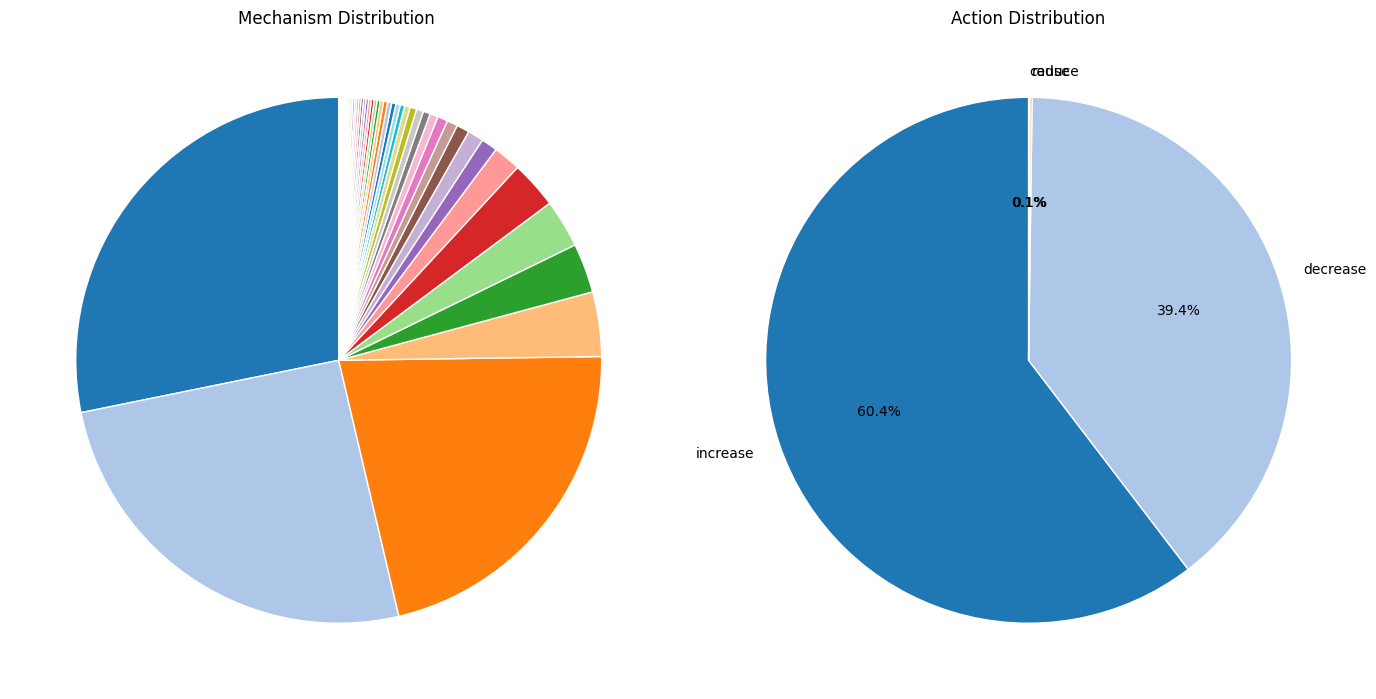

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

conn=sqlite3.connect('event.db')

# Assuming 'extraction' dataframe is already loaded
extraction = pd.read_sql('SELECT * FROM extraction;', conn)

# Count of each class in 'mechanism' and 'action'
mechanism_counts = extraction['mechanism'].value_counts()
action_counts = extraction['action'].value_counts()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for Mechanism (No labels)
axes[0].pie(mechanism_counts, colors=plt.cm.tab20.colors, startangle=90, wedgeprops={'edgecolor': 'white'})
axes[0].set_title('Mechanism Distribution ')

# Pie chart for Action (With labels)
axes[1].pie(action_counts, labels=action_counts.index, autopct='%1.1f%%', colors=plt.cm.tab20.colors, startangle=90, wedgeprops={'edgecolor': 'white'})
axes[1].set_title('Action Distribution')

plt.tight_layout()
plt.show()
plt.savefig('plots/event_distribution.png', dpi=300)



In [ ]:


import shutil
from google.colab import files

# Define the folders to zip
folder_to_zip1 = 'DDI_Model_new'
folder_to_zip2 = 'plots'

# Define the output zip file names
zip_file_name1 = 'ddi_model_new_zipped'
zip_file_name2 = 'plots_zipped'

# Create the zip archives
shutil.make_archive(zip_file_name1, 'zip', folder_to_zip1)
shutil.make_archive(zip_file_name2, 'zip', folder_to_zip2)

# Download the zipped files
print(f'Downloading {zip_file_name1}.zip...')
files.download(f'{zip_file_name1}.zip')

print(f'Downloading {zip_file_name2}.zip...')
files.download(f'{zip_file_name2}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>